Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,　I don't know what to do in select notebook.
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02
# Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 
# Version = "v48" # inference used v46, DEBUG=False, modify Feature_Engineering func
# Version = "v49" # inference used v46, DEBUG=False, create_features(func="mean")
# Version = "v50" # Select, QuantileTransformer(n_quantiles=100), select_importance_cols(num=50)
Version = "v51" # Select, QuantileTransformer(n_quantiles=defalt), select_importance_cols(num=100)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    feature_importance_df_ = pd.DataFrame()
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr, X_val = train_X.loc[train_index, :], train_X.loc[valid_index, :]
        y_tr, y_val = train_y[train_index], train_y[valid_index]
        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        
        if DEBUG:
            models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    _df = df.copy()
    Probability = _df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = _df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}")
        logger.info(f"Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping for control data

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')

In [31]:
#std_df = data.iloc[:, 4:].copy()

In [32]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    _data[f'clusters_{kind}'] = kmeans.labels_[:_data.shape[0]]
 
    return _data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [33]:
#clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
#clusters

In [34]:
# Count cluster types
#for i in tqdm(range(n_clusters-1, -1, -1)):
#    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
#clusters

In [35]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [36]:
# stats = detect_stats(data, feature_list, kind_list)
# stats

In [37]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
#data = pd.concat([data.iloc[:, :4], clusters], axis=1)
#data = pd.concat([data, stats], axis=1)
#data = pd.concat([data, std_df], axis=1)
#data

In [38]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [39]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose     g-0     g-1      g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.24790   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.29910   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.55400   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.26560   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.97000   
...             ...      ...      ...      ...     ...     ...      ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.23245   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.58500   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.26770   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.39770   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.32860   

          g-3      g-4     g-5  ...   df_c-91   df_c-92   df_c-93   df_c-94  \
0     -0.6208 -0.19440 -1.0120  ... -1.556684  0.248606 -1.083179  0.184056   
1      0.0604  1.01900  0.5207  ...  0.049251 -0.364980 -0.411534 -0.993055   
2     -0.0764 -0.03230  1.2390  ...  0.677642 -0.326261 -0.181815  1.284691   
3      0.5288  3.65905 -0.8095  ...  0.697360  1.661223  1.303584  1.045894   
4      0.6919  1.41800 -0.8244  ... -1.383713  0.367819  0.458141 -0.214427   
...       ...      ...     ...  ...       ...       ...       ...       ...   
27791 -0.6202  0.85570  1.6240  ...  0.725136  0.251124 -0.237973  0.804368   
27792  0.3456  0.44010  0.3107  ... -0.573386  0.499728 -0.284930 -0.160010   
27793 -0.6813  0.01520  0.4791  ...  0.336446 -0.411697 -1.622411 -0.091706   
27794  1.0160 -1.33500 -0.2207  ...  0.292672  0.617046  0.026101 -1.747524   
27795 -0.0428 -0.08000  0.8702  ... -1.542277 -0.071571 -0.236615 -0.937521   

        df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  WHERE  
0     -0.422826  0.452858 -1.087786 -1.717424 -1.652775  train  
1     -0.505091 -2.033104 -1.679158 -0.856646 -0.482696  train  
2      0.177076  0.673657  0.134245  1.168034 -0.911960  train  
3      1.235752  1.330177  1.019721  0.531517  1.067496  train  
4     -0.170683 -1.534088 -0.953044  0.237818 -0.033880  train  
...         ...       ...       ...       ...       ...    ...  
27791  0.541400  1.233284  1.193864  0.415900  0.771102   test  
27792  0.692818 -1.153627  0.220772 -0.327231 -0.125243   test  
27793 -0.568255 -1.100391 -0.169549  0.531853  0.109870   test  
27794 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309   test  
27795  0.202393  0.283034 -1.284479  0.111258 -1.282890   test  

[27796 rows x 2621 columns]

In [40]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.9)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 232 columns: ['g-1' 'g-3' 'g-4' 'g-6' 'g-15' 'g-18' 'g-19' 'g-21' 'g-22' 'g-23' 'g-25'
 'g-27' 'g-32' 'g-39' 'g-42' 'g-43' 'g-44' 'g-47' 'g-49' 'g-52' 'g-60'
 'g-64' 'g-66' 'g-71' 'g-73' 'g-76' 'g-77' 'g-78' 'g-81' 'g-87' 'g-88'
 'g-89' 'g-94' 'g-99' 'g-104' 'g-109' 'g-110' 'g-111' 'g-119' 'g-120'
 'g-122' 'g-124' 'g-127' 'g-129' 'g-149' 'g-150' 'g-151' 'g-153' 'g-165'
 'g-171' 'g-179' 'g-184' 'g-192' 'g-193' 'g-200' 'g-205' 'g-211' 'g-212'
 'g-213' 'g-216' 'g-217' 'g-219' 'g-225' 'g-227' 'g-233' 'g-236' 'g-237'
 'g-240' 'g-246' 'g-256' 'g-260' 'g-262' 'g-263' 'g-265' 'g-267' 'g-268'
 'g-273' 'g-274' 'g-277' 'g-278' 'g-279' 'g-283' 'g-288' 'g-292' 'g-296'
 'g-301' 'g-303' 'g-305' 'g-307' 'g-312' 'g-318' 'g-319' 'g-324' 'g-331'
 'g-333' 'g-340' 'g-342' 'g-343' 'g-345' 'g-346' 'g-347' 'g-348' 'g-352'
 'g-355' 'g-363' 'g-371' 'g-373' 'g-382' 'g-383' 'g-384' 'g-387' 'g-388'
 'g-396' 'g-397' 'g-403' 'g-404' 'g-408' 'g-412' 'g-415' 'g-420' 'g-430'
 'g-432' 'g-435' 'g-444' 'g-445' 'g-4

In [41]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [42]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 496 columns


# Modeling

In [43]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [44]:
def select_importance_cols(feature_importance_df, num=100):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [45]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

neg labels: 3289 → selected neg labels: 3286


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01984	valid_1's binary_logloss: 0.0279424
[200]	training's binary_logloss: 0.00211104	valid_1's binary_logloss: 0.00698967
[300]	training's binary_logloss: 0.000605832	valid_1's binary_logloss: 0.00401523
[400]	training's binary_logloss: 0.00033413	valid_1's binary_logloss: 0.00318419
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00028828	valid_1's binary_logloss: 0.00305493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199614	valid_1's binary_logloss: 0.02456
[200]	training's binary_logloss: 0.002102	valid_1's binary_logloss: 0.00350034
[300]	training's binary_logloss: 0.000597177	valid_1's binary_logloss: 0.00136243
[400]	training's binary_logloss: 0.000329304	valid_1's binary_logloss: 0.000884081
[500]	training's binary_logloss: 0.000280171	valid_1's binary_logloss: 0.000788638
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0012263, Threshold: 0.0024668, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071
Num_p_label: 80.0, conf_0:0.00222, conf_1:0.00271
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0024668
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_2: 0.0124668
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.0224668
threshold: 0.0224668, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198511	valid_1's binary_logloss: 0.0281403
[200]	training's binary_logloss: 0.00200595	valid_1's binary_logloss: 0.00704903
[300]	training's binary_logloss: 0.000568382	valid_1's binary_logloss: 0.00412261
[400]	training's binary_logloss: 0.000322618	valid_1's binary_logloss: 0.00353674
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000284177	valid_1's binary_logloss: 0.0034315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197835	valid_1's binary_logloss: 0.0233683
[200]	training's binary_logloss: 0.00203869	valid_1's binary_logloss: 0.00302817
[300]	training's binary_logloss: 0.000579469	valid_1's binary_logloss: 0.00109521
[400]	training's binary_logloss: 0.000325925	valid_1's binary_logloss: 0.000709532
[500]	training's binary_logloss: 0.000278514	valid_1's binary_logloss: 0.00064632
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0129015, Threshold: 0.0224668, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0055249 Vs.target_rate: 0.00071
Num_p_label: 22.0, conf_0:0.02022, conf_1:0.02471
Num_p_label: 22.0, Expected: 2.8, Adj_threshold_1: 0.0224668
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_2: 0.0324668
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_3: 0.0424668
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_4: 0.0524668
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_5: 0.0624668
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.0724668
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_7: 0.0824668
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_8: 0.0924668
threshold: 0.0924668, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198511	valid_1's binary_logloss: 0.0281403
[200]	training's binary_logloss: 0.00200595	valid_1's binary_logloss: 0.00704903
[300]	training's binary_logloss: 0.000568382	valid_1's binary_logloss: 0.00412261
[400]	training's binary_logloss: 0.000322618	valid_1's binary_logloss: 0.00353674
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000284177	valid_1's binary_logloss: 0.0034315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197835	valid_1's binary_logloss: 0.0233683
[200]	training's binary_logloss: 0.00203869	valid_1's binary_logloss: 0.00302817
[300]	training's binary_logloss: 0.000579469	valid_1's binary_logloss: 0.00109521
[400]	training's binary_logloss: 0.000325925	valid_1's binary_logloss: 0.000709532
[500]	training's binary_logloss: 0.000278514	valid_1's binary_logloss: 0.00064632
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0129015, Threshold: 0.0924668, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00071
Num_p_label: 4.0, conf_0:0.08322, conf_1:0.10171
threshold: 0.0924668, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103193	valid_1's binary_logloss: 0.0140027
[200]	training's binary_logloss: 0.00105431	valid_1's binary_logloss: 0.00390664
[300]	training's binary_logloss: 0.00030103	valid_1's binary_logloss: 0.00310898
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000290793	valid_1's binary_logloss: 0.00310305


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010637	valid_1's binary_logloss: 0.0144872
[200]	training's binary_logloss: 0.00109826	valid_1's binary_logloss: 0.00329146
[300]	training's binary_logloss: 0.000303838	valid_1's binary_logloss: 0.00211275
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00028238	valid_1's binary_logloss: 0.00209099


5-alpha_reductase_inhibitor logloss: 0.0025970877349709093


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232629	valid_1's binary_logloss: 0.0293765
[200]	training's binary_logloss: 0.0027194	valid_1's binary_logloss: 0.00545108
[300]	training's binary_logloss: 0.000776071	valid_1's binary_logloss: 0.00217493
[400]	training's binary_logloss: 0.000415935	valid_1's binary_logloss: 0.00136644
[500]	training's binary_logloss: 0.000329012	valid_1's binary_logloss: 0.00114443
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000319981	valid_1's binary_logloss: 0.0011216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023292	valid_1's binary_logloss: 0.035684
[200]	training's binary_logloss: 0.00277235	valid_1's binary_logloss: 0.00674795
[300]	training's binary_logloss: 0.000783856	valid_1's binary_logloss: 0.00289003
[400]	training's binary_logloss: 0.000420459	valid_1's binary_logloss: 0.00189112
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0018093, Threshold: 0.0029690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00267, conf_1:0.00327
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029690
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0129690
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0229690
threshold: 0.0229690, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022358	valid_1's binary_logloss: 0.0281951
[200]	training's binary_logloss: 0.00257817	valid_1's binary_logloss: 0.0046602
[300]	training's binary_logloss: 0.000746084	valid_1's binary_logloss: 0.00162503
[400]	training's binary_logloss: 0.000410241	valid_1's binary_logloss: 0.000985646
[500]	training's binary_logloss: 0.000334892	valid_1's binary_logloss: 0.000842652
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000328258	valid_1's binary_logloss: 0.000829458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228559	valid_1's binary_logloss: 0.0344493
[200]	training's binary_logloss: 0.00261559	valid_1's binary_logloss: 0.00678214
[300]	training's binary_logloss: 0.000750798	valid_1's binary_logloss: 0.00303225
[400]	training's binary_logloss: 0.000403515	valid_1's binary_logloss: 0.0018974
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.1354070, Threshold: 0.0229690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076
Num_p_label: 18.0, conf_0:0.02067, conf_1:0.02527
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.0229690
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0329690
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.0429690
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0529690
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0629690
threshold: 0.0629690, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022358	valid_1's binary_logloss: 0.0281951
[200]	training's binary_logloss: 0.00257817	valid_1's binary_logloss: 0.0046602
[300]	training's binary_logloss: 0.000746084	valid_1's binary_logloss: 0.00162503
[400]	training's binary_logloss: 0.000410241	valid_1's binary_logloss: 0.000985646
[500]	training's binary_logloss: 0.000334892	valid_1's binary_logloss: 0.000842652
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000328258	valid_1's binary_logloss: 0.000829458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228559	valid_1's binary_logloss: 0.0344493
[200]	training's binary_logloss: 0.00261559	valid_1's binary_logloss: 0.00678214
[300]	training's binary_logloss: 0.000750798	valid_1's binary_logloss: 0.00303225
[400]	training's binary_logloss: 0.000403515	valid_1's binary_logloss: 0.0018974
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.1354070, Threshold: 0.0629690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.05667, conf_1:0.06927
threshold: 0.0629690, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128576	valid_1's binary_logloss: 0.0200585
[200]	training's binary_logloss: 0.00148885	valid_1's binary_logloss: 0.00733643
[300]	training's binary_logloss: 0.000406202	valid_1's binary_logloss: 0.00624266
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00038857	valid_1's binary_logloss: 0.00620175


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012909	valid_1's binary_logloss: 0.0190495
[200]	training's binary_logloss: 0.00154495	valid_1's binary_logloss: 0.00486556
[300]	training's binary_logloss: 0.000433517	valid_1's binary_logloss: 0.0033788
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000325438	valid_1's binary_logloss: 0.00314896


11-beta-hsd1_inhibitor logloss: 0.0046755463219001325


neg labels: 3289 → selected neg labels: 3285


acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303781	valid_1's binary_logloss: 0.0481565
[200]	training's binary_logloss: 0.00414846	valid_1's binary_logloss: 0.0140574
[300]	training's binary_logloss: 0.00111511	valid_1's binary_logloss: 0.00887127
[400]	training's binary_logloss: 0.000551442	valid_1's binary_logloss: 0.00746758
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000473844	valid_1's binary_logloss: 0.00726848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029746	valid_1's binary_logloss: 0.0490389
[200]	training's binary_logloss: 0.00396526	valid_1's binary_logloss: 0.0126091
[300]	training's binary_logloss: 0.00109288	valid_1's binary_logloss: 0.00773126
[400]	training's binary_logloss: 0.000549814	valid_1's binary_logloss: 0.00610613
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00042317	valid_1's binary_logloss: 0.00569964


1 / 3 AUC score:1.000
y_Threshold: 0.0022775, Threshold: 0.0035391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00319, conf_1:0.00389
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0035391
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0135391
threshold: 0.0135391, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309888	valid_1's binary_logloss: 0.0469192
[200]	training's binary_logloss: 0.00412093	valid_1's binary_logloss: 0.012701
[300]	training's binary_logloss: 0.00111825	valid_1's binary_logloss: 0.00769958
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000636291	valid_1's binary_logloss: 0.00674387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294674	valid_1's binary_logloss: 0.0470391
[200]	training's binary_logloss: 0.00390128	valid_1's binary_logloss: 0.0107552
[300]	training's binary_logloss: 0.0010764	valid_1's binary_logloss: 0.00550415
[400]	training's binary_logloss: 0.000552567	valid_1's binary_logloss: 0.00417284
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000527695	valid_1's binary_logloss: 0.00411301


2 / 3 AUC score:1.000
y_Threshold: 0.0173856, Threshold: 0.0135391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00101
Num_p_label: 15.0, conf_0:0.01219, conf_1:0.01489
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.0135391
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0235391
threshold: 0.0235391, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303168	valid_1's binary_logloss: 0.0465058
[200]	training's binary_logloss: 0.00400725	valid_1's binary_logloss: 0.0110159
[300]	training's binary_logloss: 0.0010906	valid_1's binary_logloss: 0.00581739
[400]	training's binary_logloss: 0.00054982	valid_1's binary_logloss: 0.00479264
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000411842	valid_1's binary_logloss: 0.00445638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292674	valid_1's binary_logloss: 0.0436456
[200]	training's binary_logloss: 0.00393589	valid_1's binary_logloss: 0.00864499
[300]	training's binary_logloss: 0.00109012	valid_1's binary_logloss: 0.00331123
[400]	training's binary_logloss: 0.000546591	valid_1's binary_logloss: 0.00213612
[500]	training's binary_logloss: 0.000399401	valid_1's binary_logloss: 0.00173547
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0121839, Threshold: 0.0235391, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0010045 Vs.target_rate: 0.00101
Num_p_label: 4.0, conf_0:0.02119, conf_1:0.02589
threshold: 0.0235391, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7788, y_label_rate: 0.0846174


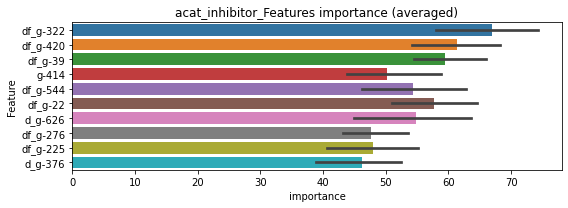

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159706	valid_1's binary_logloss: 0.0258257
[200]	training's binary_logloss: 0.00212462	valid_1's binary_logloss: 0.0078263
[300]	training's binary_logloss: 0.000569773	valid_1's binary_logloss: 0.00556913
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000313891	valid_1's binary_logloss: 0.00529506


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166829	valid_1's binary_logloss: 0.027328
[200]	training's binary_logloss: 0.00225007	valid_1's binary_logloss: 0.010785
[300]	training's binary_logloss: 0.000594125	valid_1's binary_logloss: 0.00835243
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000319743	valid_1's binary_logloss: 0.00788586


acat_inhibitor logloss: 0.006590458928165204


neg labels: 3289 → selected neg labels: 3259


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894601	valid_1's binary_logloss: 0.251794
[200]	training's binary_logloss: 0.0278478	valid_1's binary_logloss: 0.227596
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0220537	valid_1's binary_logloss: 0.226535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096613	valid_1's binary_logloss: 0.231324
[200]	training's binary_logloss: 0.0298844	valid_1's binary_logloss: 0.187877
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0164001	valid_1's binary_logloss: 0.182558


1 / 3 AUC score:0.926
y_Threshold: 0.0655960, Threshold: 0.1140185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 351 → Positive_corect_labels: 541/3559
p_label_rate: 0.0200904 Vs.target_rate: 0.00798
Num_p_label: 80.0, conf_0:0.10262, conf_1:0.12542
threshold: 0.1140185, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 541.0/3559, y_label_rate: 0.1520090
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664816	valid_1's binary_logloss: 0.181486
[200]	training's binary_logloss: 0.0171211	valid_1's binary_logloss: 0.13856
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00747351	valid_1's binary_logloss: 0.130867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689943	valid_1's binary_logloss: 0.171782
[200]	training's binary_logloss: 0.017648	valid_1's binary_logloss: 0.12492
[300]	training's binary_logloss: 0.00555233	valid_1's binary_logloss: 0.113206
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00577345	valid_1's binary_logloss: 0.113079


2 / 3 AUC score:0.982
y_Threshold: 0.0669677, Threshold: 0.1140185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 490.0/3457
p_label_rate: 0.0155701 Vs.target_rate: 0.00798
Num_p_label: 62.0, conf_0:0.10262, conf_1:0.12542
threshold: 0.1140185, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 490.0/3457, y_label_rate: 0.1417414
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059494	valid_1's binary_logloss: 0.131517
[200]	training's binary_logloss: 0.0142847	valid_1's binary_logloss: 0.0799718
[300]	training's binary_logloss: 0.0045795	valid_1's binary_logloss: 0.0667372
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00238257	valid_1's binary_logloss: 0.0635232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564034	valid_1's binary_logloss: 0.151909
[200]	training's binary_logloss: 0.0131171	valid_1's binary_logloss: 0.103722
[300]	training's binary_logloss: 0.004123	valid_1's binary_logloss: 0.0893882
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00325397	valid_1's binary_logloss: 0.0874481


3 / 3 AUC score:0.994
y_Threshold: 0.0656121, Threshold: 0.1140185, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 465.0/3407
p_label_rate: 0.0123054 Vs.target_rate: 0.00798
Num_p_label: 49.0, conf_0:0.10262, conf_1:0.12542
threshold: 0.1140185, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 514.0/7389, y_label_rate: 0.0695629


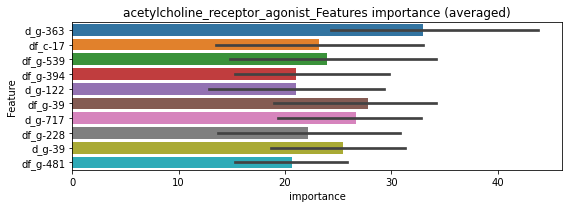

len(train_index) : 3694
len(valid_index) : 3695
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315868	valid_1's binary_logloss: 0.0990435
[200]	training's binary_logloss: 0.00756939	valid_1's binary_logloss: 0.0790034
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00539872	valid_1's binary_logloss: 0.0771851


len(train_index) : 3695
len(valid_index) : 3694
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033231	valid_1's binary_logloss: 0.0994719
[200]	training's binary_logloss: 0.00801739	valid_1's binary_logloss: 0.0823227
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00611317	valid_1's binary_logloss: 0.0810509


acetylcholine_receptor_agonist logloss: 0.07911771196263445


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113572	valid_1's binary_logloss: 0.314327
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0461491	valid_1's binary_logloss: 0.298998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122863	valid_1's binary_logloss: 0.287466
[200]	training's binary_logloss: 0.0463919	valid_1's binary_logloss: 0.25678
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.035163	valid_1's binary_logloss: 0.253478


1 / 3 AUC score:0.854
y_Threshold: 0.1094395, Threshold: 0.1637674, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 540 → Positive_corect_labels: 443/3349
p_label_rate: 0.0200904 Vs.target_rate: 0.01264
Num_p_label: 80.0, conf_0:0.14739, conf_1:0.18014
threshold: 0.1637674, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 443.0/3349, y_label_rate: 0.1322783
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068856	valid_1's binary_logloss: 0.18264
[200]	training's binary_logloss: 0.0200187	valid_1's binary_logloss: 0.143142
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0113098	valid_1's binary_logloss: 0.13658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709216	valid_1's binary_logloss: 0.184816
[200]	training's binary_logloss: 0.0191538	valid_1's binary_logloss: 0.145273
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0125747	valid_1's binary_logloss: 0.141577


2 / 3 AUC score:0.975
y_Threshold: 0.0927852, Threshold: 0.1637674, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 375.0/3213
p_label_rate: 0.0123054 Vs.target_rate: 0.01264
Num_p_label: 49.0, conf_0:0.14739, conf_1:0.18014
threshold: 0.1637674, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 375.0/3213, y_label_rate: 0.1167134
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531584	valid_1's binary_logloss: 0.159959
[200]	training's binary_logloss: 0.0128763	valid_1's binary_logloss: 0.133908
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00752258	valid_1's binary_logloss: 0.131451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565656	valid_1's binary_logloss: 0.153379
[200]	training's binary_logloss: 0.0160007	valid_1's binary_logloss: 0.11898
[300]	training's binary_logloss: 0.00500719	valid_1's binary_logloss: 0.108794
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00541293	valid_1's binary_logloss: 0.108621


3 / 3 AUC score:0.977
y_Threshold: 0.0719901, Threshold: 0.1637674, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 322.0/3107
p_label_rate: 0.0145655 Vs.target_rate: 0.01264
Num_p_label: 58.0, conf_0:0.14739, conf_1:0.18014
threshold: 0.1637674, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 380.0/7089, y_label_rate: 0.0536042


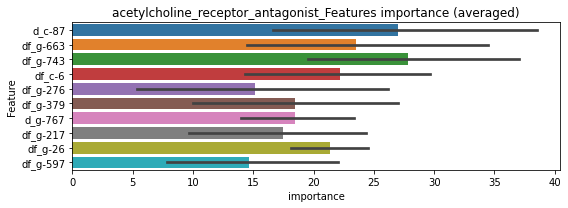

len(train_index) : 3544
len(valid_index) : 3545
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026976	valid_1's binary_logloss: 0.0825339
[200]	training's binary_logloss: 0.00660014	valid_1's binary_logloss: 0.0709992
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00518842	valid_1's binary_logloss: 0.0706864


len(train_index) : 3545
len(valid_index) : 3544
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256781	valid_1's binary_logloss: 0.0930392
[200]	training's binary_logloss: 0.00612664	valid_1's binary_logloss: 0.0802535
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00612664	valid_1's binary_logloss: 0.0802535


acetylcholine_receptor_antagonist logloss: 0.07546928272295589


neg labels: 3289 → selected neg labels: 3276


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680265	valid_1's binary_logloss: 0.134675
[200]	training's binary_logloss: 0.0161687	valid_1's binary_logloss: 0.0764741
[300]	training's binary_logloss: 0.00457386	valid_1's binary_logloss: 0.0606602
[400]	training's binary_logloss: 0.00186536	valid_1's binary_logloss: 0.0563904
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00178793	valid_1's binary_logloss: 0.0562166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704537	valid_1's binary_logloss: 0.128039
[200]	training's binary_logloss: 0.0164427	valid_1's binary_logloss: 0.0603885
[300]	training's binary_logloss: 0.00470405	valid_1's binary_logloss: 0.0381822
[400]	training's binary_logloss: 0.0019201	valid_1's binary_logloss: 0.0306791
[500]	training's binary_logloss: 0.0010982	valid_1's binary_logloss: 0.0274034
[600]	training's binary_logloss: 0.000774686	valid_

1 / 3 AUC score:0.995
y_Threshold: 0.0144659, Threshold: 0.0184255, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3779
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01658, conf_1:0.02027
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0184255
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.0284255
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_3: 0.0384255
threshold: 0.0384255, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 645.0/3779, y_label_rate: 0.1706801
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670307	valid_1's binary_logloss: 0.127253
[200]	training's binary_logloss: 0.0150349	valid_1's binary_logloss: 0.0645538
[300]	training's binary_logloss: 0.00426179	valid_1's binary_logloss: 0.045585
[400]	training's binary_logloss: 0.00180101	valid_1's binary_logloss: 0.0386659
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00120682	valid_1's binary_logloss: 0.036938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652106	valid_1's binary_logloss: 0.124429
[200]	training's binary_logloss: 0.0142445	valid_1's binary_logloss: 0.0615361
[300]	training's binary_logloss: 0.00411136	valid_1's binary_logloss: 0.0425138
[400]	training's binary_logloss: 0.00174855	valid_1's binary_logloss: 0.0364418
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00123124	valid_1's binary_logloss: 0.0348537


2 / 3 AUC score:0.996
y_Threshold: 0.0469644, Threshold: 0.0384255, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 631.0/3751
p_label_rate: 0.0090407 Vs.target_rate: 0.00307
Num_p_label: 36.0, conf_0:0.03458, conf_1:0.04227
threshold: 0.0384255, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 631.0/3751, y_label_rate: 0.1682218
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631155	valid_1's binary_logloss: 0.117639
[200]	training's binary_logloss: 0.0139994	valid_1's binary_logloss: 0.0642594
[300]	training's binary_logloss: 0.00381894	valid_1's binary_logloss: 0.0475648
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00200892	valid_1's binary_logloss: 0.043244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639103	valid_1's binary_logloss: 0.121167
[200]	training's binary_logloss: 0.0138134	valid_1's binary_logloss: 0.0583666
[300]	training's binary_logloss: 0.00384256	valid_1's binary_logloss: 0.0398303
[400]	training's binary_logloss: 0.00165467	valid_1's binary_logloss: 0.0344665
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00165467	valid_1's binary_logloss: 0.0344665


3 / 3 AUC score:0.999
y_Threshold: 0.0457724, Threshold: 0.0384255, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 619.0/3727
p_label_rate: 0.0120542 Vs.target_rate: 0.00307
Num_p_label: 48.0, conf_0:0.03458, conf_1:0.04227
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_1: 0.0384255
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_2: 0.0484255
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_3: 0.0584255
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_4: 0.0684255
threshold: 0.0684255, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 638.0/7709, y_label_rate: 0.0827604


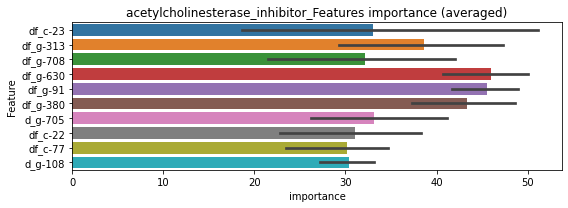

len(train_index) : 3854
len(valid_index) : 3855
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340475	valid_1's binary_logloss: 0.0830175
[200]	training's binary_logloss: 0.00717705	valid_1's binary_logloss: 0.0513111
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00233421	valid_1's binary_logloss: 0.044706


len(train_index) : 3855
len(valid_index) : 3854
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363254	valid_1's binary_logloss: 0.071654
[200]	training's binary_logloss: 0.00841808	valid_1's binary_logloss: 0.0393902
[300]	training's binary_logloss: 0.00233849	valid_1's binary_logloss: 0.0310066
[400]	training's binary_logloss: 0.000965709	valid_1's binary_logloss: 0.0287195
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000866456	valid_1's binary_logloss: 0.0285361


acetylcholinesterase_inhibitor logloss: 0.036622106498275096


neg labels: 3289 → selected neg labels: 3281


adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470471	valid_1's binary_logloss: 0.0973583
[200]	training's binary_logloss: 0.00909658	valid_1's binary_logloss: 0.0498925
[300]	training's binary_logloss: 0.00248572	valid_1's binary_logloss: 0.0396326
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00126842	valid_1's binary_logloss: 0.0362069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440784	valid_1's binary_logloss: 0.0963991
[200]	training's binary_logloss: 0.00819759	valid_1's binary_logloss: 0.0558306
[300]	training's binary_logloss: 0.00233027	valid_1's binary_logloss: 0.0482231
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00167944	valid_1's binary_logloss: 0.0467298


1 / 3 AUC score:0.995
y_Threshold: 0.0120472, Threshold: 0.0190253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01712, conf_1:0.02093
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0190253
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_2: 0.0290253
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_3: 0.0390253
threshold: 0.0390253, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441053	valid_1's binary_logloss: 0.0855364
[200]	training's binary_logloss: 0.0076842	valid_1's binary_logloss: 0.038955
[300]	training's binary_logloss: 0.00218454	valid_1's binary_logloss: 0.0285257
[400]	training's binary_logloss: 0.00103245	valid_1's binary_logloss: 0.0256815
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000742595	valid_1's binary_logloss: 0.0244379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426166	valid_1's binary_logloss: 0.0902625
[200]	training's binary_logloss: 0.00738088	valid_1's binary_logloss: 0.0456878
[300]	training's binary_logloss: 0.00212006	valid_1's binary_logloss: 0.0359755
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00132876	valid_1's binary_logloss: 0.0343541


2 / 3 AUC score:0.999
y_Threshold: 0.0364995, Threshold: 0.0390253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 633.0/3759
p_label_rate: 0.0128076 Vs.target_rate: 0.00227
Num_p_label: 51.0, conf_0:0.03512, conf_1:0.04293
Num_p_label: 51.0, Expected: 9.0, Adj_threshold_1: 0.0390253
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_2: 0.0490253
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_3: 0.0590253
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.0690253
threshold: 0.0690253, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 633.0/3759, y_label_rate: 0.1683958
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433975	valid_1's binary_logloss: 0.0841105
[200]	training's binary_logloss: 0.00755627	valid_1's binary_logloss: 0.0321151
[300]	training's binary_logloss: 0.00216936	valid_1's binary_logloss: 0.0187733
[400]	training's binary_logloss: 0.00112042	valid_1's binary_logloss: 0.0155297
[500]	training's binary_logloss: 0.000753372	valid_1's binary_logloss: 0.0143572
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000720329	valid_1's binary_logloss: 0.0143097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429129	valid_1's binary_logloss: 0.0827776
[200]	training's binary_logloss: 0.00735631	valid_1's binary_logloss: 0.0363438
[300]	training's binary_logloss: 0.00208454	valid_1's binary_logloss: 0.0253249
[400]	training's binary_logloss: 0.000974414	valid_1's binary_logloss: 0.0213459
Early stopping, best iteration is:
[475]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0293224, Threshold: 0.0690253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 630.0/3753
p_label_rate: 0.0020090 Vs.target_rate: 0.00227
Num_p_label: 8.0, conf_0:0.06212, conf_1:0.07593
threshold: 0.0690253, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 638.0/7735, y_label_rate: 0.0824822


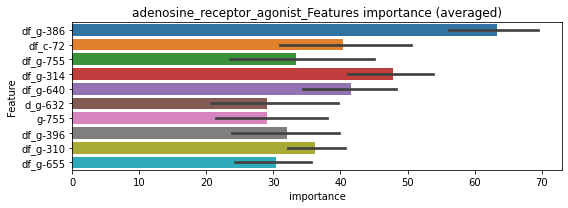

len(train_index) : 3867
len(valid_index) : 3868
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229022	valid_1's binary_logloss: 0.0533254
[200]	training's binary_logloss: 0.0038513	valid_1's binary_logloss: 0.0273196
[300]	training's binary_logloss: 0.00108285	valid_1's binary_logloss: 0.0226765
[400]	training's binary_logloss: 0.000497534	valid_1's binary_logloss: 0.0217238
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000467108	valid_1's binary_logloss: 0.0216285


len(train_index) : 3868
len(valid_index) : 3867
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254303	valid_1's binary_logloss: 0.0487308
[200]	training's binary_logloss: 0.00465617	valid_1's binary_logloss: 0.0208559
[300]	training's binary_logloss: 0.00126482	valid_1's binary_logloss: 0.0140028
[400]	training's binary_logloss: 0.000558876	valid_1's binary_logloss: 0.0116706
[500]	training's binary_logloss: 0.000344132	valid_1's binary_logloss: 0.0108673
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000354899	valid_1's binary_logloss: 0.0108549


adenosine_receptor_agonist logloss: 0.01624240029714402


neg labels: 3289 → selected neg labels: 3273


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062709	valid_1's binary_logloss: 0.147198
[200]	training's binary_logloss: 0.0145883	valid_1's binary_logloss: 0.102023
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00544697	valid_1's binary_logloss: 0.0919223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633342	valid_1's binary_logloss: 0.135946
[200]	training's binary_logloss: 0.0150664	valid_1's binary_logloss: 0.0813431
[300]	training's binary_logloss: 0.00443234	valid_1's binary_logloss: 0.0688923
[400]	training's binary_logloss: 0.00193155	valid_1's binary_logloss: 0.06601
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00187003	valid_1's binary_logloss: 0.065876


1 / 3 AUC score:0.984
y_Threshold: 0.0252941, Threshold: 0.0356061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 194 → Positive_corect_labels: 623/3733
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.03205, conf_1:0.03917
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0356061
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_2: 0.0456061
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_3: 0.0556061
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_4: 0.0656061
threshold: 0.0656061, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 623.0/3733, y_label_rate: 0.1668899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583187	valid_1's binary_logloss: 0.120197
[200]	training's binary_logloss: 0.0121121	valid_1's binary_logloss: 0.0640353
[300]	training's binary_logloss: 0.00364487	valid_1's binary_logloss: 0.0523146
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00209627	valid_1's binary_logloss: 0.0500341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572492	valid_1's binary_logloss: 0.12548
[200]	training's binary_logloss: 0.0121134	valid_1's binary_logloss: 0.0781422
[300]	training's binary_logloss: 0.00360889	valid_1's binary_logloss: 0.0669286
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0037186	valid_1's binary_logloss: 0.066888


2 / 3 AUC score:0.992
y_Threshold: 0.0509796, Threshold: 0.0656061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 600.0/3687
p_label_rate: 0.0107986 Vs.target_rate: 0.00403
Num_p_label: 43.0, conf_0:0.05905, conf_1:0.07217
threshold: 0.0656061, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 600.0/3687, y_label_rate: 0.1627339
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514252	valid_1's binary_logloss: 0.115681
[200]	training's binary_logloss: 0.010209	valid_1's binary_logloss: 0.0651619
[300]	training's binary_logloss: 0.00302088	valid_1's binary_logloss: 0.053585
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00156446	valid_1's binary_logloss: 0.0508141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547988	valid_1's binary_logloss: 0.122988
[200]	training's binary_logloss: 0.0110541	valid_1's binary_logloss: 0.0781777
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00559673	valid_1's binary_logloss: 0.0724739


3 / 3 AUC score:0.994
y_Threshold: 0.0514225, Threshold: 0.0656061, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 577.0/3641
p_label_rate: 0.0123054 Vs.target_rate: 0.00403
Num_p_label: 49.0, conf_0:0.05905, conf_1:0.07217
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_1: 0.0656061
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_2: 0.0756061
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_3: 0.0856061
threshold: 0.0856061, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 607.0/7623, y_label_rate: 0.0796274


len(train_index) : 3811
len(valid_index) : 3812
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294317	valid_1's binary_logloss: 0.074968
[200]	training's binary_logloss: 0.00608256	valid_1's binary_logloss: 0.0510384
[300]	training's binary_logloss: 0.00170554	valid_1's binary_logloss: 0.0467349
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0018918	valid_1's binary_logloss: 0.0466223


len(train_index) : 3812
len(valid_index) : 3811
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300915	valid_1's binary_logloss: 0.0671996
[200]	training's binary_logloss: 0.00630099	valid_1's binary_logloss: 0.0433342
[300]	training's binary_logloss: 0.00180335	valid_1's binary_logloss: 0.0382293
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00123929	valid_1's binary_logloss: 0.0373036


adenosine_receptor_antagonist logloss: 0.041963583609143755


neg labels: 3289 → selected neg labels: 3286


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209749	valid_1's binary_logloss: 0.0269867
[200]	training's binary_logloss: 0.00229148	valid_1's binary_logloss: 0.00447576
[300]	training's binary_logloss: 0.0006289	valid_1's binary_logloss: 0.00152329
[400]	training's binary_logloss: 0.000340813	valid_1's binary_logloss: 0.000937816
[500]	training's binary_logloss: 0.000278998	valid_1's binary_logloss: 0.000808379
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000276712	valid_1's binary_logloss: 0.000804844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211226	valid_1's binary_logloss: 0.0258993
[200]	training's binary_logloss: 0.00224446	valid_1's binary_logloss: 0.0035963
[300]	training's binary_logloss: 0.000627051	valid_1's binary_logloss: 0.00124347
[400]	training's binary_logloss: 0.000341634	valid_1's binary_logloss: 0.00076017
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0013087, Threshold: 0.0021912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00197, conf_1:0.00241
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021912
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0121912
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0221912
threshold: 0.0221912, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209516	valid_1's binary_logloss: 0.0266595
[200]	training's binary_logloss: 0.0022105	valid_1's binary_logloss: 0.0044351
[300]	training's binary_logloss: 0.000615966	valid_1's binary_logloss: 0.00159358
[400]	training's binary_logloss: 0.000338451	valid_1's binary_logloss: 0.00102366
[500]	training's binary_logloss: 0.000282639	valid_1's binary_logloss: 0.000912578
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000276856	valid_1's binary_logloss: 0.000899541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213034	valid_1's binary_logloss: 0.0261555
[200]	training's binary_logloss: 0.00222072	valid_1's binary_logloss: 0.00344247
[300]	training's binary_logloss: 0.000605861	valid_1's binary_logloss: 0.00111483
[400]	training's binary_logloss: 0.00033108	valid_1's binary_logloss: 0.000661029
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.1360638, Threshold: 0.0221912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.01997, conf_1:0.02441
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0221912
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0321912
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0421912
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.0521912
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.0621912
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.0721912
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_7: 0.0821912
threshold: 0.0821912, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209516	valid_1's binary_logloss: 0.0266595
[200]	training's binary_logloss: 0.0022105	valid_1's binary_logloss: 0.0044351
[300]	training's binary_logloss: 0.000615966	valid_1's binary_logloss: 0.00159358
[400]	training's binary_logloss: 0.000338451	valid_1's binary_logloss: 0.00102366
[500]	training's binary_logloss: 0.000282639	valid_1's binary_logloss: 0.000912578
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000276856	valid_1's binary_logloss: 0.000899541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213034	valid_1's binary_logloss: 0.0261555
[200]	training's binary_logloss: 0.00222072	valid_1's binary_logloss: 0.00344247
[300]	training's binary_logloss: 0.000605861	valid_1's binary_logloss: 0.00111483
[400]	training's binary_logloss: 0.00033108	valid_1's binary_logloss: 0.000661029
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.1360638, Threshold: 0.0821912, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.07397, conf_1:0.09041
threshold: 0.0821912, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


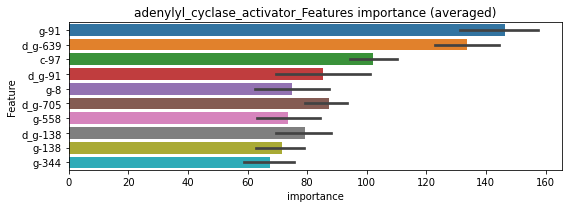

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104572	valid_1's binary_logloss: 0.015034
[200]	training's binary_logloss: 0.00105984	valid_1's binary_logloss: 0.00356522
[300]	training's binary_logloss: 0.000295801	valid_1's binary_logloss: 0.00244152
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000218504	valid_1's binary_logloss: 0.00232238


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107793	valid_1's binary_logloss: 0.014362
[200]	training's binary_logloss: 0.00113127	valid_1's binary_logloss: 0.00256091
[300]	training's binary_logloss: 0.00031818	valid_1's binary_logloss: 0.00136862
[400]	training's binary_logloss: 0.000175614	valid_1's binary_logloss: 0.00113375
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00015084	valid_1's binary_logloss: 0.00109444


adenylyl_cyclase_activator logloss: 0.0017084910171620135


neg labels: 3289 → selected neg labels: 3244


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953558	valid_1's binary_logloss: 0.277728
[200]	training's binary_logloss: 0.0318398	valid_1's binary_logloss: 0.255645
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0303611	valid_1's binary_logloss: 0.255521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108396	valid_1's binary_logloss: 0.262619
[200]	training's binary_logloss: 0.0391076	valid_1's binary_logloss: 0.223025
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0233663	valid_1's binary_logloss: 0.219813


1 / 3 AUC score:0.910
y_Threshold: 0.0803165, Threshold: 0.1302711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 423 → Positive_corect_labels: 502/3469
p_label_rate: 0.0200904 Vs.target_rate: 0.01134
Num_p_label: 80.0, conf_0:0.11724, conf_1:0.14330
threshold: 0.1302711, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 502.0/3469, y_label_rate: 0.1447103
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771531	valid_1's binary_logloss: 0.199127
[200]	training's binary_logloss: 0.0220196	valid_1's binary_logloss: 0.156947
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.015558	valid_1's binary_logloss: 0.151957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730931	valid_1's binary_logloss: 0.187526
[200]	training's binary_logloss: 0.021033	valid_1's binary_logloss: 0.148813
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0114723	valid_1's binary_logloss: 0.143165


2 / 3 AUC score:0.969
y_Threshold: 0.0872474, Threshold: 0.1302711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 433.0/3331
p_label_rate: 0.0205927 Vs.target_rate: 0.01134
Num_p_label: 82.0, conf_0:0.11724, conf_1:0.14330
threshold: 0.1302711, positive_p_label: 82.0/3982, p_label_rate: 0.0205927
positive_y_label: 433.0/3331, y_label_rate: 0.1299910
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577415	valid_1's binary_logloss: 0.175916
[200]	training's binary_logloss: 0.0145095	valid_1's binary_logloss: 0.143114
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00993694	valid_1's binary_logloss: 0.140164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602467	valid_1's binary_logloss: 0.15939
[200]	training's binary_logloss: 0.0148893	valid_1's binary_logloss: 0.128755
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0110458	valid_1's binary_logloss: 0.125391


3 / 3 AUC score:0.967
y_Threshold: 0.0738692, Threshold: 0.1302711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 112 → Positive_corect_labels: 377.0/3219
p_label_rate: 0.0195881 Vs.target_rate: 0.01134
Num_p_label: 78.0, conf_0:0.11724, conf_1:0.14330
threshold: 0.1302711, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 455.0/7201, y_label_rate: 0.0631857


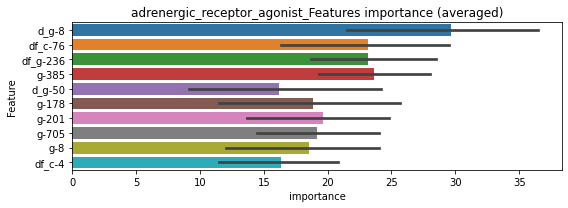

len(train_index) : 3600
len(valid_index) : 3601
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300984	valid_1's binary_logloss: 0.104576
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00941832	valid_1's binary_logloss: 0.0938488


len(train_index) : 3601
len(valid_index) : 3600
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307333	valid_1's binary_logloss: 0.0938496
[200]	training's binary_logloss: 0.00758114	valid_1's binary_logloss: 0.0789558
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00560436	valid_1's binary_logloss: 0.0777138


adrenergic_receptor_agonist logloss: 0.08578243960167464


neg labels: 3289 → selected neg labels: 3229


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125659	valid_1's binary_logloss: 0.357127
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0734065	valid_1's binary_logloss: 0.352156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136278	valid_1's binary_logloss: 0.336441
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0688057	valid_1's binary_logloss: 0.318933


1 / 3 AUC score:0.786
y_Threshold: 0.1347939, Threshold: 0.1821686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 666 → Positive_corect_labels: 377/3208
p_label_rate: 0.0200904 Vs.target_rate: 0.01512
Num_p_label: 80.0, conf_0:0.16395, conf_1:0.20039
threshold: 0.1821686, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 377.0/3208, y_label_rate: 0.1175187
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696261	valid_1's binary_logloss: 0.199337
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0285794	valid_1's binary_logloss: 0.173836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653602	valid_1's binary_logloss: 0.208358
[200]	training's binary_logloss: 0.0182203	valid_1's binary_logloss: 0.183708
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0111623	valid_1's binary_logloss: 0.17982


2 / 3 AUC score:0.944
y_Threshold: 0.0815721, Threshold: 0.1821686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 291.0/3036
p_label_rate: 0.0035158 Vs.target_rate: 0.01512
Num_p_label: 14.0, conf_0:0.16395, conf_1:0.20039
Num_p_label: 14.0, Expected: 60.2, Adj_threshold_1: 0.1821686
Num_p_label: 17.0, Expected: 60.2, Adj_threshold_2: 0.1721686
Num_p_label: 25.0, Expected: 60.2, Adj_threshold_3: 0.1621686
Num_p_label: 27.0, Expected: 60.2, Adj_threshold_4: 0.1521686
Num_p_label: 30.0, Expected: 60.2, Adj_threshold_5: 0.1421686
Num_p_label: 35.0, Expected: 60.2, Adj_threshold_6: 0.1321686
threshold: 0.1321686, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 291.0/3036, y_label_rate: 0.0958498
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046429	valid_1's binary_logloss: 0.146146
[200]	training's binary_logloss: 0.0122926	valid_1's binary_logloss: 0.116367
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00836637	valid_1's binary_logloss: 0.113873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479851	valid_1's binary_logloss: 0.146171
[200]	training's binary_logloss: 0.0124479	valid_1's binary_logloss: 0.121435
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00817813	valid_1's binary_logloss: 0.117826


3 / 3 AUC score:0.977
y_Threshold: 0.0665245, Threshold: 0.1321686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 251.0/2956
p_label_rate: 0.0045203 Vs.target_rate: 0.01512
Num_p_label: 18.0, conf_0:0.11895, conf_1:0.14539
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_1: 0.1321686
Num_p_label: 22.0, Expected: 60.2, Adj_threshold_2: 0.1221686
Num_p_label: 27.0, Expected: 60.2, Adj_threshold_3: 0.1121686
Num_p_label: 33.0, Expected: 60.2, Adj_threshold_4: 0.1021686
threshold: 0.1021686, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 284.0/6938, y_label_rate: 0.0409340


len(train_index) : 3469
len(valid_index) : 3469
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204728	valid_1's binary_logloss: 0.0914103
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00877053	valid_1's binary_logloss: 0.0855351


len(train_index) : 3469
len(valid_index) : 3469
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209751	valid_1's binary_logloss: 0.090537
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00883126	valid_1's binary_logloss: 0.0834812


adrenergic_receptor_antagonist logloss: 0.08450815938732008


neg labels: 3289 → selected neg labels: 3278


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362784	valid_1's binary_logloss: 0.0747377
[200]	training's binary_logloss: 0.00609093	valid_1's binary_logloss: 0.0335445
[300]	training's binary_logloss: 0.00183664	valid_1's binary_logloss: 0.0248948
[400]	training's binary_logloss: 0.00090233	valid_1's binary_logloss: 0.0224731
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000948015	valid_1's binary_logloss: 0.0224384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382717	valid_1's binary_logloss: 0.0683723
[200]	training's binary_logloss: 0.00654074	valid_1's binary_logloss: 0.0252608
[300]	training's binary_logloss: 0.00195577	valid_1's binary_logloss: 0.0150028
[400]	training's binary_logloss: 0.000952476	valid_1's binary_logloss: 0.0114448
[500]	training's binary_logloss: 0.000629305	valid_1's binary_logloss: 0.0103913
Early stopping, best iteration is:
[490]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0069379, Threshold: 0.0256990, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00277
Num_p_label: 80.0, conf_0:0.02313, conf_1:0.02827
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0256990
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_2: 0.0356990
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_3: 0.0456990
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_4: 0.0556990
Num_p_label: 44.0, Expected: 11.0, Adj_threshold_5: 0.0656990
Num_p_label: 40.0, Expected: 11.0, Adj_threshold_6: 0.0756990
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_7: 0.0856990
Num_p_label: 32.0, Expected: 11.0, Adj_threshold_8: 0.0956990
Num_p_label: 30.0, Expected: 11.0, Adj_threshold_9: 0.1056990
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_10: 0.1156990
threshold: 0.1256990, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3799, y_label_rate: 0.1721506

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361224	valid_1's binary_logloss: 0.0716578
[200]	training's binary_logloss: 0.00571009	valid_1's binary_logloss: 0.0308879
[300]	training's binary_logloss: 0.00169001	valid_1's binary_logloss: 0.0219613
[400]	training's binary_logloss: 0.00083925	valid_1's binary_logloss: 0.019614
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000595238	valid_1's binary_logloss: 0.0187146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349988	valid_1's binary_logloss: 0.0653023
[200]	training's binary_logloss: 0.0055853	valid_1's binary_logloss: 0.0229858
[300]	training's binary_logloss: 0.00165801	valid_1's binary_logloss: 0.0135626
[400]	training's binary_logloss: 0.000827931	valid_1's binary_logloss: 0.0102251
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000657172	valid_1's binary_logloss: 0.00948376


2 / 3 AUC score:1.000
y_Threshold: 0.0667335, Threshold: 0.1256990, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0168257 Vs.target_rate: 0.00277
Num_p_label: 67.0, conf_0:0.11313, conf_1:0.13827
Num_p_label: 67.0, Expected: 11.0, Adj_threshold_1: 0.1256990
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_2: 0.1356990
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_3: 0.1456990
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_4: 0.1556990
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_5: 0.1656990
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_6: 0.1756990
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_7: 0.1856990
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_8: 0.1956990
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_9: 0.2056990
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_10: 0.2156990
threshold: 0.2256990, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366615	valid_1's binary_logloss: 0.0725924
[200]	training's binary_logloss: 0.00580576	valid_1's binary_logloss: 0.0308506
[300]	training's binary_logloss: 0.00172309	valid_1's binary_logloss: 0.02101
[400]	training's binary_logloss: 0.000840626	valid_1's binary_logloss: 0.0181139
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000732731	valid_1's binary_logloss: 0.0176506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352482	valid_1's binary_logloss: 0.0811136
[200]	training's binary_logloss: 0.00558186	valid_1's binary_logloss: 0.0362349
[300]	training's binary_logloss: 0.00166609	valid_1's binary_logloss: 0.0272146
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00097717	valid_1's binary_logloss: 0.0249579


3 / 3 AUC score:1.000
y_Threshold: 0.0645369, Threshold: 0.2256990, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 642.0/3775
p_label_rate: 0.0153189 Vs.target_rate: 0.00277
Num_p_label: 61.0, conf_0:0.20313, conf_1:0.24827
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_1: 0.2256990
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_2: 0.2356990
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_3: 0.2456990
Num_p_label: 48.0, Expected: 11.0, Adj_threshold_4: 0.2556990
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_5: 0.2656990
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_6: 0.2756990
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_7: 0.2856990
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_8: 0.2956990
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_9: 0.3056990
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_10: 0.3156990
threshold: 0.3256990, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 685.0/7757, y_label_rate: 0.088307

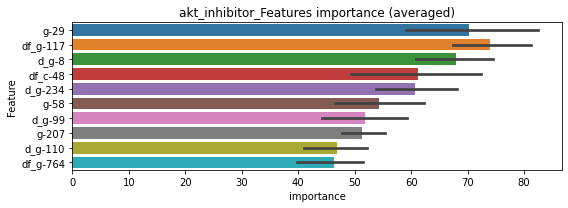

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206194	valid_1's binary_logloss: 0.0455001
[200]	training's binary_logloss: 0.00325603	valid_1's binary_logloss: 0.019629
[300]	training's binary_logloss: 0.00096068	valid_1's binary_logloss: 0.0143434
[400]	training's binary_logloss: 0.000464113	valid_1's binary_logloss: 0.0125585
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000375702	valid_1's binary_logloss: 0.0122734


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195959	valid_1's binary_logloss: 0.0467935
[200]	training's binary_logloss: 0.00315053	valid_1's binary_logloss: 0.0242441
[300]	training's binary_logloss: 0.000939177	valid_1's binary_logloss: 0.0189639
[400]	training's binary_logloss: 0.000462317	valid_1's binary_logloss: 0.0171387
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000346019	valid_1's binary_logloss: 0.0166476


akt_inhibitor logloss: 0.014460239526002602


neg labels: 3289 → selected neg labels: 3286


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228466	valid_1's binary_logloss: 0.0356217
[200]	training's binary_logloss: 0.0027203	valid_1's binary_logloss: 0.00806152
[300]	training's binary_logloss: 0.000752473	valid_1's binary_logloss: 0.00378704
[400]	training's binary_logloss: 0.000390813	valid_1's binary_logloss: 0.00264563
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000337315	valid_1's binary_logloss: 0.00250215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236444	valid_1's binary_logloss: 0.0295922
[200]	training's binary_logloss: 0.0027615	valid_1's binary_logloss: 0.00448886
[300]	training's binary_logloss: 0.000767711	valid_1's binary_logloss: 0.00153851
[400]	training's binary_logloss: 0.000406009	valid_1's binary_logloss: 0.000911727
[500]	training's binary_logloss: 0.000321067	valid_1's binary_logloss: 0.000759537
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0015792, Threshold: 0.0022691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00204, conf_1:0.00250
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0022691
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0122691
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_3: 0.0222691
threshold: 0.0222691, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227236	valid_1's binary_logloss: 0.0360957
[200]	training's binary_logloss: 0.00260171	valid_1's binary_logloss: 0.00857991
[300]	training's binary_logloss: 0.000729964	valid_1's binary_logloss: 0.00380723
[400]	training's binary_logloss: 0.000389324	valid_1's binary_logloss: 0.00263143
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000334014	valid_1's binary_logloss: 0.00242538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230119	valid_1's binary_logloss: 0.0286877
[200]	training's binary_logloss: 0.00259429	valid_1's binary_logloss: 0.00416136
[300]	training's binary_logloss: 0.000735192	valid_1's binary_logloss: 0.00146189
[400]	training's binary_logloss: 0.000396476	valid_1's binary_logloss: 0.00089211
[500]	training's binary_logloss: 0.000317069	valid_1's binary_logloss: 0.000743098
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0608948, Threshold: 0.0222691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00080
Num_p_label: 12.0, conf_0:0.02004, conf_1:0.02450
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.0222691
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.0322691
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.0422691
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0522691
threshold: 0.0522691, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227236	valid_1's binary_logloss: 0.0360957
[200]	training's binary_logloss: 0.00260171	valid_1's binary_logloss: 0.00857991
[300]	training's binary_logloss: 0.000729964	valid_1's binary_logloss: 0.00380723
[400]	training's binary_logloss: 0.000389324	valid_1's binary_logloss: 0.00263143
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000334014	valid_1's binary_logloss: 0.00242538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230119	valid_1's binary_logloss: 0.0286877
[200]	training's binary_logloss: 0.00259429	valid_1's binary_logloss: 0.00416136
[300]	training's binary_logloss: 0.000735192	valid_1's binary_logloss: 0.00146189
[400]	training's binary_logloss: 0.000396476	valid_1's binary_logloss: 0.00089211
[500]	training's binary_logloss: 0.000317069	valid_1's binary_logloss: 0.000743098
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0608948, Threshold: 0.0522691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.04704, conf_1:0.05750
threshold: 0.0522691, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


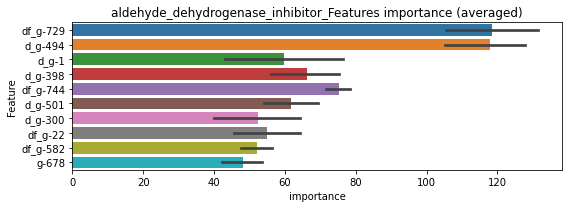

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124076	valid_1's binary_logloss: 0.0188771
[200]	training's binary_logloss: 0.00139929	valid_1's binary_logloss: 0.00590308
[300]	training's binary_logloss: 0.000379923	valid_1's binary_logloss: 0.00464841
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000305875	valid_1's binary_logloss: 0.00458205


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125302	valid_1's binary_logloss: 0.0168819
[200]	training's binary_logloss: 0.00148399	valid_1's binary_logloss: 0.00398691
[300]	training's binary_logloss: 0.000409124	valid_1's binary_logloss: 0.00222763
[400]	training's binary_logloss: 0.000212317	valid_1's binary_logloss: 0.0018355
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00017312	valid_1's binary_logloss: 0.00177182


aldehyde_dehydrogenase_inhibitor logloss: 0.003177119303099828


neg labels: 3289 → selected neg labels: 3282


alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320641	valid_1's binary_logloss: 0.065234
[200]	training's binary_logloss: 0.00475837	valid_1's binary_logloss: 0.0281773
[300]	training's binary_logloss: 0.00138942	valid_1's binary_logloss: 0.0202485
[400]	training's binary_logloss: 0.000693875	valid_1's binary_logloss: 0.0173551
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000655551	valid_1's binary_logloss: 0.0172272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330308	valid_1's binary_logloss: 0.0659349
[200]	training's binary_logloss: 0.00525993	valid_1's binary_logloss: 0.0291175
[300]	training's binary_logloss: 0.00150553	valid_1's binary_logloss: 0.0200334
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000797869	valid_1's binary_logloss: 0.0162105


1 / 3 AUC score:1.000
y_Threshold: 0.0066794, Threshold: 0.0154095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01387, conf_1:0.01695
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0154095
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_2: 0.0254095
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_3: 0.0354095
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_4: 0.0454095
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_5: 0.0554095
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_6: 0.0654095
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_7: 0.0754095
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_8: 0.0854095
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_9: 0.0954095
threshold: 0.0954095, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307389	valid_1's binary_logloss: 0.0611196
[200]	training's binary_logloss: 0.00438104	valid_1's binary_logloss: 0.0244319
[300]	training's binary_logloss: 0.00127908	valid_1's binary_logloss: 0.0174671
[400]	training's binary_logloss: 0.000652312	valid_1's binary_logloss: 0.015286
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000580316	valid_1's binary_logloss: 0.0150153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313589	valid_1's binary_logloss: 0.0627147
[200]	training's binary_logloss: 0.00452995	valid_1's binary_logloss: 0.0251007
[300]	training's binary_logloss: 0.00131345	valid_1's binary_logloss: 0.015927
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000717853	valid_1's binary_logloss: 0.0132907


2 / 3 AUC score:1.000
y_Threshold: 0.0777416, Threshold: 0.0954095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0133099 Vs.target_rate: 0.00176
Num_p_label: 53.0, conf_0:0.08587, conf_1:0.10495
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_1: 0.0954095
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_2: 0.1054095
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_3: 0.1154095
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_4: 0.1254095
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_5: 0.1354095
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_6: 0.1454095
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_7: 0.1554095
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_8: 0.1654095
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_9: 0.1754095
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_10: 0.1854095
threshold: 0.1954095, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305533	valid_1's binary_logloss: 0.0532355
[200]	training's binary_logloss: 0.00434153	valid_1's binary_logloss: 0.0176126
[300]	training's binary_logloss: 0.00125588	valid_1's binary_logloss: 0.012245
[400]	training's binary_logloss: 0.000636966	valid_1's binary_logloss: 0.0109314
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00047527	valid_1's binary_logloss: 0.0105147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316726	valid_1's binary_logloss: 0.0491015
[200]	training's binary_logloss: 0.00445674	valid_1's binary_logloss: 0.0116431
[300]	training's binary_logloss: 0.00130019	valid_1's binary_logloss: 0.00547171
[400]	training's binary_logloss: 0.000653253	valid_1's binary_logloss: 0.00391666
[500]	training's binary_logloss: 0.000450097	valid_1's binary_logloss: 0.00335148
Early stopping, best iteration is:
[535]

3 / 3 AUC score:1.000
y_Threshold: 0.0589598, Threshold: 0.1954095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0095429 Vs.target_rate: 0.00176
Num_p_label: 38.0, conf_0:0.17587, conf_1:0.21495
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_1: 0.1954095
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.2054095
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_3: 0.2154095
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_4: 0.2254095
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_5: 0.2354095
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_6: 0.2454095
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_7: 0.2554095
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_8: 0.2654095
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_9: 0.2754095
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_10: 0.2854095
threshold: 0.2954095, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 682.0/7774, y_label_rate: 0.0877283


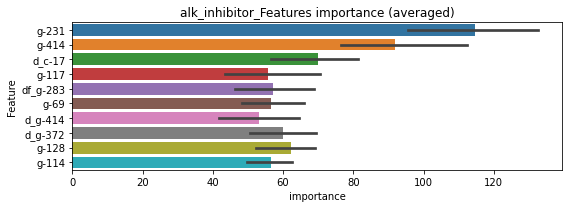

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165248	valid_1's binary_logloss: 0.0351793
[200]	training's binary_logloss: 0.002393	valid_1's binary_logloss: 0.0153217
[300]	training's binary_logloss: 0.000695509	valid_1's binary_logloss: 0.0113413
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000383911	valid_1's binary_logloss: 0.010778


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017517	valid_1's binary_logloss: 0.0348619
[200]	training's binary_logloss: 0.0026222	valid_1's binary_logloss: 0.0142383
[300]	training's binary_logloss: 0.000769079	valid_1's binary_logloss: 0.0101898
[400]	training's binary_logloss: 0.000385176	valid_1's binary_logloss: 0.0088775
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000353293	valid_1's binary_logloss: 0.00871523


alk_inhibitor logloss: 0.009746619545055719


neg labels: 3289 → selected neg labels: 3287


ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190071	valid_1's binary_logloss: 0.0240143
[200]	training's binary_logloss: 0.00195529	valid_1's binary_logloss: 0.00364493
[300]	training's binary_logloss: 0.000545614	valid_1's binary_logloss: 0.0013511
[400]	training's binary_logloss: 0.00030658	valid_1's binary_logloss: 0.000885101
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000266955	valid_1's binary_logloss: 0.000820222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188082	valid_1's binary_logloss: 0.0227761
[200]	training's binary_logloss: 0.00193244	valid_1's binary_logloss: 0.00357688
[300]	training's binary_logloss: 0.000553649	valid_1's binary_logloss: 0.00156134
[400]	training's binary_logloss: 0.000309672	valid_1's binary_logloss: 0.00110489
[500]	training's binary_logloss: 0.000264666	valid_1's binary_logloss: 0.0010324
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0009815, Threshold: 0.0015249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00137, conf_1:0.00168
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015249
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0115249
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.0215249
threshold: 0.0215249, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190926	valid_1's binary_logloss: 0.0239156
[200]	training's binary_logloss: 0.00190301	valid_1's binary_logloss: 0.00377628
[300]	training's binary_logloss: 0.00053885	valid_1's binary_logloss: 0.00145251
[400]	training's binary_logloss: 0.000307367	valid_1's binary_logloss: 0.00102916
[500]	training's binary_logloss: 0.000266912	valid_1's binary_logloss: 0.000965133
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000263768	valid_1's binary_logloss: 0.000960965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189501	valid_1's binary_logloss: 0.0220937
[200]	training's binary_logloss: 0.00188484	valid_1's binary_logloss: 0.00323538
[300]	training's binary_logloss: 0.000538278	valid_1's binary_logloss: 0.00145603
[400]	training's binary_logloss: 0.000308267	valid_1's binary_logloss: 0.00112743
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0571911, Threshold: 0.0215249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00050
Num_p_label: 12.0, conf_0:0.01937, conf_1:0.02368
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.0215249
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0315249
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0415249
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0515249
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_5: 0.0615249
threshold: 0.0615249, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190926	valid_1's binary_logloss: 0.0239156
[200]	training's binary_logloss: 0.00190301	valid_1's binary_logloss: 0.00377628
[300]	training's binary_logloss: 0.00053885	valid_1's binary_logloss: 0.00145251
[400]	training's binary_logloss: 0.000307367	valid_1's binary_logloss: 0.00102916
[500]	training's binary_logloss: 0.000266912	valid_1's binary_logloss: 0.000965133
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000263768	valid_1's binary_logloss: 0.000960965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189501	valid_1's binary_logloss: 0.0220937
[200]	training's binary_logloss: 0.00188484	valid_1's binary_logloss: 0.00323538
[300]	training's binary_logloss: 0.000538278	valid_1's binary_logloss: 0.00145603
[400]	training's binary_logloss: 0.000308267	valid_1's binary_logloss: 0.00112743
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0571911, Threshold: 0.0615249, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00050
Num_p_label: 2.0, conf_0:0.05537, conf_1:0.06768
threshold: 0.0615249, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


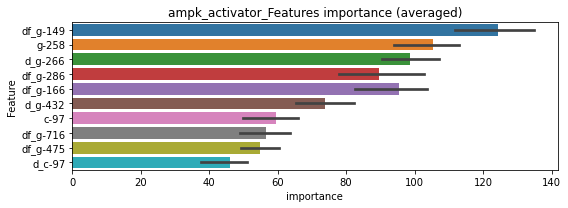

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100611	valid_1's binary_logloss: 0.013094
[200]	training's binary_logloss: 0.000996138	valid_1's binary_logloss: 0.00246082
[300]	training's binary_logloss: 0.000276301	valid_1's binary_logloss: 0.00157115
[400]	training's binary_logloss: 0.000155337	valid_1's binary_logloss: 0.0014726
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000153195	valid_1's binary_logloss: 0.00147087


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101775	valid_1's binary_logloss: 0.0131163
[200]	training's binary_logloss: 0.00100397	valid_1's binary_logloss: 0.00282436
[300]	training's binary_logloss: 0.000276848	valid_1's binary_logloss: 0.00182119
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00018549	valid_1's binary_logloss: 0.00175398


ampk_activator logloss: 0.0016124238321308854


neg labels: 3289 → selected neg labels: 3287


analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179898	valid_1's binary_logloss: 0.022761
[200]	training's binary_logloss: 0.00179875	valid_1's binary_logloss: 0.00343966
[300]	training's binary_logloss: 0.000510441	valid_1's binary_logloss: 0.00124205
[400]	training's binary_logloss: 0.000290683	valid_1's binary_logloss: 0.000774475
[500]	training's binary_logloss: 0.000256499	valid_1's binary_logloss: 0.000698665
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000254177	valid_1's binary_logloss: 0.000694566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180154	valid_1's binary_logloss: 0.0198757
[200]	training's binary_logloss: 0.00181114	valid_1's binary_logloss: 0.00230834
[300]	training's binary_logloss: 0.000514397	valid_1's binary_logloss: 0.000712847
[400]	training's binary_logloss: 0.000293072	valid_1's binary_logloss: 0.000419884
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0010282, Threshold: 0.0016639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00150, conf_1:0.00183
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016639
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0116639
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_3: 0.0216639
threshold: 0.0216639, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181814	valid_1's binary_logloss: 0.0215107
[200]	training's binary_logloss: 0.00179003	valid_1's binary_logloss: 0.00265068
[300]	training's binary_logloss: 0.000505221	valid_1's binary_logloss: 0.000841813
[400]	training's binary_logloss: 0.000290398	valid_1's binary_logloss: 0.000516579
[500]	training's binary_logloss: 0.000254239	valid_1's binary_logloss: 0.00046245
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000249765	valid_1's binary_logloss: 0.000456332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180614	valid_1's binary_logloss: 0.0202323
[200]	training's binary_logloss: 0.00176515	valid_1's binary_logloss: 0.00241315
[300]	training's binary_logloss: 0.000498391	valid_1's binary_logloss: 0.000778297
[400]	training's binary_logloss: 0.000289978	valid_1's binary_logloss: 0.000472047
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1531936, Threshold: 0.0216639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00050
Num_p_label: 9.0, conf_0:0.01950, conf_1:0.02383
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.0216639
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0316639
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0416639
threshold: 0.0416639, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181814	valid_1's binary_logloss: 0.0215107
[200]	training's binary_logloss: 0.00179003	valid_1's binary_logloss: 0.00265068
[300]	training's binary_logloss: 0.000505221	valid_1's binary_logloss: 0.000841813
[400]	training's binary_logloss: 0.000290398	valid_1's binary_logloss: 0.000516579
[500]	training's binary_logloss: 0.000254239	valid_1's binary_logloss: 0.00046245
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000249765	valid_1's binary_logloss: 0.000456332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180614	valid_1's binary_logloss: 0.0202323
[200]	training's binary_logloss: 0.00176515	valid_1's binary_logloss: 0.00241315
[300]	training's binary_logloss: 0.000498391	valid_1's binary_logloss: 0.000778297
[400]	training's binary_logloss: 0.000289978	valid_1's binary_logloss: 0.000472047
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1531936, Threshold: 0.0416639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.03750, conf_1:0.04583
threshold: 0.0416639, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


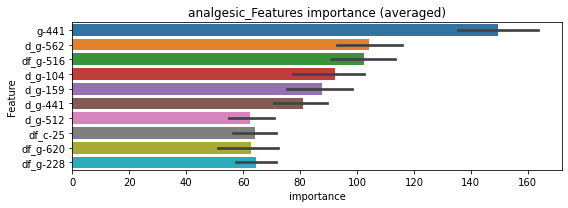

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00946253	valid_1's binary_logloss: 0.0135831
[200]	training's binary_logloss: 0.000902275	valid_1's binary_logloss: 0.00398589
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000302339	valid_1's binary_logloss: 0.0036025


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00970062	valid_1's binary_logloss: 0.0124999
[200]	training's binary_logloss: 0.000968676	valid_1's binary_logloss: 0.00351711
[300]	training's binary_logloss: 0.000268502	valid_1's binary_logloss: 0.00260466
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000216808	valid_1's binary_logloss: 0.00255871


analgesic logloss: 0.003080605350006386


neg labels: 3289 → selected neg labels: 3281


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437205	valid_1's binary_logloss: 0.100102
[200]	training's binary_logloss: 0.00757151	valid_1's binary_logloss: 0.0610398
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00297945	valid_1's binary_logloss: 0.0543294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465694	valid_1's binary_logloss: 0.0842547
[200]	training's binary_logloss: 0.00837397	valid_1's binary_logloss: 0.0333892
[300]	training's binary_logloss: 0.00232798	valid_1's binary_logloss: 0.0213692
[400]	training's binary_logloss: 0.00106496	valid_1's binary_logloss: 0.0170809
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000703768	valid_1's binary_logloss: 0.0157622


1 / 3 AUC score:0.996
y_Threshold: 0.0138082, Threshold: 0.0186988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01683, conf_1:0.02057
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0186988
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_2: 0.0286988
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_3: 0.0386988
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.0486988
threshold: 0.0486988, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439902	valid_1's binary_logloss: 0.0767799
[200]	training's binary_logloss: 0.00753381	valid_1's binary_logloss: 0.0323257
[300]	training's binary_logloss: 0.00212163	valid_1's binary_logloss: 0.022803
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00107587	valid_1's binary_logloss: 0.0199616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426068	valid_1's binary_logloss: 0.0848909
[200]	training's binary_logloss: 0.00754493	valid_1's binary_logloss: 0.0391612
[300]	training's binary_logloss: 0.00212214	valid_1's binary_logloss: 0.0285443
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00198131	valid_1's binary_logloss: 0.0284157


2 / 3 AUC score:1.000
y_Threshold: 0.0422546, Threshold: 0.0486988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0095429 Vs.target_rate: 0.00202
Num_p_label: 38.0, conf_0:0.04383, conf_1:0.05357
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_1: 0.0486988
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.0586988
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_3: 0.0686988
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.0786988
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.0886988
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.0986988
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_7: 0.1086988
threshold: 0.1086988, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435423	valid_1's binary_logloss: 0.0800724
[200]	training's binary_logloss: 0.00742222	valid_1's binary_logloss: 0.0335038
[300]	training's binary_logloss: 0.00207229	valid_1's binary_logloss: 0.0214636
[400]	training's binary_logloss: 0.000986128	valid_1's binary_logloss: 0.0189977
[500]	training's binary_logloss: 0.000625678	valid_1's binary_logloss: 0.0177542
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000641	valid_1's binary_logloss: 0.0177298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424354	valid_1's binary_logloss: 0.0705846
[200]	training's binary_logloss: 0.00724451	valid_1's binary_logloss: 0.0259478
[300]	training's binary_logloss: 0.00205144	valid_1's binary_logloss: 0.0167294
[400]	training's binary_logloss: 0.00096445	valid_1's binary_logloss: 0.0139826
[500]	training's binary_logloss: 0.000617724	

3 / 3 AUC score:1.000
y_Threshold: 0.0416114, Threshold: 0.1086988, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0027624 Vs.target_rate: 0.00202
Num_p_label: 11.0, conf_0:0.09783, conf_1:0.11957
threshold: 0.1086988, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/7753, y_label_rate: 0.0838385


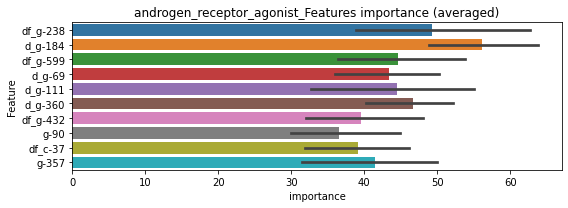

len(train_index) : 3876
len(valid_index) : 3877
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253048	valid_1's binary_logloss: 0.0457672
[200]	training's binary_logloss: 0.00445382	valid_1's binary_logloss: 0.0211732
[300]	training's binary_logloss: 0.00122366	valid_1's binary_logloss: 0.0157476
[400]	training's binary_logloss: 0.000546322	valid_1's binary_logloss: 0.0147187
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000581893	valid_1's binary_logloss: 0.0146644


len(train_index) : 3877
len(valid_index) : 3876
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023494	valid_1's binary_logloss: 0.0462105
[200]	training's binary_logloss: 0.00420042	valid_1's binary_logloss: 0.0192901
[300]	training's binary_logloss: 0.00115185	valid_1's binary_logloss: 0.0120565
[400]	training's binary_logloss: 0.000535184	valid_1's binary_logloss: 0.0102659
[500]	training's binary_logloss: 0.00033007	valid_1's binary_logloss: 0.00954359
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000342028	valid_1's binary_logloss: 0.00949421


androgen_receptor_agonist logloss: 0.012079641525101891


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684932	valid_1's binary_logloss: 0.142266
[200]	training's binary_logloss: 0.0159037	valid_1's binary_logloss: 0.090661
[300]	training's binary_logloss: 0.00464668	valid_1's binary_logloss: 0.0786122
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0031337	valid_1's binary_logloss: 0.0774074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071761	valid_1's binary_logloss: 0.142454
[200]	training's binary_logloss: 0.0171932	valid_1's binary_logloss: 0.0819273
[300]	training's binary_logloss: 0.00479724	valid_1's binary_logloss: 0.0651453
[400]	training's binary_logloss: 0.00198406	valid_1's binary_logloss: 0.060304
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00198406	valid_1's binary_logloss: 0.060304


1 / 3 AUC score:0.991
y_Threshold: 0.0206236, Threshold: 0.0316465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 178 → Positive_corect_labels: 631/3750
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.02848, conf_1:0.03481
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0316465
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_2: 0.0416465
Num_p_label: 24.0, Expected: 14.9, Adj_threshold_3: 0.0516465
threshold: 0.0516465, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 631.0/3750, y_label_rate: 0.1682667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631238	valid_1's binary_logloss: 0.127091
[200]	training's binary_logloss: 0.0139081	valid_1's binary_logloss: 0.071295
[300]	training's binary_logloss: 0.00406653	valid_1's binary_logloss: 0.0569649
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00219739	valid_1's binary_logloss: 0.0538226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635251	valid_1's binary_logloss: 0.132489
[200]	training's binary_logloss: 0.0139172	valid_1's binary_logloss: 0.0761617
[300]	training's binary_logloss: 0.00397324	valid_1's binary_logloss: 0.0607475
[400]	training's binary_logloss: 0.00175419	valid_1's binary_logloss: 0.056189
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00170797	valid_1's binary_logloss: 0.0561215


2 / 3 AUC score:0.997
y_Threshold: 0.0515592, Threshold: 0.0516465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 613.0/3714
p_label_rate: 0.0115520 Vs.target_rate: 0.00374
Num_p_label: 46.0, conf_0:0.04648, conf_1:0.05681
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_1: 0.0516465
Num_p_label: 33.0, Expected: 14.9, Adj_threshold_2: 0.0616465
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_3: 0.0716465
threshold: 0.0716465, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 613.0/3714, y_label_rate: 0.1650512
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579516	valid_1's binary_logloss: 0.132772
[200]	training's binary_logloss: 0.0129158	valid_1's binary_logloss: 0.0831221
[300]	training's binary_logloss: 0.00373903	valid_1's binary_logloss: 0.0695547
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00287128	valid_1's binary_logloss: 0.0679345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605381	valid_1's binary_logloss: 0.115549
[200]	training's binary_logloss: 0.0135146	valid_1's binary_logloss: 0.0563741
[300]	training's binary_logloss: 0.00399308	valid_1's binary_logloss: 0.0362529
[400]	training's binary_logloss: 0.00175948	valid_1's binary_logloss: 0.0298075
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00172499	valid_1's binary_logloss: 0.0296168


3 / 3 AUC score:0.997
y_Threshold: 0.0659389, Threshold: 0.0716465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 596.0/3680
p_label_rate: 0.0085384 Vs.target_rate: 0.00374
Num_p_label: 34.0, conf_0:0.06448, conf_1:0.07881
threshold: 0.0716465, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 630.0/7662, y_label_rate: 0.0822240


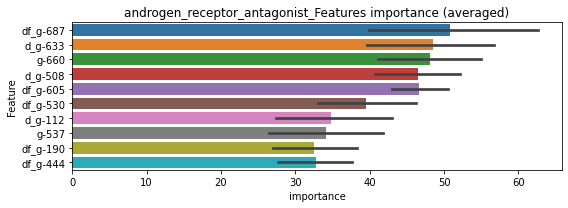

len(train_index) : 3831
len(valid_index) : 3831
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351209	valid_1's binary_logloss: 0.0813211
[200]	training's binary_logloss: 0.00783198	valid_1's binary_logloss: 0.0541456
[300]	training's binary_logloss: 0.00227984	valid_1's binary_logloss: 0.0492232
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00251122	valid_1's binary_logloss: 0.0490762


len(train_index) : 3831
len(valid_index) : 3831
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366113	valid_1's binary_logloss: 0.0772936
[200]	training's binary_logloss: 0.00826018	valid_1's binary_logloss: 0.0445103
[300]	training's binary_logloss: 0.00242867	valid_1's binary_logloss: 0.0364564
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00121257	valid_1's binary_logloss: 0.0346028


androgen_receptor_antagonist logloss: 0.04183949431602926


neg labels: 3289 → selected neg labels: 3276


anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587124	valid_1's binary_logloss: 0.129086
[200]	training's binary_logloss: 0.0128071	valid_1's binary_logloss: 0.0770427
[300]	training's binary_logloss: 0.00371605	valid_1's binary_logloss: 0.0636895
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00296269	valid_1's binary_logloss: 0.0617458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607034	valid_1's binary_logloss: 0.12692
[200]	training's binary_logloss: 0.0141873	valid_1's binary_logloss: 0.0756573
[300]	training's binary_logloss: 0.00405523	valid_1's binary_logloss: 0.0617386
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00205082	valid_1's binary_logloss: 0.0584755


1 / 3 AUC score:0.993
y_Threshold: 0.0194902, Threshold: 0.0275433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 639/3767
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.02479, conf_1:0.03030
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0275433
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_2: 0.0375433
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_3: 0.0475433
threshold: 0.0475433, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 639.0/3767, y_label_rate: 0.1696310
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568716	valid_1's binary_logloss: 0.118406
[200]	training's binary_logloss: 0.0122521	valid_1's binary_logloss: 0.0651298
[300]	training's binary_logloss: 0.00358621	valid_1's binary_logloss: 0.050108
[400]	training's binary_logloss: 0.00157615	valid_1's binary_logloss: 0.045242
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00156729	valid_1's binary_logloss: 0.0452342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580466	valid_1's binary_logloss: 0.120616
[200]	training's binary_logloss: 0.0124612	valid_1's binary_logloss: 0.0611521
[300]	training's binary_logloss: 0.0035678	valid_1's binary_logloss: 0.0443942
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0020139	valid_1's binary_logloss: 0.0406188


2 / 3 AUC score:0.998
y_Threshold: 0.0492727, Threshold: 0.0475433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 625.0/3739
p_label_rate: 0.0105475 Vs.target_rate: 0.00336
Num_p_label: 42.0, conf_0:0.04279, conf_1:0.05230
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_1: 0.0475433
Num_p_label: 31.0, Expected: 13.4, Adj_threshold_2: 0.0575433
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_3: 0.0675433
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_4: 0.0775433
threshold: 0.0775433, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 625.0/3739, y_label_rate: 0.1671570
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517926	valid_1's binary_logloss: 0.125137
[200]	training's binary_logloss: 0.0104967	valid_1's binary_logloss: 0.0758691
[300]	training's binary_logloss: 0.00325292	valid_1's binary_logloss: 0.0666916
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00322025	valid_1's binary_logloss: 0.0665746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055517	valid_1's binary_logloss: 0.107079
[200]	training's binary_logloss: 0.0116064	valid_1's binary_logloss: 0.0545069
[300]	training's binary_logloss: 0.00335999	valid_1's binary_logloss: 0.0402227
[400]	training's binary_logloss: 0.00152801	valid_1's binary_logloss: 0.0363083
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00146259	valid_1's binary_logloss: 0.0361108


3 / 3 AUC score:0.999
y_Threshold: 0.0448239, Threshold: 0.0775433, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 611.0/3711
p_label_rate: 0.0040181 Vs.target_rate: 0.00336
Num_p_label: 16.0, conf_0:0.06979, conf_1:0.08530
threshold: 0.0775433, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 627.0/7693, y_label_rate: 0.0815027


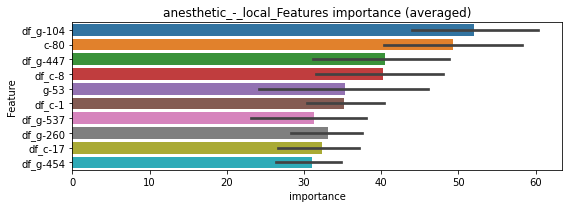

len(train_index) : 3846
len(valid_index) : 3847
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303689	valid_1's binary_logloss: 0.0695612
[200]	training's binary_logloss: 0.00601868	valid_1's binary_logloss: 0.0434824
[300]	training's binary_logloss: 0.00180654	valid_1's binary_logloss: 0.0376547
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00189956	valid_1's binary_logloss: 0.0375476


len(train_index) : 3847
len(valid_index) : 3846
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310672	valid_1's binary_logloss: 0.0644978
[200]	training's binary_logloss: 0.00627734	valid_1's binary_logloss: 0.034986
[300]	training's binary_logloss: 0.00181206	valid_1's binary_logloss: 0.0283708
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00155264	valid_1's binary_logloss: 0.0281573


anesthetic_-_local logloss: 0.03285307680783821


neg labels: 3289 → selected neg labels: 3283


angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384888	valid_1's binary_logloss: 0.0578604
[200]	training's binary_logloss: 0.00637864	valid_1's binary_logloss: 0.0170526
[300]	training's binary_logloss: 0.00172893	valid_1's binary_logloss: 0.00807123
[400]	training's binary_logloss: 0.000808312	valid_1's binary_logloss: 0.00527488
[500]	training's binary_logloss: 0.000529359	valid_1's binary_logloss: 0.00428281
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000453359	valid_1's binary_logloss: 0.00396343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386125	valid_1's binary_logloss: 0.0641561
[200]	training's binary_logloss: 0.00603445	valid_1's binary_logloss: 0.0208677
[300]	training's binary_logloss: 0.00165958	valid_1's binary_logloss: 0.0125207
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00164369	valid_1's binary_logloss: 0.0124974


1 / 3 AUC score:1.000
y_Threshold: 0.0067719, Threshold: 0.0108163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00973, conf_1:0.01190
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0108163
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.0208163
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0308163
threshold: 0.0308163, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371945	valid_1's binary_logloss: 0.0549431
[200]	training's binary_logloss: 0.00570981	valid_1's binary_logloss: 0.0145781
[300]	training's binary_logloss: 0.00160043	valid_1's binary_logloss: 0.00649509
[400]	training's binary_logloss: 0.000775682	valid_1's binary_logloss: 0.00427649
[500]	training's binary_logloss: 0.000515835	valid_1's binary_logloss: 0.00350336
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000451626	valid_1's binary_logloss: 0.00329082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386453	valid_1's binary_logloss: 0.0611883
[200]	training's binary_logloss: 0.00597216	valid_1's binary_logloss: 0.0184467
[300]	training's binary_logloss: 0.00162581	valid_1's binary_logloss: 0.0105777
[400]	training's binary_logloss: 0.000780101	valid_1's binary_logloss: 0.00913295
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0449916, Threshold: 0.0308163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0057760 Vs.target_rate: 0.00151
Num_p_label: 23.0, conf_0:0.02773, conf_1:0.03390
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.0308163
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0408163
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0508163
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.0608163
threshold: 0.0608163, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371945	valid_1's binary_logloss: 0.0549431
[200]	training's binary_logloss: 0.00570981	valid_1's binary_logloss: 0.0145781
[300]	training's binary_logloss: 0.00160043	valid_1's binary_logloss: 0.00649509
[400]	training's binary_logloss: 0.000775682	valid_1's binary_logloss: 0.00427649
[500]	training's binary_logloss: 0.000515835	valid_1's binary_logloss: 0.00350336
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000451626	valid_1's binary_logloss: 0.00329082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386453	valid_1's binary_logloss: 0.0611883
[200]	training's binary_logloss: 0.00597216	valid_1's binary_logloss: 0.0184467
[300]	training's binary_logloss: 0.00162581	valid_1's binary_logloss: 0.0105777
[400]	training's binary_logloss: 0.000780101	valid_1's binary_logloss: 0.00913295
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0449916, Threshold: 0.0608163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0022602 Vs.target_rate: 0.00151
Num_p_label: 9.0, conf_0:0.05473, conf_1:0.06690
threshold: 0.0608163, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7789, y_label_rate: 0.0853768


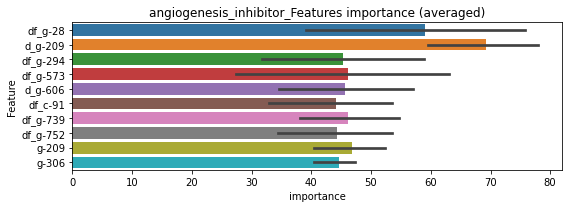

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213109	valid_1's binary_logloss: 0.0416165
[200]	training's binary_logloss: 0.00331487	valid_1's binary_logloss: 0.018668
[300]	training's binary_logloss: 0.000876228	valid_1's binary_logloss: 0.0145949
[400]	training's binary_logloss: 0.000405672	valid_1's binary_logloss: 0.0136143
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000384992	valid_1's binary_logloss: 0.0135244


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021595	valid_1's binary_logloss: 0.036023
[200]	training's binary_logloss: 0.00354848	valid_1's binary_logloss: 0.0118539
[300]	training's binary_logloss: 0.000950962	valid_1's binary_logloss: 0.00679435
[400]	training's binary_logloss: 0.000437791	valid_1's binary_logloss: 0.00561661
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000294329	valid_1's binary_logloss: 0.00523302


angiogenesis_inhibitor logloss: 0.009379230135554794


neg labels: 3289 → selected neg labels: 3283


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037944	valid_1's binary_logloss: 0.0666706
[200]	training's binary_logloss: 0.00585138	valid_1's binary_logloss: 0.0250279
[300]	training's binary_logloss: 0.0015895	valid_1's binary_logloss: 0.0154818
[400]	training's binary_logloss: 0.000760761	valid_1's binary_logloss: 0.0131819
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000551635	valid_1's binary_logloss: 0.0126736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381342	valid_1's binary_logloss: 0.0657003
[200]	training's binary_logloss: 0.00613422	valid_1's binary_logloss: 0.0225981
[300]	training's binary_logloss: 0.00168403	valid_1's binary_logloss: 0.0130373
[400]	training's binary_logloss: 0.00079199	valid_1's binary_logloss: 0.00991979
[500]	training's binary_logloss: 0.000515675	valid_1's binary_logloss: 0.00897764
Early stopping, best iteration is:
[510]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0040805, Threshold: 0.0055655, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00501, conf_1:0.00612
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0055655
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0155655
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0255655
threshold: 0.0255655, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374002	valid_1's binary_logloss: 0.0646505
[200]	training's binary_logloss: 0.00565657	valid_1's binary_logloss: 0.025865
[300]	training's binary_logloss: 0.00154124	valid_1's binary_logloss: 0.0169712
[400]	training's binary_logloss: 0.000746107	valid_1's binary_logloss: 0.0145777
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000686349	valid_1's binary_logloss: 0.0143967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375118	valid_1's binary_logloss: 0.0621951
[200]	training's binary_logloss: 0.00574641	valid_1's binary_logloss: 0.0191179
[300]	training's binary_logloss: 0.00159867	valid_1's binary_logloss: 0.00992106
[400]	training's binary_logloss: 0.000758155	valid_1's binary_logloss: 0.00725733
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00057207	valid_1's binary_logloss: 0.00652817


2 / 3 AUC score:1.000
y_Threshold: 0.0353514, Threshold: 0.0255655, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155
Num_p_label: 17.0, conf_0:0.02301, conf_1:0.02812
threshold: 0.0255655, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374002	valid_1's binary_logloss: 0.0646505
[200]	training's binary_logloss: 0.00565657	valid_1's binary_logloss: 0.025865
[300]	training's binary_logloss: 0.00154124	valid_1's binary_logloss: 0.0169712
[400]	training's binary_logloss: 0.000746107	valid_1's binary_logloss: 0.0145777
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000686349	valid_1's binary_logloss: 0.0143967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375118	valid_1's binary_logloss: 0.0621951
[200]	training's binary_logloss: 0.00574641	valid_1's binary_logloss: 0.0191179
[300]	training's binary_logloss: 0.00159867	valid_1's binary_logloss: 0.00992106
[400]	training's binary_logloss: 0.000758155	valid_1's binary_logloss: 0.00725733
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00057207	valid_1's binary_logloss: 0.00652817


3 / 3 AUC score:1.000
y_Threshold: 0.0353514, Threshold: 0.0255655, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155
Num_p_label: 17.0, conf_0:0.02301, conf_1:0.02812
threshold: 0.0255655, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


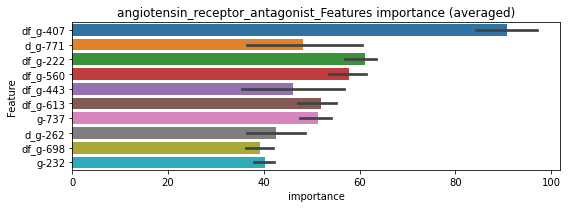

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213206	valid_1's binary_logloss: 0.0523528
[200]	training's binary_logloss: 0.00316571	valid_1's binary_logloss: 0.031904
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00107583	valid_1's binary_logloss: 0.029707


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227746	valid_1's binary_logloss: 0.0369066
[200]	training's binary_logloss: 0.00367361	valid_1's binary_logloss: 0.0141373
[300]	training's binary_logloss: 0.00101787	valid_1's binary_logloss: 0.0107901
[400]	training's binary_logloss: 0.000440131	valid_1's binary_logloss: 0.00992134
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000454373	valid_1's binary_logloss: 0.00991562


angiotensin_receptor_antagonist logloss: 0.01981256550253802


neg labels: 3289 → selected neg labels: 3277


anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558072	valid_1's binary_logloss: 0.100117
[200]	training's binary_logloss: 0.0111773	valid_1's binary_logloss: 0.0454153
[300]	training's binary_logloss: 0.00313102	valid_1's binary_logloss: 0.0313174
[400]	training's binary_logloss: 0.0013879	valid_1's binary_logloss: 0.0269256
[500]	training's binary_logloss: 0.00084861	valid_1's binary_logloss: 0.0252346
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000777834	valid_1's binary_logloss: 0.0248977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503586	valid_1's binary_logloss: 0.104368
[200]	training's binary_logloss: 0.0101378	valid_1's binary_logloss: 0.05498
[300]	training's binary_logloss: 0.00298696	valid_1's binary_logloss: 0.0434428
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0015923	valid_1's binary_logloss: 0.0401345


1 / 3 AUC score:0.996
y_Threshold: 0.0118244, Threshold: 0.0218684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3780
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01968, conf_1:0.02406
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0218684
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.0318684
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.0418684
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_4: 0.0518684
threshold: 0.0518684, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 645.0/3780, y_label_rate: 0.1706349
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486523	valid_1's binary_logloss: 0.109901
[200]	training's binary_logloss: 0.00924658	valid_1's binary_logloss: 0.0641298
[300]	training's binary_logloss: 0.00266445	valid_1's binary_logloss: 0.0549293
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00161863	valid_1's binary_logloss: 0.0518428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471313	valid_1's binary_logloss: 0.105739
[200]	training's binary_logloss: 0.00890842	valid_1's binary_logloss: 0.0568132
[300]	training's binary_logloss: 0.00254337	valid_1's binary_logloss: 0.0452261
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00186228	valid_1's binary_logloss: 0.0442969


2 / 3 AUC score:0.997
y_Threshold: 0.0429970, Threshold: 0.0518684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 626.0/3742
p_label_rate: 0.0138122 Vs.target_rate: 0.00307
Num_p_label: 55.0, conf_0:0.04668, conf_1:0.05706
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_1: 0.0518684
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0618684
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_3: 0.0718684
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_4: 0.0818684
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_5: 0.0918684
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_6: 0.1018684
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_7: 0.1118684
threshold: 0.1118684, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 626.0/3742, y_label_rate: 0.1672902
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442606	valid_1's binary_logloss: 0.107762
[200]	training's binary_logloss: 0.00802915	valid_1's binary_logloss: 0.074087
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00453617	valid_1's binary_logloss: 0.0701131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454563	valid_1's binary_logloss: 0.0955105
[200]	training's binary_logloss: 0.00837304	valid_1's binary_logloss: 0.048185
[300]	training's binary_logloss: 0.00242761	valid_1's binary_logloss: 0.039407
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00208599	valid_1's binary_logloss: 0.0390415


3 / 3 AUC score:0.995
y_Threshold: 0.0560892, Threshold: 0.1118684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 607.0/3704
p_label_rate: 0.0060271 Vs.target_rate: 0.00307
Num_p_label: 24.0, conf_0:0.10068, conf_1:0.12306
threshold: 0.1118684, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 631.0/7686, y_label_rate: 0.0820973


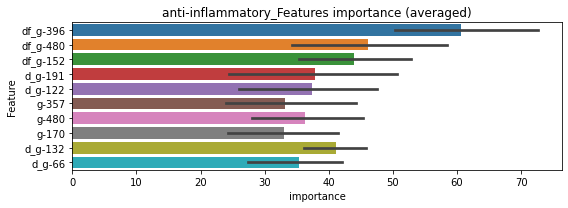

len(train_index) : 3843
len(valid_index) : 3843
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242518	valid_1's binary_logloss: 0.0664609
[200]	training's binary_logloss: 0.00435411	valid_1's binary_logloss: 0.045787
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00186644	valid_1's binary_logloss: 0.0439121


len(train_index) : 3843
len(valid_index) : 3843
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262534	valid_1's binary_logloss: 0.0523445
[200]	training's binary_logloss: 0.00516059	valid_1's binary_logloss: 0.0289217
[300]	training's binary_logloss: 0.00144538	valid_1's binary_logloss: 0.0240532
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000920751	valid_1's binary_logloss: 0.0232215


anti-inflammatory logloss: 0.03356677482259283


neg labels: 3289 → selected neg labels: 3285


antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268826	valid_1's binary_logloss: 0.0465575
[200]	training's binary_logloss: 0.0035218	valid_1's binary_logloss: 0.0175785
[300]	training's binary_logloss: 0.000985678	valid_1's binary_logloss: 0.0126067
[400]	training's binary_logloss: 0.00049752	valid_1's binary_logloss: 0.0111064
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000388293	valid_1's binary_logloss: 0.0107781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279592	valid_1's binary_logloss: 0.0377168
[200]	training's binary_logloss: 0.00367314	valid_1's binary_logloss: 0.00690842
[300]	training's binary_logloss: 0.00102209	valid_1's binary_logloss: 0.00252116
[400]	training's binary_logloss: 0.000517734	valid_1's binary_logloss: 0.00153078
[500]	training's binary_logloss: 0.000392086	valid_1's binary_logloss: 0.0012834
Early stopping, best iteration is:
[521

1 / 3 AUC score:1.000
y_Threshold: 0.0018885, Threshold: 0.0158835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.01430, conf_1:0.01747
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0158835
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_2: 0.0258835
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_3: 0.0358835
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.0458835
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_5: 0.0558835
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_6: 0.0658835
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_7: 0.0758835
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_8: 0.0858835
threshold: 0.0858835, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261072	valid_1's binary_logloss: 0.0429442
[200]	training's binary_logloss: 0.00325006	valid_1's binary_logloss: 0.0132717
[300]	training's binary_logloss: 0.000928637	valid_1's binary_logloss: 0.00896612
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000654355	valid_1's binary_logloss: 0.00824429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272254	valid_1's binary_logloss: 0.0352749
[200]	training's binary_logloss: 0.00347175	valid_1's binary_logloss: 0.00602943
[300]	training's binary_logloss: 0.000966078	valid_1's binary_logloss: 0.00197317
[400]	training's binary_logloss: 0.000492237	valid_1's binary_logloss: 0.00113532
[500]	training's binary_logloss: 0.000374793	valid_1's binary_logloss: 0.000921309
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000369003	valid_1's binary_logloss: 0.00091

2 / 3 AUC score:1.000
y_Threshold: 0.0338531, Threshold: 0.0858835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0339026 Vs.target_rate: 0.00101
Num_p_label: 135.0, conf_0:0.07730, conf_1:0.09447
Num_p_label: 135.0, Expected: 4.0, Adj_threshold_1: 0.0858835
Num_p_label: 129.0, Expected: 4.0, Adj_threshold_2: 0.0958835
Num_p_label: 120.0, Expected: 4.0, Adj_threshold_3: 0.1058835
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_4: 0.1158835
Num_p_label: 110.0, Expected: 4.0, Adj_threshold_5: 0.1258835
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_6: 0.1358835
Num_p_label: 102.0, Expected: 4.0, Adj_threshold_7: 0.1458835
Num_p_label: 95.0, Expected: 4.0, Adj_threshold_8: 0.1558835
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_9: 0.1658835
Num_p_label: 86.0, Expected: 4.0, Adj_threshold_10: 0.1758835
threshold: 0.1858835, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
=

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263453	valid_1's binary_logloss: 0.0416701
[200]	training's binary_logloss: 0.00323868	valid_1's binary_logloss: 0.0102319
[300]	training's binary_logloss: 0.000923702	valid_1's binary_logloss: 0.00552897
[400]	training's binary_logloss: 0.000478641	valid_1's binary_logloss: 0.00449844
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000385892	valid_1's binary_logloss: 0.00423179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270515	valid_1's binary_logloss: 0.0374853
[200]	training's binary_logloss: 0.00337359	valid_1's binary_logloss: 0.007962
[300]	training's binary_logloss: 0.000940038	valid_1's binary_logloss: 0.00342631
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000567703	valid_1's binary_logloss: 0.00256026


3 / 3 AUC score:1.000
y_Threshold: 0.0432447, Threshold: 0.1858835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0238574 Vs.target_rate: 0.00101
Num_p_label: 95.0, conf_0:0.16730, conf_1:0.20447
Num_p_label: 95.0, Expected: 4.0, Adj_threshold_1: 0.1858835
Num_p_label: 91.0, Expected: 4.0, Adj_threshold_2: 0.1958835
Num_p_label: 88.0, Expected: 4.0, Adj_threshold_3: 0.2058835
Num_p_label: 85.0, Expected: 4.0, Adj_threshold_4: 0.2158835
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_5: 0.2258835
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_6: 0.2358835
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_7: 0.2458835
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_8: 0.2558835
Num_p_label: 75.0, Expected: 4.0, Adj_threshold_9: 0.2658835
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_10: 0.2758835
threshold: 0.2858835, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 726.0/7788, y_label_rate: 0.0932203


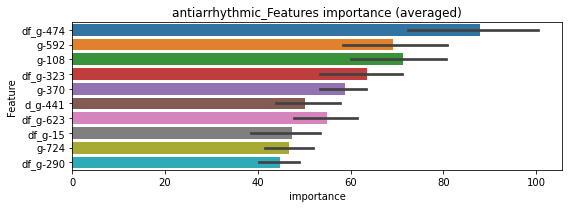

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183183	valid_1's binary_logloss: 0.0349704
[200]	training's binary_logloss: 0.00265347	valid_1's binary_logloss: 0.0181626
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00126987	valid_1's binary_logloss: 0.0159754


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181812	valid_1's binary_logloss: 0.0322952
[200]	training's binary_logloss: 0.0027234	valid_1's binary_logloss: 0.014815
[300]	training's binary_logloss: 0.000751703	valid_1's binary_logloss: 0.0131289
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00082993	valid_1's binary_logloss: 0.0131197


antiarrhythmic logloss: 0.014547575385869736


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042896	valid_1's binary_logloss: 0.0665438
[200]	training's binary_logloss: 0.00712511	valid_1's binary_logloss: 0.0176002
[300]	training's binary_logloss: 0.00195326	valid_1's binary_logloss: 0.00767397
[400]	training's binary_logloss: 0.00090427	valid_1's binary_logloss: 0.00485476
[500]	training's binary_logloss: 0.000583498	valid_1's binary_logloss: 0.00387191
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00050235	valid_1's binary_logloss: 0.00366912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042509	valid_1's binary_logloss: 0.0721659
[200]	training's binary_logloss: 0.00699075	valid_1's binary_logloss: 0.0236888
[300]	training's binary_logloss: 0.00188756	valid_1's binary_logloss: 0.0123615
[400]	training's binary_logloss: 0.000882064	valid_1's binary_logloss: 0.00905747
Early stopping, best iteration is:
[485]

1 / 3 AUC score:1.000
y_Threshold: 0.0040998, Threshold: 0.0074524, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181
Num_p_label: 80.0, conf_0:0.00671, conf_1:0.00820
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0074524
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_2: 0.0174524
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_3: 0.0274524
threshold: 0.0274524, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404698	valid_1's binary_logloss: 0.0675672
[200]	training's binary_logloss: 0.00654483	valid_1's binary_logloss: 0.0196225
[300]	training's binary_logloss: 0.00182073	valid_1's binary_logloss: 0.00886111
[400]	training's binary_logloss: 0.000863879	valid_1's binary_logloss: 0.00691101
[500]	training's binary_logloss: 0.000564318	valid_1's binary_logloss: 0.00561203
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000495391	valid_1's binary_logloss: 0.00532573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425002	valid_1's binary_logloss: 0.069547
[200]	training's binary_logloss: 0.00688998	valid_1's binary_logloss: 0.021334
[300]	training's binary_logloss: 0.00186841	valid_1's binary_logloss: 0.0109609
[400]	training's binary_logloss: 0.0008756	valid_1's binary_logloss: 0.00809327
[500]	training's binary_logloss: 0.00056

2 / 3 AUC score:1.000
y_Threshold: 0.0309087, Threshold: 0.0274524, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0115520 Vs.target_rate: 0.00181
Num_p_label: 46.0, conf_0:0.02471, conf_1:0.03020
Num_p_label: 46.0, Expected: 7.2, Adj_threshold_1: 0.0274524
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_2: 0.0374524
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_3: 0.0474524
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_4: 0.0574524
threshold: 0.0574524, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416678	valid_1's binary_logloss: 0.0695803
[200]	training's binary_logloss: 0.00643506	valid_1's binary_logloss: 0.0190192
[300]	training's binary_logloss: 0.00179038	valid_1's binary_logloss: 0.00891552
[400]	training's binary_logloss: 0.000851115	valid_1's binary_logloss: 0.00619911
[500]	training's binary_logloss: 0.000562354	valid_1's binary_logloss: 0.00526628
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000488961	valid_1's binary_logloss: 0.00501583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420513	valid_1's binary_logloss: 0.0746444
[200]	training's binary_logloss: 0.00650077	valid_1's binary_logloss: 0.028584
[300]	training's binary_logloss: 0.00175533	valid_1's binary_logloss: 0.0191878
[400]	training's binary_logloss: 0.000846639	valid_1's binary_logloss: 0.0163519
Early stopping, best iteration is:
[39

3 / 3 AUC score:1.000
y_Threshold: 0.0382206, Threshold: 0.0574524, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0037670 Vs.target_rate: 0.00181
Num_p_label: 15.0, conf_0:0.05171, conf_1:0.06320
threshold: 0.0574524, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 669.0/7783, y_label_rate: 0.0859566


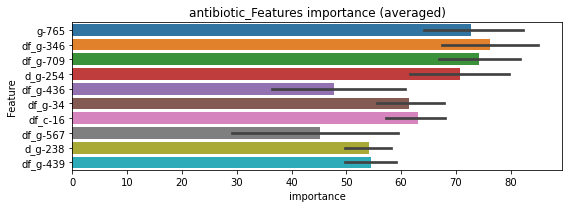

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225265	valid_1's binary_logloss: 0.0491704
[200]	training's binary_logloss: 0.00354085	valid_1's binary_logloss: 0.0250401
[300]	training's binary_logloss: 0.000966016	valid_1's binary_logloss: 0.0208729
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000639154	valid_1's binary_logloss: 0.0198463


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250646	valid_1's binary_logloss: 0.0432769
[200]	training's binary_logloss: 0.00422009	valid_1's binary_logloss: 0.0166509
[300]	training's binary_logloss: 0.0010687	valid_1's binary_logloss: 0.0102238
[400]	training's binary_logloss: 0.000492152	valid_1's binary_logloss: 0.00854338
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000348626	valid_1's binary_logloss: 0.00814026


antibiotic logloss: 0.013994041362906138


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230469	valid_1's binary_logloss: 0.0300913
[200]	training's binary_logloss: 0.00271214	valid_1's binary_logloss: 0.00535014
[300]	training's binary_logloss: 0.000764621	valid_1's binary_logloss: 0.00206837
[400]	training's binary_logloss: 0.000412981	valid_1's binary_logloss: 0.00129843
[500]	training's binary_logloss: 0.000326982	valid_1's binary_logloss: 0.00111124
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000321275	valid_1's binary_logloss: 0.00110363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230993	valid_1's binary_logloss: 0.0287653
[200]	training's binary_logloss: 0.00269782	valid_1's binary_logloss: 0.00459425
[300]	training's binary_logloss: 0.000755557	valid_1's binary_logloss: 0.00164188
[400]	training's binary_logloss: 0.000406748	valid_1's binary_logloss: 0.00102972
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0016898, Threshold: 0.0025825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00232, conf_1:0.00284
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025825
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0125825
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0225825
threshold: 0.0225825, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225012	valid_1's binary_logloss: 0.0284193
[200]	training's binary_logloss: 0.00255782	valid_1's binary_logloss: 0.00472182
[300]	training's binary_logloss: 0.000741648	valid_1's binary_logloss: 0.00176071
[400]	training's binary_logloss: 0.000402632	valid_1's binary_logloss: 0.00108481
[500]	training's binary_logloss: 0.000324503	valid_1's binary_logloss: 0.000937444
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000317667	valid_1's binary_logloss: 0.000927906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222399	valid_1's binary_logloss: 0.0283408
[200]	training's binary_logloss: 0.00256053	valid_1's binary_logloss: 0.00459709
[300]	training's binary_logloss: 0.000730772	valid_1's binary_logloss: 0.00167443
[400]	training's binary_logloss: 0.000397146	valid_1's binary_logloss: 0.00108532
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1277975, Threshold: 0.0225825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076
Num_p_label: 12.0, conf_0:0.02032, conf_1:0.02484
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0225825
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0325825
threshold: 0.0325825, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225012	valid_1's binary_logloss: 0.0284193
[200]	training's binary_logloss: 0.00255782	valid_1's binary_logloss: 0.00472182
[300]	training's binary_logloss: 0.000741648	valid_1's binary_logloss: 0.00176071
[400]	training's binary_logloss: 0.000402632	valid_1's binary_logloss: 0.00108481
[500]	training's binary_logloss: 0.000324503	valid_1's binary_logloss: 0.000937444
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000317667	valid_1's binary_logloss: 0.000927906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222399	valid_1's binary_logloss: 0.0283408
[200]	training's binary_logloss: 0.00256053	valid_1's binary_logloss: 0.00459709
[300]	training's binary_logloss: 0.000730772	valid_1's binary_logloss: 0.00167443
[400]	training's binary_logloss: 0.000397146	valid_1's binary_logloss: 0.00108532
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1277975, Threshold: 0.0325825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.02932, conf_1:0.03584
threshold: 0.0325825, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


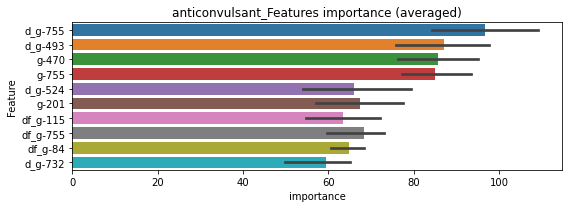

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128017	valid_1's binary_logloss: 0.0190094
[200]	training's binary_logloss: 0.00145793	valid_1's binary_logloss: 0.0066593
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000446928	valid_1's binary_logloss: 0.00567686


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128792	valid_1's binary_logloss: 0.0178483
[200]	training's binary_logloss: 0.00150416	valid_1's binary_logloss: 0.00356569
[300]	training's binary_logloss: 0.000424145	valid_1's binary_logloss: 0.00198052
[400]	training's binary_logloss: 0.000213288	valid_1's binary_logloss: 0.00170474
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000208729	valid_1's binary_logloss: 0.00169536


anticonvulsant logloss: 0.003686367588164915


neg labels: 3289 → selected neg labels: 3284


antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288143	valid_1's binary_logloss: 0.0420497
[200]	training's binary_logloss: 0.0038248	valid_1's binary_logloss: 0.00898795
[300]	training's binary_logloss: 0.00106387	valid_1's binary_logloss: 0.00386864
[400]	training's binary_logloss: 0.000537704	valid_1's binary_logloss: 0.00252758
[500]	training's binary_logloss: 0.000392908	valid_1's binary_logloss: 0.00211802
[600]	training's binary_logloss: 0.000372503	valid_1's binary_logloss: 0.00206015
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000372461	valid_1's binary_logloss: 0.00205979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292312	valid_1's binary_logloss: 0.0457293
[200]	training's binary_logloss: 0.00389852	valid_1's binary_logloss: 0.0109576
[300]	training's binary_logloss: 0.00108883	valid_1's binary_logloss: 0.00489571
[400]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0019722, Threshold: 0.0027696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00305
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0027696
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_2: 0.0127696
threshold: 0.0127696, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301466	valid_1's binary_logloss: 0.0435565
[200]	training's binary_logloss: 0.00388522	valid_1's binary_logloss: 0.00935459
[300]	training's binary_logloss: 0.00106965	valid_1's binary_logloss: 0.00394534
[400]	training's binary_logloss: 0.000537741	valid_1's binary_logloss: 0.00249705
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000402555	valid_1's binary_logloss: 0.00216777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029553	valid_1's binary_logloss: 0.046357
[200]	training's binary_logloss: 0.00383729	valid_1's binary_logloss: 0.0112081
[300]	training's binary_logloss: 0.00106214	valid_1's binary_logloss: 0.00505903
[400]	training's binary_logloss: 0.000539072	valid_1's binary_logloss: 0.00329479
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000429856	valid_1's binary_logloss: 0.0029099


2 / 3 AUC score:1.000
y_Threshold: 0.0658970, Threshold: 0.0127696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00109
Num_p_label: 8.0, conf_0:0.01149, conf_1:0.01405
threshold: 0.0127696, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301466	valid_1's binary_logloss: 0.0435565
[200]	training's binary_logloss: 0.00388522	valid_1's binary_logloss: 0.00935459
[300]	training's binary_logloss: 0.00106965	valid_1's binary_logloss: 0.00394534
[400]	training's binary_logloss: 0.000537741	valid_1's binary_logloss: 0.00249705
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000402555	valid_1's binary_logloss: 0.00216777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029553	valid_1's binary_logloss: 0.046357
[200]	training's binary_logloss: 0.00383729	valid_1's binary_logloss: 0.0112081
[300]	training's binary_logloss: 0.00106214	valid_1's binary_logloss: 0.00505903
[400]	training's binary_logloss: 0.000539072	valid_1's binary_logloss: 0.00329479
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000429856	valid_1's binary_logloss: 0.0029099


3 / 3 AUC score:1.000
y_Threshold: 0.0658970, Threshold: 0.0127696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00109
Num_p_label: 8.0, conf_0:0.01149, conf_1:0.01405
threshold: 0.0127696, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7790, y_label_rate: 0.0852375


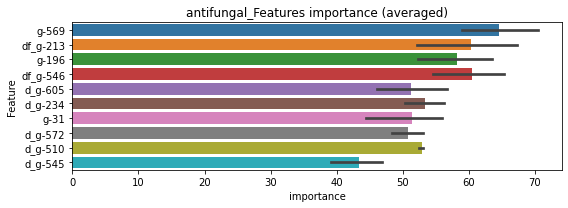

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015784	valid_1's binary_logloss: 0.0308865
[200]	training's binary_logloss: 0.00201245	valid_1's binary_logloss: 0.0118839
[300]	training's binary_logloss: 0.00054833	valid_1's binary_logloss: 0.00914293
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00060355	valid_1's binary_logloss: 0.00914206


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163086	valid_1's binary_logloss: 0.0260481
[200]	training's binary_logloss: 0.00215296	valid_1's binary_logloss: 0.00856678
[300]	training's binary_logloss: 0.000583731	valid_1's binary_logloss: 0.00625829
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000588576	valid_1's binary_logloss: 0.00625207


antifungal logloss: 0.007697064290848518


neg labels: 3289 → selected neg labels: 3286


antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227918	valid_1's binary_logloss: 0.0318165
[200]	training's binary_logloss: 0.00266361	valid_1's binary_logloss: 0.00589913
[300]	training's binary_logloss: 0.000752786	valid_1's binary_logloss: 0.00223255
[400]	training's binary_logloss: 0.000403551	valid_1's binary_logloss: 0.00135937
[500]	training's binary_logloss: 0.000323205	valid_1's binary_logloss: 0.00116401
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00031797	valid_1's binary_logloss: 0.00115408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235401	valid_1's binary_logloss: 0.0314154
[200]	training's binary_logloss: 0.00280373	valid_1's binary_logloss: 0.00625736
[300]	training's binary_logloss: 0.000782104	valid_1's binary_logloss: 0.0029828
[400]	training's binary_logloss: 0.000408411	valid_1's binary_logloss: 0.00216141
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0016060, Threshold: 0.0027751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00250, conf_1:0.00305
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027751
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0127751
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0227751
threshold: 0.0227751, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022584	valid_1's binary_logloss: 0.0316234
[200]	training's binary_logloss: 0.00258829	valid_1's binary_logloss: 0.00602829
[300]	training's binary_logloss: 0.000728687	valid_1's binary_logloss: 0.00245956
[400]	training's binary_logloss: 0.000397235	valid_1's binary_logloss: 0.00159445
[500]	training's binary_logloss: 0.000321378	valid_1's binary_logloss: 0.00140155
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000318908	valid_1's binary_logloss: 0.00139621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230837	valid_1's binary_logloss: 0.0299782
[200]	training's binary_logloss: 0.00271374	valid_1's binary_logloss: 0.00508907
[300]	training's binary_logloss: 0.000757784	valid_1's binary_logloss: 0.00178767
[400]	training's binary_logloss: 0.00040771	valid_1's binary_logloss: 0.00122591
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1133349, Threshold: 0.0227751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00076
Num_p_label: 14.0, conf_0:0.02050, conf_1:0.02505
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.0227751
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0327751
threshold: 0.0327751, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022584	valid_1's binary_logloss: 0.0316234
[200]	training's binary_logloss: 0.00258829	valid_1's binary_logloss: 0.00602829
[300]	training's binary_logloss: 0.000728687	valid_1's binary_logloss: 0.00245956
[400]	training's binary_logloss: 0.000397235	valid_1's binary_logloss: 0.00159445
[500]	training's binary_logloss: 0.000321378	valid_1's binary_logloss: 0.00140155
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000318908	valid_1's binary_logloss: 0.00139621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230837	valid_1's binary_logloss: 0.0299782
[200]	training's binary_logloss: 0.00271374	valid_1's binary_logloss: 0.00508907
[300]	training's binary_logloss: 0.000757784	valid_1's binary_logloss: 0.00178767
[400]	training's binary_logloss: 0.00040771	valid_1's binary_logloss: 0.00122591
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1133349, Threshold: 0.0327751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.02950, conf_1:0.03605
threshold: 0.0327751, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


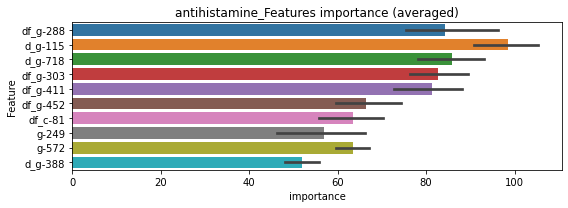

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126166	valid_1's binary_logloss: 0.0216386
[200]	training's binary_logloss: 0.00144404	valid_1's binary_logloss: 0.00861658
[300]	training's binary_logloss: 0.000394664	valid_1's binary_logloss: 0.00710976
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0002767	valid_1's binary_logloss: 0.00698346


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136678	valid_1's binary_logloss: 0.0200935
[200]	training's binary_logloss: 0.00155714	valid_1's binary_logloss: 0.00481913
[300]	training's binary_logloss: 0.0004195	valid_1's binary_logloss: 0.00290221
[400]	training's binary_logloss: 0.000216859	valid_1's binary_logloss: 0.00243209
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000179768	valid_1's binary_logloss: 0.00232675


antihistamine logloss: 0.0046553997355019755


neg labels: 3289 → selected neg labels: 3286


antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225464	valid_1's binary_logloss: 0.0281962
[200]	training's binary_logloss: 0.00261968	valid_1's binary_logloss: 0.00417783
[300]	training's binary_logloss: 0.000747498	valid_1's binary_logloss: 0.00141879
[400]	training's binary_logloss: 0.000405829	valid_1's binary_logloss: 0.000843125
[500]	training's binary_logloss: 0.000326617	valid_1's binary_logloss: 0.000712194
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000324871	valid_1's binary_logloss: 0.000709231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227983	valid_1's binary_logloss: 0.0309208
[200]	training's binary_logloss: 0.00265683	valid_1's binary_logloss: 0.00486873
[300]	training's binary_logloss: 0.000754945	valid_1's binary_logloss: 0.00170478
[400]	training's binary_logloss: 0.000405542	valid_1's binary_logloss: 0.0010069
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0013140, Threshold: 0.0020266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00182, conf_1:0.00223
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0020266
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0120266
threshold: 0.0120266, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227297	valid_1's binary_logloss: 0.0283193
[200]	training's binary_logloss: 0.0026031	valid_1's binary_logloss: 0.00395216
[300]	training's binary_logloss: 0.000741966	valid_1's binary_logloss: 0.00136806
[400]	training's binary_logloss: 0.000400938	valid_1's binary_logloss: 0.000816309
[500]	training's binary_logloss: 0.000327199	valid_1's binary_logloss: 0.000703135
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00032279	valid_1's binary_logloss: 0.000696384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022945	valid_1's binary_logloss: 0.0316073
[200]	training's binary_logloss: 0.00263213	valid_1's binary_logloss: 0.00493724
[300]	training's binary_logloss: 0.000741326	valid_1's binary_logloss: 0.00168727
[400]	training's binary_logloss: 0.000401692	valid_1's binary_logloss: 0.00101319
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1636565, Threshold: 0.0120266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01082, conf_1:0.01323
threshold: 0.0120266, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227297	valid_1's binary_logloss: 0.0283193
[200]	training's binary_logloss: 0.0026031	valid_1's binary_logloss: 0.00395216
[300]	training's binary_logloss: 0.000741966	valid_1's binary_logloss: 0.00136806
[400]	training's binary_logloss: 0.000400938	valid_1's binary_logloss: 0.000816309
[500]	training's binary_logloss: 0.000327199	valid_1's binary_logloss: 0.000703135
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00032279	valid_1's binary_logloss: 0.000696384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022945	valid_1's binary_logloss: 0.0316073
[200]	training's binary_logloss: 0.00263213	valid_1's binary_logloss: 0.00493724
[300]	training's binary_logloss: 0.000741326	valid_1's binary_logloss: 0.00168727
[400]	training's binary_logloss: 0.000401692	valid_1's binary_logloss: 0.00101319
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1636565, Threshold: 0.0120266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01082, conf_1:0.01323
threshold: 0.0120266, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


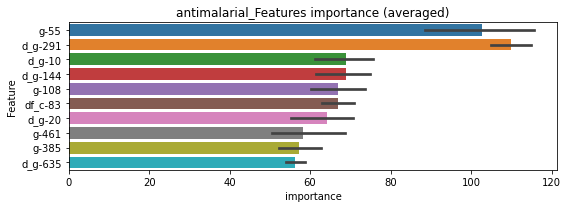

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012199	valid_1's binary_logloss: 0.0206404
[200]	training's binary_logloss: 0.00139747	valid_1's binary_logloss: 0.00888455
[300]	training's binary_logloss: 0.000388663	valid_1's binary_logloss: 0.00798576
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000364853	valid_1's binary_logloss: 0.00796905


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130694	valid_1's binary_logloss: 0.0173456
[200]	training's binary_logloss: 0.00154505	valid_1's binary_logloss: 0.00387194
[300]	training's binary_logloss: 0.000429375	valid_1's binary_logloss: 0.00250015
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000245828	valid_1's binary_logloss: 0.00235126


antimalarial logloss: 0.0051605146325562415


neg labels: 3289 → selected neg labels: 3278


antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573929	valid_1's binary_logloss: 0.118219
[200]	training's binary_logloss: 0.0123467	valid_1's binary_logloss: 0.0684815
[300]	training's binary_logloss: 0.00351889	valid_1's binary_logloss: 0.0579461
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00232893	valid_1's binary_logloss: 0.0555759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552547	valid_1's binary_logloss: 0.117549
[200]	training's binary_logloss: 0.0116975	valid_1's binary_logloss: 0.0550967
[300]	training's binary_logloss: 0.00336861	valid_1's binary_logloss: 0.0367841
[400]	training's binary_logloss: 0.00147906	valid_1's binary_logloss: 0.0299898
[500]	training's binary_logloss: 0.000897235	valid_1's binary_logloss: 0.0276791
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00070494	valid_1's binary_logloss: 0.0265311


1 / 3 AUC score:0.997
y_Threshold: 0.0147107, Threshold: 0.0200439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01804, conf_1:0.02205
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0200439
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.0300439
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_3: 0.0400439
threshold: 0.0400439, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 645.0/3781, y_label_rate: 0.1705898
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529019	valid_1's binary_logloss: 0.10694
[200]	training's binary_logloss: 0.0111893	valid_1's binary_logloss: 0.0543336
[300]	training's binary_logloss: 0.00326157	valid_1's binary_logloss: 0.0401819
[400]	training's binary_logloss: 0.00145814	valid_1's binary_logloss: 0.0354243
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00118413	valid_1's binary_logloss: 0.0345237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525377	valid_1's binary_logloss: 0.117991
[200]	training's binary_logloss: 0.0109922	valid_1's binary_logloss: 0.0673352
[300]	training's binary_logloss: 0.00316497	valid_1's binary_logloss: 0.0525281
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00177519	valid_1's binary_logloss: 0.0494656


2 / 3 AUC score:0.999
y_Threshold: 0.0486081, Threshold: 0.0400439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 627.0/3745
p_label_rate: 0.0158212 Vs.target_rate: 0.00307
Num_p_label: 63.0, conf_0:0.03604, conf_1:0.04405
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_1: 0.0400439
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.0500439
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_3: 0.0600439
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.0700439
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_5: 0.0800439
threshold: 0.0800439, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 627.0/3745, y_label_rate: 0.1674232
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049834	valid_1's binary_logloss: 0.111499
[200]	training's binary_logloss: 0.0101195	valid_1's binary_logloss: 0.0630083
[300]	training's binary_logloss: 0.00290219	valid_1's binary_logloss: 0.0533673
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00248902	valid_1's binary_logloss: 0.0522956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500902	valid_1's binary_logloss: 0.0992801
[200]	training's binary_logloss: 0.010095	valid_1's binary_logloss: 0.0453689
[300]	training's binary_logloss: 0.00294243	valid_1's binary_logloss: 0.0309919
[400]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.0271218
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00117083	valid_1's binary_logloss: 0.0267239


3 / 3 AUC score:0.999
y_Threshold: 0.0463974, Threshold: 0.0800439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 618.0/3727
p_label_rate: 0.0055249 Vs.target_rate: 0.00307
Num_p_label: 22.0, conf_0:0.07204, conf_1:0.08805
threshold: 0.0800439, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 640.0/7709, y_label_rate: 0.0830198


len(train_index) : 3854
len(valid_index) : 3855
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292138	valid_1's binary_logloss: 0.0740293
[200]	training's binary_logloss: 0.00607429	valid_1's binary_logloss: 0.0482188
[300]	training's binary_logloss: 0.00169681	valid_1's binary_logloss: 0.0427536
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00097909	valid_1's binary_logloss: 0.0418501


len(train_index) : 3855
len(valid_index) : 3854
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292755	valid_1's binary_logloss: 0.074901
[200]	training's binary_logloss: 0.00599775	valid_1's binary_logloss: 0.0469685
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00247155	valid_1's binary_logloss: 0.042541


antioxidant logloss: 0.042195529715943196


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349327	valid_1's binary_logloss: 0.0565079
[200]	training's binary_logloss: 0.00533057	valid_1's binary_logloss: 0.0172693
[300]	training's binary_logloss: 0.00147918	valid_1's binary_logloss: 0.00901112
[400]	training's binary_logloss: 0.000719903	valid_1's binary_logloss: 0.00639574
[500]	training's binary_logloss: 0.000479172	valid_1's binary_logloss: 0.00530018
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000431337	valid_1's binary_logloss: 0.00511706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336102	valid_1's binary_logloss: 0.0618162
[200]	training's binary_logloss: 0.00523707	valid_1's binary_logloss: 0.0261853
[300]	training's binary_logloss: 0.00146555	valid_1's binary_logloss: 0.0195176
[400]	training's binary_logloss: 0.000716893	valid_1's binary_logloss: 0.0180631
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0036647, Threshold: 0.0055867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00503, conf_1:0.00615
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0055867
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0155867
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.0255867
threshold: 0.0255867, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340819	valid_1's binary_logloss: 0.0545121
[200]	training's binary_logloss: 0.0050711	valid_1's binary_logloss: 0.0163024
[300]	training's binary_logloss: 0.00140867	valid_1's binary_logloss: 0.00823109
[400]	training's binary_logloss: 0.000707944	valid_1's binary_logloss: 0.00613216
[500]	training's binary_logloss: 0.000473917	valid_1's binary_logloss: 0.00500113
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000425867	valid_1's binary_logloss: 0.00486313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033505	valid_1's binary_logloss: 0.0597897
[200]	training's binary_logloss: 0.00502705	valid_1's binary_logloss: 0.0243711
[300]	training's binary_logloss: 0.00144124	valid_1's binary_logloss: 0.0179622
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00127207	valid_1's binary_logloss: 0.0175505


2 / 3 AUC score:1.000
y_Threshold: 0.0306258, Threshold: 0.0255867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0097941 Vs.target_rate: 0.00151
Num_p_label: 39.0, conf_0:0.02303, conf_1:0.02815
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.0255867
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.0355867
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.0455867
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.0555867
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.0655867
threshold: 0.0655867, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344617	valid_1's binary_logloss: 0.0502543
[200]	training's binary_logloss: 0.00520106	valid_1's binary_logloss: 0.0150611
[300]	training's binary_logloss: 0.00146699	valid_1's binary_logloss: 0.00896018
[400]	training's binary_logloss: 0.000719773	valid_1's binary_logloss: 0.00729225
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000522058	valid_1's binary_logloss: 0.00678958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328709	valid_1's binary_logloss: 0.0619748
[200]	training's binary_logloss: 0.00489277	valid_1's binary_logloss: 0.0281869
[300]	training's binary_logloss: 0.00139583	valid_1's binary_logloss: 0.023117
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00088802	valid_1's binary_logloss: 0.0218728


3 / 3 AUC score:1.000
y_Threshold: 0.0223283, Threshold: 0.0655867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.05903, conf_1:0.07215
threshold: 0.0655867, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 661.0/7777, y_label_rate: 0.0849942


len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187888	valid_1's binary_logloss: 0.0424288
[200]	training's binary_logloss: 0.00266437	valid_1's binary_logloss: 0.0214025
[300]	training's binary_logloss: 0.000735383	valid_1's binary_logloss: 0.0177111
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000639206	valid_1's binary_logloss: 0.017459


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195961	valid_1's binary_logloss: 0.0351561
[200]	training's binary_logloss: 0.00303761	valid_1's binary_logloss: 0.0169695
[300]	training's binary_logloss: 0.00080111	valid_1's binary_logloss: 0.0139467
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000694601	valid_1's binary_logloss: 0.0137755


antiprotozoal logloss: 0.01561750583130945


neg labels: 3289 → selected neg labels: 3286


antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259464	valid_1's binary_logloss: 0.0440091
[200]	training's binary_logloss: 0.0032578	valid_1's binary_logloss: 0.011711
[300]	training's binary_logloss: 0.00090666	valid_1's binary_logloss: 0.00596648
[400]	training's binary_logloss: 0.000465617	valid_1's binary_logloss: 0.00442643
[500]	training's binary_logloss: 0.000352088	valid_1's binary_logloss: 0.00396007
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000355522	valid_1's binary_logloss: 0.0039516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263198	valid_1's binary_logloss: 0.03646
[200]	training's binary_logloss: 0.00333908	valid_1's binary_logloss: 0.00670486
[300]	training's binary_logloss: 0.000923423	valid_1's binary_logloss: 0.00254229
[400]	training's binary_logloss: 0.000466501	valid_1's binary_logloss: 0.00161462
Early stopping, best iteration is:
[45

1 / 3 AUC score:1.000
y_Threshold: 0.0021121, Threshold: 0.0029500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00265, conf_1:0.00324
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0029500
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.0129500
Num_p_label: 2.0, Expected: 3.8, Adj_threshold_3: 0.0229500
threshold: 0.0229500, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256227	valid_1's binary_logloss: 0.0411717
[200]	training's binary_logloss: 0.00315488	valid_1's binary_logloss: 0.00966174
[300]	training's binary_logloss: 0.000886469	valid_1's binary_logloss: 0.00477167
[400]	training's binary_logloss: 0.000459042	valid_1's binary_logloss: 0.00355513
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000448416	valid_1's binary_logloss: 0.0035086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255732	valid_1's binary_logloss: 0.0351743
[200]	training's binary_logloss: 0.00315965	valid_1's binary_logloss: 0.00615888
[300]	training's binary_logloss: 0.000889438	valid_1's binary_logloss: 0.00234434
[400]	training's binary_logloss: 0.000457875	valid_1's binary_logloss: 0.00147155
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000372877	valid_1's binary_logloss: 0.001316

2 / 3 AUC score:1.000
y_Threshold: 0.0825220, Threshold: 0.0229500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00097
Num_p_label: 12.0, conf_0:0.02065, conf_1:0.02524
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_1: 0.0229500
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_2: 0.0329500
threshold: 0.0329500, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256227	valid_1's binary_logloss: 0.0411717
[200]	training's binary_logloss: 0.00315488	valid_1's binary_logloss: 0.00966174
[300]	training's binary_logloss: 0.000886469	valid_1's binary_logloss: 0.00477167
[400]	training's binary_logloss: 0.000459042	valid_1's binary_logloss: 0.00355513
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000448416	valid_1's binary_logloss: 0.0035086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255732	valid_1's binary_logloss: 0.0351743
[200]	training's binary_logloss: 0.00315965	valid_1's binary_logloss: 0.00615888
[300]	training's binary_logloss: 0.000889438	valid_1's binary_logloss: 0.00234434
[400]	training's binary_logloss: 0.000457875	valid_1's binary_logloss: 0.00147155
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000372877	valid_1's binary_logloss: 0.001316

3 / 3 AUC score:1.000
y_Threshold: 0.0825220, Threshold: 0.0329500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00097
Num_p_label: 5.0, conf_0:0.02965, conf_1:0.03624
threshold: 0.0329500, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137236	valid_1's binary_logloss: 0.0241026
[200]	training's binary_logloss: 0.00162986	valid_1's binary_logloss: 0.0083506
[300]	training's binary_logloss: 0.000461993	valid_1's binary_logloss: 0.00639231
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000346625	valid_1's binary_logloss: 0.006226


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143021	valid_1's binary_logloss: 0.0215837
[200]	training's binary_logloss: 0.00176659	valid_1's binary_logloss: 0.0049863
[300]	training's binary_logloss: 0.000485216	valid_1's binary_logloss: 0.00274982
[400]	training's binary_logloss: 0.00024525	valid_1's binary_logloss: 0.00225747
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00019029	valid_1's binary_logloss: 0.00218722


antiviral logloss: 0.004206866431014052


neg labels: 3289 → selected neg labels: 3281


apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453056	valid_1's binary_logloss: 0.0777834
[200]	training's binary_logloss: 0.00763199	valid_1's binary_logloss: 0.0294813
[300]	training's binary_logloss: 0.0021536	valid_1's binary_logloss: 0.018936
[400]	training's binary_logloss: 0.00101744	valid_1's binary_logloss: 0.0161708
[500]	training's binary_logloss: 0.000638791	valid_1's binary_logloss: 0.0150899
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000630178	valid_1's binary_logloss: 0.0150657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456927	valid_1's binary_logloss: 0.0759196
[200]	training's binary_logloss: 0.0079095	valid_1's binary_logloss: 0.0254725
[300]	training's binary_logloss: 0.00223866	valid_1's binary_logloss: 0.0142041
[400]	training's binary_logloss: 0.00104249	valid_1's binary_logloss: 0.0102523
[500]	training's binary_logloss: 0.000652268	v

1 / 3 AUC score:1.000
y_Threshold: 0.0048820, Threshold: 0.0426131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206
Num_p_label: 80.0, conf_0:0.03835, conf_1:0.04687
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0426131
Num_p_label: 74.0, Expected: 8.2, Adj_threshold_2: 0.0526131
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_3: 0.0626131
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_4: 0.0726131
Num_p_label: 58.0, Expected: 8.2, Adj_threshold_5: 0.0826131
Num_p_label: 52.0, Expected: 8.2, Adj_threshold_6: 0.0926131
Num_p_label: 48.0, Expected: 8.2, Adj_threshold_7: 0.1026131
Num_p_label: 42.0, Expected: 8.2, Adj_threshold_8: 0.1126131
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_9: 0.1226131
Num_p_label: 37.0, Expected: 8.2, Adj_threshold_10: 0.1326131
threshold: 0.1426131, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473079	valid_1's binary_logloss: 0.0798357
[200]	training's binary_logloss: 0.00761746	valid_1's binary_logloss: 0.0293643
[300]	training's binary_logloss: 0.00210445	valid_1's binary_logloss: 0.0178952
[400]	training's binary_logloss: 0.00100004	valid_1's binary_logloss: 0.0151394
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000725427	valid_1's binary_logloss: 0.0140454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426137	valid_1's binary_logloss: 0.0715495
[200]	training's binary_logloss: 0.00718995	valid_1's binary_logloss: 0.0236343
[300]	training's binary_logloss: 0.00206613	valid_1's binary_logloss: 0.0124065
[400]	training's binary_logloss: 0.000972641	valid_1's binary_logloss: 0.00899911
[500]	training's binary_logloss: 0.000624082	valid_1's binary_logloss: 0.0078807
Early stopping, best iteration is:
[510]	

2 / 3 AUC score:1.000
y_Threshold: 0.0665131, Threshold: 0.1426131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0238574 Vs.target_rate: 0.00206
Num_p_label: 95.0, conf_0:0.12835, conf_1:0.15687
Num_p_label: 95.0, Expected: 8.2, Adj_threshold_1: 0.1426131
Num_p_label: 91.0, Expected: 8.2, Adj_threshold_2: 0.1526131
Num_p_label: 91.0, Expected: 8.2, Adj_threshold_3: 0.1626131
Num_p_label: 91.0, Expected: 8.2, Adj_threshold_4: 0.1726131
Num_p_label: 90.0, Expected: 8.2, Adj_threshold_5: 0.1826131
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_6: 0.1926131
Num_p_label: 85.0, Expected: 8.2, Adj_threshold_7: 0.2026131
Num_p_label: 82.0, Expected: 8.2, Adj_threshold_8: 0.2126131
Num_p_label: 79.0, Expected: 8.2, Adj_threshold_9: 0.2226131
Num_p_label: 77.0, Expected: 8.2, Adj_threshold_10: 0.2326131
threshold: 0.2426131, positive_p_label: 75.0/3982, p_label_rate: 0.0188348
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429702	valid_1's binary_logloss: 0.0803572
[200]	training's binary_logloss: 0.00707837	valid_1's binary_logloss: 0.035563
[300]	training's binary_logloss: 0.00201942	valid_1's binary_logloss: 0.0271795
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00118377	valid_1's binary_logloss: 0.0253285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433313	valid_1's binary_logloss: 0.072937
[200]	training's binary_logloss: 0.00751046	valid_1's binary_logloss: 0.0253364
[300]	training's binary_logloss: 0.00215629	valid_1's binary_logloss: 0.014839
[400]	training's binary_logloss: 0.00103771	valid_1's binary_logloss: 0.0116685
[500]	training's binary_logloss: 0.000652001	valid_1's binary_logloss: 0.0100814
[600]	training's binary_logloss: 0.000500365	valid_1's binary_logloss: 0.00930573
Early stopping, best iteration is:
[600]	trai

3 / 3 AUC score:1.000
y_Threshold: 0.0421396, Threshold: 0.2426131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0203415 Vs.target_rate: 0.00206
Num_p_label: 81.0, conf_0:0.21835, conf_1:0.26687
Num_p_label: 81.0, Expected: 8.2, Adj_threshold_1: 0.2426131
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_2: 0.2526131
Num_p_label: 78.0, Expected: 8.2, Adj_threshold_3: 0.2626131
Num_p_label: 76.0, Expected: 8.2, Adj_threshold_4: 0.2726131
Num_p_label: 74.0, Expected: 8.2, Adj_threshold_5: 0.2826131
Num_p_label: 74.0, Expected: 8.2, Adj_threshold_6: 0.2926131
Num_p_label: 73.0, Expected: 8.2, Adj_threshold_7: 0.3026131
Num_p_label: 70.0, Expected: 8.2, Adj_threshold_8: 0.3126131
Num_p_label: 67.0, Expected: 8.2, Adj_threshold_9: 0.3226131
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_10: 0.3326131
threshold: 0.3426131, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 717.0/7779, y_label_rate: 0.0921712


len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276743	valid_1's binary_logloss: 0.056155
[200]	training's binary_logloss: 0.00470672	valid_1's binary_logloss: 0.0256944
[300]	training's binary_logloss: 0.00128319	valid_1's binary_logloss: 0.0178994
[400]	training's binary_logloss: 0.000588345	valid_1's binary_logloss: 0.0151035
[500]	training's binary_logloss: 0.000366343	valid_1's binary_logloss: 0.0138672
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000379294	valid_1's binary_logloss: 0.0138425


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027515	valid_1's binary_logloss: 0.0540841
[200]	training's binary_logloss: 0.00474576	valid_1's binary_logloss: 0.0228329
[300]	training's binary_logloss: 0.00129461	valid_1's binary_logloss: 0.0159122
[400]	training's binary_logloss: 0.000599601	valid_1's binary_logloss: 0.013712
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000477936	valid_1's binary_logloss: 0.0133338


apoptosis_stimulant logloss: 0.013588160574973298


neg labels: 3289 → selected neg labels: 3281


aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451896	valid_1's binary_logloss: 0.0789058
[200]	training's binary_logloss: 0.00789079	valid_1's binary_logloss: 0.03126
[300]	training's binary_logloss: 0.00216536	valid_1's binary_logloss: 0.0204057
[400]	training's binary_logloss: 0.00100706	valid_1's binary_logloss: 0.0171228
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00100121	valid_1's binary_logloss: 0.0171141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459462	valid_1's binary_logloss: 0.0790607
[200]	training's binary_logloss: 0.00824018	valid_1's binary_logloss: 0.0279136
[300]	training's binary_logloss: 0.00226483	valid_1's binary_logloss: 0.0155802
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0011193	valid_1's binary_logloss: 0.0117


1 / 3 AUC score:1.000
y_Threshold: 0.0080527, Threshold: 0.0126713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197
Num_p_label: 80.0, conf_0:0.01140, conf_1:0.01394
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0126713
Num_p_label: 22.0, Expected: 7.9, Adj_threshold_2: 0.0226713
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_3: 0.0326713
threshold: 0.0326713, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441738	valid_1's binary_logloss: 0.075585
[200]	training's binary_logloss: 0.00758179	valid_1's binary_logloss: 0.0281513
[300]	training's binary_logloss: 0.00212565	valid_1's binary_logloss: 0.017041
[400]	training's binary_logloss: 0.000998146	valid_1's binary_logloss: 0.0138802
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000945902	valid_1's binary_logloss: 0.0137771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452267	valid_1's binary_logloss: 0.0768978
[200]	training's binary_logloss: 0.00786047	valid_1's binary_logloss: 0.0262687
[300]	training's binary_logloss: 0.0021777	valid_1's binary_logloss: 0.0134338
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00109748	valid_1's binary_logloss: 0.0105769


2 / 3 AUC score:1.000
y_Threshold: 0.0470678, Threshold: 0.0326713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0085384 Vs.target_rate: 0.00197
Num_p_label: 34.0, conf_0:0.02940, conf_1:0.03594
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_1: 0.0326713
Num_p_label: 16.0, Expected: 7.9, Adj_threshold_2: 0.0426713
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_3: 0.0526713
threshold: 0.0526713, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441738	valid_1's binary_logloss: 0.075585
[200]	training's binary_logloss: 0.00758179	valid_1's binary_logloss: 0.0281513
[300]	training's binary_logloss: 0.00212565	valid_1's binary_logloss: 0.017041
[400]	training's binary_logloss: 0.000998146	valid_1's binary_logloss: 0.0138802
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000945902	valid_1's binary_logloss: 0.0137771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452267	valid_1's binary_logloss: 0.0768978
[200]	training's binary_logloss: 0.00786047	valid_1's binary_logloss: 0.0262687
[300]	training's binary_logloss: 0.0021777	valid_1's binary_logloss: 0.0134338
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00109748	valid_1's binary_logloss: 0.0105769


3 / 3 AUC score:1.000
y_Threshold: 0.0470678, Threshold: 0.0526713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00197
Num_p_label: 12.0, conf_0:0.04740, conf_1:0.05794
threshold: 0.0526713, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7787, y_label_rate: 0.0857840


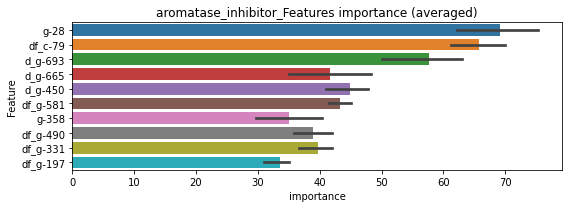

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026336	valid_1's binary_logloss: 0.0513293
[200]	training's binary_logloss: 0.00460088	valid_1's binary_logloss: 0.0226123
[300]	training's binary_logloss: 0.0012377	valid_1's binary_logloss: 0.0164783
[400]	training's binary_logloss: 0.000549882	valid_1's binary_logloss: 0.0148013
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000584703	valid_1's binary_logloss: 0.0147784


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289583	valid_1's binary_logloss: 0.0471575
[200]	training's binary_logloss: 0.00506499	valid_1's binary_logloss: 0.0176283
[300]	training's binary_logloss: 0.00136727	valid_1's binary_logloss: 0.0108823
[400]	training's binary_logloss: 0.000601669	valid_1's binary_logloss: 0.00889698
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000391127	valid_1's binary_logloss: 0.00836904


aromatase_inhibitor logloss: 0.011574122995484838


neg labels: 3289 → selected neg labels: 3288


atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151321	valid_1's binary_logloss: 0.0157439
[200]	training's binary_logloss: 0.00118574	valid_1's binary_logloss: 0.00136439
[300]	training's binary_logloss: 0.000319386	valid_1's binary_logloss: 0.00042296
[400]	training's binary_logloss: 0.000201279	valid_1's binary_logloss: 0.000276004
[500]	training's binary_logloss: 0.000175502	valid_1's binary_logloss: 0.000241617
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000171615	valid_1's binary_logloss: 0.00023606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154546	valid_1's binary_logloss: 0.0163461
[200]	training's binary_logloss: 0.00119912	valid_1's binary_logloss: 0.00141164
[300]	training's binary_logloss: 0.000320714	valid_1's binary_logloss: 0.000449788
[400]	training's binary_logloss: 0.000202892	valid_1's binary_logloss: 0.000293787
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0006010, Threshold: 0.0015282, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00138, conf_1:0.00168
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0015282
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0115282
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0215282
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0315282
threshold: 0.0315282, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155711	valid_1's binary_logloss: 0.0162915
[200]	training's binary_logloss: 0.00119966	valid_1's binary_logloss: 0.00141092
[300]	training's binary_logloss: 0.000306087	valid_1's binary_logloss: 0.00041864
[400]	training's binary_logloss: 0.000194628	valid_1's binary_logloss: 0.00028232
[500]	training's binary_logloss: 0.000172107	valid_1's binary_logloss: 0.000251355
[600]	training's binary_logloss: 0.000166762	valid_1's binary_logloss: 0.000243505
[700]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.000239765
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.000239765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158178	valid_1's binary_logloss: 0.0165543
[200]	training's binary_logloss: 0.00121913	valid_1's binary_logloss: 0.00135413
[300]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1917065, Threshold: 0.0315282, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0070316 Vs.target_rate: 0.00025
Num_p_label: 28.0, conf_0:0.02838, conf_1:0.03468
Num_p_label: 28.0, Expected: 1.0, Adj_threshold_1: 0.0315282
Num_p_label: 23.0, Expected: 1.0, Adj_threshold_2: 0.0415282
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_3: 0.0515282
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_4: 0.0615282
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_5: 0.0715282
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.0815282
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.0915282
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.1015282
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.1115282
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.1215282
threshold: 0.1315282, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155711	valid_1's binary_logloss: 0.0162915
[200]	training's binary_logloss: 0.00119966	valid_1's binary_logloss: 0.00141092
[300]	training's binary_logloss: 0.000306087	valid_1's binary_logloss: 0.00041864
[400]	training's binary_logloss: 0.000194628	valid_1's binary_logloss: 0.00028232
[500]	training's binary_logloss: 0.000172107	valid_1's binary_logloss: 0.000251355
[600]	training's binary_logloss: 0.000166762	valid_1's binary_logloss: 0.000243505
[700]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.000239765
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.000239765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158178	valid_1's binary_logloss: 0.0165543
[200]	training's binary_logloss: 0.00121913	valid_1's binary_logloss: 0.00135413
[300]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1917065, Threshold: 0.1315282, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.11838, conf_1:0.14468
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.1315282
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.1415282
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1515282
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.1615282
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.1715282
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1815282
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1915282
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.2015282
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2115282
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2215282
threshold: 0.2315282, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


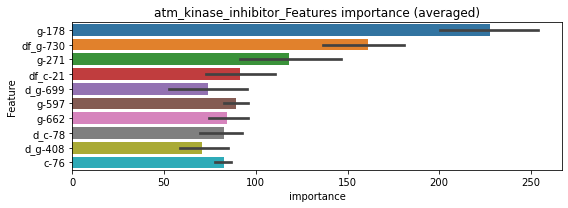

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00836998	valid_1's binary_logloss: 0.00982437
[200]	training's binary_logloss: 0.000653237	valid_1's binary_logloss: 0.00249031
[300]	training's binary_logloss: 0.000169199	valid_1's binary_logloss: 0.00213607
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000162293	valid_1's binary_logloss: 0.00212687


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838329	valid_1's binary_logloss: 0.00923626
[200]	training's binary_logloss: 0.000657586	valid_1's binary_logloss: 0.00136472
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000196692	valid_1's binary_logloss: 0.000882622


atm_kinase_inhibitor logloss: 0.0015048249823266305


neg labels: 3289 → selected neg labels: 3287


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016097	valid_1's binary_logloss: 0.0180768
[200]	training's binary_logloss: 0.00136305	valid_1's binary_logloss: 0.00190593
[300]	training's binary_logloss: 0.000374454	valid_1's binary_logloss: 0.000646028
[400]	training's binary_logloss: 0.000227317	valid_1's binary_logloss: 0.000426978
[500]	training's binary_logloss: 0.00020018	valid_1's binary_logloss: 0.000387079
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000198474	valid_1's binary_logloss: 0.000384688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161653	valid_1's binary_logloss: 0.0181566
[200]	training's binary_logloss: 0.00137374	valid_1's binary_logloss: 0.00258776
[300]	training's binary_logloss: 0.000373876	valid_1's binary_logloss: 0.0011212
[400]	training's binary_logloss: 0.000228405	valid_1's binary_logloss: 0.000842298
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0005861, Threshold: 0.0009699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00087, conf_1:0.00107
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009699
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0109699
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.0209699
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_4: 0.0309699
threshold: 0.0309699, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163587	valid_1's binary_logloss: 0.0177827
[200]	training's binary_logloss: 0.00134928	valid_1's binary_logloss: 0.00170719
[300]	training's binary_logloss: 0.000367476	valid_1's binary_logloss: 0.000564091
[400]	training's binary_logloss: 0.000227274	valid_1's binary_logloss: 0.000379588
[500]	training's binary_logloss: 0.000196527	valid_1's binary_logloss: 0.000341242
[600]	training's binary_logloss: 0.000191535	valid_1's binary_logloss: 0.000336613
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000191535	valid_1's binary_logloss: 0.000336613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162881	valid_1's binary_logloss: 0.0176197
[200]	training's binary_logloss: 0.00133916	valid_1's binary_logloss: 0.00189229
[300]	training's binary_logloss: 0.000363499	valid_1's binary_logloss: 0.000631339
[400]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.1444836, Threshold: 0.0309699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00029
Num_p_label: 7.0, conf_0:0.02787, conf_1:0.03407
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.0309699
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.0409699
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0509699
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0609699
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.0709699
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.0809699
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.0909699
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_8: 0.1009699
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.1109699
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.1209699
threshold: 0.1309699, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163587	valid_1's binary_logloss: 0.0177827
[200]	training's binary_logloss: 0.00134928	valid_1's binary_logloss: 0.00170719
[300]	training's binary_logloss: 0.000367476	valid_1's binary_logloss: 0.000564091
[400]	training's binary_logloss: 0.000227274	valid_1's binary_logloss: 0.000379588
[500]	training's binary_logloss: 0.000196527	valid_1's binary_logloss: 0.000341242
[600]	training's binary_logloss: 0.000191535	valid_1's binary_logloss: 0.000336613
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000191535	valid_1's binary_logloss: 0.000336613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162881	valid_1's binary_logloss: 0.0176197
[200]	training's binary_logloss: 0.00133916	valid_1's binary_logloss: 0.00189229
[300]	training's binary_logloss: 0.000363499	valid_1's binary_logloss: 0.000631339
[400]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.1444836, Threshold: 0.1309699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00029
Num_p_label: 3.0, conf_0:0.11787, conf_1:0.14407
threshold: 0.1309699, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859925	valid_1's binary_logloss: 0.0111273
[200]	training's binary_logloss: 0.000712708	valid_1's binary_logloss: 0.00275961
[300]	training's binary_logloss: 0.00018789	valid_1's binary_logloss: 0.00213298
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000167764	valid_1's binary_logloss: 0.00211426


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00856957	valid_1's binary_logloss: 0.0127522
[200]	training's binary_logloss: 0.000713978	valid_1's binary_logloss: 0.00483575
[300]	training's binary_logloss: 0.000191476	valid_1's binary_logloss: 0.00377401
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000120314	valid_1's binary_logloss: 0.00348423


atp-sensitive_potassium_channel_antagonist logloss: 0.002799242525692611


neg labels: 3289 → selected neg labels: 3287


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152623	valid_1's binary_logloss: 0.0182733
[200]	training's binary_logloss: 0.00117131	valid_1's binary_logloss: 0.00339632
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000401497	valid_1's binary_logloss: 0.00265861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155539	valid_1's binary_logloss: 0.0170274
[200]	training's binary_logloss: 0.00121251	valid_1's binary_logloss: 0.00285895
[300]	training's binary_logloss: 0.000306369	valid_1's binary_logloss: 0.00172282
[400]	training's binary_logloss: 0.000195594	valid_1's binary_logloss: 0.00143608
[500]	training's binary_logloss: 0.000175004	valid_1's binary_logloss: 0.00135359
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000169553	valid_1's binary_logloss: 0.00132878


1 / 3 AUC score:1.000
y_Threshold: 0.0007471, Threshold: 0.0024328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00219, conf_1:0.00268
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0024328
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_2: 0.0124328
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.0224328
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.0324328
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.0424328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.0524328
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.0624328
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.0724328
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_9: 0.0824328
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.0924328
threshold: 0.1024328, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161747	valid_1's binary_logloss: 0.0165948
[200]	training's binary_logloss: 0.00120417	valid_1's binary_logloss: 0.00128803
[300]	training's binary_logloss: 0.000282832	valid_1's binary_logloss: 0.000317456
[400]	training's binary_logloss: 0.000178952	valid_1's binary_logloss: 0.000205241
[500]	training's binary_logloss: 0.000157876	valid_1's binary_logloss: 0.000182937
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000157817	valid_1's binary_logloss: 0.00018287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158384	valid_1's binary_logloss: 0.0161726
[200]	training's binary_logloss: 0.00117727	valid_1's binary_logloss: 0.00133059
[300]	training's binary_logloss: 0.000274135	valid_1's binary_logloss: 0.000356035
[400]	training's binary_logloss: 0.000172798	valid_1's binary_logloss: 0.000236871
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.2263753, Threshold: 0.1024328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00050
Num_p_label: 18.0, conf_0:0.09219, conf_1:0.11268
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.1024328
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.1124328
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.1224328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.1324328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.1424328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.1524328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.1624328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.1724328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.1824328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_10: 0.1924328
threshold: 0.2024328, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161747	valid_1's binary_logloss: 0.0165948
[200]	training's binary_logloss: 0.00120417	valid_1's binary_logloss: 0.00128803
[300]	training's binary_logloss: 0.000282832	valid_1's binary_logloss: 0.000317456
[400]	training's binary_logloss: 0.000178952	valid_1's binary_logloss: 0.000205241
[500]	training's binary_logloss: 0.000157876	valid_1's binary_logloss: 0.000182937
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000157817	valid_1's binary_logloss: 0.00018287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158384	valid_1's binary_logloss: 0.0161726
[200]	training's binary_logloss: 0.00117727	valid_1's binary_logloss: 0.00133059
[300]	training's binary_logloss: 0.000274135	valid_1's binary_logloss: 0.000356035
[400]	training's binary_logloss: 0.000172798	valid_1's binary_logloss: 0.000236871
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.2263753, Threshold: 0.2024328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050
Num_p_label: 13.0, conf_0:0.18219, conf_1:0.22268
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.2024328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.2124328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.2224328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.2324328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.2424328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.2524328
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.2624328
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_8: 0.2724328
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.2824328
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.2924328
threshold: 0.3024328, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7794, y_label_rate: 0.0857070


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00843594	valid_1's binary_logloss: 0.0113735
[200]	training's binary_logloss: 0.000638528	valid_1's binary_logloss: 0.00356906
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000232696	valid_1's binary_logloss: 0.0031847


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00886727	valid_1's binary_logloss: 0.00899366
[200]	training's binary_logloss: 0.000723626	valid_1's binary_logloss: 0.00108656
[300]	training's binary_logloss: 0.000180149	valid_1's binary_logloss: 0.000510179
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000133877	valid_1's binary_logloss: 0.000440515


atp_synthase_inhibitor logloss: 0.0018126066364321598


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619226	valid_1's binary_logloss: 0.123917
[200]	training's binary_logloss: 0.0140075	valid_1's binary_logloss: 0.0714719
[300]	training's binary_logloss: 0.00410276	valid_1's binary_logloss: 0.0558086
[400]	training's binary_logloss: 0.00180479	valid_1's binary_logloss: 0.0514304
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00174647	valid_1's binary_logloss: 0.05112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539565	valid_1's binary_logloss: 0.139664
[200]	training's binary_logloss: 0.0120745	valid_1's binary_logloss: 0.0949085
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0060577	valid_1's binary_logloss: 0.0902463


1 / 3 AUC score:0.994
y_Threshold: 0.0206880, Threshold: 0.0596355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 637/3761
p_label_rate: 0.0200904 Vs.target_rate: 0.00407
Num_p_label: 80.0, conf_0:0.05367, conf_1:0.06560
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0596355
Num_p_label: 63.0, Expected: 16.2, Adj_threshold_2: 0.0696355
Num_p_label: 50.0, Expected: 16.2, Adj_threshold_3: 0.0796355
Num_p_label: 39.0, Expected: 16.2, Adj_threshold_4: 0.0896355
Num_p_label: 27.0, Expected: 16.2, Adj_threshold_5: 0.0996355
threshold: 0.0996355, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 637.0/3761, y_label_rate: 0.1693698
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500987	valid_1's binary_logloss: 0.125352
[200]	training's binary_logloss: 0.010789	valid_1's binary_logloss: 0.0811771
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0052555	valid_1's binary_logloss: 0.0741156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533193	valid_1's binary_logloss: 0.113676
[200]	training's binary_logloss: 0.0115794	valid_1's binary_logloss: 0.0637689
[300]	training's binary_logloss: 0.00335423	valid_1's binary_logloss: 0.0502351
[400]	training's binary_logloss: 0.0014968	valid_1's binary_logloss: 0.0470857
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00159192	valid_1's binary_logloss: 0.0469283


2 / 3 AUC score:0.994
y_Threshold: 0.0627832, Threshold: 0.0996355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 614.0/3715
p_label_rate: 0.0386740 Vs.target_rate: 0.00407
Num_p_label: 154.0, conf_0:0.08967, conf_1:0.10960
Num_p_label: 154.0, Expected: 16.2, Adj_threshold_1: 0.0996355
Num_p_label: 146.0, Expected: 16.2, Adj_threshold_2: 0.1096355
Num_p_label: 138.0, Expected: 16.2, Adj_threshold_3: 0.1196355
Num_p_label: 135.0, Expected: 16.2, Adj_threshold_4: 0.1296355
Num_p_label: 126.0, Expected: 16.2, Adj_threshold_5: 0.1396355
Num_p_label: 117.0, Expected: 16.2, Adj_threshold_6: 0.1496355
Num_p_label: 112.0, Expected: 16.2, Adj_threshold_7: 0.1596355
Num_p_label: 101.0, Expected: 16.2, Adj_threshold_8: 0.1696355
Num_p_label: 97.0, Expected: 16.2, Adj_threshold_9: 0.1796355
Num_p_label: 95.0, Expected: 16.2, Adj_threshold_10: 0.1896355
threshold: 0.1996355, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 614.0/3715, y_label_rate:

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498922	valid_1's binary_logloss: 0.1026
[200]	training's binary_logloss: 0.0100322	valid_1's binary_logloss: 0.0574053
[300]	training's binary_logloss: 0.00289653	valid_1's binary_logloss: 0.0466801
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00147412	valid_1's binary_logloss: 0.0440278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506025	valid_1's binary_logloss: 0.112344
[200]	training's binary_logloss: 0.01034	valid_1's binary_logloss: 0.0641744
[300]	training's binary_logloss: 0.00302797	valid_1's binary_logloss: 0.0510231
[400]	training's binary_logloss: 0.00135402	valid_1's binary_logloss: 0.0478054
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00142616	valid_1's binary_logloss: 0.0476688


3 / 3 AUC score:0.996
y_Threshold: 0.0435653, Threshold: 0.1996355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 597.0/3681
p_label_rate: 0.0293822 Vs.target_rate: 0.00407
Num_p_label: 117.0, conf_0:0.17967, conf_1:0.21960
Num_p_label: 117.0, Expected: 16.2, Adj_threshold_1: 0.1996355
Num_p_label: 113.0, Expected: 16.2, Adj_threshold_2: 0.2096355
Num_p_label: 110.0, Expected: 16.2, Adj_threshold_3: 0.2196355
Num_p_label: 104.0, Expected: 16.2, Adj_threshold_4: 0.2296355
Num_p_label: 101.0, Expected: 16.2, Adj_threshold_5: 0.2396355
Num_p_label: 100.0, Expected: 16.2, Adj_threshold_6: 0.2496355
Num_p_label: 99.0, Expected: 16.2, Adj_threshold_7: 0.2596355
Num_p_label: 98.0, Expected: 16.2, Adj_threshold_8: 0.2696355
Num_p_label: 96.0, Expected: 16.2, Adj_threshold_9: 0.2796355
Num_p_label: 95.0, Expected: 16.2, Adj_threshold_10: 0.2896355
threshold: 0.2996355, positive_p_label: 89.0/3982, p_label_rate: 0.0223506
positive_y_label: 686.0/7663, y_label_rate: 0

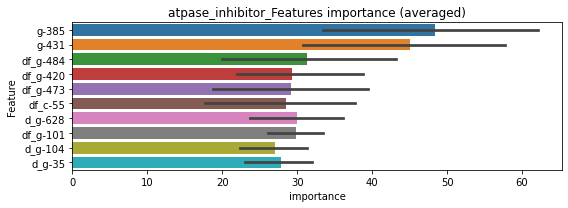

len(train_index) : 3831
len(valid_index) : 3832
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310921	valid_1's binary_logloss: 0.0687462
[200]	training's binary_logloss: 0.00667387	valid_1's binary_logloss: 0.0421853
[300]	training's binary_logloss: 0.00187886	valid_1's binary_logloss: 0.0351994
[400]	training's binary_logloss: 0.000826631	valid_1's binary_logloss: 0.0333091
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000788257	valid_1's binary_logloss: 0.0332043


len(train_index) : 3832
len(valid_index) : 3831
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031214	valid_1's binary_logloss: 0.0684743
[200]	training's binary_logloss: 0.00629665	valid_1's binary_logloss: 0.043049
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00233769	valid_1's binary_logloss: 0.0384235


atpase_inhibitor logloss: 0.03581354463751058


neg labels: 3289 → selected neg labels: 3286


atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188875	valid_1's binary_logloss: 0.0231246
[200]	training's binary_logloss: 0.00188557	valid_1's binary_logloss: 0.00383722
[300]	training's binary_logloss: 0.000539226	valid_1's binary_logloss: 0.00175097
[400]	training's binary_logloss: 0.000311272	valid_1's binary_logloss: 0.00126644
[500]	training's binary_logloss: 0.000267548	valid_1's binary_logloss: 0.00115727
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000264257	valid_1's binary_logloss: 0.00114864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189829	valid_1's binary_logloss: 0.0233086
[200]	training's binary_logloss: 0.00189715	valid_1's binary_logloss: 0.00364014
[300]	training's binary_logloss: 0.000534623	valid_1's binary_logloss: 0.00156336
[400]	training's binary_logloss: 0.000317573	valid_1's binary_logloss: 0.00112109
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0016179, Threshold: 0.0050251, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00452, conf_1:0.00553
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0050251
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.0150251
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_3: 0.0250251
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_4: 0.0350251
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_5: 0.0450251
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.0550251
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.0650251
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_8: 0.0750251
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.0850251
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_10: 0.0950251
threshold: 0.1050251, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187914	valid_1's binary_logloss: 0.0216099
[200]	training's binary_logloss: 0.00174575	valid_1's binary_logloss: 0.00309617
[300]	training's binary_logloss: 0.00047037	valid_1's binary_logloss: 0.001272
[400]	training's binary_logloss: 0.000276096	valid_1's binary_logloss: 0.000926351
[500]	training's binary_logloss: 0.000240761	valid_1's binary_logloss: 0.00085797
[600]	training's binary_logloss: 0.000232238	valid_1's binary_logloss: 0.000842552
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000231953	valid_1's binary_logloss: 0.000842423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185362	valid_1's binary_logloss: 0.0208884
[200]	training's binary_logloss: 0.00176542	valid_1's binary_logloss: 0.00248965
[300]	training's binary_logloss: 0.000474912	valid_1's binary_logloss: 0.000762488
[400]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.3231669, Threshold: 0.1050251, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0148167 Vs.target_rate: 0.00080
Num_p_label: 59.0, conf_0:0.09452, conf_1:0.11553
Num_p_label: 59.0, Expected: 3.2, Adj_threshold_1: 0.1050251
Num_p_label: 58.0, Expected: 3.2, Adj_threshold_2: 0.1150251
Num_p_label: 56.0, Expected: 3.2, Adj_threshold_3: 0.1250251
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_4: 0.1350251
Num_p_label: 51.0, Expected: 3.2, Adj_threshold_5: 0.1450251
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_6: 0.1550251
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_7: 0.1650251
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_8: 0.1750251
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_9: 0.1850251
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_10: 0.1950251
threshold: 0.2050251, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187914	valid_1's binary_logloss: 0.0216099
[200]	training's binary_logloss: 0.00174575	valid_1's binary_logloss: 0.00309617
[300]	training's binary_logloss: 0.00047037	valid_1's binary_logloss: 0.001272
[400]	training's binary_logloss: 0.000276096	valid_1's binary_logloss: 0.000926351
[500]	training's binary_logloss: 0.000240761	valid_1's binary_logloss: 0.00085797
[600]	training's binary_logloss: 0.000232238	valid_1's binary_logloss: 0.000842552
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000231953	valid_1's binary_logloss: 0.000842423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185362	valid_1's binary_logloss: 0.0208884
[200]	training's binary_logloss: 0.00176542	valid_1's binary_logloss: 0.00248965
[300]	training's binary_logloss: 0.000474912	valid_1's binary_logloss: 0.000762488
[400]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.3231669, Threshold: 0.2050251, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0115520 Vs.target_rate: 0.00080
Num_p_label: 46.0, conf_0:0.18452, conf_1:0.22553
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_1: 0.2050251
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_2: 0.2150251
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_3: 0.2250251
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_4: 0.2350251
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_5: 0.2450251
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_6: 0.2550251
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_7: 0.2650251
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_8: 0.2750251
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_9: 0.2850251
Num_p_label: 33.0, Expected: 3.2, Adj_threshold_10: 0.2950251
threshold: 0.3050251, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 689.0/7793, y_label_rate: 0.0884127


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011056	valid_1's binary_logloss: 0.0204931
[200]	training's binary_logloss: 0.00114758	valid_1's binary_logloss: 0.010439
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000738788	valid_1's binary_logloss: 0.0100646


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113035	valid_1's binary_logloss: 0.0160424
[200]	training's binary_logloss: 0.00121343	valid_1's binary_logloss: 0.00492793
[300]	training's binary_logloss: 0.000332697	valid_1's binary_logloss: 0.00373956
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000320909	valid_1's binary_logloss: 0.0037192


atr_kinase_inhibitor logloss: 0.006892314968041415


neg labels: 3289 → selected neg labels: 3273


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362914	valid_1's binary_logloss: 0.0765823
[200]	training's binary_logloss: 0.00583977	valid_1's binary_logloss: 0.0403919
[300]	training's binary_logloss: 0.00170044	valid_1's binary_logloss: 0.0322801
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00126466	valid_1's binary_logloss: 0.0306445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350843	valid_1's binary_logloss: 0.0725838
[200]	training's binary_logloss: 0.00568786	valid_1's binary_logloss: 0.0341818
[300]	training's binary_logloss: 0.00172262	valid_1's binary_logloss: 0.0248981
[400]	training's binary_logloss: 0.000857093	valid_1's binary_logloss: 0.0215221
[500]	training's binary_logloss: 0.000566211	valid_1's binary_logloss: 0.02024
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000513305	valid_1's binary_logloss: 0.0199536


1 / 3 AUC score:0.999
y_Threshold: 0.0145008, Threshold: 0.0561531, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.05054, conf_1:0.06177
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0561531
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_2: 0.0661531
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_3: 0.0761531
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_4: 0.0861531
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_5: 0.0961531
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_6: 0.1061531
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_7: 0.1161531
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_8: 0.1261531
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_9: 0.1361531
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_10: 0.1461531
threshold: 0.1561531, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 651.0/3789, y_label_rate: 0.1718131

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320181	valid_1's binary_logloss: 0.0617192
[200]	training's binary_logloss: 0.00462129	valid_1's binary_logloss: 0.0240721
[300]	training's binary_logloss: 0.00133596	valid_1's binary_logloss: 0.0162307
[400]	training's binary_logloss: 0.000666789	valid_1's binary_logloss: 0.0135742
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000513219	valid_1's binary_logloss: 0.0127609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312757	valid_1's binary_logloss: 0.0627165
[200]	training's binary_logloss: 0.00454524	valid_1's binary_logloss: 0.0322634
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00152861	valid_1's binary_logloss: 0.0284994


2 / 3 AUC score:1.000
y_Threshold: 0.0779365, Threshold: 0.1561531, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 640.0/3767
p_label_rate: 0.0226017 Vs.target_rate: 0.00403
Num_p_label: 90.0, conf_0:0.14054, conf_1:0.17177
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_1: 0.1561531
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_2: 0.1661531
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_3: 0.1761531
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_4: 0.1861531
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_5: 0.1961531
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_6: 0.2061531
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_7: 0.2161531
Num_p_label: 78.0, Expected: 16.1, Adj_threshold_8: 0.2261531
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_9: 0.2361531
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_10: 0.2461531
threshold: 0.2561531, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 640.0/3767, y_label_rate: 0.169896

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307828	valid_1's binary_logloss: 0.0609018
[200]	training's binary_logloss: 0.00439524	valid_1's binary_logloss: 0.0288416
[300]	training's binary_logloss: 0.00125852	valid_1's binary_logloss: 0.0210222
[400]	training's binary_logloss: 0.000638276	valid_1's binary_logloss: 0.0183258
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000655251	valid_1's binary_logloss: 0.0180929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306351	valid_1's binary_logloss: 0.0529267
[200]	training's binary_logloss: 0.00434063	valid_1's binary_logloss: 0.0177995
[300]	training's binary_logloss: 0.00125886	valid_1's binary_logloss: 0.0110765
[400]	training's binary_logloss: 0.000644147	valid_1's binary_logloss: 0.00925788
[500]	training's binary_logloss: 0.000450269	valid_1's binary_logloss: 0.00840338
Early stopping, best iteration is:
[494

3 / 3 AUC score:1.000
y_Threshold: 0.0534750, Threshold: 0.2561531, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 636.0/3759
p_label_rate: 0.0163235 Vs.target_rate: 0.00403
Num_p_label: 65.0, conf_0:0.23054, conf_1:0.28177
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_1: 0.2561531
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_2: 0.2661531
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_3: 0.2761531
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_4: 0.2861531
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_5: 0.2961531
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_6: 0.3061531
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_7: 0.3161531
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_8: 0.3261531
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_9: 0.3361531
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_10: 0.3461531
threshold: 0.3561531, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 689.0/7741, y_label_rate: 0.0890066

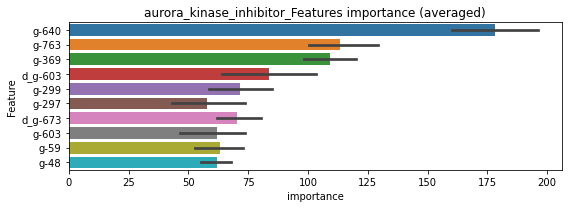

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171029	valid_1's binary_logloss: 0.0381978
[200]	training's binary_logloss: 0.00249526	valid_1's binary_logloss: 0.0187473
[300]	training's binary_logloss: 0.000737481	valid_1's binary_logloss: 0.0147582
[400]	training's binary_logloss: 0.00037407	valid_1's binary_logloss: 0.0135406
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000336947	valid_1's binary_logloss: 0.0133486


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017433	valid_1's binary_logloss: 0.0429936
[200]	training's binary_logloss: 0.00259754	valid_1's binary_logloss: 0.0240281
[300]	training's binary_logloss: 0.000748984	valid_1's binary_logloss: 0.0196535
[400]	training's binary_logloss: 0.000377944	valid_1's binary_logloss: 0.0183318
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000329146	valid_1's binary_logloss: 0.0182295


aurora_kinase_inhibitor logloss: 0.015788705564705553


neg labels: 3289 → selected neg labels: 3288


autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161568	valid_1's binary_logloss: 0.0172194
[200]	training's binary_logloss: 0.00134193	valid_1's binary_logloss: 0.00163797
[300]	training's binary_logloss: 0.000355452	valid_1's binary_logloss: 0.000517237
[400]	training's binary_logloss: 0.000214406	valid_1's binary_logloss: 0.000345356
[500]	training's binary_logloss: 0.000189637	valid_1's binary_logloss: 0.000317306
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000188283	valid_1's binary_logloss: 0.000316062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163437	valid_1's binary_logloss: 0.0178606
[200]	training's binary_logloss: 0.00135139	valid_1's binary_logloss: 0.00165108
[300]	training's binary_logloss: 0.000354679	valid_1's binary_logloss: 0.000482357
[400]	training's binary_logloss: 0.000214045	valid_1's binary_logloss: 0.000299793
[500]	training's binary_l

1 / 3 AUC score:1.000
y_Threshold: 0.0005150, Threshold: 0.0008575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00077, conf_1:0.00094
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008575
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.0108575
threshold: 0.0108575, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163968	valid_1's binary_logloss: 0.0177238
[200]	training's binary_logloss: 0.00133018	valid_1's binary_logloss: 0.00165692
[300]	training's binary_logloss: 0.000346704	valid_1's binary_logloss: 0.000506424
[400]	training's binary_logloss: 0.00021152	valid_1's binary_logloss: 0.000331417
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000187849	valid_1's binary_logloss: 0.000300159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166569	valid_1's binary_logloss: 0.0178872
[200]	training's binary_logloss: 0.00136057	valid_1's binary_logloss: 0.00155688
[300]	training's binary_logloss: 0.000353152	valid_1's binary_logloss: 0.00041235
[400]	training's binary_logloss: 0.000214472	valid_1's binary_logloss: 0.000253167
[500]	training's binary_logloss: 0.000189054	valid_1's binary_logloss: 0.000225094
Early stopping, best iterat

2 / 3 AUC score:1.000
y_Threshold: 0.1604747, Threshold: 0.0108575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025
Num_p_label: 11.0, conf_0:0.00977, conf_1:0.01194
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0108575
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0208575
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.0308575
threshold: 0.0308575, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163968	valid_1's binary_logloss: 0.0177238
[200]	training's binary_logloss: 0.00133018	valid_1's binary_logloss: 0.00165692
[300]	training's binary_logloss: 0.000346704	valid_1's binary_logloss: 0.000506424
[400]	training's binary_logloss: 0.00021152	valid_1's binary_logloss: 0.000331417
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000187849	valid_1's binary_logloss: 0.000300159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166569	valid_1's binary_logloss: 0.0178872
[200]	training's binary_logloss: 0.00136057	valid_1's binary_logloss: 0.00155688
[300]	training's binary_logloss: 0.000353152	valid_1's binary_logloss: 0.00041235
[400]	training's binary_logloss: 0.000214472	valid_1's binary_logloss: 0.000253167
[500]	training's binary_logloss: 0.000189054	valid_1's binary_logloss: 0.000225094
Early stopping, best iterat

3 / 3 AUC score:1.000
y_Threshold: 0.1604747, Threshold: 0.0308575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.02777, conf_1:0.03394
threshold: 0.0308575, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


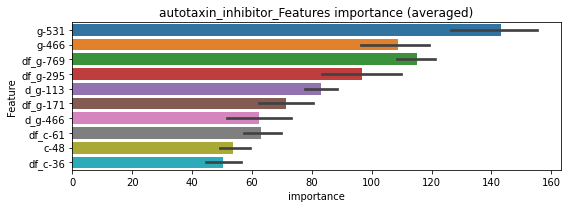

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.008658	valid_1's binary_logloss: 0.00985509
[200]	training's binary_logloss: 0.000695014	valid_1's binary_logloss: 0.00174421
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000250843	valid_1's binary_logloss: 0.00140804


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00879734	valid_1's binary_logloss: 0.0101203
[200]	training's binary_logloss: 0.000711052	valid_1's binary_logloss: 0.000917005
[300]	training's binary_logloss: 0.000180906	valid_1's binary_logloss: 0.000245032
[400]	training's binary_logloss: 0.000107886	valid_1's binary_logloss: 0.000148786
[500]	training's binary_logloss: 9.32873e-05	valid_1's binary_logloss: 0.000129196
Early stopping, best iteration is:
[554]	training's binary_logloss: 9.26065e-05	valid_1's binary_logloss: 0.000128318


autotaxin_inhibitor logloss: 0.0007682617789590027


neg labels: 3289 → selected neg labels: 3279


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499519	valid_1's binary_logloss: 0.106641
[200]	training's binary_logloss: 0.0096348	valid_1's binary_logloss: 0.0616018
[300]	training's binary_logloss: 0.00268062	valid_1's binary_logloss: 0.0538664
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00247417	valid_1's binary_logloss: 0.0536543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503771	valid_1's binary_logloss: 0.0952062
[200]	training's binary_logloss: 0.00950868	valid_1's binary_logloss: 0.0422389
[300]	training's binary_logloss: 0.00273215	valid_1's binary_logloss: 0.0288169
[400]	training's binary_logloss: 0.00122409	valid_1's binary_logloss: 0.0236711
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000907896	valid_1's binary_logloss: 0.0223549


1 / 3 AUC score:0.996
y_Threshold: 0.0123663, Threshold: 0.0189199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01703, conf_1:0.02081
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0189199
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_2: 0.0289199
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_3: 0.0389199
threshold: 0.0389199, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474956	valid_1's binary_logloss: 0.103421
[200]	training's binary_logloss: 0.00877018	valid_1's binary_logloss: 0.0571997
[300]	training's binary_logloss: 0.00253712	valid_1's binary_logloss: 0.0469908
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0020144	valid_1's binary_logloss: 0.0456653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500908	valid_1's binary_logloss: 0.0846326
[200]	training's binary_logloss: 0.00941669	valid_1's binary_logloss: 0.0344023
[300]	training's binary_logloss: 0.00262274	valid_1's binary_logloss: 0.0231602
[400]	training's binary_logloss: 0.00121218	valid_1's binary_logloss: 0.0193987
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00089486	valid_1's binary_logloss: 0.0184738


2 / 3 AUC score:0.999
y_Threshold: 0.0281720, Threshold: 0.0389199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 636.0/3764
p_label_rate: 0.0082873 Vs.target_rate: 0.00252
Num_p_label: 33.0, conf_0:0.03503, conf_1:0.04281
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_1: 0.0389199
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_2: 0.0489199
threshold: 0.0489199, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 636.0/3764, y_label_rate: 0.1689692
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479626	valid_1's binary_logloss: 0.0923897
[200]	training's binary_logloss: 0.00902295	valid_1's binary_logloss: 0.0449253
[300]	training's binary_logloss: 0.00255854	valid_1's binary_logloss: 0.0336319
[400]	training's binary_logloss: 0.0011769	valid_1's binary_logloss: 0.0303162
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00103553	valid_1's binary_logloss: 0.0298673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453948	valid_1's binary_logloss: 0.089868
[200]	training's binary_logloss: 0.00812776	valid_1's binary_logloss: 0.0422479
[300]	training's binary_logloss: 0.00232005	valid_1's binary_logloss: 0.0316102
[400]	training's binary_logloss: 0.00108205	valid_1's binary_logloss: 0.02957
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00110407	valid_1's binary_logloss: 0.0295666


3 / 3 AUC score:0.998
y_Threshold: 0.0405012, Threshold: 0.0489199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 627.0/3746
p_label_rate: 0.0077850 Vs.target_rate: 0.00252
Num_p_label: 31.0, conf_0:0.04403, conf_1:0.05381
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_1: 0.0489199
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_2: 0.0589199
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_3: 0.0689199
threshold: 0.0689199, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 642.0/7728, y_label_rate: 0.0830745


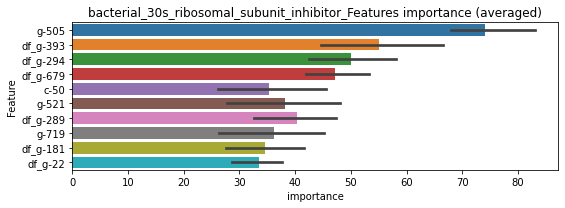

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265823	valid_1's binary_logloss: 0.0589675
[200]	training's binary_logloss: 0.0047835	valid_1's binary_logloss: 0.033458
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00212913	valid_1's binary_logloss: 0.0300907


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274777	valid_1's binary_logloss: 0.0507304
[200]	training's binary_logloss: 0.00496759	valid_1's binary_logloss: 0.0223297
[300]	training's binary_logloss: 0.00139086	valid_1's binary_logloss: 0.0160311
[400]	training's binary_logloss: 0.000618253	valid_1's binary_logloss: 0.0149506
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000550638	valid_1's binary_logloss: 0.0148073


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.022449018625687184


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588084	valid_1's binary_logloss: 0.122973
[200]	training's binary_logloss: 0.0129065	valid_1's binary_logloss: 0.0721086
[300]	training's binary_logloss: 0.00381945	valid_1's binary_logloss: 0.06056
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00341459	valid_1's binary_logloss: 0.0597149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599046	valid_1's binary_logloss: 0.133235
[200]	training's binary_logloss: 0.0135155	valid_1's binary_logloss: 0.0809009
[300]	training's binary_logloss: 0.00393758	valid_1's binary_logloss: 0.0687079
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00417737	valid_1's binary_logloss: 0.06869


1 / 3 AUC score:0.993
y_Threshold: 0.0237739, Threshold: 0.0303366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 638/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.02730, conf_1:0.03337
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0303366
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_2: 0.0403366
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_3: 0.0503366
threshold: 0.0503366, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3766, y_label_rate: 0.1694105
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563267	valid_1's binary_logloss: 0.1201
[200]	training's binary_logloss: 0.0122971	valid_1's binary_logloss: 0.0693587
[300]	training's binary_logloss: 0.00359379	valid_1's binary_logloss: 0.0572657
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00221779	valid_1's binary_logloss: 0.0553516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567659	valid_1's binary_logloss: 0.110255
[200]	training's binary_logloss: 0.0122921	valid_1's binary_logloss: 0.0557221
[300]	training's binary_logloss: 0.00361461	valid_1's binary_logloss: 0.0397255
[400]	training's binary_logloss: 0.00161168	valid_1's binary_logloss: 0.0350155
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00148603	valid_1's binary_logloss: 0.034805


2 / 3 AUC score:0.994
y_Threshold: 0.0492519, Threshold: 0.0503366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 622.0/3734
p_label_rate: 0.0085384 Vs.target_rate: 0.00336
Num_p_label: 34.0, conf_0:0.04530, conf_1:0.05537
threshold: 0.0503366, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 622.0/3734, y_label_rate: 0.1665774
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546578	valid_1's binary_logloss: 0.107224
[200]	training's binary_logloss: 0.0115527	valid_1's binary_logloss: 0.049982
[300]	training's binary_logloss: 0.00339562	valid_1's binary_logloss: 0.0342552
[400]	training's binary_logloss: 0.00149797	valid_1's binary_logloss: 0.027512
[500]	training's binary_logloss: 0.00091435	valid_1's binary_logloss: 0.0254011
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000873369	valid_1's binary_logloss: 0.0252605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523218	valid_1's binary_logloss: 0.106793
[200]	training's binary_logloss: 0.0110824	valid_1's binary_logloss: 0.0582396
[300]	training's binary_logloss: 0.00322046	valid_1's binary_logloss: 0.0477455
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00223713	valid_1's binary_logloss: 0.0453412


3 / 3 AUC score:0.999
y_Threshold: 0.0392373, Threshold: 0.0503366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 612.0/3714
p_label_rate: 0.0072828 Vs.target_rate: 0.00336
Num_p_label: 29.0, conf_0:0.04530, conf_1:0.05537
threshold: 0.0503366, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 641.0/7696, y_label_rate: 0.0832900


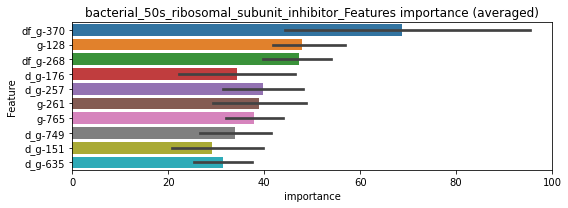

len(train_index) : 3848
len(valid_index) : 3848
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029863	valid_1's binary_logloss: 0.0732994
[200]	training's binary_logloss: 0.00610654	valid_1's binary_logloss: 0.0473839
[300]	training's binary_logloss: 0.00178337	valid_1's binary_logloss: 0.0428702
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00185354	valid_1's binary_logloss: 0.0427784


len(train_index) : 3848
len(valid_index) : 3848
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302965	valid_1's binary_logloss: 0.0726751
[200]	training's binary_logloss: 0.00621647	valid_1's binary_logloss: 0.0440401
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00191777	valid_1's binary_logloss: 0.0384326


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.040605488531044065


neg labels: 3289 → selected neg labels: 3283


bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351219	valid_1's binary_logloss: 0.0519405
[200]	training's binary_logloss: 0.00534993	valid_1's binary_logloss: 0.0127469
[300]	training's binary_logloss: 0.00147143	valid_1's binary_logloss: 0.00544313
[400]	training's binary_logloss: 0.000707672	valid_1's binary_logloss: 0.00357882
[500]	training's binary_logloss: 0.000477194	valid_1's binary_logloss: 0.00288815
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000424674	valid_1's binary_logloss: 0.00272579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033319	valid_1's binary_logloss: 0.0671789
[200]	training's binary_logloss: 0.00494708	valid_1's binary_logloss: 0.0293832
[300]	training's binary_logloss: 0.0013895	valid_1's binary_logloss: 0.0218981
[400]	training's binary_logloss: 0.000673872	valid_1's binary_logloss: 0.0194241
Early stopping, best iteration is:
[408

1 / 3 AUC score:1.000
y_Threshold: 0.0042527, Threshold: 0.0068333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00615, conf_1:0.00752
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0068333
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.0168333
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_3: 0.0268333
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_4: 0.0368333
threshold: 0.0368333, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345236	valid_1's binary_logloss: 0.0486253
[200]	training's binary_logloss: 0.0049683	valid_1's binary_logloss: 0.0102833
[300]	training's binary_logloss: 0.00140766	valid_1's binary_logloss: 0.0038344
[400]	training's binary_logloss: 0.000689971	valid_1's binary_logloss: 0.00222445
[500]	training's binary_logloss: 0.000463222	valid_1's binary_logloss: 0.0016622
[600]	training's binary_logloss: 0.000416591	valid_1's binary_logloss: 0.001542
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000414348	valid_1's binary_logloss: 0.00153879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330859	valid_1's binary_logloss: 0.0548627
[200]	training's binary_logloss: 0.00473331	valid_1's binary_logloss: 0.0178322
[300]	training's binary_logloss: 0.00133402	valid_1's binary_logloss: 0.0109596
[400]	training's binary_logloss: 0.000664

2 / 3 AUC score:1.000
y_Threshold: 0.0471750, Threshold: 0.0368333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0062783 Vs.target_rate: 0.00151
Num_p_label: 25.0, conf_0:0.03315, conf_1:0.04052
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.0368333
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0468333
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0568333
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.0668333
threshold: 0.0668333, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345236	valid_1's binary_logloss: 0.0486253
[200]	training's binary_logloss: 0.0049683	valid_1's binary_logloss: 0.0102833
[300]	training's binary_logloss: 0.00140766	valid_1's binary_logloss: 0.0038344
[400]	training's binary_logloss: 0.000689971	valid_1's binary_logloss: 0.00222445
[500]	training's binary_logloss: 0.000463222	valid_1's binary_logloss: 0.0016622
[600]	training's binary_logloss: 0.000416591	valid_1's binary_logloss: 0.001542
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000414348	valid_1's binary_logloss: 0.00153879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330859	valid_1's binary_logloss: 0.0548627
[200]	training's binary_logloss: 0.00473331	valid_1's binary_logloss: 0.0178322
[300]	training's binary_logloss: 0.00133402	valid_1's binary_logloss: 0.0109596
[400]	training's binary_logloss: 0.000664

3 / 3 AUC score:1.000
y_Threshold: 0.0471750, Threshold: 0.0668333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.06015, conf_1:0.07352
threshold: 0.0668333, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 667.0/7787, y_label_rate: 0.0856556


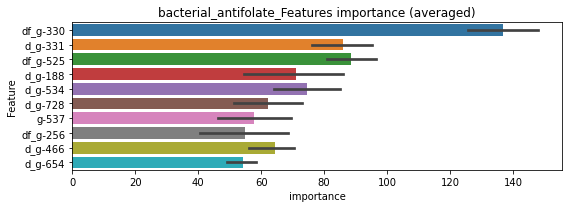

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186313	valid_1's binary_logloss: 0.0382709
[200]	training's binary_logloss: 0.0027864	valid_1's binary_logloss: 0.0187506
[300]	training's binary_logloss: 0.000746161	valid_1's binary_logloss: 0.016476
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000808653	valid_1's binary_logloss: 0.0163496


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193793	valid_1's binary_logloss: 0.0305093
[200]	training's binary_logloss: 0.00298146	valid_1's binary_logloss: 0.0113079
[300]	training's binary_logloss: 0.000797033	valid_1's binary_logloss: 0.00765773
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000414903	valid_1's binary_logloss: 0.00701881


bacterial_antifolate logloss: 0.011684795834630507


neg labels: 3289 → selected neg labels: 3259


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866559	valid_1's binary_logloss: 0.24668
[200]	training's binary_logloss: 0.0269365	valid_1's binary_logloss: 0.210444
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.01976	valid_1's binary_logloss: 0.206564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967044	valid_1's binary_logloss: 0.22819
[200]	training's binary_logloss: 0.0324112	valid_1's binary_logloss: 0.184954
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0191497	valid_1's binary_logloss: 0.178163


1 / 3 AUC score:0.932
y_Threshold: 0.0726664, Threshold: 0.0998479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 353 → Positive_corect_labels: 540/3557
p_label_rate: 0.0200904 Vs.target_rate: 0.00806
Num_p_label: 80.0, conf_0:0.08986, conf_1:0.10983
threshold: 0.0998479, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 540.0/3557, y_label_rate: 0.1518133
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704667	valid_1's binary_logloss: 0.182804
[200]	training's binary_logloss: 0.0193149	valid_1's binary_logloss: 0.138395
[300]	training's binary_logloss: 0.00624172	valid_1's binary_logloss: 0.127017
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00454502	valid_1's binary_logloss: 0.125784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731905	valid_1's binary_logloss: 0.1719
[200]	training's binary_logloss: 0.0189151	valid_1's binary_logloss: 0.125143
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0119008	valid_1's binary_logloss: 0.119752


2 / 3 AUC score:0.978
y_Threshold: 0.0733134, Threshold: 0.0998479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 128 → Positive_corect_labels: 476.0/3429
p_label_rate: 0.0118031 Vs.target_rate: 0.00806
Num_p_label: 47.0, conf_0:0.08986, conf_1:0.10983
threshold: 0.0998479, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 476.0/3429, y_label_rate: 0.1388160
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581155	valid_1's binary_logloss: 0.143503
[200]	training's binary_logloss: 0.0138093	valid_1's binary_logloss: 0.0955437
[300]	training's binary_logloss: 0.0042701	valid_1's binary_logloss: 0.0851672
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00297895	valid_1's binary_logloss: 0.0833859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058788	valid_1's binary_logloss: 0.152583
[200]	training's binary_logloss: 0.0142004	valid_1's binary_logloss: 0.105537
[300]	training's binary_logloss: 0.00446761	valid_1's binary_logloss: 0.0944541
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00424471	valid_1's binary_logloss: 0.0940053


3 / 3 AUC score:0.990
y_Threshold: 0.0617689, Threshold: 0.0998479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → Positive_corect_labels: 441.0/3359
p_label_rate: 0.0080362 Vs.target_rate: 0.00806
Num_p_label: 32.0, conf_0:0.08986, conf_1:0.10983
threshold: 0.0998479, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 473.0/7341, y_label_rate: 0.0644326


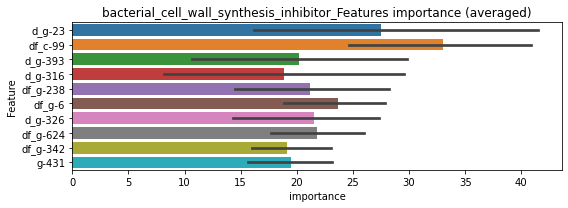

len(train_index) : 3670
len(valid_index) : 3671
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308015	valid_1's binary_logloss: 0.0927379
[200]	training's binary_logloss: 0.00740004	valid_1's binary_logloss: 0.0720509
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00512889	valid_1's binary_logloss: 0.0704221


len(train_index) : 3671
len(valid_index) : 3670
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308685	valid_1's binary_logloss: 0.0904608
[200]	training's binary_logloss: 0.00726861	valid_1's binary_logloss: 0.0692151
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00460938	valid_1's binary_logloss: 0.0677482


bacterial_cell_wall_synthesis_inhibitor logloss: 0.06908536339017797


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580969	valid_1's binary_logloss: 0.133614
[200]	training's binary_logloss: 0.0127116	valid_1's binary_logloss: 0.0898516
[300]	training's binary_logloss: 0.00376224	valid_1's binary_logloss: 0.0797891
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0025616	valid_1's binary_logloss: 0.0782844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601984	valid_1's binary_logloss: 0.131024
[200]	training's binary_logloss: 0.0145193	valid_1's binary_logloss: 0.0805971
[300]	training's binary_logloss: 0.00426595	valid_1's binary_logloss: 0.0654669
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0021733	valid_1's binary_logloss: 0.060846


1 / 3 AUC score:0.989
y_Threshold: 0.0208737, Threshold: 0.0262778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 178 → Positive_corect_labels: 631/3750
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.02365, conf_1:0.02891
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0262778
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_2: 0.0362778
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_3: 0.0462778
Num_p_label: 22.0, Expected: 14.9, Adj_threshold_4: 0.0562778
threshold: 0.0562778, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 631.0/3750, y_label_rate: 0.1682667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052846	valid_1's binary_logloss: 0.124308
[200]	training's binary_logloss: 0.0113064	valid_1's binary_logloss: 0.0724996
[300]	training's binary_logloss: 0.00338198	valid_1's binary_logloss: 0.0593286
[400]	training's binary_logloss: 0.0015215	valid_1's binary_logloss: 0.0551993
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00152959	valid_1's binary_logloss: 0.0551713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549954	valid_1's binary_logloss: 0.121113
[200]	training's binary_logloss: 0.0117046	valid_1's binary_logloss: 0.0681426
[300]	training's binary_logloss: 0.00350847	valid_1's binary_logloss: 0.0556232
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00249793	valid_1's binary_logloss: 0.0541453


2 / 3 AUC score:0.998
y_Threshold: 0.0449657, Threshold: 0.0562778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 614.0/3716
p_label_rate: 0.0092918 Vs.target_rate: 0.00374
Num_p_label: 37.0, conf_0:0.05065, conf_1:0.06191
threshold: 0.0562778, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 614.0/3716, y_label_rate: 0.1652314
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051413	valid_1's binary_logloss: 0.116901
[200]	training's binary_logloss: 0.0101705	valid_1's binary_logloss: 0.0686382
[300]	training's binary_logloss: 0.00299109	valid_1's binary_logloss: 0.05849
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00189601	valid_1's binary_logloss: 0.0574197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542101	valid_1's binary_logloss: 0.111479
[200]	training's binary_logloss: 0.0116312	valid_1's binary_logloss: 0.0606892
[300]	training's binary_logloss: 0.00340649	valid_1's binary_logloss: 0.0470754
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00254037	valid_1's binary_logloss: 0.0452664


3 / 3 AUC score:0.997
y_Threshold: 0.0485113, Threshold: 0.0562778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 597.0/3682
p_label_rate: 0.0097941 Vs.target_rate: 0.00374
Num_p_label: 39.0, conf_0:0.05065, conf_1:0.06191
threshold: 0.0562778, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 636.0/7664, y_label_rate: 0.0829854


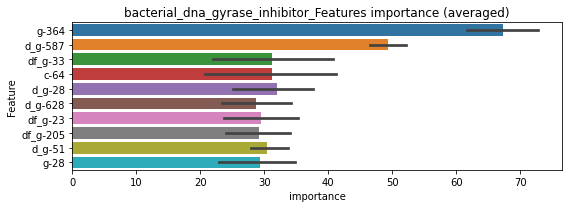

len(train_index) : 3832
len(valid_index) : 3832
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298386	valid_1's binary_logloss: 0.0785073
[200]	training's binary_logloss: 0.00627947	valid_1's binary_logloss: 0.0535934
[300]	training's binary_logloss: 0.00189996	valid_1's binary_logloss: 0.0495367
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00158514	valid_1's binary_logloss: 0.0490163


len(train_index) : 3832
len(valid_index) : 3832
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298486	valid_1's binary_logloss: 0.071654
[200]	training's binary_logloss: 0.00637724	valid_1's binary_logloss: 0.047447
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00231313	valid_1's binary_logloss: 0.0437758


bacterial_dna_gyrase_inhibitor logloss: 0.04639600684393948


neg labels: 3289 → selected neg labels: 3271


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661864	valid_1's binary_logloss: 0.157274
[200]	training's binary_logloss: 0.0173023	valid_1's binary_logloss: 0.107951
[300]	training's binary_logloss: 0.00542214	valid_1's binary_logloss: 0.0974777
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00462724	valid_1's binary_logloss: 0.0965826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687727	valid_1's binary_logloss: 0.147779
[200]	training's binary_logloss: 0.0187352	valid_1's binary_logloss: 0.0951267
[300]	training's binary_logloss: 0.00565946	valid_1's binary_logloss: 0.0770379
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00274103	valid_1's binary_logloss: 0.0735556


1 / 3 AUC score:0.989
y_Threshold: 0.0282946, Threshold: 0.0391878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 191 → Positive_corect_labels: 624/3734
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.03527, conf_1:0.04311
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0391878
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_2: 0.0491878
Num_p_label: 31.0, Expected: 19.2, Adj_threshold_3: 0.0591878
threshold: 0.0591878, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 624.0/3734, y_label_rate: 0.1671130
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614099	valid_1's binary_logloss: 0.134556
[200]	training's binary_logloss: 0.0149431	valid_1's binary_logloss: 0.0821155
[300]	training's binary_logloss: 0.00456807	valid_1's binary_logloss: 0.0673137
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00224657	valid_1's binary_logloss: 0.0634425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603406	valid_1's binary_logloss: 0.139449
[200]	training's binary_logloss: 0.0149171	valid_1's binary_logloss: 0.0889349
[300]	training's binary_logloss: 0.00457924	valid_1's binary_logloss: 0.0770886
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00416181	valid_1's binary_logloss: 0.0762836


2 / 3 AUC score:0.997
y_Threshold: 0.0604743, Threshold: 0.0591878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 596.0/3678
p_label_rate: 0.0120542 Vs.target_rate: 0.00483
Num_p_label: 48.0, conf_0:0.05327, conf_1:0.06511
threshold: 0.0591878, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 596.0/3678, y_label_rate: 0.1620446
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564453	valid_1's binary_logloss: 0.131214
[200]	training's binary_logloss: 0.0131381	valid_1's binary_logloss: 0.0858483
[300]	training's binary_logloss: 0.00411892	valid_1's binary_logloss: 0.0749991
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00204643	valid_1's binary_logloss: 0.07139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529898	valid_1's binary_logloss: 0.13713
[200]	training's binary_logloss: 0.0115364	valid_1's binary_logloss: 0.0958563
[300]	training's binary_logloss: 0.00355282	valid_1's binary_logloss: 0.0882753
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00305787	valid_1's binary_logloss: 0.0873055


3 / 3 AUC score:0.992
y_Threshold: 0.0405473, Threshold: 0.0591878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 568.0/3622
p_label_rate: 0.0097941 Vs.target_rate: 0.00483
Num_p_label: 39.0, conf_0:0.05327, conf_1:0.06511
threshold: 0.0591878, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 607.0/7604, y_label_rate: 0.0798264


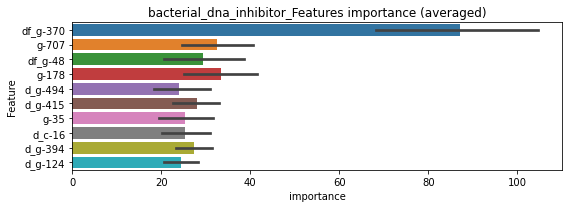

len(train_index) : 3802
len(valid_index) : 3802
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295091	valid_1's binary_logloss: 0.0818479
[200]	training's binary_logloss: 0.00671863	valid_1's binary_logloss: 0.0610366
[300]	training's binary_logloss: 0.00202949	valid_1's binary_logloss: 0.0560315
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00162076	valid_1's binary_logloss: 0.0550045


len(train_index) : 3802
len(valid_index) : 3802
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299934	valid_1's binary_logloss: 0.0868836
[200]	training's binary_logloss: 0.00699916	valid_1's binary_logloss: 0.0659743
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00340153	valid_1's binary_logloss: 0.0628023


bacterial_dna_inhibitor logloss: 0.058903381936667554


neg labels: 3289 → selected neg labels: 3285


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235695	valid_1's binary_logloss: 0.0338032
[200]	training's binary_logloss: 0.00272399	valid_1's binary_logloss: 0.00674801
[300]	training's binary_logloss: 0.000751692	valid_1's binary_logloss: 0.00306597
[400]	training's binary_logloss: 0.000392832	valid_1's binary_logloss: 0.0022099
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000325685	valid_1's binary_logloss: 0.00203169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237066	valid_1's binary_logloss: 0.0285457
[200]	training's binary_logloss: 0.00270495	valid_1's binary_logloss: 0.00399846
[300]	training's binary_logloss: 0.000753136	valid_1's binary_logloss: 0.00134632
[400]	training's binary_logloss: 0.000398078	valid_1's binary_logloss: 0.000807758
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000327215	valid_1's binary_logloss: 0.00069

1 / 3 AUC score:1.000
y_Threshold: 0.0014206, Threshold: 0.0025876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00233, conf_1:0.00285
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0025876
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.0125876
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_3: 0.0225876
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0325876
threshold: 0.0325876, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231915	valid_1's binary_logloss: 0.0325725
[200]	training's binary_logloss: 0.00258358	valid_1's binary_logloss: 0.00620321
[300]	training's binary_logloss: 0.000710204	valid_1's binary_logloss: 0.00265021
[400]	training's binary_logloss: 0.000375925	valid_1's binary_logloss: 0.00186272
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000327724	valid_1's binary_logloss: 0.00177028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233717	valid_1's binary_logloss: 0.028083
[200]	training's binary_logloss: 0.00260731	valid_1's binary_logloss: 0.0037505
[300]	training's binary_logloss: 0.000725042	valid_1's binary_logloss: 0.00118804
[400]	training's binary_logloss: 0.000389464	valid_1's binary_logloss: 0.000688795
[500]	training's binary_logloss: 0.000318287	valid_1's binary_logloss: 0.000571718
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0912833, Threshold: 0.0325876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00080
Num_p_label: 24.0, conf_0:0.02933, conf_1:0.03585
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_1: 0.0325876
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.0425876
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_3: 0.0525876
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.0625876
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_5: 0.0725876
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_6: 0.0825876
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.0925876
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.1025876
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_9: 0.1125876
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.1225876
threshold: 0.1325876, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231915	valid_1's binary_logloss: 0.0325725
[200]	training's binary_logloss: 0.00258358	valid_1's binary_logloss: 0.00620321
[300]	training's binary_logloss: 0.000710204	valid_1's binary_logloss: 0.00265021
[400]	training's binary_logloss: 0.000375925	valid_1's binary_logloss: 0.00186272
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000327724	valid_1's binary_logloss: 0.00177028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233717	valid_1's binary_logloss: 0.028083
[200]	training's binary_logloss: 0.00260731	valid_1's binary_logloss: 0.0037505
[300]	training's binary_logloss: 0.000725042	valid_1's binary_logloss: 0.00118804
[400]	training's binary_logloss: 0.000389464	valid_1's binary_logloss: 0.000688795
[500]	training's binary_logloss: 0.000318287	valid_1's binary_logloss: 0.000571718
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0912833, Threshold: 0.1325876, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0025113 Vs.target_rate: 0.00080
Num_p_label: 10.0, conf_0:0.11933, conf_1:0.14585
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.1325876
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.1425876
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.1525876
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.1625876
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.1725876
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_6: 0.1825876
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.1925876
threshold: 0.1925876, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


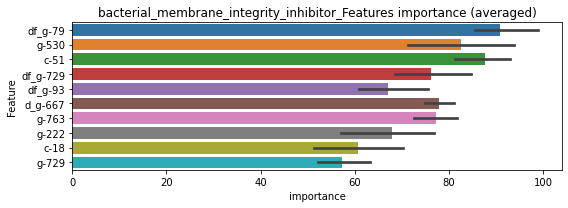

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121865	valid_1's binary_logloss: 0.0172107
[200]	training's binary_logloss: 0.00134476	valid_1's binary_logloss: 0.00469604
[300]	training's binary_logloss: 0.000367996	valid_1's binary_logloss: 0.00338284
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000246204	valid_1's binary_logloss: 0.00322353


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125149	valid_1's binary_logloss: 0.0179445
[200]	training's binary_logloss: 0.00144869	valid_1's binary_logloss: 0.00484904
[300]	training's binary_logloss: 0.000392299	valid_1's binary_logloss: 0.00262772
[400]	training's binary_logloss: 0.000203838	valid_1's binary_logloss: 0.0020709
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000174542	valid_1's binary_logloss: 0.00196036


bacterial_membrane_integrity_inhibitor logloss: 0.0025919428270615315


neg labels: 3289 → selected neg labels: 3283


bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290227	valid_1's binary_logloss: 0.0425827
[200]	training's binary_logloss: 0.0038645	valid_1's binary_logloss: 0.00999969
[300]	training's binary_logloss: 0.00110308	valid_1's binary_logloss: 0.00456558
[400]	training's binary_logloss: 0.000566195	valid_1's binary_logloss: 0.00316664
[500]	training's binary_logloss: 0.000405115	valid_1's binary_logloss: 0.00271497
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000393612	valid_1's binary_logloss: 0.00266793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287383	valid_1's binary_logloss: 0.0448196
[200]	training's binary_logloss: 0.00383899	valid_1's binary_logloss: 0.0127713
[300]	training's binary_logloss: 0.00109372	valid_1's binary_logloss: 0.00789036
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000840562	valid_1's binary_logloss: 0.00727336


1 / 3 AUC score:1.000
y_Threshold: 0.0043465, Threshold: 0.0847091, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.07624, conf_1:0.09318
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0847091
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_2: 0.0947091
Num_p_label: 68.0, Expected: 5.2, Adj_threshold_3: 0.1047091
Num_p_label: 67.0, Expected: 5.2, Adj_threshold_4: 0.1147091
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_5: 0.1247091
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_6: 0.1347091
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_7: 0.1447091
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_8: 0.1547091
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_9: 0.1647091
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_10: 0.1747091
threshold: 0.1847091, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278558	valid_1's binary_logloss: 0.0407866
[200]	training's binary_logloss: 0.00357523	valid_1's binary_logloss: 0.00875153
[300]	training's binary_logloss: 0.000998557	valid_1's binary_logloss: 0.00361216
[400]	training's binary_logloss: 0.000515474	valid_1's binary_logloss: 0.00232629
[500]	training's binary_logloss: 0.000382867	valid_1's binary_logloss: 0.00197674
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000378004	valid_1's binary_logloss: 0.00197371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272599	valid_1's binary_logloss: 0.0395938
[200]	training's binary_logloss: 0.00343659	valid_1's binary_logloss: 0.00812283
[300]	training's binary_logloss: 0.00097467	valid_1's binary_logloss: 0.00368177
[400]	training's binary_logloss: 0.000504112	valid_1's binary_logloss: 0.00248609
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.4483133, Threshold: 0.1847091, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0344048 Vs.target_rate: 0.00130
Num_p_label: 137.0, conf_0:0.16624, conf_1:0.20318
Num_p_label: 137.0, Expected: 5.2, Adj_threshold_1: 0.1847091
Num_p_label: 136.0, Expected: 5.2, Adj_threshold_2: 0.1947091
Num_p_label: 134.0, Expected: 5.2, Adj_threshold_3: 0.2047091
Num_p_label: 132.0, Expected: 5.2, Adj_threshold_4: 0.2147091
Num_p_label: 130.0, Expected: 5.2, Adj_threshold_5: 0.2247091
Num_p_label: 128.0, Expected: 5.2, Adj_threshold_6: 0.2347091
Num_p_label: 127.0, Expected: 5.2, Adj_threshold_7: 0.2447091
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_8: 0.2547091
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_9: 0.2647091
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_10: 0.2747091
threshold: 0.2847091, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 655.0/3805, y_label_rate: 0.17214

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278749	valid_1's binary_logloss: 0.0405357
[200]	training's binary_logloss: 0.00352476	valid_1's binary_logloss: 0.00795754
[300]	training's binary_logloss: 0.000986912	valid_1's binary_logloss: 0.0031488
[400]	training's binary_logloss: 0.000503359	valid_1's binary_logloss: 0.0020964
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000397286	valid_1's binary_logloss: 0.00181193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272357	valid_1's binary_logloss: 0.0422624
[200]	training's binary_logloss: 0.00349549	valid_1's binary_logloss: 0.00951391
[300]	training's binary_logloss: 0.000983104	valid_1's binary_logloss: 0.00430019
[400]	training's binary_logloss: 0.000504065	valid_1's binary_logloss: 0.00290176
[500]	training's binary_logloss: 0.000374129	valid_1's binary_logloss: 0.0025165
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.2646568, Threshold: 0.2847091, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0293822 Vs.target_rate: 0.00130
Num_p_label: 117.0, conf_0:0.25624, conf_1:0.31318
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_1: 0.2847091
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_2: 0.2947091
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_3: 0.3047091
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_4: 0.3147091
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_5: 0.3247091
Num_p_label: 115.0, Expected: 5.2, Adj_threshold_6: 0.3347091
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_7: 0.3447091
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_8: 0.3547091
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_9: 0.3647091
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_10: 0.3747091
threshold: 0.3847091, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 768.0/7787, y_label_rate: 0.09862

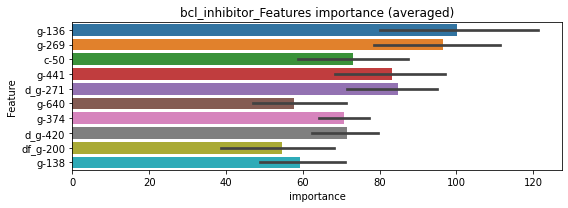

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180227	valid_1's binary_logloss: 0.0289
[200]	training's binary_logloss: 0.0024986	valid_1's binary_logloss: 0.00989876
[300]	training's binary_logloss: 0.000716132	valid_1's binary_logloss: 0.00708237
[400]	training's binary_logloss: 0.000353204	valid_1's binary_logloss: 0.00657227
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000334207	valid_1's binary_logloss: 0.00651228


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175693	valid_1's binary_logloss: 0.0364516
[200]	training's binary_logloss: 0.00240304	valid_1's binary_logloss: 0.0165578
[300]	training's binary_logloss: 0.000665936	valid_1's binary_logloss: 0.0123426
[400]	training's binary_logloss: 0.00033008	valid_1's binary_logloss: 0.0109402
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000256398	valid_1's binary_logloss: 0.0106471


bcl_inhibitor logloss: 0.008579444890606155


neg labels: 3289 → selected neg labels: 3283


bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332361	valid_1's binary_logloss: 0.051545
[200]	training's binary_logloss: 0.00519952	valid_1's binary_logloss: 0.0143564
[300]	training's binary_logloss: 0.00144947	valid_1's binary_logloss: 0.00650779
[400]	training's binary_logloss: 0.000705457	valid_1's binary_logloss: 0.00430949
[500]	training's binary_logloss: 0.000475952	valid_1's binary_logloss: 0.0035506
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000447349	valid_1's binary_logloss: 0.00346012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327934	valid_1's binary_logloss: 0.0568109
[200]	training's binary_logloss: 0.00482959	valid_1's binary_logloss: 0.0163431
[300]	training's binary_logloss: 0.00135219	valid_1's binary_logloss: 0.00861997
[400]	training's binary_logloss: 0.000666044	valid_1's binary_logloss: 0.00648383
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0038880, Threshold: 0.0075289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160
Num_p_label: 80.0, conf_0:0.00678, conf_1:0.00828
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0075289
Num_p_label: 43.0, Expected: 6.4, Adj_threshold_2: 0.0175289
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_3: 0.0275289
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_4: 0.0375289
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_5: 0.0475289
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_6: 0.0575289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_7: 0.0675289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_8: 0.0775289
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_9: 0.0875289
threshold: 0.0875289, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315228	valid_1's binary_logloss: 0.0470569
[200]	training's binary_logloss: 0.00455218	valid_1's binary_logloss: 0.0113341
[300]	training's binary_logloss: 0.00130104	valid_1's binary_logloss: 0.00493513
[400]	training's binary_logloss: 0.00065213	valid_1's binary_logloss: 0.00317878
[500]	training's binary_logloss: 0.000459727	valid_1's binary_logloss: 0.00257489
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000437946	valid_1's binary_logloss: 0.00250157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030982	valid_1's binary_logloss: 0.0510101
[200]	training's binary_logloss: 0.00446842	valid_1's binary_logloss: 0.0138093
[300]	training's binary_logloss: 0.0012773	valid_1's binary_logloss: 0.00700916
[400]	training's binary_logloss: 0.000641383	valid_1's binary_logloss: 0.00493231
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.1165006, Threshold: 0.0875289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0085384 Vs.target_rate: 0.00160
Num_p_label: 34.0, conf_0:0.07878, conf_1:0.09628
Num_p_label: 34.0, Expected: 6.4, Adj_threshold_1: 0.0875289
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_2: 0.0975289
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_3: 0.1075289
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_4: 0.1175289
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_5: 0.1275289
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_6: 0.1375289
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_7: 0.1475289
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_8: 0.1575289
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_9: 0.1675289
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_10: 0.1775289
threshold: 0.1875289, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315228	valid_1's binary_logloss: 0.0470569
[200]	training's binary_logloss: 0.00455218	valid_1's binary_logloss: 0.0113341
[300]	training's binary_logloss: 0.00130104	valid_1's binary_logloss: 0.00493513
[400]	training's binary_logloss: 0.00065213	valid_1's binary_logloss: 0.00317878
[500]	training's binary_logloss: 0.000459727	valid_1's binary_logloss: 0.00257489
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000437946	valid_1's binary_logloss: 0.00250157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030982	valid_1's binary_logloss: 0.0510101
[200]	training's binary_logloss: 0.00446842	valid_1's binary_logloss: 0.0138093
[300]	training's binary_logloss: 0.0012773	valid_1's binary_logloss: 0.00700916
[400]	training's binary_logloss: 0.000641383	valid_1's binary_logloss: 0.00493231
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1165006, Threshold: 0.1875289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0057760 Vs.target_rate: 0.00160
Num_p_label: 23.0, conf_0:0.16878, conf_1:0.20628
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_1: 0.1875289
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_2: 0.1975289
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_3: 0.2075289
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_4: 0.2175289
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_5: 0.2275289
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_6: 0.2375289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_7: 0.2475289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_8: 0.2575289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_9: 0.2675289
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_10: 0.2775289
threshold: 0.2875289, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


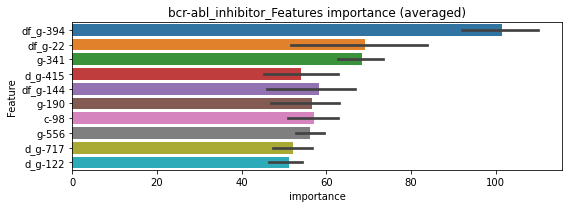

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176061	valid_1's binary_logloss: 0.0353815
[200]	training's binary_logloss: 0.00279611	valid_1's binary_logloss: 0.016489
[300]	training's binary_logloss: 0.00068949	valid_1's binary_logloss: 0.0125144
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000401854	valid_1's binary_logloss: 0.0116095


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178125	valid_1's binary_logloss: 0.0263525
[200]	training's binary_logloss: 0.00263431	valid_1's binary_logloss: 0.00678268
[300]	training's binary_logloss: 0.000709521	valid_1's binary_logloss: 0.00333961
[400]	training's binary_logloss: 0.000351428	valid_1's binary_logloss: 0.0026365
[500]	training's binary_logloss: 0.000244672	valid_1's binary_logloss: 0.00242441
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000249478	valid_1's binary_logloss: 0.00241995


bcr-abl_inhibitor logloss: 0.007015319709166638


neg labels: 3289 → selected neg labels: 3277


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562461	valid_1's binary_logloss: 0.107481
[200]	training's binary_logloss: 0.0116164	valid_1's binary_logloss: 0.0505105
[300]	training's binary_logloss: 0.00322128	valid_1's binary_logloss: 0.0345636
[400]	training's binary_logloss: 0.00142395	valid_1's binary_logloss: 0.0294827
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00144967	valid_1's binary_logloss: 0.0294522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537541	valid_1's binary_logloss: 0.112095
[200]	training's binary_logloss: 0.0113028	valid_1's binary_logloss: 0.0585497
[300]	training's binary_logloss: 0.00306952	valid_1's binary_logloss: 0.0420055
[400]	training's binary_logloss: 0.00136659	valid_1's binary_logloss: 0.0380396
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00125725	valid_1's binary_logloss: 0.0378807


1 / 3 AUC score:0.999
y_Threshold: 0.0152109, Threshold: 0.0223307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.02010, conf_1:0.02456
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0223307
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_2: 0.0323307
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_3: 0.0423307
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.0523307
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_5: 0.0623307
threshold: 0.0623307, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3796, y_label_rate: 0.1720232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523122	valid_1's binary_logloss: 0.0964938
[200]	training's binary_logloss: 0.0105532	valid_1's binary_logloss: 0.0421617
[300]	training's binary_logloss: 0.00305343	valid_1's binary_logloss: 0.0265342
[400]	training's binary_logloss: 0.00137457	valid_1's binary_logloss: 0.0204518
[500]	training's binary_logloss: 0.00084272	valid_1's binary_logloss: 0.0179079
[600]	training's binary_logloss: 0.00062739	valid_1's binary_logloss: 0.0167947
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00060886	valid_1's binary_logloss: 0.0166578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539979	valid_1's binary_logloss: 0.0962536
[200]	training's binary_logloss: 0.0104814	valid_1's binary_logloss: 0.0408959
[300]	training's binary_logloss: 0.00302154	valid_1's binary_logloss: 0.0286584
[400]	training's binary_logloss: 0.00137747	val

2 / 3 AUC score:0.999
y_Threshold: 0.0487817, Threshold: 0.0623307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3786
p_label_rate: 0.0080362 Vs.target_rate: 0.00281
Num_p_label: 32.0, conf_0:0.05610, conf_1:0.06856
threshold: 0.0623307, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 648.0/3786, y_label_rate: 0.1711569
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525565	valid_1's binary_logloss: 0.100791
[200]	training's binary_logloss: 0.0103274	valid_1's binary_logloss: 0.0463057
[300]	training's binary_logloss: 0.00292537	valid_1's binary_logloss: 0.0335974
[400]	training's binary_logloss: 0.00132507	valid_1's binary_logloss: 0.0301457
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00100775	valid_1's binary_logloss: 0.0294116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515172	valid_1's binary_logloss: 0.0981022
[200]	training's binary_logloss: 0.00980718	valid_1's binary_logloss: 0.0439875
[300]	training's binary_logloss: 0.00284148	valid_1's binary_logloss: 0.0316506
[400]	training's binary_logloss: 0.00129855	valid_1's binary_logloss: 0.0282986
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00126346	valid_1's binary_logloss: 0.0282019


3 / 3 AUC score:0.999
y_Threshold: 0.0442324, Threshold: 0.0623307, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 638.0/3766
p_label_rate: 0.0107986 Vs.target_rate: 0.00281
Num_p_label: 43.0, conf_0:0.05610, conf_1:0.06856
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_1: 0.0623307
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_2: 0.0723307
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_3: 0.0823307
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_4: 0.0923307
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_5: 0.1023307
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_6: 0.1123307
threshold: 0.1123307, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 658.0/7748, y_label_rate: 0.0849251


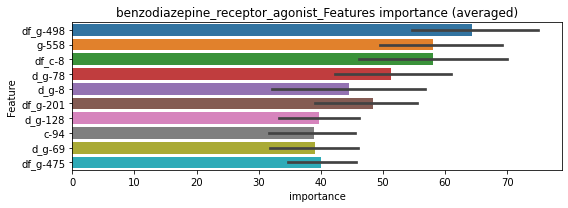

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305215	valid_1's binary_logloss: 0.0625798
[200]	training's binary_logloss: 0.00601927	valid_1's binary_logloss: 0.0334271
[300]	training's binary_logloss: 0.00168425	valid_1's binary_logloss: 0.0273771
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000797243	valid_1's binary_logloss: 0.0257641


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293555	valid_1's binary_logloss: 0.0669349
[200]	training's binary_logloss: 0.00602203	valid_1's binary_logloss: 0.0369902
[300]	training's binary_logloss: 0.00166201	valid_1's binary_logloss: 0.0292628
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00103916	valid_1's binary_logloss: 0.0275369


benzodiazepine_receptor_agonist logloss: 0.026650472599508413


neg labels: 3289 → selected neg labels: 3285


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285908	valid_1's binary_logloss: 0.0406342
[200]	training's binary_logloss: 0.00384301	valid_1's binary_logloss: 0.0106142
[300]	training's binary_logloss: 0.00107556	valid_1's binary_logloss: 0.00668454
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000586536	valid_1's binary_logloss: 0.00584313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294707	valid_1's binary_logloss: 0.0492666
[200]	training's binary_logloss: 0.00396568	valid_1's binary_logloss: 0.0124795
[300]	training's binary_logloss: 0.00109685	valid_1's binary_logloss: 0.00692317
[400]	training's binary_logloss: 0.00055261	valid_1's binary_logloss: 0.0056235
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000433457	valid_1's binary_logloss: 0.0052593


1 / 3 AUC score:1.000
y_Threshold: 0.0028626, Threshold: 0.0052366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00471, conf_1:0.00576
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0052366
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_2: 0.0152366
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.0252366
threshold: 0.0252366, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284003	valid_1's binary_logloss: 0.0383802
[200]	training's binary_logloss: 0.00370689	valid_1's binary_logloss: 0.0100764
[300]	training's binary_logloss: 0.00103964	valid_1's binary_logloss: 0.00644295
[400]	training's binary_logloss: 0.000527251	valid_1's binary_logloss: 0.0057357
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000408312	valid_1's binary_logloss: 0.00551366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285123	valid_1's binary_logloss: 0.0473044
[200]	training's binary_logloss: 0.00373366	valid_1's binary_logloss: 0.011928
[300]	training's binary_logloss: 0.0010482	valid_1's binary_logloss: 0.00666484
[400]	training's binary_logloss: 0.000540064	valid_1's binary_logloss: 0.00531479
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000514514	valid_1's binary_logloss: 0.00528308


2 / 3 AUC score:1.000
y_Threshold: 0.0139301, Threshold: 0.0252366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.02271, conf_1:0.02776
threshold: 0.0252366, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286219	valid_1's binary_logloss: 0.0408126
[200]	training's binary_logloss: 0.00373121	valid_1's binary_logloss: 0.0102453
[300]	training's binary_logloss: 0.00104886	valid_1's binary_logloss: 0.00613899
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000710554	valid_1's binary_logloss: 0.00566458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278573	valid_1's binary_logloss: 0.0429199
[200]	training's binary_logloss: 0.00368903	valid_1's binary_logloss: 0.008277
[300]	training's binary_logloss: 0.00103605	valid_1's binary_logloss: 0.0031991
[400]	training's binary_logloss: 0.000527751	valid_1's binary_logloss: 0.00198857
[500]	training's binary_logloss: 0.000392833	valid_1's binary_logloss: 0.00165908
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000380769	valid_1's binary_logloss: 0.0016295


3 / 3 AUC score:1.000
y_Threshold: 0.0189280, Threshold: 0.0252366, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0032647 Vs.target_rate: 0.00101
Num_p_label: 13.0, conf_0:0.02271, conf_1:0.02776
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.0252366
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0352366
threshold: 0.0352366, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159047	valid_1's binary_logloss: 0.02962
[200]	training's binary_logloss: 0.00211247	valid_1's binary_logloss: 0.0120565
[300]	training's binary_logloss: 0.000570523	valid_1's binary_logloss: 0.0100909
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000341735	valid_1's binary_logloss: 0.00973515


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156606	valid_1's binary_logloss: 0.0237848
[200]	training's binary_logloss: 0.00211271	valid_1's binary_logloss: 0.0068551
[300]	training's binary_logloss: 0.000585019	valid_1's binary_logloss: 0.00446463
[400]	training's binary_logloss: 0.000291547	valid_1's binary_logloss: 0.00390657
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000252642	valid_1's binary_logloss: 0.0038203


beta_amyloid_inhibitor logloss: 0.006777723236015021


neg labels: 3289 → selected neg labels: 3276


bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366095	valid_1's binary_logloss: 0.0648779
[200]	training's binary_logloss: 0.00595864	valid_1's binary_logloss: 0.0264676
[300]	training's binary_logloss: 0.00172009	valid_1's binary_logloss: 0.0184581
[400]	training's binary_logloss: 0.000838874	valid_1's binary_logloss: 0.0165568
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000861971	valid_1's binary_logloss: 0.0165483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352553	valid_1's binary_logloss: 0.0777656
[200]	training's binary_logloss: 0.00550137	valid_1's binary_logloss: 0.0427483
[300]	training's binary_logloss: 0.00157303	valid_1's binary_logloss: 0.0373498
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00121147	valid_1's binary_logloss: 0.0368149


1 / 3 AUC score:0.999
y_Threshold: 0.0064281, Threshold: 0.0110872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00286
Num_p_label: 80.0, conf_0:0.00998, conf_1:0.01220
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0110872
Num_p_label: 34.0, Expected: 11.4, Adj_threshold_2: 0.0210872
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_3: 0.0310872
threshold: 0.0310872, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 652.0/3793, y_label_rate: 0.1718956
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349126	valid_1's binary_logloss: 0.0700186
[200]	training's binary_logloss: 0.00527189	valid_1's binary_logloss: 0.0261442
[300]	training's binary_logloss: 0.00150159	valid_1's binary_logloss: 0.0156694
[400]	training's binary_logloss: 0.000740375	valid_1's binary_logloss: 0.0124535
[500]	training's binary_logloss: 0.000497335	valid_1's binary_logloss: 0.0115324
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000501815	valid_1's binary_logloss: 0.0114639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352449	valid_1's binary_logloss: 0.0616343
[200]	training's binary_logloss: 0.00539669	valid_1's binary_logloss: 0.0216403
[300]	training's binary_logloss: 0.00156509	valid_1's binary_logloss: 0.0143981
[400]	training's binary_logloss: 0.000771969	valid_1's binary_logloss: 0.0121195
Early stopping, best iteration is:
[449]	

2 / 3 AUC score:1.000
y_Threshold: 0.0245889, Threshold: 0.0310872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3791
p_label_rate: 0.0075339 Vs.target_rate: 0.00286
Num_p_label: 30.0, conf_0:0.02798, conf_1:0.03420
threshold: 0.0310872, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 651.0/3791, y_label_rate: 0.1717225
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034926	valid_1's binary_logloss: 0.067799
[200]	training's binary_logloss: 0.00532815	valid_1's binary_logloss: 0.0235003
[300]	training's binary_logloss: 0.00151317	valid_1's binary_logloss: 0.0130702
[400]	training's binary_logloss: 0.000741945	valid_1's binary_logloss: 0.00982237
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000589279	valid_1's binary_logloss: 0.0091858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354838	valid_1's binary_logloss: 0.0593898
[200]	training's binary_logloss: 0.0052532	valid_1's binary_logloss: 0.0217715
[300]	training's binary_logloss: 0.00152738	valid_1's binary_logloss: 0.0157698
[400]	training's binary_logloss: 0.000761046	valid_1's binary_logloss: 0.0145677
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000593432	valid_1's binary_logloss: 0.0138831


3 / 3 AUC score:1.000
y_Threshold: 0.0247766, Threshold: 0.0310872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3787
p_label_rate: 0.0077850 Vs.target_rate: 0.00286
Num_p_label: 31.0, conf_0:0.02798, conf_1:0.03420
threshold: 0.0310872, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 680.0/7769, y_label_rate: 0.0875274


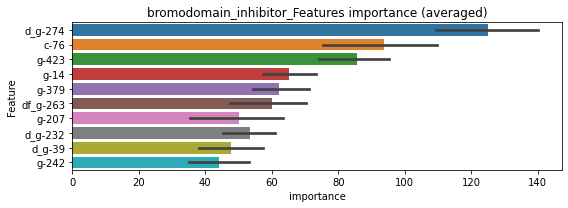

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203019	valid_1's binary_logloss: 0.0450618
[200]	training's binary_logloss: 0.00314263	valid_1's binary_logloss: 0.0243687
[300]	training's binary_logloss: 0.000867085	valid_1's binary_logloss: 0.0207113
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000637195	valid_1's binary_logloss: 0.0204358


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203382	valid_1's binary_logloss: 0.0426137
[200]	training's binary_logloss: 0.00307834	valid_1's binary_logloss: 0.0228411
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00102052	valid_1's binary_logloss: 0.020295


bromodomain_inhibitor logloss: 0.020365419636652574


neg labels: 3289 → selected neg labels: 3284


btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300426	valid_1's binary_logloss: 0.052736
[200]	training's binary_logloss: 0.00400084	valid_1's binary_logloss: 0.0148347
[300]	training's binary_logloss: 0.00109578	valid_1's binary_logloss: 0.00824034
[400]	training's binary_logloss: 0.000549866	valid_1's binary_logloss: 0.0063867
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000422923	valid_1's binary_logloss: 0.00590983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295386	valid_1's binary_logloss: 0.0481872
[200]	training's binary_logloss: 0.00394415	valid_1's binary_logloss: 0.0169401
[300]	training's binary_logloss: 0.00109443	valid_1's binary_logloss: 0.0124586
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000652026	valid_1's binary_logloss: 0.0120618


1 / 3 AUC score:0.999
y_Threshold: 0.0038831, Threshold: 0.0062518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.00563, conf_1:0.00688
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0062518
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_2: 0.0162518
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_3: 0.0262518
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_4: 0.0362518
threshold: 0.0362518, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285546	valid_1's binary_logloss: 0.0441722
[200]	training's binary_logloss: 0.00373687	valid_1's binary_logloss: 0.00998583
[300]	training's binary_logloss: 0.00105132	valid_1's binary_logloss: 0.00449682
[400]	training's binary_logloss: 0.000538251	valid_1's binary_logloss: 0.00306304
[500]	training's binary_logloss: 0.000390861	valid_1's binary_logloss: 0.00267597
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000380691	valid_1's binary_logloss: 0.00266136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283824	valid_1's binary_logloss: 0.0403971
[200]	training's binary_logloss: 0.00374428	valid_1's binary_logloss: 0.00755806
[300]	training's binary_logloss: 0.00104707	valid_1's binary_logloss: 0.00280765
[400]	training's binary_logloss: 0.000532627	valid_1's binary_logloss: 0.00166246
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1068376, Threshold: 0.0362518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0047715 Vs.target_rate: 0.00122
Num_p_label: 19.0, conf_0:0.03263, conf_1:0.03988
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_1: 0.0362518
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_2: 0.0462518
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_3: 0.0562518
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_4: 0.0662518
threshold: 0.0662518, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285546	valid_1's binary_logloss: 0.0441722
[200]	training's binary_logloss: 0.00373687	valid_1's binary_logloss: 0.00998583
[300]	training's binary_logloss: 0.00105132	valid_1's binary_logloss: 0.00449682
[400]	training's binary_logloss: 0.000538251	valid_1's binary_logloss: 0.00306304
[500]	training's binary_logloss: 0.000390861	valid_1's binary_logloss: 0.00267597
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000380691	valid_1's binary_logloss: 0.00266136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283824	valid_1's binary_logloss: 0.0403971
[200]	training's binary_logloss: 0.00374428	valid_1's binary_logloss: 0.00755806
[300]	training's binary_logloss: 0.00104707	valid_1's binary_logloss: 0.00280765
[400]	training's binary_logloss: 0.000532627	valid_1's binary_logloss: 0.00166246
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1066805, Threshold: 0.0662518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0020090 Vs.target_rate: 0.00122
Num_p_label: 8.0, conf_0:0.05963, conf_1:0.07288
threshold: 0.0662518, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7784, y_label_rate: 0.0849178


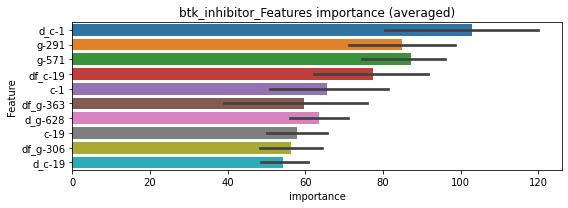

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156231	valid_1's binary_logloss: 0.0261892
[200]	training's binary_logloss: 0.00202788	valid_1's binary_logloss: 0.0101264
[300]	training's binary_logloss: 0.000553775	valid_1's binary_logloss: 0.00779147
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000358693	valid_1's binary_logloss: 0.0074829


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161139	valid_1's binary_logloss: 0.0306383
[200]	training's binary_logloss: 0.00215209	valid_1's binary_logloss: 0.0114159
[300]	training's binary_logloss: 0.000579792	valid_1's binary_logloss: 0.0074551
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000639029	valid_1's binary_logloss: 0.00741603


btk_inhibitor logloss: 0.007449465434378271


neg labels: 3289 → selected neg labels: 3287


calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184004	valid_1's binary_logloss: 0.0221342
[200]	training's binary_logloss: 0.00180103	valid_1's binary_logloss: 0.0028389
[300]	training's binary_logloss: 0.000498042	valid_1's binary_logloss: 0.000939387
[400]	training's binary_logloss: 0.000283516	valid_1's binary_logloss: 0.000591672
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000246545	valid_1's binary_logloss: 0.000531804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187309	valid_1's binary_logloss: 0.021444
[200]	training's binary_logloss: 0.00184373	valid_1's binary_logloss: 0.00238491
[300]	training's binary_logloss: 0.000504887	valid_1's binary_logloss: 0.000726702
[400]	training's binary_logloss: 0.000287252	valid_1's binary_logloss: 0.000436587
[500]	training's binary_logloss: 0.00024518	valid_1's binary_logloss: 0.000381649
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0007718, Threshold: 0.0011770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00106, conf_1:0.00129
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0011770
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0111770
threshold: 0.0111770, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187882	valid_1's binary_logloss: 0.0218555
[200]	training's binary_logloss: 0.00180104	valid_1's binary_logloss: 0.0027554
[300]	training's binary_logloss: 0.000494977	valid_1's binary_logloss: 0.000873214
[400]	training's binary_logloss: 0.000282062	valid_1's binary_logloss: 0.000542029
[500]	training's binary_logloss: 0.000242652	valid_1's binary_logloss: 0.000480607
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000241601	valid_1's binary_logloss: 0.000479579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190006	valid_1's binary_logloss: 0.0212945
[200]	training's binary_logloss: 0.00183587	valid_1's binary_logloss: 0.00228241
[300]	training's binary_logloss: 0.000500271	valid_1's binary_logloss: 0.000680562
[400]	training's binary_logloss: 0.000286279	valid_1's binary_logloss: 0.000405649
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1639058, Threshold: 0.0111770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00050
Num_p_label: 9.0, conf_0:0.01006, conf_1:0.01229
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.0111770
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0211770
threshold: 0.0211770, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187882	valid_1's binary_logloss: 0.0218555
[200]	training's binary_logloss: 0.00180104	valid_1's binary_logloss: 0.0027554
[300]	training's binary_logloss: 0.000494977	valid_1's binary_logloss: 0.000873214
[400]	training's binary_logloss: 0.000282062	valid_1's binary_logloss: 0.000542029
[500]	training's binary_logloss: 0.000242652	valid_1's binary_logloss: 0.000480607
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000241601	valid_1's binary_logloss: 0.000479579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190006	valid_1's binary_logloss: 0.0212945
[200]	training's binary_logloss: 0.00183587	valid_1's binary_logloss: 0.00228241
[300]	training's binary_logloss: 0.000500271	valid_1's binary_logloss: 0.000680562
[400]	training's binary_logloss: 0.000286279	valid_1's binary_logloss: 0.000405649
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1639058, Threshold: 0.0211770, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00050
Num_p_label: 2.0, conf_0:0.01906, conf_1:0.02329
threshold: 0.0211770, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


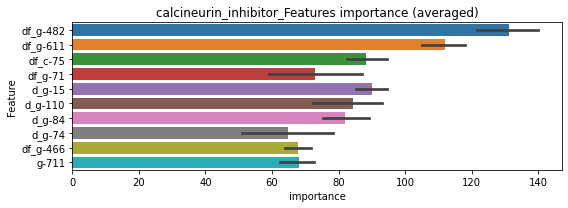

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00978744	valid_1's binary_logloss: 0.0126837
[200]	training's binary_logloss: 0.000916885	valid_1's binary_logloss: 0.00252606
[300]	training's binary_logloss: 0.000250912	valid_1's binary_logloss: 0.0016437
[400]	training's binary_logloss: 0.000142167	valid_1's binary_logloss: 0.0015533
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000136556	valid_1's binary_logloss: 0.00154652


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00994787	valid_1's binary_logloss: 0.0121865
[200]	training's binary_logloss: 0.000935008	valid_1's binary_logloss: 0.00246265
[300]	training's binary_logloss: 0.0002541	valid_1's binary_logloss: 0.00174748
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000203071	valid_1's binary_logloss: 0.00169828


calcineurin_inhibitor logloss: 0.0016224043579486618


neg labels: 3289 → selected neg labels: 3243


calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105977	valid_1's binary_logloss: 0.305055
[200]	training's binary_logloss: 0.035054	valid_1's binary_logloss: 0.280425
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0308165	valid_1's binary_logloss: 0.279533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11069	valid_1's binary_logloss: 0.286439
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0470381	valid_1's binary_logloss: 0.253802


1 / 3 AUC score:0.879
y_Threshold: 0.0982403, Threshold: 0.1277470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 471 → Positive_corect_labels: 478/3420
p_label_rate: 0.0200904 Vs.target_rate: 0.01180
Num_p_label: 80.0, conf_0:0.11497, conf_1:0.14052
threshold: 0.1277470, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 478.0/3420, y_label_rate: 0.1397661
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754625	valid_1's binary_logloss: 0.218857
[200]	training's binary_logloss: 0.0203994	valid_1's binary_logloss: 0.184069
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0163723	valid_1's binary_logloss: 0.182091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724878	valid_1's binary_logloss: 0.212863
[200]	training's binary_logloss: 0.0197944	valid_1's binary_logloss: 0.186697
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0130427	valid_1's binary_logloss: 0.184481


2 / 3 AUC score:0.942
y_Threshold: 0.0745716, Threshold: 0.1277470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 386.0/3236
p_label_rate: 0.0077850 Vs.target_rate: 0.01180
Num_p_label: 31.0, conf_0:0.11497, conf_1:0.14052
threshold: 0.1277470, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 386.0/3236, y_label_rate: 0.1192831
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568766	valid_1's binary_logloss: 0.151197
[200]	training's binary_logloss: 0.0145607	valid_1's binary_logloss: 0.114179
[300]	training's binary_logloss: 0.00471313	valid_1's binary_logloss: 0.103921
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00324278	valid_1's binary_logloss: 0.102794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554454	valid_1's binary_logloss: 0.172024
[200]	training's binary_logloss: 0.0128363	valid_1's binary_logloss: 0.135347
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00670239	valid_1's binary_logloss: 0.129253


3 / 3 AUC score:0.983
y_Threshold: 0.0511679, Threshold: 0.1277470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 341.0/3146
p_label_rate: 0.0042692 Vs.target_rate: 0.01180
Num_p_label: 17.0, conf_0:0.11497, conf_1:0.14052
threshold: 0.1277470, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 358.0/7128, y_label_rate: 0.0502245


len(train_index) : 3564
len(valid_index) : 3564
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228182	valid_1's binary_logloss: 0.0903115
[200]	training's binary_logloss: 0.00532928	valid_1's binary_logloss: 0.0793497
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00487583	valid_1's binary_logloss: 0.079258


len(train_index) : 3564
len(valid_index) : 3564
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254963	valid_1's binary_logloss: 0.0875823
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.009351	valid_1's binary_logloss: 0.0743121


calcium_channel_blocker logloss: 0.07678504817115665


neg labels: 3289 → selected neg labels: 3282


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042456	valid_1's binary_logloss: 0.0691513
[200]	training's binary_logloss: 0.00704733	valid_1's binary_logloss: 0.0251949
[300]	training's binary_logloss: 0.0019135	valid_1's binary_logloss: 0.0149699
[400]	training's binary_logloss: 0.000891963	valid_1's binary_logloss: 0.0116015
[500]	training's binary_logloss: 0.000577202	valid_1's binary_logloss: 0.0104068
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000586802	valid_1's binary_logloss: 0.0103842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407175	valid_1's binary_logloss: 0.0778412
[200]	training's binary_logloss: 0.00698029	valid_1's binary_logloss: 0.0318472
[300]	training's binary_logloss: 0.00190671	valid_1's binary_logloss: 0.0189485
[400]	training's binary_logloss: 0.000900752	valid_1's binary_logloss: 0.0144595
[500]	training's binary_logloss: 0.00058141

1 / 3 AUC score:1.000
y_Threshold: 0.0051293, Threshold: 0.0085932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00773, conf_1:0.00945
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0085932
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0185932
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0285932
threshold: 0.0285932, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419374	valid_1's binary_logloss: 0.0700584
[200]	training's binary_logloss: 0.00696052	valid_1's binary_logloss: 0.0247993
[300]	training's binary_logloss: 0.0018882	valid_1's binary_logloss: 0.0147658
[400]	training's binary_logloss: 0.000892383	valid_1's binary_logloss: 0.0112686
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000745616	valid_1's binary_logloss: 0.0108499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397645	valid_1's binary_logloss: 0.0734749
[200]	training's binary_logloss: 0.00654345	valid_1's binary_logloss: 0.0274664
[300]	training's binary_logloss: 0.0018214	valid_1's binary_logloss: 0.0166111
[400]	training's binary_logloss: 0.000863212	valid_1's binary_logloss: 0.0135327
[500]	training's binary_logloss: 0.000571867	valid_1's binary_logloss: 0.0122466
Early stopping, best iteration is:
[491]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0312241, Threshold: 0.0285932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0050226 Vs.target_rate: 0.00176
Num_p_label: 20.0, conf_0:0.02573, conf_1:0.03145
threshold: 0.0285932, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425515	valid_1's binary_logloss: 0.0687646
[200]	training's binary_logloss: 0.00703614	valid_1's binary_logloss: 0.0231162
[300]	training's binary_logloss: 0.00192734	valid_1's binary_logloss: 0.0133292
[400]	training's binary_logloss: 0.000905296	valid_1's binary_logloss: 0.0115745
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000661508	valid_1's binary_logloss: 0.0111179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386156	valid_1's binary_logloss: 0.0692074
[200]	training's binary_logloss: 0.00627879	valid_1's binary_logloss: 0.0241734
[300]	training's binary_logloss: 0.00179401	valid_1's binary_logloss: 0.0145561
[400]	training's binary_logloss: 0.000860076	valid_1's binary_logloss: 0.0114692
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000587585	valid_1's binary_logloss: 0.0104406


3 / 3 AUC score:1.000
y_Threshold: 0.0331553, Threshold: 0.0285932, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0065294 Vs.target_rate: 0.00176
Num_p_label: 26.0, conf_0:0.02573, conf_1:0.03145
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.0285932
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_2: 0.0385932
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_3: 0.0485932
threshold: 0.0485932, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7782, y_label_rate: 0.0849396


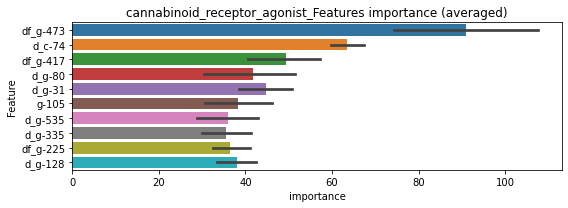

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226226	valid_1's binary_logloss: 0.0487312
[200]	training's binary_logloss: 0.00367856	valid_1's binary_logloss: 0.0215711
[300]	training's binary_logloss: 0.00099555	valid_1's binary_logloss: 0.0160576
[400]	training's binary_logloss: 0.000451912	valid_1's binary_logloss: 0.0143221
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000366753	valid_1's binary_logloss: 0.0140494


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242555	valid_1's binary_logloss: 0.0418113
[200]	training's binary_logloss: 0.003947	valid_1's binary_logloss: 0.0168003
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00124844	valid_1's binary_logloss: 0.0125862


cannabinoid_receptor_agonist logloss: 0.013317777360224135


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466017	valid_1's binary_logloss: 0.0945817
[200]	training's binary_logloss: 0.00845066	valid_1's binary_logloss: 0.0491258
[300]	training's binary_logloss: 0.00238448	valid_1's binary_logloss: 0.0391303
[400]	training's binary_logloss: 0.00109489	valid_1's binary_logloss: 0.0362519
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000798979	valid_1's binary_logloss: 0.0355623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451729	valid_1's binary_logloss: 0.0984243
[200]	training's binary_logloss: 0.0084169	valid_1's binary_logloss: 0.0580704
[300]	training's binary_logloss: 0.00240026	valid_1's binary_logloss: 0.0499571
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00217559	valid_1's binary_logloss: 0.0495291


1 / 3 AUC score:0.996
y_Threshold: 0.0099890, Threshold: 0.0148923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 646/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01340, conf_1:0.01638
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0148923
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_2: 0.0248923
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_3: 0.0348923
threshold: 0.0348923, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448106	valid_1's binary_logloss: 0.0860959
[200]	training's binary_logloss: 0.00807799	valid_1's binary_logloss: 0.0398425
[300]	training's binary_logloss: 0.00230886	valid_1's binary_logloss: 0.0282665
[400]	training's binary_logloss: 0.00107404	valid_1's binary_logloss: 0.0249849
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000952431	valid_1's binary_logloss: 0.0245367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438697	valid_1's binary_logloss: 0.0837915
[200]	training's binary_logloss: 0.00758087	valid_1's binary_logloss: 0.0377875
[300]	training's binary_logloss: 0.00219097	valid_1's binary_logloss: 0.0280615
[400]	training's binary_logloss: 0.00102789	valid_1's binary_logloss: 0.0256375
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000867976	valid_1's binary_logloss: 0.0252227


2 / 3 AUC score:0.998
y_Threshold: 0.0272314, Threshold: 0.0348923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0070316 Vs.target_rate: 0.00231
Num_p_label: 28.0, conf_0:0.03140, conf_1:0.03838
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.0348923
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_2: 0.0448923
threshold: 0.0448923, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 637.0/3766, y_label_rate: 0.1691450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042616	valid_1's binary_logloss: 0.0830427
[200]	training's binary_logloss: 0.0073733	valid_1's binary_logloss: 0.0379016
[300]	training's binary_logloss: 0.00211863	valid_1's binary_logloss: 0.0268779
[400]	training's binary_logloss: 0.000994953	valid_1's binary_logloss: 0.0236997
[500]	training's binary_logloss: 0.000640128	valid_1's binary_logloss: 0.0224892
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000617875	valid_1's binary_logloss: 0.0223247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422611	valid_1's binary_logloss: 0.0873781
[200]	training's binary_logloss: 0.00734052	valid_1's binary_logloss: 0.0410356
[300]	training's binary_logloss: 0.00210145	valid_1's binary_logloss: 0.0312607
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00148561	valid_1's binary_logloss: 0.029624


3 / 3 AUC score:1.000
y_Threshold: 0.0318499, Threshold: 0.0448923, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 630.0/3752
p_label_rate: 0.0045203 Vs.target_rate: 0.00231
Num_p_label: 18.0, conf_0:0.04040, conf_1:0.04938
threshold: 0.0448923, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 648.0/7734, y_label_rate: 0.0837859


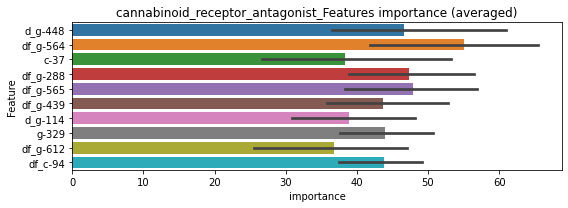

len(train_index) : 3867
len(valid_index) : 3867
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243154	valid_1's binary_logloss: 0.0507975
[200]	training's binary_logloss: 0.0043476	valid_1's binary_logloss: 0.0272134
[300]	training's binary_logloss: 0.00120375	valid_1's binary_logloss: 0.0236248
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00109072	valid_1's binary_logloss: 0.0235287


len(train_index) : 3867
len(valid_index) : 3867
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241959	valid_1's binary_logloss: 0.0532513
[200]	training's binary_logloss: 0.00408564	valid_1's binary_logloss: 0.0281551
[300]	training's binary_logloss: 0.00115202	valid_1's binary_logloss: 0.0231994
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00107317	valid_1's binary_logloss: 0.0230216


cannabinoid_receptor_antagonist logloss: 0.023275185761210487


neg labels: 3289 → selected neg labels: 3283


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383781	valid_1's binary_logloss: 0.0659787
[200]	training's binary_logloss: 0.00623015	valid_1's binary_logloss: 0.0230792
[300]	training's binary_logloss: 0.00170084	valid_1's binary_logloss: 0.0137506
[400]	training's binary_logloss: 0.000808529	valid_1's binary_logloss: 0.0112919
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000787348	valid_1's binary_logloss: 0.0112677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368322	valid_1's binary_logloss: 0.0640503
[200]	training's binary_logloss: 0.00588571	valid_1's binary_logloss: 0.0229629
[300]	training's binary_logloss: 0.00163644	valid_1's binary_logloss: 0.0134486
[400]	training's binary_logloss: 0.000794682	valid_1's binary_logloss: 0.0113472
[500]	training's binary_logloss: 0.000517497	valid_1's binary_logloss: 0.010107
Early stopping, best iteration is:
[498]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0047221, Threshold: 0.0059336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00534, conf_1:0.00653
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0059336
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0159336
Num_p_label: 3.0, Expected: 6.0, Adj_threshold_3: 0.0259336
threshold: 0.0259336, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377796	valid_1's binary_logloss: 0.0626186
[200]	training's binary_logloss: 0.00568304	valid_1's binary_logloss: 0.0197703
[300]	training's binary_logloss: 0.001587	valid_1's binary_logloss: 0.0114249
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000925159	valid_1's binary_logloss: 0.00972739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375536	valid_1's binary_logloss: 0.0635912
[200]	training's binary_logloss: 0.00575808	valid_1's binary_logloss: 0.0221039
[300]	training's binary_logloss: 0.00162333	valid_1's binary_logloss: 0.0132808
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0010469	valid_1's binary_logloss: 0.0114656


2 / 3 AUC score:1.000
y_Threshold: 0.0502820, Threshold: 0.0259336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0052737 Vs.target_rate: 0.00151
Num_p_label: 21.0, conf_0:0.02334, conf_1:0.02853
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.0259336
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.0359336
threshold: 0.0359336, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377796	valid_1's binary_logloss: 0.0626186
[200]	training's binary_logloss: 0.00568304	valid_1's binary_logloss: 0.0197703
[300]	training's binary_logloss: 0.001587	valid_1's binary_logloss: 0.0114249
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000925159	valid_1's binary_logloss: 0.00972739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375536	valid_1's binary_logloss: 0.0635912
[200]	training's binary_logloss: 0.00575808	valid_1's binary_logloss: 0.0221039
[300]	training's binary_logloss: 0.00162333	valid_1's binary_logloss: 0.0132808
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0010469	valid_1's binary_logloss: 0.0114656


3 / 3 AUC score:1.000
y_Threshold: 0.0502820, Threshold: 0.0359336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.03234, conf_1:0.03953
threshold: 0.0359336, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


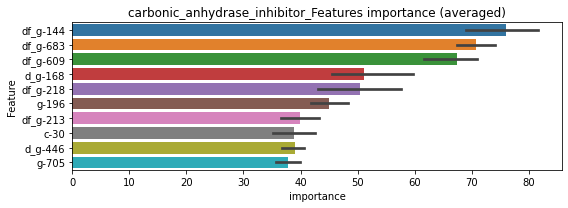

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213296	valid_1's binary_logloss: 0.0449327
[200]	training's binary_logloss: 0.00349989	valid_1's binary_logloss: 0.0205072
[300]	training's binary_logloss: 0.000876978	valid_1's binary_logloss: 0.0154125
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000455132	valid_1's binary_logloss: 0.0147606


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219818	valid_1's binary_logloss: 0.0339476
[200]	training's binary_logloss: 0.00347199	valid_1's binary_logloss: 0.0105876
[300]	training's binary_logloss: 0.000955937	valid_1's binary_logloss: 0.00663657
[400]	training's binary_logloss: 0.000446716	valid_1's binary_logloss: 0.00593755
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000362721	valid_1's binary_logloss: 0.00582229


carbonic_anhydrase_inhibitor logloss: 0.010292014843680796


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366635	valid_1's binary_logloss: 0.0530584
[200]	training's binary_logloss: 0.00576738	valid_1's binary_logloss: 0.0129349
[300]	training's binary_logloss: 0.00160068	valid_1's binary_logloss: 0.00503196
[400]	training's binary_logloss: 0.000769069	valid_1's binary_logloss: 0.00313299
[500]	training's binary_logloss: 0.000505984	valid_1's binary_logloss: 0.00243451
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000437615	valid_1's binary_logloss: 0.00223103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343441	valid_1's binary_logloss: 0.0635599
[200]	training's binary_logloss: 0.0052055	valid_1's binary_logloss: 0.0270026
[300]	training's binary_logloss: 0.00144173	valid_1's binary_logloss: 0.0190852
[400]	training's binary_logloss: 0.000703632	valid_1's binary_logloss: 0.0165768
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0034005, Threshold: 0.0051346, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00462, conf_1:0.00565
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0051346
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0151346
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0251346
threshold: 0.0251346, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353131	valid_1's binary_logloss: 0.0527319
[200]	training's binary_logloss: 0.0052873	valid_1's binary_logloss: 0.0126003
[300]	training's binary_logloss: 0.00149542	valid_1's binary_logloss: 0.00516493
[400]	training's binary_logloss: 0.000725446	valid_1's binary_logloss: 0.00316904
[500]	training's binary_logloss: 0.00048854	valid_1's binary_logloss: 0.00251532
[600]	training's binary_logloss: 0.000431884	valid_1's binary_logloss: 0.00237193
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00042669	valid_1's binary_logloss: 0.00234676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339013	valid_1's binary_logloss: 0.0622746
[200]	training's binary_logloss: 0.00494838	valid_1's binary_logloss: 0.0249901
[300]	training's binary_logloss: 0.00140986	valid_1's binary_logloss: 0.0189234
Early stopping, best iteration is:
[346

2 / 3 AUC score:1.000
y_Threshold: 0.0261351, Threshold: 0.0251346, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0087896 Vs.target_rate: 0.00151
Num_p_label: 35.0, conf_0:0.02262, conf_1:0.02765
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.0251346
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0351346
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0451346
threshold: 0.0451346, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349831	valid_1's binary_logloss: 0.0534993
[200]	training's binary_logloss: 0.00524726	valid_1's binary_logloss: 0.0148599
[300]	training's binary_logloss: 0.00147905	valid_1's binary_logloss: 0.00773844
[400]	training's binary_logloss: 0.000725568	valid_1's binary_logloss: 0.00571572
[500]	training's binary_logloss: 0.000491553	valid_1's binary_logloss: 0.00502945
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000465482	valid_1's binary_logloss: 0.00487668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339346	valid_1's binary_logloss: 0.0607476
[200]	training's binary_logloss: 0.00495688	valid_1's binary_logloss: 0.017822
[300]	training's binary_logloss: 0.00144141	valid_1's binary_logloss: 0.00910988
[400]	training's binary_logloss: 0.000713885	valid_1's binary_logloss: 0.00658505
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0388181, Threshold: 0.0451346, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00151
Num_p_label: 10.0, conf_0:0.04062, conf_1:0.04965
threshold: 0.0451346, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


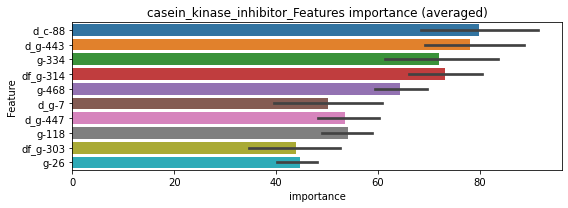

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190927	valid_1's binary_logloss: 0.040468
[200]	training's binary_logloss: 0.00275965	valid_1's binary_logloss: 0.0204825
[300]	training's binary_logloss: 0.00076992	valid_1's binary_logloss: 0.0170047
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000799864	valid_1's binary_logloss: 0.0169451


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189998	valid_1's binary_logloss: 0.0392832
[200]	training's binary_logloss: 0.00291081	valid_1's binary_logloss: 0.0182104
[300]	training's binary_logloss: 0.000803686	valid_1's binary_logloss: 0.014934
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000892606	valid_1's binary_logloss: 0.0149045


casein_kinase_inhibitor logloss: 0.01592491004939149


neg labels: 3289 → selected neg labels: 3287


caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229003	valid_1's binary_logloss: 0.0293956
[200]	training's binary_logloss: 0.00268535	valid_1's binary_logloss: 0.00483019
[300]	training's binary_logloss: 0.000763686	valid_1's binary_logloss: 0.00190923
[400]	training's binary_logloss: 0.000409266	valid_1's binary_logloss: 0.00126663
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000334502	valid_1's binary_logloss: 0.00112587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233137	valid_1's binary_logloss: 0.0325853
[200]	training's binary_logloss: 0.00269606	valid_1's binary_logloss: 0.00611515
[300]	training's binary_logloss: 0.000763807	valid_1's binary_logloss: 0.00234458
[400]	training's binary_logloss: 0.000403518	valid_1's binary_logloss: 0.00145741
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000325111	valid_1's binary_logloss: 0.00125

1 / 3 AUC score:1.000
y_Threshold: 0.0015630, Threshold: 0.0021010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00189, conf_1:0.00231
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021010
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0121010
threshold: 0.0121010, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225302	valid_1's binary_logloss: 0.0295378
[200]	training's binary_logloss: 0.00257436	valid_1's binary_logloss: 0.00515493
[300]	training's binary_logloss: 0.000732729	valid_1's binary_logloss: 0.00205981
[400]	training's binary_logloss: 0.000397799	valid_1's binary_logloss: 0.00135606
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000327494	valid_1's binary_logloss: 0.00121157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235792	valid_1's binary_logloss: 0.033268
[200]	training's binary_logloss: 0.00269029	valid_1's binary_logloss: 0.00666742
[300]	training's binary_logloss: 0.000762298	valid_1's binary_logloss: 0.0028081
[400]	training's binary_logloss: 0.000401461	valid_1's binary_logloss: 0.00174185
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000329514	valid_1's binary_logloss: 0.0014881

2 / 3 AUC score:1.000
y_Threshold: 0.0948902, Threshold: 0.0121010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00076
Num_p_label: 14.0, conf_0:0.01089, conf_1:0.01331
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.0121010
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0221010
threshold: 0.0221010, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225302	valid_1's binary_logloss: 0.0295378
[200]	training's binary_logloss: 0.00257436	valid_1's binary_logloss: 0.00515493
[300]	training's binary_logloss: 0.000732729	valid_1's binary_logloss: 0.00205981
[400]	training's binary_logloss: 0.000397799	valid_1's binary_logloss: 0.00135606
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000327494	valid_1's binary_logloss: 0.00121157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235792	valid_1's binary_logloss: 0.033268
[200]	training's binary_logloss: 0.00269029	valid_1's binary_logloss: 0.00666742
[300]	training's binary_logloss: 0.000762298	valid_1's binary_logloss: 0.0028081
[400]	training's binary_logloss: 0.000401461	valid_1's binary_logloss: 0.00174185
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000329514	valid_1's binary_logloss: 0.0014881

3 / 3 AUC score:1.000
y_Threshold: 0.0948902, Threshold: 0.0221010, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.01989, conf_1:0.02431
threshold: 0.0221010, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


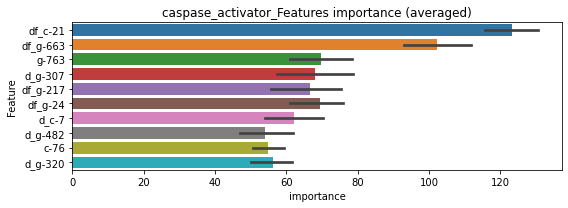

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123349	valid_1's binary_logloss: 0.0185655
[200]	training's binary_logloss: 0.00138758	valid_1's binary_logloss: 0.00496847
[300]	training's binary_logloss: 0.000383039	valid_1's binary_logloss: 0.00363149
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000227218	valid_1's binary_logloss: 0.00344152


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127466	valid_1's binary_logloss: 0.0181199
[200]	training's binary_logloss: 0.00143718	valid_1's binary_logloss: 0.00490405
[300]	training's binary_logloss: 0.000398613	valid_1's binary_logloss: 0.00325633
[400]	training's binary_logloss: 0.000206459	valid_1's binary_logloss: 0.00300592
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000184175	valid_1's binary_logloss: 0.00295908


caspase_activator logloss: 0.0032003000696814465


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228237	valid_1's binary_logloss: 0.0307259
[200]	training's binary_logloss: 0.00268376	valid_1's binary_logloss: 0.00621579
[300]	training's binary_logloss: 0.00077596	valid_1's binary_logloss: 0.00260454
[400]	training's binary_logloss: 0.000410679	valid_1's binary_logloss: 0.00181142
[500]	training's binary_logloss: 0.000327818	valid_1's binary_logloss: 0.00159863
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000323479	valid_1's binary_logloss: 0.00158689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240735	valid_1's binary_logloss: 0.0304781
[200]	training's binary_logloss: 0.00278785	valid_1's binary_logloss: 0.00434815
[300]	training's binary_logloss: 0.000779632	valid_1's binary_logloss: 0.00143841
[400]	training's binary_logloss: 0.000415638	valid_1's binary_logloss: 0.000838141
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0014351, Threshold: 0.0024151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00217, conf_1:0.00266
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024151
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0124151
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0224151
threshold: 0.0224151, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228755	valid_1's binary_logloss: 0.0296659
[200]	training's binary_logloss: 0.00262197	valid_1's binary_logloss: 0.0054918
[300]	training's binary_logloss: 0.000751782	valid_1's binary_logloss: 0.00219245
[400]	training's binary_logloss: 0.000407323	valid_1's binary_logloss: 0.00143176
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000330142	valid_1's binary_logloss: 0.00126348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234086	valid_1's binary_logloss: 0.0284966
[200]	training's binary_logloss: 0.00263312	valid_1's binary_logloss: 0.00388754
[300]	training's binary_logloss: 0.000755786	valid_1's binary_logloss: 0.00129264
[400]	training's binary_logloss: 0.000410885	valid_1's binary_logloss: 0.000759677
[500]	training's binary_logloss: 0.000323696	valid_1's binary_logloss: 0.000625406
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0971420, Threshold: 0.0224151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.02017, conf_1:0.02466
threshold: 0.0224151, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228755	valid_1's binary_logloss: 0.0296659
[200]	training's binary_logloss: 0.00262197	valid_1's binary_logloss: 0.0054918
[300]	training's binary_logloss: 0.000751782	valid_1's binary_logloss: 0.00219245
[400]	training's binary_logloss: 0.000407323	valid_1's binary_logloss: 0.00143176
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000330142	valid_1's binary_logloss: 0.00126348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234086	valid_1's binary_logloss: 0.0284966
[200]	training's binary_logloss: 0.00263312	valid_1's binary_logloss: 0.00388754
[300]	training's binary_logloss: 0.000755786	valid_1's binary_logloss: 0.00129264
[400]	training's binary_logloss: 0.000410885	valid_1's binary_logloss: 0.000759677
[500]	training's binary_logloss: 0.000323696	valid_1's binary_logloss: 0.000625406
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0971420, Threshold: 0.0224151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.02017, conf_1:0.02466
threshold: 0.0224151, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012617	valid_1's binary_logloss: 0.0207412
[200]	training's binary_logloss: 0.00142776	valid_1's binary_logloss: 0.00841607
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000625951	valid_1's binary_logloss: 0.00779275


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136658	valid_1's binary_logloss: 0.0184612
[200]	training's binary_logloss: 0.00164129	valid_1's binary_logloss: 0.00509401
[300]	training's binary_logloss: 0.000442715	valid_1's binary_logloss: 0.00346625
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000442715	valid_1's binary_logloss: 0.00346625


catechol_o_methyltransferase_inhibitor logloss: 0.00562978098637251


neg labels: 3289 → selected neg labels: 3272


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667336	valid_1's binary_logloss: 0.171941
[200]	training's binary_logloss: 0.0170511	valid_1's binary_logloss: 0.132067
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00902316	valid_1's binary_logloss: 0.126077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661999	valid_1's binary_logloss: 0.138904
[200]	training's binary_logloss: 0.0170155	valid_1's binary_logloss: 0.0850054
[300]	training's binary_logloss: 0.00520322	valid_1's binary_logloss: 0.0717239
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00299331	valid_1's binary_logloss: 0.0687643


1 / 3 AUC score:0.982
y_Threshold: 0.0288116, Threshold: 0.0459005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → Positive_corect_labels: 619/3724
p_label_rate: 0.0200904 Vs.target_rate: 0.00428
Num_p_label: 80.0, conf_0:0.04131, conf_1:0.05049
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0459005
Num_p_label: 55.0, Expected: 17.1, Adj_threshold_2: 0.0559005
Num_p_label: 34.0, Expected: 17.1, Adj_threshold_3: 0.0659005
threshold: 0.0659005, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 619.0/3724, y_label_rate: 0.1662191
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635307	valid_1's binary_logloss: 0.141296
[200]	training's binary_logloss: 0.0148044	valid_1's binary_logloss: 0.0843094
[300]	training's binary_logloss: 0.00444781	valid_1's binary_logloss: 0.069176
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00231433	valid_1's binary_logloss: 0.0648387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593907	valid_1's binary_logloss: 0.138666
[200]	training's binary_logloss: 0.0138499	valid_1's binary_logloss: 0.0867558
[300]	training's binary_logloss: 0.00425552	valid_1's binary_logloss: 0.0746693
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00216098	valid_1's binary_logloss: 0.0703145


2 / 3 AUC score:0.995
y_Threshold: 0.0454334, Threshold: 0.0659005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 593.0/3672
p_label_rate: 0.0072828 Vs.target_rate: 0.00428
Num_p_label: 29.0, conf_0:0.05931, conf_1:0.07249
threshold: 0.0659005, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 593.0/3672, y_label_rate: 0.1614924
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587551	valid_1's binary_logloss: 0.122777
[200]	training's binary_logloss: 0.0134831	valid_1's binary_logloss: 0.0749682
[300]	training's binary_logloss: 0.00404511	valid_1's binary_logloss: 0.0629735
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00216561	valid_1's binary_logloss: 0.0608438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551984	valid_1's binary_logloss: 0.125846
[200]	training's binary_logloss: 0.0121803	valid_1's binary_logloss: 0.0815452
[300]	training's binary_logloss: 0.0037019	valid_1's binary_logloss: 0.0720809
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00281099	valid_1's binary_logloss: 0.0715838


3 / 3 AUC score:0.990
y_Threshold: 0.0366700, Threshold: 0.0659005, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 572.0/3630
p_label_rate: 0.0065294 Vs.target_rate: 0.00428
Num_p_label: 26.0, conf_0:0.05931, conf_1:0.07249
threshold: 0.0659005, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 598.0/7612, y_label_rate: 0.0785602


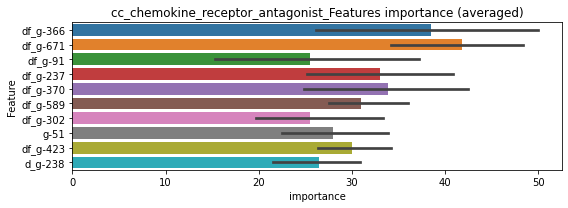

len(train_index) : 3806
len(valid_index) : 3806
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310419	valid_1's binary_logloss: 0.082725
[200]	training's binary_logloss: 0.00665499	valid_1's binary_logloss: 0.059585
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00306814	valid_1's binary_logloss: 0.0568629


len(train_index) : 3806
len(valid_index) : 3806
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338922	valid_1's binary_logloss: 0.0714352
[200]	training's binary_logloss: 0.00772553	valid_1's binary_logloss: 0.0446586
[300]	training's binary_logloss: 0.0022668	valid_1's binary_logloss: 0.0393913
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00118452	valid_1's binary_logloss: 0.0386357


cc_chemokine_receptor_antagonist logloss: 0.047749348632245864


neg labels: 3289 → selected neg labels: 3286


cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225414	valid_1's binary_logloss: 0.0289078
[200]	training's binary_logloss: 0.00262674	valid_1's binary_logloss: 0.00429626
[300]	training's binary_logloss: 0.000744298	valid_1's binary_logloss: 0.00143629
[400]	training's binary_logloss: 0.000401829	valid_1's binary_logloss: 0.000847095
[500]	training's binary_logloss: 0.000316634	valid_1's binary_logloss: 0.000692289
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000308831	valid_1's binary_logloss: 0.000680318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230116	valid_1's binary_logloss: 0.0304499
[200]	training's binary_logloss: 0.00264585	valid_1's binary_logloss: 0.00499113
[300]	training's binary_logloss: 0.000748056	valid_1's binary_logloss: 0.00190109
[400]	training's binary_logloss: 0.000400603	valid_1's binary_logloss: 0.00118609
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0016518, Threshold: 0.0024435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00220, conf_1:0.00269
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024435
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0124435
threshold: 0.0124435, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223783	valid_1's binary_logloss: 0.0275173
[200]	training's binary_logloss: 0.00254767	valid_1's binary_logloss: 0.00388984
[300]	training's binary_logloss: 0.000728534	valid_1's binary_logloss: 0.00125147
[400]	training's binary_logloss: 0.000395269	valid_1's binary_logloss: 0.000723805
[500]	training's binary_logloss: 0.000322048	valid_1's binary_logloss: 0.000611638
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000317802	valid_1's binary_logloss: 0.00060513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224145	valid_1's binary_logloss: 0.0309268
[200]	training's binary_logloss: 0.00251713	valid_1's binary_logloss: 0.00482065
[300]	training's binary_logloss: 0.00072299	valid_1's binary_logloss: 0.00174763
[400]	training's binary_logloss: 0.000393793	valid_1's binary_logloss: 0.00108036
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1380886, Threshold: 0.0124435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00076
Num_p_label: 28.0, conf_0:0.01120, conf_1:0.01369
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.0124435
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0224435
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0324435
threshold: 0.0324435, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223783	valid_1's binary_logloss: 0.0275173
[200]	training's binary_logloss: 0.00254767	valid_1's binary_logloss: 0.00388984
[300]	training's binary_logloss: 0.000728534	valid_1's binary_logloss: 0.00125147
[400]	training's binary_logloss: 0.000395269	valid_1's binary_logloss: 0.000723805
[500]	training's binary_logloss: 0.000322048	valid_1's binary_logloss: 0.000611638
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000317802	valid_1's binary_logloss: 0.00060513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224145	valid_1's binary_logloss: 0.0309268
[200]	training's binary_logloss: 0.00251713	valid_1's binary_logloss: 0.00482065
[300]	training's binary_logloss: 0.00072299	valid_1's binary_logloss: 0.00174763
[400]	training's binary_logloss: 0.000393793	valid_1's binary_logloss: 0.00108036
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1380886, Threshold: 0.0324435, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.02920, conf_1:0.03569
threshold: 0.0324435, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


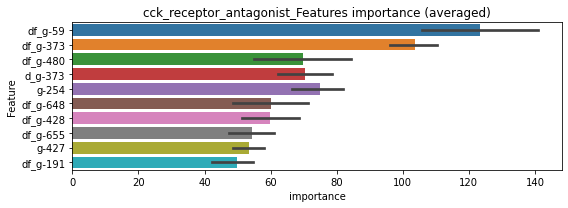

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122319	valid_1's binary_logloss: 0.017259
[200]	training's binary_logloss: 0.00137331	valid_1's binary_logloss: 0.00513612
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000513976	valid_1's binary_logloss: 0.00455126


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125858	valid_1's binary_logloss: 0.016905
[200]	training's binary_logloss: 0.00145516	valid_1's binary_logloss: 0.00348898
[300]	training's binary_logloss: 0.000398569	valid_1's binary_logloss: 0.00205758
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000232502	valid_1's binary_logloss: 0.00183013


cck_receptor_antagonist logloss: 0.003190869756854688


neg labels: 3289 → selected neg labels: 3263


cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439452	valid_1's binary_logloss: 0.118712
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0115065	valid_1's binary_logloss: 0.105994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428307	valid_1's binary_logloss: 0.114983
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0108944	valid_1's binary_logloss: 0.0995345


1 / 3 AUC score:0.982
y_Threshold: 0.0391981, Threshold: 0.3996764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 211 → Positive_corect_labels: 612/3704
p_label_rate: 0.0200904 Vs.target_rate: 0.01478
Num_p_label: 80.0, conf_0:0.35971, conf_1:0.43964
threshold: 0.3996764, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 612.0/3704, y_label_rate: 0.1652268
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351203	valid_1's binary_logloss: 0.0734099
[200]	training's binary_logloss: 0.0054251	valid_1's binary_logloss: 0.0503278
[300]	training's binary_logloss: 0.00157627	valid_1's binary_logloss: 0.0447957
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00160564	valid_1's binary_logloss: 0.044762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321451	valid_1's binary_logloss: 0.0967136
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00991331	valid_1's binary_logloss: 0.0853005


2 / 3 AUC score:0.994
y_Threshold: 0.0823828, Threshold: 0.3996764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 573.0/3626
p_label_rate: 0.0610246 Vs.target_rate: 0.01478
Num_p_label: 243.0, conf_0:0.35971, conf_1:0.43964
Num_p_label: 243.0, Expected: 58.9, Adj_threshold_1: 0.3996764
Num_p_label: 241.0, Expected: 58.9, Adj_threshold_2: 0.4096764
Num_p_label: 238.0, Expected: 58.9, Adj_threshold_3: 0.4196764
Num_p_label: 234.0, Expected: 58.9, Adj_threshold_4: 0.4296764
Num_p_label: 231.0, Expected: 58.9, Adj_threshold_5: 0.4396764
Num_p_label: 229.0, Expected: 58.9, Adj_threshold_6: 0.4496764
Num_p_label: 227.0, Expected: 58.9, Adj_threshold_7: 0.4596764
Num_p_label: 225.0, Expected: 58.9, Adj_threshold_8: 0.4696764
Num_p_label: 221.0, Expected: 58.9, Adj_threshold_9: 0.4796764
Num_p_label: 218.0, Expected: 58.9, Adj_threshold_10: 0.4896764
threshold: 0.4996764, positive_p_label: 216.0/3982, p_label_rate: 0.0542441
positive_y_label: 573.0/3626, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253626	valid_1's binary_logloss: 0.0719164
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0112427	valid_1's binary_logloss: 0.065693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276034	valid_1's binary_logloss: 0.0553769
[200]	training's binary_logloss: 0.00406946	valid_1's binary_logloss: 0.0402773
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00309666	valid_1's binary_logloss: 0.0399622


3 / 3 AUC score:0.992
y_Threshold: 0.0816645, Threshold: 0.4996764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 545.0/3570
p_label_rate: 0.0753390 Vs.target_rate: 0.01478
Num_p_label: 300.0, conf_0:0.44971, conf_1:0.54964
Num_p_label: 300.0, Expected: 58.9, Adj_threshold_1: 0.4996764
Num_p_label: 297.0, Expected: 58.9, Adj_threshold_2: 0.5096764
Num_p_label: 294.0, Expected: 58.9, Adj_threshold_3: 0.5196764
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_4: 0.5296764
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_5: 0.5396764
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_6: 0.5496764
Num_p_label: 288.0, Expected: 58.9, Adj_threshold_7: 0.5596764
Num_p_label: 287.0, Expected: 58.9, Adj_threshold_8: 0.5696764
Num_p_label: 287.0, Expected: 58.9, Adj_threshold_9: 0.5796764
Num_p_label: 285.0, Expected: 58.9, Adj_threshold_10: 0.5896764
threshold: 0.5996764, positive_p_label: 280.0/3982, p_label_rate: 0.0703164
positive_y_label: 825.0/7552, y_label_ra

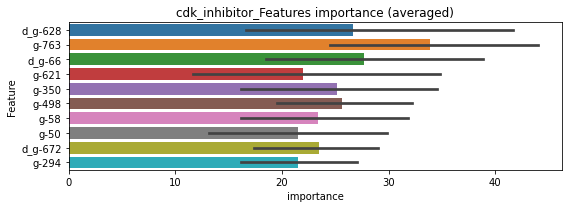

len(train_index) : 3776
len(valid_index) : 3776
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163196	valid_1's binary_logloss: 0.0291114
[200]	training's binary_logloss: 0.00195063	valid_1's binary_logloss: 0.0177742
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000905923	valid_1's binary_logloss: 0.0168793


len(train_index) : 3776
len(valid_index) : 3776
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145696	valid_1's binary_logloss: 0.0269278
[200]	training's binary_logloss: 0.00208129	valid_1's binary_logloss: 0.0178268
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000687165	valid_1's binary_logloss: 0.0166765


cdk_inhibitor logloss: 0.016777875317218752


neg labels: 3289 → selected neg labels: 3280


chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480385	valid_1's binary_logloss: 0.096293
[200]	training's binary_logloss: 0.00868883	valid_1's binary_logloss: 0.0446223
[300]	training's binary_logloss: 0.00241781	valid_1's binary_logloss: 0.0296274
[400]	training's binary_logloss: 0.00110666	valid_1's binary_logloss: 0.0259642
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000774489	valid_1's binary_logloss: 0.0241482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467676	valid_1's binary_logloss: 0.0947344
[200]	training's binary_logloss: 0.0084251	valid_1's binary_logloss: 0.0470764
[300]	training's binary_logloss: 0.00238573	valid_1's binary_logloss: 0.0380656
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00156084	valid_1's binary_logloss: 0.0365921


1 / 3 AUC score:1.000
y_Threshold: 0.0086501, Threshold: 0.0116072, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01045, conf_1:0.01277
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0116072
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_2: 0.0216072
Num_p_label: 4.0, Expected: 9.0, Adj_threshold_3: 0.0316072
threshold: 0.0316072, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487659	valid_1's binary_logloss: 0.0974758
[200]	training's binary_logloss: 0.00904234	valid_1's binary_logloss: 0.0477708
[300]	training's binary_logloss: 0.00253368	valid_1's binary_logloss: 0.034245
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00226263	valid_1's binary_logloss: 0.0332611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490688	valid_1's binary_logloss: 0.0893022
[200]	training's binary_logloss: 0.00890558	valid_1's binary_logloss: 0.0362644
[300]	training's binary_logloss: 0.00248344	valid_1's binary_logloss: 0.0234355
[400]	training's binary_logloss: 0.00113881	valid_1's binary_logloss: 0.0192187
[500]	training's binary_logloss: 0.000710127	valid_1's binary_logloss: 0.0176004
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000684035	valid_1's binary_logloss: 0.017503


2 / 3 AUC score:0.999
y_Threshold: 0.0396310, Threshold: 0.0316072, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0082873 Vs.target_rate: 0.00227
Num_p_label: 33.0, conf_0:0.02845, conf_1:0.03477
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_1: 0.0316072
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_2: 0.0416072
threshold: 0.0416072, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449774	valid_1's binary_logloss: 0.0954286
[200]	training's binary_logloss: 0.00814332	valid_1's binary_logloss: 0.0473799
[300]	training's binary_logloss: 0.00228792	valid_1's binary_logloss: 0.0356352
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00146785	valid_1's binary_logloss: 0.0333749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473111	valid_1's binary_logloss: 0.088749
[200]	training's binary_logloss: 0.00870798	valid_1's binary_logloss: 0.0388008
[300]	training's binary_logloss: 0.00241808	valid_1's binary_logloss: 0.0279882
[400]	training's binary_logloss: 0.00109402	valid_1's binary_logloss: 0.0243199
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00104522	valid_1's binary_logloss: 0.0241912


3 / 3 AUC score:0.999
y_Threshold: 0.0359102, Threshold: 0.0416072, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0035158 Vs.target_rate: 0.00227
Num_p_label: 14.0, conf_0:0.03745, conf_1:0.04577
threshold: 0.0416072, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/7756, y_label_rate: 0.0844507


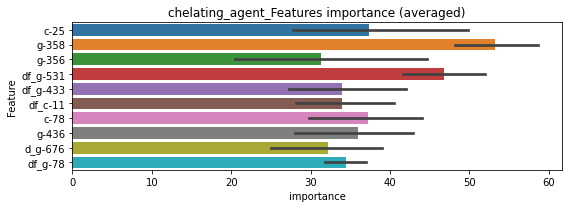

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267284	valid_1's binary_logloss: 0.0536876
[200]	training's binary_logloss: 0.00460531	valid_1's binary_logloss: 0.0283066
[300]	training's binary_logloss: 0.00122431	valid_1's binary_logloss: 0.0245493
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000984847	valid_1's binary_logloss: 0.024241


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272142	valid_1's binary_logloss: 0.0576565
[200]	training's binary_logloss: 0.00498508	valid_1's binary_logloss: 0.0317053
[300]	training's binary_logloss: 0.00134137	valid_1's binary_logloss: 0.0252985
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000950123	valid_1's binary_logloss: 0.0245263


chelating_agent logloss: 0.024383640334125076


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190447	valid_1's binary_logloss: 0.0269466
[200]	training's binary_logloss: 0.00191787	valid_1's binary_logloss: 0.00579807
[300]	training's binary_logloss: 0.000524706	valid_1's binary_logloss: 0.00277748
[400]	training's binary_logloss: 0.000296575	valid_1's binary_logloss: 0.00206801
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000253538	valid_1's binary_logloss: 0.00188342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186963	valid_1's binary_logloss: 0.0219521
[200]	training's binary_logloss: 0.0018782	valid_1's binary_logloss: 0.00361225
[300]	training's binary_logloss: 0.000531664	valid_1's binary_logloss: 0.00182477
[400]	training's binary_logloss: 0.00030167	valid_1's binary_logloss: 0.00139159
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000282614	valid_1's binary_logloss: 0.0013304

1 / 3 AUC score:1.000
y_Threshold: 0.0015443, Threshold: 0.0078824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00709, conf_1:0.00867
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0078824
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_2: 0.0178824
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_3: 0.0278824
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_4: 0.0378824
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_5: 0.0478824
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_6: 0.0578824
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.0678824
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_8: 0.0778824
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_9: 0.0878824
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_10: 0.0978824
threshold: 0.1078824, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185845	valid_1's binary_logloss: 0.0248252
[200]	training's binary_logloss: 0.00168602	valid_1's binary_logloss: 0.00459945
[300]	training's binary_logloss: 0.000445658	valid_1's binary_logloss: 0.00222888
[400]	training's binary_logloss: 0.000258322	valid_1's binary_logloss: 0.00172437
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000232246	valid_1's binary_logloss: 0.00165312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183072	valid_1's binary_logloss: 0.0203762
[200]	training's binary_logloss: 0.00169936	valid_1's binary_logloss: 0.00226899
[300]	training's binary_logloss: 0.000448508	valid_1's binary_logloss: 0.000724979
[400]	training's binary_logloss: 0.000259702	valid_1's binary_logloss: 0.000463013
[500]	training's binary_logloss: 0.000227035	valid_1's binary_logloss: 0.000412918
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.1020604, Threshold: 0.1078824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0226017 Vs.target_rate: 0.00101
Num_p_label: 90.0, conf_0:0.09709, conf_1:0.11867
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_1: 0.1078824
Num_p_label: 85.0, Expected: 4.0, Adj_threshold_2: 0.1178824
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_3: 0.1278824
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_4: 0.1378824
Num_p_label: 76.0, Expected: 4.0, Adj_threshold_5: 0.1478824
Num_p_label: 74.0, Expected: 4.0, Adj_threshold_6: 0.1578824
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_7: 0.1678824
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_8: 0.1778824
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_9: 0.1878824
Num_p_label: 67.0, Expected: 4.0, Adj_threshold_10: 0.1978824
threshold: 0.2078824, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185845	valid_1's binary_logloss: 0.0248252
[200]	training's binary_logloss: 0.00168602	valid_1's binary_logloss: 0.00459945
[300]	training's binary_logloss: 0.000445658	valid_1's binary_logloss: 0.00222888
[400]	training's binary_logloss: 0.000258322	valid_1's binary_logloss: 0.00172437
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000232246	valid_1's binary_logloss: 0.00165312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183072	valid_1's binary_logloss: 0.0203762
[200]	training's binary_logloss: 0.00169936	valid_1's binary_logloss: 0.00226899
[300]	training's binary_logloss: 0.000448508	valid_1's binary_logloss: 0.000724979
[400]	training's binary_logloss: 0.000259702	valid_1's binary_logloss: 0.000463013
[500]	training's binary_logloss: 0.000227035	valid_1's binary_logloss: 0.000412918
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.1020604, Threshold: 0.2078824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0153189 Vs.target_rate: 0.00101
Num_p_label: 61.0, conf_0:0.18709, conf_1:0.22867
Num_p_label: 61.0, Expected: 4.0, Adj_threshold_1: 0.2078824
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_2: 0.2178824
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_3: 0.2278824
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_4: 0.2378824
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_5: 0.2478824
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_6: 0.2578824
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_7: 0.2678824
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_8: 0.2778824
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_9: 0.2878824
Num_p_label: 51.0, Expected: 4.0, Adj_threshold_10: 0.2978824
threshold: 0.3078824, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 708.0/7792, y_label_rate: 0.0908624


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011909	valid_1's binary_logloss: 0.0201296
[200]	training's binary_logloss: 0.00131156	valid_1's binary_logloss: 0.00780352
[300]	training's binary_logloss: 0.000374304	valid_1's binary_logloss: 0.00654211
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000334815	valid_1's binary_logloss: 0.00645567


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120006	valid_1's binary_logloss: 0.0195684
[200]	training's binary_logloss: 0.0013359	valid_1's binary_logloss: 0.00844536
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000436174	valid_1's binary_logloss: 0.00751278


chk_inhibitor logloss: 0.006984227618890986


neg labels: 3289 → selected neg labels: 3282


chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398816	valid_1's binary_logloss: 0.0754672
[200]	training's binary_logloss: 0.00654958	valid_1's binary_logloss: 0.0353395
[300]	training's binary_logloss: 0.00180301	valid_1's binary_logloss: 0.0257249
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000997734	valid_1's binary_logloss: 0.0230129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403487	valid_1's binary_logloss: 0.0707633
[200]	training's binary_logloss: 0.00654418	valid_1's binary_logloss: 0.0272564
[300]	training's binary_logloss: 0.00184948	valid_1's binary_logloss: 0.0184744
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00096069	valid_1's binary_logloss: 0.0166916


1 / 3 AUC score:0.999
y_Threshold: 0.0084592, Threshold: 0.0142805, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01285, conf_1:0.01571
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0142805
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_2: 0.0242805
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_3: 0.0342805
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_4: 0.0442805
threshold: 0.0442805, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039651	valid_1's binary_logloss: 0.0745636
[200]	training's binary_logloss: 0.00629482	valid_1's binary_logloss: 0.0300963
[300]	training's binary_logloss: 0.00175144	valid_1's binary_logloss: 0.0203247
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00175144	valid_1's binary_logloss: 0.0203247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405519	valid_1's binary_logloss: 0.0638137
[200]	training's binary_logloss: 0.00640173	valid_1's binary_logloss: 0.0185688
[300]	training's binary_logloss: 0.00182438	valid_1's binary_logloss: 0.00993959
[400]	training's binary_logloss: 0.000875156	valid_1's binary_logloss: 0.00782834
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00060342	valid_1's binary_logloss: 0.00717218


2 / 3 AUC score:1.000
y_Threshold: 0.0525789, Threshold: 0.0442805, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0077850 Vs.target_rate: 0.00176
Num_p_label: 31.0, conf_0:0.03985, conf_1:0.04871
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_1: 0.0442805
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.0542805
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_3: 0.0642805
threshold: 0.0642805, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383909	valid_1's binary_logloss: 0.0739546
[200]	training's binary_logloss: 0.0060179	valid_1's binary_logloss: 0.0330451
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00227425	valid_1's binary_logloss: 0.0260049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390373	valid_1's binary_logloss: 0.0655764
[200]	training's binary_logloss: 0.00614848	valid_1's binary_logloss: 0.0210414
[300]	training's binary_logloss: 0.00174443	valid_1's binary_logloss: 0.0114252
[400]	training's binary_logloss: 0.000839484	valid_1's binary_logloss: 0.00901035
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000680506	valid_1's binary_logloss: 0.00845842


3 / 3 AUC score:1.000
y_Threshold: 0.0528301, Threshold: 0.0642805, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 645.0/3784
p_label_rate: 0.0052737 Vs.target_rate: 0.00176
Num_p_label: 21.0, conf_0:0.05785, conf_1:0.07071
threshold: 0.0642805, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 666.0/7766, y_label_rate: 0.0857584


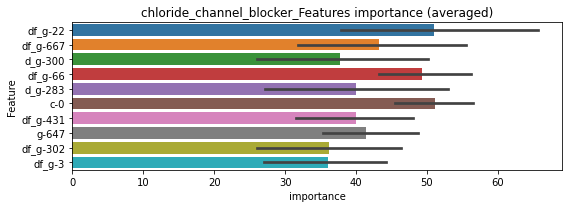

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226165	valid_1's binary_logloss: 0.0455038
[200]	training's binary_logloss: 0.00367032	valid_1's binary_logloss: 0.0221299
[300]	training's binary_logloss: 0.00101845	valid_1's binary_logloss: 0.0186516
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00104948	valid_1's binary_logloss: 0.0186189


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232768	valid_1's binary_logloss: 0.0439297
[200]	training's binary_logloss: 0.00391666	valid_1's binary_logloss: 0.0195158
[300]	training's binary_logloss: 0.0010369	valid_1's binary_logloss: 0.0160681
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000994125	valid_1's binary_logloss: 0.0160408


chloride_channel_blocker logloss: 0.017329853960593403


neg labels: 3289 → selected neg labels: 3281


cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419058	valid_1's binary_logloss: 0.0967097
[200]	training's binary_logloss: 0.007387	valid_1's binary_logloss: 0.0596301
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00363644	valid_1's binary_logloss: 0.0554633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434251	valid_1's binary_logloss: 0.081753
[200]	training's binary_logloss: 0.00775964	valid_1's binary_logloss: 0.0382269
[300]	training's binary_logloss: 0.00221132	valid_1's binary_logloss: 0.0297675
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0015475	valid_1's binary_logloss: 0.02881


1 / 3 AUC score:0.994
y_Threshold: 0.0135916, Threshold: 0.0170397, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 643/3779
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01534, conf_1:0.01874
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0170397
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.0270397
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.0370397
threshold: 0.0370397, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 643.0/3779, y_label_rate: 0.1701508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407322	valid_1's binary_logloss: 0.091142
[200]	training's binary_logloss: 0.00711011	valid_1's binary_logloss: 0.0479303
[300]	training's binary_logloss: 0.00202006	valid_1's binary_logloss: 0.0362867
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00107592	valid_1's binary_logloss: 0.0341627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412349	valid_1's binary_logloss: 0.0819847
[200]	training's binary_logloss: 0.00720958	valid_1's binary_logloss: 0.0401089
[300]	training's binary_logloss: 0.00205276	valid_1's binary_logloss: 0.0313625
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00170467	valid_1's binary_logloss: 0.030538


2 / 3 AUC score:0.998
y_Threshold: 0.0263738, Threshold: 0.0370397, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 636.0/3765
p_label_rate: 0.0035158 Vs.target_rate: 0.00202
Num_p_label: 14.0, conf_0:0.03334, conf_1:0.04074
threshold: 0.0370397, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 636.0/3765, y_label_rate: 0.1689243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413922	valid_1's binary_logloss: 0.0749536
[200]	training's binary_logloss: 0.00708916	valid_1's binary_logloss: 0.0299266
[300]	training's binary_logloss: 0.00205432	valid_1's binary_logloss: 0.0206473
[400]	training's binary_logloss: 0.000957385	valid_1's binary_logloss: 0.017766
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000842579	valid_1's binary_logloss: 0.017558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402304	valid_1's binary_logloss: 0.0786027
[200]	training's binary_logloss: 0.00710279	valid_1's binary_logloss: 0.0381381
[300]	training's binary_logloss: 0.00201985	valid_1's binary_logloss: 0.0311034
[400]	training's binary_logloss: 0.00096381	valid_1's binary_logloss: 0.029302
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0009692	valid_1's binary_logloss: 0.0292875


3 / 3 AUC score:0.999
y_Threshold: 0.0243115, Threshold: 0.0370397, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 629.0/3751
p_label_rate: 0.0022602 Vs.target_rate: 0.00202
Num_p_label: 9.0, conf_0:0.03334, conf_1:0.04074
threshold: 0.0370397, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 638.0/7733, y_label_rate: 0.0825036


len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213784	valid_1's binary_logloss: 0.0490756
[200]	training's binary_logloss: 0.00349448	valid_1's binary_logloss: 0.0277694
[300]	training's binary_logloss: 0.0009928	valid_1's binary_logloss: 0.0246342
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00092685	valid_1's binary_logloss: 0.02452


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216769	valid_1's binary_logloss: 0.0426136
[200]	training's binary_logloss: 0.00369004	valid_1's binary_logloss: 0.0179541
[300]	training's binary_logloss: 0.00105712	valid_1's binary_logloss: 0.0123999
[400]	training's binary_logloss: 0.000489475	valid_1's binary_logloss: 0.0108957
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000417361	valid_1's binary_logloss: 0.0107046


cholesterol_inhibitor logloss: 0.01761316534935051


neg labels: 3289 → selected neg labels: 3280


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520862	valid_1's binary_logloss: 0.100822
[200]	training's binary_logloss: 0.0103385	valid_1's binary_logloss: 0.0512068
[300]	training's binary_logloss: 0.00278911	valid_1's binary_logloss: 0.0374229
[400]	training's binary_logloss: 0.00122452	valid_1's binary_logloss: 0.032424
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000888314	valid_1's binary_logloss: 0.0311976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531129	valid_1's binary_logloss: 0.106828
[200]	training's binary_logloss: 0.00937946	valid_1's binary_logloss: 0.057536
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00285505	valid_1's binary_logloss: 0.0505793


1 / 3 AUC score:0.995
y_Threshold: 0.0137908, Threshold: 0.0192858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 643/3778
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01736, conf_1:0.02121
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0192858
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_2: 0.0292858
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_3: 0.0392858
threshold: 0.0392858, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 643.0/3778, y_label_rate: 0.1701959
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500386	valid_1's binary_logloss: 0.0924664
[200]	training's binary_logloss: 0.0091184	valid_1's binary_logloss: 0.0404331
[300]	training's binary_logloss: 0.00254263	valid_1's binary_logloss: 0.0276191
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00123704	valid_1's binary_logloss: 0.024367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504507	valid_1's binary_logloss: 0.0880104
[200]	training's binary_logloss: 0.00919696	valid_1's binary_logloss: 0.0357541
[300]	training's binary_logloss: 0.00253956	valid_1's binary_logloss: 0.0223913
[400]	training's binary_logloss: 0.00113798	valid_1's binary_logloss: 0.017742
[500]	training's binary_logloss: 0.000709972	valid_1's binary_logloss: 0.0159469
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000605178	valid_1's binary_logloss: 0.0154687


2 / 3 AUC score:1.000
y_Threshold: 0.0379464, Threshold: 0.0392858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 638.0/3768
p_label_rate: 0.0065294 Vs.target_rate: 0.00227
Num_p_label: 26.0, conf_0:0.03536, conf_1:0.04321
threshold: 0.0392858, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 638.0/3768, y_label_rate: 0.1693206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510282	valid_1's binary_logloss: 0.0867158
[200]	training's binary_logloss: 0.00959468	valid_1's binary_logloss: 0.0349934
[300]	training's binary_logloss: 0.00266674	valid_1's binary_logloss: 0.0212857
[400]	training's binary_logloss: 0.00118961	valid_1's binary_logloss: 0.0167605
[500]	training's binary_logloss: 0.000736459	valid_1's binary_logloss: 0.0148226
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000627932	valid_1's binary_logloss: 0.0143556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488317	valid_1's binary_logloss: 0.0906347
[200]	training's binary_logloss: 0.0090939	valid_1's binary_logloss: 0.0391881
[300]	training's binary_logloss: 0.00250519	valid_1's binary_logloss: 0.0252396
[400]	training's binary_logloss: 0.00113299	valid_1's binary_logloss: 0.0211656
[500]	training's binary_logloss: 0.000713377

3 / 3 AUC score:1.000
y_Threshold: 0.0395267, Threshold: 0.0392858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 635.0/3762
p_label_rate: 0.0057760 Vs.target_rate: 0.00227
Num_p_label: 23.0, conf_0:0.03536, conf_1:0.04321
threshold: 0.0392858, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 658.0/7744, y_label_rate: 0.0849690


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289054	valid_1's binary_logloss: 0.0568439
[200]	training's binary_logloss: 0.00540409	valid_1's binary_logloss: 0.0320143
[300]	training's binary_logloss: 0.00146623	valid_1's binary_logloss: 0.0270591
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000836664	valid_1's binary_logloss: 0.0260317


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292203	valid_1's binary_logloss: 0.0606137
[200]	training's binary_logloss: 0.00539509	valid_1's binary_logloss: 0.0318865
[300]	training's binary_logloss: 0.00148607	valid_1's binary_logloss: 0.0258171
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00136925	valid_1's binary_logloss: 0.0255348


cholinergic_receptor_antagonist logloss: 0.025783222614303592


neg labels: 3289 → selected neg labels: 3285


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288763	valid_1's binary_logloss: 0.0430389
[200]	training's binary_logloss: 0.00382417	valid_1's binary_logloss: 0.00990406
[300]	training's binary_logloss: 0.0010608	valid_1's binary_logloss: 0.00414787
[400]	training's binary_logloss: 0.000535973	valid_1's binary_logloss: 0.00263329
[500]	training's binary_logloss: 0.0003898	valid_1's binary_logloss: 0.00220205
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000382913	valid_1's binary_logloss: 0.00218251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278443	valid_1's binary_logloss: 0.0417988
[200]	training's binary_logloss: 0.00363872	valid_1's binary_logloss: 0.00970136
[300]	training's binary_logloss: 0.00102971	valid_1's binary_logloss: 0.00429982
[400]	training's binary_logloss: 0.000518752	valid_1's binary_logloss: 0.00279554
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024668, Threshold: 0.0030373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00273, conf_1:0.00334
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0030373
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0130373
threshold: 0.0130373, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275162	valid_1's binary_logloss: 0.0408318
[200]	training's binary_logloss: 0.0035156	valid_1's binary_logloss: 0.00825195
[300]	training's binary_logloss: 0.000999699	valid_1's binary_logloss: 0.0033298
[400]	training's binary_logloss: 0.000507685	valid_1's binary_logloss: 0.00201583
[500]	training's binary_logloss: 0.000381075	valid_1's binary_logloss: 0.00168417
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000366685	valid_1's binary_logloss: 0.0016671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027238	valid_1's binary_logloss: 0.0381789
[200]	training's binary_logloss: 0.0035112	valid_1's binary_logloss: 0.00786148
[300]	training's binary_logloss: 0.00100049	valid_1's binary_logloss: 0.00355958
[400]	training's binary_logloss: 0.000509864	valid_1's binary_logloss: 0.00230101
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1167030, Threshold: 0.0130373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0032647 Vs.target_rate: 0.00101
Num_p_label: 13.0, conf_0:0.01173, conf_1:0.01434
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.0130373
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_2: 0.0230373
threshold: 0.0230373, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275162	valid_1's binary_logloss: 0.0408318
[200]	training's binary_logloss: 0.0035156	valid_1's binary_logloss: 0.00825195
[300]	training's binary_logloss: 0.000999699	valid_1's binary_logloss: 0.0033298
[400]	training's binary_logloss: 0.000507685	valid_1's binary_logloss: 0.00201583
[500]	training's binary_logloss: 0.000381075	valid_1's binary_logloss: 0.00168417
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000366685	valid_1's binary_logloss: 0.0016671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027238	valid_1's binary_logloss: 0.0381789
[200]	training's binary_logloss: 0.0035112	valid_1's binary_logloss: 0.00786148
[300]	training's binary_logloss: 0.00100049	valid_1's binary_logloss: 0.00355958
[400]	training's binary_logloss: 0.000509864	valid_1's binary_logloss: 0.00230101
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1167030, Threshold: 0.0230373, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0007534 Vs.target_rate: 0.00101
Num_p_label: 3.0, conf_0:0.02073, conf_1:0.02534
threshold: 0.0230373, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7792, y_label_rate: 0.0847023


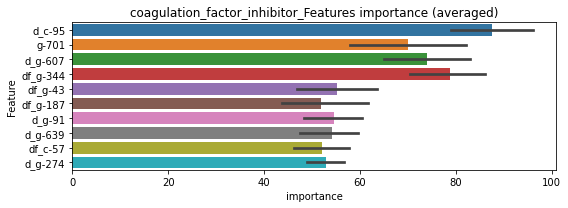

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157836	valid_1's binary_logloss: 0.0237379
[200]	training's binary_logloss: 0.00198009	valid_1's binary_logloss: 0.0065983
[300]	training's binary_logloss: 0.000529505	valid_1's binary_logloss: 0.0040378
[400]	training's binary_logloss: 0.000262044	valid_1's binary_logloss: 0.0035862
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000236939	valid_1's binary_logloss: 0.00354581


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156702	valid_1's binary_logloss: 0.0224257
[200]	training's binary_logloss: 0.00198698	valid_1's binary_logloss: 0.00566178
[300]	training's binary_logloss: 0.000536186	valid_1's binary_logloss: 0.00303281
[400]	training's binary_logloss: 0.000264198	valid_1's binary_logloss: 0.00245381
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000233846	valid_1's binary_logloss: 0.00239509


coagulation_factor_inhibitor logloss: 0.0029704483007727345


neg labels: 3289 → selected neg labels: 3284


corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250953	valid_1's binary_logloss: 0.0421571
[200]	training's binary_logloss: 0.00320917	valid_1's binary_logloss: 0.0148094
[300]	training's binary_logloss: 0.000936351	valid_1's binary_logloss: 0.00952262
[400]	training's binary_logloss: 0.000497559	valid_1's binary_logloss: 0.00826701
[500]	training's binary_logloss: 0.000364508	valid_1's binary_logloss: 0.00738562
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000359078	valid_1's binary_logloss: 0.00734511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254699	valid_1's binary_logloss: 0.0535042
[200]	training's binary_logloss: 0.00325186	valid_1's binary_logloss: 0.0352255
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00195181	valid_1's binary_logloss: 0.0342818


1 / 3 AUC score:1.000
y_Threshold: 0.0039221, Threshold: 0.0054882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00494, conf_1:0.00604
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0054882
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.0154882
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_3: 0.0254882
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.0354882
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_5: 0.0454882
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_6: 0.0554882
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_7: 0.0654882
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_8: 0.0754882
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_9: 0.0854882
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_10: 0.0954882
threshold: 0.1054882, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230135	valid_1's binary_logloss: 0.0356511
[200]	training's binary_logloss: 0.00279571	valid_1's binary_logloss: 0.00899811
[300]	training's binary_logloss: 0.000787924	valid_1's binary_logloss: 0.00409854
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000481198	valid_1's binary_logloss: 0.00340042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237094	valid_1's binary_logloss: 0.0460495
[200]	training's binary_logloss: 0.00271759	valid_1's binary_logloss: 0.028372
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0024456	valid_1's binary_logloss: 0.0279428


2 / 3 AUC score:1.000
y_Threshold: 0.0179486, Threshold: 0.1054882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0118031 Vs.target_rate: 0.00151
Num_p_label: 47.0, conf_0:0.09494, conf_1:0.11604
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_1: 0.1054882
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_2: 0.1154882
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.1254882
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_4: 0.1354882
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_5: 0.1454882
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_6: 0.1554882
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_7: 0.1654882
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_8: 0.1754882
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_9: 0.1854882
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_10: 0.1954882
threshold: 0.2054882, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230938	valid_1's binary_logloss: 0.035629
[200]	training's binary_logloss: 0.00261595	valid_1's binary_logloss: 0.0117795
[300]	training's binary_logloss: 0.000726962	valid_1's binary_logloss: 0.00879069
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000452474	valid_1's binary_logloss: 0.00805044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231107	valid_1's binary_logloss: 0.0392449
[200]	training's binary_logloss: 0.00263885	valid_1's binary_logloss: 0.0116144
[300]	training's binary_logloss: 0.000733752	valid_1's binary_logloss: 0.00696163
[400]	training's binary_logloss: 0.00039115	valid_1's binary_logloss: 0.00575983
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000374594	valid_1's binary_logloss: 0.00575964


3 / 3 AUC score:1.000
y_Threshold: 0.0143148, Threshold: 0.2054882, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0097941 Vs.target_rate: 0.00151
Num_p_label: 39.0, conf_0:0.18494, conf_1:0.22604
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_1: 0.2054882
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_2: 0.2154882
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.2254882
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.2354882
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_5: 0.2454882
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.2554882
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_7: 0.2654882
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_8: 0.2754882
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_9: 0.2854882
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_10: 0.2954882
threshold: 0.3054882, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 685.0/7772, y_label_rate: 0.0881369


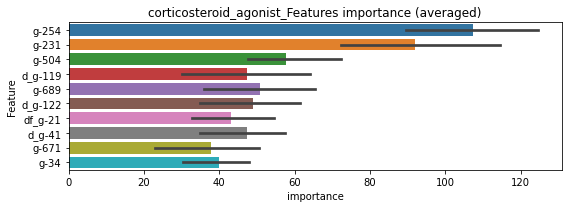

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122296	valid_1's binary_logloss: 0.0220536
[200]	training's binary_logloss: 0.00138536	valid_1's binary_logloss: 0.00660132
[300]	training's binary_logloss: 0.000393162	valid_1's binary_logloss: 0.00394074
[400]	training's binary_logloss: 0.00020824	valid_1's binary_logloss: 0.00335409
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00017918	valid_1's binary_logloss: 0.00321039


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125271	valid_1's binary_logloss: 0.0205073
[200]	training's binary_logloss: 0.00142355	valid_1's binary_logloss: 0.0066967
[300]	training's binary_logloss: 0.000397536	valid_1's binary_logloss: 0.00482054
[400]	training's binary_logloss: 0.00020987	valid_1's binary_logloss: 0.00428984
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000182665	valid_1's binary_logloss: 0.00422856


corticosteroid_agonist logloss: 0.003719473862551629


neg labels: 3289 → selected neg labels: 3215


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121972	valid_1's binary_logloss: 0.374527
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0755078	valid_1's binary_logloss: 0.369503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130386	valid_1's binary_logloss: 0.370449
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.104116	valid_1's binary_logloss: 0.367572


1 / 3 AUC score:0.777
y_Threshold: 0.1440362, Threshold: 0.1992237, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 739 → Positive_corect_labels: 338/3119
p_label_rate: 0.0200904 Vs.target_rate: 0.01827
Num_p_label: 80.0, conf_0:0.17930, conf_1:0.21915
threshold: 0.1992237, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 338.0/3119, y_label_rate: 0.1083681
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592536	valid_1's binary_logloss: 0.22962
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0324571	valid_1's binary_logloss: 0.223489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604063	valid_1's binary_logloss: 0.2258
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0298858	valid_1's binary_logloss: 0.214504


2 / 3 AUC score:0.905
y_Threshold: 0.0937919, Threshold: 0.1992237, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 223.0/2889
p_label_rate: 0.0090407 Vs.target_rate: 0.01827
Num_p_label: 36.0, conf_0:0.17930, conf_1:0.21915
threshold: 0.1992237, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 223.0/2889, y_label_rate: 0.0771893
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340504	valid_1's binary_logloss: 0.148789
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0149653	valid_1's binary_logloss: 0.141465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327342	valid_1's binary_logloss: 0.152156
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0134976	valid_1's binary_logloss: 0.14219


3 / 3 AUC score:0.963
y_Threshold: 0.0703134, Threshold: 0.1992237, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 165.0/2773
p_label_rate: 0.0102963 Vs.target_rate: 0.01827
Num_p_label: 41.0, conf_0:0.17930, conf_1:0.21915
threshold: 0.1992237, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 206.0/6755, y_label_rate: 0.0304959


len(train_index) : 3377
len(valid_index) : 3378
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141484	valid_1's binary_logloss: 0.0691765
[200]	training's binary_logloss: 0.0031909	valid_1's binary_logloss: 0.0639436
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00337994	valid_1's binary_logloss: 0.0639235


len(train_index) : 3378
len(valid_index) : 3377
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129072	valid_1's binary_logloss: 0.0644239
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00488001	valid_1's binary_logloss: 0.0599303


cyclooxygenase_inhibitor logloss: 0.0619271809841814


neg labels: 3289 → selected neg labels: 3274


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718483	valid_1's binary_logloss: 0.173291
[200]	training's binary_logloss: 0.0179843	valid_1's binary_logloss: 0.120678
[300]	training's binary_logloss: 0.00548894	valid_1's binary_logloss: 0.106162
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00264827	valid_1's binary_logloss: 0.102903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741611	valid_1's binary_logloss: 0.149091
[200]	training's binary_logloss: 0.019203	valid_1's binary_logloss: 0.0855786
[300]	training's binary_logloss: 0.0057535	valid_1's binary_logloss: 0.0634825
[400]	training's binary_logloss: 0.00247491	valid_1's binary_logloss: 0.057927
[500]	training's binary_logloss: 0.00140622	valid_1's binary_logloss: 0.0549052
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00144595	valid_1's binary_logloss: 0.0548613


1 / 3 AUC score:0.992
y_Threshold: 0.0220312, Threshold: 0.0277691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 636/3760
p_label_rate: 0.0200904 Vs.target_rate: 0.00437
Num_p_label: 80.0, conf_0:0.02499, conf_1:0.03055
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0277691
Num_p_label: 47.0, Expected: 17.4, Adj_threshold_2: 0.0377691
Num_p_label: 28.0, Expected: 17.4, Adj_threshold_3: 0.0477691
threshold: 0.0477691, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 636.0/3760, y_label_rate: 0.1691489
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071138	valid_1's binary_logloss: 0.150539
[200]	training's binary_logloss: 0.0174068	valid_1's binary_logloss: 0.0924816
[300]	training's binary_logloss: 0.0052452	valid_1's binary_logloss: 0.0732227
[400]	training's binary_logloss: 0.0022393	valid_1's binary_logloss: 0.0681479
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00172778	valid_1's binary_logloss: 0.0666827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655449	valid_1's binary_logloss: 0.151185
[200]	training's binary_logloss: 0.015482	valid_1's binary_logloss: 0.0934294
[300]	training's binary_logloss: 0.0047295	valid_1's binary_logloss: 0.0756599
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00268469	valid_1's binary_logloss: 0.0719452


2 / 3 AUC score:0.993
y_Threshold: 0.0505785, Threshold: 0.0477691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 609.0/3706
p_label_rate: 0.0153189 Vs.target_rate: 0.00437
Num_p_label: 61.0, conf_0:0.04299, conf_1:0.05255
Num_p_label: 61.0, Expected: 17.4, Adj_threshold_1: 0.0477691
Num_p_label: 48.0, Expected: 17.4, Adj_threshold_2: 0.0577691
Num_p_label: 34.0, Expected: 17.4, Adj_threshold_3: 0.0677691
threshold: 0.0677691, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 609.0/3706, y_label_rate: 0.1643281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064706	valid_1's binary_logloss: 0.142822
[200]	training's binary_logloss: 0.0151499	valid_1's binary_logloss: 0.092992
[300]	training's binary_logloss: 0.00452302	valid_1's binary_logloss: 0.0799667
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00332795	valid_1's binary_logloss: 0.0785867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623633	valid_1's binary_logloss: 0.144402
[200]	training's binary_logloss: 0.0148416	valid_1's binary_logloss: 0.0882049
[300]	training's binary_logloss: 0.00431588	valid_1's binary_logloss: 0.0738308
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00227916	valid_1's binary_logloss: 0.0690762


3 / 3 AUC score:0.991
y_Threshold: 0.0476157, Threshold: 0.0677691, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 582.0/3652
p_label_rate: 0.0100452 Vs.target_rate: 0.00437
Num_p_label: 40.0, conf_0:0.06099, conf_1:0.07455
threshold: 0.0677691, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 622.0/7634, y_label_rate: 0.0814776


len(train_index) : 3817
len(valid_index) : 3817
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373354	valid_1's binary_logloss: 0.0876609
[200]	training's binary_logloss: 0.00894703	valid_1's binary_logloss: 0.0598347
[300]	training's binary_logloss: 0.00259037	valid_1's binary_logloss: 0.0536704
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00244119	valid_1's binary_logloss: 0.0535322


len(train_index) : 3817
len(valid_index) : 3817
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366141	valid_1's binary_logloss: 0.0928815
[200]	training's binary_logloss: 0.00884365	valid_1's binary_logloss: 0.0680666
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00371781	valid_1's binary_logloss: 0.0640212


cytochrome_p450_inhibitor logloss: 0.058776679704319774


neg labels: 3289 → selected neg labels: 3283


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303677	valid_1's binary_logloss: 0.0468647
[200]	training's binary_logloss: 0.00413932	valid_1's binary_logloss: 0.0116843
[300]	training's binary_logloss: 0.00118353	valid_1's binary_logloss: 0.00531888
[400]	training's binary_logloss: 0.00058841	valid_1's binary_logloss: 0.00356943
[500]	training's binary_logloss: 0.000414037	valid_1's binary_logloss: 0.00306779
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000418009	valid_1's binary_logloss: 0.00306531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03042	valid_1's binary_logloss: 0.054928
[200]	training's binary_logloss: 0.0043383	valid_1's binary_logloss: 0.0197364
[300]	training's binary_logloss: 0.00120657	valid_1's binary_logloss: 0.0126695
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000805349	valid_1's binary_logloss: 0.0115039


1 / 3 AUC score:1.000
y_Threshold: 0.0033187, Threshold: 0.0042165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00379, conf_1:0.00464
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0042165
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0142165
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0242165
threshold: 0.0242165, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298825	valid_1's binary_logloss: 0.0455187
[200]	training's binary_logloss: 0.00396291	valid_1's binary_logloss: 0.00996169
[300]	training's binary_logloss: 0.00112267	valid_1's binary_logloss: 0.00428833
[400]	training's binary_logloss: 0.000567749	valid_1's binary_logloss: 0.0026685
[500]	training's binary_logloss: 0.00040389	valid_1's binary_logloss: 0.00218813
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000388032	valid_1's binary_logloss: 0.00216204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305504	valid_1's binary_logloss: 0.0510312
[200]	training's binary_logloss: 0.00414506	valid_1's binary_logloss: 0.0158968
[300]	training's binary_logloss: 0.00115224	valid_1's binary_logloss: 0.00938257
[400]	training's binary_logloss: 0.000574704	valid_1's binary_logloss: 0.00781905
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0303141, Threshold: 0.0242165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0052737 Vs.target_rate: 0.00151
Num_p_label: 21.0, conf_0:0.02179, conf_1:0.02664
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.0242165
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0342165
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0442165
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.0542165
threshold: 0.0542165, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298825	valid_1's binary_logloss: 0.0455187
[200]	training's binary_logloss: 0.00396291	valid_1's binary_logloss: 0.00996169
[300]	training's binary_logloss: 0.00112267	valid_1's binary_logloss: 0.00428833
[400]	training's binary_logloss: 0.000567749	valid_1's binary_logloss: 0.0026685
[500]	training's binary_logloss: 0.00040389	valid_1's binary_logloss: 0.00218813
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000388032	valid_1's binary_logloss: 0.00216204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305504	valid_1's binary_logloss: 0.0510312
[200]	training's binary_logloss: 0.00414506	valid_1's binary_logloss: 0.0158968
[300]	training's binary_logloss: 0.00115224	valid_1's binary_logloss: 0.00938257
[400]	training's binary_logloss: 0.000574704	valid_1's binary_logloss: 0.00781905
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0303141, Threshold: 0.0542165, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.04879, conf_1:0.05964
threshold: 0.0542165, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162553	valid_1's binary_logloss: 0.0334639
[200]	training's binary_logloss: 0.00219356	valid_1's binary_logloss: 0.0168441
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000828872	valid_1's binary_logloss: 0.0144996


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159143	valid_1's binary_logloss: 0.0267918
[200]	training's binary_logloss: 0.00214742	valid_1's binary_logloss: 0.00753034
[300]	training's binary_logloss: 0.00059827	valid_1's binary_logloss: 0.00409543
[400]	training's binary_logloss: 0.000298025	valid_1's binary_logloss: 0.00335942
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000223068	valid_1's binary_logloss: 0.00325824


dihydrofolate_reductase_inhibitor logloss: 0.00887964962079932


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285461	valid_1's binary_logloss: 0.0497476
[200]	training's binary_logloss: 0.00371463	valid_1's binary_logloss: 0.0167607
[300]	training's binary_logloss: 0.00104152	valid_1's binary_logloss: 0.0122223
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00105076	valid_1's binary_logloss: 0.0121879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279368	valid_1's binary_logloss: 0.0380349
[200]	training's binary_logloss: 0.00367684	valid_1's binary_logloss: 0.00677301
[300]	training's binary_logloss: 0.00103346	valid_1's binary_logloss: 0.00237376
[400]	training's binary_logloss: 0.000523268	valid_1's binary_logloss: 0.00139157
[500]	training's binary_logloss: 0.000386828	valid_1's binary_logloss: 0.00112839
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000368762	valid_1's binary_logloss: 0.00108757


1 / 3 AUC score:1.000
y_Threshold: 0.0036243, Threshold: 0.0047724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00430, conf_1:0.00525
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0047724
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.0147724
threshold: 0.0147724, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277622	valid_1's binary_logloss: 0.0469834
[200]	training's binary_logloss: 0.00353936	valid_1's binary_logloss: 0.016178
[300]	training's binary_logloss: 0.00100498	valid_1's binary_logloss: 0.0114693
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000813572	valid_1's binary_logloss: 0.0111735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280827	valid_1's binary_logloss: 0.0371672
[200]	training's binary_logloss: 0.00362816	valid_1's binary_logloss: 0.00630017
[300]	training's binary_logloss: 0.00102357	valid_1's binary_logloss: 0.00219632
[400]	training's binary_logloss: 0.000525044	valid_1's binary_logloss: 0.00124337
[500]	training's binary_logloss: 0.000387704	valid_1's binary_logloss: 0.000964668
[600]	training's binary_logloss: 0.000369501	valid_1's binary_logloss: 0.000934288
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0187598, Threshold: 0.0147724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0060271 Vs.target_rate: 0.00105
Num_p_label: 24.0, conf_0:0.01330, conf_1:0.01625
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0147724
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.0247724
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0347724
threshold: 0.0347724, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276631	valid_1's binary_logloss: 0.0461562
[200]	training's binary_logloss: 0.00347612	valid_1's binary_logloss: 0.0133081
[300]	training's binary_logloss: 0.00099236	valid_1's binary_logloss: 0.00748496
[400]	training's binary_logloss: 0.000511736	valid_1's binary_logloss: 0.00548499
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00040117	valid_1's binary_logloss: 0.005057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027069	valid_1's binary_logloss: 0.0434739
[200]	training's binary_logloss: 0.00342994	valid_1's binary_logloss: 0.0143372
[300]	training's binary_logloss: 0.000982386	valid_1's binary_logloss: 0.00914242
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00079252	valid_1's binary_logloss: 0.00858989


3 / 3 AUC score:1.000
y_Threshold: 0.0436466, Threshold: 0.0347724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00105
Num_p_label: 7.0, conf_0:0.03130, conf_1:0.03825
threshold: 0.0347724, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7790, y_label_rate: 0.0851091


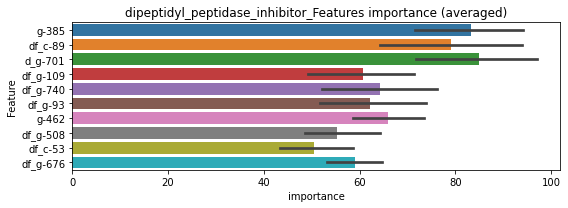

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154744	valid_1's binary_logloss: 0.025407
[200]	training's binary_logloss: 0.00196493	valid_1's binary_logloss: 0.0101082
[300]	training's binary_logloss: 0.000536083	valid_1's binary_logloss: 0.00826445
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000541062	valid_1's binary_logloss: 0.00825911


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015737	valid_1's binary_logloss: 0.026682
[200]	training's binary_logloss: 0.00200703	valid_1's binary_logloss: 0.00783025
[300]	training's binary_logloss: 0.000551847	valid_1's binary_logloss: 0.00519184
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000292703	valid_1's binary_logloss: 0.00453038


dipeptidyl_peptidase_inhibitor logloss: 0.0063947439244176636


neg labels: 3289 → selected neg labels: 3288


diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154011	valid_1's binary_logloss: 0.0178
[200]	training's binary_logloss: 0.00124582	valid_1's binary_logloss: 0.00272433
[300]	training's binary_logloss: 0.000340695	valid_1's binary_logloss: 0.00147888
[400]	training's binary_logloss: 0.000212667	valid_1's binary_logloss: 0.00126981
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000199403	valid_1's binary_logloss: 0.00123186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154142	valid_1's binary_logloss: 0.0172632
[200]	training's binary_logloss: 0.00125176	valid_1's binary_logloss: 0.00264845
[300]	training's binary_logloss: 0.000337892	valid_1's binary_logloss: 0.00123166
[400]	training's binary_logloss: 0.000210079	valid_1's binary_logloss: 0.000970851
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000187191	valid_1's binary_logloss: 0.0009177

1 / 3 AUC score:1.000
y_Threshold: 0.0006030, Threshold: 0.0011786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00106, conf_1:0.00130
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0011786
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0111786
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0211786
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0311786
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_5: 0.0411786
threshold: 0.0411786, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157032	valid_1's binary_logloss: 0.0179256
[200]	training's binary_logloss: 0.00124206	valid_1's binary_logloss: 0.0029021
[300]	training's binary_logloss: 0.000332902	valid_1's binary_logloss: 0.00161843
[400]	training's binary_logloss: 0.000208972	valid_1's binary_logloss: 0.00138614
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000191291	valid_1's binary_logloss: 0.0013504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015908	valid_1's binary_logloss: 0.020277
[200]	training's binary_logloss: 0.0012788	valid_1's binary_logloss: 0.00490199
[300]	training's binary_logloss: 0.000338242	valid_1's binary_logloss: 0.00300879
[400]	training's binary_logloss: 0.000209869	valid_1's binary_logloss: 0.00257358
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000207694	valid_1's binary_logloss: 0.00256799


2 / 3 AUC score:1.000
y_Threshold: 0.0508834, Threshold: 0.0411786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025
Num_p_label: 11.0, conf_0:0.03706, conf_1:0.04530
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0411786
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0511786
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0611786
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0711786
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0811786
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0911786
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.1011786
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.1111786
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1211786
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.1311786
threshold: 0.1311786, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157032	valid_1's binary_logloss: 0.0179256
[200]	training's binary_logloss: 0.00124206	valid_1's binary_logloss: 0.0029021
[300]	training's binary_logloss: 0.000332902	valid_1's binary_logloss: 0.00161843
[400]	training's binary_logloss: 0.000208972	valid_1's binary_logloss: 0.00138614
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000191291	valid_1's binary_logloss: 0.0013504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015908	valid_1's binary_logloss: 0.020277
[200]	training's binary_logloss: 0.0012788	valid_1's binary_logloss: 0.00490199
[300]	training's binary_logloss: 0.000338242	valid_1's binary_logloss: 0.00300879
[400]	training's binary_logloss: 0.000209869	valid_1's binary_logloss: 0.00257358
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000207694	valid_1's binary_logloss: 0.00256799


3 / 3 AUC score:1.000
y_Threshold: 0.0508834, Threshold: 0.1311786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.11806, conf_1:0.14430
threshold: 0.1311786, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


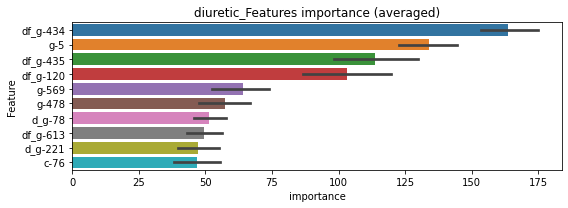

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838516	valid_1's binary_logloss: 0.00997338
[200]	training's binary_logloss: 0.000667986	valid_1's binary_logloss: 0.00197906
[300]	training's binary_logloss: 0.000174882	valid_1's binary_logloss: 0.00153056
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000181887	valid_1's binary_logloss: 0.00152343


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00843382	valid_1's binary_logloss: 0.0100535
[200]	training's binary_logloss: 0.000660909	valid_1's binary_logloss: 0.00197213
[300]	training's binary_logloss: 0.000173904	valid_1's binary_logloss: 0.00129903
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000166007	valid_1's binary_logloss: 0.00127656


diuretic logloss: 0.0014000109003776704


neg labels: 3289 → selected neg labels: 3281


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396302	valid_1's binary_logloss: 0.0801329
[200]	training's binary_logloss: 0.00674778	valid_1's binary_logloss: 0.0305786
[300]	training's binary_logloss: 0.00191696	valid_1's binary_logloss: 0.0170492
[400]	training's binary_logloss: 0.000928691	valid_1's binary_logloss: 0.0124135
[500]	training's binary_logloss: 0.000605203	valid_1's binary_logloss: 0.0108934
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000616346	valid_1's binary_logloss: 0.010825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417975	valid_1's binary_logloss: 0.0756962
[200]	training's binary_logloss: 0.00692836	valid_1's binary_logloss: 0.0267567
[300]	training's binary_logloss: 0.00199882	valid_1's binary_logloss: 0.0167756
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00141214	valid_1's binary_logloss: 0.0152407


1 / 3 AUC score:1.000
y_Threshold: 0.0074271, Threshold: 0.0143047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01287, conf_1:0.01574
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0143047
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_2: 0.0243047
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0343047
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.0443047
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_5: 0.0543047
threshold: 0.0543047, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389992	valid_1's binary_logloss: 0.0763336
[200]	training's binary_logloss: 0.00636482	valid_1's binary_logloss: 0.0325722
[300]	training's binary_logloss: 0.00185142	valid_1's binary_logloss: 0.0221039
[400]	training's binary_logloss: 0.000893169	valid_1's binary_logloss: 0.0187596
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000918644	valid_1's binary_logloss: 0.018652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402997	valid_1's binary_logloss: 0.0687051
[200]	training's binary_logloss: 0.00655761	valid_1's binary_logloss: 0.022155
[300]	training's binary_logloss: 0.00187445	valid_1's binary_logloss: 0.0118694
[400]	training's binary_logloss: 0.000918342	valid_1's binary_logloss: 0.00955034
[500]	training's binary_logloss: 0.000588982	valid_1's binary_logloss: 0.00830018
Early stopping, best iteration is:
[537]	

2 / 3 AUC score:1.000
y_Threshold: 0.0326952, Threshold: 0.0543047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0062783 Vs.target_rate: 0.00202
Num_p_label: 25.0, conf_0:0.04887, conf_1:0.05974
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.0543047
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.0643047
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.0743047
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.0843047
threshold: 0.0843047, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403338	valid_1's binary_logloss: 0.0827541
[200]	training's binary_logloss: 0.00651491	valid_1's binary_logloss: 0.035674
[300]	training's binary_logloss: 0.00185384	valid_1's binary_logloss: 0.0274639
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00108974	valid_1's binary_logloss: 0.0256406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395646	valid_1's binary_logloss: 0.0676933
[200]	training's binary_logloss: 0.00646784	valid_1's binary_logloss: 0.0212304
[300]	training's binary_logloss: 0.00186363	valid_1's binary_logloss: 0.0117587
[400]	training's binary_logloss: 0.000900815	valid_1's binary_logloss: 0.00937381
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000625852	valid_1's binary_logloss: 0.00860072


3 / 3 AUC score:1.000
y_Threshold: 0.0256593, Threshold: 0.0843047, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0035158 Vs.target_rate: 0.00202
Num_p_label: 14.0, conf_0:0.07587, conf_1:0.09274
threshold: 0.0843047, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 663.0/7773, y_label_rate: 0.0852953


len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222081	valid_1's binary_logloss: 0.0436923
[200]	training's binary_logloss: 0.00360602	valid_1's binary_logloss: 0.0193854
[300]	training's binary_logloss: 0.00102379	valid_1's binary_logloss: 0.0137332
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000641422	valid_1's binary_logloss: 0.0126159


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218141	valid_1's binary_logloss: 0.0483742
[200]	training's binary_logloss: 0.00359066	valid_1's binary_logloss: 0.0246577
[300]	training's binary_logloss: 0.000974527	valid_1's binary_logloss: 0.0191561
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000583569	valid_1's binary_logloss: 0.0182638


dna_alkylating_agent logloss: 0.015439480009857159


neg labels: 3289 → selected neg labels: 3229


dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118996	valid_1's binary_logloss: 0.353398
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0662892	valid_1's binary_logloss: 0.343349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107831	valid_1's binary_logloss: 0.361274
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0705962	valid_1's binary_logloss: 0.355402


1 / 3 AUC score:0.805
y_Threshold: 0.1145568, Threshold: 0.1692026, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 650 → Positive_corect_labels: 385/3224
p_label_rate: 0.0200904 Vs.target_rate: 0.01688
Num_p_label: 80.0, conf_0:0.15228, conf_1:0.18612
threshold: 0.1692026, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 385.0/3224, y_label_rate: 0.1194169
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589824	valid_1's binary_logloss: 0.232499
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0259748	valid_1's binary_logloss: 0.224869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622407	valid_1's binary_logloss: 0.211173
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0243107	valid_1's binary_logloss: 0.192838


2 / 3 AUC score:0.915
y_Threshold: 0.0755723, Threshold: 0.1692026, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 212 → Positive_corect_labels: 279.0/3012
p_label_rate: 0.0231040 Vs.target_rate: 0.01688
Num_p_label: 92.0, conf_0:0.15228, conf_1:0.18612
threshold: 0.1692026, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 279.0/3012, y_label_rate: 0.0926295
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359652	valid_1's binary_logloss: 0.176681
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0227033	valid_1's binary_logloss: 0.171844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393329	valid_1's binary_logloss: 0.148506
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0117043	valid_1's binary_logloss: 0.134165


3 / 3 AUC score:0.953
y_Threshold: 0.0556308, Threshold: 0.1692026, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 220.0/2894
p_label_rate: 0.0271220 Vs.target_rate: 0.01688
Num_p_label: 108.0, conf_0:0.15228, conf_1:0.18612
threshold: 0.1692026, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 328.0/6876, y_label_rate: 0.0477022


len(train_index) : 3438
len(valid_index) : 3438
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176452	valid_1's binary_logloss: 0.0718145
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00834843	valid_1's binary_logloss: 0.0665122


len(train_index) : 3438
len(valid_index) : 3438
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015334	valid_1's binary_logloss: 0.0832775
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00608328	valid_1's binary_logloss: 0.0778691


dna_inhibitor logloss: 0.07219066893587624


neg labels: 3289 → selected neg labels: 3267


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706187	valid_1's binary_logloss: 0.182713
[200]	training's binary_logloss: 0.0187048	valid_1's binary_logloss: 0.140425
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00995344	valid_1's binary_logloss: 0.134452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756025	valid_1's binary_logloss: 0.166686
[200]	training's binary_logloss: 0.0216984	valid_1's binary_logloss: 0.117957
[300]	training's binary_logloss: 0.00680601	valid_1's binary_logloss: 0.103875
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00572844	valid_1's binary_logloss: 0.1031


1 / 3 AUC score:0.972
y_Threshold: 0.0365496, Threshold: 0.0498218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 229 → Positive_corect_labels: 604/3691
p_label_rate: 0.0200904 Vs.target_rate: 0.00508
Num_p_label: 80.0, conf_0:0.04484, conf_1:0.05480
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0498218
Num_p_label: 44.0, Expected: 20.2, Adj_threshold_2: 0.0598218
Num_p_label: 25.0, Expected: 20.2, Adj_threshold_3: 0.0698218
threshold: 0.0698218, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 604.0/3691, y_label_rate: 0.1636413
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614358	valid_1's binary_logloss: 0.168354
[200]	training's binary_logloss: 0.0151808	valid_1's binary_logloss: 0.130096
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00877596	valid_1's binary_logloss: 0.127511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608464	valid_1's binary_logloss: 0.154292
[200]	training's binary_logloss: 0.0146109	valid_1's binary_logloss: 0.109246
[300]	training's binary_logloss: 0.0044904	valid_1's binary_logloss: 0.0980473
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00363386	valid_1's binary_logloss: 0.0968735


2 / 3 AUC score:0.977
y_Threshold: 0.0589376, Threshold: 0.0698218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 553.0/3589
p_label_rate: 0.0145655 Vs.target_rate: 0.00508
Num_p_label: 58.0, conf_0:0.06284, conf_1:0.07680
threshold: 0.0698218, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 553.0/3589, y_label_rate: 0.1540819
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553011	valid_1's binary_logloss: 0.112387
[200]	training's binary_logloss: 0.0129221	valid_1's binary_logloss: 0.0608362
[300]	training's binary_logloss: 0.00401373	valid_1's binary_logloss: 0.0455165
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00252326	valid_1's binary_logloss: 0.0422458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500156	valid_1's binary_logloss: 0.116694
[200]	training's binary_logloss: 0.0111742	valid_1's binary_logloss: 0.0726729
[300]	training's binary_logloss: 0.00346527	valid_1's binary_logloss: 0.0604651
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0021733	valid_1's binary_logloss: 0.058371


3 / 3 AUC score:0.997
y_Threshold: 0.0576254, Threshold: 0.0698218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 541.0/3565
p_label_rate: 0.0085384 Vs.target_rate: 0.00508
Num_p_label: 34.0, conf_0:0.06284, conf_1:0.07680
threshold: 0.0698218, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 575.0/7547, y_label_rate: 0.0761892


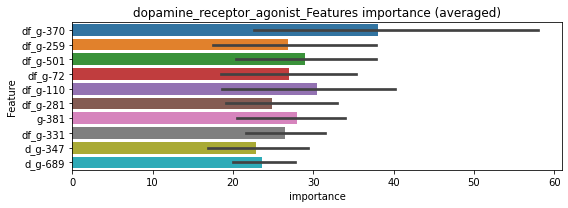

len(train_index) : 3773
len(valid_index) : 3774
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293456	valid_1's binary_logloss: 0.0848935
[200]	training's binary_logloss: 0.00666855	valid_1's binary_logloss: 0.0642291
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00336151	valid_1's binary_logloss: 0.0614308


len(train_index) : 3774
len(valid_index) : 3773
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307546	valid_1's binary_logloss: 0.0701029
[200]	training's binary_logloss: 0.00751953	valid_1's binary_logloss: 0.0457206
[300]	training's binary_logloss: 0.00214439	valid_1's binary_logloss: 0.0400463
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0023691	valid_1's binary_logloss: 0.0399502


dopamine_receptor_agonist logloss: 0.050691944044592846


neg labels: 3289 → selected neg labels: 3221


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124181	valid_1's binary_logloss: 0.38207
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0982442	valid_1's binary_logloss: 0.380098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127185	valid_1's binary_logloss: 0.36239
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0819153	valid_1's binary_logloss: 0.356542


1 / 3 AUC score:0.767
y_Threshold: 0.1393168, Threshold: 0.1928833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 723 → Positive_corect_labels: 347/3142
p_label_rate: 0.0200904 Vs.target_rate: 0.01780
Num_p_label: 80.0, conf_0:0.17359, conf_1:0.21217
threshold: 0.1928833, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 347.0/3142, y_label_rate: 0.1104392
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608408	valid_1's binary_logloss: 0.206671
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0305878	valid_1's binary_logloss: 0.191923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601452	valid_1's binary_logloss: 0.204428
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0237644	valid_1's binary_logloss: 0.194884


2 / 3 AUC score:0.931
y_Threshold: 0.0924715, Threshold: 0.1928833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 206 → Positive_corect_labels: 244.0/2936
p_label_rate: 0.0065294 Vs.target_rate: 0.01780
Num_p_label: 26.0, conf_0:0.17359, conf_1:0.21217
threshold: 0.1928833, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 244.0/2936, y_label_rate: 0.0831063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323126	valid_1's binary_logloss: 0.170373
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0123298	valid_1's binary_logloss: 0.16173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356591	valid_1's binary_logloss: 0.151088
[200]	training's binary_logloss: 0.00823102	valid_1's binary_logloss: 0.133613
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00835283	valid_1's binary_logloss: 0.133449


3 / 3 AUC score:0.957
y_Threshold: 0.0537138, Threshold: 0.1928833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 114 → Positive_corect_labels: 187.0/2822
p_label_rate: 0.0017579 Vs.target_rate: 0.01780
Num_p_label: 7.0, conf_0:0.17359, conf_1:0.21217
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_1: 0.1928833
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_2: 0.1828833
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_3: 0.1728833
Num_p_label: 8.0, Expected: 70.9, Adj_threshold_4: 0.1628833
Num_p_label: 10.0, Expected: 70.9, Adj_threshold_5: 0.1528833
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_6: 0.1428833
Num_p_label: 15.0, Expected: 70.9, Adj_threshold_7: 0.1328833
Num_p_label: 17.0, Expected: 70.9, Adj_threshold_8: 0.1228833
Num_p_label: 24.0, Expected: 70.9, Adj_threshold_9: 0.1128833
Num_p_label: 28.0, Expected: 70.9, Adj_threshold_10: 0.1028833
threshold: 0.0928833, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 226.0/6804, y_label_rate: 0.0332158


len(train_index) : 3402
len(valid_index) : 3402
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139649	valid_1's binary_logloss: 0.0822915
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00704743	valid_1's binary_logloss: 0.077688


len(train_index) : 3402
len(valid_index) : 3402
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139302	valid_1's binary_logloss: 0.0828997
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0136528	valid_1's binary_logloss: 0.082787


dopamine_receptor_antagonist logloss: 0.08023749285173125


neg labels: 3289 → selected neg labels: 3264


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429436	valid_1's binary_logloss: 0.132408
[200]	training's binary_logloss: 0.00817974	valid_1's binary_logloss: 0.112076
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00670206	valid_1's binary_logloss: 0.111228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453756	valid_1's binary_logloss: 0.115044
[200]	training's binary_logloss: 0.00878931	valid_1's binary_logloss: 0.090141
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00321861	valid_1's binary_logloss: 0.0848078


1 / 3 AUC score:0.985
y_Threshold: 0.0297200, Threshold: 0.2441895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 194 → Positive_corect_labels: 621/3722
p_label_rate: 0.0200904 Vs.target_rate: 0.01411
Num_p_label: 80.0, conf_0:0.21977, conf_1:0.26861
threshold: 0.2441895, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 621.0/3722, y_label_rate: 0.1668458
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369059	valid_1's binary_logloss: 0.0830454
[200]	training's binary_logloss: 0.00616152	valid_1's binary_logloss: 0.0576611
[300]	training's binary_logloss: 0.00187629	valid_1's binary_logloss: 0.0536778
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0019987	valid_1's binary_logloss: 0.0535422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346333	valid_1's binary_logloss: 0.100705
[200]	training's binary_logloss: 0.00565128	valid_1's binary_logloss: 0.0770031
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0027071	valid_1's binary_logloss: 0.0739392


2 / 3 AUC score:0.996
y_Threshold: 0.0628041, Threshold: 0.2441895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 592.0/3664
p_label_rate: 0.0248619 Vs.target_rate: 0.01411
Num_p_label: 99.0, conf_0:0.21977, conf_1:0.26861
threshold: 0.2441895, positive_p_label: 99.0/3982, p_label_rate: 0.0248619
positive_y_label: 592.0/3664, y_label_rate: 0.1615721
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322068	valid_1's binary_logloss: 0.0726674
[200]	training's binary_logloss: 0.00510824	valid_1's binary_logloss: 0.0426073
[300]	training's binary_logloss: 0.00154293	valid_1's binary_logloss: 0.0356944
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000879112	valid_1's binary_logloss: 0.0338861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310286	valid_1's binary_logloss: 0.074771
[200]	training's binary_logloss: 0.0047787	valid_1's binary_logloss: 0.0477308
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00230354	valid_1's binary_logloss: 0.0443388


3 / 3 AUC score:0.997
y_Threshold: 0.0699038, Threshold: 0.2441895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 577.0/3634
p_label_rate: 0.0268709 Vs.target_rate: 0.01411
Num_p_label: 107.0, conf_0:0.21977, conf_1:0.26861
threshold: 0.2441895, positive_p_label: 107.0/3982, p_label_rate: 0.0268709
positive_y_label: 684.0/7616, y_label_rate: 0.0898109


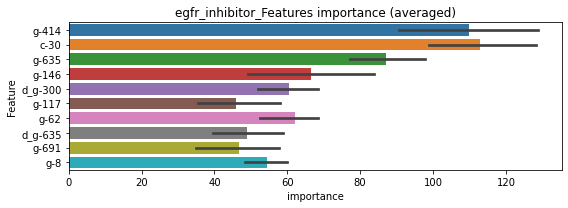

len(train_index) : 3808
len(valid_index) : 3808
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174298	valid_1's binary_logloss: 0.0507384
[200]	training's binary_logloss: 0.00265629	valid_1's binary_logloss: 0.0331107
[300]	training's binary_logloss: 0.000818099	valid_1's binary_logloss: 0.0293475
[400]	training's binary_logloss: 0.000420529	valid_1's binary_logloss: 0.0277729
[500]	training's binary_logloss: 0.000279912	valid_1's binary_logloss: 0.0266157
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000250475	valid_1's binary_logloss: 0.0260835


len(train_index) : 3808
len(valid_index) : 3808
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178167	valid_1's binary_logloss: 0.0522513
[200]	training's binary_logloss: 0.00280328	valid_1's binary_logloss: 0.0358557
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00091815	valid_1's binary_logloss: 0.0313713


egfr_inhibitor logloss: 0.028727407151102762


neg labels: 3289 → selected neg labels: 3287


elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191346	valid_1's binary_logloss: 0.0260579
[200]	training's binary_logloss: 0.00195902	valid_1's binary_logloss: 0.00680232
[300]	training's binary_logloss: 0.000558809	valid_1's binary_logloss: 0.00323707
[400]	training's binary_logloss: 0.000317128	valid_1's binary_logloss: 0.00243652
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000275121	valid_1's binary_logloss: 0.0022924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189905	valid_1's binary_logloss: 0.022873
[200]	training's binary_logloss: 0.0019552	valid_1's binary_logloss: 0.0030603
[300]	training's binary_logloss: 0.000566651	valid_1's binary_logloss: 0.00100899
[400]	training's binary_logloss: 0.000313363	valid_1's binary_logloss: 0.000599475
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000274504	valid_1's binary_logloss: 0.00053898

1 / 3 AUC score:1.000
y_Threshold: 0.0009034, Threshold: 0.0013117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00118, conf_1:0.00144
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0013117
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0113117
threshold: 0.0113117, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019196	valid_1's binary_logloss: 0.0268816
[200]	training's binary_logloss: 0.00190956	valid_1's binary_logloss: 0.00727779
[300]	training's binary_logloss: 0.000547938	valid_1's binary_logloss: 0.00408484
[400]	training's binary_logloss: 0.000312226	valid_1's binary_logloss: 0.00317932
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000272746	valid_1's binary_logloss: 0.00299335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191155	valid_1's binary_logloss: 0.0230398
[200]	training's binary_logloss: 0.00190358	valid_1's binary_logloss: 0.00401885
[300]	training's binary_logloss: 0.000551211	valid_1's binary_logloss: 0.00182179
[400]	training's binary_logloss: 0.000310374	valid_1's binary_logloss: 0.00130866
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000277883	valid_1's binary_logloss: 0.001252

2 / 3 AUC score:1.000
y_Threshold: 0.0480330, Threshold: 0.0113117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00050
Num_p_label: 12.0, conf_0:0.01018, conf_1:0.01244
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.0113117
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0213117
threshold: 0.0213117, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019196	valid_1's binary_logloss: 0.0268816
[200]	training's binary_logloss: 0.00190956	valid_1's binary_logloss: 0.00727779
[300]	training's binary_logloss: 0.000547938	valid_1's binary_logloss: 0.00408484
[400]	training's binary_logloss: 0.000312226	valid_1's binary_logloss: 0.00317932
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000272746	valid_1's binary_logloss: 0.00299335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191155	valid_1's binary_logloss: 0.0230398
[200]	training's binary_logloss: 0.00190358	valid_1's binary_logloss: 0.00401885
[300]	training's binary_logloss: 0.000551211	valid_1's binary_logloss: 0.00182179
[400]	training's binary_logloss: 0.000310374	valid_1's binary_logloss: 0.00130866
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000277883	valid_1's binary_logloss: 0.001252

3 / 3 AUC score:1.000
y_Threshold: 0.0480330, Threshold: 0.0213117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.01918, conf_1:0.02344
threshold: 0.0213117, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100375	valid_1's binary_logloss: 0.0148709
[200]	training's binary_logloss: 0.000985318	valid_1's binary_logloss: 0.00524418
[300]	training's binary_logloss: 0.00027414	valid_1's binary_logloss: 0.00474978
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000286712	valid_1's binary_logloss: 0.00472243


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106588	valid_1's binary_logloss: 0.016388
[200]	training's binary_logloss: 0.00107733	valid_1's binary_logloss: 0.00570846
[300]	training's binary_logloss: 0.00029923	valid_1's binary_logloss: 0.00388122
[400]	training's binary_logloss: 0.000164326	valid_1's binary_logloss: 0.00353524
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000145601	valid_1's binary_logloss: 0.00346159


elastase_inhibitor logloss: 0.004092013944368019


neg labels: 3289 → selected neg labels: 3284


erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258243	valid_1's binary_logloss: 0.034468
[200]	training's binary_logloss: 0.00324474	valid_1's binary_logloss: 0.00572633
[300]	training's binary_logloss: 0.000902136	valid_1's binary_logloss: 0.00197234
[400]	training's binary_logloss: 0.000465681	valid_1's binary_logloss: 0.00114278
[500]	training's binary_logloss: 0.000359291	valid_1's binary_logloss: 0.000942648
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000353989	valid_1's binary_logloss: 0.000935873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260514	valid_1's binary_logloss: 0.0356554
[200]	training's binary_logloss: 0.00323071	valid_1's binary_logloss: 0.00690024
[300]	training's binary_logloss: 0.000908594	valid_1's binary_logloss: 0.00276779
[400]	training's binary_logloss: 0.000464117	valid_1's binary_logloss: 0.00168246
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0013926, Threshold: 0.0020717, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084
Num_p_label: 80.0, conf_0:0.00186, conf_1:0.00228
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0020717
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.0120717
threshold: 0.0120717, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255946	valid_1's binary_logloss: 0.0349875
[200]	training's binary_logloss: 0.00314911	valid_1's binary_logloss: 0.00617732
[300]	training's binary_logloss: 0.000891888	valid_1's binary_logloss: 0.00220951
[400]	training's binary_logloss: 0.000462262	valid_1's binary_logloss: 0.00129955
[500]	training's binary_logloss: 0.000355413	valid_1's binary_logloss: 0.00108247
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000349741	valid_1's binary_logloss: 0.00107491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266835	valid_1's binary_logloss: 0.0375397
[200]	training's binary_logloss: 0.00328042	valid_1's binary_logloss: 0.00745386
[300]	training's binary_logloss: 0.000915218	valid_1's binary_logloss: 0.00298836
[400]	training's binary_logloss: 0.000469045	valid_1's binary_logloss: 0.00185659
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1277695, Threshold: 0.0120717, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00084
Num_p_label: 7.0, conf_0:0.01086, conf_1:0.01328
threshold: 0.0120717, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255946	valid_1's binary_logloss: 0.0349875
[200]	training's binary_logloss: 0.00314911	valid_1's binary_logloss: 0.00617732
[300]	training's binary_logloss: 0.000891888	valid_1's binary_logloss: 0.00220951
[400]	training's binary_logloss: 0.000462262	valid_1's binary_logloss: 0.00129955
[500]	training's binary_logloss: 0.000355413	valid_1's binary_logloss: 0.00108247
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000349741	valid_1's binary_logloss: 0.00107491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266835	valid_1's binary_logloss: 0.0375397
[200]	training's binary_logloss: 0.00328042	valid_1's binary_logloss: 0.00745386
[300]	training's binary_logloss: 0.000915218	valid_1's binary_logloss: 0.00298836
[400]	training's binary_logloss: 0.000469045	valid_1's binary_logloss: 0.00185659
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1277695, Threshold: 0.0120717, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00084
Num_p_label: 7.0, conf_0:0.01086, conf_1:0.01328
threshold: 0.0120717, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7790, y_label_rate: 0.0851091


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142016	valid_1's binary_logloss: 0.0240898
[200]	training's binary_logloss: 0.00170157	valid_1's binary_logloss: 0.00929436
[300]	training's binary_logloss: 0.000466845	valid_1's binary_logloss: 0.00804208
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000438554	valid_1's binary_logloss: 0.00802335


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146394	valid_1's binary_logloss: 0.020068
[200]	training's binary_logloss: 0.00185172	valid_1's binary_logloss: 0.00506979
[300]	training's binary_logloss: 0.000514197	valid_1's binary_logloss: 0.0034905
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000300863	valid_1's binary_logloss: 0.00332672


erbb2_inhibitor logloss: 0.005675031590077151


neg labels: 3289 → selected neg labels: 3265


estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793379	valid_1's binary_logloss: 0.200958
[200]	training's binary_logloss: 0.0233963	valid_1's binary_logloss: 0.154753
[300]	training's binary_logloss: 0.00790611	valid_1's binary_logloss: 0.143926
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00663594	valid_1's binary_logloss: 0.142464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809104	valid_1's binary_logloss: 0.184326
[200]	training's binary_logloss: 0.0239591	valid_1's binary_logloss: 0.132973
[300]	training's binary_logloss: 0.00802557	valid_1's binary_logloss: 0.118902
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00518236	valid_1's binary_logloss: 0.116806


1 / 3 AUC score:0.974
y_Threshold: 0.0355084, Threshold: 0.0529713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 243 → Positive_corect_labels: 597/3675
p_label_rate: 0.0200904 Vs.target_rate: 0.00663
Num_p_label: 80.0, conf_0:0.04767, conf_1:0.05827
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0529713
Num_p_label: 57.0, Expected: 26.4, Adj_threshold_2: 0.0629713
Num_p_label: 43.0, Expected: 26.4, Adj_threshold_3: 0.0729713
threshold: 0.0729713, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 597.0/3675, y_label_rate: 0.1624490
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682377	valid_1's binary_logloss: 0.170608
[200]	training's binary_logloss: 0.0174118	valid_1's binary_logloss: 0.125591
[300]	training's binary_logloss: 0.00559916	valid_1's binary_logloss: 0.116246
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00436329	valid_1's binary_logloss: 0.114455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706388	valid_1's binary_logloss: 0.159159
[200]	training's binary_logloss: 0.0187405	valid_1's binary_logloss: 0.105652
[300]	training's binary_logloss: 0.00584895	valid_1's binary_logloss: 0.0868557
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00281808	valid_1's binary_logloss: 0.0820734


2 / 3 AUC score:0.990
y_Threshold: 0.0667325, Threshold: 0.0729713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 558.0/3597
p_label_rate: 0.0241085 Vs.target_rate: 0.00663
Num_p_label: 96.0, conf_0:0.06567, conf_1:0.08027
Num_p_label: 96.0, Expected: 26.4, Adj_threshold_1: 0.0729713
Num_p_label: 78.0, Expected: 26.4, Adj_threshold_2: 0.0829713
Num_p_label: 70.0, Expected: 26.4, Adj_threshold_3: 0.0929713
Num_p_label: 55.0, Expected: 26.4, Adj_threshold_4: 0.1029713
Num_p_label: 48.0, Expected: 26.4, Adj_threshold_5: 0.1129713
threshold: 0.1129713, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 558.0/3597, y_label_rate: 0.1551293
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575668	valid_1's binary_logloss: 0.171245
[200]	training's binary_logloss: 0.0136373	valid_1's binary_logloss: 0.134271
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00806	valid_1's binary_logloss: 0.127374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645685	valid_1's binary_logloss: 0.150532
[200]	training's binary_logloss: 0.0158354	valid_1's binary_logloss: 0.0989516
[300]	training's binary_logloss: 0.00497128	valid_1's binary_logloss: 0.082255
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00408332	valid_1's binary_logloss: 0.0808969


3 / 3 AUC score:0.989
y_Threshold: 0.0720504, Threshold: 0.1129713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 518.0/3517
p_label_rate: 0.0155701 Vs.target_rate: 0.00663
Num_p_label: 62.0, conf_0:0.10167, conf_1:0.12427
threshold: 0.1129713, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 580.0/7499, y_label_rate: 0.0773436


len(train_index) : 3749
len(valid_index) : 3750
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336792	valid_1's binary_logloss: 0.0954026
[200]	training's binary_logloss: 0.0085814	valid_1's binary_logloss: 0.0728905
[300]	training's binary_logloss: 0.00267342	valid_1's binary_logloss: 0.067866
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00272941	valid_1's binary_logloss: 0.0678084


len(train_index) : 3750
len(valid_index) : 3749
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347082	valid_1's binary_logloss: 0.099109
[200]	training's binary_logloss: 0.00802034	valid_1's binary_logloss: 0.0771894
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00419086	valid_1's binary_logloss: 0.0748361


estrogen_receptor_agonist logloss: 0.07132179967169512


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447994	valid_1's binary_logloss: 0.0891817
[200]	training's binary_logloss: 0.00769044	valid_1's binary_logloss: 0.043223
[300]	training's binary_logloss: 0.00212996	valid_1's binary_logloss: 0.0345586
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00192634	valid_1's binary_logloss: 0.0344758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046084	valid_1's binary_logloss: 0.0775327
[200]	training's binary_logloss: 0.00823776	valid_1's binary_logloss: 0.0246544
[300]	training's binary_logloss: 0.00228003	valid_1's binary_logloss: 0.0127653
[400]	training's binary_logloss: 0.00104848	valid_1's binary_logloss: 0.00935759
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000692272	valid_1's binary_logloss: 0.00832013


1 / 3 AUC score:0.998
y_Threshold: 0.0088462, Threshold: 0.0115052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01035, conf_1:0.01266
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0115052
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.0215052
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_3: 0.0315052
threshold: 0.0315052, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451696	valid_1's binary_logloss: 0.0779017
[200]	training's binary_logloss: 0.00787925	valid_1's binary_logloss: 0.0294728
[300]	training's binary_logloss: 0.00217157	valid_1's binary_logloss: 0.0164375
[400]	training's binary_logloss: 0.00101797	valid_1's binary_logloss: 0.0128099
[500]	training's binary_logloss: 0.00064301	valid_1's binary_logloss: 0.0110964
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00066192	valid_1's binary_logloss: 0.0110897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421013	valid_1's binary_logloss: 0.0910687
[200]	training's binary_logloss: 0.00722594	valid_1's binary_logloss: 0.0400214
[300]	training's binary_logloss: 0.00202249	valid_1's binary_logloss: 0.0313647
[400]	training's binary_logloss: 0.000951699	valid_1's binary_logloss: 0.0282442
Early stopping, best iteration is:
[401]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0246665, Threshold: 0.0315052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 645.0/3785
p_label_rate: 0.0055249 Vs.target_rate: 0.00202
Num_p_label: 22.0, conf_0:0.02835, conf_1:0.03466
threshold: 0.0315052, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 645.0/3785, y_label_rate: 0.1704095
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423357	valid_1's binary_logloss: 0.0822279
[200]	training's binary_logloss: 0.00722707	valid_1's binary_logloss: 0.03393
[300]	training's binary_logloss: 0.00204759	valid_1's binary_logloss: 0.0239559
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00113424	valid_1's binary_logloss: 0.0217739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417888	valid_1's binary_logloss: 0.0743881
[200]	training's binary_logloss: 0.00712868	valid_1's binary_logloss: 0.0282087
[300]	training's binary_logloss: 0.00207128	valid_1's binary_logloss: 0.018663
[400]	training's binary_logloss: 0.000984782	valid_1's binary_logloss: 0.0153859
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000887022	valid_1's binary_logloss: 0.0150364


3 / 3 AUC score:1.000
y_Threshold: 0.0313246, Threshold: 0.0315052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 641.0/3777
p_label_rate: 0.0067805 Vs.target_rate: 0.00202
Num_p_label: 27.0, conf_0:0.02835, conf_1:0.03466
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.0315052
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.0415052
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0515052
threshold: 0.0515052, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/7759, y_label_rate: 0.0842892


len(train_index) : 3879
len(valid_index) : 3880
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234658	valid_1's binary_logloss: 0.0435293
[200]	training's binary_logloss: 0.00402299	valid_1's binary_logloss: 0.0185848
[300]	training's binary_logloss: 0.00111533	valid_1's binary_logloss: 0.0132115
[400]	training's binary_logloss: 0.000508353	valid_1's binary_logloss: 0.0122119
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000381095	valid_1's binary_logloss: 0.0118177


len(train_index) : 3880
len(valid_index) : 3879
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243143	valid_1's binary_logloss: 0.046084
[200]	training's binary_logloss: 0.0042614	valid_1's binary_logloss: 0.020206
[300]	training's binary_logloss: 0.00119281	valid_1's binary_logloss: 0.0154015
[400]	training's binary_logloss: 0.000534943	valid_1's binary_logloss: 0.0141771
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000568986	valid_1's binary_logloss: 0.0141431


estrogen_receptor_antagonist logloss: 0.012980245634665148


neg labels: 3289 → selected neg labels: 3283


faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341736	valid_1's binary_logloss: 0.0548464
[200]	training's binary_logloss: 0.00514706	valid_1's binary_logloss: 0.0159204
[300]	training's binary_logloss: 0.00140922	valid_1's binary_logloss: 0.00751027
[400]	training's binary_logloss: 0.000693857	valid_1's binary_logloss: 0.00489813
[500]	training's binary_logloss: 0.000465552	valid_1's binary_logloss: 0.00383923
[600]	training's binary_logloss: 0.000419635	valid_1's binary_logloss: 0.00363438
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000422488	valid_1's binary_logloss: 0.00363209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332247	valid_1's binary_logloss: 0.0558744
[200]	training's binary_logloss: 0.00504474	valid_1's binary_logloss: 0.0181516
[300]	training's binary_logloss: 0.00137777	valid_1's binary_logloss: 0.0100348
[400]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0055730, Threshold: 0.0139998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.01260, conf_1:0.01540
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0139998
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.0239998
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.0339998
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.0439998
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0539998
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_6: 0.0639998
threshold: 0.0639998, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309795	valid_1's binary_logloss: 0.0476112
[200]	training's binary_logloss: 0.00446616	valid_1's binary_logloss: 0.0115486
[300]	training's binary_logloss: 0.00127344	valid_1's binary_logloss: 0.00491954
[400]	training's binary_logloss: 0.000633447	valid_1's binary_logloss: 0.00314501
[500]	training's binary_logloss: 0.000438139	valid_1's binary_logloss: 0.00244235
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000409148	valid_1's binary_logloss: 0.00235832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031448	valid_1's binary_logloss: 0.0471246
[200]	training's binary_logloss: 0.00452843	valid_1's binary_logloss: 0.0128968
[300]	training's binary_logloss: 0.0012728	valid_1's binary_logloss: 0.00665654
[400]	training's binary_logloss: 0.000640902	valid_1's binary_logloss: 0.0047738
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.1388002, Threshold: 0.0639998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0145655 Vs.target_rate: 0.00151
Num_p_label: 58.0, conf_0:0.05760, conf_1:0.07040
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_1: 0.0639998
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.0739998
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_3: 0.0839998
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.0939998
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.1039998
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_6: 0.1139998
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_7: 0.1239998
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_8: 0.1339998
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_9: 0.1439998
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_10: 0.1539998
threshold: 0.1639998, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309795	valid_1's binary_logloss: 0.0476112
[200]	training's binary_logloss: 0.00446616	valid_1's binary_logloss: 0.0115486
[300]	training's binary_logloss: 0.00127344	valid_1's binary_logloss: 0.00491954
[400]	training's binary_logloss: 0.000633447	valid_1's binary_logloss: 0.00314501
[500]	training's binary_logloss: 0.000438139	valid_1's binary_logloss: 0.00244235
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000409148	valid_1's binary_logloss: 0.00235832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031448	valid_1's binary_logloss: 0.0471246
[200]	training's binary_logloss: 0.00452843	valid_1's binary_logloss: 0.0128968
[300]	training's binary_logloss: 0.0012728	valid_1's binary_logloss: 0.00665654
[400]	training's binary_logloss: 0.000640902	valid_1's binary_logloss: 0.0047738
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1388002, Threshold: 0.1639998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0055249 Vs.target_rate: 0.00151
Num_p_label: 22.0, conf_0:0.14760, conf_1:0.18040
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.1639998
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.1739998
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_3: 0.1839998
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.1939998
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.2039998
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_6: 0.2139998
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.2239998
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_8: 0.2339998
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.2439998
threshold: 0.2439998, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


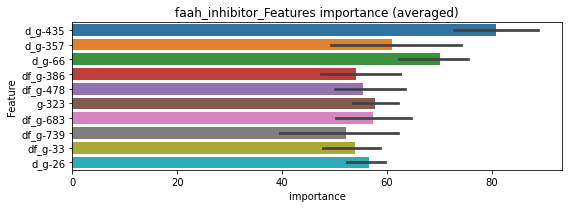

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183425	valid_1's binary_logloss: 0.0352361
[200]	training's binary_logloss: 0.00266457	valid_1's binary_logloss: 0.0143432
[300]	training's binary_logloss: 0.000732836	valid_1's binary_logloss: 0.0107898
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000518209	valid_1's binary_logloss: 0.0103603


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180335	valid_1's binary_logloss: 0.0324694
[200]	training's binary_logloss: 0.00271599	valid_1's binary_logloss: 0.0116611
[300]	training's binary_logloss: 0.000748148	valid_1's binary_logloss: 0.00721559
[400]	training's binary_logloss: 0.00036277	valid_1's binary_logloss: 0.00597693
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000260903	valid_1's binary_logloss: 0.00555287


faah_inhibitor logloss: 0.007956905001134523


neg labels: 3289 → selected neg labels: 3286


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180183	valid_1's binary_logloss: 0.0221394
[200]	training's binary_logloss: 0.00172846	valid_1's binary_logloss: 0.00330877
[300]	training's binary_logloss: 0.000467238	valid_1's binary_logloss: 0.00123135
[400]	training's binary_logloss: 0.000272928	valid_1's binary_logloss: 0.000831723
[500]	training's binary_logloss: 0.000232417	valid_1's binary_logloss: 0.000753886
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00022759	valid_1's binary_logloss: 0.000743122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181324	valid_1's binary_logloss: 0.0239673
[200]	training's binary_logloss: 0.00173032	valid_1's binary_logloss: 0.00487787
[300]	training's binary_logloss: 0.000471405	valid_1's binary_logloss: 0.00261264
[400]	training's binary_logloss: 0.000274998	valid_1's binary_logloss: 0.00214527
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0012478, Threshold: 0.0033946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00306, conf_1:0.00373
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0033946
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.0133946
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.0233946
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0333946
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.0433946
threshold: 0.0433946, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182543	valid_1's binary_logloss: 0.0218407
[200]	training's binary_logloss: 0.00168	valid_1's binary_logloss: 0.00299396
[300]	training's binary_logloss: 0.000437966	valid_1's binary_logloss: 0.00106693
[400]	training's binary_logloss: 0.000257703	valid_1's binary_logloss: 0.000699925
[500]	training's binary_logloss: 0.000221894	valid_1's binary_logloss: 0.000636833
[600]	training's binary_logloss: 0.000216179	valid_1's binary_logloss: 0.000627227
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000214994	valid_1's binary_logloss: 0.000625369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181834	valid_1's binary_logloss: 0.0218896
[200]	training's binary_logloss: 0.00168276	valid_1's binary_logloss: 0.00294138
[300]	training's binary_logloss: 0.000438454	valid_1's binary_logloss: 0.00103882
[400]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1524150, Threshold: 0.0433946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0105475 Vs.target_rate: 0.00076
Num_p_label: 42.0, conf_0:0.03906, conf_1:0.04773
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_1: 0.0433946
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_2: 0.0533946
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_3: 0.0633946
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_4: 0.0733946
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_5: 0.0833946
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_6: 0.0933946
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_7: 0.1033946
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_8: 0.1133946
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_9: 0.1233946
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_10: 0.1333946
threshold: 0.1433946, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182543	valid_1's binary_logloss: 0.0218407
[200]	training's binary_logloss: 0.00168	valid_1's binary_logloss: 0.00299396
[300]	training's binary_logloss: 0.000437966	valid_1's binary_logloss: 0.00106693
[400]	training's binary_logloss: 0.000257703	valid_1's binary_logloss: 0.000699925
[500]	training's binary_logloss: 0.000221894	valid_1's binary_logloss: 0.000636833
[600]	training's binary_logloss: 0.000216179	valid_1's binary_logloss: 0.000627227
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000214994	valid_1's binary_logloss: 0.000625369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181834	valid_1's binary_logloss: 0.0218896
[200]	training's binary_logloss: 0.00168276	valid_1's binary_logloss: 0.00294138
[300]	training's binary_logloss: 0.000438454	valid_1's binary_logloss: 0.00103882
[400]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1524150, Threshold: 0.1433946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076
Num_p_label: 23.0, conf_0:0.12906, conf_1:0.15773
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.1433946
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.1533946
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.1633946
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_4: 0.1733946
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_5: 0.1833946
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.1933946
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.2033946
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_8: 0.2133946
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2233946
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.2333946
threshold: 0.2433946, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7793, y_label_rate: 0.0862312


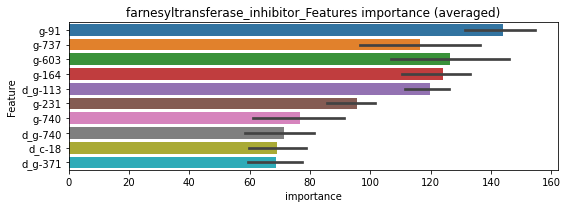

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101845	valid_1's binary_logloss: 0.0175131
[200]	training's binary_logloss: 0.00101749	valid_1's binary_logloss: 0.00763784
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000327374	valid_1's binary_logloss: 0.00696316


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102091	valid_1's binary_logloss: 0.0142562
[200]	training's binary_logloss: 0.0010086	valid_1's binary_logloss: 0.00415997
[300]	training's binary_logloss: 0.000275957	valid_1's binary_logloss: 0.00307149
[400]	training's binary_logloss: 0.000156084	valid_1's binary_logloss: 0.00285615
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000159793	valid_1's binary_logloss: 0.00284888


farnesyltransferase_inhibitor logloss: 0.004906285947414095


neg labels: 3289 → selected neg labels: 3285


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279524	valid_1's binary_logloss: 0.0420874
[200]	training's binary_logloss: 0.00357987	valid_1's binary_logloss: 0.00829458
[300]	training's binary_logloss: 0.0010126	valid_1's binary_logloss: 0.00314377
[400]	training's binary_logloss: 0.000514003	valid_1's binary_logloss: 0.00191701
[500]	training's binary_logloss: 0.000379134	valid_1's binary_logloss: 0.00155312
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000369326	valid_1's binary_logloss: 0.00152899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294552	valid_1's binary_logloss: 0.0404095
[200]	training's binary_logloss: 0.00389037	valid_1's binary_logloss: 0.00739077
[300]	training's binary_logloss: 0.00106208	valid_1's binary_logloss: 0.00258931
[400]	training's binary_logloss: 0.000530818	valid_1's binary_logloss: 0.00149609
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0025198, Threshold: 0.0035633, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00321, conf_1:0.00392
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0035633
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_2: 0.0135633
threshold: 0.0135633, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271344	valid_1's binary_logloss: 0.0388309
[200]	training's binary_logloss: 0.00345593	valid_1's binary_logloss: 0.00748082
[300]	training's binary_logloss: 0.000986889	valid_1's binary_logloss: 0.00267623
[400]	training's binary_logloss: 0.000505215	valid_1's binary_logloss: 0.00154675
[500]	training's binary_logloss: 0.000381424	valid_1's binary_logloss: 0.00127167
[600]	training's binary_logloss: 0.000363817	valid_1's binary_logloss: 0.00123515
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.000363808	valid_1's binary_logloss: 0.00123514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274825	valid_1's binary_logloss: 0.037538
[200]	training's binary_logloss: 0.00350426	valid_1's binary_logloss: 0.00636872
[300]	training's binary_logloss: 0.000991222	valid_1's binary_logloss: 0.00219398
[400]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1847834, Threshold: 0.0135633, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00105
Num_p_label: 31.0, conf_0:0.01221, conf_1:0.01492
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_1: 0.0135633
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_2: 0.0235633
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_3: 0.0335633
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_4: 0.0435633
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_5: 0.0535633
threshold: 0.0535633, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271344	valid_1's binary_logloss: 0.0388309
[200]	training's binary_logloss: 0.00345593	valid_1's binary_logloss: 0.00748082
[300]	training's binary_logloss: 0.000986889	valid_1's binary_logloss: 0.00267623
[400]	training's binary_logloss: 0.000505215	valid_1's binary_logloss: 0.00154675
[500]	training's binary_logloss: 0.000381424	valid_1's binary_logloss: 0.00127167
[600]	training's binary_logloss: 0.000363817	valid_1's binary_logloss: 0.00123515
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.000363808	valid_1's binary_logloss: 0.00123514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274825	valid_1's binary_logloss: 0.037538
[200]	training's binary_logloss: 0.00350426	valid_1's binary_logloss: 0.00636872
[300]	training's binary_logloss: 0.000991222	valid_1's binary_logloss: 0.00219398
[400]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1847834, Threshold: 0.0535633, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105
Num_p_label: 7.0, conf_0:0.04821, conf_1:0.05892
threshold: 0.0535633, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


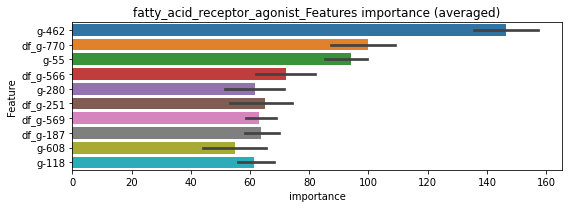

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152439	valid_1's binary_logloss: 0.0270242
[200]	training's binary_logloss: 0.00194727	valid_1's binary_logloss: 0.00952259
[300]	training's binary_logloss: 0.000531767	valid_1's binary_logloss: 0.00718956
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000478983	valid_1's binary_logloss: 0.00712617


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158834	valid_1's binary_logloss: 0.0235681
[200]	training's binary_logloss: 0.00208185	valid_1's binary_logloss: 0.00651119
[300]	training's binary_logloss: 0.000565682	valid_1's binary_logloss: 0.00387782
[400]	training's binary_logloss: 0.000287871	valid_1's binary_logloss: 0.00341439
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000281185	valid_1's binary_logloss: 0.00340396


fatty_acid_receptor_agonist logloss: 0.005265067017585213


neg labels: 3289 → selected neg labels: 3279


fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348918	valid_1's binary_logloss: 0.06952
[200]	training's binary_logloss: 0.00538379	valid_1's binary_logloss: 0.0324266
[300]	training's binary_logloss: 0.00155017	valid_1's binary_logloss: 0.0276015
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00129296	valid_1's binary_logloss: 0.0271384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355558	valid_1's binary_logloss: 0.0637534
[200]	training's binary_logloss: 0.00538454	valid_1's binary_logloss: 0.0255734
[300]	training's binary_logloss: 0.00155894	valid_1's binary_logloss: 0.0161529
[400]	training's binary_logloss: 0.000784507	valid_1's binary_logloss: 0.0136904
[500]	training's binary_logloss: 0.000516807	valid_1's binary_logloss: 0.0123239
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000444421	valid_1's binary_logloss: 0.0118317


1 / 3 AUC score:0.999
y_Threshold: 0.0075176, Threshold: 0.0197390, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00210
Num_p_label: 80.0, conf_0:0.01777, conf_1:0.02171
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0197390
Num_p_label: 60.0, Expected: 8.4, Adj_threshold_2: 0.0297390
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_3: 0.0397390
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_4: 0.0497390
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_5: 0.0597390
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_6: 0.0697390
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_7: 0.0797390
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_8: 0.0897390
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_9: 0.0997390
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_10: 0.1097390
threshold: 0.1197390, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326014	valid_1's binary_logloss: 0.0565476
[200]	training's binary_logloss: 0.00474179	valid_1's binary_logloss: 0.0182171
[300]	training's binary_logloss: 0.00136326	valid_1's binary_logloss: 0.0101009
[400]	training's binary_logloss: 0.000678111	valid_1's binary_logloss: 0.00779492
[500]	training's binary_logloss: 0.000470142	valid_1's binary_logloss: 0.0067118
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000462086	valid_1's binary_logloss: 0.00664985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335472	valid_1's binary_logloss: 0.0553569
[200]	training's binary_logloss: 0.00497647	valid_1's binary_logloss: 0.0179108
[300]	training's binary_logloss: 0.00142695	valid_1's binary_logloss: 0.0093104
[400]	training's binary_logloss: 0.000704851	valid_1's binary_logloss: 0.00667854
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.1170596, Threshold: 0.1197390, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0153189 Vs.target_rate: 0.00210
Num_p_label: 61.0, conf_0:0.10777, conf_1:0.13171
Num_p_label: 61.0, Expected: 8.4, Adj_threshold_1: 0.1197390
Num_p_label: 57.0, Expected: 8.4, Adj_threshold_2: 0.1297390
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_3: 0.1397390
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_4: 0.1497390
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_5: 0.1597390
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_6: 0.1697390
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_7: 0.1797390
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_8: 0.1897390
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_9: 0.1997390
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_10: 0.2097390
threshold: 0.2197390, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329769	valid_1's binary_logloss: 0.0586311
[200]	training's binary_logloss: 0.00475294	valid_1's binary_logloss: 0.02093
[300]	training's binary_logloss: 0.00135343	valid_1's binary_logloss: 0.0140571
[400]	training's binary_logloss: 0.00067421	valid_1's binary_logloss: 0.0120129
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000688088	valid_1's binary_logloss: 0.012002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033502	valid_1's binary_logloss: 0.0560067
[200]	training's binary_logloss: 0.00489872	valid_1's binary_logloss: 0.0182839
[300]	training's binary_logloss: 0.00139797	valid_1's binary_logloss: 0.0106237
[400]	training's binary_logloss: 0.000687947	valid_1's binary_logloss: 0.00837507
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00058318	valid_1's binary_logloss: 0.00796393


3 / 3 AUC score:1.000
y_Threshold: 0.1089099, Threshold: 0.2197390, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0115520 Vs.target_rate: 0.00210
Num_p_label: 46.0, conf_0:0.19777, conf_1:0.24171
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_1: 0.2197390
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_2: 0.2297390
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_3: 0.2397390
Num_p_label: 43.0, Expected: 8.4, Adj_threshold_4: 0.2497390
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_5: 0.2597390
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_6: 0.2697390
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_7: 0.2797390
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_8: 0.2897390
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_9: 0.2997390
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_10: 0.3097390
threshold: 0.3197390, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 683.0/7772, y_label_rate: 0.0878796


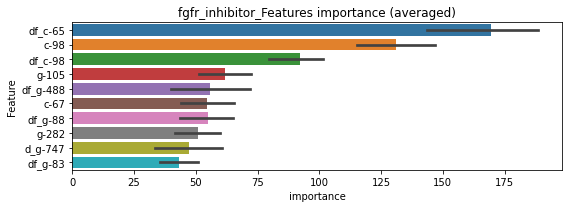

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179905	valid_1's binary_logloss: 0.0381527
[200]	training's binary_logloss: 0.00274264	valid_1's binary_logloss: 0.0196098
[300]	training's binary_logloss: 0.000798614	valid_1's binary_logloss: 0.0161951
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000470356	valid_1's binary_logloss: 0.01543


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177217	valid_1's binary_logloss: 0.0378834
[200]	training's binary_logloss: 0.00255145	valid_1's binary_logloss: 0.020774
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000945522	valid_1's binary_logloss: 0.0188841


fgfr_inhibitor logloss: 0.01715704511131615


neg labels: 3289 → selected neg labels: 3272


flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508576	valid_1's binary_logloss: 0.136864
[200]	training's binary_logloss: 0.0105897	valid_1's binary_logloss: 0.114728
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0101627	valid_1's binary_logloss: 0.11468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486843	valid_1's binary_logloss: 0.144563
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.013983	valid_1's binary_logloss: 0.125481


1 / 3 AUC score:0.971
y_Threshold: 0.0747520, Threshold: 0.2578955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 244 → Positive_corect_labels: 598/3682
p_label_rate: 0.0200904 Vs.target_rate: 0.01172
Num_p_label: 80.0, conf_0:0.23211, conf_1:0.28369
threshold: 0.2578955, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 598.0/3682, y_label_rate: 0.1624117
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367502	valid_1's binary_logloss: 0.0893172
[200]	training's binary_logloss: 0.00635541	valid_1's binary_logloss: 0.0633969
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00430068	valid_1's binary_logloss: 0.06236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383011	valid_1's binary_logloss: 0.0748651
[200]	training's binary_logloss: 0.0071998	valid_1's binary_logloss: 0.0384702
[300]	training's binary_logloss: 0.00265564	valid_1's binary_logloss: 0.0309123
[400]	training's binary_logloss: 0.00160189	valid_1's binary_logloss: 0.0286034
[500]	training's binary_logloss: 0.000936013	valid_1's binary_logloss: 0.0273
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000659082	valid_1's binary_logloss: 0.0269528


2 / 3 AUC score:0.996
y_Threshold: 0.1517374, Threshold: 0.2578955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 577.0/3640
p_label_rate: 0.0394274 Vs.target_rate: 0.01172
Num_p_label: 157.0, conf_0:0.23211, conf_1:0.28369
Num_p_label: 157.0, Expected: 46.7, Adj_threshold_1: 0.2578955
Num_p_label: 153.0, Expected: 46.7, Adj_threshold_2: 0.2678955
Num_p_label: 149.0, Expected: 46.7, Adj_threshold_3: 0.2778955
Num_p_label: 148.0, Expected: 46.7, Adj_threshold_4: 0.2878955
Num_p_label: 143.0, Expected: 46.7, Adj_threshold_5: 0.2978955
Num_p_label: 141.0, Expected: 46.7, Adj_threshold_6: 0.3078955
Num_p_label: 139.0, Expected: 46.7, Adj_threshold_7: 0.3178955
Num_p_label: 137.0, Expected: 46.7, Adj_threshold_8: 0.3278955
Num_p_label: 134.0, Expected: 46.7, Adj_threshold_9: 0.3378955
Num_p_label: 132.0, Expected: 46.7, Adj_threshold_10: 0.3478955
threshold: 0.3578955, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 577.0/3640, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330982	valid_1's binary_logloss: 0.0699318
[200]	training's binary_logloss: 0.00574589	valid_1's binary_logloss: 0.0362809
[300]	training's binary_logloss: 0.00172999	valid_1's binary_logloss: 0.0278797
[400]	training's binary_logloss: 0.000842382	valid_1's binary_logloss: 0.0249011
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000704015	valid_1's binary_logloss: 0.0241128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339891	valid_1's binary_logloss: 0.068433
[200]	training's binary_logloss: 0.0054624	valid_1's binary_logloss: 0.035732
[300]	training's binary_logloss: 0.00169634	valid_1's binary_logloss: 0.0294171
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00116603	valid_1's binary_logloss: 0.0281239


3 / 3 AUC score:0.999
y_Threshold: 0.1314640, Threshold: 0.3578955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 565.0/3616
p_label_rate: 0.0349071 Vs.target_rate: 0.01172
Num_p_label: 139.0, conf_0:0.32211, conf_1:0.39369
threshold: 0.3578955, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 704.0/7598, y_label_rate: 0.0926560


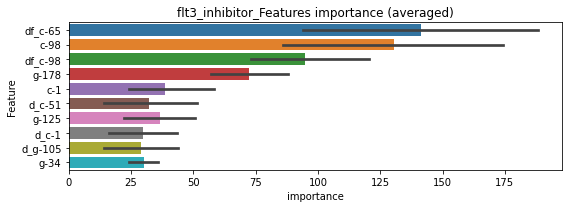

len(train_index) : 3799
len(valid_index) : 3799
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203205	valid_1's binary_logloss: 0.0493511
[200]	training's binary_logloss: 0.00345982	valid_1's binary_logloss: 0.0290817
[300]	training's binary_logloss: 0.00107323	valid_1's binary_logloss: 0.0241989
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000741409	valid_1's binary_logloss: 0.0233081


len(train_index) : 3799
len(valid_index) : 3799
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196623	valid_1's binary_logloss: 0.0490563
[200]	training's binary_logloss: 0.00329701	valid_1's binary_logloss: 0.0294487
[300]	training's binary_logloss: 0.0009982	valid_1's binary_logloss: 0.0257174
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000824456	valid_1's binary_logloss: 0.0254132


flt3_inhibitor logloss: 0.02436066450764111


neg labels: 3289 → selected neg labels: 3286


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179302	valid_1's binary_logloss: 0.0224618
[200]	training's binary_logloss: 0.00171518	valid_1's binary_logloss: 0.0044633
[300]	training's binary_logloss: 0.000458198	valid_1's binary_logloss: 0.00288159
[400]	training's binary_logloss: 0.00026222	valid_1's binary_logloss: 0.00261617
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000231678	valid_1's binary_logloss: 0.00254518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180068	valid_1's binary_logloss: 0.0225141
[200]	training's binary_logloss: 0.00172393	valid_1's binary_logloss: 0.00375104
[300]	training's binary_logloss: 0.000468815	valid_1's binary_logloss: 0.00162249
[400]	training's binary_logloss: 0.000270475	valid_1's binary_logloss: 0.00113125
[500]	training's binary_logloss: 0.000230827	valid_1's binary_logloss: 0.00104475
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0009420, Threshold: 0.0027158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00244, conf_1:0.00299
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027158
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.0127158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.0227158
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.0327158
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.0427158
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.0527158
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.0627158
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_8: 0.0727158
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.0827158
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.0927158
threshold: 0.1027158, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176585	valid_1's binary_logloss: 0.019358
[200]	training's binary_logloss: 0.00161129	valid_1's binary_logloss: 0.0020191
[300]	training's binary_logloss: 0.000417674	valid_1's binary_logloss: 0.000594828
[400]	training's binary_logloss: 0.000243307	valid_1's binary_logloss: 0.000364153
[500]	training's binary_logloss: 0.000213128	valid_1's binary_logloss: 0.000327266
[600]	training's binary_logloss: 0.000211184	valid_1's binary_logloss: 0.000324844
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.000210591	valid_1's binary_logloss: 0.000324227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176237	valid_1's binary_logloss: 0.0217125
[200]	training's binary_logloss: 0.00159024	valid_1's binary_logloss: 0.00284707
[300]	training's binary_logloss: 0.00041277	valid_1's binary_logloss: 0.000897988
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.2148254, Threshold: 0.1027158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00076
Num_p_label: 32.0, conf_0:0.09244, conf_1:0.11299
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.1027158
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.1127158
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.1227158
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_4: 0.1327158
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_5: 0.1427158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.1527158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_7: 0.1627158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_8: 0.1727158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_9: 0.1827158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_10: 0.1927158
threshold: 0.2027158, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176585	valid_1's binary_logloss: 0.019358
[200]	training's binary_logloss: 0.00161129	valid_1's binary_logloss: 0.0020191
[300]	training's binary_logloss: 0.000417674	valid_1's binary_logloss: 0.000594828
[400]	training's binary_logloss: 0.000243307	valid_1's binary_logloss: 0.000364153
[500]	training's binary_logloss: 0.000213128	valid_1's binary_logloss: 0.000327266
[600]	training's binary_logloss: 0.000211184	valid_1's binary_logloss: 0.000324844
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.000210591	valid_1's binary_logloss: 0.000324227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176237	valid_1's binary_logloss: 0.0217125
[200]	training's binary_logloss: 0.00159024	valid_1's binary_logloss: 0.00284707
[300]	training's binary_logloss: 0.00041277	valid_1's binary_logloss: 0.000897988
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.2148254, Threshold: 0.2027158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0060271 Vs.target_rate: 0.00076
Num_p_label: 24.0, conf_0:0.18244, conf_1:0.22299
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.2027158
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.2127158
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_3: 0.2227158
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_4: 0.2327158
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_5: 0.2427158
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_6: 0.2527158
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_7: 0.2627158
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_8: 0.2727158
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_9: 0.2827158
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_10: 0.2927158
threshold: 0.3027158, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 677.0/7793, y_label_rate: 0.0868728


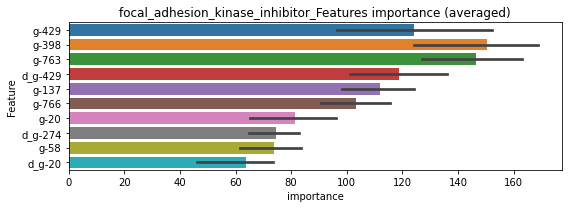

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00996187	valid_1's binary_logloss: 0.0149853
[200]	training's binary_logloss: 0.000928696	valid_1's binary_logloss: 0.00615236
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000354634	valid_1's binary_logloss: 0.00566068


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102653	valid_1's binary_logloss: 0.0135658
[200]	training's binary_logloss: 0.00103253	valid_1's binary_logloss: 0.00370536
[300]	training's binary_logloss: 0.000278754	valid_1's binary_logloss: 0.00297764
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000276458	valid_1's binary_logloss: 0.00297461


focal_adhesion_kinase_inhibitor logloss: 0.004317815605855265


neg labels: 3289 → selected neg labels: 3286


free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224045	valid_1's binary_logloss: 0.0293979
[200]	training's binary_logloss: 0.00258599	valid_1's binary_logloss: 0.00467578
[300]	training's binary_logloss: 0.000744753	valid_1's binary_logloss: 0.00165606
[400]	training's binary_logloss: 0.000399001	valid_1's binary_logloss: 0.00100513
[500]	training's binary_logloss: 0.000318372	valid_1's binary_logloss: 0.00085397
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000311012	valid_1's binary_logloss: 0.000845585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226676	valid_1's binary_logloss: 0.0321027
[200]	training's binary_logloss: 0.00260774	valid_1's binary_logloss: 0.0070246
[300]	training's binary_logloss: 0.000728059	valid_1's binary_logloss: 0.00326094
[400]	training's binary_logloss: 0.000393243	valid_1's binary_logloss: 0.00244392
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0013623, Threshold: 0.0019662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00177, conf_1:0.00216
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019662
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0119662
threshold: 0.0119662, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225888	valid_1's binary_logloss: 0.0295863
[200]	training's binary_logloss: 0.00255628	valid_1's binary_logloss: 0.00472713
[300]	training's binary_logloss: 0.000728586	valid_1's binary_logloss: 0.00163078
[400]	training's binary_logloss: 0.000394164	valid_1's binary_logloss: 0.000980975
[500]	training's binary_logloss: 0.000318514	valid_1's binary_logloss: 0.000846668
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000308602	valid_1's binary_logloss: 0.000830348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229143	valid_1's binary_logloss: 0.0324516
[200]	training's binary_logloss: 0.00260345	valid_1's binary_logloss: 0.00798236
[300]	training's binary_logloss: 0.000735649	valid_1's binary_logloss: 0.00450453
[400]	training's binary_logloss: 0.000400766	valid_1's binary_logloss: 0.00364007
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0200404, Threshold: 0.0119662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.01077, conf_1:0.01316
threshold: 0.0119662, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225888	valid_1's binary_logloss: 0.0295863
[200]	training's binary_logloss: 0.00255628	valid_1's binary_logloss: 0.00472713
[300]	training's binary_logloss: 0.000728586	valid_1's binary_logloss: 0.00163078
[400]	training's binary_logloss: 0.000394164	valid_1's binary_logloss: 0.000980975
[500]	training's binary_logloss: 0.000318514	valid_1's binary_logloss: 0.000846668
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000308602	valid_1's binary_logloss: 0.000830348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229143	valid_1's binary_logloss: 0.0324516
[200]	training's binary_logloss: 0.00260345	valid_1's binary_logloss: 0.00798236
[300]	training's binary_logloss: 0.000735649	valid_1's binary_logloss: 0.00450453
[400]	training's binary_logloss: 0.000400766	valid_1's binary_logloss: 0.00364007
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0200404, Threshold: 0.0119662, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.01077, conf_1:0.01316
threshold: 0.0119662, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


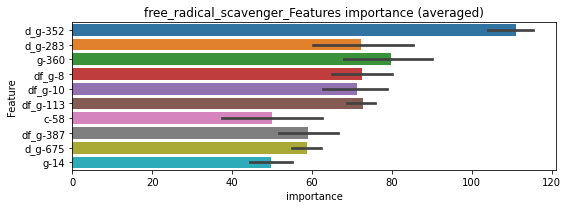

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012147	valid_1's binary_logloss: 0.0213759
[200]	training's binary_logloss: 0.00135467	valid_1's binary_logloss: 0.00821606
[300]	training's binary_logloss: 0.000371638	valid_1's binary_logloss: 0.0069448
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000245784	valid_1's binary_logloss: 0.00682282


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125615	valid_1's binary_logloss: 0.018744
[200]	training's binary_logloss: 0.0014573	valid_1's binary_logloss: 0.00473708
[300]	training's binary_logloss: 0.000395221	valid_1's binary_logloss: 0.0032018
[400]	training's binary_logloss: 0.000205963	valid_1's binary_logloss: 0.00293635
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000205963	valid_1's binary_logloss: 0.00293635


free_radical_scavenger logloss: 0.004879834047946353


neg labels: 3289 → selected neg labels: 3285


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258825	valid_1's binary_logloss: 0.043274
[200]	training's binary_logloss: 0.00327379	valid_1's binary_logloss: 0.0121287
[300]	training's binary_logloss: 0.00090644	valid_1's binary_logloss: 0.00625956
[400]	training's binary_logloss: 0.000468004	valid_1's binary_logloss: 0.00507749
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000456352	valid_1's binary_logloss: 0.00501572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264245	valid_1's binary_logloss: 0.034331
[200]	training's binary_logloss: 0.00324878	valid_1's binary_logloss: 0.0054459
[300]	training's binary_logloss: 0.000909476	valid_1's binary_logloss: 0.00179866
[400]	training's binary_logloss: 0.000473529	valid_1's binary_logloss: 0.0010417
[500]	training's binary_logloss: 0.000352723	valid_1's binary_logloss: 0.000825089
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0017671, Threshold: 0.0026833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00241, conf_1:0.00295
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0026833
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0126833
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_3: 0.0226833
threshold: 0.0226833, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259512	valid_1's binary_logloss: 0.040453
[200]	training's binary_logloss: 0.00311058	valid_1's binary_logloss: 0.00919306
[300]	training's binary_logloss: 0.000881526	valid_1's binary_logloss: 0.00432449
[400]	training's binary_logloss: 0.000463706	valid_1's binary_logloss: 0.00322517
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000373195	valid_1's binary_logloss: 0.00298742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026056	valid_1's binary_logloss: 0.0340381
[200]	training's binary_logloss: 0.00321792	valid_1's binary_logloss: 0.00513507
[300]	training's binary_logloss: 0.00091086	valid_1's binary_logloss: 0.00164871
[400]	training's binary_logloss: 0.000474043	valid_1's binary_logloss: 0.000921409
[500]	training's binary_logloss: 0.000357067	valid_1's binary_logloss: 0.000738106
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0452132, Threshold: 0.0226833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00097
Num_p_label: 8.0, conf_0:0.02041, conf_1:0.02495
threshold: 0.0226833, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259512	valid_1's binary_logloss: 0.040453
[200]	training's binary_logloss: 0.00311058	valid_1's binary_logloss: 0.00919306
[300]	training's binary_logloss: 0.000881526	valid_1's binary_logloss: 0.00432449
[400]	training's binary_logloss: 0.000463706	valid_1's binary_logloss: 0.00322517
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000373195	valid_1's binary_logloss: 0.00298742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026056	valid_1's binary_logloss: 0.0340381
[200]	training's binary_logloss: 0.00321792	valid_1's binary_logloss: 0.00513507
[300]	training's binary_logloss: 0.00091086	valid_1's binary_logloss: 0.00164871
[400]	training's binary_logloss: 0.000474043	valid_1's binary_logloss: 0.000921409
[500]	training's binary_logloss: 0.000357067	valid_1's binary_logloss: 0.000738106
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0452132, Threshold: 0.0226833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00097
Num_p_label: 8.0, conf_0:0.02041, conf_1:0.02495
threshold: 0.0226833, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


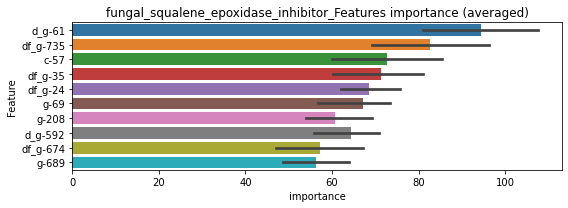

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140267	valid_1's binary_logloss: 0.0267275
[200]	training's binary_logloss: 0.00169933	valid_1's binary_logloss: 0.0111226
[300]	training's binary_logloss: 0.000457499	valid_1's binary_logloss: 0.00897806
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00042193	valid_1's binary_logloss: 0.00894857


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151098	valid_1's binary_logloss: 0.0225328
[200]	training's binary_logloss: 0.00189525	valid_1's binary_logloss: 0.00609722
[300]	training's binary_logloss: 0.000514579	valid_1's binary_logloss: 0.0036703
[400]	training's binary_logloss: 0.00025705	valid_1's binary_logloss: 0.0031768
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000214764	valid_1's binary_logloss: 0.00311407


fungal_squalene_epoxidase_inhibitor logloss: 0.006031317204068925


neg labels: 3289 → selected neg labels: 3272


gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724064	valid_1's binary_logloss: 0.163385
[200]	training's binary_logloss: 0.0183731	valid_1's binary_logloss: 0.107384
[300]	training's binary_logloss: 0.00541916	valid_1's binary_logloss: 0.0929598
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00368308	valid_1's binary_logloss: 0.090489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698086	valid_1's binary_logloss: 0.153595
[200]	training's binary_logloss: 0.016878	valid_1's binary_logloss: 0.0980718
[300]	training's binary_logloss: 0.00509293	valid_1's binary_logloss: 0.0847633
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00437328	valid_1's binary_logloss: 0.0841738


1 / 3 AUC score:0.985
y_Threshold: 0.0230338, Threshold: 0.0321267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 190 → Positive_corect_labels: 625/3736
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.02891, conf_1:0.03534
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0321267
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_2: 0.0421267
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_3: 0.0521267
threshold: 0.0521267, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 625.0/3736, y_label_rate: 0.1672912
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065728	valid_1's binary_logloss: 0.135853
[200]	training's binary_logloss: 0.0147323	valid_1's binary_logloss: 0.0769714
[300]	training's binary_logloss: 0.00445269	valid_1's binary_logloss: 0.0621732
[400]	training's binary_logloss: 0.00198607	valid_1's binary_logloss: 0.0567129
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00141462	valid_1's binary_logloss: 0.0551322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064207	valid_1's binary_logloss: 0.143488
[200]	training's binary_logloss: 0.014798	valid_1's binary_logloss: 0.0908763
[300]	training's binary_logloss: 0.0044617	valid_1's binary_logloss: 0.0780507
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00338223	valid_1's binary_logloss: 0.076738


2 / 3 AUC score:0.996
y_Threshold: 0.0455833, Threshold: 0.0521267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 601.0/3688
p_label_rate: 0.0085384 Vs.target_rate: 0.00445
Num_p_label: 34.0, conf_0:0.04691, conf_1:0.05734
threshold: 0.0521267, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06447	valid_1's binary_logloss: 0.14531
[200]	training's binary_logloss: 0.0139766	valid_1's binary_logloss: 0.0903416
[300]	training's binary_logloss: 0.00402478	valid_1's binary_logloss: 0.0755219
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00288467	valid_1's binary_logloss: 0.0744428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603097	valid_1's binary_logloss: 0.13821
[200]	training's binary_logloss: 0.0129821	valid_1's binary_logloss: 0.0816154
[300]	training's binary_logloss: 0.00391333	valid_1's binary_logloss: 0.0669506
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00285302	valid_1's binary_logloss: 0.0658412


3 / 3 AUC score:0.992
y_Threshold: 0.0442153, Threshold: 0.0521267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 580.0/3646
p_label_rate: 0.0097941 Vs.target_rate: 0.00445
Num_p_label: 39.0, conf_0:0.04691, conf_1:0.05734
threshold: 0.0521267, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 619.0/7628, y_label_rate: 0.0811484


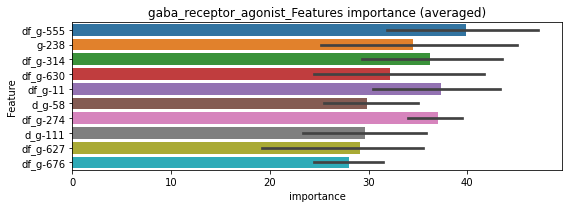

len(train_index) : 3814
len(valid_index) : 3814
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344632	valid_1's binary_logloss: 0.0861514
[200]	training's binary_logloss: 0.00811091	valid_1's binary_logloss: 0.0607552
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00279258	valid_1's binary_logloss: 0.0556992


len(train_index) : 3814
len(valid_index) : 3814
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337846	valid_1's binary_logloss: 0.0894388
[200]	training's binary_logloss: 0.0078134	valid_1's binary_logloss: 0.0595556
[300]	training's binary_logloss: 0.00218516	valid_1's binary_logloss: 0.0546546
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0018827	valid_1's binary_logloss: 0.0541993


gaba_receptor_agonist logloss: 0.054949270577237204


neg labels: 3289 → selected neg labels: 3263


gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864328	valid_1's binary_logloss: 0.230147
[200]	training's binary_logloss: 0.0263585	valid_1's binary_logloss: 0.194177
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0147391	valid_1's binary_logloss: 0.188911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919709	valid_1's binary_logloss: 0.210297
[200]	training's binary_logloss: 0.0291168	valid_1's binary_logloss: 0.156936
[300]	training's binary_logloss: 0.00983613	valid_1's binary_logloss: 0.143658
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00598328	valid_1's binary_logloss: 0.141322


1 / 3 AUC score:0.953
y_Threshold: 0.0525113, Threshold: 0.0683877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 297 → Positive_corect_labels: 569/3618
p_label_rate: 0.0200904 Vs.target_rate: 0.00693
Num_p_label: 80.0, conf_0:0.06155, conf_1:0.07523
threshold: 0.0683877, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 569.0/3618, y_label_rate: 0.1572692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750028	valid_1's binary_logloss: 0.173881
[200]	training's binary_logloss: 0.0193519	valid_1's binary_logloss: 0.119817
[300]	training's binary_logloss: 0.00627918	valid_1's binary_logloss: 0.103143
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00351094	valid_1's binary_logloss: 0.0992065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772678	valid_1's binary_logloss: 0.177946
[200]	training's binary_logloss: 0.020983	valid_1's binary_logloss: 0.119896
[300]	training's binary_logloss: 0.00655651	valid_1's binary_logloss: 0.106359
[400]	training's binary_logloss: 0.00282209	valid_1's binary_logloss: 0.102283
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00290142	valid_1's binary_logloss: 0.10218


2 / 3 AUC score:0.987
y_Threshold: 0.0631744, Threshold: 0.0683877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 528.0/3536
p_label_rate: 0.0120542 Vs.target_rate: 0.00693
Num_p_label: 48.0, conf_0:0.06155, conf_1:0.07523
threshold: 0.0683877, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 528.0/3536, y_label_rate: 0.1493213
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632589	valid_1's binary_logloss: 0.17488
[200]	training's binary_logloss: 0.0153184	valid_1's binary_logloss: 0.12738
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00808774	valid_1's binary_logloss: 0.120437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685168	valid_1's binary_logloss: 0.153828
[200]	training's binary_logloss: 0.0175779	valid_1's binary_logloss: 0.101355
[300]	training's binary_logloss: 0.00554593	valid_1's binary_logloss: 0.0883332
[400]	training's binary_logloss: 0.00243465	valid_1's binary_logloss: 0.0844524
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00260619	valid_1's binary_logloss: 0.0842904


3 / 3 AUC score:0.986
y_Threshold: 0.0675397, Threshold: 0.0683877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 76 → Positive_corect_labels: 490.0/3460
p_label_rate: 0.0195881 Vs.target_rate: 0.00693
Num_p_label: 78.0, conf_0:0.06155, conf_1:0.07523
threshold: 0.0683877, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 568.0/7442, y_label_rate: 0.0763236


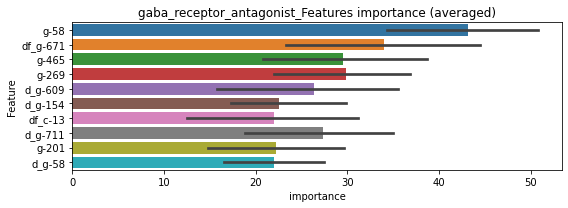

len(train_index) : 3721
len(valid_index) : 3721
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040006	valid_1's binary_logloss: 0.10622
[200]	training's binary_logloss: 0.0105705	valid_1's binary_logloss: 0.0802669
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00594894	valid_1's binary_logloss: 0.0775926


len(train_index) : 3721
len(valid_index) : 3721
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379233	valid_1's binary_logloss: 0.119633
[200]	training's binary_logloss: 0.00949753	valid_1's binary_logloss: 0.0985388
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0082864	valid_1's binary_logloss: 0.0981177


gaba_receptor_antagonist logloss: 0.08785516270700877


neg labels: 3289 → selected neg labels: 3279


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319784	valid_1's binary_logloss: 0.0653198
[200]	training's binary_logloss: 0.00480729	valid_1's binary_logloss: 0.031412
[300]	training's binary_logloss: 0.00142581	valid_1's binary_logloss: 0.0256032
[400]	training's binary_logloss: 0.000716149	valid_1's binary_logloss: 0.0234993
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000572235	valid_1's binary_logloss: 0.0231096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313126	valid_1's binary_logloss: 0.0607627
[200]	training's binary_logloss: 0.00464643	valid_1's binary_logloss: 0.0244707
[300]	training's binary_logloss: 0.00138073	valid_1's binary_logloss: 0.0165516
[400]	training's binary_logloss: 0.000694102	valid_1's binary_logloss: 0.0142656
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000679043	valid_1's binary_logloss: 0.0141914


1 / 3 AUC score:0.998
y_Threshold: 0.0049813, Threshold: 0.0070357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.00633, conf_1:0.00774
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0070357
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_2: 0.0170357
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_3: 0.0270357
threshold: 0.0270357, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309595	valid_1's binary_logloss: 0.0603722
[200]	training's binary_logloss: 0.00450508	valid_1's binary_logloss: 0.0213658
[300]	training's binary_logloss: 0.00131077	valid_1's binary_logloss: 0.0128884
[400]	training's binary_logloss: 0.000662452	valid_1's binary_logloss: 0.0105557
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000552261	valid_1's binary_logloss: 0.0100676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315163	valid_1's binary_logloss: 0.0554895
[200]	training's binary_logloss: 0.00462712	valid_1's binary_logloss: 0.0207784
[300]	training's binary_logloss: 0.0013263	valid_1's binary_logloss: 0.0140611
[400]	training's binary_logloss: 0.000667644	valid_1's binary_logloss: 0.0115213
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.0005365	valid_1's binary_logloss: 0.0110633


2 / 3 AUC score:1.000
y_Threshold: 0.0838965, Threshold: 0.0270357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0115520 Vs.target_rate: 0.00235
Num_p_label: 46.0, conf_0:0.02433, conf_1:0.02974
Num_p_label: 46.0, Expected: 9.4, Adj_threshold_1: 0.0270357
Num_p_label: 33.0, Expected: 9.4, Adj_threshold_2: 0.0370357
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_3: 0.0470357
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.0570357
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_5: 0.0670357
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_6: 0.0770357
threshold: 0.0770357, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302105	valid_1's binary_logloss: 0.0647309
[200]	training's binary_logloss: 0.00422412	valid_1's binary_logloss: 0.0303647
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00147272	valid_1's binary_logloss: 0.0250157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308699	valid_1's binary_logloss: 0.0604434
[200]	training's binary_logloss: 0.00452381	valid_1's binary_logloss: 0.0278144
[300]	training's binary_logloss: 0.00132815	valid_1's binary_logloss: 0.0217177
[400]	training's binary_logloss: 0.000668352	valid_1's binary_logloss: 0.0196322
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000636881	valid_1's binary_logloss: 0.019552


3 / 3 AUC score:0.999
y_Threshold: 0.0389258, Threshold: 0.0770357, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0040181 Vs.target_rate: 0.00235
Num_p_label: 16.0, conf_0:0.06933, conf_1:0.08474
threshold: 0.0770357, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 660.0/7762, y_label_rate: 0.0850296


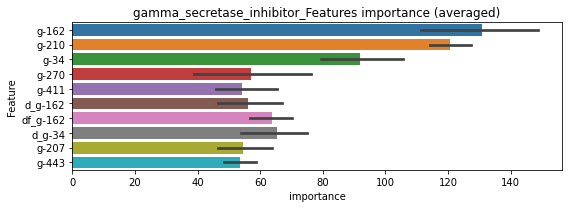

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156622	valid_1's binary_logloss: 0.0391095
[200]	training's binary_logloss: 0.00220988	valid_1's binary_logloss: 0.0207895
[300]	training's binary_logloss: 0.00064402	valid_1's binary_logloss: 0.0176432
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000403588	valid_1's binary_logloss: 0.0170287


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159688	valid_1's binary_logloss: 0.0372325
[200]	training's binary_logloss: 0.00226797	valid_1's binary_logloss: 0.020794
[300]	training's binary_logloss: 0.000668132	valid_1's binary_logloss: 0.018062
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000662075	valid_1's binary_logloss: 0.0180285


gamma_secretase_inhibitor logloss: 0.017528598491652864


neg labels: 3289 → selected neg labels: 3253


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302226	valid_1's binary_logloss: 0.06955
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00620778	valid_1's binary_logloss: 0.0538782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315505	valid_1's binary_logloss: 0.0625563
[200]	training's binary_logloss: 0.00503116	valid_1's binary_logloss: 0.0413804
[300]	training's binary_logloss: 0.0015035	valid_1's binary_logloss: 0.0380519
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00156106	valid_1's binary_logloss: 0.0378806


1 / 3 AUC score:0.993
y_Threshold: 0.0114184, Threshold: 0.0285629, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 641/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01117
Num_p_label: 80.0, conf_0:0.02571, conf_1:0.03142
threshold: 0.0285629, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 641.0/3754, y_label_rate: 0.1707512
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026552	valid_1's binary_logloss: 0.0465463
[200]	training's binary_logloss: 0.00333591	valid_1's binary_logloss: 0.026514
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00169229	valid_1's binary_logloss: 0.0254482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256202	valid_1's binary_logloss: 0.0467283
[200]	training's binary_logloss: 0.00323425	valid_1's binary_logloss: 0.0261069
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00214055	valid_1's binary_logloss: 0.0251463


2 / 3 AUC score:0.998
y_Threshold: 0.0291531, Threshold: 0.0285629, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 630.0/3732
p_label_rate: 0.0276243 Vs.target_rate: 0.01117
Num_p_label: 110.0, conf_0:0.02571, conf_1:0.03142
threshold: 0.0285629, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 630.0/3732, y_label_rate: 0.1688103
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244893	valid_1's binary_logloss: 0.0380559
[200]	training's binary_logloss: 0.00298265	valid_1's binary_logloss: 0.0170007
[300]	training's binary_logloss: 0.000820419	valid_1's binary_logloss: 0.0138182
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000714697	valid_1's binary_logloss: 0.0136185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227478	valid_1's binary_logloss: 0.0430862
[200]	training's binary_logloss: 0.00274918	valid_1's binary_logloss: 0.0254224
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00129004	valid_1's binary_logloss: 0.0235486


3 / 3 AUC score:0.997
y_Threshold: 0.0225571, Threshold: 0.0285629, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 625.0/3722
p_label_rate: 0.0268709 Vs.target_rate: 0.01117
Num_p_label: 107.0, conf_0:0.02571, conf_1:0.03142
threshold: 0.0285629, positive_p_label: 107.0/3982, p_label_rate: 0.0268709
positive_y_label: 732.0/7704, y_label_rate: 0.0950156


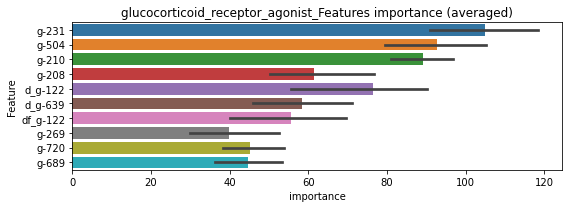

len(train_index) : 3852
len(valid_index) : 3852
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156003	valid_1's binary_logloss: 0.0367762
[200]	training's binary_logloss: 0.00208136	valid_1's binary_logloss: 0.0257936
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00141737	valid_1's binary_logloss: 0.0254618


len(train_index) : 3852
len(valid_index) : 3852
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150213	valid_1's binary_logloss: 0.0418701
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00306322	valid_1's binary_logloss: 0.034713


glucocorticoid_receptor_agonist logloss: 0.03008740625242595


neg labels: 3289 → selected neg labels: 3287


glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187794	valid_1's binary_logloss: 0.0247601
[200]	training's binary_logloss: 0.00193543	valid_1's binary_logloss: 0.00450594
[300]	training's binary_logloss: 0.000542165	valid_1's binary_logloss: 0.00189504
[400]	training's binary_logloss: 0.000305247	valid_1's binary_logloss: 0.00127556
[500]	training's binary_logloss: 0.000262544	valid_1's binary_logloss: 0.00117848
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000259021	valid_1's binary_logloss: 0.00116638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191437	valid_1's binary_logloss: 0.0233923
[200]	training's binary_logloss: 0.00199149	valid_1's binary_logloss: 0.00325378
[300]	training's binary_logloss: 0.000555902	valid_1's binary_logloss: 0.00107521
[400]	training's binary_logloss: 0.00031022	valid_1's binary_logloss: 0.000632685
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0010086, Threshold: 0.0016708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055
Num_p_label: 80.0, conf_0:0.00150, conf_1:0.00184
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0016708
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.0116708
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.0216708
threshold: 0.0216708, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192525	valid_1's binary_logloss: 0.025145
[200]	training's binary_logloss: 0.0019241	valid_1's binary_logloss: 0.00415871
[300]	training's binary_logloss: 0.000536003	valid_1's binary_logloss: 0.0017598
[400]	training's binary_logloss: 0.000304378	valid_1's binary_logloss: 0.001248
[500]	training's binary_logloss: 0.000264879	valid_1's binary_logloss: 0.00117187
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000264879	valid_1's binary_logloss: 0.00117187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191762	valid_1's binary_logloss: 0.0233366
[200]	training's binary_logloss: 0.00192737	valid_1's binary_logloss: 0.00298402
[300]	training's binary_logloss: 0.000544747	valid_1's binary_logloss: 0.000963738
[400]	training's binary_logloss: 0.000306426	valid_1's binary_logloss: 0.000574606
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1104944, Threshold: 0.0216708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00055
Num_p_label: 14.0, conf_0:0.01950, conf_1:0.02384
Num_p_label: 14.0, Expected: 2.2, Adj_threshold_1: 0.0216708
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_2: 0.0316708
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_3: 0.0416708
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_4: 0.0516708
threshold: 0.0516708, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192525	valid_1's binary_logloss: 0.025145
[200]	training's binary_logloss: 0.0019241	valid_1's binary_logloss: 0.00415871
[300]	training's binary_logloss: 0.000536003	valid_1's binary_logloss: 0.0017598
[400]	training's binary_logloss: 0.000304378	valid_1's binary_logloss: 0.001248
[500]	training's binary_logloss: 0.000264879	valid_1's binary_logloss: 0.00117187
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000264879	valid_1's binary_logloss: 0.00117187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191762	valid_1's binary_logloss: 0.0233366
[200]	training's binary_logloss: 0.00192737	valid_1's binary_logloss: 0.00298402
[300]	training's binary_logloss: 0.000544747	valid_1's binary_logloss: 0.000963738
[400]	training's binary_logloss: 0.000306426	valid_1's binary_logloss: 0.000574606
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1104944, Threshold: 0.0516708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00055
Num_p_label: 3.0, conf_0:0.04650, conf_1:0.05684
threshold: 0.0516708, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


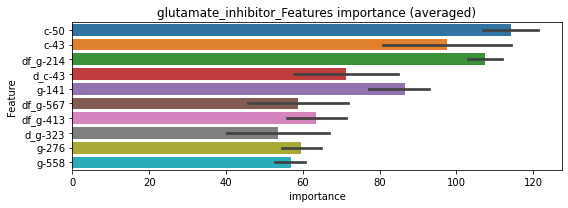

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100783	valid_1's binary_logloss: 0.0132708
[200]	training's binary_logloss: 0.00098939	valid_1's binary_logloss: 0.00336459
[300]	training's binary_logloss: 0.000276668	valid_1's binary_logloss: 0.00280651
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000288719	valid_1's binary_logloss: 0.00280057


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103221	valid_1's binary_logloss: 0.0130709
[200]	training's binary_logloss: 0.00102082	valid_1's binary_logloss: 0.00279734
[300]	training's binary_logloss: 0.000280376	valid_1's binary_logloss: 0.00195913
[400]	training's binary_logloss: 0.000156743	valid_1's binary_logloss: 0.00186059
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000139598	valid_1's binary_logloss: 0.00184592


glutamate_inhibitor logloss: 0.002323246515880065


neg labels: 3289 → selected neg labels: 3277


glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577275	valid_1's binary_logloss: 0.127793
[200]	training's binary_logloss: 0.0128798	valid_1's binary_logloss: 0.0753165
[300]	training's binary_logloss: 0.00365922	valid_1's binary_logloss: 0.0582695
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00176506	valid_1's binary_logloss: 0.0534276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619173	valid_1's binary_logloss: 0.119967
[200]	training's binary_logloss: 0.0138589	valid_1's binary_logloss: 0.0630732
[300]	training's binary_logloss: 0.00388039	valid_1's binary_logloss: 0.0475115
[400]	training's binary_logloss: 0.00166912	valid_1's binary_logloss: 0.0439798
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00161361	valid_1's binary_logloss: 0.0438601


1 / 3 AUC score:0.997
y_Threshold: 0.0169962, Threshold: 0.0229501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 643/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.02066, conf_1:0.02525
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0229501
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_2: 0.0329501
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_3: 0.0429501
threshold: 0.0429501, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 643.0/3776, y_label_rate: 0.1702860
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573002	valid_1's binary_logloss: 0.116005
[200]	training's binary_logloss: 0.0119216	valid_1's binary_logloss: 0.0595088
[300]	training's binary_logloss: 0.00337156	valid_1's binary_logloss: 0.0448794
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00172311	valid_1's binary_logloss: 0.040308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594477	valid_1's binary_logloss: 0.118971
[200]	training's binary_logloss: 0.0130229	valid_1's binary_logloss: 0.0638025
[300]	training's binary_logloss: 0.00371221	valid_1's binary_logloss: 0.0497123
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00180328	valid_1's binary_logloss: 0.0464777


2 / 3 AUC score:0.997
y_Threshold: 0.0470610, Threshold: 0.0429501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0123054 Vs.target_rate: 0.00311
Num_p_label: 49.0, conf_0:0.03866, conf_1:0.04725
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_1: 0.0429501
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_2: 0.0529501
Num_p_label: 25.0, Expected: 12.4, Adj_threshold_3: 0.0629501
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_4: 0.0729501
threshold: 0.0729501, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 628.0/3746, y_label_rate: 0.1676455
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567527	valid_1's binary_logloss: 0.11388
[200]	training's binary_logloss: 0.0117688	valid_1's binary_logloss: 0.0619988
[300]	training's binary_logloss: 0.00337995	valid_1's binary_logloss: 0.0489747
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00190986	valid_1's binary_logloss: 0.0460885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555833	valid_1's binary_logloss: 0.113524
[200]	training's binary_logloss: 0.0115903	valid_1's binary_logloss: 0.0588997
[300]	training's binary_logloss: 0.00332758	valid_1's binary_logloss: 0.0448642
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00248243	valid_1's binary_logloss: 0.0430871


3 / 3 AUC score:0.995
y_Threshold: 0.0480674, Threshold: 0.0729501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 612.0/3714
p_label_rate: 0.0055249 Vs.target_rate: 0.00311
Num_p_label: 22.0, conf_0:0.06566, conf_1:0.08025
threshold: 0.0729501, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 634.0/7696, y_label_rate: 0.0823805


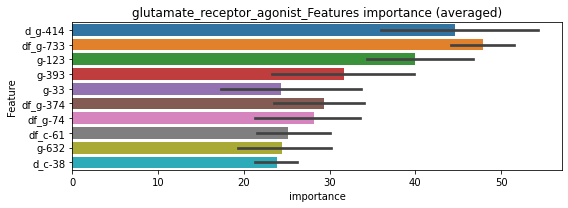

len(train_index) : 3848
len(valid_index) : 3848
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325578	valid_1's binary_logloss: 0.0745957
[200]	training's binary_logloss: 0.00683359	valid_1's binary_logloss: 0.0472432
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00333497	valid_1's binary_logloss: 0.0422406


len(train_index) : 3848
len(valid_index) : 3848
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316295	valid_1's binary_logloss: 0.0770416
[200]	training's binary_logloss: 0.00688377	valid_1's binary_logloss: 0.0520783
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00327098	valid_1's binary_logloss: 0.0488428


glutamate_receptor_agonist logloss: 0.045541714030435027


neg labels: 3289 → selected neg labels: 3226


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126124	valid_1's binary_logloss: 0.357731
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0682817	valid_1's binary_logloss: 0.347927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12655	valid_1's binary_logloss: 0.347751
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0589733	valid_1's binary_logloss: 0.3282


1 / 3 AUC score:0.789
y_Threshold: 0.1316347, Threshold: 0.1782214, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 662 → Positive_corect_labels: 379/3209
p_label_rate: 0.0200904 Vs.target_rate: 0.01541
Num_p_label: 80.0, conf_0:0.16040, conf_1:0.19604
threshold: 0.1782214, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 379.0/3209, y_label_rate: 0.1181053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649723	valid_1's binary_logloss: 0.227805
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0270699	valid_1's binary_logloss: 0.216283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672907	valid_1's binary_logloss: 0.225861
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0235482	valid_1's binary_logloss: 0.212055


2 / 3 AUC score:0.922
y_Threshold: 0.0946893, Threshold: 0.1782214, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 224 → Positive_corect_labels: 267.0/2985
p_label_rate: 0.0075339 Vs.target_rate: 0.01541
Num_p_label: 30.0, conf_0:0.16040, conf_1:0.19604
threshold: 0.1782214, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 267.0/2985, y_label_rate: 0.0894472
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424274	valid_1's binary_logloss: 0.155559
[200]	training's binary_logloss: 0.0110897	valid_1's binary_logloss: 0.141187
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0118414	valid_1's binary_logloss: 0.140976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384419	valid_1's binary_logloss: 0.160372
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.018172	valid_1's binary_logloss: 0.147831


3 / 3 AUC score:0.942
y_Threshold: 0.0664848, Threshold: 0.1782214, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 120 → Positive_corect_labels: 207.0/2865
p_label_rate: 0.0027624 Vs.target_rate: 0.01541
Num_p_label: 11.0, conf_0:0.16040, conf_1:0.19604
Num_p_label: 11.0, Expected: 61.4, Adj_threshold_1: 0.1782214
Num_p_label: 13.0, Expected: 61.4, Adj_threshold_2: 0.1682214
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_3: 0.1582214
Num_p_label: 23.0, Expected: 61.4, Adj_threshold_4: 0.1482214
Num_p_label: 30.0, Expected: 61.4, Adj_threshold_5: 0.1382214
Num_p_label: 35.0, Expected: 61.4, Adj_threshold_6: 0.1282214
threshold: 0.1282214, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 242.0/6847, y_label_rate: 0.0353439


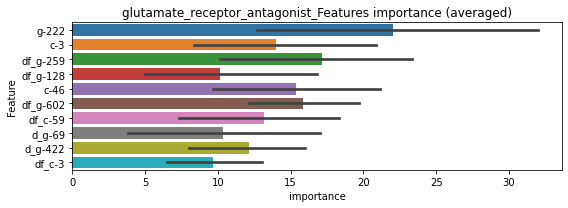

len(train_index) : 3423
len(valid_index) : 3424
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155693	valid_1's binary_logloss: 0.0794322
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00702258	valid_1's binary_logloss: 0.0749539


len(train_index) : 3424
len(valid_index) : 3423
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162031	valid_1's binary_logloss: 0.0744844
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00606178	valid_1's binary_logloss: 0.0679333


glutamate_receptor_antagonist logloss: 0.07144408076478137


neg labels: 3289 → selected neg labels: 3286


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221898	valid_1's binary_logloss: 0.029291
[200]	training's binary_logloss: 0.00253735	valid_1's binary_logloss: 0.00479002
[300]	training's binary_logloss: 0.000725787	valid_1's binary_logloss: 0.00173963
[400]	training's binary_logloss: 0.000389023	valid_1's binary_logloss: 0.00102967
[500]	training's binary_logloss: 0.000314797	valid_1's binary_logloss: 0.000872822
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000313398	valid_1's binary_logloss: 0.000870142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226223	valid_1's binary_logloss: 0.0281672
[200]	training's binary_logloss: 0.00260441	valid_1's binary_logloss: 0.00442713
[300]	training's binary_logloss: 0.000736503	valid_1's binary_logloss: 0.00164464
[400]	training's binary_logloss: 0.000395757	valid_1's binary_logloss: 0.00102951
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0015330, Threshold: 0.0028859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00260, conf_1:0.00317
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028859
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0128859
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0228859
threshold: 0.0228859, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218764	valid_1's binary_logloss: 0.0296084
[200]	training's binary_logloss: 0.00242955	valid_1's binary_logloss: 0.00505399
[300]	training's binary_logloss: 0.00069747	valid_1's binary_logloss: 0.00200544
[400]	training's binary_logloss: 0.000381761	valid_1's binary_logloss: 0.00128447
[500]	training's binary_logloss: 0.000313695	valid_1's binary_logloss: 0.00112973
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000307328	valid_1's binary_logloss: 0.00111986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225061	valid_1's binary_logloss: 0.0274981
[200]	training's binary_logloss: 0.00250675	valid_1's binary_logloss: 0.00391357
[300]	training's binary_logloss: 0.000715127	valid_1's binary_logloss: 0.00134425
[400]	training's binary_logloss: 0.00038981	valid_1's binary_logloss: 0.000833934
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1060383, Threshold: 0.0228859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076
Num_p_label: 11.0, conf_0:0.02060, conf_1:0.02517
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0228859
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0328859
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0428859
threshold: 0.0428859, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218764	valid_1's binary_logloss: 0.0296084
[200]	training's binary_logloss: 0.00242955	valid_1's binary_logloss: 0.00505399
[300]	training's binary_logloss: 0.00069747	valid_1's binary_logloss: 0.00200544
[400]	training's binary_logloss: 0.000381761	valid_1's binary_logloss: 0.00128447
[500]	training's binary_logloss: 0.000313695	valid_1's binary_logloss: 0.00112973
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000307328	valid_1's binary_logloss: 0.00111986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225061	valid_1's binary_logloss: 0.0274981
[200]	training's binary_logloss: 0.00250675	valid_1's binary_logloss: 0.00391357
[300]	training's binary_logloss: 0.000715127	valid_1's binary_logloss: 0.00134425
[400]	training's binary_logloss: 0.00038981	valid_1's binary_logloss: 0.000833934
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1060383, Threshold: 0.0428859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.03860, conf_1:0.04717
threshold: 0.0428859, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118643	valid_1's binary_logloss: 0.0192087
[200]	training's binary_logloss: 0.00132487	valid_1's binary_logloss: 0.006435
[300]	training's binary_logloss: 0.000367844	valid_1's binary_logloss: 0.00518997
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000286169	valid_1's binary_logloss: 0.00513311


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123198	valid_1's binary_logloss: 0.0161532
[200]	training's binary_logloss: 0.00141915	valid_1's binary_logloss: 0.00330346
[300]	training's binary_logloss: 0.000393916	valid_1's binary_logloss: 0.00190809
[400]	training's binary_logloss: 0.000207769	valid_1's binary_logloss: 0.00167856
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000191733	valid_1's binary_logloss: 0.00165346


gonadotropin_receptor_agonist logloss: 0.00339350934232688


neg labels: 3289 → selected neg labels: 3279


gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325124	valid_1's binary_logloss: 0.066715
[200]	training's binary_logloss: 0.00485931	valid_1's binary_logloss: 0.0298299
[300]	training's binary_logloss: 0.00141614	valid_1's binary_logloss: 0.021382
[400]	training's binary_logloss: 0.000697251	valid_1's binary_logloss: 0.0186826
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000565504	valid_1's binary_logloss: 0.0179584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321894	valid_1's binary_logloss: 0.0639647
[200]	training's binary_logloss: 0.0047798	valid_1's binary_logloss: 0.0256234
[300]	training's binary_logloss: 0.00139498	valid_1's binary_logloss: 0.0190294
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000743766	valid_1's binary_logloss: 0.0170855


1 / 3 AUC score:1.000
y_Threshold: 0.0039732, Threshold: 0.0055053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00495, conf_1:0.00606
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0055053
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_2: 0.0155053
threshold: 0.0155053, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330276	valid_1's binary_logloss: 0.0586339
[200]	training's binary_logloss: 0.00485113	valid_1's binary_logloss: 0.017066
[300]	training's binary_logloss: 0.00141022	valid_1's binary_logloss: 0.00824092
[400]	training's binary_logloss: 0.000689016	valid_1's binary_logloss: 0.00568559
[500]	training's binary_logloss: 0.000469215	valid_1's binary_logloss: 0.00472733
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00043364	valid_1's binary_logloss: 0.00451021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329746	valid_1's binary_logloss: 0.0657868
[200]	training's binary_logloss: 0.00473329	valid_1's binary_logloss: 0.0268521
[300]	training's binary_logloss: 0.00134847	valid_1's binary_logloss: 0.0203327
[400]	training's binary_logloss: 0.000668066	valid_1's binary_logloss: 0.0180852
Early stopping, best iteration is:
[403

2 / 3 AUC score:1.000
y_Threshold: 0.0172914, Threshold: 0.0155053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0087896 Vs.target_rate: 0.00252
Num_p_label: 35.0, conf_0:0.01395, conf_1:0.01706
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_1: 0.0155053
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_2: 0.0255053
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_3: 0.0355053
threshold: 0.0355053, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320368	valid_1's binary_logloss: 0.0588889
[200]	training's binary_logloss: 0.00472486	valid_1's binary_logloss: 0.0230198
[300]	training's binary_logloss: 0.00136983	valid_1's binary_logloss: 0.0151808
[400]	training's binary_logloss: 0.000680791	valid_1's binary_logloss: 0.0120746
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000491614	valid_1's binary_logloss: 0.0110621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323963	valid_1's binary_logloss: 0.0702738
[200]	training's binary_logloss: 0.00458705	valid_1's binary_logloss: 0.0286701
[300]	training's binary_logloss: 0.00132699	valid_1's binary_logloss: 0.0214725
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00131418	valid_1's binary_logloss: 0.0214668


3 / 3 AUC score:1.000
y_Threshold: 0.0266339, Threshold: 0.0355053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0045203 Vs.target_rate: 0.00252
Num_p_label: 18.0, conf_0:0.03195, conf_1:0.03906
threshold: 0.0355053, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 669.0/7776, y_label_rate: 0.0860340


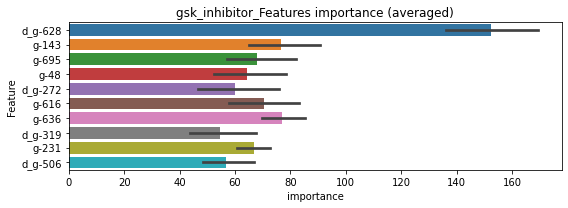

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168154	valid_1's binary_logloss: 0.0429055
[200]	training's binary_logloss: 0.00232508	valid_1's binary_logloss: 0.0274541
[300]	training's binary_logloss: 0.000673365	valid_1's binary_logloss: 0.02531
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000545639	valid_1's binary_logloss: 0.0249045


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170373	valid_1's binary_logloss: 0.0390986
[200]	training's binary_logloss: 0.00247679	valid_1's binary_logloss: 0.0204694
[300]	training's binary_logloss: 0.000724024	valid_1's binary_logloss: 0.0174592
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000446259	valid_1's binary_logloss: 0.0169538


gsk_inhibitor logloss: 0.020929154521067854


neg labels: 3289 → selected neg labels: 3277


hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055929	valid_1's binary_logloss: 0.120129
[200]	training's binary_logloss: 0.0121427	valid_1's binary_logloss: 0.0683406
[300]	training's binary_logloss: 0.00346837	valid_1's binary_logloss: 0.053715
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00194805	valid_1's binary_logloss: 0.0496218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564272	valid_1's binary_logloss: 0.113243
[200]	training's binary_logloss: 0.0121221	valid_1's binary_logloss: 0.063878
[300]	training's binary_logloss: 0.00345297	valid_1's binary_logloss: 0.0513424
[400]	training's binary_logloss: 0.00155668	valid_1's binary_logloss: 0.0477144
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00143081	valid_1's binary_logloss: 0.04754


1 / 3 AUC score:0.993
y_Threshold: 0.0129851, Threshold: 0.0147055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01323, conf_1:0.01618
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0147055
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_2: 0.0247055
threshold: 0.0247055, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531905	valid_1's binary_logloss: 0.114388
[200]	training's binary_logloss: 0.0107885	valid_1's binary_logloss: 0.0686387
[300]	training's binary_logloss: 0.00307583	valid_1's binary_logloss: 0.0577962
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00156693	valid_1's binary_logloss: 0.0549061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521339	valid_1's binary_logloss: 0.103818
[200]	training's binary_logloss: 0.0107733	valid_1's binary_logloss: 0.0547257
[300]	training's binary_logloss: 0.00313043	valid_1's binary_logloss: 0.0433753
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00181823	valid_1's binary_logloss: 0.0415933


2 / 3 AUC score:0.995
y_Threshold: 0.0414702, Threshold: 0.0247055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 629.0/3748
p_label_rate: 0.0195881 Vs.target_rate: 0.00302
Num_p_label: 78.0, conf_0:0.02223, conf_1:0.02718
Num_p_label: 78.0, Expected: 12.0, Adj_threshold_1: 0.0247055
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_2: 0.0347055
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_3: 0.0447055
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_4: 0.0547055
threshold: 0.0547055, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 629.0/3748, y_label_rate: 0.1678228
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523583	valid_1's binary_logloss: 0.0929331
[200]	training's binary_logloss: 0.0105159	valid_1's binary_logloss: 0.0457248
[300]	training's binary_logloss: 0.00300322	valid_1's binary_logloss: 0.0333352
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00160489	valid_1's binary_logloss: 0.0297162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485704	valid_1's binary_logloss: 0.106564
[200]	training's binary_logloss: 0.00963806	valid_1's binary_logloss: 0.0587614
[300]	training's binary_logloss: 0.00283958	valid_1's binary_logloss: 0.0477584
[400]	training's binary_logloss: 0.0012779	valid_1's binary_logloss: 0.0445664
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00114765	valid_1's binary_logloss: 0.0443557


3 / 3 AUC score:0.996
y_Threshold: 0.0355751, Threshold: 0.0547055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 618.0/3726
p_label_rate: 0.0045203 Vs.target_rate: 0.00302
Num_p_label: 18.0, conf_0:0.04923, conf_1:0.06018
threshold: 0.0547055, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 636.0/7708, y_label_rate: 0.0825117


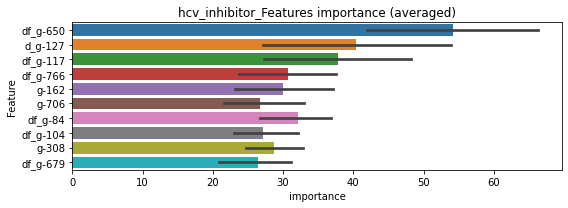

len(train_index) : 3854
len(valid_index) : 3854
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264506	valid_1's binary_logloss: 0.05591
[200]	training's binary_logloss: 0.00519294	valid_1's binary_logloss: 0.0297014
[300]	training's binary_logloss: 0.00146086	valid_1's binary_logloss: 0.0242119
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000859832	valid_1's binary_logloss: 0.0229833


len(train_index) : 3854
len(valid_index) : 3854
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274013	valid_1's binary_logloss: 0.063318
[200]	training's binary_logloss: 0.00557029	valid_1's binary_logloss: 0.0379877
[300]	training's binary_logloss: 0.00155959	valid_1's binary_logloss: 0.0323056
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00130302	valid_1's binary_logloss: 0.0318308


hcv_inhibitor logloss: 0.027407043061552488


neg labels: 3289 → selected neg labels: 3271


hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312179	valid_1's binary_logloss: 0.0705718
[200]	training's binary_logloss: 0.00481979	valid_1's binary_logloss: 0.0367017
[300]	training's binary_logloss: 0.00137993	valid_1's binary_logloss: 0.0307843
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000826024	valid_1's binary_logloss: 0.0292996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300835	valid_1's binary_logloss: 0.0610492
[200]	training's binary_logloss: 0.00455057	valid_1's binary_logloss: 0.0353136
[300]	training's binary_logloss: 0.00134083	valid_1's binary_logloss: 0.0310557
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00114739	valid_1's binary_logloss: 0.0305923


1 / 3 AUC score:0.998
y_Threshold: 0.0054746, Threshold: 0.0146254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 139 → Positive_corect_labels: 650/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.01316, conf_1:0.01609
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0146254
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_2: 0.0246254
Num_p_label: 29.0, Expected: 17.7, Adj_threshold_3: 0.0346254
threshold: 0.0346254, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 650.0/3786, y_label_rate: 0.1716852
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274785	valid_1's binary_logloss: 0.081896
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00462254	valid_1's binary_logloss: 0.0595207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304895	valid_1's binary_logloss: 0.0487591
[200]	training's binary_logloss: 0.00443597	valid_1's binary_logloss: 0.0186586
[300]	training's binary_logloss: 0.00127566	valid_1's binary_logloss: 0.0127472
[400]	training's binary_logloss: 0.000636883	valid_1's binary_logloss: 0.0111789
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000535287	valid_1's binary_logloss: 0.010813


2 / 3 AUC score:0.999
y_Threshold: 0.0428757, Threshold: 0.0346254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 638.0/3762
p_label_rate: 0.0263687 Vs.target_rate: 0.00445
Num_p_label: 105.0, conf_0:0.03116, conf_1:0.03809
Num_p_label: 105.0, Expected: 17.7, Adj_threshold_1: 0.0346254
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_2: 0.0446254
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_3: 0.0546254
Num_p_label: 57.0, Expected: 17.7, Adj_threshold_4: 0.0646254
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_5: 0.0746254
Num_p_label: 46.0, Expected: 17.7, Adj_threshold_6: 0.0846254
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_7: 0.0946254
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_8: 0.1046254
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_9: 0.1146254
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_10: 0.1246254
threshold: 0.1346254, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 638.0/3762, y_label_rate: 0.1695

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273171	valid_1's binary_logloss: 0.0576305
[200]	training's binary_logloss: 0.00366554	valid_1's binary_logloss: 0.0277775
[300]	training's binary_logloss: 0.00106627	valid_1's binary_logloss: 0.0219796
[400]	training's binary_logloss: 0.00054912	valid_1's binary_logloss: 0.0202602
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000461393	valid_1's binary_logloss: 0.0199121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270567	valid_1's binary_logloss: 0.0582624
[200]	training's binary_logloss: 0.00368259	valid_1's binary_logloss: 0.0331126
[300]	training's binary_logloss: 0.00108081	valid_1's binary_logloss: 0.0284517
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00108081	valid_1's binary_logloss: 0.0284517


3 / 3 AUC score:1.000
y_Threshold: 0.0183647, Threshold: 0.1346254, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 630.0/3746
p_label_rate: 0.0092918 Vs.target_rate: 0.00445
Num_p_label: 37.0, conf_0:0.12116, conf_1:0.14809
threshold: 0.1346254, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 667.0/7728, y_label_rate: 0.0863095


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145419	valid_1's binary_logloss: 0.0474957
[200]	training's binary_logloss: 0.00198189	valid_1's binary_logloss: 0.0373679
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00191374	valid_1's binary_logloss: 0.0372511


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153854	valid_1's binary_logloss: 0.0340745
[200]	training's binary_logloss: 0.00217743	valid_1's binary_logloss: 0.0206806
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0012119	valid_1's binary_logloss: 0.0197924


hdac_inhibitor logloss: 0.028521759024003352


neg labels: 3289 → selected neg labels: 3279


histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520373	valid_1's binary_logloss: 0.0921549
[200]	training's binary_logloss: 0.00998222	valid_1's binary_logloss: 0.0367202
[300]	training's binary_logloss: 0.00283735	valid_1's binary_logloss: 0.02295
[400]	training's binary_logloss: 0.00127297	valid_1's binary_logloss: 0.0180945
[500]	training's binary_logloss: 0.000787091	valid_1's binary_logloss: 0.0162896
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000672099	valid_1's binary_logloss: 0.0155679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523516	valid_1's binary_logloss: 0.0944131
[200]	training's binary_logloss: 0.0108579	valid_1's binary_logloss: 0.0416338
[300]	training's binary_logloss: 0.00300082	valid_1's binary_logloss: 0.0275493
[400]	training's binary_logloss: 0.00133404	valid_1's binary_logloss: 0.0227905
[500]	training's binary_logloss: 0.000813197	v

1 / 3 AUC score:1.000
y_Threshold: 0.0079503, Threshold: 0.0118299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00248
Num_p_label: 80.0, conf_0:0.01065, conf_1:0.01301
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0118299
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_2: 0.0218299
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_3: 0.0318299
threshold: 0.0318299, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499802	valid_1's binary_logloss: 0.101435
[200]	training's binary_logloss: 0.00922445	valid_1's binary_logloss: 0.0522976
[300]	training's binary_logloss: 0.00258663	valid_1's binary_logloss: 0.0389713
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00128105	valid_1's binary_logloss: 0.0348056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532612	valid_1's binary_logloss: 0.103977
[200]	training's binary_logloss: 0.00983276	valid_1's binary_logloss: 0.0488521
[300]	training's binary_logloss: 0.00275772	valid_1's binary_logloss: 0.0372032
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0019874	valid_1's binary_logloss: 0.0357165


2 / 3 AUC score:0.999
y_Threshold: 0.0465320, Threshold: 0.0318299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0173280 Vs.target_rate: 0.00248
Num_p_label: 69.0, conf_0:0.02865, conf_1:0.03501
Num_p_label: 69.0, Expected: 9.9, Adj_threshold_1: 0.0318299
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_2: 0.0418299
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_3: 0.0518299
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_4: 0.0618299
threshold: 0.0618299, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510612	valid_1's binary_logloss: 0.0894192
[200]	training's binary_logloss: 0.00991108	valid_1's binary_logloss: 0.0339076
[300]	training's binary_logloss: 0.00276652	valid_1's binary_logloss: 0.018011
[400]	training's binary_logloss: 0.00126263	valid_1's binary_logloss: 0.012858
[500]	training's binary_logloss: 0.000775023	valid_1's binary_logloss: 0.0107573
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000652943	valid_1's binary_logloss: 0.0101556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05004	valid_1's binary_logloss: 0.090068
[200]	training's binary_logloss: 0.00939436	valid_1's binary_logloss: 0.0357609
[300]	training's binary_logloss: 0.00267584	valid_1's binary_logloss: 0.0229658
[400]	training's binary_logloss: 0.00123856	valid_1's binary_logloss: 0.0196579
Early stopping, best iteration is:
[419]	trainin

3 / 3 AUC score:1.000
y_Threshold: 0.0345334, Threshold: 0.0618299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0022602 Vs.target_rate: 0.00248
Num_p_label: 9.0, conf_0:0.05565, conf_1:0.06801
threshold: 0.0618299, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/7762, y_label_rate: 0.0841278


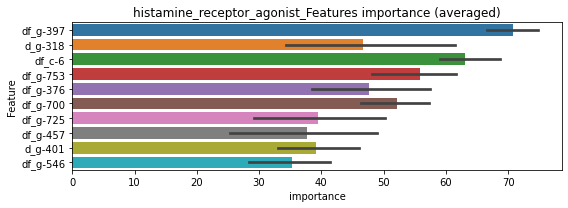

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290558	valid_1's binary_logloss: 0.0640642
[200]	training's binary_logloss: 0.00530545	valid_1's binary_logloss: 0.0338074
[300]	training's binary_logloss: 0.00144914	valid_1's binary_logloss: 0.0274259
[400]	training's binary_logloss: 0.00064313	valid_1's binary_logloss: 0.026118
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000647134	valid_1's binary_logloss: 0.026055


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285974	valid_1's binary_logloss: 0.0652819
[200]	training's binary_logloss: 0.0051873	valid_1's binary_logloss: 0.0372896
[300]	training's binary_logloss: 0.00140874	valid_1's binary_logloss: 0.0329674
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00126776	valid_1's binary_logloss: 0.0326806


histamine_receptor_agonist logloss: 0.029367818061315606


neg labels: 3289 → selected neg labels: 3249


histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107939	valid_1's binary_logloss: 0.267239
[200]	training's binary_logloss: 0.0381599	valid_1's binary_logloss: 0.23061
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0265364	valid_1's binary_logloss: 0.226564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107042	valid_1's binary_logloss: 0.271131
[200]	training's binary_logloss: 0.0368846	valid_1's binary_logloss: 0.233512
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0230846	valid_1's binary_logloss: 0.228594


1 / 3 AUC score:0.905
y_Threshold: 0.0822940, Threshold: 0.1280100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 399 → Positive_corect_labels: 515/3499
p_label_rate: 0.0200904 Vs.target_rate: 0.01012
Num_p_label: 80.0, conf_0:0.11521, conf_1:0.14081
threshold: 0.1280100, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 515.0/3499, y_label_rate: 0.1471849
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776902	valid_1's binary_logloss: 0.195382
[200]	training's binary_logloss: 0.0229124	valid_1's binary_logloss: 0.150444
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00884308	valid_1's binary_logloss: 0.138832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756082	valid_1's binary_logloss: 0.191691
[200]	training's binary_logloss: 0.0216388	valid_1's binary_logloss: 0.144235
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0140846	valid_1's binary_logloss: 0.13738


2 / 3 AUC score:0.973
y_Threshold: 0.0938568, Threshold: 0.1280100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → Positive_corect_labels: 452.0/3373
p_label_rate: 0.0155701 Vs.target_rate: 0.01012
Num_p_label: 62.0, conf_0:0.11521, conf_1:0.14081
threshold: 0.1280100, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 452.0/3373, y_label_rate: 0.1340053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619441	valid_1's binary_logloss: 0.197331
[200]	training's binary_logloss: 0.0155187	valid_1's binary_logloss: 0.16633
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0127775	valid_1's binary_logloss: 0.16444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641952	valid_1's binary_logloss: 0.170851
[200]	training's binary_logloss: 0.0159794	valid_1's binary_logloss: 0.130088
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.011555	valid_1's binary_logloss: 0.126493


3 / 3 AUC score:0.973
y_Threshold: 0.0805438, Threshold: 0.1280100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → Positive_corect_labels: 389.0/3247
p_label_rate: 0.0175791 Vs.target_rate: 0.01012
Num_p_label: 70.0, conf_0:0.11521, conf_1:0.14081
threshold: 0.1280100, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 459.0/7229, y_label_rate: 0.0634943


len(train_index) : 3614
len(valid_index) : 3615
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359301	valid_1's binary_logloss: 0.0946
[200]	training's binary_logloss: 0.00953538	valid_1's binary_logloss: 0.071803
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00458353	valid_1's binary_logloss: 0.0679983


len(train_index) : 3615
len(valid_index) : 3614
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352376	valid_1's binary_logloss: 0.102824
[200]	training's binary_logloss: 0.00937268	valid_1's binary_logloss: 0.0837307
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00805527	valid_1's binary_logloss: 0.0830743


histamine_receptor_antagonist logloss: 0.0755352548920371


neg labels: 3289 → selected neg labels: 3285


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02362	valid_1's binary_logloss: 0.0326605
[200]	training's binary_logloss: 0.00276946	valid_1's binary_logloss: 0.00593077
[300]	training's binary_logloss: 0.000775143	valid_1's binary_logloss: 0.00222641
[400]	training's binary_logloss: 0.000409108	valid_1's binary_logloss: 0.00140062
[500]	training's binary_logloss: 0.000318094	valid_1's binary_logloss: 0.00118561
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000314665	valid_1's binary_logloss: 0.00118042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237597	valid_1's binary_logloss: 0.0336355
[200]	training's binary_logloss: 0.0027725	valid_1's binary_logloss: 0.00529815
[300]	training's binary_logloss: 0.000778824	valid_1's binary_logloss: 0.00187281
[400]	training's binary_logloss: 0.000413324	valid_1's binary_logloss: 0.00116731
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0013188, Threshold: 0.0019507, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00176, conf_1:0.00215
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0019507
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_2: 0.0119507
threshold: 0.0119507, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234609	valid_1's binary_logloss: 0.0314916
[200]	training's binary_logloss: 0.0027195	valid_1's binary_logloss: 0.00515265
[300]	training's binary_logloss: 0.000767394	valid_1's binary_logloss: 0.00184977
[400]	training's binary_logloss: 0.000407973	valid_1's binary_logloss: 0.00110707
[500]	training's binary_logloss: 0.000319675	valid_1's binary_logloss: 0.00092374
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000312532	valid_1's binary_logloss: 0.000914022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238116	valid_1's binary_logloss: 0.0333215
[200]	training's binary_logloss: 0.00274367	valid_1's binary_logloss: 0.00524865
[300]	training's binary_logloss: 0.000759215	valid_1's binary_logloss: 0.0018176
[400]	training's binary_logloss: 0.000402887	valid_1's binary_logloss: 0.00111144
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1568016, Threshold: 0.0119507, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119507, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234609	valid_1's binary_logloss: 0.0314916
[200]	training's binary_logloss: 0.0027195	valid_1's binary_logloss: 0.00515265
[300]	training's binary_logloss: 0.000767394	valid_1's binary_logloss: 0.00184977
[400]	training's binary_logloss: 0.000407973	valid_1's binary_logloss: 0.00110707
[500]	training's binary_logloss: 0.000319675	valid_1's binary_logloss: 0.00092374
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000312532	valid_1's binary_logloss: 0.000914022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238116	valid_1's binary_logloss: 0.0333215
[200]	training's binary_logloss: 0.00274367	valid_1's binary_logloss: 0.00524865
[300]	training's binary_logloss: 0.000759215	valid_1's binary_logloss: 0.0018176
[400]	training's binary_logloss: 0.000402887	valid_1's binary_logloss: 0.00111144
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1568016, Threshold: 0.0119507, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119507, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125507	valid_1's binary_logloss: 0.0282884
[200]	training's binary_logloss: 0.0014242	valid_1's binary_logloss: 0.0145293
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000693926	valid_1's binary_logloss: 0.0134525


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126575	valid_1's binary_logloss: 0.0234381
[200]	training's binary_logloss: 0.00145604	valid_1's binary_logloss: 0.0102297
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000525452	valid_1's binary_logloss: 0.00871575


histone_lysine_demethylase_inhibitor logloss: 0.011084102016582645


neg labels: 3289 → selected neg labels: 3283


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285978	valid_1's binary_logloss: 0.051691
[200]	training's binary_logloss: 0.0038643	valid_1's binary_logloss: 0.0175253
[300]	training's binary_logloss: 0.00109309	valid_1's binary_logloss: 0.0121462
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00111325	valid_1's binary_logloss: 0.0121319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286975	valid_1's binary_logloss: 0.0532076
[200]	training's binary_logloss: 0.00384878	valid_1's binary_logloss: 0.0229007
[300]	training's binary_logloss: 0.00107472	valid_1's binary_logloss: 0.0181403
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000744987	valid_1's binary_logloss: 0.0176119


1 / 3 AUC score:1.000
y_Threshold: 0.0046670, Threshold: 0.0080341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00723, conf_1:0.00884
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0080341
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_2: 0.0180341
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_3: 0.0280341
threshold: 0.0280341, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285475	valid_1's binary_logloss: 0.0533413
[200]	training's binary_logloss: 0.00375504	valid_1's binary_logloss: 0.0206531
[300]	training's binary_logloss: 0.00105682	valid_1's binary_logloss: 0.0146561
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000738304	valid_1's binary_logloss: 0.014044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281862	valid_1's binary_logloss: 0.0464883
[200]	training's binary_logloss: 0.00370067	valid_1's binary_logloss: 0.0143827
[300]	training's binary_logloss: 0.00104345	valid_1's binary_logloss: 0.010112
[400]	training's binary_logloss: 0.000531533	valid_1's binary_logloss: 0.00853126
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000531533	valid_1's binary_logloss: 0.00853126


2 / 3 AUC score:1.000
y_Threshold: 0.0175485, Threshold: 0.0280341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0032647 Vs.target_rate: 0.00134
Num_p_label: 13.0, conf_0:0.02523, conf_1:0.03084
threshold: 0.0280341, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277003	valid_1's binary_logloss: 0.0543075
[200]	training's binary_logloss: 0.00362709	valid_1's binary_logloss: 0.02353
[300]	training's binary_logloss: 0.0010293	valid_1's binary_logloss: 0.0183692
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000762205	valid_1's binary_logloss: 0.0177213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289425	valid_1's binary_logloss: 0.0422128
[200]	training's binary_logloss: 0.00382168	valid_1's binary_logloss: 0.00864713
[300]	training's binary_logloss: 0.00106883	valid_1's binary_logloss: 0.00354762
[400]	training's binary_logloss: 0.000543544	valid_1's binary_logloss: 0.00220815
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000426556	valid_1's binary_logloss: 0.00192442


3 / 3 AUC score:1.000
y_Threshold: 0.0186189, Threshold: 0.0280341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0035158 Vs.target_rate: 0.00134
Num_p_label: 14.0, conf_0:0.02523, conf_1:0.03084
threshold: 0.0280341, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 665.0/7779, y_label_rate: 0.0854866


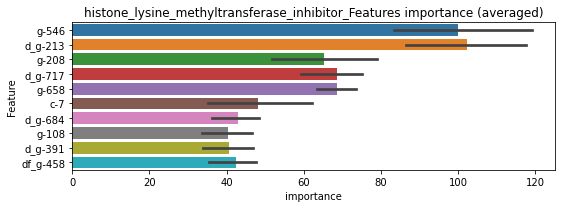

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152265	valid_1's binary_logloss: 0.0300522
[200]	training's binary_logloss: 0.00202404	valid_1's binary_logloss: 0.0146829
[300]	training's binary_logloss: 0.000561891	valid_1's binary_logloss: 0.0130624
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000556581	valid_1's binary_logloss: 0.013053


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156122	valid_1's binary_logloss: 0.0283394
[200]	training's binary_logloss: 0.00218457	valid_1's binary_logloss: 0.0104833
[300]	training's binary_logloss: 0.000609143	valid_1's binary_logloss: 0.00781177
[400]	training's binary_logloss: 0.000298653	valid_1's binary_logloss: 0.00721798
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000311543	valid_1's binary_logloss: 0.00720139


histone_lysine_methyltransferase_inhibitor logloss: 0.010127572217683057


neg labels: 3289 → selected neg labels: 3278


hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553217	valid_1's binary_logloss: 0.110991
[200]	training's binary_logloss: 0.011467	valid_1's binary_logloss: 0.0553396
[300]	training's binary_logloss: 0.00331275	valid_1's binary_logloss: 0.0401018
[400]	training's binary_logloss: 0.00142453	valid_1's binary_logloss: 0.0342148
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0009985	valid_1's binary_logloss: 0.0324044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534769	valid_1's binary_logloss: 0.124222
[200]	training's binary_logloss: 0.0110573	valid_1's binary_logloss: 0.07724
[300]	training's binary_logloss: 0.00320014	valid_1's binary_logloss: 0.0668178
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00160758	valid_1's binary_logloss: 0.0633403


1 / 3 AUC score:0.997
y_Threshold: 0.0118708, Threshold: 0.0176588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01589, conf_1:0.01942
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0176588
Num_p_label: 37.0, Expected: 12.0, Adj_threshold_2: 0.0276588
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.0376588
threshold: 0.0376588, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 646.0/3783, y_label_rate: 0.1707639
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560661	valid_1's binary_logloss: 0.0991479
[200]	training's binary_logloss: 0.011604	valid_1's binary_logloss: 0.0450139
[300]	training's binary_logloss: 0.00327064	valid_1's binary_logloss: 0.0306756
[400]	training's binary_logloss: 0.00146147	valid_1's binary_logloss: 0.0262739
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00121002	valid_1's binary_logloss: 0.025722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503748	valid_1's binary_logloss: 0.113481
[200]	training's binary_logloss: 0.0101256	valid_1's binary_logloss: 0.0622802
[300]	training's binary_logloss: 0.00296969	valid_1's binary_logloss: 0.047816
[400]	training's binary_logloss: 0.00136065	valid_1's binary_logloss: 0.0423525
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00104025	valid_1's binary_logloss: 0.0411331


2 / 3 AUC score:0.999
y_Threshold: 0.0331413, Threshold: 0.0376588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 634.0/3759
p_label_rate: 0.0123054 Vs.target_rate: 0.00302
Num_p_label: 49.0, conf_0:0.03389, conf_1:0.04142
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_1: 0.0376588
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_2: 0.0476588
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_3: 0.0576588
threshold: 0.0576588, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 634.0/3759, y_label_rate: 0.1686619
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496038	valid_1's binary_logloss: 0.102577
[200]	training's binary_logloss: 0.00920189	valid_1's binary_logloss: 0.0515649
[300]	training's binary_logloss: 0.00267979	valid_1's binary_logloss: 0.0393647
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00176249	valid_1's binary_logloss: 0.0380476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536499	valid_1's binary_logloss: 0.11049
[200]	training's binary_logloss: 0.0107238	valid_1's binary_logloss: 0.0548405
[300]	training's binary_logloss: 0.00307012	valid_1's binary_logloss: 0.0379253
[400]	training's binary_logloss: 0.00137446	valid_1's binary_logloss: 0.0331993
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000887225	valid_1's binary_logloss: 0.0313192


3 / 3 AUC score:0.998
y_Threshold: 0.0442266, Threshold: 0.0576588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 625.0/3741
p_label_rate: 0.0072828 Vs.target_rate: 0.00302
Num_p_label: 29.0, conf_0:0.05189, conf_1:0.06342
threshold: 0.0576588, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 654.0/7723, y_label_rate: 0.0846821


len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287778	valid_1's binary_logloss: 0.0700567
[200]	training's binary_logloss: 0.00577526	valid_1's binary_logloss: 0.0474433
[300]	training's binary_logloss: 0.00164349	valid_1's binary_logloss: 0.0432753
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00141077	valid_1's binary_logloss: 0.0429765


len(train_index) : 3862
len(valid_index) : 3861
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300301	valid_1's binary_logloss: 0.0707873
[200]	training's binary_logloss: 0.00595454	valid_1's binary_logloss: 0.0399683
[300]	training's binary_logloss: 0.00170916	valid_1's binary_logloss: 0.0323712
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00096107	valid_1's binary_logloss: 0.0307104


hiv_inhibitor logloss: 0.03684425786275796


neg labels: 3289 → selected neg labels: 3282


hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393767	valid_1's binary_logloss: 0.0839139
[200]	training's binary_logloss: 0.00696478	valid_1's binary_logloss: 0.0558491
[300]	training's binary_logloss: 0.00214349	valid_1's binary_logloss: 0.0503649
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00126545	valid_1's binary_logloss: 0.0488519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366578	valid_1's binary_logloss: 0.0963228
[200]	training's binary_logloss: 0.00626499	valid_1's binary_logloss: 0.0785315
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00526695	valid_1's binary_logloss: 0.0783462


1 / 3 AUC score:0.992
y_Threshold: 0.0318407, Threshold: 0.2138022, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 636/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.01188
Num_p_label: 80.0, conf_0:0.19242, conf_1:0.23518
threshold: 0.2138022, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 636.0/3766, y_label_rate: 0.1688794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303996	valid_1's binary_logloss: 0.0501045
[200]	training's binary_logloss: 0.00437548	valid_1's binary_logloss: 0.0188429
[300]	training's binary_logloss: 0.00123549	valid_1's binary_logloss: 0.0122799
[400]	training's binary_logloss: 0.000613345	valid_1's binary_logloss: 0.0100314
[500]	training's binary_logloss: 0.000430692	valid_1's binary_logloss: 0.00920155
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000404543	valid_1's binary_logloss: 0.00905115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284244	valid_1's binary_logloss: 0.0513851
[200]	training's binary_logloss: 0.00396419	valid_1's binary_logloss: 0.0241839
[300]	training's binary_logloss: 0.00110379	valid_1's binary_logloss: 0.020774
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00100201	valid_1's binary_logloss: 0.0206288


2 / 3 AUC score:0.999
y_Threshold: 0.2168715, Threshold: 0.2138022, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 628.0/3750
p_label_rate: 0.0409342 Vs.target_rate: 0.01188
Num_p_label: 163.0, conf_0:0.19242, conf_1:0.23518
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_1: 0.2138022
Num_p_label: 162.0, Expected: 47.3, Adj_threshold_2: 0.2238022
Num_p_label: 162.0, Expected: 47.3, Adj_threshold_3: 0.2338022
Num_p_label: 159.0, Expected: 47.3, Adj_threshold_4: 0.2438022
Num_p_label: 158.0, Expected: 47.3, Adj_threshold_5: 0.2538022
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_6: 0.2638022
Num_p_label: 154.0, Expected: 47.3, Adj_threshold_7: 0.2738022
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_8: 0.2838022
Num_p_label: 148.0, Expected: 47.3, Adj_threshold_9: 0.2938022
Num_p_label: 146.0, Expected: 47.3, Adj_threshold_10: 0.3038022
threshold: 0.3138022, positive_p_label: 145.0/3982, p_label_rate: 0.0364139
positive_y_label: 628.0/3750, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279726	valid_1's binary_logloss: 0.0488836
[200]	training's binary_logloss: 0.00409527	valid_1's binary_logloss: 0.020041
[300]	training's binary_logloss: 0.00129712	valid_1's binary_logloss: 0.0146127
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000883666	valid_1's binary_logloss: 0.0134784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281869	valid_1's binary_logloss: 0.0451334
[200]	training's binary_logloss: 0.00390786	valid_1's binary_logloss: 0.0172269
[300]	training's binary_logloss: 0.0010768	valid_1's binary_logloss: 0.0121686
[400]	training's binary_logloss: 0.000536778	valid_1's binary_logloss: 0.0103658
[500]	training's binary_logloss: 0.00039005	valid_1's binary_logloss: 0.00989667
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00037167	valid_1's binary_logloss: 0.00986466


3 / 3 AUC score:1.000
y_Threshold: 0.1796670, Threshold: 0.3138022, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 621.0/3736
p_label_rate: 0.0376695 Vs.target_rate: 0.01188
Num_p_label: 150.0, conf_0:0.28242, conf_1:0.34518
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_1: 0.3138022
Num_p_label: 149.0, Expected: 47.3, Adj_threshold_2: 0.3238022
Num_p_label: 147.0, Expected: 47.3, Adj_threshold_3: 0.3338022
Num_p_label: 143.0, Expected: 47.3, Adj_threshold_4: 0.3438022
Num_p_label: 143.0, Expected: 47.3, Adj_threshold_5: 0.3538022
Num_p_label: 140.0, Expected: 47.3, Adj_threshold_6: 0.3638022
Num_p_label: 139.0, Expected: 47.3, Adj_threshold_7: 0.3738022
Num_p_label: 137.0, Expected: 47.3, Adj_threshold_8: 0.3838022
Num_p_label: 136.0, Expected: 47.3, Adj_threshold_9: 0.3938022
Num_p_label: 135.0, Expected: 47.3, Adj_threshold_10: 0.4038022
threshold: 0.4138022, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 755.0/7718, y_label_ra

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173784	valid_1's binary_logloss: 0.0333917
[200]	training's binary_logloss: 0.00257664	valid_1's binary_logloss: 0.0163687
[300]	training's binary_logloss: 0.000735732	valid_1's binary_logloss: 0.0129558
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00044765	valid_1's binary_logloss: 0.0121681


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165086	valid_1's binary_logloss: 0.0355009
[200]	training's binary_logloss: 0.00238616	valid_1's binary_logloss: 0.0194954
[300]	training's binary_logloss: 0.000682557	valid_1's binary_logloss: 0.0165898
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000554982	valid_1's binary_logloss: 0.0163205


hmgcr_inhibitor logloss: 0.014244315614533954


neg labels: 3289 → selected neg labels: 3275


hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026205	valid_1's binary_logloss: 0.0520316
[200]	training's binary_logloss: 0.00336028	valid_1's binary_logloss: 0.0255779
[300]	training's binary_logloss: 0.000974284	valid_1's binary_logloss: 0.0198556
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000758101	valid_1's binary_logloss: 0.0191003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275016	valid_1's binary_logloss: 0.0488592
[200]	training's binary_logloss: 0.00344855	valid_1's binary_logloss: 0.0184188
[300]	training's binary_logloss: 0.00098173	valid_1's binary_logloss: 0.0114209
[400]	training's binary_logloss: 0.000509525	valid_1's binary_logloss: 0.00983542
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000444187	valid_1's binary_logloss: 0.00944748


1 / 3 AUC score:1.000
y_Threshold: 0.0028077, Threshold: 0.0096247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 135 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00391
Num_p_label: 80.0, conf_0:0.00866, conf_1:0.01059
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0096247
Num_p_label: 53.0, Expected: 15.6, Adj_threshold_2: 0.0196247
Num_p_label: 33.0, Expected: 15.6, Adj_threshold_3: 0.0296247
Num_p_label: 28.0, Expected: 15.6, Adj_threshold_4: 0.0396247
threshold: 0.0396247, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274681	valid_1's binary_logloss: 0.0516627
[200]	training's binary_logloss: 0.0033963	valid_1's binary_logloss: 0.0210527
[300]	training's binary_logloss: 0.000964189	valid_1's binary_logloss: 0.0157418
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00067895	valid_1's binary_logloss: 0.0149469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025248	valid_1's binary_logloss: 0.0588259
[200]	training's binary_logloss: 0.00309812	valid_1's binary_logloss: 0.0415492
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00338251	valid_1's binary_logloss: 0.041526


2 / 3 AUC score:0.999
y_Threshold: 0.0326406, Threshold: 0.0396247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 640.0/3769
p_label_rate: 0.0323958 Vs.target_rate: 0.00391
Num_p_label: 129.0, conf_0:0.03566, conf_1:0.04359
Num_p_label: 129.0, Expected: 15.6, Adj_threshold_1: 0.0396247
Num_p_label: 111.0, Expected: 15.6, Adj_threshold_2: 0.0496247
Num_p_label: 101.0, Expected: 15.6, Adj_threshold_3: 0.0596247
Num_p_label: 92.0, Expected: 15.6, Adj_threshold_4: 0.0696247
Num_p_label: 88.0, Expected: 15.6, Adj_threshold_5: 0.0796247
Num_p_label: 81.0, Expected: 15.6, Adj_threshold_6: 0.0896247
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_7: 0.0996247
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_8: 0.1096247
Num_p_label: 64.0, Expected: 15.6, Adj_threshold_9: 0.1196247
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_10: 0.1296247
threshold: 0.1396247, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 640.0/3769, y_label_rate: 0.16

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246702	valid_1's binary_logloss: 0.0585832
[200]	training's binary_logloss: 0.00293832	valid_1's binary_logloss: 0.0415481
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00266763	valid_1's binary_logloss: 0.0412193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024751	valid_1's binary_logloss: 0.0464655
[200]	training's binary_logloss: 0.00291562	valid_1's binary_logloss: 0.0167118
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00131488	valid_1's binary_logloss: 0.0132043


3 / 3 AUC score:0.997
y_Threshold: 0.0441301, Threshold: 0.1396247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 631.0/3751
p_label_rate: 0.0218483 Vs.target_rate: 0.00391
Num_p_label: 87.0, conf_0:0.12566, conf_1:0.15359
Num_p_label: 87.0, Expected: 15.6, Adj_threshold_1: 0.1396247
Num_p_label: 87.0, Expected: 15.6, Adj_threshold_2: 0.1496247
Num_p_label: 84.0, Expected: 15.6, Adj_threshold_3: 0.1596247
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_4: 0.1696247
Num_p_label: 76.0, Expected: 15.6, Adj_threshold_5: 0.1796247
Num_p_label: 74.0, Expected: 15.6, Adj_threshold_6: 0.1896247
Num_p_label: 72.0, Expected: 15.6, Adj_threshold_7: 0.1996247
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_8: 0.2096247
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_9: 0.2196247
Num_p_label: 67.0, Expected: 15.6, Adj_threshold_10: 0.2296247
threshold: 0.2396247, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 695.0/7733, y_label_rate: 0.089874

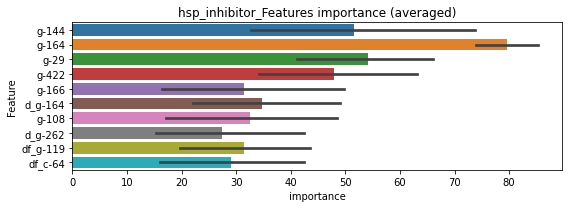

len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139136	valid_1's binary_logloss: 0.0316985
[200]	training's binary_logloss: 0.00171572	valid_1's binary_logloss: 0.0206763
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000779156	valid_1's binary_logloss: 0.0199355


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140973	valid_1's binary_logloss: 0.0277379
[200]	training's binary_logloss: 0.00179636	valid_1's binary_logloss: 0.0135216
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000884922	valid_1's binary_logloss: 0.0121548


hsp_inhibitor logloss: 0.01604564231532912


neg labels: 3289 → selected neg labels: 3282


igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296963	valid_1's binary_logloss: 0.0532051
[200]	training's binary_logloss: 0.00423306	valid_1's binary_logloss: 0.0181606
[300]	training's binary_logloss: 0.00122731	valid_1's binary_logloss: 0.0109116
[400]	training's binary_logloss: 0.000618983	valid_1's binary_logloss: 0.00887529
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000529036	valid_1's binary_logloss: 0.00841875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293711	valid_1's binary_logloss: 0.0524431
[200]	training's binary_logloss: 0.00407501	valid_1's binary_logloss: 0.0170444
[300]	training's binary_logloss: 0.00119344	valid_1's binary_logloss: 0.0105735
[400]	training's binary_logloss: 0.00060658	valid_1's binary_logloss: 0.00892196
[500]	training's binary_logloss: 0.000438728	valid_1's binary_logloss: 0.00805479
Early stopping, best iteration is:
[53

1 / 3 AUC score:1.000
y_Threshold: 0.0047029, Threshold: 0.0087591, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00788, conf_1:0.00964
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0087591
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_2: 0.0187591
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_3: 0.0287591
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.0387591
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_5: 0.0487591
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_6: 0.0587591
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.0687591
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_8: 0.0787591
threshold: 0.0787591, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284355	valid_1's binary_logloss: 0.0515726
[200]	training's binary_logloss: 0.00381146	valid_1's binary_logloss: 0.0175578
[300]	training's binary_logloss: 0.00109853	valid_1's binary_logloss: 0.0112562
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00107928	valid_1's binary_logloss: 0.0112383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294115	valid_1's binary_logloss: 0.0513165
[200]	training's binary_logloss: 0.00394005	valid_1's binary_logloss: 0.0138697
[300]	training's binary_logloss: 0.00113817	valid_1's binary_logloss: 0.00768476
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000666525	valid_1's binary_logloss: 0.00657179


2 / 3 AUC score:1.000
y_Threshold: 0.0871972, Threshold: 0.0787591, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0148167 Vs.target_rate: 0.00155
Num_p_label: 59.0, conf_0:0.07088, conf_1:0.08664
Num_p_label: 59.0, Expected: 6.2, Adj_threshold_1: 0.0787591
Num_p_label: 56.0, Expected: 6.2, Adj_threshold_2: 0.0887591
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_3: 0.0987591
Num_p_label: 50.0, Expected: 6.2, Adj_threshold_4: 0.1087591
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_5: 0.1187591
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_6: 0.1287591
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_7: 0.1387591
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_8: 0.1487591
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_9: 0.1587591
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_10: 0.1687591
threshold: 0.1787591, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289254	valid_1's binary_logloss: 0.049636
[200]	training's binary_logloss: 0.00382472	valid_1's binary_logloss: 0.0181887
[300]	training's binary_logloss: 0.00109644	valid_1's binary_logloss: 0.0137923
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000923964	valid_1's binary_logloss: 0.0134505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281067	valid_1's binary_logloss: 0.0492932
[200]	training's binary_logloss: 0.00369686	valid_1's binary_logloss: 0.0152729
[300]	training's binary_logloss: 0.00109495	valid_1's binary_logloss: 0.0094366
[400]	training's binary_logloss: 0.000566014	valid_1's binary_logloss: 0.00819929
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000563315	valid_1's binary_logloss: 0.00819103


3 / 3 AUC score:1.000
y_Threshold: 0.0512051, Threshold: 0.1787591, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0097941 Vs.target_rate: 0.00155
Num_p_label: 39.0, conf_0:0.16088, conf_1:0.19664
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_1: 0.1787591
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_2: 0.1887591
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_3: 0.1987591
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_4: 0.2087591
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_5: 0.2187591
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_6: 0.2287591
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_7: 0.2387591
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_8: 0.2487591
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_9: 0.2587591
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_10: 0.2687591
threshold: 0.2787591, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 676.0/7778, y_label_rate: 0.0869118


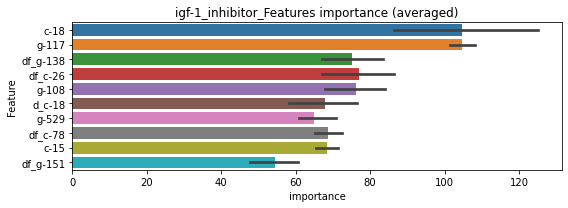

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160846	valid_1's binary_logloss: 0.0322401
[200]	training's binary_logloss: 0.00224638	valid_1's binary_logloss: 0.0140169
[300]	training's binary_logloss: 0.000662114	valid_1's binary_logloss: 0.0110673
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000621581	valid_1's binary_logloss: 0.0109247


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161461	valid_1's binary_logloss: 0.0293194
[200]	training's binary_logloss: 0.00228704	valid_1's binary_logloss: 0.0127722
[300]	training's binary_logloss: 0.000667611	valid_1's binary_logloss: 0.00979477
[400]	training's binary_logloss: 0.000335083	valid_1's binary_logloss: 0.00896493
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000276497	valid_1's binary_logloss: 0.00881406


igf-1_inhibitor logloss: 0.009869359173320958


neg labels: 3289 → selected neg labels: 3284


ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253422	valid_1's binary_logloss: 0.0404657
[200]	training's binary_logloss: 0.00320376	valid_1's binary_logloss: 0.0117968
[300]	training's binary_logloss: 0.000912004	valid_1's binary_logloss: 0.0072313
[400]	training's binary_logloss: 0.000471401	valid_1's binary_logloss: 0.00553348
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000380118	valid_1's binary_logloss: 0.00519281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269007	valid_1's binary_logloss: 0.0421457
[200]	training's binary_logloss: 0.00340409	valid_1's binary_logloss: 0.0110485
[300]	training's binary_logloss: 0.000946352	valid_1's binary_logloss: 0.0059139
[400]	training's binary_logloss: 0.000489184	valid_1's binary_logloss: 0.00452916
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000475492	valid_1's binary_logloss: 0.00445484


1 / 3 AUC score:1.000
y_Threshold: 0.0027861, Threshold: 0.0729610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.06566, conf_1:0.08026
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0729610
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_2: 0.0829610
Num_p_label: 68.0, Expected: 5.0, Adj_threshold_3: 0.0929610
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_4: 0.1029610
Num_p_label: 61.0, Expected: 5.0, Adj_threshold_5: 0.1129610
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_6: 0.1229610
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_7: 0.1329610
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_8: 0.1429610
Num_p_label: 48.0, Expected: 5.0, Adj_threshold_9: 0.1529610
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_10: 0.1629610
threshold: 0.1729610, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249263	valid_1's binary_logloss: 0.0376173
[200]	training's binary_logloss: 0.00296966	valid_1's binary_logloss: 0.0108431
[300]	training's binary_logloss: 0.000839648	valid_1's binary_logloss: 0.00693571
[400]	training's binary_logloss: 0.000436506	valid_1's binary_logloss: 0.00589719
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000379673	valid_1's binary_logloss: 0.00571322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253854	valid_1's binary_logloss: 0.0396286
[200]	training's binary_logloss: 0.00312524	valid_1's binary_logloss: 0.0103241
[300]	training's binary_logloss: 0.000874432	valid_1's binary_logloss: 0.00509768
[400]	training's binary_logloss: 0.000456299	valid_1's binary_logloss: 0.00403059
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000444689	valid_1's binary_logloss: 0.0039710

2 / 3 AUC score:1.000
y_Threshold: 0.1073667, Threshold: 0.1729610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0266198 Vs.target_rate: 0.00126
Num_p_label: 106.0, conf_0:0.15566, conf_1:0.19026
Num_p_label: 106.0, Expected: 5.0, Adj_threshold_1: 0.1729610
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_2: 0.1829610
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_3: 0.1929610
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_4: 0.2029610
Num_p_label: 97.0, Expected: 5.0, Adj_threshold_5: 0.2129610
Num_p_label: 94.0, Expected: 5.0, Adj_threshold_6: 0.2229610
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_7: 0.2329610
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_8: 0.2429610
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_9: 0.2529610
Num_p_label: 93.0, Expected: 5.0, Adj_threshold_10: 0.2629610
threshold: 0.2729610, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
=====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250462	valid_1's binary_logloss: 0.0426534
[200]	training's binary_logloss: 0.00302238	valid_1's binary_logloss: 0.0137272
[300]	training's binary_logloss: 0.000863077	valid_1's binary_logloss: 0.00924159
[400]	training's binary_logloss: 0.000446129	valid_1's binary_logloss: 0.0080584
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000366408	valid_1's binary_logloss: 0.00767497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255148	valid_1's binary_logloss: 0.0327593
[200]	training's binary_logloss: 0.00313609	valid_1's binary_logloss: 0.00534922
[300]	training's binary_logloss: 0.000878608	valid_1's binary_logloss: 0.00185627
[400]	training's binary_logloss: 0.000455888	valid_1's binary_logloss: 0.0010876
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000368654	valid_1's binary_logloss: 0.00092709

3 / 3 AUC score:1.000
y_Threshold: 0.1171762, Threshold: 0.2729610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0231040 Vs.target_rate: 0.00126
Num_p_label: 92.0, conf_0:0.24566, conf_1:0.30026
Num_p_label: 92.0, Expected: 5.0, Adj_threshold_1: 0.2729610
Num_p_label: 92.0, Expected: 5.0, Adj_threshold_2: 0.2829610
Num_p_label: 90.0, Expected: 5.0, Adj_threshold_3: 0.2929610
Num_p_label: 90.0, Expected: 5.0, Adj_threshold_4: 0.3029610
Num_p_label: 90.0, Expected: 5.0, Adj_threshold_5: 0.3129610
Num_p_label: 89.0, Expected: 5.0, Adj_threshold_6: 0.3229610
Num_p_label: 87.0, Expected: 5.0, Adj_threshold_7: 0.3329610
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_8: 0.3429610
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_9: 0.3529610
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_10: 0.3629610
threshold: 0.3729610, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 740.0/7786, y_label_rate: 0.0950424


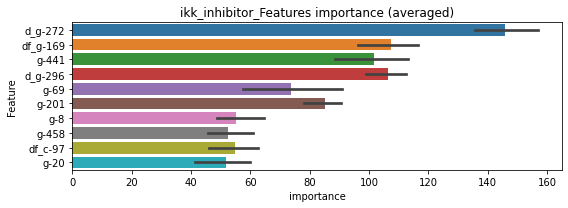

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159423	valid_1's binary_logloss: 0.0253876
[200]	training's binary_logloss: 0.00213976	valid_1's binary_logloss: 0.00797654
[300]	training's binary_logloss: 0.000609716	valid_1's binary_logloss: 0.00540377
[400]	training's binary_logloss: 0.000308706	valid_1's binary_logloss: 0.00490596
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000234284	valid_1's binary_logloss: 0.00475175


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154102	valid_1's binary_logloss: 0.027009
[200]	training's binary_logloss: 0.00207578	valid_1's binary_logloss: 0.0105792
[300]	training's binary_logloss: 0.000596219	valid_1's binary_logloss: 0.00842479
[400]	training's binary_logloss: 0.000304618	valid_1's binary_logloss: 0.00792214
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000249069	valid_1's binary_logloss: 0.00785732


ikk_inhibitor logloss: 0.006304530330985253


neg labels: 3289 → selected neg labels: 3284


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340564	valid_1's binary_logloss: 0.0530571
[200]	training's binary_logloss: 0.00489238	valid_1's binary_logloss: 0.0154907
[300]	training's binary_logloss: 0.00134114	valid_1's binary_logloss: 0.00838236
[400]	training's binary_logloss: 0.00065137	valid_1's binary_logloss: 0.0063172
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000469932	valid_1's binary_logloss: 0.00573933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332945	valid_1's binary_logloss: 0.0492989
[200]	training's binary_logloss: 0.00478661	valid_1's binary_logloss: 0.0112875
[300]	training's binary_logloss: 0.00133908	valid_1's binary_logloss: 0.00442736
[400]	training's binary_logloss: 0.000656148	valid_1's binary_logloss: 0.00260277
[500]	training's binary_logloss: 0.00044787	valid_1's binary_logloss: 0.00199868
Early stopping, best iteration is:
[57

1 / 3 AUC score:1.000
y_Threshold: 0.0027819, Threshold: 0.0060135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00541, conf_1:0.00661
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0060135
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_2: 0.0160135
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.0260135
threshold: 0.0260135, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334101	valid_1's binary_logloss: 0.053258
[200]	training's binary_logloss: 0.00468202	valid_1's binary_logloss: 0.0146622
[300]	training's binary_logloss: 0.00129014	valid_1's binary_logloss: 0.00828164
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000694753	valid_1's binary_logloss: 0.00632682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329288	valid_1's binary_logloss: 0.0473009
[200]	training's binary_logloss: 0.0046915	valid_1's binary_logloss: 0.0102895
[300]	training's binary_logloss: 0.001326	valid_1's binary_logloss: 0.0042282
[400]	training's binary_logloss: 0.000656228	valid_1's binary_logloss: 0.00256445
[500]	training's binary_logloss: 0.000450403	valid_1's binary_logloss: 0.0020115
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00041337	valid_1's binary_logloss: 0.00190551


2 / 3 AUC score:1.000
y_Threshold: 0.0340396, Threshold: 0.0260135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00130
Num_p_label: 26.0, conf_0:0.02341, conf_1:0.02861
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_1: 0.0260135
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_2: 0.0360135
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.0460135
threshold: 0.0460135, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334101	valid_1's binary_logloss: 0.053258
[200]	training's binary_logloss: 0.00468202	valid_1's binary_logloss: 0.0146622
[300]	training's binary_logloss: 0.00129014	valid_1's binary_logloss: 0.00828164
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000694753	valid_1's binary_logloss: 0.00632682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329288	valid_1's binary_logloss: 0.0473009
[200]	training's binary_logloss: 0.0046915	valid_1's binary_logloss: 0.0102895
[300]	training's binary_logloss: 0.001326	valid_1's binary_logloss: 0.0042282
[400]	training's binary_logloss: 0.000656228	valid_1's binary_logloss: 0.00256445
[500]	training's binary_logloss: 0.000450403	valid_1's binary_logloss: 0.0020115
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00041337	valid_1's binary_logloss: 0.00190551


3 / 3 AUC score:1.000
y_Threshold: 0.0340396, Threshold: 0.0460135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00130
Num_p_label: 10.0, conf_0:0.04141, conf_1:0.05061
threshold: 0.0460135, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


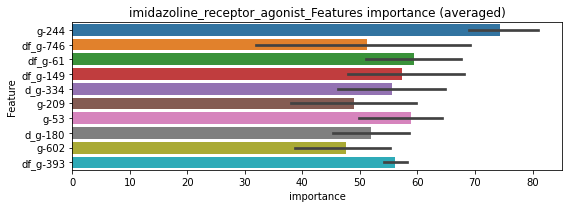

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192737	valid_1's binary_logloss: 0.0315917
[200]	training's binary_logloss: 0.00284767	valid_1's binary_logloss: 0.01185
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00127133	valid_1's binary_logloss: 0.0100423


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188038	valid_1's binary_logloss: 0.0381406
[200]	training's binary_logloss: 0.00268356	valid_1's binary_logloss: 0.0185344
[300]	training's binary_logloss: 0.000730814	valid_1's binary_logloss: 0.0149447
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000758851	valid_1's binary_logloss: 0.0148539


imidazoline_receptor_agonist logloss: 0.012448123710797728


neg labels: 3289 → selected neg labels: 3278


immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462933	valid_1's binary_logloss: 0.0963581
[200]	training's binary_logloss: 0.00889067	valid_1's binary_logloss: 0.0508032
[300]	training's binary_logloss: 0.00265217	valid_1's binary_logloss: 0.0403764
[400]	training's binary_logloss: 0.0012379	valid_1's binary_logloss: 0.0362398
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00113727	valid_1's binary_logloss: 0.0359443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471948	valid_1's binary_logloss: 0.089111
[200]	training's binary_logloss: 0.010067	valid_1's binary_logloss: 0.0397097
[300]	training's binary_logloss: 0.00291034	valid_1's binary_logloss: 0.0255939
[400]	training's binary_logloss: 0.00128035	valid_1's binary_logloss: 0.0203558
[500]	training's binary_logloss: 0.000806544	valid_1's binary_logloss: 0.0188424
Early stopping, best iteration is:
[549]	trainin

1 / 3 AUC score:0.999
y_Threshold: 0.0090952, Threshold: 0.0175298, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01578, conf_1:0.01928
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0175298
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.0275298
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.0375298
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_4: 0.0475298
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.0575298
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.0675298
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.0775298
threshold: 0.0775298, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042732	valid_1's binary_logloss: 0.0984174
[200]	training's binary_logloss: 0.00754615	valid_1's binary_logloss: 0.0576575
[300]	training's binary_logloss: 0.00227618	valid_1's binary_logloss: 0.0504128
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0019892	valid_1's binary_logloss: 0.0498143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441705	valid_1's binary_logloss: 0.0892308
[200]	training's binary_logloss: 0.00828564	valid_1's binary_logloss: 0.0463271
[300]	training's binary_logloss: 0.00241243	valid_1's binary_logloss: 0.0390854
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00125995	valid_1's binary_logloss: 0.036805


2 / 3 AUC score:0.991
y_Threshold: 0.0244611, Threshold: 0.0775298, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 636.0/3763
p_label_rate: 0.0115520 Vs.target_rate: 0.00307
Num_p_label: 46.0, conf_0:0.06978, conf_1:0.08528
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_1: 0.0775298
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.0875298
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_3: 0.0975298
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_4: 0.1075298
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_5: 0.1175298
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_6: 0.1275298
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_7: 0.1375298
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_8: 0.1475298
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_9: 0.1575298
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_10: 0.1675298
threshold: 0.1775298, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 636.0/3763, y_label_rate: 0.169014

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399483	valid_1's binary_logloss: 0.0797611
[200]	training's binary_logloss: 0.00734778	valid_1's binary_logloss: 0.0396556
[300]	training's binary_logloss: 0.00217656	valid_1's binary_logloss: 0.028337
[400]	training's binary_logloss: 0.00106185	valid_1's binary_logloss: 0.025568
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00107862	valid_1's binary_logloss: 0.0255169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394365	valid_1's binary_logloss: 0.100413
[200]	training's binary_logloss: 0.00686379	valid_1's binary_logloss: 0.0549034
[300]	training's binary_logloss: 0.00204176	valid_1's binary_logloss: 0.0467487
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00204176	valid_1's binary_logloss: 0.0467487


3 / 3 AUC score:0.999
y_Threshold: 0.0364177, Threshold: 0.1775298, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 625.0/3741
p_label_rate: 0.0077850 Vs.target_rate: 0.00307
Num_p_label: 31.0, conf_0:0.15978, conf_1:0.19528
threshold: 0.1775298, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 656.0/7723, y_label_rate: 0.0849411


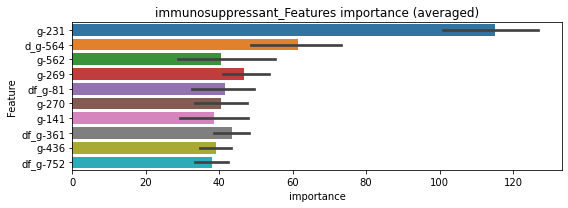

len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225364	valid_1's binary_logloss: 0.0504003
[200]	training's binary_logloss: 0.00381506	valid_1's binary_logloss: 0.0290854
[300]	training's binary_logloss: 0.00112233	valid_1's binary_logloss: 0.0245718
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00107233	valid_1's binary_logloss: 0.0245181


len(train_index) : 3862
len(valid_index) : 3861
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206417	valid_1's binary_logloss: 0.0498265
[200]	training's binary_logloss: 0.00343022	valid_1's binary_logloss: 0.0273833
[300]	training's binary_logloss: 0.00104427	valid_1's binary_logloss: 0.0222517
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000751828	valid_1's binary_logloss: 0.0210847


immunosuppressant logloss: 0.02280166107692859


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319255	valid_1's binary_logloss: 0.0540399
[200]	training's binary_logloss: 0.00458486	valid_1's binary_logloss: 0.0173982
[300]	training's binary_logloss: 0.00127016	valid_1's binary_logloss: 0.0101976
[400]	training's binary_logloss: 0.000626425	valid_1's binary_logloss: 0.0075874
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000459955	valid_1's binary_logloss: 0.00707453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314547	valid_1's binary_logloss: 0.0499023
[200]	training's binary_logloss: 0.00460747	valid_1's binary_logloss: 0.0127508
[300]	training's binary_logloss: 0.00127256	valid_1's binary_logloss: 0.00600495
[400]	training's binary_logloss: 0.000617956	valid_1's binary_logloss: 0.0041566
[500]	training's binary_logloss: 0.000427538	valid_1's binary_logloss: 0.00358522
Early stopping, best iteration is:
[54

1 / 3 AUC score:1.000
y_Threshold: 0.0028004, Threshold: 0.0042594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00383, conf_1:0.00469
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0042594
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.0142594
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.0242594
threshold: 0.0242594, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311899	valid_1's binary_logloss: 0.0530515
[200]	training's binary_logloss: 0.00428821	valid_1's binary_logloss: 0.0147571
[300]	training's binary_logloss: 0.00121239	valid_1's binary_logloss: 0.00901901
[400]	training's binary_logloss: 0.000598681	valid_1's binary_logloss: 0.00695057
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000486665	valid_1's binary_logloss: 0.00652463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317529	valid_1's binary_logloss: 0.0479253
[200]	training's binary_logloss: 0.00436735	valid_1's binary_logloss: 0.0112673
[300]	training's binary_logloss: 0.0012447	valid_1's binary_logloss: 0.00504381
[400]	training's binary_logloss: 0.000624337	valid_1's binary_logloss: 0.00349932
[500]	training's binary_logloss: 0.000437953	valid_1's binary_logloss: 0.00299423
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0320574, Threshold: 0.0242594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0047715 Vs.target_rate: 0.00126
Num_p_label: 19.0, conf_0:0.02183, conf_1:0.02669
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.0242594
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.0342594
threshold: 0.0342594, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311899	valid_1's binary_logloss: 0.0530515
[200]	training's binary_logloss: 0.00428821	valid_1's binary_logloss: 0.0147571
[300]	training's binary_logloss: 0.00121239	valid_1's binary_logloss: 0.00901901
[400]	training's binary_logloss: 0.000598681	valid_1's binary_logloss: 0.00695057
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000486665	valid_1's binary_logloss: 0.00652463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317529	valid_1's binary_logloss: 0.0479253
[200]	training's binary_logloss: 0.00436735	valid_1's binary_logloss: 0.0112673
[300]	training's binary_logloss: 0.0012447	valid_1's binary_logloss: 0.00504381
[400]	training's binary_logloss: 0.000624337	valid_1's binary_logloss: 0.00349932
[500]	training's binary_logloss: 0.000437953	valid_1's binary_logloss: 0.00299423
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0320574, Threshold: 0.0342594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.03083, conf_1:0.03769
threshold: 0.0342594, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


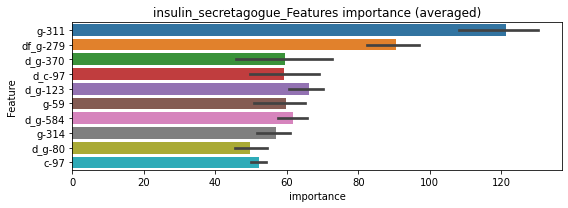

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173772	valid_1's binary_logloss: 0.038293
[200]	training's binary_logloss: 0.00239141	valid_1's binary_logloss: 0.0181494
[300]	training's binary_logloss: 0.000655142	valid_1's binary_logloss: 0.015408
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000443916	valid_1's binary_logloss: 0.0148212


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179579	valid_1's binary_logloss: 0.0324327
[200]	training's binary_logloss: 0.00253183	valid_1's binary_logloss: 0.0121615
[300]	training's binary_logloss: 0.000704954	valid_1's binary_logloss: 0.00867553
[400]	training's binary_logloss: 0.000343963	valid_1's binary_logloss: 0.00747628
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000247746	valid_1's binary_logloss: 0.00722299


insulin_secretagogue logloss: 0.011022108614703258


neg labels: 3289 → selected neg labels: 3281


insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350366	valid_1's binary_logloss: 0.0847789
[200]	training's binary_logloss: 0.00539185	valid_1's binary_logloss: 0.054252
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00204881	valid_1's binary_logloss: 0.0506647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361046	valid_1's binary_logloss: 0.0672353
[200]	training's binary_logloss: 0.00577092	valid_1's binary_logloss: 0.028472
[300]	training's binary_logloss: 0.00171639	valid_1's binary_logloss: 0.0225006
[400]	training's binary_logloss: 0.000842635	valid_1's binary_logloss: 0.0206371
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000820612	valid_1's binary_logloss: 0.0205753


1 / 3 AUC score:0.996
y_Threshold: 0.0103018, Threshold: 0.0200844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00214
Num_p_label: 80.0, conf_0:0.01808, conf_1:0.02209
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0200844
Num_p_label: 33.0, Expected: 8.5, Adj_threshold_2: 0.0300844
Num_p_label: 25.0, Expected: 8.5, Adj_threshold_3: 0.0400844
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_4: 0.0500844
threshold: 0.0500844, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340943	valid_1's binary_logloss: 0.0582645
[200]	training's binary_logloss: 0.00514989	valid_1's binary_logloss: 0.0182069
[300]	training's binary_logloss: 0.00154487	valid_1's binary_logloss: 0.0104868
[400]	training's binary_logloss: 0.000769862	valid_1's binary_logloss: 0.00832928
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000581719	valid_1's binary_logloss: 0.00767771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359668	valid_1's binary_logloss: 0.0582613
[200]	training's binary_logloss: 0.00547223	valid_1's binary_logloss: 0.0160365
[300]	training's binary_logloss: 0.0016105	valid_1's binary_logloss: 0.00727939
[400]	training's binary_logloss: 0.000794093	valid_1's binary_logloss: 0.00472356
[500]	training's binary_logloss: 0.000534664	valid_1's binary_logloss: 0.00378936
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0594437, Threshold: 0.0500844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0070316 Vs.target_rate: 0.00214
Num_p_label: 28.0, conf_0:0.04508, conf_1:0.05509
Num_p_label: 28.0, Expected: 8.5, Adj_threshold_1: 0.0500844
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_2: 0.0600844
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_3: 0.0700844
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_4: 0.0800844
threshold: 0.0800844, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340943	valid_1's binary_logloss: 0.0582645
[200]	training's binary_logloss: 0.00514989	valid_1's binary_logloss: 0.0182069
[300]	training's binary_logloss: 0.00154487	valid_1's binary_logloss: 0.0104868
[400]	training's binary_logloss: 0.000769862	valid_1's binary_logloss: 0.00832928
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000581719	valid_1's binary_logloss: 0.00767771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359668	valid_1's binary_logloss: 0.0582613
[200]	training's binary_logloss: 0.00547223	valid_1's binary_logloss: 0.0160365
[300]	training's binary_logloss: 0.0016105	valid_1's binary_logloss: 0.00727939
[400]	training's binary_logloss: 0.000794093	valid_1's binary_logloss: 0.00472356
[500]	training's binary_logloss: 0.000534664	valid_1's binary_logloss: 0.00378936
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0594437, Threshold: 0.0800844, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0042692 Vs.target_rate: 0.00214
Num_p_label: 17.0, conf_0:0.07208, conf_1:0.08809
threshold: 0.0800844, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 665.0/7771, y_label_rate: 0.0855746


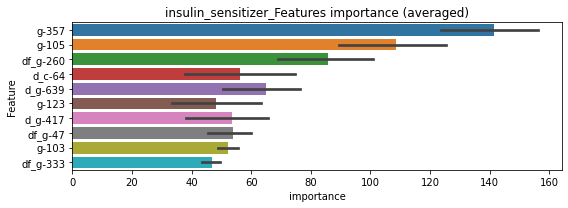

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018392	valid_1's binary_logloss: 0.0476026
[200]	training's binary_logloss: 0.00273771	valid_1's binary_logloss: 0.0251356
[300]	training's binary_logloss: 0.000797536	valid_1's binary_logloss: 0.0207684
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000570772	valid_1's binary_logloss: 0.0202825


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186948	valid_1's binary_logloss: 0.0393913
[200]	training's binary_logloss: 0.00297647	valid_1's binary_logloss: 0.0158015
[300]	training's binary_logloss: 0.000872574	valid_1's binary_logloss: 0.0105422
[400]	training's binary_logloss: 0.000427564	valid_1's binary_logloss: 0.00898491
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000293889	valid_1's binary_logloss: 0.00839358


insulin_sensitizer logloss: 0.014338810903640978


neg labels: 3289 → selected neg labels: 3282


integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397945	valid_1's binary_logloss: 0.0757768
[200]	training's binary_logloss: 0.00692319	valid_1's binary_logloss: 0.0318865
[300]	training's binary_logloss: 0.00188956	valid_1's binary_logloss: 0.0224738
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.001795	valid_1's binary_logloss: 0.022219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408722	valid_1's binary_logloss: 0.0711783
[200]	training's binary_logloss: 0.00756462	valid_1's binary_logloss: 0.0265952
[300]	training's binary_logloss: 0.00202251	valid_1's binary_logloss: 0.0143033
[400]	training's binary_logloss: 0.00091	valid_1's binary_logloss: 0.0105192
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000737232	valid_1's binary_logloss: 0.00979354


1 / 3 AUC score:1.000
y_Threshold: 0.0072575, Threshold: 0.0075987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00684, conf_1:0.00836
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0075987
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_2: 0.0175987
threshold: 0.0175987, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401943	valid_1's binary_logloss: 0.0743536
[200]	training's binary_logloss: 0.00656849	valid_1's binary_logloss: 0.0269432
[300]	training's binary_logloss: 0.0018654	valid_1's binary_logloss: 0.0174237
[400]	training's binary_logloss: 0.000891216	valid_1's binary_logloss: 0.0137181
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000700541	valid_1's binary_logloss: 0.0131674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042226	valid_1's binary_logloss: 0.0744883
[200]	training's binary_logloss: 0.00694486	valid_1's binary_logloss: 0.0269526
[300]	training's binary_logloss: 0.00191042	valid_1's binary_logloss: 0.0172397
[400]	training's binary_logloss: 0.000903466	valid_1's binary_logloss: 0.014075
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0007689	valid_1's binary_logloss: 0.0135853


2 / 3 AUC score:1.000
y_Threshold: 0.0260595, Threshold: 0.0175987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0045203 Vs.target_rate: 0.00176
Num_p_label: 18.0, conf_0:0.01584, conf_1:0.01936
threshold: 0.0175987, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399319	valid_1's binary_logloss: 0.0773735
[200]	training's binary_logloss: 0.00652068	valid_1's binary_logloss: 0.0341156
[300]	training's binary_logloss: 0.00182214	valid_1's binary_logloss: 0.0246848
[400]	training's binary_logloss: 0.000870579	valid_1's binary_logloss: 0.0226751
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000893986	valid_1's binary_logloss: 0.0225844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422615	valid_1's binary_logloss: 0.0764509
[200]	training's binary_logloss: 0.00707197	valid_1's binary_logloss: 0.0293341
[300]	training's binary_logloss: 0.00193749	valid_1's binary_logloss: 0.0198432
[400]	training's binary_logloss: 0.000913522	valid_1's binary_logloss: 0.0173492
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000649719	valid_1's binary_logloss: 0.0162115


3 / 3 AUC score:1.000
y_Threshold: 0.0275689, Threshold: 0.0175987, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0045203 Vs.target_rate: 0.00176
Num_p_label: 18.0, conf_0:0.01584, conf_1:0.01936
threshold: 0.0175987, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 669.0/7778, y_label_rate: 0.0860118


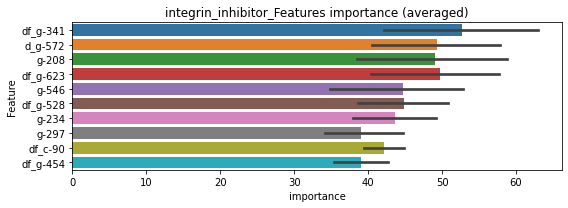

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231127	valid_1's binary_logloss: 0.0451155
[200]	training's binary_logloss: 0.00390033	valid_1's binary_logloss: 0.0221432
[300]	training's binary_logloss: 0.00101359	valid_1's binary_logloss: 0.0185202
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00109238	valid_1's binary_logloss: 0.0184497


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219278	valid_1's binary_logloss: 0.0480815
[200]	training's binary_logloss: 0.00372429	valid_1's binary_logloss: 0.0234856
[300]	training's binary_logloss: 0.00104862	valid_1's binary_logloss: 0.0188444
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000907003	valid_1's binary_logloss: 0.0186402


integrin_inhibitor logloss: 0.018544948516484815


neg labels: 3289 → selected neg labels: 3274


jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367508	valid_1's binary_logloss: 0.0850067
[200]	training's binary_logloss: 0.00614288	valid_1's binary_logloss: 0.0450689
[300]	training's binary_logloss: 0.0018544	valid_1's binary_logloss: 0.0357448
[400]	training's binary_logloss: 0.00091149	valid_1's binary_logloss: 0.0324941
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000931026	valid_1's binary_logloss: 0.0324019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374019	valid_1's binary_logloss: 0.0776176
[200]	training's binary_logloss: 0.00636561	valid_1's binary_logloss: 0.0360553
[300]	training's binary_logloss: 0.0019157	valid_1's binary_logloss: 0.0252465
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00122275	valid_1's binary_logloss: 0.0227783


1 / 3 AUC score:0.999
y_Threshold: 0.0163594, Threshold: 0.0438970, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 652/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00386
Num_p_label: 80.0, conf_0:0.03951, conf_1:0.04829
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0438970
Num_p_label: 58.0, Expected: 15.4, Adj_threshold_2: 0.0538970
Num_p_label: 44.0, Expected: 15.4, Adj_threshold_3: 0.0638970
Num_p_label: 39.0, Expected: 15.4, Adj_threshold_4: 0.0738970
Num_p_label: 30.0, Expected: 15.4, Adj_threshold_5: 0.0838970
threshold: 0.0838970, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 652.0/3792, y_label_rate: 0.1719409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349132	valid_1's binary_logloss: 0.0792648
[200]	training's binary_logloss: 0.00537174	valid_1's binary_logloss: 0.0393227
[300]	training's binary_logloss: 0.00158926	valid_1's binary_logloss: 0.0298495
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000829699	valid_1's binary_logloss: 0.0268976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355397	valid_1's binary_logloss: 0.0718649
[200]	training's binary_logloss: 0.0055174	valid_1's binary_logloss: 0.0335887
[300]	training's binary_logloss: 0.00161101	valid_1's binary_logloss: 0.0242531
[400]	training's binary_logloss: 0.000795433	valid_1's binary_logloss: 0.0213683
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000577813	valid_1's binary_logloss: 0.0203985


2 / 3 AUC score:0.999
y_Threshold: 0.1255032, Threshold: 0.0838970, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 642.0/3772
p_label_rate: 0.0311401 Vs.target_rate: 0.00386
Num_p_label: 124.0, conf_0:0.07551, conf_1:0.09229
Num_p_label: 124.0, Expected: 15.4, Adj_threshold_1: 0.0838970
Num_p_label: 110.0, Expected: 15.4, Adj_threshold_2: 0.0938970
Num_p_label: 101.0, Expected: 15.4, Adj_threshold_3: 0.1038970
Num_p_label: 94.0, Expected: 15.4, Adj_threshold_4: 0.1138970
Num_p_label: 84.0, Expected: 15.4, Adj_threshold_5: 0.1238970
Num_p_label: 82.0, Expected: 15.4, Adj_threshold_6: 0.1338970
Num_p_label: 75.0, Expected: 15.4, Adj_threshold_7: 0.1438970
Num_p_label: 68.0, Expected: 15.4, Adj_threshold_8: 0.1538970
Num_p_label: 67.0, Expected: 15.4, Adj_threshold_9: 0.1638970
Num_p_label: 61.0, Expected: 15.4, Adj_threshold_10: 0.1738970
threshold: 0.1838970, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 642.0/3772, y_label_rate: 0.17

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350788	valid_1's binary_logloss: 0.0707352
[200]	training's binary_logloss: 0.00513165	valid_1's binary_logloss: 0.0305188
[300]	training's binary_logloss: 0.00151411	valid_1's binary_logloss: 0.0221459
[400]	training's binary_logloss: 0.000746281	valid_1's binary_logloss: 0.0197946
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000723181	valid_1's binary_logloss: 0.0196489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343541	valid_1's binary_logloss: 0.0618338
[200]	training's binary_logloss: 0.00521653	valid_1's binary_logloss: 0.0242279
[300]	training's binary_logloss: 0.00151353	valid_1's binary_logloss: 0.0154695
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000863288	valid_1's binary_logloss: 0.0136114


3 / 3 AUC score:0.999
y_Threshold: 0.1785608, Threshold: 0.1838970, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 635.0/3758
p_label_rate: 0.0251130 Vs.target_rate: 0.00386
Num_p_label: 100.0, conf_0:0.16551, conf_1:0.20229
Num_p_label: 100.0, Expected: 15.4, Adj_threshold_1: 0.1838970
Num_p_label: 95.0, Expected: 15.4, Adj_threshold_2: 0.1938970
Num_p_label: 89.0, Expected: 15.4, Adj_threshold_3: 0.2038970
Num_p_label: 83.0, Expected: 15.4, Adj_threshold_4: 0.2138970
Num_p_label: 78.0, Expected: 15.4, Adj_threshold_5: 0.2238970
Num_p_label: 76.0, Expected: 15.4, Adj_threshold_6: 0.2338970
Num_p_label: 72.0, Expected: 15.4, Adj_threshold_7: 0.2438970
Num_p_label: 70.0, Expected: 15.4, Adj_threshold_8: 0.2538970
Num_p_label: 70.0, Expected: 15.4, Adj_threshold_9: 0.2638970
Num_p_label: 67.0, Expected: 15.4, Adj_threshold_10: 0.2738970
threshold: 0.2838970, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 700.0/7740, y_label_rate: 0.0904

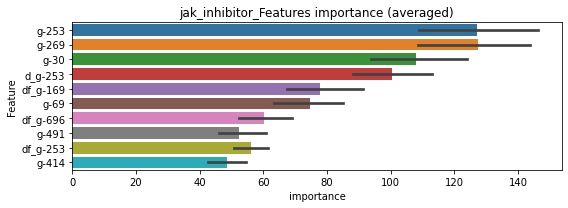

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192178	valid_1's binary_logloss: 0.0445567
[200]	training's binary_logloss: 0.0030408	valid_1's binary_logloss: 0.0254629
[300]	training's binary_logloss: 0.000905405	valid_1's binary_logloss: 0.0218758
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000946163	valid_1's binary_logloss: 0.0218012


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189626	valid_1's binary_logloss: 0.0444835
[200]	training's binary_logloss: 0.00306419	valid_1's binary_logloss: 0.0247226
[300]	training's binary_logloss: 0.000929632	valid_1's binary_logloss: 0.0194525
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000669247	valid_1's binary_logloss: 0.0185598


jak_inhibitor logloss: 0.02018051136566687


neg labels: 3289 → selected neg labels: 3272


kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439838	valid_1's binary_logloss: 0.117084
[200]	training's binary_logloss: 0.00855963	valid_1's binary_logloss: 0.0890768
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00425786	valid_1's binary_logloss: 0.0853104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434914	valid_1's binary_logloss: 0.11201
[200]	training's binary_logloss: 0.00806793	valid_1's binary_logloss: 0.0842017
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00586063	valid_1's binary_logloss: 0.0822849


1 / 3 AUC score:0.987
y_Threshold: 0.0363953, Threshold: 0.1769456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 634/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01146
Num_p_label: 80.0, conf_0:0.15925, conf_1:0.19464
threshold: 0.1769456, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 634.0/3754, y_label_rate: 0.1688865
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380099	valid_1's binary_logloss: 0.0746505
[200]	training's binary_logloss: 0.0064812	valid_1's binary_logloss: 0.0399973
[300]	training's binary_logloss: 0.00194258	valid_1's binary_logloss: 0.0317553
[400]	training's binary_logloss: 0.000916388	valid_1's binary_logloss: 0.0288356
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000683681	valid_1's binary_logloss: 0.0277984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363913	valid_1's binary_logloss: 0.0836753
[200]	training's binary_logloss: 0.00604698	valid_1's binary_logloss: 0.0536531
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00242879	valid_1's binary_logloss: 0.0486072


2 / 3 AUC score:0.998
y_Threshold: 0.0983244, Threshold: 0.1769456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 617.0/3720
p_label_rate: 0.0288800 Vs.target_rate: 0.01146
Num_p_label: 115.0, conf_0:0.15925, conf_1:0.19464
threshold: 0.1769456, positive_p_label: 115.0/3982, p_label_rate: 0.0288800
positive_y_label: 617.0/3720, y_label_rate: 0.1658602
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335991	valid_1's binary_logloss: 0.067019
[200]	training's binary_logloss: 0.00549978	valid_1's binary_logloss: 0.0380139
[300]	training's binary_logloss: 0.00164026	valid_1's binary_logloss: 0.0327629
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000963409	valid_1's binary_logloss: 0.0307648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336437	valid_1's binary_logloss: 0.0685181
[200]	training's binary_logloss: 0.00537419	valid_1's binary_logloss: 0.0350935
[300]	training's binary_logloss: 0.00162005	valid_1's binary_logloss: 0.0286623
[400]	training's binary_logloss: 0.00077836	valid_1's binary_logloss: 0.0255975
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000595084	valid_1's binary_logloss: 0.0248884


3 / 3 AUC score:1.000
y_Threshold: 0.0690762, Threshold: 0.1769456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 605.0/3696
p_label_rate: 0.0321447 Vs.target_rate: 0.01146
Num_p_label: 128.0, conf_0:0.15925, conf_1:0.19464
threshold: 0.1769456, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 733.0/7678, y_label_rate: 0.0954676


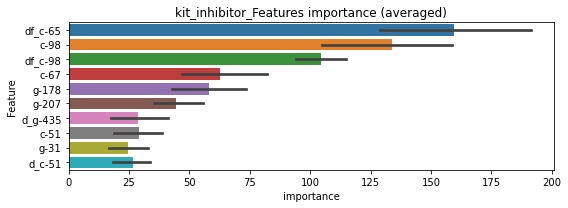

len(train_index) : 3839
len(valid_index) : 3839
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199678	valid_1's binary_logloss: 0.0494601
[200]	training's binary_logloss: 0.00317353	valid_1's binary_logloss: 0.0307575
[300]	training's binary_logloss: 0.000921064	valid_1's binary_logloss: 0.0277771
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000801827	valid_1's binary_logloss: 0.0276582


len(train_index) : 3839
len(valid_index) : 3839
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201392	valid_1's binary_logloss: 0.0445771
[200]	training's binary_logloss: 0.00343695	valid_1's binary_logloss: 0.0271808
[300]	training's binary_logloss: 0.000972959	valid_1's binary_logloss: 0.0239248
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000586141	valid_1's binary_logloss: 0.0227498


kit_inhibitor logloss: 0.025203985414080473


neg labels: 3289 → selected neg labels: 3288


laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015598	valid_1's binary_logloss: 0.016914
[200]	training's binary_logloss: 0.00131655	valid_1's binary_logloss: 0.00171161
[300]	training's binary_logloss: 0.000362839	valid_1's binary_logloss: 0.000560319
[400]	training's binary_logloss: 0.000221325	valid_1's binary_logloss: 0.000365744
[500]	training's binary_logloss: 0.000195662	valid_1's binary_logloss: 0.000329925
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000194193	valid_1's binary_logloss: 0.000328346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156992	valid_1's binary_logloss: 0.0167182
[200]	training's binary_logloss: 0.00134608	valid_1's binary_logloss: 0.00173213
[300]	training's binary_logloss: 0.000383336	valid_1's binary_logloss: 0.000549393
[400]	training's binary_logloss: 0.000218171	valid_1's binary_logloss: 0.000327345
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0005211, Threshold: 0.0008577, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00077, conf_1:0.00094
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008577
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0108577
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208577
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308577
threshold: 0.0308577, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159667	valid_1's binary_logloss: 0.0177958
[200]	training's binary_logloss: 0.00130353	valid_1's binary_logloss: 0.00183866
[300]	training's binary_logloss: 0.000353858	valid_1's binary_logloss: 0.000584534
[400]	training's binary_logloss: 0.000219006	valid_1's binary_logloss: 0.000400413
[500]	training's binary_logloss: 0.000192148	valid_1's binary_logloss: 0.000359279
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000192148	valid_1's binary_logloss: 0.000359279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159576	valid_1's binary_logloss: 0.0169974
[200]	training's binary_logloss: 0.00130239	valid_1's binary_logloss: 0.00172235
[300]	training's binary_logloss: 0.00035297	valid_1's binary_logloss: 0.000577361
[400]	training's binary_logloss: 0.000218759	valid_1's binary_logloss: 0.000385373
Early stopping, best itera

2 / 3 AUC score:1.000
y_Threshold: 0.1508082, Threshold: 0.0308577, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025
Num_p_label: 12.0, conf_0:0.02777, conf_1:0.03394
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0308577
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0408577
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0508577
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0608577
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.0708577
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0808577
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.0908577
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.1008577
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1108577
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1208577
threshold: 0.1308577, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159667	valid_1's binary_logloss: 0.0177958
[200]	training's binary_logloss: 0.00130353	valid_1's binary_logloss: 0.00183866
[300]	training's binary_logloss: 0.000353858	valid_1's binary_logloss: 0.000584534
[400]	training's binary_logloss: 0.000219006	valid_1's binary_logloss: 0.000400413
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000192148	valid_1's binary_logloss: 0.000359279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159576	valid_1's binary_logloss: 0.0169974
[200]	training's binary_logloss: 0.00130239	valid_1's binary_logloss: 0.00172235
[300]	training's binary_logloss: 0.00035297	valid_1's binary_logloss: 0.000577361
[400]	training's binary_logloss: 0.000218759	valid_1's binary_logloss: 0.000385373
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000193297	valid_1's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1508082, Threshold: 0.1308577, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025
Num_p_label: 3.0, conf_0:0.11777, conf_1:0.14394
threshold: 0.1308577, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


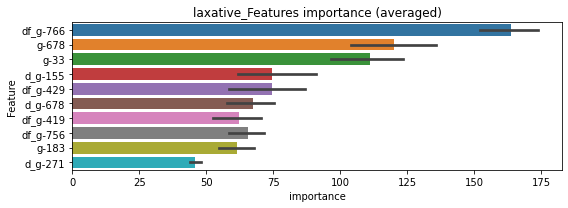

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00856145	valid_1's binary_logloss: 0.0102246
[200]	training's binary_logloss: 0.00069695	valid_1's binary_logloss: 0.00265344
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000266674	valid_1's binary_logloss: 0.0023932


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00861036	valid_1's binary_logloss: 0.0101874
[200]	training's binary_logloss: 0.000704384	valid_1's binary_logloss: 0.00224719
[300]	training's binary_logloss: 0.000190057	valid_1's binary_logloss: 0.00176045
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000152657	valid_1's binary_logloss: 0.00171732


laxative logloss: 0.0020553073823720755


neg labels: 3289 → selected neg labels: 3288


leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015489	valid_1's binary_logloss: 0.0161708
[200]	training's binary_logloss: 0.00128392	valid_1's binary_logloss: 0.00142685
[300]	training's binary_logloss: 0.000349744	valid_1's binary_logloss: 0.000418994
[400]	training's binary_logloss: 0.000215007	valid_1's binary_logloss: 0.000265688
[500]	training's binary_logloss: 0.000189479	valid_1's binary_logloss: 0.000236934
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000187086	valid_1's binary_logloss: 0.000234282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157139	valid_1's binary_logloss: 0.0168628
[200]	training's binary_logloss: 0.00127514	valid_1's binary_logloss: 0.00157929
[300]	training's binary_logloss: 0.00034401	valid_1's binary_logloss: 0.000492247
[400]	training's binary_logloss: 0.000211498	valid_1's binary_logloss: 0.000310117
Early stopping, best iterat

1 / 3 AUC score:1.000
y_Threshold: 0.0005782, Threshold: 0.0008784, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00079, conf_1:0.00097
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008784
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0108784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208784
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308784
threshold: 0.0308784, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158778	valid_1's binary_logloss: 0.0168413
[200]	training's binary_logloss: 0.00127884	valid_1's binary_logloss: 0.00155222
[300]	training's binary_logloss: 0.000338769	valid_1's binary_logloss: 0.000476969
[400]	training's binary_logloss: 0.000211294	valid_1's binary_logloss: 0.000317741
[500]	training's binary_logloss: 0.000183468	valid_1's binary_logloss: 0.000283232
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00018035	valid_1's binary_logloss: 0.00027957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159886	valid_1's binary_logloss: 0.0164806
[200]	training's binary_logloss: 0.00127837	valid_1's binary_logloss: 0.00139451
[300]	training's binary_logloss: 0.000340778	valid_1's binary_logloss: 0.000391176
[400]	training's binary_logloss: 0.000212233	valid_1's binary_logloss: 0.000246028
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1609132, Threshold: 0.0308784, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025
Num_p_label: 10.0, conf_0:0.02779, conf_1:0.03397
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.0308784
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0408784
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0508784
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0608784
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0708784
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0808784
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0908784
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.1008784
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1108784
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1208784
threshold: 0.1308784, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158778	valid_1's binary_logloss: 0.0168413
[200]	training's binary_logloss: 0.00127884	valid_1's binary_logloss: 0.00155222
[300]	training's binary_logloss: 0.000338769	valid_1's binary_logloss: 0.000476969
[400]	training's binary_logloss: 0.000211294	valid_1's binary_logloss: 0.000317741
[500]	training's binary_logloss: 0.000183468	valid_1's binary_logloss: 0.000283232
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00018035	valid_1's binary_logloss: 0.00027957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159886	valid_1's binary_logloss: 0.0164806
[200]	training's binary_logloss: 0.00127837	valid_1's binary_logloss: 0.00139451
[300]	training's binary_logloss: 0.000340778	valid_1's binary_logloss: 0.000391176
[400]	training's binary_logloss: 0.000212233	valid_1's binary_logloss: 0.000246028
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1609132, Threshold: 0.1308784, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025
Num_p_label: 4.0, conf_0:0.11779, conf_1:0.14397
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.1308784
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.1408784
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1508784
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.1608784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.1708784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.1808784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1908784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.2008784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2108784
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2208784
threshold: 0.2308784, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


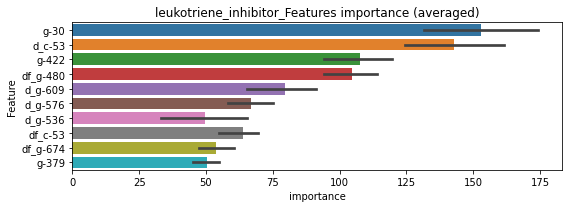

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00841649	valid_1's binary_logloss: 0.0102167
[200]	training's binary_logloss: 0.000659729	valid_1's binary_logloss: 0.00258552
[300]	training's binary_logloss: 0.000174135	valid_1's binary_logloss: 0.00209726
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000181921	valid_1's binary_logloss: 0.00208752


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00845051	valid_1's binary_logloss: 0.0090763
[200]	training's binary_logloss: 0.00067798	valid_1's binary_logloss: 0.00106052
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000218701	valid_1's binary_logloss: 0.000662536


leukotriene_inhibitor logloss: 0.0013751199287625538


neg labels: 3289 → selected neg labels: 3280


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049152	valid_1's binary_logloss: 0.107343
[200]	training's binary_logloss: 0.00958555	valid_1's binary_logloss: 0.0629125
[300]	training's binary_logloss: 0.0027961	valid_1's binary_logloss: 0.0530349
[400]	training's binary_logloss: 0.0012887	valid_1's binary_logloss: 0.0497034
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00103797	valid_1's binary_logloss: 0.0486812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534953	valid_1's binary_logloss: 0.0914938
[200]	training's binary_logloss: 0.0111325	valid_1's binary_logloss: 0.0348177
[300]	training's binary_logloss: 0.00315917	valid_1's binary_logloss: 0.0176888
[400]	training's binary_logloss: 0.00141469	valid_1's binary_logloss: 0.0117485
[500]	training's binary_logloss: 0.000861676	valid_1's binary_logloss: 0.00977223
Early stopping, best iteration is:
[582]	trainin

1 / 3 AUC score:0.996
y_Threshold: 0.0083521, Threshold: 0.0114632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3790
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.01032, conf_1:0.01261
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0114632
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_2: 0.0214632
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_3: 0.0314632
threshold: 0.0314632, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488889	valid_1's binary_logloss: 0.100433
[200]	training's binary_logloss: 0.00933961	valid_1's binary_logloss: 0.0448602
[300]	training's binary_logloss: 0.00271897	valid_1's binary_logloss: 0.0291104
[400]	training's binary_logloss: 0.0012556	valid_1's binary_logloss: 0.0236589
[500]	training's binary_logloss: 0.000785851	valid_1's binary_logloss: 0.0216274
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000640163	valid_1's binary_logloss: 0.0207903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511775	valid_1's binary_logloss: 0.0922225
[200]	training's binary_logloss: 0.0101104	valid_1's binary_logloss: 0.0375367
[300]	training's binary_logloss: 0.00289117	valid_1's binary_logloss: 0.022262
[400]	training's binary_logloss: 0.00132869	valid_1's binary_logloss: 0.0174875
[500]	training's binary_logloss: 0.000816716	va

2 / 3 AUC score:1.000
y_Threshold: 0.0274160, Threshold: 0.0314632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0077850 Vs.target_rate: 0.00260
Num_p_label: 31.0, conf_0:0.02832, conf_1:0.03461
threshold: 0.0314632, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477179	valid_1's binary_logloss: 0.0998004
[200]	training's binary_logloss: 0.00890474	valid_1's binary_logloss: 0.0425302
[300]	training's binary_logloss: 0.00263763	valid_1's binary_logloss: 0.0260155
[400]	training's binary_logloss: 0.0012285	valid_1's binary_logloss: 0.0198099
[500]	training's binary_logloss: 0.000769469	valid_1's binary_logloss: 0.017101
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000633852	valid_1's binary_logloss: 0.0159153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502954	valid_1's binary_logloss: 0.0940147
[200]	training's binary_logloss: 0.00942389	valid_1's binary_logloss: 0.03803
[300]	training's binary_logloss: 0.00268464	valid_1's binary_logloss: 0.0249309
[400]	training's binary_logloss: 0.00125076	valid_1's binary_logloss: 0.0205693
Early stopping, best iteration is:
[458]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0322527, Threshold: 0.0314632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 643.0/3778
p_label_rate: 0.0067805 Vs.target_rate: 0.00260
Num_p_label: 27.0, conf_0:0.02832, conf_1:0.03461
threshold: 0.0314632, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 670.0/7760, y_label_rate: 0.0863402


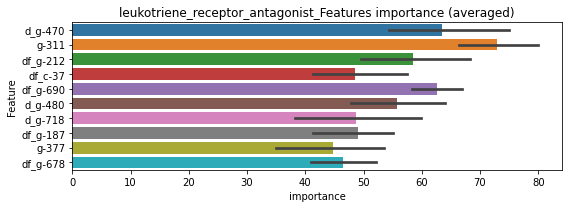

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269011	valid_1's binary_logloss: 0.0636371
[200]	training's binary_logloss: 0.00504981	valid_1's binary_logloss: 0.0387906
[300]	training's binary_logloss: 0.00145649	valid_1's binary_logloss: 0.0348638
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0012311	valid_1's binary_logloss: 0.034424


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028672	valid_1's binary_logloss: 0.0600225
[200]	training's binary_logloss: 0.00570038	valid_1's binary_logloss: 0.0320317
[300]	training's binary_logloss: 0.00165172	valid_1's binary_logloss: 0.0263751
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000859289	valid_1's binary_logloss: 0.0250577


leukotriene_receptor_antagonist logloss: 0.029740852422253956


neg labels: 3289 → selected neg labels: 3287


lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187922	valid_1's binary_logloss: 0.0245553
[200]	training's binary_logloss: 0.00195937	valid_1's binary_logloss: 0.00548703
[300]	training's binary_logloss: 0.000552841	valid_1's binary_logloss: 0.00273536
[400]	training's binary_logloss: 0.000305267	valid_1's binary_logloss: 0.00197386
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000270946	valid_1's binary_logloss: 0.0018811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192895	valid_1's binary_logloss: 0.023582
[200]	training's binary_logloss: 0.00195085	valid_1's binary_logloss: 0.00310741
[300]	training's binary_logloss: 0.000559197	valid_1's binary_logloss: 0.00107052
[400]	training's binary_logloss: 0.000315023	valid_1's binary_logloss: 0.000656155
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000270788	valid_1's binary_logloss: 0.000580

1 / 3 AUC score:1.000
y_Threshold: 0.0010944, Threshold: 0.0019038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00171, conf_1:0.00209
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019038
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0119038
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0219038
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0319038
threshold: 0.0319038, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192282	valid_1's binary_logloss: 0.0254232
[200]	training's binary_logloss: 0.00187923	valid_1's binary_logloss: 0.00664494
[300]	training's binary_logloss: 0.000526597	valid_1's binary_logloss: 0.00381867
[400]	training's binary_logloss: 0.000300788	valid_1's binary_logloss: 0.00315305
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000264218	valid_1's binary_logloss: 0.00301612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019582	valid_1's binary_logloss: 0.0233586
[200]	training's binary_logloss: 0.00196553	valid_1's binary_logloss: 0.0028384
[300]	training's binary_logloss: 0.00054781	valid_1's binary_logloss: 0.000890328
[400]	training's binary_logloss: 0.000304021	valid_1's binary_logloss: 0.000525775
[500]	training's binary_logloss: 0.000264797	valid_1's binary_logloss: 0.000470455
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0518123, Threshold: 0.0319038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00050
Num_p_label: 14.0, conf_0:0.02871, conf_1:0.03509
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.0319038
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0419038
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0519038
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0619038
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0719038
threshold: 0.0719038, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192282	valid_1's binary_logloss: 0.0254232
[200]	training's binary_logloss: 0.00187923	valid_1's binary_logloss: 0.00664494
[300]	training's binary_logloss: 0.000526597	valid_1's binary_logloss: 0.00381867
[400]	training's binary_logloss: 0.000300788	valid_1's binary_logloss: 0.00315305
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000264218	valid_1's binary_logloss: 0.00301612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019582	valid_1's binary_logloss: 0.0233586
[200]	training's binary_logloss: 0.00196553	valid_1's binary_logloss: 0.0028384
[300]	training's binary_logloss: 0.00054781	valid_1's binary_logloss: 0.000890328
[400]	training's binary_logloss: 0.000304021	valid_1's binary_logloss: 0.000525775
[500]	training's binary_logloss: 0.000264797	valid_1's binary_logloss: 0.000470455
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0518123, Threshold: 0.0719038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.06471, conf_1:0.07909
threshold: 0.0719038, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


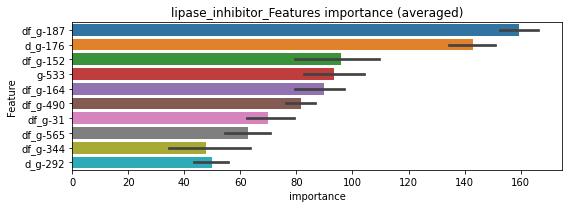

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101322	valid_1's binary_logloss: 0.0146454
[200]	training's binary_logloss: 0.000980287	valid_1's binary_logloss: 0.00394562
[300]	training's binary_logloss: 0.000271853	valid_1's binary_logloss: 0.00314231
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000283892	valid_1's binary_logloss: 0.00312499


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108242	valid_1's binary_logloss: 0.012884
[200]	training's binary_logloss: 0.00106985	valid_1's binary_logloss: 0.00228301
[300]	training's binary_logloss: 0.000283761	valid_1's binary_logloss: 0.00135897
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000195331	valid_1's binary_logloss: 0.00126105


lipase_inhibitor logloss: 0.0021930183218489387


neg labels: 3289 → selected neg labels: 3278


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510903	valid_1's binary_logloss: 0.108624
[200]	training's binary_logloss: 0.0101085	valid_1's binary_logloss: 0.0579543
[300]	training's binary_logloss: 0.00285743	valid_1's binary_logloss: 0.0466975
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00163689	valid_1's binary_logloss: 0.0439928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050977	valid_1's binary_logloss: 0.103685
[200]	training's binary_logloss: 0.00965172	valid_1's binary_logloss: 0.0506059
[300]	training's binary_logloss: 0.00274804	valid_1's binary_logloss: 0.0360778
[400]	training's binary_logloss: 0.00126759	valid_1's binary_logloss: 0.0316561
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00102761	valid_1's binary_logloss: 0.0306921


1 / 3 AUC score:0.999
y_Threshold: 0.0112228, Threshold: 0.0170204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01532, conf_1:0.01872
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0170204
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_2: 0.0270204
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.0370204
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_4: 0.0470204
threshold: 0.0470204, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515523	valid_1's binary_logloss: 0.106997
[200]	training's binary_logloss: 0.00962217	valid_1's binary_logloss: 0.0559644
[300]	training's binary_logloss: 0.00276151	valid_1's binary_logloss: 0.0457643
[400]	training's binary_logloss: 0.00127345	valid_1's binary_logloss: 0.0420664
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00125123	valid_1's binary_logloss: 0.0419136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511418	valid_1's binary_logloss: 0.104918
[200]	training's binary_logloss: 0.00983069	valid_1's binary_logloss: 0.0516662
[300]	training's binary_logloss: 0.00273163	valid_1's binary_logloss: 0.0385885
[400]	training's binary_logloss: 0.00125585	valid_1's binary_logloss: 0.0355356
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00105745	valid_1's binary_logloss: 0.034926


2 / 3 AUC score:0.998
y_Threshold: 0.0271932, Threshold: 0.0470204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 637.0/3765
p_label_rate: 0.0115520 Vs.target_rate: 0.00256
Num_p_label: 46.0, conf_0:0.04232, conf_1:0.05172
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_1: 0.0470204
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_2: 0.0570204
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_3: 0.0670204
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_4: 0.0770204
threshold: 0.0770204, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 637.0/3765, y_label_rate: 0.1691899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048038	valid_1's binary_logloss: 0.102092
[200]	training's binary_logloss: 0.00902087	valid_1's binary_logloss: 0.0507831
[300]	training's binary_logloss: 0.00257323	valid_1's binary_logloss: 0.0399868
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00211952	valid_1's binary_logloss: 0.0390435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467948	valid_1's binary_logloss: 0.0996383
[200]	training's binary_logloss: 0.00877013	valid_1's binary_logloss: 0.0552075
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0041652	valid_1's binary_logloss: 0.0488006


3 / 3 AUC score:0.999
y_Threshold: 0.0402820, Threshold: 0.0770204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 622.0/3735
p_label_rate: 0.0102963 Vs.target_rate: 0.00256
Num_p_label: 41.0, conf_0:0.06932, conf_1:0.08472
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_1: 0.0770204
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.0870204
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_3: 0.0970204
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_4: 0.1070204
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_5: 0.1170204
threshold: 0.1170204, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 638.0/7717, y_label_rate: 0.0826746


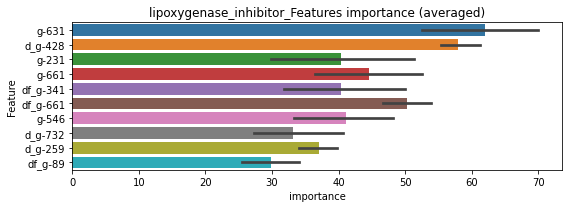

len(train_index) : 3858
len(valid_index) : 3859
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270098	valid_1's binary_logloss: 0.0560702
[200]	training's binary_logloss: 0.00507574	valid_1's binary_logloss: 0.0317126
[300]	training's binary_logloss: 0.0014177	valid_1's binary_logloss: 0.0270065
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0010862	valid_1's binary_logloss: 0.0265777


len(train_index) : 3859
len(valid_index) : 3858
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026659	valid_1's binary_logloss: 0.0600868
[200]	training's binary_logloss: 0.00520465	valid_1's binary_logloss: 0.0329481
[300]	training's binary_logloss: 0.00143455	valid_1's binary_logloss: 0.0257534
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000948066	valid_1's binary_logloss: 0.0246637


lipoxygenase_inhibitor logloss: 0.025620814603887623


neg labels: 3289 → selected neg labels: 3288


lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152569	valid_1's binary_logloss: 0.016919
[200]	training's binary_logloss: 0.00117	valid_1's binary_logloss: 0.00235674
[300]	training's binary_logloss: 0.000299025	valid_1's binary_logloss: 0.00127608
[400]	training's binary_logloss: 0.000191764	valid_1's binary_logloss: 0.0010636
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000191495	valid_1's binary_logloss: 0.0010632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154805	valid_1's binary_logloss: 0.016246
[200]	training's binary_logloss: 0.00120247	valid_1's binary_logloss: 0.00136541
[300]	training's binary_logloss: 0.000301702	valid_1's binary_logloss: 0.000378067
[400]	training's binary_logloss: 0.000191684	valid_1's binary_logloss: 0.000254244
[500]	training's binary_logloss: 0.000172887	valid_1's binary_logloss: 0.000232456
[600]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0004977, Threshold: 0.0020689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00186, conf_1:0.00228
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0020689
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_2: 0.0120689
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_3: 0.0220689
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.0320689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.0420689
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0520689
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0620689
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.0720689
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.0820689
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.0920689
threshold: 0.1020689, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159121	valid_1's binary_logloss: 0.0175784
[200]	training's binary_logloss: 0.00122436	valid_1's binary_logloss: 0.00211519
[300]	training's binary_logloss: 0.000291183	valid_1's binary_logloss: 0.000863234
[400]	training's binary_logloss: 0.000185454	valid_1's binary_logloss: 0.000688328
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000170306	valid_1's binary_logloss: 0.000665824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160155	valid_1's binary_logloss: 0.0164101
[200]	training's binary_logloss: 0.00124765	valid_1's binary_logloss: 0.00134749
[300]	training's binary_logloss: 0.000302158	valid_1's binary_logloss: 0.000358349
[400]	training's binary_logloss: 0.000188112	valid_1's binary_logloss: 0.00022859
[500]	training's binary_logloss: 0.000167763	valid_1's binary_logloss: 0.000203331
[600]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1575030, Threshold: 0.1020689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00025
Num_p_label: 22.0, conf_0:0.09186, conf_1:0.11228
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_1: 0.1020689
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_2: 0.1120689
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_3: 0.1220689
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_4: 0.1320689
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_5: 0.1420689
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_6: 0.1520689
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_7: 0.1620689
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.1720689
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.1820689
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_10: 0.1920689
threshold: 0.2020689, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159121	valid_1's binary_logloss: 0.0175784
[200]	training's binary_logloss: 0.00122436	valid_1's binary_logloss: 0.00211519
[300]	training's binary_logloss: 0.000291183	valid_1's binary_logloss: 0.000863234
[400]	training's binary_logloss: 0.000185454	valid_1's binary_logloss: 0.000688328
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000170306	valid_1's binary_logloss: 0.000665824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160155	valid_1's binary_logloss: 0.0164101
[200]	training's binary_logloss: 0.00124765	valid_1's binary_logloss: 0.00134749
[300]	training's binary_logloss: 0.000302158	valid_1's binary_logloss: 0.000358349
[400]	training's binary_logloss: 0.000188112	valid_1's binary_logloss: 0.00022859
[500]	training's binary_logloss: 0.000167763	valid_1's binary_logloss: 0.000203331
[600]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1575030, Threshold: 0.2020689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025
Num_p_label: 9.0, conf_0:0.18186, conf_1:0.22228
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.2020689
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.2120689
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.2220689
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.2320689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.2420689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.2520689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.2620689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.2720689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.2820689
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.2920689
threshold: 0.3020689, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


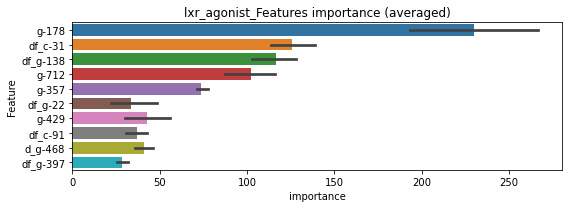

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00854694	valid_1's binary_logloss: 0.0117128
[200]	training's binary_logloss: 0.000650555	valid_1's binary_logloss: 0.00403105
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000185244	valid_1's binary_logloss: 0.00346422


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00873808	valid_1's binary_logloss: 0.00951098
[200]	training's binary_logloss: 0.000699235	valid_1's binary_logloss: 0.0016631
[300]	training's binary_logloss: 0.000173757	valid_1's binary_logloss: 0.00118858
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000122093	valid_1's binary_logloss: 0.00113873


lxr_agonist logloss: 0.0023016230013514927


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225234	valid_1's binary_logloss: 0.0350276
[200]	training's binary_logloss: 0.00259897	valid_1's binary_logloss: 0.00772293
[300]	training's binary_logloss: 0.000741649	valid_1's binary_logloss: 0.00376951
[400]	training's binary_logloss: 0.000398677	valid_1's binary_logloss: 0.0026537
[500]	training's binary_logloss: 0.00031778	valid_1's binary_logloss: 0.00238106
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000316297	valid_1's binary_logloss: 0.00237756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224424	valid_1's binary_logloss: 0.0301903
[200]	training's binary_logloss: 0.00261294	valid_1's binary_logloss: 0.00609539
[300]	training's binary_logloss: 0.000750575	valid_1's binary_logloss: 0.00285368
[400]	training's binary_logloss: 0.000403838	valid_1's binary_logloss: 0.00191664
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0035387, Threshold: 0.0060273, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00542, conf_1:0.00663
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0060273
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_2: 0.0160273
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_3: 0.0260273
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.0360273
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_5: 0.0460273
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_6: 0.0560273
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_7: 0.0660273
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_8: 0.0760273
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_9: 0.0860273
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_10: 0.0960273
threshold: 0.1060273, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214651	valid_1's binary_logloss: 0.029737
[200]	training's binary_logloss: 0.002292	valid_1's binary_logloss: 0.00548279
[300]	training's binary_logloss: 0.000631996	valid_1's binary_logloss: 0.00225724
[400]	training's binary_logloss: 0.000351792	valid_1's binary_logloss: 0.00149594
[500]	training's binary_logloss: 0.000291471	valid_1's binary_logloss: 0.00132785
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000288265	valid_1's binary_logloss: 0.00131922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212529	valid_1's binary_logloss: 0.0284209
[200]	training's binary_logloss: 0.00229516	valid_1's binary_logloss: 0.00477147
[300]	training's binary_logloss: 0.000639966	valid_1's binary_logloss: 0.00188665
[400]	training's binary_logloss: 0.00035465	valid_1's binary_logloss: 0.00125037
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.2276936, Threshold: 0.1060273, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0140633 Vs.target_rate: 0.00130
Num_p_label: 56.0, conf_0:0.09542, conf_1:0.11663
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_1: 0.1060273
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_2: 0.1160273
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_3: 0.1260273
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_4: 0.1360273
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_5: 0.1460273
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_6: 0.1560273
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_7: 0.1660273
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_8: 0.1760273
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_9: 0.1860273
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_10: 0.1960273
threshold: 0.2060273, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214651	valid_1's binary_logloss: 0.029737
[200]	training's binary_logloss: 0.002292	valid_1's binary_logloss: 0.00548279
[300]	training's binary_logloss: 0.000631996	valid_1's binary_logloss: 0.00225724
[400]	training's binary_logloss: 0.000351792	valid_1's binary_logloss: 0.00149594
[500]	training's binary_logloss: 0.000291471	valid_1's binary_logloss: 0.00132785
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000288265	valid_1's binary_logloss: 0.00131922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212529	valid_1's binary_logloss: 0.0284209
[200]	training's binary_logloss: 0.00229516	valid_1's binary_logloss: 0.00477147
[300]	training's binary_logloss: 0.000639966	valid_1's binary_logloss: 0.00188665
[400]	training's binary_logloss: 0.00035465	valid_1's binary_logloss: 0.00125037
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.2276936, Threshold: 0.2060273, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0120542 Vs.target_rate: 0.00130
Num_p_label: 48.0, conf_0:0.18542, conf_1:0.22663
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_1: 0.2060273
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_2: 0.2160273
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_3: 0.2260273
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_4: 0.2360273
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_5: 0.2460273
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_6: 0.2560273
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_7: 0.2660273
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_8: 0.2760273
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_9: 0.2860273
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_10: 0.2960273
threshold: 0.3060273, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 695.0/7790, y_label_rate: 0.0892169


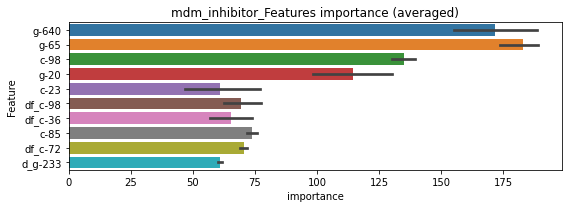

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012425	valid_1's binary_logloss: 0.0214913
[200]	training's binary_logloss: 0.00139592	valid_1's binary_logloss: 0.0083182
[300]	training's binary_logloss: 0.000392207	valid_1's binary_logloss: 0.00659653
[400]	training's binary_logloss: 0.000213541	valid_1's binary_logloss: 0.00642287
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000221947	valid_1's binary_logloss: 0.00642281


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126993	valid_1's binary_logloss: 0.0216831
[200]	training's binary_logloss: 0.00147556	valid_1's binary_logloss: 0.00883585
[300]	training's binary_logloss: 0.00042773	valid_1's binary_logloss: 0.00672242
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000261161	valid_1's binary_logloss: 0.00643715


mdm_inhibitor logloss: 0.006429983521064996


neg labels: 3289 → selected neg labels: 3278


mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280768	valid_1's binary_logloss: 0.0436839
[200]	training's binary_logloss: 0.00390013	valid_1's binary_logloss: 0.0179897
[300]	training's binary_logloss: 0.00110777	valid_1's binary_logloss: 0.0144198
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000672829	valid_1's binary_logloss: 0.0139386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282525	valid_1's binary_logloss: 0.0545609
[200]	training's binary_logloss: 0.00374701	valid_1's binary_logloss: 0.0281445
[300]	training's binary_logloss: 0.00105668	valid_1's binary_logloss: 0.0239006
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000999186	valid_1's binary_logloss: 0.023823


1 / 3 AUC score:0.999
y_Threshold: 0.0042188, Threshold: 0.0097732, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.00880, conf_1:0.01075
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0097732
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_2: 0.0197732
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_3: 0.0297732
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_4: 0.0397732
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_5: 0.0497732
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_6: 0.0597732
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_7: 0.0697732
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_8: 0.0797732
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_9: 0.0897732
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_10: 0.0997732
threshold: 0.1097732, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 652.0/3795, y_label_rate: 0.1718050

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279195	valid_1's binary_logloss: 0.0404713
[200]	training's binary_logloss: 0.00355075	valid_1's binary_logloss: 0.0105269
[300]	training's binary_logloss: 0.00098476	valid_1's binary_logloss: 0.00572418
[400]	training's binary_logloss: 0.000494686	valid_1's binary_logloss: 0.00440337
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000516938	valid_1's binary_logloss: 0.00438597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262536	valid_1's binary_logloss: 0.0509257
[200]	training's binary_logloss: 0.00316403	valid_1's binary_logloss: 0.0251715
[300]	training's binary_logloss: 0.000881594	valid_1's binary_logloss: 0.0204609
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000762165	valid_1's binary_logloss: 0.0200518


2 / 3 AUC score:1.000
y_Threshold: 0.0651432, Threshold: 0.1097732, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0120542 Vs.target_rate: 0.00302
Num_p_label: 48.0, conf_0:0.09880, conf_1:0.12075
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_1: 0.1097732
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.1197732
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_3: 0.1297732
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.1397732
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.1497732
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_6: 0.1597732
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_7: 0.1697732
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_8: 0.1797732
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_9: 0.1897732
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_10: 0.1997732
threshold: 0.2097732, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281463	valid_1's binary_logloss: 0.0385912
[200]	training's binary_logloss: 0.0034868	valid_1's binary_logloss: 0.0103401
[300]	training's binary_logloss: 0.000973607	valid_1's binary_logloss: 0.00592476
[400]	training's binary_logloss: 0.000501845	valid_1's binary_logloss: 0.00475426
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00037911	valid_1's binary_logloss: 0.00427138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255637	valid_1's binary_logloss: 0.0542839
[200]	training's binary_logloss: 0.00311933	valid_1's binary_logloss: 0.026668
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00111583	valid_1's binary_logloss: 0.0231751


3 / 3 AUC score:1.000
y_Threshold: 0.0390916, Threshold: 0.2097732, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3791
p_label_rate: 0.0113009 Vs.target_rate: 0.00302
Num_p_label: 45.0, conf_0:0.18880, conf_1:0.23075
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_1: 0.2097732
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_2: 0.2197732
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_3: 0.2297732
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_4: 0.2397732
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_5: 0.2497732
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_6: 0.2597732
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_7: 0.2697732
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_8: 0.2797732
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_9: 0.2897732
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_10: 0.2997732
threshold: 0.3097732, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 689.0/7773, y_label_rate: 0.0886402

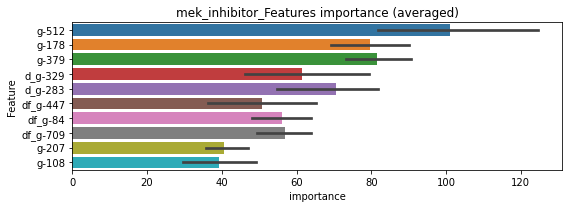

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137509	valid_1's binary_logloss: 0.0293345
[200]	training's binary_logloss: 0.00167557	valid_1's binary_logloss: 0.0131579
[300]	training's binary_logloss: 0.000482254	valid_1's binary_logloss: 0.010096
[400]	training's binary_logloss: 0.000244762	valid_1's binary_logloss: 0.0090032
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000242691	valid_1's binary_logloss: 0.00899279


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146344	valid_1's binary_logloss: 0.0235598
[200]	training's binary_logloss: 0.00175836	valid_1's binary_logloss: 0.00826078
[300]	training's binary_logloss: 0.000498134	valid_1's binary_logloss: 0.00558503
[400]	training's binary_logloss: 0.00025493	valid_1's binary_logloss: 0.00493384
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000213441	valid_1's binary_logloss: 0.00482977


mek_inhibitor logloss: 0.006911546600317803


neg labels: 3289 → selected neg labels: 3278


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548641	valid_1's binary_logloss: 0.103325
[200]	training's binary_logloss: 0.0118362	valid_1's binary_logloss: 0.0543174
[300]	training's binary_logloss: 0.00351161	valid_1's binary_logloss: 0.040644
[400]	training's binary_logloss: 0.0015473	valid_1's binary_logloss: 0.0362365
[500]	training's binary_logloss: 0.000928647	valid_1's binary_logloss: 0.0345598
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000859832	valid_1's binary_logloss: 0.0343451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547404	valid_1's binary_logloss: 0.117332
[200]	training's binary_logloss: 0.0113202	valid_1's binary_logloss: 0.0682324
[300]	training's binary_logloss: 0.00327062	valid_1's binary_logloss: 0.0578728
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00214239	valid_1's binary_logloss: 0.0563337


1 / 3 AUC score:0.995
y_Threshold: 0.0136918, Threshold: 0.0221421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 644/3779
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.01993, conf_1:0.02436
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0221421
Num_p_label: 46.0, Expected: 12.4, Adj_threshold_2: 0.0321421
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_3: 0.0421421
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_4: 0.0521421
threshold: 0.0521421, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 644.0/3779, y_label_rate: 0.1704155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05165	valid_1's binary_logloss: 0.117283
[200]	training's binary_logloss: 0.0105629	valid_1's binary_logloss: 0.0701103
[300]	training's binary_logloss: 0.00306243	valid_1's binary_logloss: 0.0578303
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00272796	valid_1's binary_logloss: 0.0568104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503018	valid_1's binary_logloss: 0.114105
[200]	training's binary_logloss: 0.00980412	valid_1's binary_logloss: 0.0717778
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00361977	valid_1's binary_logloss: 0.0641069


2 / 3 AUC score:0.993
y_Threshold: 0.0419314, Threshold: 0.0521421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 622.0/3735
p_label_rate: 0.0148167 Vs.target_rate: 0.00311
Num_p_label: 59.0, conf_0:0.04693, conf_1:0.05736
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_1: 0.0521421
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_2: 0.0621421
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_3: 0.0721421
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_4: 0.0821421
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_5: 0.0921421
threshold: 0.0921421, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 622.0/3735, y_label_rate: 0.1665328
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487875	valid_1's binary_logloss: 0.100132
[200]	training's binary_logloss: 0.00954944	valid_1's binary_logloss: 0.0512915
[300]	training's binary_logloss: 0.00277638	valid_1's binary_logloss: 0.0375587
[400]	training's binary_logloss: 0.00126603	valid_1's binary_logloss: 0.0336767
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00113737	valid_1's binary_logloss: 0.0330911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485841	valid_1's binary_logloss: 0.0893369
[200]	training's binary_logloss: 0.00920373	valid_1's binary_logloss: 0.0385374
[300]	training's binary_logloss: 0.00269942	valid_1's binary_logloss: 0.0257998
[400]	training's binary_logloss: 0.00125492	valid_1's binary_logloss: 0.0218044
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00118343	valid_1's binary_logloss: 0.0216404


3 / 3 AUC score:0.999
y_Threshold: 0.0434841, Threshold: 0.0921421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 616.0/3723
p_label_rate: 0.0040181 Vs.target_rate: 0.00311
Num_p_label: 16.0, conf_0:0.08293, conf_1:0.10136
threshold: 0.0921421, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 632.0/7705, y_label_rate: 0.0820247


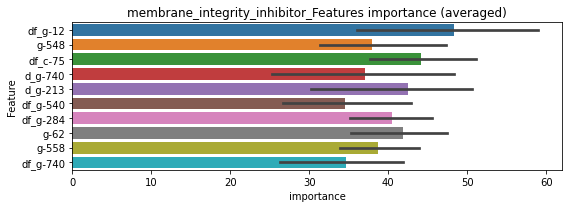

len(train_index) : 3852
len(valid_index) : 3853
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259253	valid_1's binary_logloss: 0.0608526
[200]	training's binary_logloss: 0.00487203	valid_1's binary_logloss: 0.0400066
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00150844	valid_1's binary_logloss: 0.0377482


len(train_index) : 3853
len(valid_index) : 3852
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261194	valid_1's binary_logloss: 0.0569876
[200]	training's binary_logloss: 0.00487178	valid_1's binary_logloss: 0.0333198
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00166106	valid_1's binary_logloss: 0.0296057


membrane_integrity_inhibitor logloss: 0.03367743432902073


neg labels: 3289 → selected neg labels: 3285


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289327	valid_1's binary_logloss: 0.0498564
[200]	training's binary_logloss: 0.00371952	valid_1's binary_logloss: 0.0152903
[300]	training's binary_logloss: 0.00102898	valid_1's binary_logloss: 0.00891563
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000597438	valid_1's binary_logloss: 0.00748606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301953	valid_1's binary_logloss: 0.0391986
[200]	training's binary_logloss: 0.00404146	valid_1's binary_logloss: 0.00725701
[300]	training's binary_logloss: 0.00109474	valid_1's binary_logloss: 0.00246736
[400]	training's binary_logloss: 0.000550342	valid_1's binary_logloss: 0.00143973
[500]	training's binary_logloss: 0.000395598	valid_1's binary_logloss: 0.00110398
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000376681	valid_1's binary_logloss: 0.00106822

1 / 3 AUC score:1.000
y_Threshold: 0.0027173, Threshold: 0.0048740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00439, conf_1:0.00536
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0048740
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0148740
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0248740
threshold: 0.0248740, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282511	valid_1's binary_logloss: 0.0482488
[200]	training's binary_logloss: 0.00359499	valid_1's binary_logloss: 0.0135286
[300]	training's binary_logloss: 0.000991022	valid_1's binary_logloss: 0.00746783
[400]	training's binary_logloss: 0.000511139	valid_1's binary_logloss: 0.00587753
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000434606	valid_1's binary_logloss: 0.00557045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287705	valid_1's binary_logloss: 0.0382744
[200]	training's binary_logloss: 0.00375822	valid_1's binary_logloss: 0.00796356
[300]	training's binary_logloss: 0.00104374	valid_1's binary_logloss: 0.00331009
[400]	training's binary_logloss: 0.000538313	valid_1's binary_logloss: 0.00215746
[500]	training's binary_logloss: 0.000391161	valid_1's binary_logloss: 0.00182106
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0216653, Threshold: 0.0248740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00105
Num_p_label: 16.0, conf_0:0.02239, conf_1:0.02736
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.0248740
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.0348740
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.0448740
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.0548740
threshold: 0.0548740, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282511	valid_1's binary_logloss: 0.0482488
[200]	training's binary_logloss: 0.00359499	valid_1's binary_logloss: 0.0135286
[300]	training's binary_logloss: 0.000991022	valid_1's binary_logloss: 0.00746783
[400]	training's binary_logloss: 0.000511139	valid_1's binary_logloss: 0.00587753
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000434606	valid_1's binary_logloss: 0.00557045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287705	valid_1's binary_logloss: 0.0382744
[200]	training's binary_logloss: 0.00375822	valid_1's binary_logloss: 0.00796356
[300]	training's binary_logloss: 0.00104374	valid_1's binary_logloss: 0.00331009
[400]	training's binary_logloss: 0.000538313	valid_1's binary_logloss: 0.00215746
[500]	training's binary_logloss: 0.000391161	valid_1's binary_logloss: 0.00182106
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0216653, Threshold: 0.0548740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.04939, conf_1:0.06036
threshold: 0.0548740, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


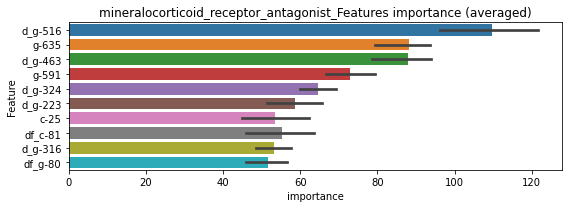

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161939	valid_1's binary_logloss: 0.0291739
[200]	training's binary_logloss: 0.00211719	valid_1's binary_logloss: 0.0122298
[300]	training's binary_logloss: 0.000553793	valid_1's binary_logloss: 0.00979556
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000587026	valid_1's binary_logloss: 0.00974681


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165294	valid_1's binary_logloss: 0.0243624
[200]	training's binary_logloss: 0.00215024	valid_1's binary_logloss: 0.00616406
[300]	training's binary_logloss: 0.000583957	valid_1's binary_logloss: 0.00354664
[400]	training's binary_logloss: 0.000287395	valid_1's binary_logloss: 0.00295907
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00021294	valid_1's binary_logloss: 0.00277127


mineralocorticoid_receptor_antagonist logloss: 0.0062590373085524426


neg labels: 3289 → selected neg labels: 3287


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184607	valid_1's binary_logloss: 0.0246795
[200]	training's binary_logloss: 0.00191182	valid_1's binary_logloss: 0.00516797
[300]	training's binary_logloss: 0.000554271	valid_1's binary_logloss: 0.00238103
[400]	training's binary_logloss: 0.000311996	valid_1's binary_logloss: 0.00170056
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000274108	valid_1's binary_logloss: 0.00160887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187227	valid_1's binary_logloss: 0.0209195
[200]	training's binary_logloss: 0.00191597	valid_1's binary_logloss: 0.00275092
[300]	training's binary_logloss: 0.000556732	valid_1's binary_logloss: 0.00091635
[400]	training's binary_logloss: 0.00031534	valid_1's binary_logloss: 0.000543355
[500]	training's binary_logloss: 0.000272504	valid_1's binary_logloss: 0.00047502
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0009436, Threshold: 0.0016897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00152, conf_1:0.00186
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016897
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0116897
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0216897
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0316897
threshold: 0.0316897, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184112	valid_1's binary_logloss: 0.0250985
[200]	training's binary_logloss: 0.00182956	valid_1's binary_logloss: 0.00586658
[300]	training's binary_logloss: 0.00054145	valid_1's binary_logloss: 0.00307732
[400]	training's binary_logloss: 0.000314653	valid_1's binary_logloss: 0.00230712
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000303103	valid_1's binary_logloss: 0.00229828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186896	valid_1's binary_logloss: 0.0202814
[200]	training's binary_logloss: 0.00185438	valid_1's binary_logloss: 0.00224464
[300]	training's binary_logloss: 0.000540833	valid_1's binary_logloss: 0.000706216
[400]	training's binary_logloss: 0.00031253	valid_1's binary_logloss: 0.000418614
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000273425	valid_1's binary_logloss: 0.00036

2 / 3 AUC score:1.000
y_Threshold: 0.0265034, Threshold: 0.0316897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0040181 Vs.target_rate: 0.00050
Num_p_label: 16.0, conf_0:0.02852, conf_1:0.03486
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_1: 0.0316897
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.0416897
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0516897
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0616897
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.0716897
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0816897
threshold: 0.0816897, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184112	valid_1's binary_logloss: 0.0250985
[200]	training's binary_logloss: 0.00182956	valid_1's binary_logloss: 0.00586658
[300]	training's binary_logloss: 0.00054145	valid_1's binary_logloss: 0.00307732
[400]	training's binary_logloss: 0.000314653	valid_1's binary_logloss: 0.00230712
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000303103	valid_1's binary_logloss: 0.00229828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186896	valid_1's binary_logloss: 0.0202814
[200]	training's binary_logloss: 0.00185438	valid_1's binary_logloss: 0.00224464
[300]	training's binary_logloss: 0.000540833	valid_1's binary_logloss: 0.000706216
[400]	training's binary_logloss: 0.00031253	valid_1's binary_logloss: 0.000418614
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000273425	valid_1's binary_logloss: 0.00036

3 / 3 AUC score:1.000
y_Threshold: 0.0265034, Threshold: 0.0816897, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.07352, conf_1:0.08986
threshold: 0.0816897, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


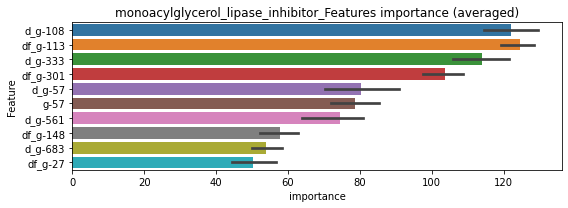

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100387	valid_1's binary_logloss: 0.0144587
[200]	training's binary_logloss: 0.000993266	valid_1's binary_logloss: 0.00419011
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.000545963	valid_1's binary_logloss: 0.00381029


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103056	valid_1's binary_logloss: 0.0134583
[200]	training's binary_logloss: 0.00104214	valid_1's binary_logloss: 0.00303615
[300]	training's binary_logloss: 0.000295059	valid_1's binary_logloss: 0.00193125
[400]	training's binary_logloss: 0.000163532	valid_1's binary_logloss: 0.00173992
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000153336	valid_1's binary_logloss: 0.0017078


monoacylglycerol_lipase_inhibitor logloss: 0.002759047676941642


neg labels: 3289 → selected neg labels: 3274


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602912	valid_1's binary_logloss: 0.12252
[200]	training's binary_logloss: 0.0142334	valid_1's binary_logloss: 0.0632759
[300]	training's binary_logloss: 0.00433962	valid_1's binary_logloss: 0.0470883
[400]	training's binary_logloss: 0.00189078	valid_1's binary_logloss: 0.043374
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00147462	valid_1's binary_logloss: 0.0428633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631691	valid_1's binary_logloss: 0.129409
[200]	training's binary_logloss: 0.0140579	valid_1's binary_logloss: 0.0716737
[300]	training's binary_logloss: 0.00410622	valid_1's binary_logloss: 0.0560329
[400]	training's binary_logloss: 0.00180393	valid_1's binary_logloss: 0.0517434
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00172183	valid_1's binary_logloss: 0.051719


1 / 3 AUC score:0.994
y_Threshold: 0.0166629, Threshold: 0.0251690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00357
Num_p_label: 80.0, conf_0:0.02265, conf_1:0.02769
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0251690
Num_p_label: 37.0, Expected: 14.2, Adj_threshold_2: 0.0351690
Num_p_label: 20.0, Expected: 14.2, Adj_threshold_3: 0.0451690
threshold: 0.0451690, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3776, y_label_rate: 0.1705508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531226	valid_1's binary_logloss: 0.143224
[200]	training's binary_logloss: 0.0114285	valid_1's binary_logloss: 0.0967956
[300]	training's binary_logloss: 0.00336886	valid_1's binary_logloss: 0.0865882
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00293784	valid_1's binary_logloss: 0.0856344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596967	valid_1's binary_logloss: 0.114861
[200]	training's binary_logloss: 0.0126429	valid_1's binary_logloss: 0.0585578
[300]	training's binary_logloss: 0.00373243	valid_1's binary_logloss: 0.0427603
[400]	training's binary_logloss: 0.00168159	valid_1's binary_logloss: 0.0378811
[500]	training's binary_logloss: 0.00100895	valid_1's binary_logloss: 0.0360261
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00103774	valid_1's binary_logloss: 0.0360092


2 / 3 AUC score:0.996
y_Threshold: 0.0471875, Threshold: 0.0451690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 621.0/3730
p_label_rate: 0.0165746 Vs.target_rate: 0.00357
Num_p_label: 66.0, conf_0:0.04065, conf_1:0.04969
Num_p_label: 66.0, Expected: 14.2, Adj_threshold_1: 0.0451690
Num_p_label: 52.0, Expected: 14.2, Adj_threshold_2: 0.0551690
Num_p_label: 35.0, Expected: 14.2, Adj_threshold_3: 0.0651690
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_4: 0.0751690
threshold: 0.0751690, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 621.0/3730, y_label_rate: 0.1664879
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546466	valid_1's binary_logloss: 0.115942
[200]	training's binary_logloss: 0.0113993	valid_1's binary_logloss: 0.0629472
[300]	training's binary_logloss: 0.00334022	valid_1's binary_logloss: 0.0473388
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00245957	valid_1's binary_logloss: 0.0454032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518168	valid_1's binary_logloss: 0.131946
[200]	training's binary_logloss: 0.0103339	valid_1's binary_logloss: 0.087576
[300]	training's binary_logloss: 0.00307267	valid_1's binary_logloss: 0.0791415
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00282898	valid_1's binary_logloss: 0.0787114


3 / 3 AUC score:0.995
y_Threshold: 0.0523142, Threshold: 0.0751690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 601.0/3690
p_label_rate: 0.0102963 Vs.target_rate: 0.00357
Num_p_label: 41.0, conf_0:0.06765, conf_1:0.08269
threshold: 0.0751690, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 642.0/7672, y_label_rate: 0.0836809


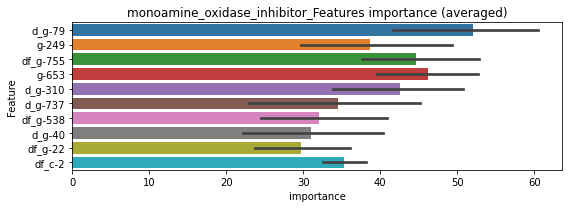

len(train_index) : 3836
len(valid_index) : 3836
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321485	valid_1's binary_logloss: 0.077866
[200]	training's binary_logloss: 0.00668916	valid_1's binary_logloss: 0.0540363
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00338103	valid_1's binary_logloss: 0.0519324


len(train_index) : 3836
len(valid_index) : 3836
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316004	valid_1's binary_logloss: 0.0821206
[200]	training's binary_logloss: 0.00669813	valid_1's binary_logloss: 0.0584
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00225453	valid_1's binary_logloss: 0.0550388


monoamine_oxidase_inhibitor logloss: 0.05348560267574009


neg labels: 3289 → selected neg labels: 3286


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020677	valid_1's binary_logloss: 0.0263248
[200]	training's binary_logloss: 0.00225076	valid_1's binary_logloss: 0.00386333
[300]	training's binary_logloss: 0.000633192	valid_1's binary_logloss: 0.00139533
[400]	training's binary_logloss: 0.000354353	valid_1's binary_logloss: 0.000895573
[500]	training's binary_logloss: 0.000294374	valid_1's binary_logloss: 0.000775313
[600]	training's binary_logloss: 0.000284923	valid_1's binary_logloss: 0.000757043
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000284708	valid_1's binary_logloss: 0.000756528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210266	valid_1's binary_logloss: 0.0273887
[200]	training's binary_logloss: 0.00232544	valid_1's binary_logloss: 0.00445447
[300]	training's binary_logloss: 0.000663298	valid_1's binary_logloss: 0.00180789
[400]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0015641, Threshold: 0.0028588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00257, conf_1:0.00314
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028588
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0128588
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0228588
threshold: 0.0228588, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020641	valid_1's binary_logloss: 0.0259323
[200]	training's binary_logloss: 0.00220462	valid_1's binary_logloss: 0.00358255
[300]	training's binary_logloss: 0.000620101	valid_1's binary_logloss: 0.00121898
[400]	training's binary_logloss: 0.000345838	valid_1's binary_logloss: 0.000743944
[500]	training's binary_logloss: 0.000289598	valid_1's binary_logloss: 0.000648386
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000281211	valid_1's binary_logloss: 0.000634198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208211	valid_1's binary_logloss: 0.027181
[200]	training's binary_logloss: 0.00223843	valid_1's binary_logloss: 0.00410392
[300]	training's binary_logloss: 0.000634822	valid_1's binary_logloss: 0.0016629
[400]	training's binary_logloss: 0.000353201	valid_1's binary_logloss: 0.00110537
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1571312, Threshold: 0.0228588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00076
Num_p_label: 25.0, conf_0:0.02057, conf_1:0.02514
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.0228588
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0328588
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0428588
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.0528588
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0628588
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.0728588
threshold: 0.0728588, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020641	valid_1's binary_logloss: 0.0259323
[200]	training's binary_logloss: 0.00220462	valid_1's binary_logloss: 0.00358255
[300]	training's binary_logloss: 0.000620101	valid_1's binary_logloss: 0.00121898
[400]	training's binary_logloss: 0.000345838	valid_1's binary_logloss: 0.000743944
[500]	training's binary_logloss: 0.000289598	valid_1's binary_logloss: 0.000648386
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000281211	valid_1's binary_logloss: 0.000634198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208211	valid_1's binary_logloss: 0.027181
[200]	training's binary_logloss: 0.00223843	valid_1's binary_logloss: 0.00410392
[300]	training's binary_logloss: 0.000634822	valid_1's binary_logloss: 0.0016629
[400]	training's binary_logloss: 0.000353201	valid_1's binary_logloss: 0.00110537
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1571312, Threshold: 0.0728588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.06557, conf_1:0.08014
threshold: 0.0728588, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


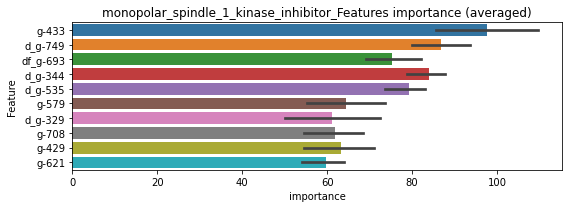

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110708	valid_1's binary_logloss: 0.0175204
[200]	training's binary_logloss: 0.00116631	valid_1's binary_logloss: 0.00703804
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000369758	valid_1's binary_logloss: 0.0064735


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113124	valid_1's binary_logloss: 0.0191574
[200]	training's binary_logloss: 0.00122998	valid_1's binary_logloss: 0.00637877
[300]	training's binary_logloss: 0.000343639	valid_1's binary_logloss: 0.00424148
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000200172	valid_1's binary_logloss: 0.00372364


monopolar_spindle_1_kinase_inhibitor logloss: 0.005098747190192195


neg labels: 3289 → selected neg labels: 3267


mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300667	valid_1's binary_logloss: 0.0756469
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00656644	valid_1's binary_logloss: 0.0566932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033655	valid_1's binary_logloss: 0.0683671
[200]	training's binary_logloss: 0.00524643	valid_1's binary_logloss: 0.0433692
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0036501	valid_1's binary_logloss: 0.0418543


1 / 3 AUC score:0.991
y_Threshold: 0.0122082, Threshold: 0.0891621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → Positive_corect_labels: 643/3769
p_label_rate: 0.0200904 Vs.target_rate: 0.00546
Num_p_label: 80.0, conf_0:0.08025, conf_1:0.09808
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.0891621
Num_p_label: 77.0, Expected: 21.7, Adj_threshold_2: 0.0991621
Num_p_label: 73.0, Expected: 21.7, Adj_threshold_3: 0.1091621
Num_p_label: 71.0, Expected: 21.7, Adj_threshold_4: 0.1191621
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_5: 0.1291621
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_6: 0.1391621
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_7: 0.1491621
Num_p_label: 67.0, Expected: 21.7, Adj_threshold_8: 0.1591621
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_9: 0.1691621
Num_p_label: 61.0, Expected: 21.7, Adj_threshold_10: 0.1791621
threshold: 0.1891621, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 643.0/3769, y_label_rate: 0.1706023

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278135	valid_1's binary_logloss: 0.0465158
[200]	training's binary_logloss: 0.00375448	valid_1's binary_logloss: 0.0203065
[300]	training's binary_logloss: 0.00108575	valid_1's binary_logloss: 0.0149729
[400]	training's binary_logloss: 0.000548522	valid_1's binary_logloss: 0.0135539
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000561088	valid_1's binary_logloss: 0.0135296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264336	valid_1's binary_logloss: 0.0770544
[200]	training's binary_logloss: 0.00336783	valid_1's binary_logloss: 0.0612393
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00348492	valid_1's binary_logloss: 0.0610052


2 / 3 AUC score:0.998
y_Threshold: 0.0255443, Threshold: 0.1891621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 627.0/3737
p_label_rate: 0.0391763 Vs.target_rate: 0.00546
Num_p_label: 156.0, conf_0:0.17025, conf_1:0.20808
Num_p_label: 156.0, Expected: 21.7, Adj_threshold_1: 0.1891621
Num_p_label: 153.0, Expected: 21.7, Adj_threshold_2: 0.1991621
Num_p_label: 152.0, Expected: 21.7, Adj_threshold_3: 0.2091621
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_4: 0.2191621
Num_p_label: 148.0, Expected: 21.7, Adj_threshold_5: 0.2291621
Num_p_label: 146.0, Expected: 21.7, Adj_threshold_6: 0.2391621
Num_p_label: 146.0, Expected: 21.7, Adj_threshold_7: 0.2491621
Num_p_label: 144.0, Expected: 21.7, Adj_threshold_8: 0.2591621
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_9: 0.2691621
Num_p_label: 138.0, Expected: 21.7, Adj_threshold_10: 0.2791621
threshold: 0.2891621, positive_p_label: 135.0/3982, p_label_rate: 0.0339026
positive_y_label: 627.0/3737, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259862	valid_1's binary_logloss: 0.0415518
[200]	training's binary_logloss: 0.00326958	valid_1's binary_logloss: 0.0173172
[300]	training's binary_logloss: 0.000912859	valid_1's binary_logloss: 0.0131036
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000809528	valid_1's binary_logloss: 0.012881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242932	valid_1's binary_logloss: 0.0539789
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00387792	valid_1's binary_logloss: 0.0356015


3 / 3 AUC score:1.000
y_Threshold: 0.0264972, Threshold: 0.2891621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 619.0/3721
p_label_rate: 0.0366650 Vs.target_rate: 0.00546
Num_p_label: 146.0, conf_0:0.26025, conf_1:0.31808
Num_p_label: 146.0, Expected: 21.7, Adj_threshold_1: 0.2891621
Num_p_label: 144.0, Expected: 21.7, Adj_threshold_2: 0.2991621
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_3: 0.3091621
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_4: 0.3191621
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_5: 0.3291621
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_6: 0.3391621
Num_p_label: 138.0, Expected: 21.7, Adj_threshold_7: 0.3491621
Num_p_label: 137.0, Expected: 21.7, Adj_threshold_8: 0.3591621
Num_p_label: 135.0, Expected: 21.7, Adj_threshold_9: 0.3691621
Num_p_label: 129.0, Expected: 21.7, Adj_threshold_10: 0.3791621
threshold: 0.3891621, positive_p_label: 125.0/3982, p_label_rate: 0.0313913
positive_y_label: 744.0/7703, y_label_ra

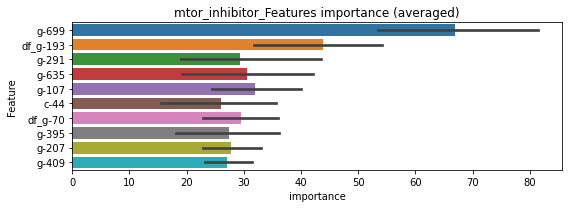

len(train_index) : 3851
len(valid_index) : 3852
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165268	valid_1's binary_logloss: 0.0377238
[200]	training's binary_logloss: 0.00233085	valid_1's binary_logloss: 0.0231665
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00149292	valid_1's binary_logloss: 0.0218929


len(train_index) : 3852
len(valid_index) : 3851
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169029	valid_1's binary_logloss: 0.0339269
[200]	training's binary_logloss: 0.00236844	valid_1's binary_logloss: 0.0213555
[300]	training's binary_logloss: 0.000686854	valid_1's binary_logloss: 0.0197774
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000692336	valid_1's binary_logloss: 0.019765


mtor_inhibitor logloss: 0.020829059423251917


neg labels: 3289 → selected neg labels: 3281


mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410065	valid_1's binary_logloss: 0.0879583
[200]	training's binary_logloss: 0.00688923	valid_1's binary_logloss: 0.0469719
[300]	training's binary_logloss: 0.00193115	valid_1's binary_logloss: 0.041028
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00178709	valid_1's binary_logloss: 0.0407881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410483	valid_1's binary_logloss: 0.0688402
[200]	training's binary_logloss: 0.00715958	valid_1's binary_logloss: 0.0202469
[300]	training's binary_logloss: 0.00205334	valid_1's binary_logloss: 0.00956892
[400]	training's binary_logloss: 0.000973163	valid_1's binary_logloss: 0.00668027
[500]	training's binary_logloss: 0.000627973	valid_1's binary_logloss: 0.00549064
[600]	training's binary_logloss: 0.000499284	valid_1's binary_logloss: 0.00505503
Early stopping, best iteration is:
[615

1 / 3 AUC score:0.997
y_Threshold: 0.0086195, Threshold: 0.0143377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01290, conf_1:0.01577
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0143377
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_2: 0.0243377
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.0343377
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.0443377
threshold: 0.0443377, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383529	valid_1's binary_logloss: 0.0779064
[200]	training's binary_logloss: 0.00636768	valid_1's binary_logloss: 0.0339471
[300]	training's binary_logloss: 0.00181338	valid_1's binary_logloss: 0.0219883
[400]	training's binary_logloss: 0.00087118	valid_1's binary_logloss: 0.0179103
[500]	training's binary_logloss: 0.000568272	valid_1's binary_logloss: 0.0163348
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000582569	valid_1's binary_logloss: 0.0162943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396636	valid_1's binary_logloss: 0.0804916
[200]	training's binary_logloss: 0.0064725	valid_1's binary_logloss: 0.0381555
[300]	training's binary_logloss: 0.00187373	valid_1's binary_logloss: 0.0298492
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00109974	valid_1's binary_logloss: 0.0271056


2 / 3 AUC score:1.000
y_Threshold: 0.0384155, Threshold: 0.0443377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3779
p_label_rate: 0.0097941 Vs.target_rate: 0.00202
Num_p_label: 39.0, conf_0:0.03990, conf_1:0.04877
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.0443377
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.0543377
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.0643377
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.0743377
threshold: 0.0743377, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 643.0/3779, y_label_rate: 0.1701508
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383651	valid_1's binary_logloss: 0.0800016
[200]	training's binary_logloss: 0.00625848	valid_1's binary_logloss: 0.0340778
[300]	training's binary_logloss: 0.00180294	valid_1's binary_logloss: 0.0232334
[400]	training's binary_logloss: 0.000856472	valid_1's binary_logloss: 0.0190426
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000770392	valid_1's binary_logloss: 0.0183988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039641	valid_1's binary_logloss: 0.0787845
[200]	training's binary_logloss: 0.00640908	valid_1's binary_logloss: 0.0352337
[300]	training's binary_logloss: 0.00183285	valid_1's binary_logloss: 0.0265233
[400]	training's binary_logloss: 0.000874391	valid_1's binary_logloss: 0.0238316
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000883924	valid_1's binary_logloss: 0.0238279


3 / 3 AUC score:1.000
y_Threshold: 0.0343460, Threshold: 0.0743377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 637.0/3767
p_label_rate: 0.0052737 Vs.target_rate: 0.00202
Num_p_label: 21.0, conf_0:0.06690, conf_1:0.08177
threshold: 0.0743377, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 658.0/7749, y_label_rate: 0.0849142


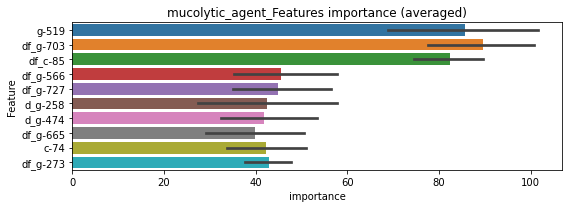

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217992	valid_1's binary_logloss: 0.0534
[200]	training's binary_logloss: 0.00378451	valid_1's binary_logloss: 0.029281
[300]	training's binary_logloss: 0.00105242	valid_1's binary_logloss: 0.0243044
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000578847	valid_1's binary_logloss: 0.0227543


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224841	valid_1's binary_logloss: 0.0445575
[200]	training's binary_logloss: 0.00378127	valid_1's binary_logloss: 0.0234691
[300]	training's binary_logloss: 0.00107443	valid_1's binary_logloss: 0.0196812
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000966561	valid_1's binary_logloss: 0.0194825


mucolytic_agent logloss: 0.021118607464990842


neg labels: 3289 → selected neg labels: 3283


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361407	valid_1's binary_logloss: 0.0640461
[200]	training's binary_logloss: 0.0055696	valid_1's binary_logloss: 0.0205342
[300]	training's binary_logloss: 0.00153308	valid_1's binary_logloss: 0.0110816
[400]	training's binary_logloss: 0.000721479	valid_1's binary_logloss: 0.00866978
[500]	training's binary_logloss: 0.0004813	valid_1's binary_logloss: 0.0077193
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000484321	valid_1's binary_logloss: 0.00770994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036679	valid_1's binary_logloss: 0.0562185
[200]	training's binary_logloss: 0.00556202	valid_1's binary_logloss: 0.0139011
[300]	training's binary_logloss: 0.00157579	valid_1's binary_logloss: 0.00641262
[400]	training's binary_logloss: 0.000740151	valid_1's binary_logloss: 0.00376057
[500]	training's binary_logloss: 0.000487

1 / 3 AUC score:1.000
y_Threshold: 0.0033463, Threshold: 0.0051899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00467, conf_1:0.00571
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0051899
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0151899
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_3: 0.0251899
threshold: 0.0251899, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356618	valid_1's binary_logloss: 0.06289
[200]	training's binary_logloss: 0.00535046	valid_1's binary_logloss: 0.0198329
[300]	training's binary_logloss: 0.00146694	valid_1's binary_logloss: 0.0102792
[400]	training's binary_logloss: 0.000711046	valid_1's binary_logloss: 0.00791662
[500]	training's binary_logloss: 0.000475809	valid_1's binary_logloss: 0.00704859
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000485556	valid_1's binary_logloss: 0.00700263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035552	valid_1's binary_logloss: 0.0530048
[200]	training's binary_logloss: 0.00535297	valid_1's binary_logloss: 0.0123613
[300]	training's binary_logloss: 0.00149911	valid_1's binary_logloss: 0.00510666
[400]	training's binary_logloss: 0.000729355	valid_1's binary_logloss: 0.00330469
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.0467400, Threshold: 0.0251899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00155
Num_p_label: 20.0, conf_0:0.02267, conf_1:0.02771
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0251899
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.0351899
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_3: 0.0451899
threshold: 0.0451899, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356618	valid_1's binary_logloss: 0.06289
[200]	training's binary_logloss: 0.00535046	valid_1's binary_logloss: 0.0198329
[300]	training's binary_logloss: 0.00146694	valid_1's binary_logloss: 0.0102792
[400]	training's binary_logloss: 0.000711046	valid_1's binary_logloss: 0.00791662
[500]	training's binary_logloss: 0.000475809	valid_1's binary_logloss: 0.00704859
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000485556	valid_1's binary_logloss: 0.00700263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035552	valid_1's binary_logloss: 0.0530048
[200]	training's binary_logloss: 0.00535297	valid_1's binary_logloss: 0.0123613
[300]	training's binary_logloss: 0.00149911	valid_1's binary_logloss: 0.00510666
[400]	training's binary_logloss: 0.000729355	valid_1's binary_logloss: 0.00330469
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0467400, Threshold: 0.0451899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0022602 Vs.target_rate: 0.00155
Num_p_label: 9.0, conf_0:0.04067, conf_1:0.04971
threshold: 0.0451899, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7789, y_label_rate: 0.0853768


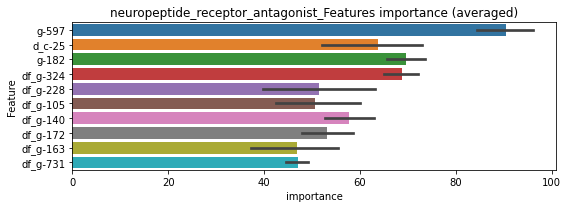

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193875	valid_1's binary_logloss: 0.0376337
[200]	training's binary_logloss: 0.00295461	valid_1's binary_logloss: 0.016348
[300]	training's binary_logloss: 0.000792273	valid_1's binary_logloss: 0.0133929
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000537082	valid_1's binary_logloss: 0.0130301


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211975	valid_1's binary_logloss: 0.0355624
[200]	training's binary_logloss: 0.0032148	valid_1's binary_logloss: 0.0121325
[300]	training's binary_logloss: 0.000869964	valid_1's binary_logloss: 0.0083109
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000522782	valid_1's binary_logloss: 0.00740172


neuropeptide_receptor_antagonist logloss: 0.010216294381100161


neg labels: 3289 → selected neg labels: 3270


nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501757	valid_1's binary_logloss: 0.120172
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0332929	valid_1's binary_logloss: 0.117548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421896	valid_1's binary_logloss: 0.151285
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0378683	valid_1's binary_logloss: 0.150667


1 / 3 AUC score:0.936
y_Threshold: 0.0319005, Threshold: 0.9641936, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 404 → Positive_corect_labels: 736/3698
p_label_rate: 0.0200904 Vs.target_rate: 0.03494
Num_p_label: 80.0, conf_0:0.86777, conf_1:1.06061
threshold: 0.9641936, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 736.0/3698, y_label_rate: 0.1990265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200974	valid_1's binary_logloss: 0.0274276
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0029184	valid_1's binary_logloss: 0.014688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191305	valid_1's binary_logloss: 0.0292024
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00251466	valid_1's binary_logloss: 0.017044


2 / 3 AUC score:0.998
y_Threshold: 0.0656963, Threshold: 0.9641936, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 18 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0381718 Vs.target_rate: 0.03494
Num_p_label: 152.0, conf_0:0.86777, conf_1:1.06061
threshold: 0.9641936, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161824	valid_1's binary_logloss: 0.0179006
[200]	training's binary_logloss: 0.00104951	valid_1's binary_logloss: 0.00232094
[300]	training's binary_logloss: 0.000232645	valid_1's binary_logloss: 0.00128761
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000222465	valid_1's binary_logloss: 0.00124606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161147	valid_1's binary_logloss: 0.0184239
[200]	training's binary_logloss: 0.00103671	valid_1's binary_logloss: 0.00356047
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00081111	valid_1's binary_logloss: 0.00338494


3 / 3 AUC score:1.000
y_Threshold: 0.6537247, Threshold: 0.9641936, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 4 → Positive_corect_labels: 725.0/3676
p_label_rate: 0.0386740 Vs.target_rate: 0.03494
Num_p_label: 154.0, conf_0:0.86777, conf_1:1.06061
threshold: 0.9641936, positive_p_label: 154.0/3982, p_label_rate: 0.0386740
positive_y_label: 879.0/7658, y_label_rate: 0.1147819


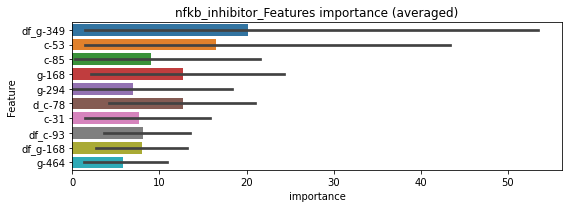

len(train_index) : 3829
len(valid_index) : 3829
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109525	valid_1's binary_logloss: 0.0124644
[200]	training's binary_logloss: 0.00076178	valid_1's binary_logloss: 0.00349998
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00043618	valid_1's binary_logloss: 0.00344076


len(train_index) : 3829
len(valid_index) : 3829
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110215	valid_1's binary_logloss: 0.0129075
[200]	training's binary_logloss: 0.000765995	valid_1's binary_logloss: 0.00268828
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000200664	valid_1's binary_logloss: 0.00218628


nfkb_inhibitor logloss: 0.0028135199410440175


neg labels: 3289 → selected neg labels: 3287


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191131	valid_1's binary_logloss: 0.0235629
[200]	training's binary_logloss: 0.00188775	valid_1's binary_logloss: 0.00311914
[300]	training's binary_logloss: 0.000516248	valid_1's binary_logloss: 0.00108811
[400]	training's binary_logloss: 0.000290551	valid_1's binary_logloss: 0.000696996
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000254444	valid_1's binary_logloss: 0.000637836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190586	valid_1's binary_logloss: 0.0234316
[200]	training's binary_logloss: 0.00190417	valid_1's binary_logloss: 0.00286386
[300]	training's binary_logloss: 0.000524645	valid_1's binary_logloss: 0.000925686
[400]	training's binary_logloss: 0.000294139	valid_1's binary_logloss: 0.000578759
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000257511	valid_1's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0008676, Threshold: 0.0018094, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00163, conf_1:0.00199
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0018094
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0118094
threshold: 0.0118094, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194429	valid_1's binary_logloss: 0.0228636
[200]	training's binary_logloss: 0.00187533	valid_1's binary_logloss: 0.00282212
[300]	training's binary_logloss: 0.00050523	valid_1's binary_logloss: 0.000943155
[400]	training's binary_logloss: 0.000287773	valid_1's binary_logloss: 0.000607607
[500]	training's binary_logloss: 0.000253241	valid_1's binary_logloss: 0.000552209
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000251507	valid_1's binary_logloss: 0.000549686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192202	valid_1's binary_logloss: 0.0230179
[200]	training's binary_logloss: 0.00185621	valid_1's binary_logloss: 0.00269692
[300]	training's binary_logloss: 0.000506985	valid_1's binary_logloss: 0.000846838
[400]	training's binary_logloss: 0.00028919	valid_1's binary_logloss: 0.000519374
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1621628, Threshold: 0.0118094, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0065294 Vs.target_rate: 0.00050
Num_p_label: 26.0, conf_0:0.01063, conf_1:0.01299
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.0118094
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0218094
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.0318094
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0418094
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_5: 0.0518094
threshold: 0.0518094, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194429	valid_1's binary_logloss: 0.0228636
[200]	training's binary_logloss: 0.00187533	valid_1's binary_logloss: 0.00282212
[300]	training's binary_logloss: 0.00050523	valid_1's binary_logloss: 0.000943155
[400]	training's binary_logloss: 0.000287773	valid_1's binary_logloss: 0.000607607
[500]	training's binary_logloss: 0.000253241	valid_1's binary_logloss: 0.000552209
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000251507	valid_1's binary_logloss: 0.000549686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192202	valid_1's binary_logloss: 0.0230179
[200]	training's binary_logloss: 0.00185621	valid_1's binary_logloss: 0.00269692
[300]	training's binary_logloss: 0.000506985	valid_1's binary_logloss: 0.000846838
[400]	training's binary_logloss: 0.00028919	valid_1's binary_logloss: 0.000519374
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1621628, Threshold: 0.0518094, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00050
Num_p_label: 2.0, conf_0:0.04663, conf_1:0.05699
threshold: 0.0518094, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


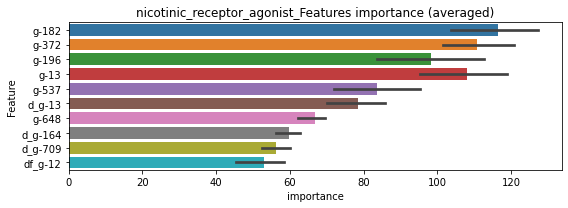

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00975117	valid_1's binary_logloss: 0.013375
[200]	training's binary_logloss: 0.00091776	valid_1's binary_logloss: 0.00298985
[300]	training's binary_logloss: 0.000253019	valid_1's binary_logloss: 0.00193725
[400]	training's binary_logloss: 0.000143718	valid_1's binary_logloss: 0.0017636
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000136356	valid_1's binary_logloss: 0.0017549


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979212	valid_1's binary_logloss: 0.0129565
[200]	training's binary_logloss: 0.000938644	valid_1's binary_logloss: 0.00245262
[300]	training's binary_logloss: 0.000257999	valid_1's binary_logloss: 0.00157773
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000195263	valid_1's binary_logloss: 0.00152972


nicotinic_receptor_agonist logloss: 0.0016423112833278684


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287306	valid_1's binary_logloss: 0.0459407
[200]	training's binary_logloss: 0.00390236	valid_1's binary_logloss: 0.0107648
[300]	training's binary_logloss: 0.00108656	valid_1's binary_logloss: 0.00466768
[400]	training's binary_logloss: 0.000545181	valid_1's binary_logloss: 0.00320827
[500]	training's binary_logloss: 0.000393363	valid_1's binary_logloss: 0.00272586
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000379351	valid_1's binary_logloss: 0.00266877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281999	valid_1's binary_logloss: 0.0393853
[200]	training's binary_logloss: 0.00390629	valid_1's binary_logloss: 0.00862466
[300]	training's binary_logloss: 0.00108401	valid_1's binary_logloss: 0.00333363
[400]	training's binary_logloss: 0.000543313	valid_1's binary_logloss: 0.00204766
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0023332, Threshold: 0.0038872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00350, conf_1:0.00428
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0038872
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.0138872
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.0238872
threshold: 0.0238872, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279637	valid_1's binary_logloss: 0.0431063
[200]	training's binary_logloss: 0.00371453	valid_1's binary_logloss: 0.010221
[300]	training's binary_logloss: 0.00104646	valid_1's binary_logloss: 0.00412627
[400]	training's binary_logloss: 0.000527323	valid_1's binary_logloss: 0.00280439
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00038764	valid_1's binary_logloss: 0.00234452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287046	valid_1's binary_logloss: 0.0398353
[200]	training's binary_logloss: 0.00380579	valid_1's binary_logloss: 0.00847496
[300]	training's binary_logloss: 0.00106938	valid_1's binary_logloss: 0.0035089
[400]	training's binary_logloss: 0.000545371	valid_1's binary_logloss: 0.00227527
[500]	training's binary_logloss: 0.000388083	valid_1's binary_logloss: 0.00190041
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0681447, Threshold: 0.0238872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00109
Num_p_label: 11.0, conf_0:0.02150, conf_1:0.02628
threshold: 0.0238872, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279637	valid_1's binary_logloss: 0.0431063
[200]	training's binary_logloss: 0.00371453	valid_1's binary_logloss: 0.010221
[300]	training's binary_logloss: 0.00104646	valid_1's binary_logloss: 0.00412627
[400]	training's binary_logloss: 0.000527323	valid_1's binary_logloss: 0.00280439
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00038764	valid_1's binary_logloss: 0.00234452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287046	valid_1's binary_logloss: 0.0398353
[200]	training's binary_logloss: 0.00380579	valid_1's binary_logloss: 0.00847496
[300]	training's binary_logloss: 0.00106938	valid_1's binary_logloss: 0.0035089
[400]	training's binary_logloss: 0.000545371	valid_1's binary_logloss: 0.00227527
[500]	training's binary_logloss: 0.000388083	valid_1's binary_logloss: 0.00190041
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0681447, Threshold: 0.0238872, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00109
Num_p_label: 11.0, conf_0:0.02150, conf_1:0.02628
threshold: 0.0238872, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


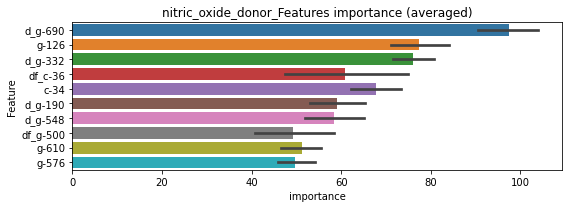

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154258	valid_1's binary_logloss: 0.0305735
[200]	training's binary_logloss: 0.0020254	valid_1's binary_logloss: 0.0145751
[300]	training's binary_logloss: 0.000560058	valid_1's binary_logloss: 0.0128762
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00058837	valid_1's binary_logloss: 0.0128621


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161651	valid_1's binary_logloss: 0.0243931
[200]	training's binary_logloss: 0.0022049	valid_1's binary_logloss: 0.00727462
[300]	training's binary_logloss: 0.000616175	valid_1's binary_logloss: 0.00509958
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000454063	valid_1's binary_logloss: 0.00485877


nitric_oxide_donor logloss: 0.008860432998705965


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336357	valid_1's binary_logloss: 0.0625695
[200]	training's binary_logloss: 0.0045586	valid_1's binary_logloss: 0.0206501
[300]	training's binary_logloss: 0.00124423	valid_1's binary_logloss: 0.011629
[400]	training's binary_logloss: 0.000624591	valid_1's binary_logloss: 0.00935717
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000472278	valid_1's binary_logloss: 0.00876154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321999	valid_1's binary_logloss: 0.0500543
[200]	training's binary_logloss: 0.00465066	valid_1's binary_logloss: 0.0127267
[300]	training's binary_logloss: 0.0012768	valid_1's binary_logloss: 0.00581129
[400]	training's binary_logloss: 0.000624611	valid_1's binary_logloss: 0.00376252
[500]	training's binary_logloss: 0.00044085	valid_1's binary_logloss: 0.00308073
Early stopping, best iteration is:
[500]

1 / 3 AUC score:1.000
y_Threshold: 0.0026610, Threshold: 0.0703972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.06336, conf_1:0.07744
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0703972
Num_p_label: 71.0, Expected: 4.8, Adj_threshold_2: 0.0803972
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_3: 0.0903972
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_4: 0.1003972
Num_p_label: 59.0, Expected: 4.8, Adj_threshold_5: 0.1103972
Num_p_label: 55.0, Expected: 4.8, Adj_threshold_6: 0.1203972
Num_p_label: 51.0, Expected: 4.8, Adj_threshold_7: 0.1303972
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_8: 0.1403972
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_9: 0.1503972
Num_p_label: 48.0, Expected: 4.8, Adj_threshold_10: 0.1603972
threshold: 0.1703972, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321428	valid_1's binary_logloss: 0.0566193
[200]	training's binary_logloss: 0.00439224	valid_1's binary_logloss: 0.0179134
[300]	training's binary_logloss: 0.00120482	valid_1's binary_logloss: 0.00976223
[400]	training's binary_logloss: 0.000599762	valid_1's binary_logloss: 0.00828279
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00043829	valid_1's binary_logloss: 0.00751434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309225	valid_1's binary_logloss: 0.048444
[200]	training's binary_logloss: 0.00422641	valid_1's binary_logloss: 0.0117674
[300]	training's binary_logloss: 0.00117322	valid_1's binary_logloss: 0.00527978
[400]	training's binary_logloss: 0.000583955	valid_1's binary_logloss: 0.00354262
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000453666	valid_1's binary_logloss: 0.00308883


2 / 3 AUC score:1.000
y_Threshold: 0.0683441, Threshold: 0.1703972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0268709 Vs.target_rate: 0.00122
Num_p_label: 107.0, conf_0:0.15336, conf_1:0.18744
Num_p_label: 107.0, Expected: 4.8, Adj_threshold_1: 0.1703972
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_2: 0.1803972
Num_p_label: 104.0, Expected: 4.8, Adj_threshold_3: 0.1903972
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_4: 0.2003972
Num_p_label: 101.0, Expected: 4.8, Adj_threshold_5: 0.2103972
Num_p_label: 99.0, Expected: 4.8, Adj_threshold_6: 0.2203972
Num_p_label: 99.0, Expected: 4.8, Adj_threshold_7: 0.2303972
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_8: 0.2403972
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_9: 0.2503972
Num_p_label: 97.0, Expected: 4.8, Adj_threshold_10: 0.2603972
threshold: 0.2703972, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
===

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313099	valid_1's binary_logloss: 0.0517289
[200]	training's binary_logloss: 0.00437609	valid_1's binary_logloss: 0.0147898
[300]	training's binary_logloss: 0.00120435	valid_1's binary_logloss: 0.00801149
[400]	training's binary_logloss: 0.000599702	valid_1's binary_logloss: 0.00624999
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000438471	valid_1's binary_logloss: 0.00570761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313645	valid_1's binary_logloss: 0.0449202
[200]	training's binary_logloss: 0.00436451	valid_1's binary_logloss: 0.00947986
[300]	training's binary_logloss: 0.00121491	valid_1's binary_logloss: 0.00367005
[400]	training's binary_logloss: 0.000602506	valid_1's binary_logloss: 0.00231882
[500]	training's binary_logloss: 0.000430343	valid_1's binary_logloss: 0.00187156
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0767031, Threshold: 0.2703972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0236062 Vs.target_rate: 0.00122
Num_p_label: 94.0, conf_0:0.24336, conf_1:0.29744
Num_p_label: 94.0, Expected: 4.8, Adj_threshold_1: 0.2703972
Num_p_label: 94.0, Expected: 4.8, Adj_threshold_2: 0.2803972
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_3: 0.2903972
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_4: 0.3003972
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_5: 0.3103972
Num_p_label: 89.0, Expected: 4.8, Adj_threshold_6: 0.3203972
Num_p_label: 86.0, Expected: 4.8, Adj_threshold_7: 0.3303972
Num_p_label: 85.0, Expected: 4.8, Adj_threshold_8: 0.3403972
Num_p_label: 84.0, Expected: 4.8, Adj_threshold_9: 0.3503972
Num_p_label: 82.0, Expected: 4.8, Adj_threshold_10: 0.3603972
threshold: 0.3703972, positive_p_label: 82.0/3982, p_label_rate: 0.0205927
positive_y_label: 736.0/7786, y_label_rate: 0.0945286


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020069	valid_1's binary_logloss: 0.0339311
[200]	training's binary_logloss: 0.00307446	valid_1's binary_logloss: 0.0128379
[300]	training's binary_logloss: 0.000841461	valid_1's binary_logloss: 0.00904706
[400]	training's binary_logloss: 0.000403339	valid_1's binary_logloss: 0.00811273
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000366648	valid_1's binary_logloss: 0.0079798


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207271	valid_1's binary_logloss: 0.0354662
[200]	training's binary_logloss: 0.00316761	valid_1's binary_logloss: 0.0132057
[300]	training's binary_logloss: 0.000833776	valid_1's binary_logloss: 0.00924342
[400]	training's binary_logloss: 0.000395136	valid_1's binary_logloss: 0.00822369
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000312016	valid_1's binary_logloss: 0.00795388


nitric_oxide_production_inhibitor logloss: 0.007966841652570434


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294145	valid_1's binary_logloss: 0.0491958
[200]	training's binary_logloss: 0.00397705	valid_1's binary_logloss: 0.0173113
[300]	training's binary_logloss: 0.00111826	valid_1's binary_logloss: 0.012029
[400]	training's binary_logloss: 0.000561755	valid_1's binary_logloss: 0.010397
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000561755	valid_1's binary_logloss: 0.010397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300685	valid_1's binary_logloss: 0.0425233
[200]	training's binary_logloss: 0.00406451	valid_1's binary_logloss: 0.00925553
[300]	training's binary_logloss: 0.00111772	valid_1's binary_logloss: 0.00417149
[400]	training's binary_logloss: 0.000564375	valid_1's binary_logloss: 0.00301542
[500]	training's binary_logloss: 0.000407993	valid_1's binary_logloss: 0.00263135
Early stopping, best iteration is:
[496]

1 / 3 AUC score:1.000
y_Threshold: 0.0028826, Threshold: 0.0047119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00424, conf_1:0.00518
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0047119
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_2: 0.0147119
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0247119
threshold: 0.0247119, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286217	valid_1's binary_logloss: 0.0486243
[200]	training's binary_logloss: 0.0038137	valid_1's binary_logloss: 0.0190413
[300]	training's binary_logloss: 0.00107342	valid_1's binary_logloss: 0.0134037
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000641378	valid_1's binary_logloss: 0.0120761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296219	valid_1's binary_logloss: 0.0415705
[200]	training's binary_logloss: 0.00394963	valid_1's binary_logloss: 0.00895764
[300]	training's binary_logloss: 0.00109813	valid_1's binary_logloss: 0.00428789
[400]	training's binary_logloss: 0.000561148	valid_1's binary_logloss: 0.00325493
[500]	training's binary_logloss: 0.000407077	valid_1's binary_logloss: 0.0029171
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000413513	valid_1's binary_logloss: 0.00290967


2 / 3 AUC score:1.000
y_Threshold: 0.0169400, Threshold: 0.0247119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0032647 Vs.target_rate: 0.00109
Num_p_label: 13.0, conf_0:0.02224, conf_1:0.02718
threshold: 0.0247119, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298049	valid_1's binary_logloss: 0.0419176
[200]	training's binary_logloss: 0.00395312	valid_1's binary_logloss: 0.00874289
[300]	training's binary_logloss: 0.00109591	valid_1's binary_logloss: 0.00374188
[400]	training's binary_logloss: 0.000548766	valid_1's binary_logloss: 0.00244945
[500]	training's binary_logloss: 0.000400329	valid_1's binary_logloss: 0.00207607
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000381935	valid_1's binary_logloss: 0.00202305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284191	valid_1's binary_logloss: 0.0427553
[200]	training's binary_logloss: 0.00378635	valid_1's binary_logloss: 0.0108256
[300]	training's binary_logloss: 0.00107124	valid_1's binary_logloss: 0.0060804
[400]	training's binary_logloss: 0.000547934	valid_1's binary_logloss: 0.00507607
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0779487, Threshold: 0.0247119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0025113 Vs.target_rate: 0.00109
Num_p_label: 10.0, conf_0:0.02224, conf_1:0.02718
threshold: 0.0247119, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 663.0/7784, y_label_rate: 0.0851747


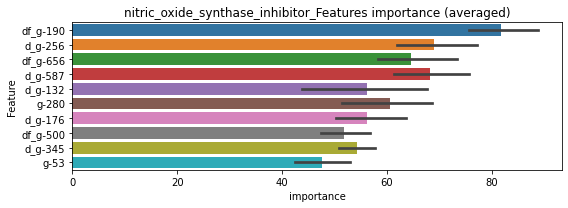

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167488	valid_1's binary_logloss: 0.0284515
[200]	training's binary_logloss: 0.00221861	valid_1's binary_logloss: 0.0125963
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000970927	valid_1's binary_logloss: 0.0115706


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167411	valid_1's binary_logloss: 0.0264656
[200]	training's binary_logloss: 0.00225622	valid_1's binary_logloss: 0.00841385
[300]	training's binary_logloss: 0.000617742	valid_1's binary_logloss: 0.00579749
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000374342	valid_1's binary_logloss: 0.00531525


nitric_oxide_synthase_inhibitor logloss: 0.008442940483294904


neg labels: 3289 → selected neg labels: 3287


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162974	valid_1's binary_logloss: 0.017707
[200]	training's binary_logloss: 0.00141103	valid_1's binary_logloss: 0.00171225
[300]	training's binary_logloss: 0.000383353	valid_1's binary_logloss: 0.000501365
[400]	training's binary_logloss: 0.00023093	valid_1's binary_logloss: 0.000311547
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000209801	valid_1's binary_logloss: 0.000284834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163858	valid_1's binary_logloss: 0.0180658
[200]	training's binary_logloss: 0.00141154	valid_1's binary_logloss: 0.00179931
[300]	training's binary_logloss: 0.000382805	valid_1's binary_logloss: 0.000536141
[400]	training's binary_logloss: 0.000230754	valid_1's binary_logloss: 0.000337746
[500]	training's binary_logloss: 0.000205328	valid_1's binary_logloss: 0.000302086
Early stopping, best iterat

1 / 3 AUC score:1.000
y_Threshold: 0.0005896, Threshold: 0.0009265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00083, conf_1:0.00102
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009265
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.0109265
threshold: 0.0109265, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164585	valid_1's binary_logloss: 0.0187578
[200]	training's binary_logloss: 0.0013848	valid_1's binary_logloss: 0.00250705
[300]	training's binary_logloss: 0.000374666	valid_1's binary_logloss: 0.000953741
[400]	training's binary_logloss: 0.000228269	valid_1's binary_logloss: 0.000662237
[500]	training's binary_logloss: 0.000203371	valid_1's binary_logloss: 0.000614903
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000201586	valid_1's binary_logloss: 0.000612412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164971	valid_1's binary_logloss: 0.0177538
[200]	training's binary_logloss: 0.00139681	valid_1's binary_logloss: 0.00160588
[300]	training's binary_logloss: 0.0003802	valid_1's binary_logloss: 0.000454995
[400]	training's binary_logloss: 0.000231057	valid_1's binary_logloss: 0.000281341
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.1250434, Threshold: 0.0109265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00029
Num_p_label: 18.0, conf_0:0.00983, conf_1:0.01202
Num_p_label: 18.0, Expected: 1.2, Adj_threshold_1: 0.0109265
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.0209265
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0309265
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_4: 0.0409265
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0509265
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.0609265
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0709265
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_8: 0.0809265
threshold: 0.0809265, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164585	valid_1's binary_logloss: 0.0187578
[200]	training's binary_logloss: 0.0013848	valid_1's binary_logloss: 0.00250705
[300]	training's binary_logloss: 0.000374666	valid_1's binary_logloss: 0.000953741
[400]	training's binary_logloss: 0.000228269	valid_1's binary_logloss: 0.000662237
[500]	training's binary_logloss: 0.000203371	valid_1's binary_logloss: 0.000614903
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000201586	valid_1's binary_logloss: 0.000612412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164971	valid_1's binary_logloss: 0.0177538
[200]	training's binary_logloss: 0.00139681	valid_1's binary_logloss: 0.00160588
[300]	training's binary_logloss: 0.0003802	valid_1's binary_logloss: 0.000454995
[400]	training's binary_logloss: 0.000231057	valid_1's binary_logloss: 0.000281341
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.1250434, Threshold: 0.0809265, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.07283, conf_1:0.08902
threshold: 0.0809265, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859252	valid_1's binary_logloss: 0.0102209
[200]	training's binary_logloss: 0.000708402	valid_1's binary_logloss: 0.00202128
[300]	training's binary_logloss: 0.000188585	valid_1's binary_logloss: 0.00145537
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000177153	valid_1's binary_logloss: 0.00143968


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00867711	valid_1's binary_logloss: 0.0102254
[200]	training's binary_logloss: 0.00072038	valid_1's binary_logloss: 0.00148722
[300]	training's binary_logloss: 0.000193793	valid_1's binary_logloss: 0.00067232
[400]	training's binary_logloss: 0.000117218	valid_1's binary_logloss: 0.000479465
[500]	training's binary_logloss: 0.000104273	valid_1's binary_logloss: 0.000445676
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000104192	valid_1's binary_logloss: 0.000445585


norepinephrine_reuptake_inhibitor logloss: 0.0009426306303003874


neg labels: 3289 → selected neg labels: 3286


nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203478	valid_1's binary_logloss: 0.0273553
[200]	training's binary_logloss: 0.00216588	valid_1's binary_logloss: 0.00731436
[300]	training's binary_logloss: 0.000612945	valid_1's binary_logloss: 0.00526328
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000428061	valid_1's binary_logloss: 0.004732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020408	valid_1's binary_logloss: 0.0264301
[200]	training's binary_logloss: 0.00216629	valid_1's binary_logloss: 0.0050675
[300]	training's binary_logloss: 0.000614176	valid_1's binary_logloss: 0.00271654
[400]	training's binary_logloss: 0.000339551	valid_1's binary_logloss: 0.00203214
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000310319	valid_1's binary_logloss: 0.00195457


1 / 3 AUC score:1.000
y_Threshold: 0.0012342, Threshold: 0.1389493, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.12505, conf_1:0.15284
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.1389493
Num_p_label: 78.0, Expected: 3.0, Adj_threshold_2: 0.1489493
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_3: 0.1589493
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_4: 0.1689493
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_5: 0.1789493
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_6: 0.1889493
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_7: 0.1989493
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_8: 0.2089493
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_9: 0.2189493
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_10: 0.2289493
threshold: 0.2389493, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196429	valid_1's binary_logloss: 0.0225294
[200]	training's binary_logloss: 0.00194106	valid_1's binary_logloss: 0.00265246
[300]	training's binary_logloss: 0.000528735	valid_1's binary_logloss: 0.000856441
[400]	training's binary_logloss: 0.000292628	valid_1's binary_logloss: 0.000522472
[500]	training's binary_logloss: 0.000256528	valid_1's binary_logloss: 0.000472253
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00025538	valid_1's binary_logloss: 0.000470894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197039	valid_1's binary_logloss: 0.0241564
[200]	training's binary_logloss: 0.00191424	valid_1's binary_logloss: 0.00314941
[300]	training's binary_logloss: 0.000527294	valid_1's binary_logloss: 0.00106666
[400]	training's binary_logloss: 0.000298023	valid_1's binary_logloss: 0.000677164
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1793463, Threshold: 0.2389493, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0291311 Vs.target_rate: 0.00076
Num_p_label: 116.0, conf_0:0.21505, conf_1:0.26284
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_1: 0.2389493
Num_p_label: 115.0, Expected: 3.0, Adj_threshold_2: 0.2489493
Num_p_label: 114.0, Expected: 3.0, Adj_threshold_3: 0.2589493
Num_p_label: 114.0, Expected: 3.0, Adj_threshold_4: 0.2689493
Num_p_label: 112.0, Expected: 3.0, Adj_threshold_5: 0.2789493
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_6: 0.2889493
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_7: 0.2989493
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_8: 0.3089493
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_9: 0.3189493
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_10: 0.3289493
threshold: 0.3389493, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 657.0/3811, y_label_rate: 0.17239

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196429	valid_1's binary_logloss: 0.0225294
[200]	training's binary_logloss: 0.00194106	valid_1's binary_logloss: 0.00265246
[300]	training's binary_logloss: 0.000528735	valid_1's binary_logloss: 0.000856441
[400]	training's binary_logloss: 0.000292628	valid_1's binary_logloss: 0.000522472
[500]	training's binary_logloss: 0.000256528	valid_1's binary_logloss: 0.000472253
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00025538	valid_1's binary_logloss: 0.000470894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197039	valid_1's binary_logloss: 0.0241564
[200]	training's binary_logloss: 0.00191424	valid_1's binary_logloss: 0.00314941
[300]	training's binary_logloss: 0.000527294	valid_1's binary_logloss: 0.00106666
[400]	training's binary_logloss: 0.000298023	valid_1's binary_logloss: 0.000677164
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1793463, Threshold: 0.3389493, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0271220 Vs.target_rate: 0.00076
Num_p_label: 108.0, conf_0:0.30505, conf_1:0.37284
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_1: 0.3389493
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_2: 0.3489493
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_3: 0.3589493
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_4: 0.3689493
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_5: 0.3789493
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_6: 0.3889493
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_7: 0.3989493
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_8: 0.4089493
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_9: 0.4189493
Num_p_label: 102.0, Expected: 3.0, Adj_threshold_10: 0.4289493
threshold: 0.4389493, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 757.0/7793, y_label_rate: 0.09713

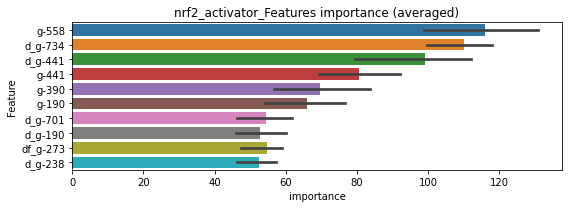

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125711	valid_1's binary_logloss: 0.019572
[200]	training's binary_logloss: 0.00134775	valid_1's binary_logloss: 0.00746348
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000492802	valid_1's binary_logloss: 0.00668525


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133142	valid_1's binary_logloss: 0.018617
[200]	training's binary_logloss: 0.00151571	valid_1's binary_logloss: 0.0048514
[300]	training's binary_logloss: 0.000416976	valid_1's binary_logloss: 0.00344381
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000382013	valid_1's binary_logloss: 0.0034432


nrf2_activator logloss: 0.0050644331725479205


neg labels: 3289 → selected neg labels: 3279


opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548115	valid_1's binary_logloss: 0.0985444
[200]	training's binary_logloss: 0.0114069	valid_1's binary_logloss: 0.0482979
[300]	training's binary_logloss: 0.00314552	valid_1's binary_logloss: 0.0328343
[400]	training's binary_logloss: 0.0013811	valid_1's binary_logloss: 0.0281309
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00109412	valid_1's binary_logloss: 0.0268893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502061	valid_1's binary_logloss: 0.0942216
[200]	training's binary_logloss: 0.0105091	valid_1's binary_logloss: 0.0431547
[300]	training's binary_logloss: 0.00297249	valid_1's binary_logloss: 0.028888
[400]	training's binary_logloss: 0.00133174	valid_1's binary_logloss: 0.0243337
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00132375	valid_1's binary_logloss: 0.0243126


1 / 3 AUC score:0.998
y_Threshold: 0.0098732, Threshold: 0.0144729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01303, conf_1:0.01592
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0144729
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_2: 0.0244729
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_3: 0.0344729
threshold: 0.0344729, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526664	valid_1's binary_logloss: 0.0926005
[200]	training's binary_logloss: 0.0104087	valid_1's binary_logloss: 0.0388179
[300]	training's binary_logloss: 0.00289665	valid_1's binary_logloss: 0.0251213
[400]	training's binary_logloss: 0.00131722	valid_1's binary_logloss: 0.0219803
[500]	training's binary_logloss: 0.000790837	valid_1's binary_logloss: 0.0206043
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00074708	valid_1's binary_logloss: 0.0203848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507979	valid_1's binary_logloss: 0.0918145
[200]	training's binary_logloss: 0.00978843	valid_1's binary_logloss: 0.0363236
[300]	training's binary_logloss: 0.00278386	valid_1's binary_logloss: 0.0208248
[400]	training's binary_logloss: 0.00127606	valid_1's binary_logloss: 0.0159751
[500]	training's binary_logloss: 0.000794664	

2 / 3 AUC score:1.000
y_Threshold: 0.0253725, Threshold: 0.0344729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0052737 Vs.target_rate: 0.00256
Num_p_label: 21.0, conf_0:0.03103, conf_1:0.03792
threshold: 0.0344729, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470336	valid_1's binary_logloss: 0.0923658
[200]	training's binary_logloss: 0.00927267	valid_1's binary_logloss: 0.0448711
[300]	training's binary_logloss: 0.00267851	valid_1's binary_logloss: 0.0330926
[400]	training's binary_logloss: 0.00122024	valid_1's binary_logloss: 0.0299382
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00101269	valid_1's binary_logloss: 0.0294891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486336	valid_1's binary_logloss: 0.0987856
[200]	training's binary_logloss: 0.00942771	valid_1's binary_logloss: 0.049511
[300]	training's binary_logloss: 0.00265456	valid_1's binary_logloss: 0.0363841
[400]	training's binary_logloss: 0.00121709	valid_1's binary_logloss: 0.0317051
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00108325	valid_1's binary_logloss: 0.0312176


3 / 3 AUC score:0.998
y_Threshold: 0.0343007, Threshold: 0.0344729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0085384 Vs.target_rate: 0.00256
Num_p_label: 34.0, conf_0:0.03103, conf_1:0.03792
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_1: 0.0344729
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_2: 0.0444729
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_3: 0.0544729
threshold: 0.0544729, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 658.0/7756, y_label_rate: 0.0848375


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268581	valid_1's binary_logloss: 0.0568595
[200]	training's binary_logloss: 0.00508725	valid_1's binary_logloss: 0.0322965
[300]	training's binary_logloss: 0.00141465	valid_1's binary_logloss: 0.0277301
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00125466	valid_1's binary_logloss: 0.0274851


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278443	valid_1's binary_logloss: 0.0530804
[200]	training's binary_logloss: 0.00556495	valid_1's binary_logloss: 0.0265191
[300]	training's binary_logloss: 0.00154679	valid_1's binary_logloss: 0.0207411
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000932178	valid_1's binary_logloss: 0.0200276


opioid_receptor_agonist logloss: 0.02375634575998788


neg labels: 3289 → selected neg labels: 3275


opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649103	valid_1's binary_logloss: 0.140304
[200]	training's binary_logloss: 0.0156066	valid_1's binary_logloss: 0.0834441
[300]	training's binary_logloss: 0.00448725	valid_1's binary_logloss: 0.0662036
[400]	training's binary_logloss: 0.00195085	valid_1's binary_logloss: 0.0612028
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00155069	valid_1's binary_logloss: 0.0604661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662864	valid_1's binary_logloss: 0.142951
[200]	training's binary_logloss: 0.0157957	valid_1's binary_logloss: 0.0894818
[300]	training's binary_logloss: 0.00482046	valid_1's binary_logloss: 0.0782575
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00247005	valid_1's binary_logloss: 0.0754752


1 / 3 AUC score:0.992
y_Threshold: 0.0156719, Threshold: 0.0243457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 173 → Positive_corect_labels: 634/3757
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.02191, conf_1:0.02678
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0243457
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_2: 0.0343457
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_3: 0.0443457
threshold: 0.0443457, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 634.0/3757, y_label_rate: 0.1687517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576758	valid_1's binary_logloss: 0.149064
[200]	training's binary_logloss: 0.0130145	valid_1's binary_logloss: 0.102386
[300]	training's binary_logloss: 0.00393928	valid_1's binary_logloss: 0.0910513
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00209284	valid_1's binary_logloss: 0.0864584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608221	valid_1's binary_logloss: 0.131907
[200]	training's binary_logloss: 0.013621	valid_1's binary_logloss: 0.0789912
[300]	training's binary_logloss: 0.00405716	valid_1's binary_logloss: 0.0656312
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00224438	valid_1's binary_logloss: 0.0627988


2 / 3 AUC score:0.990
y_Threshold: 0.0302308, Threshold: 0.0443457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 607.0/3703
p_label_rate: 0.0135610 Vs.target_rate: 0.00403
Num_p_label: 54.0, conf_0:0.03991, conf_1:0.04878
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_1: 0.0443457
Num_p_label: 31.0, Expected: 16.1, Adj_threshold_2: 0.0543457
threshold: 0.0543457, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 607.0/3703, y_label_rate: 0.1639211
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550604	valid_1's binary_logloss: 0.116787
[200]	training's binary_logloss: 0.0118301	valid_1's binary_logloss: 0.0642113
[300]	training's binary_logloss: 0.00354318	valid_1's binary_logloss: 0.0497372
[400]	training's binary_logloss: 0.0016168	valid_1's binary_logloss: 0.0439943
[500]	training's binary_logloss: 0.00098838	valid_1's binary_logloss: 0.04193
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000947649	valid_1's binary_logloss: 0.0417896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572014	valid_1's binary_logloss: 0.125922
[200]	training's binary_logloss: 0.0124599	valid_1's binary_logloss: 0.072008
[300]	training's binary_logloss: 0.00365525	valid_1's binary_logloss: 0.0583018
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00276441	valid_1's binary_logloss: 0.0562777


3 / 3 AUC score:0.999
y_Threshold: 0.0430486, Threshold: 0.0543457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 595.0/3679
p_label_rate: 0.0107986 Vs.target_rate: 0.00403
Num_p_label: 43.0, conf_0:0.04891, conf_1:0.05978
threshold: 0.0543457, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 638.0/7661, y_label_rate: 0.0832789


len(train_index) : 3830
len(valid_index) : 3831
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331528	valid_1's binary_logloss: 0.0828528
[200]	training's binary_logloss: 0.0072524	valid_1's binary_logloss: 0.0563519
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0029375	valid_1's binary_logloss: 0.0511828


len(train_index) : 3831
len(valid_index) : 3830
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033718	valid_1's binary_logloss: 0.0836582
[200]	training's binary_logloss: 0.00756489	valid_1's binary_logloss: 0.0558828
[300]	training's binary_logloss: 0.00215979	valid_1's binary_logloss: 0.0490892
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00117277	valid_1's binary_logloss: 0.0479066


opioid_receptor_antagonist logloss: 0.0495449126005623


neg labels: 3289 → selected neg labels: 3283


orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357492	valid_1's binary_logloss: 0.0635038
[200]	training's binary_logloss: 0.00540018	valid_1's binary_logloss: 0.0232682
[300]	training's binary_logloss: 0.00151019	valid_1's binary_logloss: 0.0155305
[400]	training's binary_logloss: 0.0007354	valid_1's binary_logloss: 0.0138011
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000617901	valid_1's binary_logloss: 0.0134243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353853	valid_1's binary_logloss: 0.0665622
[200]	training's binary_logloss: 0.00540023	valid_1's binary_logloss: 0.0274831
[300]	training's binary_logloss: 0.00150571	valid_1's binary_logloss: 0.0200402
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00137117	valid_1's binary_logloss: 0.019689


1 / 3 AUC score:1.000
y_Threshold: 0.0058225, Threshold: 0.0073236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00659, conf_1:0.00806
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0073236
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_2: 0.0173236
threshold: 0.0173236, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351862	valid_1's binary_logloss: 0.0618847
[200]	training's binary_logloss: 0.00531635	valid_1's binary_logloss: 0.0216257
[300]	training's binary_logloss: 0.00147832	valid_1's binary_logloss: 0.0147078
[400]	training's binary_logloss: 0.000713599	valid_1's binary_logloss: 0.0128598
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000619077	valid_1's binary_logloss: 0.0125946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354437	valid_1's binary_logloss: 0.0687099
[200]	training's binary_logloss: 0.00536453	valid_1's binary_logloss: 0.0272604
[300]	training's binary_logloss: 0.00149884	valid_1's binary_logloss: 0.0210569
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00118369	valid_1's binary_logloss: 0.0199065


2 / 3 AUC score:1.000
y_Threshold: 0.0207576, Threshold: 0.0173236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0087896 Vs.target_rate: 0.00155
Num_p_label: 35.0, conf_0:0.01559, conf_1:0.01906
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_1: 0.0173236
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0273236
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0373236
threshold: 0.0373236, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344104	valid_1's binary_logloss: 0.0613223
[200]	training's binary_logloss: 0.00513929	valid_1's binary_logloss: 0.0193564
[300]	training's binary_logloss: 0.00145741	valid_1's binary_logloss: 0.0117139
[400]	training's binary_logloss: 0.000709076	valid_1's binary_logloss: 0.00948104
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00052949	valid_1's binary_logloss: 0.00895282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349196	valid_1's binary_logloss: 0.0647295
[200]	training's binary_logloss: 0.00531259	valid_1's binary_logloss: 0.02659
[300]	training's binary_logloss: 0.00148925	valid_1's binary_logloss: 0.0183124
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00135972	valid_1's binary_logloss: 0.0180023


3 / 3 AUC score:1.000
y_Threshold: 0.0328553, Threshold: 0.0373236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0022602 Vs.target_rate: 0.00155
Num_p_label: 9.0, conf_0:0.03359, conf_1:0.04106
threshold: 0.0373236, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 661.0/7781, y_label_rate: 0.0849505


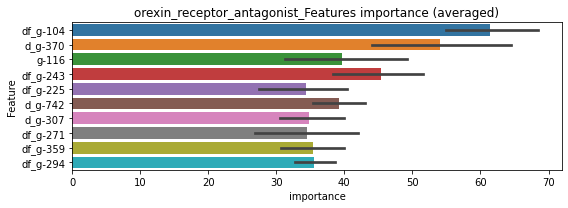

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199243	valid_1's binary_logloss: 0.0393872
[200]	training's binary_logloss: 0.00297258	valid_1's binary_logloss: 0.0170156
[300]	training's binary_logloss: 0.000797148	valid_1's binary_logloss: 0.0131001
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00051454	valid_1's binary_logloss: 0.0124724


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019558	valid_1's binary_logloss: 0.0384285
[200]	training's binary_logloss: 0.00294958	valid_1's binary_logloss: 0.0178806
[300]	training's binary_logloss: 0.000800868	valid_1's binary_logloss: 0.0139007
[400]	training's binary_logloss: 0.000376597	valid_1's binary_logloss: 0.0131193
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000362193	valid_1's binary_logloss: 0.013093


orexin_receptor_antagonist logloss: 0.012782673699981317


neg labels: 3289 → selected neg labels: 3278


p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318878	valid_1's binary_logloss: 0.0775606
[200]	training's binary_logloss: 0.00469289	valid_1's binary_logloss: 0.0453895
[300]	training's binary_logloss: 0.00139473	valid_1's binary_logloss: 0.0389956
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00100937	valid_1's binary_logloss: 0.0379315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030774	valid_1's binary_logloss: 0.0747916
[200]	training's binary_logloss: 0.00452722	valid_1's binary_logloss: 0.0401696
[300]	training's binary_logloss: 0.00133763	valid_1's binary_logloss: 0.0353681
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00106084	valid_1's binary_logloss: 0.0348174


1 / 3 AUC score:0.998
y_Threshold: 0.0071578, Threshold: 0.0165330, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.01488, conf_1:0.01819
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0165330
Num_p_label: 53.0, Expected: 10.4, Adj_threshold_2: 0.0265330
Num_p_label: 37.0, Expected: 10.4, Adj_threshold_3: 0.0365330
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_4: 0.0465330
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_5: 0.0565330
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_6: 0.0665330
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_7: 0.0765330
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_8: 0.0865330
threshold: 0.0865330, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 647.0/3785, y_label_rate: 0.1709379
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308976	valid_1's binary_logloss: 0.0650761
[200]	training's binary_logloss: 0.00428848	valid_1's binary_logloss: 0.0311144
[300]	training's binary_logloss: 0.00122744	valid_1's binary_logloss: 0.0251188
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00112986	valid_1's binary_logloss: 0.0249848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308402	valid_1's binary_logloss: 0.0564996
[200]	training's binary_logloss: 0.00436262	valid_1's binary_logloss: 0.0197329
[300]	training's binary_logloss: 0.00125383	valid_1's binary_logloss: 0.0118936
[400]	training's binary_logloss: 0.000630291	valid_1's binary_logloss: 0.00977012
[500]	training's binary_logloss: 0.000433119	valid_1's binary_logloss: 0.00911792
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000442026	valid_1's binary_logloss: 0.00909481


2 / 3 AUC score:1.000
y_Threshold: 0.0294363, Threshold: 0.0865330, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 644.0/3779
p_label_rate: 0.0082873 Vs.target_rate: 0.00260
Num_p_label: 33.0, conf_0:0.07788, conf_1:0.09519
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_1: 0.0865330
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_2: 0.0965330
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_3: 0.1065330
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_4: 0.1165330
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_5: 0.1265330
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_6: 0.1365330
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_7: 0.1465330
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_8: 0.1565330
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_9: 0.1665330
threshold: 0.1665330, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3779, y_label_rate: 0.1704155
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298261	valid_1's binary_logloss: 0.0528812
[200]	training's binary_logloss: 0.00443761	valid_1's binary_logloss: 0.0229795
[300]	training's binary_logloss: 0.00122907	valid_1's binary_logloss: 0.0153971
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0006732	valid_1's binary_logloss: 0.0139776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301631	valid_1's binary_logloss: 0.056604
[200]	training's binary_logloss: 0.00421679	valid_1's binary_logloss: 0.021414
[300]	training's binary_logloss: 0.00121403	valid_1's binary_logloss: 0.0138281
[400]	training's binary_logloss: 0.000611493	valid_1's binary_logloss: 0.0106014
[500]	training's binary_logloss: 0.000426861	valid_1's binary_logloss: 0.00952375
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000398353	valid_1's binary_logloss: 0.00927666


3 / 3 AUC score:1.000
y_Threshold: 0.0205032, Threshold: 0.1665330, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 642.0/3775
p_label_rate: 0.0050226 Vs.target_rate: 0.00260
Num_p_label: 20.0, conf_0:0.14988, conf_1:0.18319
threshold: 0.1665330, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 662.0/7757, y_label_rate: 0.0853423


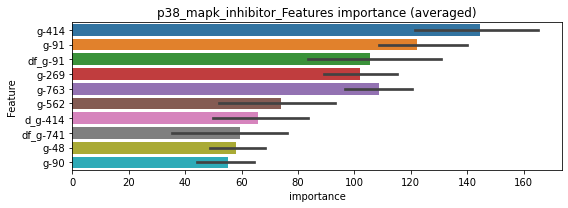

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156303	valid_1's binary_logloss: 0.0381482
[200]	training's binary_logloss: 0.00217386	valid_1's binary_logloss: 0.0226231
[300]	training's binary_logloss: 0.000634649	valid_1's binary_logloss: 0.0200762
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000422469	valid_1's binary_logloss: 0.0195241


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157966	valid_1's binary_logloss: 0.032806
[200]	training's binary_logloss: 0.00225531	valid_1's binary_logloss: 0.0145509
[300]	training's binary_logloss: 0.000659988	valid_1's binary_logloss: 0.0103893
[400]	training's binary_logloss: 0.000334333	valid_1's binary_logloss: 0.00914995
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000250839	valid_1's binary_logloss: 0.00865279


p38_mapk_inhibitor logloss: 0.014089126433547134


neg labels: 3289 → selected neg labels: 3285


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284415	valid_1's binary_logloss: 0.042024
[200]	training's binary_logloss: 0.003651	valid_1's binary_logloss: 0.00910831
[300]	training's binary_logloss: 0.00101514	valid_1's binary_logloss: 0.00465938
[400]	training's binary_logloss: 0.000513723	valid_1's binary_logloss: 0.0037399
[500]	training's binary_logloss: 0.000374608	valid_1's binary_logloss: 0.00342951
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000377883	valid_1's binary_logloss: 0.00342067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295669	valid_1's binary_logloss: 0.0487033
[200]	training's binary_logloss: 0.00390579	valid_1's binary_logloss: 0.0156107
[300]	training's binary_logloss: 0.00105517	valid_1's binary_logloss: 0.00959177
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000725227	valid_1's binary_logloss: 0.00873053


1 / 3 AUC score:1.000
y_Threshold: 0.0033580, Threshold: 0.0042231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00380, conf_1:0.00465
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0042231
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0142231
threshold: 0.0142231, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280542	valid_1's binary_logloss: 0.0409563
[200]	training's binary_logloss: 0.00359657	valid_1's binary_logloss: 0.0086441
[300]	training's binary_logloss: 0.00100155	valid_1's binary_logloss: 0.0037781
[400]	training's binary_logloss: 0.000507233	valid_1's binary_logloss: 0.0027764
[500]	training's binary_logloss: 0.000378522	valid_1's binary_logloss: 0.00244286
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00037204	valid_1's binary_logloss: 0.00242745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283991	valid_1's binary_logloss: 0.04819
[200]	training's binary_logloss: 0.00370579	valid_1's binary_logloss: 0.0162413
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00142315	valid_1's binary_logloss: 0.0121847


2 / 3 AUC score:1.000
y_Threshold: 0.0199313, Threshold: 0.0142231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0092918 Vs.target_rate: 0.00101
Num_p_label: 37.0, conf_0:0.01280, conf_1:0.01565
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_1: 0.0142231
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.0242231
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0342231
threshold: 0.0342231, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276806	valid_1's binary_logloss: 0.0437533
[200]	training's binary_logloss: 0.0035062	valid_1's binary_logloss: 0.0109121
[300]	training's binary_logloss: 0.000973916	valid_1's binary_logloss: 0.00635121
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00070577	valid_1's binary_logloss: 0.0058141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028931	valid_1's binary_logloss: 0.0429188
[200]	training's binary_logloss: 0.00367878	valid_1's binary_logloss: 0.011218
[300]	training's binary_logloss: 0.00101809	valid_1's binary_logloss: 0.00651563
[400]	training's binary_logloss: 0.000511005	valid_1's binary_logloss: 0.0053278
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000414853	valid_1's binary_logloss: 0.00506213


3 / 3 AUC score:1.000
y_Threshold: 0.0236857, Threshold: 0.0342231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00101
Num_p_label: 6.0, conf_0:0.03080, conf_1:0.03765
threshold: 0.0342231, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7788, y_label_rate: 0.0848742


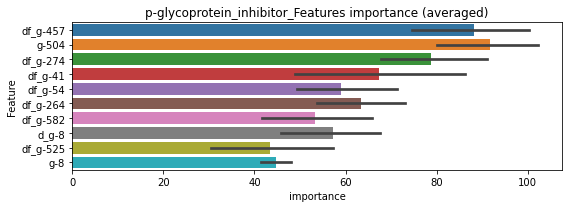

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156484	valid_1's binary_logloss: 0.0273024
[200]	training's binary_logloss: 0.00192037	valid_1's binary_logloss: 0.011037
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000656908	valid_1's binary_logloss: 0.00989716


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016661	valid_1's binary_logloss: 0.0224931
[200]	training's binary_logloss: 0.00222743	valid_1's binary_logloss: 0.00548322
[300]	training's binary_logloss: 0.000595824	valid_1's binary_logloss: 0.00304209
[400]	training's binary_logloss: 0.000284559	valid_1's binary_logloss: 0.00247895
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000232242	valid_1's binary_logloss: 0.00232847


p-glycoprotein_inhibitor logloss: 0.006112812906089174


neg labels: 3289 → selected neg labels: 3279


parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445069	valid_1's binary_logloss: 0.0807666
[200]	training's binary_logloss: 0.00807072	valid_1's binary_logloss: 0.0337077
[300]	training's binary_logloss: 0.0023209	valid_1's binary_logloss: 0.0230794
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00134823	valid_1's binary_logloss: 0.0209692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460487	valid_1's binary_logloss: 0.0867431
[200]	training's binary_logloss: 0.00816466	valid_1's binary_logloss: 0.0336796
[300]	training's binary_logloss: 0.00235019	valid_1's binary_logloss: 0.0212056
[400]	training's binary_logloss: 0.00110073	valid_1's binary_logloss: 0.0171308
[500]	training's binary_logloss: 0.000692961	valid_1's binary_logloss: 0.0156802
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000627639	valid_1's binary_logloss: 0.0152503


1 / 3 AUC score:1.000
y_Threshold: 0.0102545, Threshold: 0.0151349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01362, conf_1:0.01665
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0151349
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_2: 0.0251349
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_3: 0.0351349
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_4: 0.0451349
threshold: 0.0451349, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438758	valid_1's binary_logloss: 0.0775863
[200]	training's binary_logloss: 0.00750684	valid_1's binary_logloss: 0.0262192
[300]	training's binary_logloss: 0.00216704	valid_1's binary_logloss: 0.0149155
[400]	training's binary_logloss: 0.00103934	valid_1's binary_logloss: 0.0116576
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000774213	valid_1's binary_logloss: 0.0107235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431848	valid_1's binary_logloss: 0.0874034
[200]	training's binary_logloss: 0.00730657	valid_1's binary_logloss: 0.0420819
[300]	training's binary_logloss: 0.00212841	valid_1's binary_logloss: 0.0314296
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00108782	valid_1's binary_logloss: 0.0284317


2 / 3 AUC score:1.000
y_Threshold: 0.0396654, Threshold: 0.0451349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0080362 Vs.target_rate: 0.00256
Num_p_label: 32.0, conf_0:0.04062, conf_1:0.04965
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_1: 0.0451349
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_2: 0.0551349
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_3: 0.0651349
threshold: 0.0651349, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429256	valid_1's binary_logloss: 0.0757291
[200]	training's binary_logloss: 0.0074459	valid_1's binary_logloss: 0.0261146
[300]	training's binary_logloss: 0.00214548	valid_1's binary_logloss: 0.0144182
[400]	training's binary_logloss: 0.00102483	valid_1's binary_logloss: 0.0112187
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000681491	valid_1's binary_logloss: 0.00999598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425918	valid_1's binary_logloss: 0.0854469
[200]	training's binary_logloss: 0.00734348	valid_1's binary_logloss: 0.0351434
[300]	training's binary_logloss: 0.00210764	valid_1's binary_logloss: 0.0228541
[400]	training's binary_logloss: 0.00100888	valid_1's binary_logloss: 0.0193135
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000690023	valid_1's binary_logloss: 0.0179903


3 / 3 AUC score:1.000
y_Threshold: 0.0414891, Threshold: 0.0651349, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0035158 Vs.target_rate: 0.00256
Num_p_label: 14.0, conf_0:0.05862, conf_1:0.07165
threshold: 0.0651349, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 660.0/7766, y_label_rate: 0.0849858


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239492	valid_1's binary_logloss: 0.0498319
[200]	training's binary_logloss: 0.00415932	valid_1's binary_logloss: 0.0238671
[300]	training's binary_logloss: 0.001172	valid_1's binary_logloss: 0.0179405
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000657547	valid_1's binary_logloss: 0.0167106


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242376	valid_1's binary_logloss: 0.04753
[200]	training's binary_logloss: 0.00424614	valid_1's binary_logloss: 0.0201736
[300]	training's binary_logloss: 0.00120622	valid_1's binary_logloss: 0.0142458
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000708797	valid_1's binary_logloss: 0.0128333


parp_inhibitor logloss: 0.014771943901756145


neg labels: 3289 → selected neg labels: 3268


pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460267	valid_1's binary_logloss: 0.110439
[200]	training's binary_logloss: 0.0090876	valid_1's binary_logloss: 0.0794141
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00343269	valid_1's binary_logloss: 0.0751115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450902	valid_1's binary_logloss: 0.106716
[200]	training's binary_logloss: 0.00842503	valid_1's binary_logloss: 0.0786472
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00413198	valid_1's binary_logloss: 0.0755062


1 / 3 AUC score:0.992
y_Threshold: 0.0426436, Threshold: 0.2014041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 637/3757
p_label_rate: 0.0200904 Vs.target_rate: 0.01247
Num_p_label: 80.0, conf_0:0.18126, conf_1:0.22154
threshold: 0.2014041, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 637.0/3757, y_label_rate: 0.1695502
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035596	valid_1's binary_logloss: 0.100879
[200]	training's binary_logloss: 0.00599497	valid_1's binary_logloss: 0.0760944
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00419474	valid_1's binary_logloss: 0.0747537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037619	valid_1's binary_logloss: 0.0767088
[200]	training's binary_logloss: 0.00644769	valid_1's binary_logloss: 0.0452451
[300]	training's binary_logloss: 0.00222179	valid_1's binary_logloss: 0.0406513
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00189745	valid_1's binary_logloss: 0.0404534


2 / 3 AUC score:0.991
y_Threshold: 0.1144834, Threshold: 0.2014041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 606.0/3695
p_label_rate: 0.0416876 Vs.target_rate: 0.01247
Num_p_label: 166.0, conf_0:0.18126, conf_1:0.22154
Num_p_label: 166.0, Expected: 49.7, Adj_threshold_1: 0.2014041
Num_p_label: 160.0, Expected: 49.7, Adj_threshold_2: 0.2114041
Num_p_label: 159.0, Expected: 49.7, Adj_threshold_3: 0.2214041
Num_p_label: 156.0, Expected: 49.7, Adj_threshold_4: 0.2314041
Num_p_label: 154.0, Expected: 49.7, Adj_threshold_5: 0.2414041
Num_p_label: 150.0, Expected: 49.7, Adj_threshold_6: 0.2514041
Num_p_label: 149.0, Expected: 49.7, Adj_threshold_7: 0.2614041
Num_p_label: 145.0, Expected: 49.7, Adj_threshold_8: 0.2714041
Num_p_label: 142.0, Expected: 49.7, Adj_threshold_9: 0.2814041
Num_p_label: 137.0, Expected: 49.7, Adj_threshold_10: 0.2914041
threshold: 0.3014041, positive_p_label: 135.0/3982, p_label_rate: 0.0339026
positive_y_label: 606.0/3695, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297458	valid_1's binary_logloss: 0.0647042
[200]	training's binary_logloss: 0.00453635	valid_1's binary_logloss: 0.039002
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00151562	valid_1's binary_logloss: 0.0354677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317003	valid_1's binary_logloss: 0.0663018
[200]	training's binary_logloss: 0.00506282	valid_1's binary_logloss: 0.0365511
[300]	training's binary_logloss: 0.00154091	valid_1's binary_logloss: 0.0324821
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0012774	valid_1's binary_logloss: 0.0316057


3 / 3 AUC score:0.997
y_Threshold: 0.1458804, Threshold: 0.3014041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 589.0/3661
p_label_rate: 0.0328980 Vs.target_rate: 0.01247
Num_p_label: 131.0, conf_0:0.27126, conf_1:0.33154
threshold: 0.3014041, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 720.0/7643, y_label_rate: 0.0942038


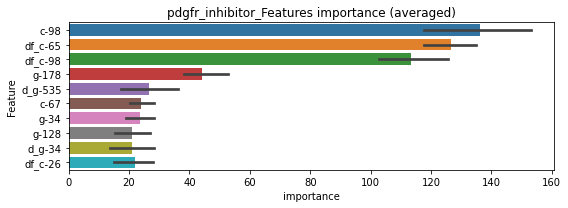

len(train_index) : 3821
len(valid_index) : 3822
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183756	valid_1's binary_logloss: 0.0392368
[200]	training's binary_logloss: 0.00292144	valid_1's binary_logloss: 0.0212996
[300]	training's binary_logloss: 0.000853169	valid_1's binary_logloss: 0.017774
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000467428	valid_1's binary_logloss: 0.0168404


len(train_index) : 3822
len(valid_index) : 3821
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183165	valid_1's binary_logloss: 0.0425949
[200]	training's binary_logloss: 0.00292472	valid_1's binary_logloss: 0.0244796
[300]	training's binary_logloss: 0.000864576	valid_1's binary_logloss: 0.020685
[400]	training's binary_logloss: 0.000417536	valid_1's binary_logloss: 0.0191176
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000365023	valid_1's binary_logloss: 0.0188558


pdgfr_inhibitor logloss: 0.01784793626393558


neg labels: 3289 → selected neg labels: 3286


pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219972	valid_1's binary_logloss: 0.0288092
[200]	training's binary_logloss: 0.00252966	valid_1's binary_logloss: 0.00535914
[300]	training's binary_logloss: 0.000720144	valid_1's binary_logloss: 0.00223505
[400]	training's binary_logloss: 0.000387172	valid_1's binary_logloss: 0.00145494
[500]	training's binary_logloss: 0.000320911	valid_1's binary_logloss: 0.00130494
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000318527	valid_1's binary_logloss: 0.00130051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222407	valid_1's binary_logloss: 0.029171
[200]	training's binary_logloss: 0.00253078	valid_1's binary_logloss: 0.00430228
[300]	training's binary_logloss: 0.000714895	valid_1's binary_logloss: 0.00142877
[400]	training's binary_logloss: 0.000389915	valid_1's binary_logloss: 0.000862866
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0014024, Threshold: 0.0021036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00189, conf_1:0.00231
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021036
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0121036
threshold: 0.0121036, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218966	valid_1's binary_logloss: 0.0288742
[200]	training's binary_logloss: 0.00245297	valid_1's binary_logloss: 0.0055453
[300]	training's binary_logloss: 0.000706535	valid_1's binary_logloss: 0.0025949
[400]	training's binary_logloss: 0.00038386	valid_1's binary_logloss: 0.00189093
[500]	training's binary_logloss: 0.000320993	valid_1's binary_logloss: 0.00176488
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000316395	valid_1's binary_logloss: 0.00175401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222381	valid_1's binary_logloss: 0.0287068
[200]	training's binary_logloss: 0.00246119	valid_1's binary_logloss: 0.00396377
[300]	training's binary_logloss: 0.000707683	valid_1's binary_logloss: 0.00127307
[400]	training's binary_logloss: 0.000389061	valid_1's binary_logloss: 0.000751132
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0435116, Threshold: 0.0121036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076
Num_p_label: 12.0, conf_0:0.01089, conf_1:0.01331
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0121036
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0221036
threshold: 0.0221036, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218966	valid_1's binary_logloss: 0.0288742
[200]	training's binary_logloss: 0.00245297	valid_1's binary_logloss: 0.0055453
[300]	training's binary_logloss: 0.000706535	valid_1's binary_logloss: 0.0025949
[400]	training's binary_logloss: 0.00038386	valid_1's binary_logloss: 0.00189093
[500]	training's binary_logloss: 0.000320993	valid_1's binary_logloss: 0.00176488
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000316395	valid_1's binary_logloss: 0.00175401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222381	valid_1's binary_logloss: 0.0287068
[200]	training's binary_logloss: 0.00246119	valid_1's binary_logloss: 0.00396377
[300]	training's binary_logloss: 0.000707683	valid_1's binary_logloss: 0.00127307
[400]	training's binary_logloss: 0.000389061	valid_1's binary_logloss: 0.000751132
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0435116, Threshold: 0.0221036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.01989, conf_1:0.02431
threshold: 0.0221036, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121214	valid_1's binary_logloss: 0.0184036
[200]	training's binary_logloss: 0.00136379	valid_1's binary_logloss: 0.00579671
[300]	training's binary_logloss: 0.000377052	valid_1's binary_logloss: 0.00447782
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000257456	valid_1's binary_logloss: 0.00433993


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123446	valid_1's binary_logloss: 0.0170249
[200]	training's binary_logloss: 0.0013959	valid_1's binary_logloss: 0.00357169
[300]	training's binary_logloss: 0.000384205	valid_1's binary_logloss: 0.00216669
[400]	training's binary_logloss: 0.000202934	valid_1's binary_logloss: 0.00197651
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000210924	valid_1's binary_logloss: 0.00196987


pdk_inhibitor logloss: 0.003155048935937315


neg labels: 3289 → selected neg labels: 3243


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10618	valid_1's binary_logloss: 0.299509
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0409744	valid_1's binary_logloss: 0.278082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105938	valid_1's binary_logloss: 0.284011
[200]	training's binary_logloss: 0.0366634	valid_1's binary_logloss: 0.255472
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0326669	valid_1's binary_logloss: 0.254231


1 / 3 AUC score:0.887
y_Threshold: 0.0952867, Threshold: 0.1478125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 479 → Positive_corect_labels: 474/3412
p_label_rate: 0.0200904 Vs.target_rate: 0.01109
Num_p_label: 80.0, conf_0:0.13303, conf_1:0.16259
threshold: 0.1478125, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 474.0/3412, y_label_rate: 0.1389215
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744252	valid_1's binary_logloss: 0.210659
[200]	training's binary_logloss: 0.0204849	valid_1's binary_logloss: 0.181083
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0179712	valid_1's binary_logloss: 0.179328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635236	valid_1's binary_logloss: 0.215344
[200]	training's binary_logloss: 0.0162496	valid_1's binary_logloss: 0.187213
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0133802	valid_1's binary_logloss: 0.186705


2 / 3 AUC score:0.942
y_Threshold: 0.0916920, Threshold: 0.1478125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 376.0/3216
p_label_rate: 0.0150678 Vs.target_rate: 0.01109
Num_p_label: 60.0, conf_0:0.13303, conf_1:0.16259
threshold: 0.1478125, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 376.0/3216, y_label_rate: 0.1169154
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478228	valid_1's binary_logloss: 0.164724
[200]	training's binary_logloss: 0.0114476	valid_1's binary_logloss: 0.135248
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00723987	valid_1's binary_logloss: 0.132605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494772	valid_1's binary_logloss: 0.15584
[200]	training's binary_logloss: 0.0115981	valid_1's binary_logloss: 0.126684
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00718413	valid_1's binary_logloss: 0.123489


3 / 3 AUC score:0.969
y_Threshold: 0.0705943, Threshold: 0.1478125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 100 → Positive_corect_labels: 326.0/3116
p_label_rate: 0.0140633 Vs.target_rate: 0.01109
Num_p_label: 56.0, conf_0:0.13303, conf_1:0.16259
threshold: 0.1478125, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 382.0/7098, y_label_rate: 0.0538180


len(train_index) : 3549
len(valid_index) : 3549
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219194	valid_1's binary_logloss: 0.101728
[200]	training's binary_logloss: 0.00482524	valid_1's binary_logloss: 0.0926541
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00521432	valid_1's binary_logloss: 0.0923618


len(train_index) : 3549
len(valid_index) : 3549
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252406	valid_1's binary_logloss: 0.0779038
[200]	training's binary_logloss: 0.00571041	valid_1's binary_logloss: 0.0632106
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00406342	valid_1's binary_logloss: 0.061953


phosphodiesterase_inhibitor logloss: 0.07715736821212948


neg labels: 3289 → selected neg labels: 3285


phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308164	valid_1's binary_logloss: 0.049725
[200]	training's binary_logloss: 0.00527434	valid_1's binary_logloss: 0.0164262
[300]	training's binary_logloss: 0.00129481	valid_1's binary_logloss: 0.00629131
[400]	training's binary_logloss: 0.00056604	valid_1's binary_logloss: 0.00397964
[500]	training's binary_logloss: 0.000380036	valid_1's binary_logloss: 0.00306304
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000358999	valid_1's binary_logloss: 0.00300377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312764	valid_1's binary_logloss: 0.0469533
[200]	training's binary_logloss: 0.00415024	valid_1's binary_logloss: 0.0100152
[300]	training's binary_logloss: 0.00112881	valid_1's binary_logloss: 0.00383298
[400]	training's binary_logloss: 0.000571755	valid_1's binary_logloss: 0.00244708
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0024430, Threshold: 0.0035992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00324, conf_1:0.00396
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0035992
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0135992
threshold: 0.0135992, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298317	valid_1's binary_logloss: 0.0452991
[200]	training's binary_logloss: 0.00391839	valid_1's binary_logloss: 0.0106346
[300]	training's binary_logloss: 0.00109559	valid_1's binary_logloss: 0.0052883
[400]	training's binary_logloss: 0.000551733	valid_1's binary_logloss: 0.00382348
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000439949	valid_1's binary_logloss: 0.00349178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029797	valid_1's binary_logloss: 0.0423991
[200]	training's binary_logloss: 0.00385649	valid_1's binary_logloss: 0.00868419
[300]	training's binary_logloss: 0.00108399	valid_1's binary_logloss: 0.0037013
[400]	training's binary_logloss: 0.000554116	valid_1's binary_logloss: 0.00255005
[500]	training's binary_logloss: 0.000396517	valid_1's binary_logloss: 0.00218126
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0583320, Threshold: 0.0135992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00105
Num_p_label: 17.0, conf_0:0.01224, conf_1:0.01496
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.0135992
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.0235992
threshold: 0.0235992, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298317	valid_1's binary_logloss: 0.0452991
[200]	training's binary_logloss: 0.00391839	valid_1's binary_logloss: 0.0106346
[300]	training's binary_logloss: 0.00109559	valid_1's binary_logloss: 0.0052883
[400]	training's binary_logloss: 0.000551733	valid_1's binary_logloss: 0.00382348
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000439949	valid_1's binary_logloss: 0.00349178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029797	valid_1's binary_logloss: 0.0423991
[200]	training's binary_logloss: 0.00385649	valid_1's binary_logloss: 0.00868419
[300]	training's binary_logloss: 0.00108399	valid_1's binary_logloss: 0.0037013
[400]	training's binary_logloss: 0.000554116	valid_1's binary_logloss: 0.00255005
[500]	training's binary_logloss: 0.000396517	valid_1's binary_logloss: 0.00218126
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0583320, Threshold: 0.0235992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105
Num_p_label: 8.0, conf_0:0.02124, conf_1:0.02596
threshold: 0.0235992, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


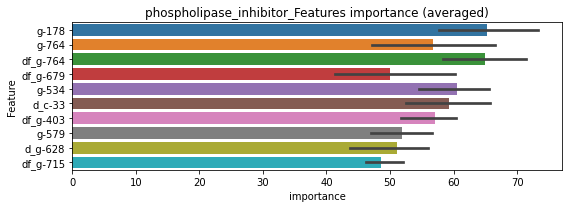

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168835	valid_1's binary_logloss: 0.0306993
[200]	training's binary_logloss: 0.00222189	valid_1's binary_logloss: 0.0131908
[300]	training's binary_logloss: 0.00058977	valid_1's binary_logloss: 0.0110101
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000413393	valid_1's binary_logloss: 0.0107616


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171548	valid_1's binary_logloss: 0.026631
[200]	training's binary_logloss: 0.00232452	valid_1's binary_logloss: 0.0074649
[300]	training's binary_logloss: 0.000631748	valid_1's binary_logloss: 0.00467662
[400]	training's binary_logloss: 0.000308835	valid_1's binary_logloss: 0.00407498
[500]	training's binary_logloss: 0.000213198	valid_1's binary_logloss: 0.00393688
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000204934	valid_1's binary_logloss: 0.00393432


phospholipase_inhibitor logloss: 0.007347959851395404


neg labels: 3289 → selected neg labels: 3264


pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528033	valid_1's binary_logloss: 0.139659
[200]	training's binary_logloss: 0.0115467	valid_1's binary_logloss: 0.104323
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00594427	valid_1's binary_logloss: 0.10125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518892	valid_1's binary_logloss: 0.148417
[200]	training's binary_logloss: 0.0108504	valid_1's binary_logloss: 0.111641
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00551524	valid_1's binary_logloss: 0.105461


1 / 3 AUC score:0.988
y_Threshold: 0.0322394, Threshold: 0.1411300, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 624/3728
p_label_rate: 0.0200904 Vs.target_rate: 0.00634
Num_p_label: 80.0, conf_0:0.12702, conf_1:0.15524
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1411300
Num_p_label: 77.0, Expected: 25.2, Adj_threshold_2: 0.1511300
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_3: 0.1611300
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_4: 0.1711300
Num_p_label: 71.0, Expected: 25.2, Adj_threshold_5: 0.1811300
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_6: 0.1911300
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_7: 0.2011300
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_8: 0.2111300
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_9: 0.2211300
Num_p_label: 64.0, Expected: 25.2, Adj_threshold_10: 0.2311300
threshold: 0.2411300, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 624.0/3728, y_label_rate: 0.1673820

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439456	valid_1's binary_logloss: 0.106887
[200]	training's binary_logloss: 0.00844147	valid_1's binary_logloss: 0.0675586
[300]	training's binary_logloss: 0.0026301	valid_1's binary_logloss: 0.0588243
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00136703	valid_1's binary_logloss: 0.0557661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430703	valid_1's binary_logloss: 0.126039
[200]	training's binary_logloss: 0.00849824	valid_1's binary_logloss: 0.0917653
[300]	training's binary_logloss: 0.00286074	valid_1's binary_logloss: 0.0834684
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00231358	valid_1's binary_logloss: 0.0827066


2 / 3 AUC score:0.993
y_Threshold: 0.0569599, Threshold: 0.2411300, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 594.0/3668
p_label_rate: 0.0288800 Vs.target_rate: 0.00634
Num_p_label: 115.0, conf_0:0.21702, conf_1:0.26524
Num_p_label: 115.0, Expected: 25.2, Adj_threshold_1: 0.2411300
Num_p_label: 113.0, Expected: 25.2, Adj_threshold_2: 0.2511300
Num_p_label: 109.0, Expected: 25.2, Adj_threshold_3: 0.2611300
Num_p_label: 108.0, Expected: 25.2, Adj_threshold_4: 0.2711300
Num_p_label: 108.0, Expected: 25.2, Adj_threshold_5: 0.2811300
Num_p_label: 106.0, Expected: 25.2, Adj_threshold_6: 0.2911300
Num_p_label: 104.0, Expected: 25.2, Adj_threshold_7: 0.3011300
Num_p_label: 101.0, Expected: 25.2, Adj_threshold_8: 0.3111300
Num_p_label: 99.0, Expected: 25.2, Adj_threshold_9: 0.3211300
Num_p_label: 99.0, Expected: 25.2, Adj_threshold_10: 0.3311300
threshold: 0.3411300, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 594.0/3668, y_label_rate:

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414156	valid_1's binary_logloss: 0.0945498
[200]	training's binary_logloss: 0.00733074	valid_1's binary_logloss: 0.0579029
[300]	training's binary_logloss: 0.00220291	valid_1's binary_logloss: 0.0485815
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00121409	valid_1's binary_logloss: 0.0458652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040205	valid_1's binary_logloss: 0.0971024
[200]	training's binary_logloss: 0.00726039	valid_1's binary_logloss: 0.0544079
[300]	training's binary_logloss: 0.00224144	valid_1's binary_logloss: 0.0440499
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00139337	valid_1's binary_logloss: 0.0412469


3 / 3 AUC score:0.999
y_Threshold: 0.0624298, Threshold: 0.3411300, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 579.0/3638
p_label_rate: 0.0399297 Vs.target_rate: 0.00634
Num_p_label: 159.0, conf_0:0.30702, conf_1:0.37524
Num_p_label: 159.0, Expected: 25.2, Adj_threshold_1: 0.3411300
Num_p_label: 159.0, Expected: 25.2, Adj_threshold_2: 0.3511300
Num_p_label: 158.0, Expected: 25.2, Adj_threshold_3: 0.3611300
Num_p_label: 156.0, Expected: 25.2, Adj_threshold_4: 0.3711300
Num_p_label: 156.0, Expected: 25.2, Adj_threshold_5: 0.3811300
Num_p_label: 152.0, Expected: 25.2, Adj_threshold_6: 0.3911300
Num_p_label: 151.0, Expected: 25.2, Adj_threshold_7: 0.4011300
Num_p_label: 151.0, Expected: 25.2, Adj_threshold_8: 0.4111300
Num_p_label: 150.0, Expected: 25.2, Adj_threshold_9: 0.4211300
Num_p_label: 148.0, Expected: 25.2, Adj_threshold_10: 0.4311300
threshold: 0.4411300, positive_p_label: 146.0/3982, p_label_rate: 0.0366650
positive_y_label: 725.0/7620, y_label_ra

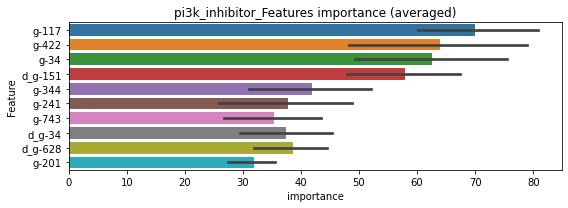

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255112	valid_1's binary_logloss: 0.0686437
[200]	training's binary_logloss: 0.00479409	valid_1's binary_logloss: 0.0430593
[300]	training's binary_logloss: 0.00149827	valid_1's binary_logloss: 0.0370664
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000811493	valid_1's binary_logloss: 0.0347828


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255	valid_1's binary_logloss: 0.0733079
[200]	training's binary_logloss: 0.00463854	valid_1's binary_logloss: 0.0524396
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00159797	valid_1's binary_logloss: 0.0488691


pi3k_inhibitor logloss: 0.04182593496706623


neg labels: 3289 → selected neg labels: 3284


pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323969	valid_1's binary_logloss: 0.0613285
[200]	training's binary_logloss: 0.00467323	valid_1's binary_logloss: 0.0250997
[300]	training's binary_logloss: 0.00128069	valid_1's binary_logloss: 0.0175454
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000687066	valid_1's binary_logloss: 0.015581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315609	valid_1's binary_logloss: 0.0497379
[200]	training's binary_logloss: 0.00446022	valid_1's binary_logloss: 0.0123884
[300]	training's binary_logloss: 0.00124156	valid_1's binary_logloss: 0.00586947
[400]	training's binary_logloss: 0.00061053	valid_1's binary_logloss: 0.00416131
[500]	training's binary_logloss: 0.000427717	valid_1's binary_logloss: 0.00368471
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000423017	valid_1's binary_logloss: 0.00366611


1 / 3 AUC score:1.000
y_Threshold: 0.0034065, Threshold: 0.0057969, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00522, conf_1:0.00638
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0057969
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_2: 0.0157969
threshold: 0.0157969, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314635	valid_1's binary_logloss: 0.0601331
[200]	training's binary_logloss: 0.00441179	valid_1's binary_logloss: 0.0249759
[300]	training's binary_logloss: 0.0012177	valid_1's binary_logloss: 0.0174814
[400]	training's binary_logloss: 0.000613087	valid_1's binary_logloss: 0.015431
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000471212	valid_1's binary_logloss: 0.0146089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317863	valid_1's binary_logloss: 0.04794
[200]	training's binary_logloss: 0.00435498	valid_1's binary_logloss: 0.0121638
[300]	training's binary_logloss: 0.00121446	valid_1's binary_logloss: 0.00606127
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000669397	valid_1's binary_logloss: 0.00469295


2 / 3 AUC score:1.000
y_Threshold: 0.0233878, Threshold: 0.0157969, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0107986 Vs.target_rate: 0.00130
Num_p_label: 43.0, conf_0:0.01422, conf_1:0.01738
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_1: 0.0157969
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_2: 0.0257969
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_3: 0.0357969
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_4: 0.0457969
threshold: 0.0457969, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321288	valid_1's binary_logloss: 0.0530385
[200]	training's binary_logloss: 0.00448771	valid_1's binary_logloss: 0.0146965
[300]	training's binary_logloss: 0.00123607	valid_1's binary_logloss: 0.00691745
[400]	training's binary_logloss: 0.000618262	valid_1's binary_logloss: 0.00494946
[500]	training's binary_logloss: 0.000429703	valid_1's binary_logloss: 0.00419417
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000435989	valid_1's binary_logloss: 0.00418608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320338	valid_1's binary_logloss: 0.0473095
[200]	training's binary_logloss: 0.00448225	valid_1's binary_logloss: 0.0116203
[300]	training's binary_logloss: 0.00124863	valid_1's binary_logloss: 0.00563822
[400]	training's binary_logloss: 0.000608583	valid_1's binary_logloss: 0.00388245
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0317203, Threshold: 0.0457969, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0017579 Vs.target_rate: 0.00130
Num_p_label: 7.0, conf_0:0.04122, conf_1:0.05038
threshold: 0.0457969, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


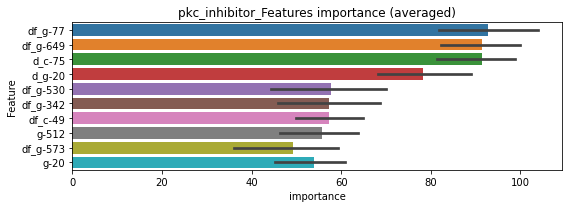

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181578	valid_1's binary_logloss: 0.0312215
[200]	training's binary_logloss: 0.00251138	valid_1's binary_logloss: 0.0123205
[300]	training's binary_logloss: 0.000666875	valid_1's binary_logloss: 0.00930555
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0004493	valid_1's binary_logloss: 0.00889486


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179424	valid_1's binary_logloss: 0.0299507
[200]	training's binary_logloss: 0.00249386	valid_1's binary_logloss: 0.00901256
[300]	training's binary_logloss: 0.00068185	valid_1's binary_logloss: 0.00514356
[400]	training's binary_logloss: 0.000331882	valid_1's binary_logloss: 0.00422022
[500]	training's binary_logloss: 0.000222231	valid_1's binary_logloss: 0.00392152
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000225602	valid_1's binary_logloss: 0.00391292


pkc_inhibitor logloss: 0.0064038865955123245


neg labels: 3289 → selected neg labels: 3279


potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471534	valid_1's binary_logloss: 0.0909978
[200]	training's binary_logloss: 0.00840201	valid_1's binary_logloss: 0.034036
[300]	training's binary_logloss: 0.00237921	valid_1's binary_logloss: 0.017809
[400]	training's binary_logloss: 0.00110898	valid_1's binary_logloss: 0.0126779
[500]	training's binary_logloss: 0.000706765	valid_1's binary_logloss: 0.0106712
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000600167	valid_1's binary_logloss: 0.00995941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492315	valid_1's binary_logloss: 0.0994676
[200]	training's binary_logloss: 0.0089115	valid_1's binary_logloss: 0.0581785
[300]	training's binary_logloss: 0.00244805	valid_1's binary_logloss: 0.0493246
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0015656	valid_1's binary_logloss: 0.0486355


1 / 3 AUC score:0.998
y_Threshold: 0.0104139, Threshold: 0.0174062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01567, conf_1:0.01915
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0174062
Num_p_label: 38.0, Expected: 9.2, Adj_threshold_2: 0.0274062
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_3: 0.0374062
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_4: 0.0474062
threshold: 0.0474062, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477006	valid_1's binary_logloss: 0.0895317
[200]	training's binary_logloss: 0.00870189	valid_1's binary_logloss: 0.0353866
[300]	training's binary_logloss: 0.00240292	valid_1's binary_logloss: 0.0200512
[400]	training's binary_logloss: 0.00110851	valid_1's binary_logloss: 0.0142724
[500]	training's binary_logloss: 0.000697061	valid_1's binary_logloss: 0.0119163
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000573889	valid_1's binary_logloss: 0.0112824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482347	valid_1's binary_logloss: 0.0777724
[200]	training's binary_logloss: 0.00845092	valid_1's binary_logloss: 0.0259813
[300]	training's binary_logloss: 0.00237943	valid_1's binary_logloss: 0.0154536
[400]	training's binary_logloss: 0.00110353	valid_1's binary_logloss: 0.0128154
Early stopping, best iteration is:
[437]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0615209, Threshold: 0.0474062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0070316 Vs.target_rate: 0.00231
Num_p_label: 28.0, conf_0:0.04267, conf_1:0.05215
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.0474062
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_2: 0.0574062
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_3: 0.0674062
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_4: 0.0774062
threshold: 0.0774062, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448138	valid_1's binary_logloss: 0.086737
[200]	training's binary_logloss: 0.00796919	valid_1's binary_logloss: 0.0441329
[300]	training's binary_logloss: 0.00225695	valid_1's binary_logloss: 0.0357138
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00135808	valid_1's binary_logloss: 0.0345158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461671	valid_1's binary_logloss: 0.0831667
[200]	training's binary_logloss: 0.00828697	valid_1's binary_logloss: 0.0318632
[300]	training's binary_logloss: 0.00236642	valid_1's binary_logloss: 0.0175343
[400]	training's binary_logloss: 0.00110398	valid_1's binary_logloss: 0.0132126
[500]	training's binary_logloss: 0.000702091	valid_1's binary_logloss: 0.0119382
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00061722	valid_1's binary_logloss: 0.0115817


3 / 3 AUC score:0.997
y_Threshold: 0.0474656, Threshold: 0.0774062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0030136 Vs.target_rate: 0.00231
Num_p_label: 12.0, conf_0:0.06967, conf_1:0.08515
threshold: 0.0774062, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/7764, y_label_rate: 0.0846213


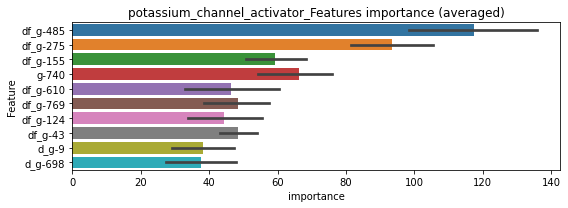

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278727	valid_1's binary_logloss: 0.0514022
[200]	training's binary_logloss: 0.00498512	valid_1's binary_logloss: 0.0225955
[300]	training's binary_logloss: 0.00136287	valid_1's binary_logloss: 0.0168972
[400]	training's binary_logloss: 0.000601657	valid_1's binary_logloss: 0.0157084
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000534072	valid_1's binary_logloss: 0.0155768


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257851	valid_1's binary_logloss: 0.06074
[200]	training's binary_logloss: 0.00455446	valid_1's binary_logloss: 0.0380692
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00224642	valid_1's binary_logloss: 0.0361141


potassium_channel_activator logloss: 0.025845463398057825


neg labels: 3289 → selected neg labels: 3272


potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659873	valid_1's binary_logloss: 0.152997
[200]	training's binary_logloss: 0.017373	valid_1's binary_logloss: 0.100139
[300]	training's binary_logloss: 0.00510082	valid_1's binary_logloss: 0.0797573
[400]	training's binary_logloss: 0.00212844	valid_1's binary_logloss: 0.0735614
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00168212	valid_1's binary_logloss: 0.0727172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066377	valid_1's binary_logloss: 0.141828
[200]	training's binary_logloss: 0.016674	valid_1's binary_logloss: 0.0905364
[300]	training's binary_logloss: 0.00504833	valid_1's binary_logloss: 0.077219
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00323272	valid_1's binary_logloss: 0.0735859


1 / 3 AUC score:0.990
y_Threshold: 0.0200457, Threshold: 0.0240278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 634/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.00412
Num_p_label: 80.0, conf_0:0.02163, conf_1:0.02643
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0240278
Num_p_label: 38.0, Expected: 16.4, Adj_threshold_2: 0.0340278
Num_p_label: 27.0, Expected: 16.4, Adj_threshold_3: 0.0440278
threshold: 0.0440278, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 634.0/3754, y_label_rate: 0.1688865
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637007	valid_1's binary_logloss: 0.137357
[200]	training's binary_logloss: 0.0150666	valid_1's binary_logloss: 0.0825836
[300]	training's binary_logloss: 0.00455967	valid_1's binary_logloss: 0.0690947
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00224454	valid_1's binary_logloss: 0.065422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059861	valid_1's binary_logloss: 0.136266
[200]	training's binary_logloss: 0.0137557	valid_1's binary_logloss: 0.0866818
[300]	training's binary_logloss: 0.00425933	valid_1's binary_logloss: 0.074823
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00386471	valid_1's binary_logloss: 0.0746002


2 / 3 AUC score:0.990
y_Threshold: 0.0507205, Threshold: 0.0440278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 602.0/3690
p_label_rate: 0.0168257 Vs.target_rate: 0.00412
Num_p_label: 67.0, conf_0:0.03963, conf_1:0.04843
Num_p_label: 67.0, Expected: 16.4, Adj_threshold_1: 0.0440278
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_2: 0.0540278
Num_p_label: 31.0, Expected: 16.4, Adj_threshold_3: 0.0640278
threshold: 0.0640278, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 602.0/3690, y_label_rate: 0.1631436
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056307	valid_1's binary_logloss: 0.111182
[200]	training's binary_logloss: 0.0130307	valid_1's binary_logloss: 0.0562874
[300]	training's binary_logloss: 0.00395378	valid_1's binary_logloss: 0.0384614
[400]	training's binary_logloss: 0.00178066	valid_1's binary_logloss: 0.0325284
[500]	training's binary_logloss: 0.0010713	valid_1's binary_logloss: 0.0303557
[600]	training's binary_logloss: 0.000773062	valid_1's binary_logloss: 0.0294324
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000775417	valid_1's binary_logloss: 0.0294246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549497	valid_1's binary_logloss: 0.126277
[200]	training's binary_logloss: 0.0123537	valid_1's binary_logloss: 0.0770257
[300]	training's binary_logloss: 0.00374236	valid_1's binary_logloss: 0.0657275
[400]	training's binary_logloss: 0.00166625	valid

3 / 3 AUC score:0.999
y_Threshold: 0.0419022, Threshold: 0.0640278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 590.0/3666
p_label_rate: 0.0047715 Vs.target_rate: 0.00412
Num_p_label: 19.0, conf_0:0.05763, conf_1:0.07043
threshold: 0.0640278, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 609.0/7648, y_label_rate: 0.0796287


len(train_index) : 3824
len(valid_index) : 3824
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311645	valid_1's binary_logloss: 0.0757882
[200]	training's binary_logloss: 0.0069031	valid_1's binary_logloss: 0.0495273
[300]	training's binary_logloss: 0.00202906	valid_1's binary_logloss: 0.0447899
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0021561	valid_1's binary_logloss: 0.0447079


len(train_index) : 3824
len(valid_index) : 3824
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298261	valid_1's binary_logloss: 0.0755618
[200]	training's binary_logloss: 0.00666338	valid_1's binary_logloss: 0.0522551
[300]	training's binary_logloss: 0.00194143	valid_1's binary_logloss: 0.0478757
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00210361	valid_1's binary_logloss: 0.0477965


potassium_channel_antagonist logloss: 0.04625218364190387


neg labels: 3289 → selected neg labels: 3269


ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618907	valid_1's binary_logloss: 0.158157
[200]	training's binary_logloss: 0.013248	valid_1's binary_logloss: 0.114667
[300]	training's binary_logloss: 0.00396726	valid_1's binary_logloss: 0.107592
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00333758	valid_1's binary_logloss: 0.106897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582344	valid_1's binary_logloss: 0.154854
[200]	training's binary_logloss: 0.0132078	valid_1's binary_logloss: 0.107488
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0054819	valid_1's binary_logloss: 0.0972435


1 / 3 AUC score:0.983
y_Threshold: 0.0276163, Threshold: 0.0693553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 620/3724
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.06242, conf_1:0.07629
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0693553
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_2: 0.0793553
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_3: 0.0893553
Num_p_label: 54.0, Expected: 19.2, Adj_threshold_4: 0.0993553
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_5: 0.1093553
Num_p_label: 45.0, Expected: 19.2, Adj_threshold_6: 0.1193553
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_7: 0.1293553
threshold: 0.1293553, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 620.0/3724, y_label_rate: 0.1664876
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565105	valid_1's binary_logloss: 0.121259
[200]	training's binary_logloss: 0.0116455	valid_1's binary_logloss: 0.0689178
[300]	training's binary_logloss: 0.0036251	valid_1's binary_logloss: 0.0529769
[400]	training's binary_logloss: 0.00166758	valid_1's binary_logloss: 0.047045
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00126424	valid_1's binary_logloss: 0.045174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523043	valid_1's binary_logloss: 0.135638
[200]	training's binary_logloss: 0.0103908	valid_1's binary_logloss: 0.0882093
[300]	training's binary_logloss: 0.00321079	valid_1's binary_logloss: 0.075794
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00175631	valid_1's binary_logloss: 0.0724951


2 / 3 AUC score:0.998
y_Threshold: 0.0569717, Threshold: 0.1293553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 597.0/3678
p_label_rate: 0.0193370 Vs.target_rate: 0.00483
Num_p_label: 77.0, conf_0:0.11642, conf_1:0.14229
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_1: 0.1293553
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_2: 0.1393553
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_3: 0.1493553
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_4: 0.1593553
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_5: 0.1693553
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_6: 0.1793553
Num_p_label: 51.0, Expected: 19.2, Adj_threshold_7: 0.1893553
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_8: 0.1993553
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_9: 0.2093553
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_10: 0.2193553
threshold: 0.2293553, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 597.0/3678, y_label_rate: 0.162316

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504323	valid_1's binary_logloss: 0.120915
[200]	training's binary_logloss: 0.0100417	valid_1's binary_logloss: 0.0764503
[300]	training's binary_logloss: 0.00309841	valid_1's binary_logloss: 0.0652168
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00162247	valid_1's binary_logloss: 0.0622556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516509	valid_1's binary_logloss: 0.118656
[200]	training's binary_logloss: 0.0102946	valid_1's binary_logloss: 0.0657889
[300]	training's binary_logloss: 0.00318703	valid_1's binary_logloss: 0.0499587
[400]	training's binary_logloss: 0.00150205	valid_1's binary_logloss: 0.0443309
[500]	training's binary_logloss: 0.000934036	valid_1's binary_logloss: 0.0421225
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000958087	valid_1's binary_logloss: 0.0419758


3 / 3 AUC score:0.999
y_Threshold: 0.0461486, Threshold: 0.2293553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 582.0/3648
p_label_rate: 0.0115520 Vs.target_rate: 0.00483
Num_p_label: 46.0, conf_0:0.20642, conf_1:0.25229
threshold: 0.2293553, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 628.0/7630, y_label_rate: 0.0823067


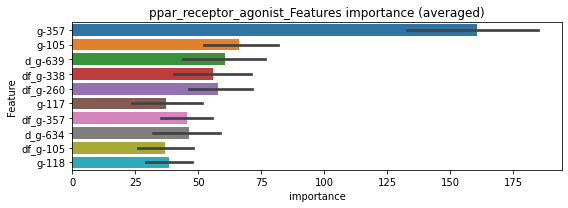

len(train_index) : 3815
len(valid_index) : 3815
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298055	valid_1's binary_logloss: 0.0760639
[200]	training's binary_logloss: 0.00581646	valid_1's binary_logloss: 0.0516569
[300]	training's binary_logloss: 0.0017496	valid_1's binary_logloss: 0.0460482
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000986736	valid_1's binary_logloss: 0.0440274


len(train_index) : 3815
len(valid_index) : 3815
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278377	valid_1's binary_logloss: 0.0849431
[200]	training's binary_logloss: 0.00557445	valid_1's binary_logloss: 0.0623182
[300]	training's binary_logloss: 0.00171879	valid_1's binary_logloss: 0.0572149
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00179726	valid_1's binary_logloss: 0.057127


ppar_receptor_agonist logloss: 0.05057722793994181


neg labels: 3289 → selected neg labels: 3284


ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319641	valid_1's binary_logloss: 0.0519021
[200]	training's binary_logloss: 0.00453013	valid_1's binary_logloss: 0.0148771
[300]	training's binary_logloss: 0.00125939	valid_1's binary_logloss: 0.00747098
[400]	training's binary_logloss: 0.000617895	valid_1's binary_logloss: 0.00564955
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000455679	valid_1's binary_logloss: 0.00502981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320219	valid_1's binary_logloss: 0.0524627
[200]	training's binary_logloss: 0.00455859	valid_1's binary_logloss: 0.0134118
[300]	training's binary_logloss: 0.00126133	valid_1's binary_logloss: 0.00626871
[400]	training's binary_logloss: 0.000625737	valid_1's binary_logloss: 0.00453137
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000442857	valid_1's binary_logloss: 0.00377939


1 / 3 AUC score:1.000
y_Threshold: 0.0034855, Threshold: 0.0055168, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00497, conf_1:0.00607
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0055168
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_2: 0.0155168
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_3: 0.0255168
threshold: 0.0255168, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031178	valid_1's binary_logloss: 0.0478653
[200]	training's binary_logloss: 0.00430389	valid_1's binary_logloss: 0.0122239
[300]	training's binary_logloss: 0.00119396	valid_1's binary_logloss: 0.00544992
[400]	training's binary_logloss: 0.00059709	valid_1's binary_logloss: 0.00375062
[500]	training's binary_logloss: 0.000422926	valid_1's binary_logloss: 0.00320963
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00041454	valid_1's binary_logloss: 0.00315521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313793	valid_1's binary_logloss: 0.0502539
[200]	training's binary_logloss: 0.00434359	valid_1's binary_logloss: 0.0117669
[300]	training's binary_logloss: 0.00122591	valid_1's binary_logloss: 0.00516668
[400]	training's binary_logloss: 0.000613689	valid_1's binary_logloss: 0.00376005
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0974913, Threshold: 0.0255168, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0052737 Vs.target_rate: 0.00126
Num_p_label: 21.0, conf_0:0.02297, conf_1:0.02807
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_1: 0.0255168
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.0355168
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0455168
threshold: 0.0455168, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031178	valid_1's binary_logloss: 0.0478653
[200]	training's binary_logloss: 0.00430389	valid_1's binary_logloss: 0.0122239
[300]	training's binary_logloss: 0.00119396	valid_1's binary_logloss: 0.00544992
[400]	training's binary_logloss: 0.00059709	valid_1's binary_logloss: 0.00375062
[500]	training's binary_logloss: 0.000422926	valid_1's binary_logloss: 0.00320963
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00041454	valid_1's binary_logloss: 0.00315521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313793	valid_1's binary_logloss: 0.0502539
[200]	training's binary_logloss: 0.00434359	valid_1's binary_logloss: 0.0117669
[300]	training's binary_logloss: 0.00122591	valid_1's binary_logloss: 0.00516668
[400]	training's binary_logloss: 0.000613689	valid_1's binary_logloss: 0.00376005
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0974913, Threshold: 0.0455168, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.04097, conf_1:0.05007
threshold: 0.0455168, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


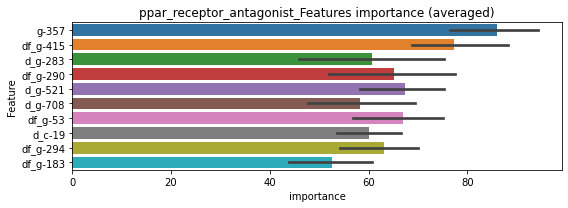

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179537	valid_1's binary_logloss: 0.0378035
[200]	training's binary_logloss: 0.00257986	valid_1's binary_logloss: 0.0163036
[300]	training's binary_logloss: 0.000699993	valid_1's binary_logloss: 0.0139352
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000732969	valid_1's binary_logloss: 0.0139052


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192129	valid_1's binary_logloss: 0.0324545
[200]	training's binary_logloss: 0.00279531	valid_1's binary_logloss: 0.0121459
[300]	training's binary_logloss: 0.000762002	valid_1's binary_logloss: 0.00797863
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000384898	valid_1's binary_logloss: 0.00706828


ppar_receptor_antagonist logloss: 0.010486762587010368


neg labels: 3289 → selected neg labels: 3271


progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617736	valid_1's binary_logloss: 0.160789
[200]	training's binary_logloss: 0.0148896	valid_1's binary_logloss: 0.120433
[300]	training's binary_logloss: 0.00449371	valid_1's binary_logloss: 0.112595
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00449371	valid_1's binary_logloss: 0.112595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616373	valid_1's binary_logloss: 0.151528
[200]	training's binary_logloss: 0.0151555	valid_1's binary_logloss: 0.111323
[300]	training's binary_logloss: 0.00468313	valid_1's binary_logloss: 0.105344
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00504154	valid_1's binary_logloss: 0.105116


1 / 3 AUC score:0.977
y_Threshold: 0.0304219, Threshold: 0.0461535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 217 → Positive_corect_labels: 611/3708
p_label_rate: 0.0200904 Vs.target_rate: 0.00500
Num_p_label: 80.0, conf_0:0.04154, conf_1:0.05077
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0461535
Num_p_label: 50.0, Expected: 19.9, Adj_threshold_2: 0.0561535
Num_p_label: 35.0, Expected: 19.9, Adj_threshold_3: 0.0661535
threshold: 0.0661535, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 611.0/3708, y_label_rate: 0.1647789
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578819	valid_1's binary_logloss: 0.12119
[200]	training's binary_logloss: 0.0128752	valid_1's binary_logloss: 0.0728472
[300]	training's binary_logloss: 0.00393706	valid_1's binary_logloss: 0.0594649
[400]	training's binary_logloss: 0.00177128	valid_1's binary_logloss: 0.0538895
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00167548	valid_1's binary_logloss: 0.0536303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524622	valid_1's binary_logloss: 0.132444
[200]	training's binary_logloss: 0.0115825	valid_1's binary_logloss: 0.0809843
[300]	training's binary_logloss: 0.00360932	valid_1's binary_logloss: 0.0688387
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00213343	valid_1's binary_logloss: 0.0664208


2 / 3 AUC score:0.997
y_Threshold: 0.0494291, Threshold: 0.0661535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 588.0/3662
p_label_rate: 0.0130588 Vs.target_rate: 0.00500
Num_p_label: 52.0, conf_0:0.05954, conf_1:0.07277
threshold: 0.0661535, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 588.0/3662, y_label_rate: 0.1605680
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510705	valid_1's binary_logloss: 0.120659
[200]	training's binary_logloss: 0.0106699	valid_1's binary_logloss: 0.0732232
[300]	training's binary_logloss: 0.003256	valid_1's binary_logloss: 0.0620001
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00266022	valid_1's binary_logloss: 0.0608578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483441	valid_1's binary_logloss: 0.128616
[200]	training's binary_logloss: 0.0101264	valid_1's binary_logloss: 0.0822351
[300]	training's binary_logloss: 0.00313881	valid_1's binary_logloss: 0.0719951
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00234835	valid_1's binary_logloss: 0.0702197


3 / 3 AUC score:0.995
y_Threshold: 0.0493240, Threshold: 0.0661535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 565.0/3616
p_label_rate: 0.0163235 Vs.target_rate: 0.00500
Num_p_label: 65.0, conf_0:0.05954, conf_1:0.07277
Num_p_label: 65.0, Expected: 19.9, Adj_threshold_1: 0.0661535
Num_p_label: 52.0, Expected: 19.9, Adj_threshold_2: 0.0761535
Num_p_label: 46.0, Expected: 19.9, Adj_threshold_3: 0.0861535
Num_p_label: 39.0, Expected: 19.9, Adj_threshold_4: 0.0961535
threshold: 0.0961535, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 604.0/7598, y_label_rate: 0.0794946


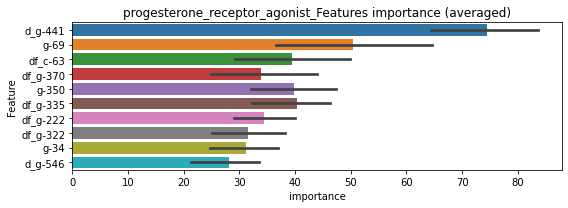

len(train_index) : 3799
len(valid_index) : 3799
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271575	valid_1's binary_logloss: 0.0732783
[200]	training's binary_logloss: 0.00582111	valid_1's binary_logloss: 0.0508903
[300]	training's binary_logloss: 0.00174245	valid_1's binary_logloss: 0.0467565
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00151749	valid_1's binary_logloss: 0.0465631


len(train_index) : 3799
len(valid_index) : 3799
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292206	valid_1's binary_logloss: 0.0805037
[200]	training's binary_logloss: 0.00630811	valid_1's binary_logloss: 0.0576072
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00212538	valid_1's binary_logloss: 0.0539453


progesterone_receptor_agonist logloss: 0.05025419868497667


neg labels: 3289 → selected neg labels: 3286


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215705	valid_1's binary_logloss: 0.0276366
[200]	training's binary_logloss: 0.00239086	valid_1's binary_logloss: 0.00458307
[300]	training's binary_logloss: 0.000677399	valid_1's binary_logloss: 0.00173416
[400]	training's binary_logloss: 0.000363795	valid_1's binary_logloss: 0.00111
[500]	training's binary_logloss: 0.000295315	valid_1's binary_logloss: 0.000961806
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000294578	valid_1's binary_logloss: 0.000960757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218809	valid_1's binary_logloss: 0.0288746
[200]	training's binary_logloss: 0.00242946	valid_1's binary_logloss: 0.00422119
[300]	training's binary_logloss: 0.000679979	valid_1's binary_logloss: 0.00150666
[400]	training's binary_logloss: 0.000368164	valid_1's binary_logloss: 0.000905731
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0013583, Threshold: 0.0025902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00233, conf_1:0.00285
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025902
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0125902
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.0225902
threshold: 0.0225902, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216452	valid_1's binary_logloss: 0.0278887
[200]	training's binary_logloss: 0.00236551	valid_1's binary_logloss: 0.00430472
[300]	training's binary_logloss: 0.000666754	valid_1's binary_logloss: 0.00155004
[400]	training's binary_logloss: 0.00036057	valid_1's binary_logloss: 0.000943125
[500]	training's binary_logloss: 0.000294494	valid_1's binary_logloss: 0.000822487
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000291693	valid_1's binary_logloss: 0.00081769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021813	valid_1's binary_logloss: 0.0277192
[200]	training's binary_logloss: 0.00234318	valid_1's binary_logloss: 0.00376233
[300]	training's binary_logloss: 0.000656806	valid_1's binary_logloss: 0.00120652
[400]	training's binary_logloss: 0.000357939	valid_1's binary_logloss: 0.000716127
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1345294, Threshold: 0.0225902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076
Num_p_label: 17.0, conf_0:0.02033, conf_1:0.02485
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0225902
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0325902
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0425902
threshold: 0.0425902, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216452	valid_1's binary_logloss: 0.0278887
[200]	training's binary_logloss: 0.00236551	valid_1's binary_logloss: 0.00430472
[300]	training's binary_logloss: 0.000666754	valid_1's binary_logloss: 0.00155004
[400]	training's binary_logloss: 0.00036057	valid_1's binary_logloss: 0.000943125
[500]	training's binary_logloss: 0.000294494	valid_1's binary_logloss: 0.000822487
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000291693	valid_1's binary_logloss: 0.00081769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021813	valid_1's binary_logloss: 0.0277192
[200]	training's binary_logloss: 0.00234318	valid_1's binary_logloss: 0.00376233
[300]	training's binary_logloss: 0.000656806	valid_1's binary_logloss: 0.00120652
[400]	training's binary_logloss: 0.000357939	valid_1's binary_logloss: 0.000716127
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1345294, Threshold: 0.0425902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.03833, conf_1:0.04685
threshold: 0.0425902, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


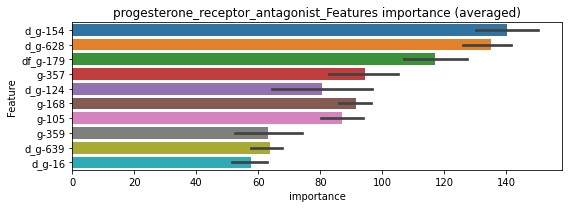

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115344	valid_1's binary_logloss: 0.0192892
[200]	training's binary_logloss: 0.00126024	valid_1's binary_logloss: 0.00709574
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000410833	valid_1's binary_logloss: 0.00619862


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121231	valid_1's binary_logloss: 0.0184316
[200]	training's binary_logloss: 0.00138868	valid_1's binary_logloss: 0.00543561
[300]	training's binary_logloss: 0.000383271	valid_1's binary_logloss: 0.00318715
[400]	training's binary_logloss: 0.00019889	valid_1's binary_logloss: 0.00273641
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00016859	valid_1's binary_logloss: 0.00263791


progesterone_receptor_antagonist logloss: 0.0044184915560498495


neg labels: 3289 → selected neg labels: 3283


prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344073	valid_1's binary_logloss: 0.0601338
[200]	training's binary_logloss: 0.00531334	valid_1's binary_logloss: 0.0199554
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0115297
[400]	training's binary_logloss: 0.000724737	valid_1's binary_logloss: 0.0082598
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000724737	valid_1's binary_logloss: 0.0082598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351096	valid_1's binary_logloss: 0.0679916
[200]	training's binary_logloss: 0.00541652	valid_1's binary_logloss: 0.0304136
[300]	training's binary_logloss: 0.00151545	valid_1's binary_logloss: 0.02266
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00146136	valid_1's binary_logloss: 0.022397


1 / 3 AUC score:1.000
y_Threshold: 0.0072187, Threshold: 0.0100710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00906, conf_1:0.01108
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0100710
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.0200710
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0300710
threshold: 0.0300710, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354796	valid_1's binary_logloss: 0.0597528
[200]	training's binary_logloss: 0.00532225	valid_1's binary_logloss: 0.0190291
[300]	training's binary_logloss: 0.00148057	valid_1's binary_logloss: 0.0107472
[400]	training's binary_logloss: 0.000721779	valid_1's binary_logloss: 0.00809471
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000650163	valid_1's binary_logloss: 0.00773724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335676	valid_1's binary_logloss: 0.0649784
[200]	training's binary_logloss: 0.00498174	valid_1's binary_logloss: 0.0294802
[300]	training's binary_logloss: 0.00140529	valid_1's binary_logloss: 0.0206483
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00110239	valid_1's binary_logloss: 0.0199827


2 / 3 AUC score:1.000
y_Threshold: 0.0284570, Threshold: 0.0300710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0080362 Vs.target_rate: 0.00151
Num_p_label: 32.0, conf_0:0.02706, conf_1:0.03308
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_1: 0.0300710
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0400710
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0500710
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.0600710
threshold: 0.0600710, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339074	valid_1's binary_logloss: 0.0599252
[200]	training's binary_logloss: 0.00502186	valid_1's binary_logloss: 0.0189677
[300]	training's binary_logloss: 0.00144755	valid_1's binary_logloss: 0.011169
[400]	training's binary_logloss: 0.000717523	valid_1's binary_logloss: 0.00900268
[500]	training's binary_logloss: 0.000485274	valid_1's binary_logloss: 0.008211
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000493722	valid_1's binary_logloss: 0.00818708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354463	valid_1's binary_logloss: 0.058834
[200]	training's binary_logloss: 0.00530601	valid_1's binary_logloss: 0.01462
[300]	training's binary_logloss: 0.0014721	valid_1's binary_logloss: 0.00600733
[400]	training's binary_logloss: 0.000718451	valid_1's binary_logloss: 0.00385816
[500]	training's binary_logloss: 0.00048396

3 / 3 AUC score:1.000
y_Threshold: 0.0496322, Threshold: 0.0600710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0017579 Vs.target_rate: 0.00151
Num_p_label: 7.0, conf_0:0.05406, conf_1:0.06608
threshold: 0.0600710, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7787, y_label_rate: 0.0850135


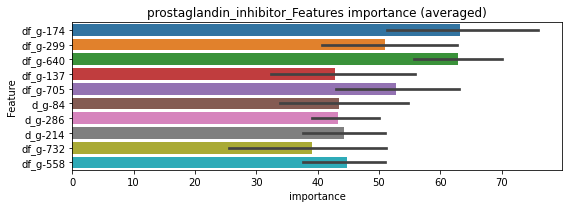

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190057	valid_1's binary_logloss: 0.0319407
[200]	training's binary_logloss: 0.00284368	valid_1's binary_logloss: 0.0115341
[300]	training's binary_logloss: 0.000782397	valid_1's binary_logloss: 0.00799786
[400]	training's binary_logloss: 0.000378299	valid_1's binary_logloss: 0.00733501
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00039681	valid_1's binary_logloss: 0.00731097


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185095	valid_1's binary_logloss: 0.0345236
[200]	training's binary_logloss: 0.00283689	valid_1's binary_logloss: 0.0124685
[300]	training's binary_logloss: 0.000783807	valid_1's binary_logloss: 0.00762276
[400]	training's binary_logloss: 0.000377817	valid_1's binary_logloss: 0.00615931
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000301291	valid_1's binary_logloss: 0.00571272


prostaglandin_inhibitor logloss: 0.006511947184531698


neg labels: 3289 → selected neg labels: 3274


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631334	valid_1's binary_logloss: 0.133809
[200]	training's binary_logloss: 0.0147021	valid_1's binary_logloss: 0.078385
[300]	training's binary_logloss: 0.00439141	valid_1's binary_logloss: 0.0622915
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00204153	valid_1's binary_logloss: 0.0573168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585449	valid_1's binary_logloss: 0.148772
[200]	training's binary_logloss: 0.013002	valid_1's binary_logloss: 0.102802
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00654434	valid_1's binary_logloss: 0.0957048


1 / 3 AUC score:0.986
y_Threshold: 0.0234593, Threshold: 0.0323195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 627/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00353
Num_p_label: 80.0, conf_0:0.02909, conf_1:0.03555
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0323195
Num_p_label: 49.0, Expected: 14.0, Adj_threshold_2: 0.0423195
Num_p_label: 31.0, Expected: 14.0, Adj_threshold_3: 0.0523195
Num_p_label: 20.0, Expected: 14.0, Adj_threshold_4: 0.0623195
threshold: 0.0623195, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 627.0/3742, y_label_rate: 0.1675575
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567069	valid_1's binary_logloss: 0.128298
[200]	training's binary_logloss: 0.0122964	valid_1's binary_logloss: 0.0802969
[300]	training's binary_logloss: 0.00363882	valid_1's binary_logloss: 0.0684237
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00313238	valid_1's binary_logloss: 0.0677406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584755	valid_1's binary_logloss: 0.118362
[200]	training's binary_logloss: 0.0128607	valid_1's binary_logloss: 0.0614732
[300]	training's binary_logloss: 0.0036952	valid_1's binary_logloss: 0.0460224
[400]	training's binary_logloss: 0.00167031	valid_1's binary_logloss: 0.040681
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00161045	valid_1's binary_logloss: 0.0406347


2 / 3 AUC score:0.993
y_Threshold: 0.0471245, Threshold: 0.0623195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 606.0/3700
p_label_rate: 0.0085384 Vs.target_rate: 0.00353
Num_p_label: 34.0, conf_0:0.05609, conf_1:0.06855
threshold: 0.0623195, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 606.0/3700, y_label_rate: 0.1637838
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509611	valid_1's binary_logloss: 0.120973
[200]	training's binary_logloss: 0.0106819	valid_1's binary_logloss: 0.0699531
[300]	training's binary_logloss: 0.00314966	valid_1's binary_logloss: 0.057833
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00178753	valid_1's binary_logloss: 0.0548653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529664	valid_1's binary_logloss: 0.123255
[200]	training's binary_logloss: 0.011286	valid_1's binary_logloss: 0.0671853
[300]	training's binary_logloss: 0.00331655	valid_1's binary_logloss: 0.0521393
[400]	training's binary_logloss: 0.0014931	valid_1's binary_logloss: 0.0468193
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00102234	valid_1's binary_logloss: 0.0452776


3 / 3 AUC score:0.998
y_Threshold: 0.0493043, Threshold: 0.0623195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 594.0/3676
p_label_rate: 0.0050226 Vs.target_rate: 0.00353
Num_p_label: 20.0, conf_0:0.05609, conf_1:0.06855
threshold: 0.0623195, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 614.0/7658, y_label_rate: 0.0801776


len(train_index) : 3829
len(valid_index) : 3829
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299521	valid_1's binary_logloss: 0.0715513
[200]	training's binary_logloss: 0.00613661	valid_1's binary_logloss: 0.0446365
[300]	training's binary_logloss: 0.00169625	valid_1's binary_logloss: 0.0386415
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000963117	valid_1's binary_logloss: 0.0372969


len(train_index) : 3829
len(valid_index) : 3829
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304876	valid_1's binary_logloss: 0.0753464
[200]	training's binary_logloss: 0.00618183	valid_1's binary_logloss: 0.0463473
[300]	training's binary_logloss: 0.00175001	valid_1's binary_logloss: 0.0399335
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00126604	valid_1's binary_logloss: 0.0388872


prostanoid_receptor_antagonist logloss: 0.03809204576715946


neg labels: 3289 → selected neg labels: 3285


proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205049	valid_1's binary_logloss: 0.0228219
[200]	training's binary_logloss: 0.00187057	valid_1's binary_logloss: 0.00577653
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000695924	valid_1's binary_logloss: 0.00491842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192579	valid_1's binary_logloss: 0.0267399
[200]	training's binary_logloss: 0.00177173	valid_1's binary_logloss: 0.0105506
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000680691	valid_1's binary_logloss: 0.00967628


1 / 3 AUC score:1.000
y_Threshold: 0.0003173, Threshold: 0.9986924, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049
Num_p_label: 80.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986924, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01549	valid_1's binary_logloss: 0.0163889
[200]	training's binary_logloss: 0.000991461	valid_1's binary_logloss: 0.00158654
[300]	training's binary_logloss: 0.000219814	valid_1's binary_logloss: 0.000619693
[400]	training's binary_logloss: 0.000146257	valid_1's binary_logloss: 0.000528115
[500]	training's binary_logloss: 0.000133322	valid_1's binary_logloss: 0.000508152
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000132413	valid_1's binary_logloss: 0.000506916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156937	valid_1's binary_logloss: 0.015997
[200]	training's binary_logloss: 0.00101993	valid_1's binary_logloss: 0.00109094
[300]	training's binary_logloss: 0.00022452	valid_1's binary_logloss: 0.000255592
[400]	training's binary_logloss: 0.000147767	valid_1's binary_logloss: 0.000172815
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.2273638, Threshold: 0.9986924, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0369161 Vs.target_rate: 0.03049
Num_p_label: 147.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986924, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01549	valid_1's binary_logloss: 0.0163889
[200]	training's binary_logloss: 0.000991461	valid_1's binary_logloss: 0.00158654
[300]	training's binary_logloss: 0.000219814	valid_1's binary_logloss: 0.000619693
[400]	training's binary_logloss: 0.000146257	valid_1's binary_logloss: 0.000528115
[500]	training's binary_logloss: 0.000133322	valid_1's binary_logloss: 0.000508152
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000132413	valid_1's binary_logloss: 0.000506916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156937	valid_1's binary_logloss: 0.015997
[200]	training's binary_logloss: 0.00101993	valid_1's binary_logloss: 0.00109094
[300]	training's binary_logloss: 0.00022452	valid_1's binary_logloss: 0.000255592
[400]	training's binary_logloss: 0.000147767	valid_1's binary_logloss: 0.000172815
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.2273638, Threshold: 0.9986924, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0369161 Vs.target_rate: 0.03049
Num_p_label: 147.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986924, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 873.0/7832, y_label_rate: 0.1114658


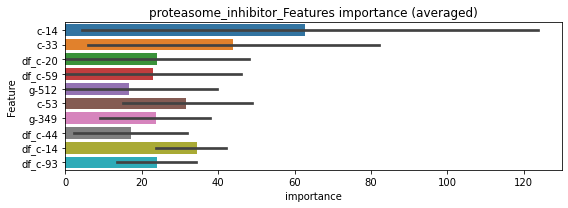

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106431	valid_1's binary_logloss: 0.0162843
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00105647	valid_1's binary_logloss: 0.00915221


len(train_index) : 3916
len(valid_index) : 3916
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118954	valid_1's binary_logloss: 0.0121243
[200]	training's binary_logloss: 0.00106482	valid_1's binary_logloss: 0.00188276
[300]	training's binary_logloss: 0.000234738	valid_1's binary_logloss: 0.00132169
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000177657	valid_1's binary_logloss: 0.00128845


proteasome_inhibitor logloss: 0.0052203305166723035


neg labels: 3289 → selected neg labels: 3281


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426683	valid_1's binary_logloss: 0.0894362
[200]	training's binary_logloss: 0.00731957	valid_1's binary_logloss: 0.0463473
[300]	training's binary_logloss: 0.00202939	valid_1's binary_logloss: 0.036552
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00156068	valid_1's binary_logloss: 0.0356701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426833	valid_1's binary_logloss: 0.0728896
[200]	training's binary_logloss: 0.00738315	valid_1's binary_logloss: 0.0289075
[300]	training's binary_logloss: 0.0021101	valid_1's binary_logloss: 0.0196055
[400]	training's binary_logloss: 0.000986774	valid_1's binary_logloss: 0.0165327
[500]	training's binary_logloss: 0.000624475	valid_1's binary_logloss: 0.0155744
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000593104	valid_1's binary_logloss: 0.0153891


1 / 3 AUC score:0.998
y_Threshold: 0.0079584, Threshold: 0.0121482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01093, conf_1:0.01336
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0121482
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0221482
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.0321482
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_4: 0.0421482
threshold: 0.0421482, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415347	valid_1's binary_logloss: 0.0837619
[200]	training's binary_logloss: 0.00684995	valid_1's binary_logloss: 0.0382914
[300]	training's binary_logloss: 0.00195247	valid_1's binary_logloss: 0.0263201
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00156182	valid_1's binary_logloss: 0.0246315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411429	valid_1's binary_logloss: 0.0654388
[200]	training's binary_logloss: 0.00666574	valid_1's binary_logloss: 0.0207029
[300]	training's binary_logloss: 0.00187626	valid_1's binary_logloss: 0.0117632
[400]	training's binary_logloss: 0.000909112	valid_1's binary_logloss: 0.00948442
[500]	training's binary_logloss: 0.000590718	valid_1's binary_logloss: 0.00882484
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000535414	valid_1's binary_logloss: 0.00860013


2 / 3 AUC score:1.000
y_Threshold: 0.0386588, Threshold: 0.0421482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0075339 Vs.target_rate: 0.00202
Num_p_label: 30.0, conf_0:0.03793, conf_1:0.04636
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.0421482
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.0521482
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.0621482
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_4: 0.0721482
threshold: 0.0721482, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406292	valid_1's binary_logloss: 0.0749876
[200]	training's binary_logloss: 0.00693185	valid_1's binary_logloss: 0.0281783
[300]	training's binary_logloss: 0.00189838	valid_1's binary_logloss: 0.0173043
[400]	training's binary_logloss: 0.000900266	valid_1's binary_logloss: 0.0142899
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000703635	valid_1's binary_logloss: 0.0134627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414041	valid_1's binary_logloss: 0.0650695
[200]	training's binary_logloss: 0.00693705	valid_1's binary_logloss: 0.0205819
[300]	training's binary_logloss: 0.00195281	valid_1's binary_logloss: 0.0102833
[400]	training's binary_logloss: 0.000931928	valid_1's binary_logloss: 0.00751962
[500]	training's binary_logloss: 0.000595941	valid_1's binary_logloss: 0.00651018
Early stopping, best iteration is:
[537

3 / 3 AUC score:1.000
y_Threshold: 0.0309260, Threshold: 0.0721482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0022602 Vs.target_rate: 0.00202
Num_p_label: 9.0, conf_0:0.06493, conf_1:0.07936
threshold: 0.0721482, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/7763, y_label_rate: 0.0841170


len(train_index) : 3881
len(valid_index) : 3882
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223734	valid_1's binary_logloss: 0.0477677
[200]	training's binary_logloss: 0.00358484	valid_1's binary_logloss: 0.0248047
[300]	training's binary_logloss: 0.000997669	valid_1's binary_logloss: 0.0205679
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000899422	valid_1's binary_logloss: 0.0203538


len(train_index) : 3882
len(valid_index) : 3881
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228283	valid_1's binary_logloss: 0.0466367
[200]	training's binary_logloss: 0.00387424	valid_1's binary_logloss: 0.0213663
[300]	training's binary_logloss: 0.0010644	valid_1's binary_logloss: 0.015358
[400]	training's binary_logloss: 0.000499555	valid_1's binary_logloss: 0.0136428
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000334949	valid_1's binary_logloss: 0.012881


protein_kinase_inhibitor logloss: 0.016617873147764122


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252778	valid_1's binary_logloss: 0.0357421
[200]	training's binary_logloss: 0.00307845	valid_1's binary_logloss: 0.00916891
[300]	training's binary_logloss: 0.000874927	valid_1's binary_logloss: 0.00513919
[400]	training's binary_logloss: 0.00045837	valid_1's binary_logloss: 0.00415978
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000358294	valid_1's binary_logloss: 0.00382247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249201	valid_1's binary_logloss: 0.0444772
[200]	training's binary_logloss: 0.00302378	valid_1's binary_logloss: 0.0123796
[300]	training's binary_logloss: 0.000863302	valid_1's binary_logloss: 0.00756065
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00079959	valid_1's binary_logloss: 0.00739348


1 / 3 AUC score:1.000
y_Threshold: 0.0026623, Threshold: 0.0053913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00485, conf_1:0.00593
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0053913
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_2: 0.0153913
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_3: 0.0253913
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.0353913
threshold: 0.0353913, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246538	valid_1's binary_logloss: 0.0341937
[200]	training's binary_logloss: 0.00292756	valid_1's binary_logloss: 0.0093285
[300]	training's binary_logloss: 0.000839591	valid_1's binary_logloss: 0.00594468
[400]	training's binary_logloss: 0.000448926	valid_1's binary_logloss: 0.00482993
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000366685	valid_1's binary_logloss: 0.0045727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02454	valid_1's binary_logloss: 0.0434553
[200]	training's binary_logloss: 0.00287648	valid_1's binary_logloss: 0.0115918
[300]	training's binary_logloss: 0.000823942	valid_1's binary_logloss: 0.00737936
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000515516	valid_1's binary_logloss: 0.00676602


2 / 3 AUC score:1.000
y_Threshold: 0.0395094, Threshold: 0.0353913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0102963 Vs.target_rate: 0.00101
Num_p_label: 41.0, conf_0:0.03185, conf_1:0.03893
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_1: 0.0353913
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_2: 0.0453913
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_3: 0.0553913
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_4: 0.0653913
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_5: 0.0753913
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_6: 0.0853913
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_7: 0.0953913
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_8: 0.1053913
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_9: 0.1153913
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_10: 0.1253913
threshold: 0.1353913, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245069	valid_1's binary_logloss: 0.0335765
[200]	training's binary_logloss: 0.00290511	valid_1's binary_logloss: 0.00852017
[300]	training's binary_logloss: 0.000835092	valid_1's binary_logloss: 0.00528806
[400]	training's binary_logloss: 0.000454059	valid_1's binary_logloss: 0.00442563
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000371648	valid_1's binary_logloss: 0.00415039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245865	valid_1's binary_logloss: 0.0414771
[200]	training's binary_logloss: 0.00291644	valid_1's binary_logloss: 0.00805771
[300]	training's binary_logloss: 0.000831383	valid_1's binary_logloss: 0.00351103
[400]	training's binary_logloss: 0.000441047	valid_1's binary_logloss: 0.0024485
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000365327	valid_1's binary_logloss: 0.002276

3 / 3 AUC score:1.000
y_Threshold: 0.0343563, Threshold: 0.1353913, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0022602 Vs.target_rate: 0.00101
Num_p_label: 9.0, conf_0:0.12185, conf_1:0.14893
threshold: 0.1353913, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7791, y_label_rate: 0.0853549


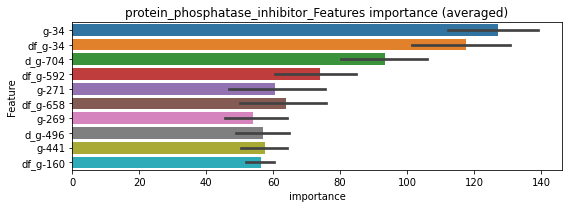

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135036	valid_1's binary_logloss: 0.0243845
[200]	training's binary_logloss: 0.00163296	valid_1's binary_logloss: 0.00867163
[300]	training's binary_logloss: 0.000449435	valid_1's binary_logloss: 0.00650755
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000335537	valid_1's binary_logloss: 0.00630749


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143027	valid_1's binary_logloss: 0.0227364
[200]	training's binary_logloss: 0.00176876	valid_1's binary_logloss: 0.00777749
[300]	training's binary_logloss: 0.000510471	valid_1's binary_logloss: 0.00574361
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00037369	valid_1's binary_logloss: 0.00557485


protein_phosphatase_inhibitor logloss: 0.005941216021099436


neg labels: 3289 → selected neg labels: 3271


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063731	valid_1's binary_logloss: 0.139705
[200]	training's binary_logloss: 0.0144974	valid_1's binary_logloss: 0.0870734
[300]	training's binary_logloss: 0.00407779	valid_1's binary_logloss: 0.0724328
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00203267	valid_1's binary_logloss: 0.0678894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592435	valid_1's binary_logloss: 0.14315
[200]	training's binary_logloss: 0.0128311	valid_1's binary_logloss: 0.0920814
[300]	training's binary_logloss: 0.00380813	valid_1's binary_logloss: 0.0799996
[400]	training's binary_logloss: 0.00174249	valid_1's binary_logloss: 0.0773047
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00182703	valid_1's binary_logloss: 0.0772101


1 / 3 AUC score:0.988
y_Threshold: 0.0146995, Threshold: 0.0711696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 163 → Positive_corect_labels: 638/3762
p_label_rate: 0.0200904 Vs.target_rate: 0.00433
Num_p_label: 80.0, conf_0:0.06405, conf_1:0.07829
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0711696
Num_p_label: 72.0, Expected: 17.2, Adj_threshold_2: 0.0811696
Num_p_label: 65.0, Expected: 17.2, Adj_threshold_3: 0.0911696
Num_p_label: 62.0, Expected: 17.2, Adj_threshold_4: 0.1011696
Num_p_label: 57.0, Expected: 17.2, Adj_threshold_5: 0.1111696
Num_p_label: 54.0, Expected: 17.2, Adj_threshold_6: 0.1211696
Num_p_label: 50.0, Expected: 17.2, Adj_threshold_7: 0.1311696
Num_p_label: 50.0, Expected: 17.2, Adj_threshold_8: 0.1411696
Num_p_label: 44.0, Expected: 17.2, Adj_threshold_9: 0.1511696
Num_p_label: 39.0, Expected: 17.2, Adj_threshold_10: 0.1611696
threshold: 0.1711696, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 638.0/3762, y_label_rate: 0.1695906

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576914	valid_1's binary_logloss: 0.121993
[200]	training's binary_logloss: 0.0122944	valid_1's binary_logloss: 0.0657243
[300]	training's binary_logloss: 0.00367148	valid_1's binary_logloss: 0.0531056
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00184102	valid_1's binary_logloss: 0.0485456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577155	valid_1's binary_logloss: 0.11863
[200]	training's binary_logloss: 0.0120375	valid_1's binary_logloss: 0.0686726
[300]	training's binary_logloss: 0.00352911	valid_1's binary_logloss: 0.0553389
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00191065	valid_1's binary_logloss: 0.0528399


2 / 3 AUC score:0.997
y_Threshold: 0.0382284, Threshold: 0.1711696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 619.0/3724
p_label_rate: 0.0263687 Vs.target_rate: 0.00433
Num_p_label: 105.0, conf_0:0.15405, conf_1:0.18829
Num_p_label: 105.0, Expected: 17.2, Adj_threshold_1: 0.1711696
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_2: 0.1811696
Num_p_label: 99.0, Expected: 17.2, Adj_threshold_3: 0.1911696
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_4: 0.2011696
Num_p_label: 96.0, Expected: 17.2, Adj_threshold_5: 0.2111696
Num_p_label: 95.0, Expected: 17.2, Adj_threshold_6: 0.2211696
Num_p_label: 95.0, Expected: 17.2, Adj_threshold_7: 0.2311696
Num_p_label: 91.0, Expected: 17.2, Adj_threshold_8: 0.2411696
Num_p_label: 90.0, Expected: 17.2, Adj_threshold_9: 0.2511696
Num_p_label: 90.0, Expected: 17.2, Adj_threshold_10: 0.2611696
threshold: 0.2711696, positive_p_label: 89.0/3982, p_label_rate: 0.0223506
positive_y_label: 619.0/3724, y_label_rate: 0.166

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053657	valid_1's binary_logloss: 0.134827
[200]	training's binary_logloss: 0.0103131	valid_1's binary_logloss: 0.0873565
[300]	training's binary_logloss: 0.00304342	valid_1's binary_logloss: 0.0793291
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00268984	valid_1's binary_logloss: 0.0787664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535647	valid_1's binary_logloss: 0.120269
[200]	training's binary_logloss: 0.0112113	valid_1's binary_logloss: 0.0759386
[300]	training's binary_logloss: 0.00327471	valid_1's binary_logloss: 0.0676076
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00284115	valid_1's binary_logloss: 0.0671449


3 / 3 AUC score:0.985
y_Threshold: 0.0356228, Threshold: 0.2711696, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 587.0/3660
p_label_rate: 0.0243596 Vs.target_rate: 0.00433
Num_p_label: 97.0, conf_0:0.24405, conf_1:0.29829
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_1: 0.2711696
Num_p_label: 91.0, Expected: 17.2, Adj_threshold_2: 0.2811696
Num_p_label: 89.0, Expected: 17.2, Adj_threshold_3: 0.2911696
Num_p_label: 89.0, Expected: 17.2, Adj_threshold_4: 0.3011696
Num_p_label: 88.0, Expected: 17.2, Adj_threshold_5: 0.3111696
Num_p_label: 88.0, Expected: 17.2, Adj_threshold_6: 0.3211696
Num_p_label: 86.0, Expected: 17.2, Adj_threshold_7: 0.3311696
Num_p_label: 85.0, Expected: 17.2, Adj_threshold_8: 0.3411696
Num_p_label: 85.0, Expected: 17.2, Adj_threshold_9: 0.3511696
Num_p_label: 85.0, Expected: 17.2, Adj_threshold_10: 0.3611696
threshold: 0.3711696, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 670.0/7642, y_label_rate: 0.087673

len(train_index) : 3821
len(valid_index) : 3821
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297644	valid_1's binary_logloss: 0.0774997
[200]	training's binary_logloss: 0.00579948	valid_1's binary_logloss: 0.0486572
[300]	training's binary_logloss: 0.00166478	valid_1's binary_logloss: 0.041944
[400]	training's binary_logloss: 0.00075627	valid_1's binary_logloss: 0.0400471
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00080666	valid_1's binary_logloss: 0.0399477


len(train_index) : 3821
len(valid_index) : 3821
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314121	valid_1's binary_logloss: 0.0724328
[200]	training's binary_logloss: 0.00642712	valid_1's binary_logloss: 0.0468897
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00208243	valid_1's binary_logloss: 0.0418144


protein_synthesis_inhibitor logloss: 0.0408810442683321


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250998	valid_1's binary_logloss: 0.0341212
[200]	training's binary_logloss: 0.00313551	valid_1's binary_logloss: 0.00583783
[300]	training's binary_logloss: 0.000869366	valid_1's binary_logloss: 0.0020074
[400]	training's binary_logloss: 0.000449384	valid_1's binary_logloss: 0.00115871
[500]	training's binary_logloss: 0.000353509	valid_1's binary_logloss: 0.000964186
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00034946	valid_1's binary_logloss: 0.000956925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025562	valid_1's binary_logloss: 0.0352368
[200]	training's binary_logloss: 0.00320018	valid_1's binary_logloss: 0.00565733
[300]	training's binary_logloss: 0.000888109	valid_1's binary_logloss: 0.00187575
[400]	training's binary_logloss: 0.000454309	valid_1's binary_logloss: 0.0011066
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0014530, Threshold: 0.0020021, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00180, conf_1:0.00220
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0020021
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_2: 0.0120021
threshold: 0.0120021, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251725	valid_1's binary_logloss: 0.0351542
[200]	training's binary_logloss: 0.00304149	valid_1's binary_logloss: 0.00550094
[300]	training's binary_logloss: 0.000857948	valid_1's binary_logloss: 0.00182228
[400]	training's binary_logloss: 0.000447446	valid_1's binary_logloss: 0.00104954
[500]	training's binary_logloss: 0.000353145	valid_1's binary_logloss: 0.00088717
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000346066	valid_1's binary_logloss: 0.000875045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254365	valid_1's binary_logloss: 0.0337182
[200]	training's binary_logloss: 0.00307733	valid_1's binary_logloss: 0.00507979
[300]	training's binary_logloss: 0.000876925	valid_1's binary_logloss: 0.00177116
[400]	training's binary_logloss: 0.000454454	valid_1's binary_logloss: 0.0010353
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1388554, Threshold: 0.0120021, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120021, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251725	valid_1's binary_logloss: 0.0351542
[200]	training's binary_logloss: 0.00304149	valid_1's binary_logloss: 0.00550094
[300]	training's binary_logloss: 0.000857948	valid_1's binary_logloss: 0.00182228
[400]	training's binary_logloss: 0.000447446	valid_1's binary_logloss: 0.00104954
[500]	training's binary_logloss: 0.000353145	valid_1's binary_logloss: 0.00088717
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000346066	valid_1's binary_logloss: 0.000875045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254365	valid_1's binary_logloss: 0.0337182
[200]	training's binary_logloss: 0.00307733	valid_1's binary_logloss: 0.00507979
[300]	training's binary_logloss: 0.000876925	valid_1's binary_logloss: 0.00177116
[400]	training's binary_logloss: 0.000454454	valid_1's binary_logloss: 0.0010353
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1388554, Threshold: 0.0120021, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120021, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


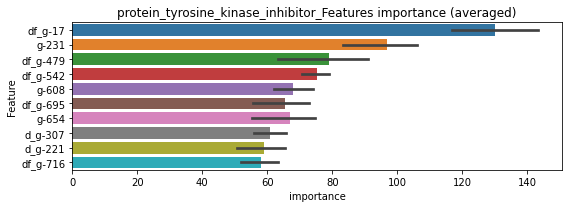

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144168	valid_1's binary_logloss: 0.0223282
[200]	training's binary_logloss: 0.0017132	valid_1's binary_logloss: 0.00827109
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000786424	valid_1's binary_logloss: 0.00734166


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141439	valid_1's binary_logloss: 0.0216545
[200]	training's binary_logloss: 0.00177082	valid_1's binary_logloss: 0.00611019
[300]	training's binary_logloss: 0.000478619	valid_1's binary_logloss: 0.00398732
[400]	training's binary_logloss: 0.000238707	valid_1's binary_logloss: 0.00357273
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000218418	valid_1's binary_logloss: 0.00355157


protein_tyrosine_kinase_inhibitor logloss: 0.005446615195008697


neg labels: 3289 → selected neg labels: 3281


radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455469	valid_1's binary_logloss: 0.113054
[200]	training's binary_logloss: 0.00851118	valid_1's binary_logloss: 0.0703457
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00286437	valid_1's binary_logloss: 0.0631975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507247	valid_1's binary_logloss: 0.0859361
[200]	training's binary_logloss: 0.00983271	valid_1's binary_logloss: 0.0340867
[300]	training's binary_logloss: 0.00274324	valid_1's binary_logloss: 0.0230659
[400]	training's binary_logloss: 0.00123128	valid_1's binary_logloss: 0.0193649
[500]	training's binary_logloss: 0.000760359	valid_1's binary_logloss: 0.0178391
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000623185	valid_1's binary_logloss: 0.0174183


1 / 3 AUC score:0.997
y_Threshold: 0.0134956, Threshold: 0.0187518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.01688, conf_1:0.02063
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0187518
Num_p_label: 45.0, Expected: 9.4, Adj_threshold_2: 0.0287518
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_3: 0.0387518
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_4: 0.0487518
threshold: 0.0487518, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474226	valid_1's binary_logloss: 0.0934307
[200]	training's binary_logloss: 0.0083991	valid_1's binary_logloss: 0.0492509
[300]	training's binary_logloss: 0.00239078	valid_1's binary_logloss: 0.0404078
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00119383	valid_1's binary_logloss: 0.0376736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477902	valid_1's binary_logloss: 0.0835846
[200]	training's binary_logloss: 0.0088953	valid_1's binary_logloss: 0.0335966
[300]	training's binary_logloss: 0.00248281	valid_1's binary_logloss: 0.0214942
[400]	training's binary_logloss: 0.0011469	valid_1's binary_logloss: 0.0190011
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000839432	valid_1's binary_logloss: 0.0181702


2 / 3 AUC score:0.999
y_Threshold: 0.0432237, Threshold: 0.0487518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0067805 Vs.target_rate: 0.00235
Num_p_label: 27.0, conf_0:0.04388, conf_1:0.05363
threshold: 0.0487518, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 638.0/3769, y_label_rate: 0.1692757
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459958	valid_1's binary_logloss: 0.0793674
[200]	training's binary_logloss: 0.00837493	valid_1's binary_logloss: 0.030469
[300]	training's binary_logloss: 0.0023685	valid_1's binary_logloss: 0.0189356
[400]	training's binary_logloss: 0.00109343	valid_1's binary_logloss: 0.0156258
[500]	training's binary_logloss: 0.00069534	valid_1's binary_logloss: 0.0144402
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000716433	valid_1's binary_logloss: 0.0143847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045408	valid_1's binary_logloss: 0.0841397
[200]	training's binary_logloss: 0.00822672	valid_1's binary_logloss: 0.0369557
[300]	training's binary_logloss: 0.00232009	valid_1's binary_logloss: 0.0263392
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00147626	valid_1's binary_logloss: 0.0242336


3 / 3 AUC score:1.000
y_Threshold: 0.0422495, Threshold: 0.0487518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 630.0/3753
p_label_rate: 0.0087896 Vs.target_rate: 0.00235
Num_p_label: 35.0, conf_0:0.04388, conf_1:0.05363
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_1: 0.0487518
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_2: 0.0587518
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_3: 0.0687518
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_4: 0.0787518
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_5: 0.0887518
threshold: 0.0887518, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 642.0/7735, y_label_rate: 0.0829994


len(train_index) : 3867
len(valid_index) : 3868
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247612	valid_1's binary_logloss: 0.0568768
[200]	training's binary_logloss: 0.00441411	valid_1's binary_logloss: 0.0315935
[300]	training's binary_logloss: 0.00121705	valid_1's binary_logloss: 0.0270298
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00115388	valid_1's binary_logloss: 0.0267925


len(train_index) : 3868
len(valid_index) : 3867
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026268	valid_1's binary_logloss: 0.0465653
[200]	training's binary_logloss: 0.00485063	valid_1's binary_logloss: 0.0208668
[300]	training's binary_logloss: 0.00132517	valid_1's binary_logloss: 0.0150983
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000703059	valid_1's binary_logloss: 0.0140362


radiopaque_medium logloss: 0.020415193404865365


neg labels: 3289 → selected neg labels: 3280


raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250713	valid_1's binary_logloss: 0.0638945
[200]	training's binary_logloss: 0.00327216	valid_1's binary_logloss: 0.0443114
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00174687	valid_1's binary_logloss: 0.0425263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272826	valid_1's binary_logloss: 0.0432885
[200]	training's binary_logloss: 0.00428933	valid_1's binary_logloss: 0.0231288
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00190188	valid_1's binary_logloss: 0.0209903


1 / 3 AUC score:0.999
y_Threshold: 0.0060162, Threshold: 0.0230135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00936
Num_p_label: 80.0, conf_0:0.02071, conf_1:0.02531
threshold: 0.0230135, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231966	valid_1's binary_logloss: 0.0576603
[200]	training's binary_logloss: 0.00279027	valid_1's binary_logloss: 0.0422061
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00193401	valid_1's binary_logloss: 0.0416939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256069	valid_1's binary_logloss: 0.0397884
[200]	training's binary_logloss: 0.00340222	valid_1's binary_logloss: 0.0201016
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00126808	valid_1's binary_logloss: 0.0168727


2 / 3 AUC score:1.000
y_Threshold: 0.0261410, Threshold: 0.0230135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0331492 Vs.target_rate: 0.00936
Num_p_label: 132.0, conf_0:0.02071, conf_1:0.02531
Num_p_label: 132.0, Expected: 37.3, Adj_threshold_1: 0.0230135
Num_p_label: 109.0, Expected: 37.3, Adj_threshold_2: 0.0330135
Num_p_label: 96.0, Expected: 37.3, Adj_threshold_3: 0.0430135
Num_p_label: 88.0, Expected: 37.3, Adj_threshold_4: 0.0530135
Num_p_label: 84.0, Expected: 37.3, Adj_threshold_5: 0.0630135
Num_p_label: 77.0, Expected: 37.3, Adj_threshold_6: 0.0730135
Num_p_label: 71.0, Expected: 37.3, Adj_threshold_7: 0.0830135
threshold: 0.0830135, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 644.0/3780, y_label_rate: 0.1703704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246126	valid_1's binary_logloss: 0.062463
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00639324	valid_1's binary_logloss: 0.0502031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023556	valid_1's binary_logloss: 0.0455887
[200]	training's binary_logloss: 0.00285225	valid_1's binary_logloss: 0.0303034
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00225736	valid_1's binary_logloss: 0.0301316


3 / 3 AUC score:0.999
y_Threshold: 0.0345366, Threshold: 0.0830135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 625.0/3742
p_label_rate: 0.0198393 Vs.target_rate: 0.00936
Num_p_label: 79.0, conf_0:0.07471, conf_1:0.09131
threshold: 0.0830135, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 704.0/7724, y_label_rate: 0.0911445


len(train_index) : 3862
len(valid_index) : 3862
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130161	valid_1's binary_logloss: 0.0333276
[200]	training's binary_logloss: 0.00156633	valid_1's binary_logloss: 0.0240404
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00146591	valid_1's binary_logloss: 0.0239471


len(train_index) : 3862
len(valid_index) : 3862
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139425	valid_1's binary_logloss: 0.0265658
[200]	training's binary_logloss: 0.00185115	valid_1's binary_logloss: 0.0159285
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000938596	valid_1's binary_logloss: 0.0151051


raf_inhibitor logloss: 0.019526076545762935


neg labels: 3289 → selected neg labels: 3287


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188752	valid_1's binary_logloss: 0.0245164
[200]	training's binary_logloss: 0.00187593	valid_1's binary_logloss: 0.00375638
[300]	training's binary_logloss: 0.000527426	valid_1's binary_logloss: 0.001313
[400]	training's binary_logloss: 0.000302225	valid_1's binary_logloss: 0.000860651
[500]	training's binary_logloss: 0.000262486	valid_1's binary_logloss: 0.000787871
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00026086	valid_1's binary_logloss: 0.000785398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191154	valid_1's binary_logloss: 0.0221334
[200]	training's binary_logloss: 0.00190688	valid_1's binary_logloss: 0.00257833
[300]	training's binary_logloss: 0.000532812	valid_1's binary_logloss: 0.000794943
[400]	training's binary_logloss: 0.000305815	valid_1's binary_logloss: 0.000482791
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0008534, Threshold: 0.0010811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00097, conf_1:0.00119
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0010811
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0110811
threshold: 0.0110811, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019124	valid_1's binary_logloss: 0.024399
[200]	training's binary_logloss: 0.00186982	valid_1's binary_logloss: 0.00379453
[300]	training's binary_logloss: 0.000524701	valid_1's binary_logloss: 0.00131103
[400]	training's binary_logloss: 0.000303027	valid_1's binary_logloss: 0.000843531
[500]	training's binary_logloss: 0.000260508	valid_1's binary_logloss: 0.000759019
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00025932	valid_1's binary_logloss: 0.000757391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019075	valid_1's binary_logloss: 0.0218253
[200]	training's binary_logloss: 0.00184968	valid_1's binary_logloss: 0.0024186
[300]	training's binary_logloss: 0.000517703	valid_1's binary_logloss: 0.000740127
[400]	training's binary_logloss: 0.00030068	valid_1's binary_logloss: 0.000446089
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1415763, Threshold: 0.0110811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.00997, conf_1:0.01219
threshold: 0.0110811, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019124	valid_1's binary_logloss: 0.024399
[200]	training's binary_logloss: 0.00186982	valid_1's binary_logloss: 0.00379453
[300]	training's binary_logloss: 0.000524701	valid_1's binary_logloss: 0.00131103
[400]	training's binary_logloss: 0.000303027	valid_1's binary_logloss: 0.000843531
[500]	training's binary_logloss: 0.000260508	valid_1's binary_logloss: 0.000759019
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00025932	valid_1's binary_logloss: 0.000757391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019075	valid_1's binary_logloss: 0.0218253
[200]	training's binary_logloss: 0.00184968	valid_1's binary_logloss: 0.0024186
[300]	training's binary_logloss: 0.000517703	valid_1's binary_logloss: 0.000740127
[400]	training's binary_logloss: 0.00030068	valid_1's binary_logloss: 0.000446089
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1415763, Threshold: 0.0110811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.00997, conf_1:0.01219
threshold: 0.0110811, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


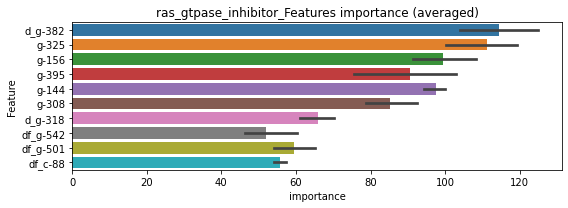

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00976504	valid_1's binary_logloss: 0.0159228
[200]	training's binary_logloss: 0.000935149	valid_1's binary_logloss: 0.00453503
[300]	training's binary_logloss: 0.000258299	valid_1's binary_logloss: 0.00340851
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000248416	valid_1's binary_logloss: 0.0033723


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100559	valid_1's binary_logloss: 0.0137032
[200]	training's binary_logloss: 0.000989853	valid_1's binary_logloss: 0.00324223
[300]	training's binary_logloss: 0.00027063	valid_1's binary_logloss: 0.00205491
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000171719	valid_1's binary_logloss: 0.00191077


ras_gtpase_inhibitor logloss: 0.002641532058244071


neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379067	valid_1's binary_logloss: 0.075828
[200]	training's binary_logloss: 0.00622627	valid_1's binary_logloss: 0.0338448
[300]	training's binary_logloss: 0.00185239	valid_1's binary_logloss: 0.0242269
[400]	training's binary_logloss: 0.000897495	valid_1's binary_logloss: 0.0219501
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000690821	valid_1's binary_logloss: 0.0210999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373709	valid_1's binary_logloss: 0.0857889
[200]	training's binary_logloss: 0.00609516	valid_1's binary_logloss: 0.0410333
[300]	training's binary_logloss: 0.00179944	valid_1's binary_logloss: 0.0311076
[400]	training's binary_logloss: 0.00087395	valid_1's binary_logloss: 0.0273361
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000781336	valid_1's binary_logloss: 0.0267633


1 / 3 AUC score:0.999
y_Threshold: 0.0063582, Threshold: 0.0161198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.01451, conf_1:0.01773
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0161198
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_2: 0.0261198
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_3: 0.0361198
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_4: 0.0461198
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_5: 0.0561198
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_6: 0.0661198
threshold: 0.0661198, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376026	valid_1's binary_logloss: 0.0673421
[200]	training's binary_logloss: 0.00608838	valid_1's binary_logloss: 0.0254455
[300]	training's binary_logloss: 0.00177631	valid_1's binary_logloss: 0.0169935
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00108937	valid_1's binary_logloss: 0.0156534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362484	valid_1's binary_logloss: 0.0651448
[200]	training's binary_logloss: 0.00573317	valid_1's binary_logloss: 0.0216414
[300]	training's binary_logloss: 0.00169797	valid_1's binary_logloss: 0.0127057
[400]	training's binary_logloss: 0.00083043	valid_1's binary_logloss: 0.00972125
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000608218	valid_1's binary_logloss: 0.00878855


2 / 3 AUC score:1.000
y_Threshold: 0.0458401, Threshold: 0.0661198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0165746 Vs.target_rate: 0.00281
Num_p_label: 66.0, conf_0:0.05951, conf_1:0.07273
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_1: 0.0661198
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_2: 0.0761198
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_3: 0.0861198
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_4: 0.0961198
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_5: 0.1061198
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_6: 0.1161198
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_7: 0.1261198
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_8: 0.1361198
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_9: 0.1461198
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_10: 0.1561198
threshold: 0.1661198, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376355	valid_1's binary_logloss: 0.0728788
[200]	training's binary_logloss: 0.00596737	valid_1's binary_logloss: 0.031995
[300]	training's binary_logloss: 0.00173333	valid_1's binary_logloss: 0.0241218
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000938613	valid_1's binary_logloss: 0.0215472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364761	valid_1's binary_logloss: 0.0649405
[200]	training's binary_logloss: 0.00589165	valid_1's binary_logloss: 0.0207264
[300]	training's binary_logloss: 0.00172515	valid_1's binary_logloss: 0.0118009
[400]	training's binary_logloss: 0.0008267	valid_1's binary_logloss: 0.00911222
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000571402	valid_1's binary_logloss: 0.00795639


3 / 3 AUC score:1.000
y_Threshold: 0.0578514, Threshold: 0.1661198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 647.0/3785
p_label_rate: 0.0072828 Vs.target_rate: 0.00281
Num_p_label: 29.0, conf_0:0.14951, conf_1:0.18273
threshold: 0.1661198, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 676.0/7767, y_label_rate: 0.0870349


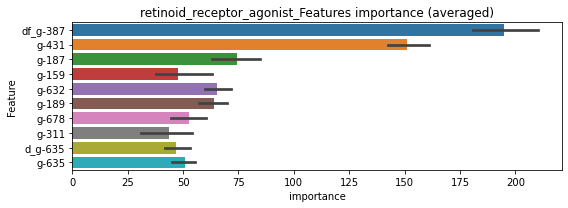

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203677	valid_1's binary_logloss: 0.0492144
[200]	training's binary_logloss: 0.00313134	valid_1's binary_logloss: 0.0271244
[300]	training's binary_logloss: 0.000897183	valid_1's binary_logloss: 0.0219147
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000645486	valid_1's binary_logloss: 0.0212016


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208282	valid_1's binary_logloss: 0.0443217
[200]	training's binary_logloss: 0.00325351	valid_1's binary_logloss: 0.0219259
[300]	training's binary_logloss: 0.000923925	valid_1's binary_logloss: 0.0178464
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000562355	valid_1's binary_logloss: 0.0172368


retinoid_receptor_agonist logloss: 0.019219449168197573


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154044	valid_1's binary_logloss: 0.0168405
[200]	training's binary_logloss: 0.00124369	valid_1's binary_logloss: 0.00172587
[300]	training's binary_logloss: 0.000332036	valid_1's binary_logloss: 0.000547302
[400]	training's binary_logloss: 0.000205503	valid_1's binary_logloss: 0.000384629
[500]	training's binary_logloss: 0.000180535	valid_1's binary_logloss: 0.000350617
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000179322	valid_1's binary_logloss: 0.000349113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154608	valid_1's binary_logloss: 0.016078
[200]	training's binary_logloss: 0.00123215	valid_1's binary_logloss: 0.00138797
[300]	training's binary_logloss: 0.000327762	valid_1's binary_logloss: 0.000398224
[400]	training's binary_logloss: 0.000203291	valid_1's binary_logloss: 0.000249309
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0004911, Threshold: 0.0008162, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00073, conf_1:0.00090
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008162
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108162
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208162
threshold: 0.0208162, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158765	valid_1's binary_logloss: 0.0182465
[200]	training's binary_logloss: 0.00126298	valid_1's binary_logloss: 0.0031215
[300]	training's binary_logloss: 0.000334482	valid_1's binary_logloss: 0.00171326
[400]	training's binary_logloss: 0.000206916	valid_1's binary_logloss: 0.00146766
[500]	training's binary_logloss: 0.000181675	valid_1's binary_logloss: 0.00142357
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000181675	valid_1's binary_logloss: 0.00142357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015907	valid_1's binary_logloss: 0.0162816
[200]	training's binary_logloss: 0.00126821	valid_1's binary_logloss: 0.00136125
[300]	training's binary_logloss: 0.000331946	valid_1's binary_logloss: 0.000374312
[400]	training's binary_logloss: 0.000205531	valid_1's binary_logloss: 0.000233182
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0472146, Threshold: 0.0208162, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.01873, conf_1:0.02290
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.0208162
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0308162
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0408162
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0508162
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0608162
threshold: 0.0608162, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158765	valid_1's binary_logloss: 0.0182465
[200]	training's binary_logloss: 0.00126298	valid_1's binary_logloss: 0.0031215
[300]	training's binary_logloss: 0.000334482	valid_1's binary_logloss: 0.00171326
[400]	training's binary_logloss: 0.000206916	valid_1's binary_logloss: 0.00146766
[500]	training's binary_logloss: 0.000181675	valid_1's binary_logloss: 0.00142357
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000181675	valid_1's binary_logloss: 0.00142357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015907	valid_1's binary_logloss: 0.0162816
[200]	training's binary_logloss: 0.00126821	valid_1's binary_logloss: 0.00136125
[300]	training's binary_logloss: 0.000331946	valid_1's binary_logloss: 0.000374312
[400]	training's binary_logloss: 0.000205531	valid_1's binary_logloss: 0.000233182
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0472146, Threshold: 0.0608162, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.05473, conf_1:0.06690
threshold: 0.0608162, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


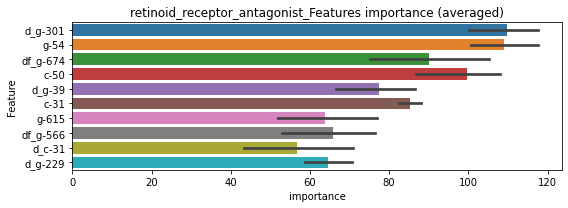

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00836492	valid_1's binary_logloss: 0.00941079
[200]	training's binary_logloss: 0.000658379	valid_1's binary_logloss: 0.00181563
[300]	training's binary_logloss: 0.000171722	valid_1's binary_logloss: 0.00135591
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000179063	valid_1's binary_logloss: 0.00135404


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838346	valid_1's binary_logloss: 0.0108321
[200]	training's binary_logloss: 0.000663406	valid_1's binary_logloss: 0.00264938
[300]	training's binary_logloss: 0.000171367	valid_1's binary_logloss: 0.00181106
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000108545	valid_1's binary_logloss: 0.00171818


retinoid_receptor_antagonist logloss: 0.0015360845849001295


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309077	valid_1's binary_logloss: 0.0478617
[200]	training's binary_logloss: 0.00462661	valid_1's binary_logloss: 0.01126
[300]	training's binary_logloss: 0.00124268	valid_1's binary_logloss: 0.00437727
[400]	training's binary_logloss: 0.000592212	valid_1's binary_logloss: 0.00251738
[500]	training's binary_logloss: 0.000410464	valid_1's binary_logloss: 0.0019513
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000389642	valid_1's binary_logloss: 0.00190165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312212	valid_1's binary_logloss: 0.0465205
[200]	training's binary_logloss: 0.0043653	valid_1's binary_logloss: 0.0121351
[300]	training's binary_logloss: 0.00123599	valid_1's binary_logloss: 0.00603344
[400]	training's binary_logloss: 0.000614208	valid_1's binary_logloss: 0.00412094
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0027006, Threshold: 0.0047231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147
Num_p_label: 80.0, conf_0:0.00425, conf_1:0.00520
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0047231
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_2: 0.0147231
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_3: 0.0247231
threshold: 0.0247231, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296997	valid_1's binary_logloss: 0.0458683
[200]	training's binary_logloss: 0.00403525	valid_1's binary_logloss: 0.00977906
[300]	training's binary_logloss: 0.0011497	valid_1's binary_logloss: 0.00420141
[400]	training's binary_logloss: 0.00058486	valid_1's binary_logloss: 0.00268302
[500]	training's binary_logloss: 0.000417141	valid_1's binary_logloss: 0.00217137
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000394004	valid_1's binary_logloss: 0.00210624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303952	valid_1's binary_logloss: 0.0424235
[200]	training's binary_logloss: 0.00417633	valid_1's binary_logloss: 0.00954914
[300]	training's binary_logloss: 0.00120179	valid_1's binary_logloss: 0.00406616
[400]	training's binary_logloss: 0.000600831	valid_1's binary_logloss: 0.00260875
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1326066, Threshold: 0.0247231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0065294 Vs.target_rate: 0.00147
Num_p_label: 26.0, conf_0:0.02225, conf_1:0.02720
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_1: 0.0247231
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_2: 0.0347231
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_3: 0.0447231
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_4: 0.0547231
threshold: 0.0547231, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296997	valid_1's binary_logloss: 0.0458683
[200]	training's binary_logloss: 0.00403525	valid_1's binary_logloss: 0.00977906
[300]	training's binary_logloss: 0.0011497	valid_1's binary_logloss: 0.00420141
[400]	training's binary_logloss: 0.00058486	valid_1's binary_logloss: 0.00268302
[500]	training's binary_logloss: 0.000417141	valid_1's binary_logloss: 0.00217137
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000394004	valid_1's binary_logloss: 0.00210624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303952	valid_1's binary_logloss: 0.0424235
[200]	training's binary_logloss: 0.00417633	valid_1's binary_logloss: 0.00954914
[300]	training's binary_logloss: 0.00120179	valid_1's binary_logloss: 0.00406616
[400]	training's binary_logloss: 0.000600831	valid_1's binary_logloss: 0.00260875
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1326066, Threshold: 0.0547231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00147
Num_p_label: 11.0, conf_0:0.04925, conf_1:0.06020
threshold: 0.0547231, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


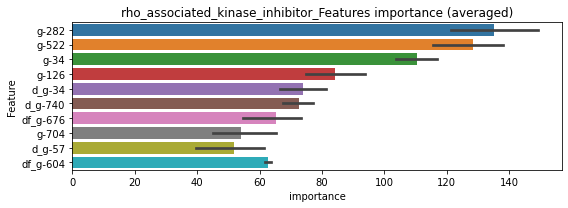

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162702	valid_1's binary_logloss: 0.0305016
[200]	training's binary_logloss: 0.00224869	valid_1's binary_logloss: 0.0108189
[300]	training's binary_logloss: 0.000632009	valid_1's binary_logloss: 0.00799953
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000402295	valid_1's binary_logloss: 0.00763885


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165158	valid_1's binary_logloss: 0.0276825
[200]	training's binary_logloss: 0.00227474	valid_1's binary_logloss: 0.00875786
[300]	training's binary_logloss: 0.000645646	valid_1's binary_logloss: 0.0062805
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00061812	valid_1's binary_logloss: 0.00619109


rho_associated_kinase_inhibitor logloss: 0.006915065353343769


neg labels: 3289 → selected neg labels: 3282


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276029	valid_1's binary_logloss: 0.0484153
[200]	training's binary_logloss: 0.00375087	valid_1's binary_logloss: 0.0181114
[300]	training's binary_logloss: 0.00106514	valid_1's binary_logloss: 0.0124765
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000726609	valid_1's binary_logloss: 0.0116015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285428	valid_1's binary_logloss: 0.0412021
[200]	training's binary_logloss: 0.00386391	valid_1's binary_logloss: 0.00999468
[300]	training's binary_logloss: 0.00110106	valid_1's binary_logloss: 0.00519283
[400]	training's binary_logloss: 0.000553539	valid_1's binary_logloss: 0.00400242
[500]	training's binary_logloss: 0.000398985	valid_1's binary_logloss: 0.00360744
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000398599	valid_1's binary_logloss: 0.00360645


1 / 3 AUC score:1.000
y_Threshold: 0.0030438, Threshold: 0.0047608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00428, conf_1:0.00524
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0047608
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_2: 0.0147608
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.0247608
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.0347608
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.0447608
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.0547608
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.0647608
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_8: 0.0747608
threshold: 0.0747608, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271688	valid_1's binary_logloss: 0.0446812
[200]	training's binary_logloss: 0.00370347	valid_1's binary_logloss: 0.0158431
[300]	training's binary_logloss: 0.000996591	valid_1's binary_logloss: 0.00950831
[400]	training's binary_logloss: 0.00049763	valid_1's binary_logloss: 0.00748402
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000423356	valid_1's binary_logloss: 0.00718462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276412	valid_1's binary_logloss: 0.0426022
[200]	training's binary_logloss: 0.00359196	valid_1's binary_logloss: 0.0108934
[300]	training's binary_logloss: 0.00101307	valid_1's binary_logloss: 0.00595026
[400]	training's binary_logloss: 0.00051109	valid_1's binary_logloss: 0.00446066
[500]	training's binary_logloss: 0.000382845	valid_1's binary_logloss: 0.00404293
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0536267, Threshold: 0.0747608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.06728, conf_1:0.08224
threshold: 0.0747608, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271688	valid_1's binary_logloss: 0.0446812
[200]	training's binary_logloss: 0.00370347	valid_1's binary_logloss: 0.0158431
[300]	training's binary_logloss: 0.000996591	valid_1's binary_logloss: 0.00950831
[400]	training's binary_logloss: 0.00049763	valid_1's binary_logloss: 0.00748402
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000423356	valid_1's binary_logloss: 0.00718462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276412	valid_1's binary_logloss: 0.0426022
[200]	training's binary_logloss: 0.00359196	valid_1's binary_logloss: 0.0108934
[300]	training's binary_logloss: 0.00101307	valid_1's binary_logloss: 0.00595026
[400]	training's binary_logloss: 0.00051109	valid_1's binary_logloss: 0.00446066
[500]	training's binary_logloss: 0.000382845	valid_1's binary_logloss: 0.00404293
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0536267, Threshold: 0.0747608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.06728, conf_1:0.08224
threshold: 0.0747608, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7788, y_label_rate: 0.0861582


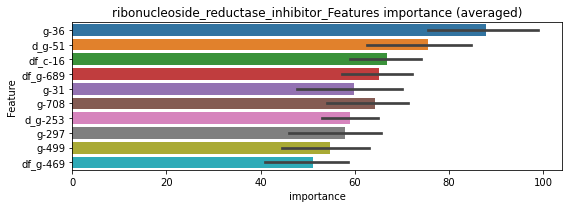

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014553	valid_1's binary_logloss: 0.0294864
[200]	training's binary_logloss: 0.00185221	valid_1's binary_logloss: 0.0124627
[300]	training's binary_logloss: 0.000507733	valid_1's binary_logloss: 0.00890443
[400]	training's binary_logloss: 0.000261213	valid_1's binary_logloss: 0.00795135
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000249027	valid_1's binary_logloss: 0.00788882


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146722	valid_1's binary_logloss: 0.0213803
[200]	training's binary_logloss: 0.00185711	valid_1's binary_logloss: 0.00557506
[300]	training's binary_logloss: 0.000518147	valid_1's binary_logloss: 0.00324759
[400]	training's binary_logloss: 0.000263174	valid_1's binary_logloss: 0.00278724
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0002186	valid_1's binary_logloss: 0.0027097


ribonucleoside_reductase_inhibitor logloss: 0.005299261615223222


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271431	valid_1's binary_logloss: 0.0376773
[200]	training's binary_logloss: 0.00340906	valid_1's binary_logloss: 0.00734005
[300]	training's binary_logloss: 0.000975822	valid_1's binary_logloss: 0.00323489
[400]	training's binary_logloss: 0.000505658	valid_1's binary_logloss: 0.00224768
[500]	training's binary_logloss: 0.000379982	valid_1's binary_logloss: 0.00189697
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000374711	valid_1's binary_logloss: 0.00188059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284179	valid_1's binary_logloss: 0.0394704
[200]	training's binary_logloss: 0.00363205	valid_1's binary_logloss: 0.0073639
[300]	training's binary_logloss: 0.00101845	valid_1's binary_logloss: 0.00291346
[400]	training's binary_logloss: 0.000518065	valid_1's binary_logloss: 0.00184745
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0022033, Threshold: 0.0093672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00843, conf_1:0.01030
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0093672
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_2: 0.0193672
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_3: 0.0293672
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_4: 0.0393672
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_5: 0.0493672
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_6: 0.0593672
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_7: 0.0693672
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_8: 0.0793672
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_9: 0.0893672
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_10: 0.0993672
threshold: 0.1093672, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267352	valid_1's binary_logloss: 0.035088
[200]	training's binary_logloss: 0.00332024	valid_1's binary_logloss: 0.00594776
[300]	training's binary_logloss: 0.000943117	valid_1's binary_logloss: 0.00208704
[400]	training's binary_logloss: 0.000485867	valid_1's binary_logloss: 0.00121185
[500]	training's binary_logloss: 0.000371736	valid_1's binary_logloss: 0.000993204
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000359717	valid_1's binary_logloss: 0.000970401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268874	valid_1's binary_logloss: 0.0366065
[200]	training's binary_logloss: 0.00336154	valid_1's binary_logloss: 0.00610402
[300]	training's binary_logloss: 0.000939413	valid_1's binary_logloss: 0.00218287
[400]	training's binary_logloss: 0.00048808	valid_1's binary_logloss: 0.00130188
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1572010, Threshold: 0.1093672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0160723 Vs.target_rate: 0.00105
Num_p_label: 64.0, conf_0:0.09843, conf_1:0.12030
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_1: 0.1093672
Num_p_label: 61.0, Expected: 4.2, Adj_threshold_2: 0.1193672
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_3: 0.1293672
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_4: 0.1393672
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_5: 0.1493672
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_6: 0.1593672
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_7: 0.1693672
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_8: 0.1793672
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_9: 0.1893672
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_10: 0.1993672
threshold: 0.2093672, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267352	valid_1's binary_logloss: 0.035088
[200]	training's binary_logloss: 0.00332024	valid_1's binary_logloss: 0.00594776
[300]	training's binary_logloss: 0.000943117	valid_1's binary_logloss: 0.00208704
[400]	training's binary_logloss: 0.000485867	valid_1's binary_logloss: 0.00121185
[500]	training's binary_logloss: 0.000371736	valid_1's binary_logloss: 0.000993204
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000359717	valid_1's binary_logloss: 0.000970401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268874	valid_1's binary_logloss: 0.0366065
[200]	training's binary_logloss: 0.00336154	valid_1's binary_logloss: 0.00610402
[300]	training's binary_logloss: 0.000939413	valid_1's binary_logloss: 0.00218287
[400]	training's binary_logloss: 0.00048808	valid_1's binary_logloss: 0.00130188
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1572010, Threshold: 0.2093672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0130588 Vs.target_rate: 0.00105
Num_p_label: 52.0, conf_0:0.18843, conf_1:0.23030
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_1: 0.2093672
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_2: 0.2193672
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_3: 0.2293672
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_4: 0.2393672
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_5: 0.2493672
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_6: 0.2593672
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_7: 0.2693672
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_8: 0.2793672
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_9: 0.2893672
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_10: 0.2993672
threshold: 0.3093672, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 699.0/7790, y_label_rate: 0.0897304


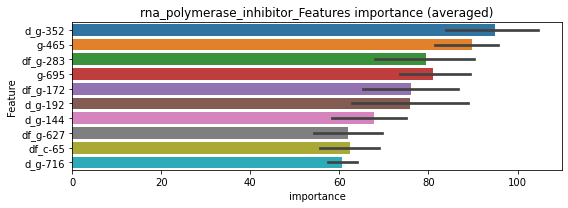

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169594	valid_1's binary_logloss: 0.0287246
[200]	training's binary_logloss: 0.00226138	valid_1's binary_logloss: 0.0104448
[300]	training's binary_logloss: 0.000620585	valid_1's binary_logloss: 0.0084048
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000585865	valid_1's binary_logloss: 0.00834656


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176654	valid_1's binary_logloss: 0.0288577
[200]	training's binary_logloss: 0.00249326	valid_1's binary_logloss: 0.00960121
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000778299	valid_1's binary_logloss: 0.00648431


rna_polymerase_inhibitor logloss: 0.007415432614562016


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993234	valid_1's binary_logloss: 0.277421
[200]	training's binary_logloss: 0.0338302	valid_1's binary_logloss: 0.252634
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0240027	valid_1's binary_logloss: 0.24983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106523	valid_1's binary_logloss: 0.278018
[200]	training's binary_logloss: 0.0356101	valid_1's binary_logloss: 0.251022
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0235299	valid_1's binary_logloss: 0.248229


1 / 3 AUC score:0.890
y_Threshold: 0.0734217, Threshold: 0.1171473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 441 → Positive_corect_labels: 494/3457
p_label_rate: 0.0200904 Vs.target_rate: 0.00991
Num_p_label: 80.0, conf_0:0.10543, conf_1:0.12886
threshold: 0.1171473, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 494.0/3457, y_label_rate: 0.1428985
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741339	valid_1's binary_logloss: 0.183839
[200]	training's binary_logloss: 0.0194186	valid_1's binary_logloss: 0.137924
[300]	training's binary_logloss: 0.0061765	valid_1's binary_logloss: 0.126266
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00641977	valid_1's binary_logloss: 0.126231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707197	valid_1's binary_logloss: 0.191434
[200]	training's binary_logloss: 0.0188058	valid_1's binary_logloss: 0.152939
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0121867	valid_1's binary_logloss: 0.147821


2 / 3 AUC score:0.966
y_Threshold: 0.0713264, Threshold: 0.1171473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 436.0/3341
p_label_rate: 0.0133099 Vs.target_rate: 0.00991
Num_p_label: 53.0, conf_0:0.10543, conf_1:0.12886
threshold: 0.1171473, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 436.0/3341, y_label_rate: 0.1304999
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059583	valid_1's binary_logloss: 0.164119
[200]	training's binary_logloss: 0.0147887	valid_1's binary_logloss: 0.133178
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00831602	valid_1's binary_logloss: 0.128738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577593	valid_1's binary_logloss: 0.151172
[200]	training's binary_logloss: 0.0137597	valid_1's binary_logloss: 0.106485
[300]	training's binary_logloss: 0.00433522	valid_1's binary_logloss: 0.0921504
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00268508	valid_1's binary_logloss: 0.0895858


3 / 3 AUC score:0.981
y_Threshold: 0.0599615, Threshold: 0.1171473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 395.0/3259
p_label_rate: 0.0105475 Vs.target_rate: 0.00991
Num_p_label: 42.0, conf_0:0.10543, conf_1:0.12886
threshold: 0.1171473, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 437.0/7241, y_label_rate: 0.0603508


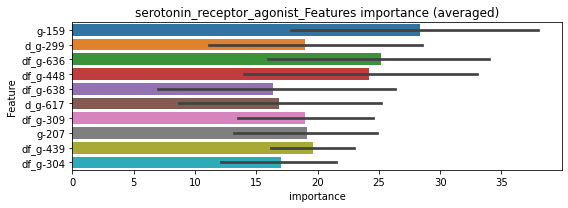

len(train_index) : 3620
len(valid_index) : 3621
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309499	valid_1's binary_logloss: 0.095752
[200]	training's binary_logloss: 0.00741314	valid_1's binary_logloss: 0.0823924
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00641543	valid_1's binary_logloss: 0.081549


len(train_index) : 3621
len(valid_index) : 3620
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029585	valid_1's binary_logloss: 0.0899112
[200]	training's binary_logloss: 0.00691128	valid_1's binary_logloss: 0.0754272
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0068136	valid_1's binary_logloss: 0.0753945


serotonin_receptor_agonist logloss: 0.07847219192562986


neg labels: 3289 → selected neg labels: 3220


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123291	valid_1's binary_logloss: 0.356265
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0792205	valid_1's binary_logloss: 0.34953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130307	valid_1's binary_logloss: 0.349965
[200]	training's binary_logloss: 0.0473974	valid_1's binary_logloss: 0.337094
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0507033	valid_1's binary_logloss: 0.336717


1 / 3 AUC score:0.802
y_Threshold: 0.1375220, Threshold: 0.2046076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 659 → Positive_corect_labels: 379/3205
p_label_rate: 0.0200904 Vs.target_rate: 0.01696
Num_p_label: 80.0, conf_0:0.18415, conf_1:0.22507
threshold: 0.2046076, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 379.0/3205, y_label_rate: 0.1182527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627509	valid_1's binary_logloss: 0.210351
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0197883	valid_1's binary_logloss: 0.191804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613641	valid_1's binary_logloss: 0.203963
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.022381	valid_1's binary_logloss: 0.184257


2 / 3 AUC score:0.942
y_Threshold: 0.1056054, Threshold: 0.2046076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 283.0/3013
p_label_rate: 0.0193370 Vs.target_rate: 0.01696
Num_p_label: 77.0, conf_0:0.18415, conf_1:0.22507
threshold: 0.2046076, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 283.0/3013, y_label_rate: 0.0939263
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390682	valid_1's binary_logloss: 0.151459
[200]	training's binary_logloss: 0.00871849	valid_1's binary_logloss: 0.134002
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00825063	valid_1's binary_logloss: 0.13385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401492	valid_1's binary_logloss: 0.156164
[200]	training's binary_logloss: 0.00933397	valid_1's binary_logloss: 0.140145
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0106049	valid_1's binary_logloss: 0.139687


3 / 3 AUC score:0.975
y_Threshold: 0.0760947, Threshold: 0.2046076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 100 → Positive_corect_labels: 233.0/2913
p_label_rate: 0.0148167 Vs.target_rate: 0.01696
Num_p_label: 59.0, conf_0:0.18415, conf_1:0.22507
threshold: 0.2046076, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 292.0/6895, y_label_rate: 0.0423495


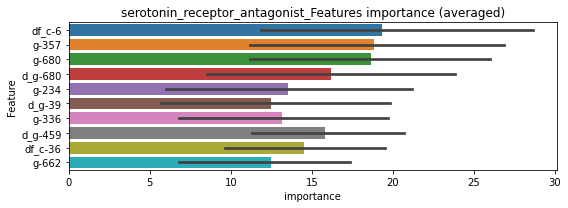

len(train_index) : 3447
len(valid_index) : 3448
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190668	valid_1's binary_logloss: 0.0871901
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00897169	valid_1's binary_logloss: 0.0823715


len(train_index) : 3448
len(valid_index) : 3447
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179862	valid_1's binary_logloss: 0.079291
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00699662	valid_1's binary_logloss: 0.0711882


serotonin_receptor_antagonist logloss: 0.07678067350353918


neg labels: 3289 → selected neg labels: 3281


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387712	valid_1's binary_logloss: 0.0837913
[200]	training's binary_logloss: 0.00648386	valid_1's binary_logloss: 0.0445207
[300]	training's binary_logloss: 0.00180062	valid_1's binary_logloss: 0.0354211
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0013693	valid_1's binary_logloss: 0.034931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389293	valid_1's binary_logloss: 0.0755216
[200]	training's binary_logloss: 0.00643711	valid_1's binary_logloss: 0.0401644
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0022073	valid_1's binary_logloss: 0.0353056


1 / 3 AUC score:0.997
y_Threshold: 0.0089147, Threshold: 0.0117202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00185
Num_p_label: 80.0, conf_0:0.01055, conf_1:0.01289
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0117202
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_2: 0.0217202
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_3: 0.0317202
threshold: 0.0317202, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400372	valid_1's binary_logloss: 0.0651091
[200]	training's binary_logloss: 0.00660363	valid_1's binary_logloss: 0.0215961
[300]	training's binary_logloss: 0.0018532	valid_1's binary_logloss: 0.0129182
[400]	training's binary_logloss: 0.00086389	valid_1's binary_logloss: 0.0103408
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000631777	valid_1's binary_logloss: 0.00944631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373174	valid_1's binary_logloss: 0.0820441
[200]	training's binary_logloss: 0.00586912	valid_1's binary_logloss: 0.0407959
[300]	training's binary_logloss: 0.00168085	valid_1's binary_logloss: 0.0345133
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00124592	valid_1's binary_logloss: 0.0339636


2 / 3 AUC score:1.000
y_Threshold: 0.0224952, Threshold: 0.0317202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0025113 Vs.target_rate: 0.00185
Num_p_label: 10.0, conf_0:0.02855, conf_1:0.03489
threshold: 0.0317202, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390425	valid_1's binary_logloss: 0.0679512
[200]	training's binary_logloss: 0.00629885	valid_1's binary_logloss: 0.0238667
[300]	training's binary_logloss: 0.00176936	valid_1's binary_logloss: 0.0141023
[400]	training's binary_logloss: 0.000843423	valid_1's binary_logloss: 0.0114816
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000574349	valid_1's binary_logloss: 0.0100493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378354	valid_1's binary_logloss: 0.0691614
[200]	training's binary_logloss: 0.00614077	valid_1's binary_logloss: 0.0277288
[300]	training's binary_logloss: 0.00173664	valid_1's binary_logloss: 0.0197004
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00110865	valid_1's binary_logloss: 0.01881


3 / 3 AUC score:1.000
y_Threshold: 0.0204508, Threshold: 0.0317202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0030136 Vs.target_rate: 0.00185
Num_p_label: 12.0, conf_0:0.02855, conf_1:0.03489
threshold: 0.0317202, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 658.0/7767, y_label_rate: 0.0847174


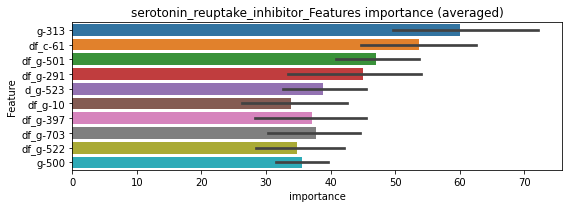

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213983	valid_1's binary_logloss: 0.0485113
[200]	training's binary_logloss: 0.00352459	valid_1's binary_logloss: 0.0275892
[300]	training's binary_logloss: 0.000955432	valid_1's binary_logloss: 0.0238988
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000721901	valid_1's binary_logloss: 0.0230673


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213899	valid_1's binary_logloss: 0.0430127
[200]	training's binary_logloss: 0.00342452	valid_1's binary_logloss: 0.0168948
[300]	training's binary_logloss: 0.000964918	valid_1's binary_logloss: 0.0115531
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000519228	valid_1's binary_logloss: 0.010737


serotonin_reuptake_inhibitor logloss: 0.01690294527109455


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382249	valid_1's binary_logloss: 0.0615582
[200]	training's binary_logloss: 0.0060364	valid_1's binary_logloss: 0.0185648
[300]	training's binary_logloss: 0.00162913	valid_1's binary_logloss: 0.00954756
[400]	training's binary_logloss: 0.000777505	valid_1's binary_logloss: 0.0067843
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000568942	valid_1's binary_logloss: 0.00608718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372269	valid_1's binary_logloss: 0.0580295
[200]	training's binary_logloss: 0.00587623	valid_1's binary_logloss: 0.0187312
[300]	training's binary_logloss: 0.0016124	valid_1's binary_logloss: 0.0112754
[400]	training's binary_logloss: 0.000772039	valid_1's binary_logloss: 0.00889529
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000772039	valid_1's binary_logloss: 0.00889529


1 / 3 AUC score:1.000
y_Threshold: 0.0049180, Threshold: 0.0073062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00658, conf_1:0.00804
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0073062
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0173062
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_3: 0.0273062
threshold: 0.0273062, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372145	valid_1's binary_logloss: 0.0598481
[200]	training's binary_logloss: 0.00578414	valid_1's binary_logloss: 0.0183131
[300]	training's binary_logloss: 0.00158884	valid_1's binary_logloss: 0.00973322
[400]	training's binary_logloss: 0.00076878	valid_1's binary_logloss: 0.00736056
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000630835	valid_1's binary_logloss: 0.00688899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379988	valid_1's binary_logloss: 0.0611469
[200]	training's binary_logloss: 0.0057746	valid_1's binary_logloss: 0.0211029
[300]	training's binary_logloss: 0.0015908	valid_1's binary_logloss: 0.013533
[400]	training's binary_logloss: 0.000763169	valid_1's binary_logloss: 0.0113272
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000593417	valid_1's binary_logloss: 0.0106051


2 / 3 AUC score:1.000
y_Threshold: 0.0194733, Threshold: 0.0273062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0057760 Vs.target_rate: 0.00151
Num_p_label: 23.0, conf_0:0.02458, conf_1:0.03004
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.0273062
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0373062
threshold: 0.0373062, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372145	valid_1's binary_logloss: 0.0598481
[200]	training's binary_logloss: 0.00578414	valid_1's binary_logloss: 0.0183131
[300]	training's binary_logloss: 0.00158884	valid_1's binary_logloss: 0.00973322
[400]	training's binary_logloss: 0.00076878	valid_1's binary_logloss: 0.00736056
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000630835	valid_1's binary_logloss: 0.00688899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379988	valid_1's binary_logloss: 0.0611469
[200]	training's binary_logloss: 0.0057746	valid_1's binary_logloss: 0.0211029
[300]	training's binary_logloss: 0.0015908	valid_1's binary_logloss: 0.013533
[400]	training's binary_logloss: 0.000763169	valid_1's binary_logloss: 0.0113272
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000593417	valid_1's binary_logloss: 0.0106051


3 / 3 AUC score:1.000
y_Threshold: 0.0194733, Threshold: 0.0373062, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151
Num_p_label: 10.0, conf_0:0.03358, conf_1:0.04104
threshold: 0.0373062, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


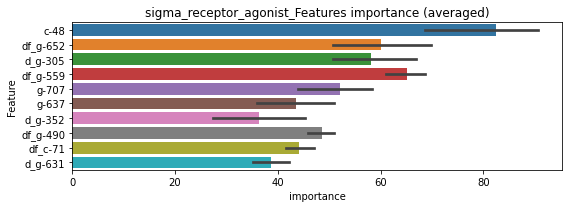

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220546	valid_1's binary_logloss: 0.0394781
[200]	training's binary_logloss: 0.00348007	valid_1's binary_logloss: 0.0159597
[300]	training's binary_logloss: 0.000954401	valid_1's binary_logloss: 0.0123669
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00061523	valid_1's binary_logloss: 0.0119759


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216664	valid_1's binary_logloss: 0.0452571
[200]	training's binary_logloss: 0.00355113	valid_1's binary_logloss: 0.0278394
[300]	training's binary_logloss: 0.000914932	valid_1's binary_logloss: 0.0251528
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000960622	valid_1's binary_logloss: 0.0251315


sigma_receptor_agonist logloss: 0.018552848440227643


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355261	valid_1's binary_logloss: 0.0588687
[200]	training's binary_logloss: 0.00549838	valid_1's binary_logloss: 0.0184672
[300]	training's binary_logloss: 0.00155169	valid_1's binary_logloss: 0.00977584
[400]	training's binary_logloss: 0.000748365	valid_1's binary_logloss: 0.00674374
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000539112	valid_1's binary_logloss: 0.00614092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365787	valid_1's binary_logloss: 0.0688956
[200]	training's binary_logloss: 0.00569447	valid_1's binary_logloss: 0.0298141
[300]	training's binary_logloss: 0.0015782	valid_1's binary_logloss: 0.0209976
[400]	training's binary_logloss: 0.00076325	valid_1's binary_logloss: 0.0180118
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00060106	valid_1's binary_logloss: 0.0175343


1 / 3 AUC score:1.000
y_Threshold: 0.0039061, Threshold: 0.0055945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00504, conf_1:0.00615
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0055945
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0155945
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0255945
threshold: 0.0255945, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348228	valid_1's binary_logloss: 0.0569942
[200]	training's binary_logloss: 0.00526196	valid_1's binary_logloss: 0.0170194
[300]	training's binary_logloss: 0.00150725	valid_1's binary_logloss: 0.00987646
[400]	training's binary_logloss: 0.00074677	valid_1's binary_logloss: 0.00738625
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00055142	valid_1's binary_logloss: 0.00672289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035031	valid_1's binary_logloss: 0.0630965
[200]	training's binary_logloss: 0.00539121	valid_1's binary_logloss: 0.0270773
[300]	training's binary_logloss: 0.001519	valid_1's binary_logloss: 0.0184778
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00116832	valid_1's binary_logloss: 0.0175883


2 / 3 AUC score:1.000
y_Threshold: 0.0267768, Threshold: 0.0255945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0055249 Vs.target_rate: 0.00151
Num_p_label: 22.0, conf_0:0.02304, conf_1:0.02815
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.0255945
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.0355945
threshold: 0.0355945, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359907	valid_1's binary_logloss: 0.0549574
[200]	training's binary_logloss: 0.0054649	valid_1's binary_logloss: 0.0129268
[300]	training's binary_logloss: 0.00154308	valid_1's binary_logloss: 0.0052347
[400]	training's binary_logloss: 0.000753457	valid_1's binary_logloss: 0.00327226
[500]	training's binary_logloss: 0.000506105	valid_1's binary_logloss: 0.00258562
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000445211	valid_1's binary_logloss: 0.00239471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347402	valid_1's binary_logloss: 0.0586809
[200]	training's binary_logloss: 0.00510657	valid_1's binary_logloss: 0.0155175
[300]	training's binary_logloss: 0.00146603	valid_1's binary_logloss: 0.00735815
[400]	training's binary_logloss: 0.000726364	valid_1's binary_logloss: 0.00496293
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0863112, Threshold: 0.0355945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.03204, conf_1:0.03915
threshold: 0.0355945, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 667.0/7787, y_label_rate: 0.0856556


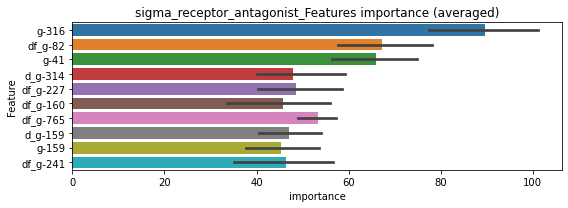

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019962	valid_1's binary_logloss: 0.0418976
[200]	training's binary_logloss: 0.00299587	valid_1's binary_logloss: 0.0209031
[300]	training's binary_logloss: 0.000816688	valid_1's binary_logloss: 0.017804
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000553386	valid_1's binary_logloss: 0.0171756


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199997	valid_1's binary_logloss: 0.0354261
[200]	training's binary_logloss: 0.00308056	valid_1's binary_logloss: 0.0130061
[300]	training's binary_logloss: 0.000858576	valid_1's binary_logloss: 0.00863455
[400]	training's binary_logloss: 0.000414444	valid_1's binary_logloss: 0.00764906
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000395259	valid_1's binary_logloss: 0.00760229


sigma_receptor_antagonist logloss: 0.012389559867897169


neg labels: 3289 → selected neg labels: 3284


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300798	valid_1's binary_logloss: 0.0473044
[200]	training's binary_logloss: 0.00413629	valid_1's binary_logloss: 0.0124738
[300]	training's binary_logloss: 0.00112026	valid_1's binary_logloss: 0.00600983
[400]	training's binary_logloss: 0.000546465	valid_1's binary_logloss: 0.00433927
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000412705	valid_1's binary_logloss: 0.00394244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297684	valid_1's binary_logloss: 0.0450633
[200]	training's binary_logloss: 0.00397543	valid_1's binary_logloss: 0.0109374
[300]	training's binary_logloss: 0.00110105	valid_1's binary_logloss: 0.00523394
[400]	training's binary_logloss: 0.000558354	valid_1's binary_logloss: 0.00363203
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000552721	valid_1's binary_logloss: 0.00361696


1 / 3 AUC score:1.000
y_Threshold: 0.0024661, Threshold: 0.0040789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00367, conf_1:0.00449
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0040789
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.0140789
threshold: 0.0140789, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291986	valid_1's binary_logloss: 0.0458847
[200]	training's binary_logloss: 0.00387851	valid_1's binary_logloss: 0.0121368
[300]	training's binary_logloss: 0.00108558	valid_1's binary_logloss: 0.00630056
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000611704	valid_1's binary_logloss: 0.00487547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289058	valid_1's binary_logloss: 0.0459057
[200]	training's binary_logloss: 0.00383655	valid_1's binary_logloss: 0.0110465
[300]	training's binary_logloss: 0.00107251	valid_1's binary_logloss: 0.00520508
[400]	training's binary_logloss: 0.000544212	valid_1's binary_logloss: 0.00348917
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000422595	valid_1's binary_logloss: 0.00315344


2 / 3 AUC score:1.000
y_Threshold: 0.0169592, Threshold: 0.0140789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0067805 Vs.target_rate: 0.00105
Num_p_label: 27.0, conf_0:0.01267, conf_1:0.01549
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_1: 0.0140789
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0240789
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0340789
threshold: 0.0340789, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291986	valid_1's binary_logloss: 0.0458847
[200]	training's binary_logloss: 0.00387851	valid_1's binary_logloss: 0.0121368
[300]	training's binary_logloss: 0.00108558	valid_1's binary_logloss: 0.00630056
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000611704	valid_1's binary_logloss: 0.00487547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289058	valid_1's binary_logloss: 0.0459057
[200]	training's binary_logloss: 0.00383655	valid_1's binary_logloss: 0.0110465
[300]	training's binary_logloss: 0.00107251	valid_1's binary_logloss: 0.00520508
[400]	training's binary_logloss: 0.000544212	valid_1's binary_logloss: 0.00348917
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000422595	valid_1's binary_logloss: 0.00315344


3 / 3 AUC score:1.000
y_Threshold: 0.0169592, Threshold: 0.0340789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.03067, conf_1:0.03749
threshold: 0.0340789, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


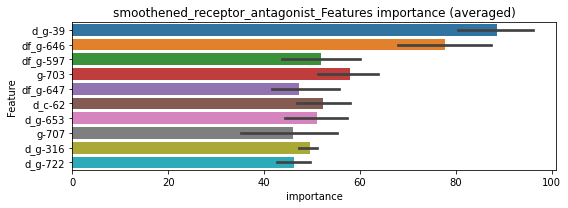

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157836	valid_1's binary_logloss: 0.0311438
[200]	training's binary_logloss: 0.00198233	valid_1's binary_logloss: 0.011504
[300]	training's binary_logloss: 0.000550509	valid_1's binary_logloss: 0.00893704
[400]	training's binary_logloss: 0.00027162	valid_1's binary_logloss: 0.00828741
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000268796	valid_1's binary_logloss: 0.00828703


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155036	valid_1's binary_logloss: 0.0247937
[200]	training's binary_logloss: 0.00208272	valid_1's binary_logloss: 0.00621745
[300]	training's binary_logloss: 0.000578725	valid_1's binary_logloss: 0.00300674
[400]	training's binary_logloss: 0.000289653	valid_1's binary_logloss: 0.00220274
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00024309	valid_1's binary_logloss: 0.00204189


smoothened_receptor_antagonist logloss: 0.005164460571362945


neg labels: 3289 → selected neg labels: 3244


sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109041	valid_1's binary_logloss: 0.301549
[200]	training's binary_logloss: 0.0373792	valid_1's binary_logloss: 0.277021
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0355704	valid_1's binary_logloss: 0.27593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118206	valid_1's binary_logloss: 0.283947
[200]	training's binary_logloss: 0.0416493	valid_1's binary_logloss: 0.242473
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0301136	valid_1's binary_logloss: 0.236592


1 / 3 AUC score:0.887
y_Threshold: 0.0914826, Threshold: 0.1318377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 451 → Positive_corect_labels: 488/3441
p_label_rate: 0.0200904 Vs.target_rate: 0.01121
Num_p_label: 80.0, conf_0:0.11865, conf_1:0.14502
threshold: 0.1318377, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 488.0/3441, y_label_rate: 0.1418192
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725035	valid_1's binary_logloss: 0.216311
[200]	training's binary_logloss: 0.0208385	valid_1's binary_logloss: 0.188485
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0182807	valid_1's binary_logloss: 0.187825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761673	valid_1's binary_logloss: 0.216003
[200]	training's binary_logloss: 0.022496	valid_1's binary_logloss: 0.183351
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0208126	valid_1's binary_logloss: 0.18263


2 / 3 AUC score:0.938
y_Threshold: 0.0818559, Threshold: 0.1318377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 390.0/3245
p_label_rate: 0.0123054 Vs.target_rate: 0.01121
Num_p_label: 49.0, conf_0:0.11865, conf_1:0.14502
threshold: 0.1318377, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 390.0/3245, y_label_rate: 0.1201849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534524	valid_1's binary_logloss: 0.158498
[200]	training's binary_logloss: 0.0135109	valid_1's binary_logloss: 0.128608
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00755833	valid_1's binary_logloss: 0.124672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556708	valid_1's binary_logloss: 0.172563
[200]	training's binary_logloss: 0.0135587	valid_1's binary_logloss: 0.145661
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0113896	valid_1's binary_logloss: 0.144198


3 / 3 AUC score:0.962
y_Threshold: 0.0677370, Threshold: 0.1318377, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 336.0/3137
p_label_rate: 0.0057760 Vs.target_rate: 0.01121
Num_p_label: 23.0, conf_0:0.11865, conf_1:0.14502
threshold: 0.1318377, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 359.0/7119, y_label_rate: 0.0504284


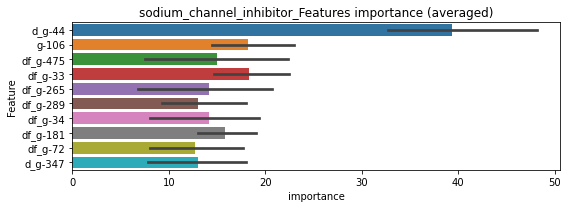

len(train_index) : 3559
len(valid_index) : 3560
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236778	valid_1's binary_logloss: 0.09126
[200]	training's binary_logloss: 0.00585689	valid_1's binary_logloss: 0.0791726
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0061754	valid_1's binary_logloss: 0.0789333


len(train_index) : 3560
len(valid_index) : 3559
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235844	valid_1's binary_logloss: 0.0836408
[200]	training's binary_logloss: 0.00579959	valid_1's binary_logloss: 0.0697265
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00437532	valid_1's binary_logloss: 0.0683688


sodium_channel_inhibitor logloss: 0.0736517938685913


neg labels: 3289 → selected neg labels: 3283


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319791	valid_1's binary_logloss: 0.0525805
[200]	training's binary_logloss: 0.00465106	valid_1's binary_logloss: 0.0146707
[300]	training's binary_logloss: 0.00130965	valid_1's binary_logloss: 0.00745707
[400]	training's binary_logloss: 0.000648684	valid_1's binary_logloss: 0.00546541
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000489667	valid_1's binary_logloss: 0.0049487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322537	valid_1's binary_logloss: 0.0538334
[200]	training's binary_logloss: 0.00473271	valid_1's binary_logloss: 0.0206447
[300]	training's binary_logloss: 0.0013098	valid_1's binary_logloss: 0.0150703
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000776579	valid_1's binary_logloss: 0.0140117


1 / 3 AUC score:1.000
y_Threshold: 0.0039318, Threshold: 0.0070804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00637, conf_1:0.00779
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0070804
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_2: 0.0170804
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_3: 0.0270804
threshold: 0.0270804, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316805	valid_1's binary_logloss: 0.052874
[200]	training's binary_logloss: 0.00452141	valid_1's binary_logloss: 0.014161
[300]	training's binary_logloss: 0.00127843	valid_1's binary_logloss: 0.00763035
[400]	training's binary_logloss: 0.000640454	valid_1's binary_logloss: 0.00618744
[500]	training's binary_logloss: 0.000440391	valid_1's binary_logloss: 0.00538912
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000446654	valid_1's binary_logloss: 0.00537947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032538	valid_1's binary_logloss: 0.0545587
[200]	training's binary_logloss: 0.00453226	valid_1's binary_logloss: 0.0195274
[300]	training's binary_logloss: 0.00127403	valid_1's binary_logloss: 0.0149907
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000733628	valid_1's binary_logloss: 0.013455


2 / 3 AUC score:1.000
y_Threshold: 0.0162457, Threshold: 0.0270804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0070316 Vs.target_rate: 0.00134
Num_p_label: 28.0, conf_0:0.02437, conf_1:0.02979
Num_p_label: 28.0, Expected: 5.4, Adj_threshold_1: 0.0270804
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_2: 0.0370804
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_3: 0.0470804
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_4: 0.0570804
threshold: 0.0570804, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315887	valid_1's binary_logloss: 0.0597407
[200]	training's binary_logloss: 0.00449346	valid_1's binary_logloss: 0.0242242
[300]	training's binary_logloss: 0.0012613	valid_1's binary_logloss: 0.0192738
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000874314	valid_1's binary_logloss: 0.0188572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310487	valid_1's binary_logloss: 0.0547502
[200]	training's binary_logloss: 0.0043822	valid_1's binary_logloss: 0.0188254
[300]	training's binary_logloss: 0.00124389	valid_1's binary_logloss: 0.0117637
[400]	training's binary_logloss: 0.000611854	valid_1's binary_logloss: 0.00975377
[500]	training's binary_logloss: 0.000430793	valid_1's binary_logloss: 0.00915221
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000424354	valid_1's binary_logloss: 0.00911195


3 / 3 AUC score:1.000
y_Threshold: 0.0185830, Threshold: 0.0570804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0012557 Vs.target_rate: 0.00134
Num_p_label: 5.0, conf_0:0.05137, conf_1:0.06279
threshold: 0.0570804, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/7781, y_label_rate: 0.0844364


len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017598	valid_1's binary_logloss: 0.0389208
[200]	training's binary_logloss: 0.00243798	valid_1's binary_logloss: 0.0222915
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000820732	valid_1's binary_logloss: 0.0207224


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01835	valid_1's binary_logloss: 0.0325823
[200]	training's binary_logloss: 0.00255101	valid_1's binary_logloss: 0.0104978
[300]	training's binary_logloss: 0.000695215	valid_1's binary_logloss: 0.00670488
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000361973	valid_1's binary_logloss: 0.00585054


sphingosine_receptor_agonist logloss: 0.013287437969220212


neg labels: 3289 → selected neg labels: 3277


src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432553	valid_1's binary_logloss: 0.0955097
[200]	training's binary_logloss: 0.00785346	valid_1's binary_logloss: 0.0454229
[300]	training's binary_logloss: 0.00228667	valid_1's binary_logloss: 0.0341331
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00157089	valid_1's binary_logloss: 0.0323549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444466	valid_1's binary_logloss: 0.0910926
[200]	training's binary_logloss: 0.00822107	valid_1's binary_logloss: 0.0454341
[300]	training's binary_logloss: 0.00242852	valid_1's binary_logloss: 0.0316553
[400]	training's binary_logloss: 0.00115004	valid_1's binary_logloss: 0.0278799
[500]	training's binary_logloss: 0.000734863	valid_1's binary_logloss: 0.0259705
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000661166	valid_1's binary_logloss: 0.0252083


1 / 3 AUC score:0.999
y_Threshold: 0.0135912, Threshold: 0.0328276, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00298
Num_p_label: 80.0, conf_0:0.02954, conf_1:0.03611
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0328276
Num_p_label: 62.0, Expected: 11.9, Adj_threshold_2: 0.0428276
Num_p_label: 47.0, Expected: 11.9, Adj_threshold_3: 0.0528276
Num_p_label: 37.0, Expected: 11.9, Adj_threshold_4: 0.0628276
Num_p_label: 31.0, Expected: 11.9, Adj_threshold_5: 0.0728276
Num_p_label: 29.0, Expected: 11.9, Adj_threshold_6: 0.0828276
Num_p_label: 28.0, Expected: 11.9, Adj_threshold_7: 0.0928276
Num_p_label: 25.0, Expected: 11.9, Adj_threshold_8: 0.1028276
Num_p_label: 21.0, Expected: 11.9, Adj_threshold_9: 0.1128276
threshold: 0.1128276, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3794, y_label_rate: 0.1718503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411394	valid_1's binary_logloss: 0.0822391
[200]	training's binary_logloss: 0.00726417	valid_1's binary_logloss: 0.03724
[300]	training's binary_logloss: 0.00213931	valid_1's binary_logloss: 0.0269219
[400]	training's binary_logloss: 0.00101528	valid_1's binary_logloss: 0.022878
[500]	training's binary_logloss: 0.000657859	valid_1's binary_logloss: 0.0216644
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000604015	valid_1's binary_logloss: 0.0213278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400575	valid_1's binary_logloss: 0.0878325
[200]	training's binary_logloss: 0.00692398	valid_1's binary_logloss: 0.0435553
[300]	training's binary_logloss: 0.00204445	valid_1's binary_logloss: 0.0335598
[400]	training's binary_logloss: 0.000979854	valid_1's binary_logloss: 0.0311737
Early stopping, best iteration is:
[416]	trai

2 / 3 AUC score:0.999
y_Threshold: 0.1113031, Threshold: 0.1128276, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0228528 Vs.target_rate: 0.00298
Num_p_label: 91.0, conf_0:0.10154, conf_1:0.12411
Num_p_label: 91.0, Expected: 11.9, Adj_threshold_1: 0.1128276
Num_p_label: 85.0, Expected: 11.9, Adj_threshold_2: 0.1228276
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_3: 0.1328276
Num_p_label: 70.0, Expected: 11.9, Adj_threshold_4: 0.1428276
Num_p_label: 66.0, Expected: 11.9, Adj_threshold_5: 0.1528276
Num_p_label: 63.0, Expected: 11.9, Adj_threshold_6: 0.1628276
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_7: 0.1728276
Num_p_label: 56.0, Expected: 11.9, Adj_threshold_8: 0.1828276
Num_p_label: 51.0, Expected: 11.9, Adj_threshold_9: 0.1928276
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_10: 0.2028276
threshold: 0.2128276, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 639.0/3768, y_label_rate: 0.169586

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399667	valid_1's binary_logloss: 0.0717332
[200]	training's binary_logloss: 0.00677898	valid_1's binary_logloss: 0.0282316
[300]	training's binary_logloss: 0.00201508	valid_1's binary_logloss: 0.0196419
[400]	training's binary_logloss: 0.000974658	valid_1's binary_logloss: 0.016663
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000740244	valid_1's binary_logloss: 0.0160957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388549	valid_1's binary_logloss: 0.0861136
[200]	training's binary_logloss: 0.00645485	valid_1's binary_logloss: 0.0477337
[300]	training's binary_logloss: 0.00187435	valid_1's binary_logloss: 0.0394096
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00135057	valid_1's binary_logloss: 0.0384135


3 / 3 AUC score:0.998
y_Threshold: 0.0740838, Threshold: 0.2128276, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0148167 Vs.target_rate: 0.00298
Num_p_label: 59.0, conf_0:0.19154, conf_1:0.23411
Num_p_label: 59.0, Expected: 11.9, Adj_threshold_1: 0.2128276
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_2: 0.2228276
Num_p_label: 48.0, Expected: 11.9, Adj_threshold_3: 0.2328276
Num_p_label: 44.0, Expected: 11.9, Adj_threshold_4: 0.2428276
Num_p_label: 44.0, Expected: 11.9, Adj_threshold_5: 0.2528276
Num_p_label: 43.0, Expected: 11.9, Adj_threshold_6: 0.2628276
Num_p_label: 42.0, Expected: 11.9, Adj_threshold_7: 0.2728276
Num_p_label: 41.0, Expected: 11.9, Adj_threshold_8: 0.2828276
Num_p_label: 41.0, Expected: 11.9, Adj_threshold_9: 0.2928276
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_10: 0.3028276
threshold: 0.3128276, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 666.0/7728, y_label_rate: 0.086180

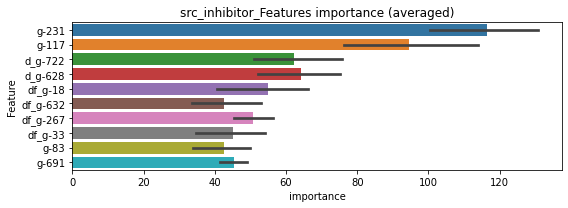

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222304	valid_1's binary_logloss: 0.0491212
[200]	training's binary_logloss: 0.00387702	valid_1's binary_logloss: 0.0242072
[300]	training's binary_logloss: 0.00115543	valid_1's binary_logloss: 0.0180339
[400]	training's binary_logloss: 0.000554005	valid_1's binary_logloss: 0.0163979
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000585191	valid_1's binary_logloss: 0.0163691


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216354	valid_1's binary_logloss: 0.047897
[200]	training's binary_logloss: 0.003771	valid_1's binary_logloss: 0.0250774
[300]	training's binary_logloss: 0.00113122	valid_1's binary_logloss: 0.0204713
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00117619	valid_1's binary_logloss: 0.0203921


src_inhibitor logloss: 0.018380592696291692


neg labels: 3289 → selected neg labels: 3276


steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522004	valid_1's binary_logloss: 0.115025
[200]	training's binary_logloss: 0.0112191	valid_1's binary_logloss: 0.0662949
[300]	training's binary_logloss: 0.00333303	valid_1's binary_logloss: 0.0542928
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00281048	valid_1's binary_logloss: 0.0535271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563392	valid_1's binary_logloss: 0.112754
[200]	training's binary_logloss: 0.0119253	valid_1's binary_logloss: 0.063478
[300]	training's binary_logloss: 0.00343092	valid_1's binary_logloss: 0.0493663
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00166984	valid_1's binary_logloss: 0.0463881


1 / 3 AUC score:0.994
y_Threshold: 0.0192497, Threshold: 0.0330543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 642/3773
p_label_rate: 0.0200904 Vs.target_rate: 0.00332
Num_p_label: 80.0, conf_0:0.02975, conf_1:0.03636
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0330543
Num_p_label: 60.0, Expected: 13.2, Adj_threshold_2: 0.0430543
Num_p_label: 48.0, Expected: 13.2, Adj_threshold_3: 0.0530543
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_4: 0.0630543
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_5: 0.0730543
threshold: 0.0730543, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 642.0/3773, y_label_rate: 0.1701564
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512329	valid_1's binary_logloss: 0.117242
[200]	training's binary_logloss: 0.0100762	valid_1's binary_logloss: 0.0716852
[300]	training's binary_logloss: 0.00289245	valid_1's binary_logloss: 0.0596646
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00159366	valid_1's binary_logloss: 0.0568645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506541	valid_1's binary_logloss: 0.0992652
[200]	training's binary_logloss: 0.0100292	valid_1's binary_logloss: 0.0437272
[300]	training's binary_logloss: 0.00302348	valid_1's binary_logloss: 0.0288131
[400]	training's binary_logloss: 0.00143002	valid_1's binary_logloss: 0.0227344
[500]	training's binary_logloss: 0.000897892	valid_1's binary_logloss: 0.0211909
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000755816	valid_1's binary_logloss: 0.0205944


2 / 3 AUC score:0.997
y_Threshold: 0.0475142, Threshold: 0.0730543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 628.0/3745
p_label_rate: 0.0100452 Vs.target_rate: 0.00332
Num_p_label: 40.0, conf_0:0.06575, conf_1:0.08036
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_1: 0.0730543
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_2: 0.0830543
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_3: 0.0930543
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_4: 0.1030543
threshold: 0.1030543, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 628.0/3745, y_label_rate: 0.1676903
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495827	valid_1's binary_logloss: 0.0976371
[200]	training's binary_logloss: 0.00941626	valid_1's binary_logloss: 0.0470227
[300]	training's binary_logloss: 0.00274857	valid_1's binary_logloss: 0.0339586
[400]	training's binary_logloss: 0.00125095	valid_1's binary_logloss: 0.0294193
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0012748	valid_1's binary_logloss: 0.0293808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483364	valid_1's binary_logloss: 0.0948505
[200]	training's binary_logloss: 0.00986153	valid_1's binary_logloss: 0.0456819
[300]	training's binary_logloss: 0.00285101	valid_1's binary_logloss: 0.0324229
[400]	training's binary_logloss: 0.00129364	valid_1's binary_logloss: 0.028482
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00108234	valid_1's binary_logloss: 0.0276608


3 / 3 AUC score:0.999
y_Threshold: 0.0649343, Threshold: 0.1030543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 621.0/3731
p_label_rate: 0.0065294 Vs.target_rate: 0.00332
Num_p_label: 26.0, conf_0:0.09275, conf_1:0.11336
threshold: 0.1030543, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 647.0/7713, y_label_rate: 0.0838844


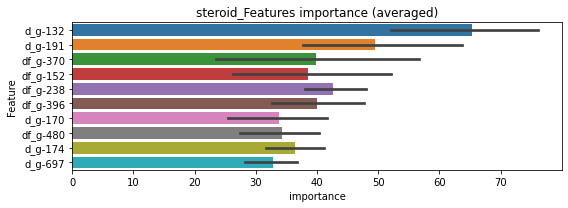

len(train_index) : 3856
len(valid_index) : 3857
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027635	valid_1's binary_logloss: 0.0641767
[200]	training's binary_logloss: 0.00557856	valid_1's binary_logloss: 0.0371122
[300]	training's binary_logloss: 0.00159405	valid_1's binary_logloss: 0.0302469
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000763754	valid_1's binary_logloss: 0.0280473


len(train_index) : 3857
len(valid_index) : 3856
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285917	valid_1's binary_logloss: 0.0623561
[200]	training's binary_logloss: 0.00582835	valid_1's binary_logloss: 0.0384252
[300]	training's binary_logloss: 0.00165627	valid_1's binary_logloss: 0.0324796
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00118444	valid_1's binary_logloss: 0.0318238


steroid logloss: 0.02993530916878007


neg labels: 3289 → selected neg labels: 3286


syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205805	valid_1's binary_logloss: 0.031685
[200]	training's binary_logloss: 0.00228427	valid_1's binary_logloss: 0.00837576
[300]	training's binary_logloss: 0.000661649	valid_1's binary_logloss: 0.00484557
[400]	training's binary_logloss: 0.00036789	valid_1's binary_logloss: 0.0041702
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000330883	valid_1's binary_logloss: 0.00398645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210081	valid_1's binary_logloss: 0.0245602
[200]	training's binary_logloss: 0.00235872	valid_1's binary_logloss: 0.00374074
[300]	training's binary_logloss: 0.000670939	valid_1's binary_logloss: 0.00159872
[400]	training's binary_logloss: 0.000364485	valid_1's binary_logloss: 0.00111394
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000309024	valid_1's binary_logloss: 0.0010135


1 / 3 AUC score:1.000
y_Threshold: 0.0017544, Threshold: 0.0037768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00340, conf_1:0.00415
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0037768
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_2: 0.0137768
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0237768
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.0337768
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.0437768
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_6: 0.0537768
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.0637768
threshold: 0.0637768, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202251	valid_1's binary_logloss: 0.0312513
[200]	training's binary_logloss: 0.00216453	valid_1's binary_logloss: 0.00881609
[300]	training's binary_logloss: 0.000617714	valid_1's binary_logloss: 0.004881
[400]	training's binary_logloss: 0.000340168	valid_1's binary_logloss: 0.00410258
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000301197	valid_1's binary_logloss: 0.00389015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212332	valid_1's binary_logloss: 0.0243279
[200]	training's binary_logloss: 0.00230995	valid_1's binary_logloss: 0.00316906
[300]	training's binary_logloss: 0.000647333	valid_1's binary_logloss: 0.000993366
[400]	training's binary_logloss: 0.000350504	valid_1's binary_logloss: 0.000572294
[500]	training's binary_logloss: 0.000298855	valid_1's binary_logloss: 0.00049142
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0662579, Threshold: 0.0637768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0067805 Vs.target_rate: 0.00080
Num_p_label: 27.0, conf_0:0.05740, conf_1:0.07015
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.0637768
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.0737768
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.0837768
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.0937768
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.1037768
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.1137768
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.1237768
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.1337768
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.1437768
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_10: 0.1537768
threshold: 0.1637768, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202251	valid_1's binary_logloss: 0.0312513
[200]	training's binary_logloss: 0.00216453	valid_1's binary_logloss: 0.00881609
[300]	training's binary_logloss: 0.000617714	valid_1's binary_logloss: 0.004881
[400]	training's binary_logloss: 0.000340168	valid_1's binary_logloss: 0.00410258
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000301197	valid_1's binary_logloss: 0.00389015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212332	valid_1's binary_logloss: 0.0243279
[200]	training's binary_logloss: 0.00230995	valid_1's binary_logloss: 0.00316906
[300]	training's binary_logloss: 0.000647333	valid_1's binary_logloss: 0.000993366
[400]	training's binary_logloss: 0.000350504	valid_1's binary_logloss: 0.000572294
[500]	training's binary_logloss: 0.000298855	valid_1's binary_logloss: 0.00049142
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0662579, Threshold: 0.1637768, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00080
Num_p_label: 12.0, conf_0:0.14740, conf_1:0.18015
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.1637768
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.1737768
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.1837768
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.1937768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.2037768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.2137768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.2237768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.2337768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.2437768
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.2537768
threshold: 0.2637768, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 667.0/7793, y_label_rate: 0.0855896


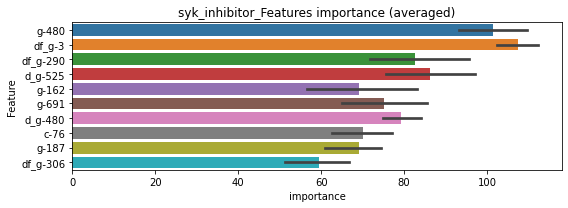

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108908	valid_1's binary_logloss: 0.0175926
[200]	training's binary_logloss: 0.00116241	valid_1's binary_logloss: 0.00555095
[300]	training's binary_logloss: 0.000325035	valid_1's binary_logloss: 0.00431628
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000327965	valid_1's binary_logloss: 0.00430801


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112711	valid_1's binary_logloss: 0.01406
[200]	training's binary_logloss: 0.00135119	valid_1's binary_logloss: 0.00293624
[300]	training's binary_logloss: 0.000461246	valid_1's binary_logloss: 0.00156636
[400]	training's binary_logloss: 0.000306171	valid_1's binary_logloss: 0.00127275
[500]	training's binary_logloss: 0.000168436	valid_1's binary_logloss: 0.001133
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000171984	valid_1's binary_logloss: 0.00112886


syk_inhibitor logloss: 0.0027186367432886736


neg labels: 3289 → selected neg labels: 3279


tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523135	valid_1's binary_logloss: 0.104015
[200]	training's binary_logloss: 0.0105981	valid_1's binary_logloss: 0.0602372
[300]	training's binary_logloss: 0.00282805	valid_1's binary_logloss: 0.0495499
[400]	training's binary_logloss: 0.00121095	valid_1's binary_logloss: 0.0471894
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00117606	valid_1's binary_logloss: 0.047108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510792	valid_1's binary_logloss: 0.106045
[200]	training's binary_logloss: 0.0098323	valid_1's binary_logloss: 0.0524246
[300]	training's binary_logloss: 0.00276319	valid_1's binary_logloss: 0.0392197
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00151784	valid_1's binary_logloss: 0.0353335


1 / 3 AUC score:0.993
y_Threshold: 0.0120755, Threshold: 0.0181207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01631, conf_1:0.01993
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0181207
Num_p_label: 41.0, Expected: 10.0, Adj_threshold_2: 0.0281207
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.0381207
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_4: 0.0481207
threshold: 0.0481207, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484508	valid_1's binary_logloss: 0.0966615
[200]	training's binary_logloss: 0.00890195	valid_1's binary_logloss: 0.0502611
[300]	training's binary_logloss: 0.00250746	valid_1's binary_logloss: 0.0378437
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00130712	valid_1's binary_logloss: 0.0352048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500543	valid_1's binary_logloss: 0.0949158
[200]	training's binary_logloss: 0.00945767	valid_1's binary_logloss: 0.0478971
[300]	training's binary_logloss: 0.00261717	valid_1's binary_logloss: 0.0372138
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0018687	valid_1's binary_logloss: 0.0360789


2 / 3 AUC score:0.999
y_Threshold: 0.0394115, Threshold: 0.0481207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 635.0/3762
p_label_rate: 0.0128076 Vs.target_rate: 0.00252
Num_p_label: 51.0, conf_0:0.04331, conf_1:0.05293
Num_p_label: 51.0, Expected: 10.0, Adj_threshold_1: 0.0481207
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_2: 0.0581207
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_3: 0.0681207
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_4: 0.0781207
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_5: 0.0881207
threshold: 0.0881207, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 635.0/3762, y_label_rate: 0.1687932
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483332	valid_1's binary_logloss: 0.0936513
[200]	training's binary_logloss: 0.00864415	valid_1's binary_logloss: 0.0393667
[300]	training's binary_logloss: 0.00241677	valid_1's binary_logloss: 0.0248404
[400]	training's binary_logloss: 0.00110834	valid_1's binary_logloss: 0.0214187
[500]	training's binary_logloss: 0.000691271	valid_1's binary_logloss: 0.0198257
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000689629	valid_1's binary_logloss: 0.0198227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456728	valid_1's binary_logloss: 0.0869905
[200]	training's binary_logloss: 0.00808589	valid_1's binary_logloss: 0.0393091
[300]	training's binary_logloss: 0.00233509	valid_1's binary_logloss: 0.0288007
[400]	training's binary_logloss: 0.00110216	valid_1's binary_logloss: 0.0261581
Early stopping, best iteration is:
[403]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0358644, Threshold: 0.0881207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 629.0/3750
p_label_rate: 0.0030136 Vs.target_rate: 0.00252
Num_p_label: 12.0, conf_0:0.07931, conf_1:0.09693
threshold: 0.0881207, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 641.0/7732, y_label_rate: 0.0829022


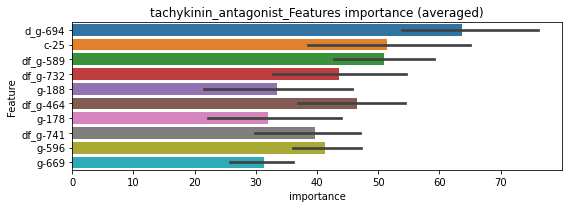

len(train_index) : 3866
len(valid_index) : 3866
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270857	valid_1's binary_logloss: 0.0546146
[200]	training's binary_logloss: 0.00502167	valid_1's binary_logloss: 0.0262992
[300]	training's binary_logloss: 0.00136464	valid_1's binary_logloss: 0.0199102
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000809445	valid_1's binary_logloss: 0.0183662


len(train_index) : 3866
len(valid_index) : 3866
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262971	valid_1's binary_logloss: 0.0569111
[200]	training's binary_logloss: 0.00476088	valid_1's binary_logloss: 0.0327531
[300]	training's binary_logloss: 0.00125134	valid_1's binary_logloss: 0.0280624
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000823	valid_1's binary_logloss: 0.0274053


tachykinin_antagonist logloss: 0.022885725693307483


neg labels: 3289 → selected neg labels: 3284


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182825	valid_1's binary_logloss: 0.0249577
[200]	training's binary_logloss: 0.00169871	valid_1's binary_logloss: 0.00602093
[300]	training's binary_logloss: 0.000449613	valid_1's binary_logloss: 0.00473827
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00032529	valid_1's binary_logloss: 0.00465446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182563	valid_1's binary_logloss: 0.0221385
[200]	training's binary_logloss: 0.00168661	valid_1's binary_logloss: 0.00487407
[300]	training's binary_logloss: 0.000452092	valid_1's binary_logloss: 0.00361301
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000346185	valid_1's binary_logloss: 0.0034332


1 / 3 AUC score:1.000
y_Threshold: 0.0008983, Threshold: 0.0013341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00120, conf_1:0.00147
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0013341
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.0113341
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_3: 0.0213341
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_4: 0.0313341
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_5: 0.0413341
threshold: 0.0413341, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163863	valid_1's binary_logloss: 0.0229239
[200]	training's binary_logloss: 0.00133871	valid_1's binary_logloss: 0.00703505
[300]	training's binary_logloss: 0.000325346	valid_1's binary_logloss: 0.00493306
[400]	training's binary_logloss: 0.000198156	valid_1's binary_logloss: 0.00441704
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000178209	valid_1's binary_logloss: 0.00432554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169423	valid_1's binary_logloss: 0.0177041
[200]	training's binary_logloss: 0.00140022	valid_1's binary_logloss: 0.00174462
[300]	training's binary_logloss: 0.000339709	valid_1's binary_logloss: 0.00055458
[400]	training's binary_logloss: 0.000203741	valid_1's binary_logloss: 0.00038689
[500]	training's binary_logloss: 0.000181895	valid_1's binary_logloss: 0.000357238
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.1203048, Threshold: 0.0413341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0097941 Vs.target_rate: 0.00126
Num_p_label: 39.0, conf_0:0.03720, conf_1:0.04547
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_1: 0.0413341
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_2: 0.0513341
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_3: 0.0613341
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.0713341
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_5: 0.0813341
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_6: 0.0913341
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.1013341
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_8: 0.1113341
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_9: 0.1213341
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_10: 0.1313341
threshold: 0.1413341, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164356	valid_1's binary_logloss: 0.0237226
[200]	training's binary_logloss: 0.00132695	valid_1's binary_logloss: 0.00731601
[300]	training's binary_logloss: 0.000323475	valid_1's binary_logloss: 0.00521404
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000258486	valid_1's binary_logloss: 0.00487862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168444	valid_1's binary_logloss: 0.0184062
[200]	training's binary_logloss: 0.00141494	valid_1's binary_logloss: 0.00331182
[300]	training's binary_logloss: 0.000337421	valid_1's binary_logloss: 0.00215316
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000253872	valid_1's binary_logloss: 0.00199389


3 / 3 AUC score:1.000
y_Threshold: 0.0687438, Threshold: 0.1413341, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0047715 Vs.target_rate: 0.00126
Num_p_label: 19.0, conf_0:0.12720, conf_1:0.15547
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.1413341
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.1513341
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_3: 0.1613341
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.1713341
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_5: 0.1813341
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.1913341
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.2013341
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.2113341
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_9: 0.2213341
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_10: 0.2313341
threshold: 0.2413341, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 668.0/7786, y_label_rate: 0.0857950


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00925095	valid_1's binary_logloss: 0.0122894
[200]	training's binary_logloss: 0.000777985	valid_1's binary_logloss: 0.00392549
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000343293	valid_1's binary_logloss: 0.00356237


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00942075	valid_1's binary_logloss: 0.0152873
[200]	training's binary_logloss: 0.00082788	valid_1's binary_logloss: 0.00615526
[300]	training's binary_logloss: 0.000212031	valid_1's binary_logloss: 0.00458933
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000172725	valid_1's binary_logloss: 0.00446787


tgf-beta_receptor_inhibitor logloss: 0.004015118686545305


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238219	valid_1's binary_logloss: 0.0325306
[200]	training's binary_logloss: 0.00327428	valid_1's binary_logloss: 0.00703628
[300]	training's binary_logloss: 0.000866334	valid_1's binary_logloss: 0.00242088
[400]	training's binary_logloss: 0.000404256	valid_1's binary_logloss: 0.00132876
[500]	training's binary_logloss: 0.000299092	valid_1's binary_logloss: 0.00108534
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000291764	valid_1's binary_logloss: 0.00106804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232641	valid_1's binary_logloss: 0.031621
[200]	training's binary_logloss: 0.00268482	valid_1's binary_logloss: 0.0052137
[300]	training's binary_logloss: 0.00075899	valid_1's binary_logloss: 0.0018092
[400]	training's binary_logloss: 0.000408135	valid_1's binary_logloss: 0.00109599
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0014742, Threshold: 0.0021787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00196, conf_1:0.00240
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0021787
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0121787
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0221787
threshold: 0.0221787, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221088	valid_1's binary_logloss: 0.0305569
[200]	training's binary_logloss: 0.00250935	valid_1's binary_logloss: 0.00598128
[300]	training's binary_logloss: 0.000714577	valid_1's binary_logloss: 0.00235516
[400]	training's binary_logloss: 0.000390537	valid_1's binary_logloss: 0.00150181
[500]	training's binary_logloss: 0.000315584	valid_1's binary_logloss: 0.00129941
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000306588	valid_1's binary_logloss: 0.00128622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022855	valid_1's binary_logloss: 0.0287439
[200]	training's binary_logloss: 0.00263717	valid_1's binary_logloss: 0.00422554
[300]	training's binary_logloss: 0.000745913	valid_1's binary_logloss: 0.00140086
[400]	training's binary_logloss: 0.000400612	valid_1's binary_logloss: 0.000817884
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1375210, Threshold: 0.0221787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00080
Num_p_label: 16.0, conf_0:0.01996, conf_1:0.02440
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_1: 0.0221787
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.0321787
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.0421787
threshold: 0.0421787, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221088	valid_1's binary_logloss: 0.0305569
[200]	training's binary_logloss: 0.00250935	valid_1's binary_logloss: 0.00598128
[300]	training's binary_logloss: 0.000714577	valid_1's binary_logloss: 0.00235516
[400]	training's binary_logloss: 0.000390537	valid_1's binary_logloss: 0.00150181
[500]	training's binary_logloss: 0.000315584	valid_1's binary_logloss: 0.00129941
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000306588	valid_1's binary_logloss: 0.00128622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022855	valid_1's binary_logloss: 0.0287439
[200]	training's binary_logloss: 0.00263717	valid_1's binary_logloss: 0.00422554
[300]	training's binary_logloss: 0.000745913	valid_1's binary_logloss: 0.00140086
[400]	training's binary_logloss: 0.000400612	valid_1's binary_logloss: 0.000817884
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1375210, Threshold: 0.0421787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080
Num_p_label: 6.0, conf_0:0.03796, conf_1:0.04640
threshold: 0.0421787, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


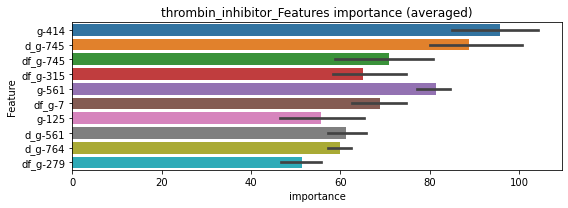

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124599	valid_1's binary_logloss: 0.0195923
[200]	training's binary_logloss: 0.00140313	valid_1's binary_logloss: 0.0070292
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000557102	valid_1's binary_logloss: 0.00610637


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126464	valid_1's binary_logloss: 0.0181844
[200]	training's binary_logloss: 0.00146608	valid_1's binary_logloss: 0.00393402
[300]	training's binary_logloss: 0.000419454	valid_1's binary_logloss: 0.00207207
[400]	training's binary_logloss: 0.000215104	valid_1's binary_logloss: 0.00173547
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0001864	valid_1's binary_logloss: 0.00169628


thrombin_inhibitor logloss: 0.003901610661485799


neg labels: 3289 → selected neg labels: 3285


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364561	valid_1's binary_logloss: 0.0580739
[200]	training's binary_logloss: 0.00546313	valid_1's binary_logloss: 0.0145213
[300]	training's binary_logloss: 0.0014795	valid_1's binary_logloss: 0.00588497
[400]	training's binary_logloss: 0.000708686	valid_1's binary_logloss: 0.00355265
[500]	training's binary_logloss: 0.000470959	valid_1's binary_logloss: 0.00274698
[600]	training's binary_logloss: 0.000420577	valid_1's binary_logloss: 0.00255966
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000420839	valid_1's binary_logloss: 0.00255867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381573	valid_1's binary_logloss: 0.0535439
[200]	training's binary_logloss: 0.00567672	valid_1's binary_logloss: 0.0119777
[300]	training's binary_logloss: 0.00154628	valid_1's binary_logloss: 0.00470102
[400]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0030930, Threshold: 0.0044802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00403, conf_1:0.00493
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0044802
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.0144802
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_3: 0.0244802
threshold: 0.0244802, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035316	valid_1's binary_logloss: 0.0577708
[200]	training's binary_logloss: 0.00508306	valid_1's binary_logloss: 0.0140862
[300]	training's binary_logloss: 0.00139564	valid_1's binary_logloss: 0.00575289
[400]	training's binary_logloss: 0.000679036	valid_1's binary_logloss: 0.00355252
[500]	training's binary_logloss: 0.000459285	valid_1's binary_logloss: 0.00274161
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00042315	valid_1's binary_logloss: 0.00262819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353089	valid_1's binary_logloss: 0.0489613
[200]	training's binary_logloss: 0.00513881	valid_1's binary_logloss: 0.0101536
[300]	training's binary_logloss: 0.00144819	valid_1's binary_logloss: 0.00384129
[400]	training's binary_logloss: 0.000705161	valid_1's binary_logloss: 0.00228269
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1268957, Threshold: 0.0244802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00155
Num_p_label: 17.0, conf_0:0.02203, conf_1:0.02693
threshold: 0.0244802, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035316	valid_1's binary_logloss: 0.0577708
[200]	training's binary_logloss: 0.00508306	valid_1's binary_logloss: 0.0140862
[300]	training's binary_logloss: 0.00139564	valid_1's binary_logloss: 0.00575289
[400]	training's binary_logloss: 0.000679036	valid_1's binary_logloss: 0.00355252
[500]	training's binary_logloss: 0.000459285	valid_1's binary_logloss: 0.00274161
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00042315	valid_1's binary_logloss: 0.00262819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353089	valid_1's binary_logloss: 0.0489613
[200]	training's binary_logloss: 0.00513881	valid_1's binary_logloss: 0.0101536
[300]	training's binary_logloss: 0.00144819	valid_1's binary_logloss: 0.00384129
[400]	training's binary_logloss: 0.000705161	valid_1's binary_logloss: 0.00228269
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1268957, Threshold: 0.0244802, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00155
Num_p_label: 17.0, conf_0:0.02203, conf_1:0.02693
threshold: 0.0244802, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 674.0/7792, y_label_rate: 0.0864990


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200135	valid_1's binary_logloss: 0.0352547
[200]	training's binary_logloss: 0.00281172	valid_1's binary_logloss: 0.0155527
[300]	training's binary_logloss: 0.000762928	valid_1's binary_logloss: 0.0131776
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000590619	valid_1's binary_logloss: 0.0130015


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02062	valid_1's binary_logloss: 0.0337274
[200]	training's binary_logloss: 0.00315412	valid_1's binary_logloss: 0.0107834
[300]	training's binary_logloss: 0.000859171	valid_1's binary_logloss: 0.00702751
[400]	training's binary_logloss: 0.000401417	valid_1's binary_logloss: 0.00637888
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000326499	valid_1's binary_logloss: 0.00622625


thymidylate_synthase_inhibitor logloss: 0.009613861076207958


neg labels: 3289 → selected neg labels: 3284


tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341074	valid_1's binary_logloss: 0.0544998
[200]	training's binary_logloss: 0.00493388	valid_1's binary_logloss: 0.0143985
[300]	training's binary_logloss: 0.00133545	valid_1's binary_logloss: 0.00645824
[400]	training's binary_logloss: 0.000643124	valid_1's binary_logloss: 0.00440593
[500]	training's binary_logloss: 0.000439402	valid_1's binary_logloss: 0.00368279
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000417874	valid_1's binary_logloss: 0.00357461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343018	valid_1's binary_logloss: 0.0580352
[200]	training's binary_logloss: 0.00503512	valid_1's binary_logloss: 0.016135
[300]	training's binary_logloss: 0.00134277	valid_1's binary_logloss: 0.00708387
[400]	training's binary_logloss: 0.000653655	valid_1's binary_logloss: 0.00485233
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024942, Threshold: 0.0036641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00330, conf_1:0.00403
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0036641
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0136641
threshold: 0.0136641, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335731	valid_1's binary_logloss: 0.0543909
[200]	training's binary_logloss: 0.00481427	valid_1's binary_logloss: 0.0145749
[300]	training's binary_logloss: 0.0013174	valid_1's binary_logloss: 0.00645755
[400]	training's binary_logloss: 0.00063525	valid_1's binary_logloss: 0.00438323
[500]	training's binary_logloss: 0.00043677	valid_1's binary_logloss: 0.0038697
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000414623	valid_1's binary_logloss: 0.00377175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330082	valid_1's binary_logloss: 0.0533169
[200]	training's binary_logloss: 0.00475221	valid_1's binary_logloss: 0.0134253
[300]	training's binary_logloss: 0.00129342	valid_1's binary_logloss: 0.00559355
[400]	training's binary_logloss: 0.000633217	valid_1's binary_logloss: 0.00364375
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.0311781, Threshold: 0.0136641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0067805 Vs.target_rate: 0.00126
Num_p_label: 27.0, conf_0:0.01230, conf_1:0.01503
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_1: 0.0136641
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.0236641
threshold: 0.0236641, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335731	valid_1's binary_logloss: 0.0543909
[200]	training's binary_logloss: 0.00481427	valid_1's binary_logloss: 0.0145749
[300]	training's binary_logloss: 0.0013174	valid_1's binary_logloss: 0.00645755
[400]	training's binary_logloss: 0.00063525	valid_1's binary_logloss: 0.00438323
[500]	training's binary_logloss: 0.00043677	valid_1's binary_logloss: 0.0038697
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000414623	valid_1's binary_logloss: 0.00377175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330082	valid_1's binary_logloss: 0.0533169
[200]	training's binary_logloss: 0.00475221	valid_1's binary_logloss: 0.0134253
[300]	training's binary_logloss: 0.00129342	valid_1's binary_logloss: 0.00559355
[400]	training's binary_logloss: 0.000633217	valid_1's binary_logloss: 0.00364375
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0311781, Threshold: 0.0236641, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.02130, conf_1:0.02603
threshold: 0.0236641, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194903	valid_1's binary_logloss: 0.0331581
[200]	training's binary_logloss: 0.00284109	valid_1's binary_logloss: 0.0130848
[300]	training's binary_logloss: 0.000738755	valid_1's binary_logloss: 0.0104672
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000541565	valid_1's binary_logloss: 0.010227


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201283	valid_1's binary_logloss: 0.0340507
[200]	training's binary_logloss: 0.00308304	valid_1's binary_logloss: 0.0133691
[300]	training's binary_logloss: 0.000812716	valid_1's binary_logloss: 0.0100937
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000582922	valid_1's binary_logloss: 0.00965982


tlr_agonist logloss: 0.009943420114623128


neg labels: 3289 → selected neg labels: 3287


tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159438	valid_1's binary_logloss: 0.0174409
[200]	training's binary_logloss: 0.0013677	valid_1's binary_logloss: 0.0019951
[300]	training's binary_logloss: 0.000376775	valid_1's binary_logloss: 0.000747185
[400]	training's binary_logloss: 0.000229975	valid_1's binary_logloss: 0.000522217
[500]	training's binary_logloss: 0.000203112	valid_1's binary_logloss: 0.000482977
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00020291	valid_1's binary_logloss: 0.000482716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160834	valid_1's binary_logloss: 0.0181521
[200]	training's binary_logloss: 0.00136817	valid_1's binary_logloss: 0.00190961
[300]	training's binary_logloss: 0.000378044	valid_1's binary_logloss: 0.000621403
[400]	training's binary_logloss: 0.000231667	valid_1's binary_logloss: 0.000407082
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006859, Threshold: 0.0010256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00092, conf_1:0.00113
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010256
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.0110256
threshold: 0.0110256, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162065	valid_1's binary_logloss: 0.01787
[200]	training's binary_logloss: 0.00135645	valid_1's binary_logloss: 0.00209011
[300]	training's binary_logloss: 0.000368287	valid_1's binary_logloss: 0.000761
[400]	training's binary_logloss: 0.000226577	valid_1's binary_logloss: 0.000533979
[500]	training's binary_logloss: 0.000199291	valid_1's binary_logloss: 0.000493762
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000195915	valid_1's binary_logloss: 0.000488994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164447	valid_1's binary_logloss: 0.0192654
[200]	training's binary_logloss: 0.0013611	valid_1's binary_logloss: 0.00254959
[300]	training's binary_logloss: 0.000368984	valid_1's binary_logloss: 0.00114893
[400]	training's binary_logloss: 0.000229831	valid_1's binary_logloss: 0.000928795
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1020056, Threshold: 0.0110256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0055249 Vs.target_rate: 0.00029
Num_p_label: 22.0, conf_0:0.00992, conf_1:0.01213
Num_p_label: 22.0, Expected: 1.2, Adj_threshold_1: 0.0110256
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_2: 0.0210256
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0310256
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.0410256
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0510256
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.0610256
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.0710256
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.0810256
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_9: 0.0910256
threshold: 0.0910256, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162065	valid_1's binary_logloss: 0.01787
[200]	training's binary_logloss: 0.00135645	valid_1's binary_logloss: 0.00209011
[300]	training's binary_logloss: 0.000368287	valid_1's binary_logloss: 0.000761
[400]	training's binary_logloss: 0.000226577	valid_1's binary_logloss: 0.000533979
[500]	training's binary_logloss: 0.000199291	valid_1's binary_logloss: 0.000493762
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000195915	valid_1's binary_logloss: 0.000488994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164447	valid_1's binary_logloss: 0.0192654
[200]	training's binary_logloss: 0.0013611	valid_1's binary_logloss: 0.00254959
[300]	training's binary_logloss: 0.000368984	valid_1's binary_logloss: 0.00114893
[400]	training's binary_logloss: 0.000229831	valid_1's binary_logloss: 0.000928795
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1020056, Threshold: 0.0910256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.08192, conf_1:0.10013
threshold: 0.0910256, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855198	valid_1's binary_logloss: 0.0101797
[200]	training's binary_logloss: 0.000690108	valid_1's binary_logloss: 0.0020736
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000238759	valid_1's binary_logloss: 0.00166838


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00863795	valid_1's binary_logloss: 0.0106931
[200]	training's binary_logloss: 0.000712885	valid_1's binary_logloss: 0.0024436
[300]	training's binary_logloss: 0.000193708	valid_1's binary_logloss: 0.00159386
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000155876	valid_1's binary_logloss: 0.00148996


tlr_antagonist logloss: 0.00157917127633961


neg labels: 3289 → selected neg labels: 3283


tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335308	valid_1's binary_logloss: 0.0507547
[200]	training's binary_logloss: 0.0050745	valid_1's binary_logloss: 0.0132166
[300]	training's binary_logloss: 0.00141851	valid_1's binary_logloss: 0.00591227
[400]	training's binary_logloss: 0.000704932	valid_1's binary_logloss: 0.00394556
[500]	training's binary_logloss: 0.000465472	valid_1's binary_logloss: 0.00318143
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000429648	valid_1's binary_logloss: 0.00307482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322789	valid_1's binary_logloss: 0.0686755
[200]	training's binary_logloss: 0.00474893	valid_1's binary_logloss: 0.031104
[300]	training's binary_logloss: 0.00135699	valid_1's binary_logloss: 0.0242905
[400]	training's binary_logloss: 0.000666951	valid_1's binary_logloss: 0.0226149
Early stopping, best iteration is:
[395

1 / 3 AUC score:1.000
y_Threshold: 0.0038877, Threshold: 0.0063140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00568, conf_1:0.00695
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0063140
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0163140
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0263140
threshold: 0.0263140, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313015	valid_1's binary_logloss: 0.0480119
[200]	training's binary_logloss: 0.00453155	valid_1's binary_logloss: 0.0120484
[300]	training's binary_logloss: 0.00130073	valid_1's binary_logloss: 0.00554467
[400]	training's binary_logloss: 0.000651203	valid_1's binary_logloss: 0.00371028
[500]	training's binary_logloss: 0.000451007	valid_1's binary_logloss: 0.00307789
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000425106	valid_1's binary_logloss: 0.0030187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319152	valid_1's binary_logloss: 0.0629759
[200]	training's binary_logloss: 0.00462706	valid_1's binary_logloss: 0.021368
[300]	training's binary_logloss: 0.00134432	valid_1's binary_logloss: 0.0124395
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00105144	valid_1's binary_logloss: 0.0111084


2 / 3 AUC score:1.000
y_Threshold: 0.0378352, Threshold: 0.0263140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0082873 Vs.target_rate: 0.00151
Num_p_label: 33.0, conf_0:0.02368, conf_1:0.02895
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.0263140
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0363140
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0463140
threshold: 0.0463140, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312139	valid_1's binary_logloss: 0.0475822
[200]	training's binary_logloss: 0.00455615	valid_1's binary_logloss: 0.0137246
[300]	training's binary_logloss: 0.00131203	valid_1's binary_logloss: 0.00765525
[400]	training's binary_logloss: 0.000659239	valid_1's binary_logloss: 0.00596544
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000517475	valid_1's binary_logloss: 0.00561008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312473	valid_1's binary_logloss: 0.0674894
[200]	training's binary_logloss: 0.00445973	valid_1's binary_logloss: 0.0267304
[300]	training's binary_logloss: 0.00127016	valid_1's binary_logloss: 0.0182393
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000723582	valid_1's binary_logloss: 0.0159502


3 / 3 AUC score:1.000
y_Threshold: 0.0244078, Threshold: 0.0463140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.04168, conf_1:0.05095
threshold: 0.0463140, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 663.0/7781, y_label_rate: 0.0852076


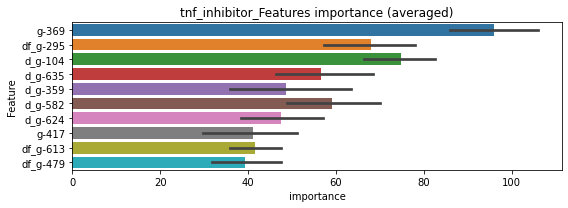

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170558	valid_1's binary_logloss: 0.0370597
[200]	training's binary_logloss: 0.00246293	valid_1's binary_logloss: 0.0167471
[300]	training's binary_logloss: 0.000699708	valid_1's binary_logloss: 0.0140646
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000669457	valid_1's binary_logloss: 0.0140334


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018352	valid_1's binary_logloss: 0.0318055
[200]	training's binary_logloss: 0.00281976	valid_1's binary_logloss: 0.0136059
[300]	training's binary_logloss: 0.000784059	valid_1's binary_logloss: 0.0101458
[400]	training's binary_logloss: 0.000368967	valid_1's binary_logloss: 0.00939605
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000267357	valid_1's binary_logloss: 0.00910409


tnf_inhibitor logloss: 0.011569057659418682


neg labels: 3289 → selected neg labels: 3271


topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373925	valid_1's binary_logloss: 0.0781896
[200]	training's binary_logloss: 0.0063142	valid_1's binary_logloss: 0.0468429
[300]	training's binary_logloss: 0.00187415	valid_1's binary_logloss: 0.0408509
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00174949	valid_1's binary_logloss: 0.0406155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377315	valid_1's binary_logloss: 0.0795988
[200]	training's binary_logloss: 0.00665716	valid_1's binary_logloss: 0.0534423
[300]	training's binary_logloss: 0.00186834	valid_1's binary_logloss: 0.0458214
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00193859	valid_1's binary_logloss: 0.0457539


1 / 3 AUC score:0.998
y_Threshold: 0.0112038, Threshold: 0.6941204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 143 → Positive_corect_labels: 648/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00533
Num_p_label: 80.0, conf_0:0.62471, conf_1:0.76353
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6941204
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_2: 0.7041204
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_3: 0.7141204
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_4: 0.7241204
Num_p_label: 75.0, Expected: 21.2, Adj_threshold_5: 0.7341204
Num_p_label: 73.0, Expected: 21.2, Adj_threshold_6: 0.7441204
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_7: 0.7541204
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_8: 0.7641204
Num_p_label: 69.0, Expected: 21.2, Adj_threshold_9: 0.7741204
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_10: 0.7841204
threshold: 0.7941204, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 648.0/3782, y_label_rate: 0.1713379

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297806	valid_1's binary_logloss: 0.0584039
[200]	training's binary_logloss: 0.00427066	valid_1's binary_logloss: 0.0291986
[300]	training's binary_logloss: 0.00123579	valid_1's binary_logloss: 0.0233113
[400]	training's binary_logloss: 0.000627971	valid_1's binary_logloss: 0.0211198
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000569775	valid_1's binary_logloss: 0.0209566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300564	valid_1's binary_logloss: 0.0606984
[200]	training's binary_logloss: 0.00414855	valid_1's binary_logloss: 0.03213
[300]	training's binary_logloss: 0.00120722	valid_1's binary_logloss: 0.0265656
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0011436	valid_1's binary_logloss: 0.0264155


2 / 3 AUC score:1.000
y_Threshold: 0.0714903, Threshold: 0.7941204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 637.0/3760
p_label_rate: 0.0366650 Vs.target_rate: 0.00533
Num_p_label: 146.0, conf_0:0.71471, conf_1:0.87353
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_1: 0.7941204
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_2: 0.8041204
Num_p_label: 145.0, Expected: 21.2, Adj_threshold_3: 0.8141204
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_4: 0.8241204
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_5: 0.8341204
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_6: 0.8441204
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_7: 0.8541204
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_8: 0.8641204
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_9: 0.8741204
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_10: 0.8841204
threshold: 0.8941204, positive_p_label: 137.0/3982, p_label_rate: 0.0344048
positive_y_label: 637.0/3760, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027786	valid_1's binary_logloss: 0.0532536
[200]	training's binary_logloss: 0.00383838	valid_1's binary_logloss: 0.0253154
[300]	training's binary_logloss: 0.00111326	valid_1's binary_logloss: 0.019203
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000709978	valid_1's binary_logloss: 0.0177598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276191	valid_1's binary_logloss: 0.0614801
[200]	training's binary_logloss: 0.00384623	valid_1's binary_logloss: 0.0361034
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00188754	valid_1's binary_logloss: 0.033453


3 / 3 AUC score:1.000
y_Threshold: 0.0461896, Threshold: 0.8941204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 628.0/3742
p_label_rate: 0.0374184 Vs.target_rate: 0.00533
Num_p_label: 149.0, conf_0:0.80471, conf_1:0.98353
Num_p_label: 149.0, Expected: 21.2, Adj_threshold_1: 0.8941204
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_2: 0.9041204
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_3: 0.9141204
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_4: 0.9241204
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_5: 0.9341204
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_6: 0.9441204
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_7: 0.9541204
Num_p_label: 130.0, Expected: 21.2, Adj_threshold_8: 0.9641204
Num_p_label: 125.0, Expected: 21.2, Adj_threshold_9: 0.9741204
Num_p_label: 120.0, Expected: 21.2, Adj_threshold_10: 0.9841204
threshold: 0.9941204, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 728.0/7724, y_label_ra

len(train_index) : 3862
len(valid_index) : 3862
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179589	valid_1's binary_logloss: 0.0413961
[200]	training's binary_logloss: 0.00259356	valid_1's binary_logloss: 0.026834
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00142259	valid_1's binary_logloss: 0.0249777


len(train_index) : 3862
len(valid_index) : 3862
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185235	valid_1's binary_logloss: 0.0328726
[200]	training's binary_logloss: 0.00298201	valid_1's binary_logloss: 0.0176593
[300]	training's binary_logloss: 0.000862739	valid_1's binary_logloss: 0.0153019
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000446474	valid_1's binary_logloss: 0.0140562


topoisomerase_inhibitor logloss: 0.01951695665093261


neg labels: 3289 → selected neg labels: 3286


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229649	valid_1's binary_logloss: 0.0307739
[200]	training's binary_logloss: 0.00265426	valid_1's binary_logloss: 0.00505007
[300]	training's binary_logloss: 0.000755032	valid_1's binary_logloss: 0.00180617
[400]	training's binary_logloss: 0.000394582	valid_1's binary_logloss: 0.00108439
[500]	training's binary_logloss: 0.000321374	valid_1's binary_logloss: 0.000943509
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000321403	valid_1's binary_logloss: 0.000943485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234726	valid_1's binary_logloss: 0.0319839
[200]	training's binary_logloss: 0.00276593	valid_1's binary_logloss: 0.00637302
[300]	training's binary_logloss: 0.000758562	valid_1's binary_logloss: 0.00271574
[400]	training's binary_logloss: 0.000398877	valid_1's binary_logloss: 0.00180548
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0013695, Threshold: 0.0018137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00163, conf_1:0.00200
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0018137
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0118137
threshold: 0.0118137, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238753	valid_1's binary_logloss: 0.030391
[200]	training's binary_logloss: 0.00264791	valid_1's binary_logloss: 0.0047345
[300]	training's binary_logloss: 0.000733782	valid_1's binary_logloss: 0.00164597
[400]	training's binary_logloss: 0.000394111	valid_1's binary_logloss: 0.00101445
[500]	training's binary_logloss: 0.000317776	valid_1's binary_logloss: 0.000878842
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000317201	valid_1's binary_logloss: 0.000878175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233035	valid_1's binary_logloss: 0.0312928
[200]	training's binary_logloss: 0.0026399	valid_1's binary_logloss: 0.00610795
[300]	training's binary_logloss: 0.000803659	valid_1's binary_logloss: 0.00307578
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000520123	valid_1's binary_logloss: 0.002498

2 / 3 AUC score:1.000
y_Threshold: 0.0235863, Threshold: 0.0118137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00076
Num_p_label: 14.0, conf_0:0.01063, conf_1:0.01300
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.0118137
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0218137
threshold: 0.0218137, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238753	valid_1's binary_logloss: 0.030391
[200]	training's binary_logloss: 0.00264791	valid_1's binary_logloss: 0.0047345
[300]	training's binary_logloss: 0.000733782	valid_1's binary_logloss: 0.00164597
[400]	training's binary_logloss: 0.000394111	valid_1's binary_logloss: 0.00101445
[500]	training's binary_logloss: 0.000317776	valid_1's binary_logloss: 0.000878842
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000317201	valid_1's binary_logloss: 0.000878175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233035	valid_1's binary_logloss: 0.0312928
[200]	training's binary_logloss: 0.0026399	valid_1's binary_logloss: 0.00610795
[300]	training's binary_logloss: 0.000803659	valid_1's binary_logloss: 0.00307578
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000520123	valid_1's binary_logloss: 0.002498

3 / 3 AUC score:1.000
y_Threshold: 0.0235863, Threshold: 0.0218137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.01963, conf_1:0.02400
threshold: 0.0218137, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


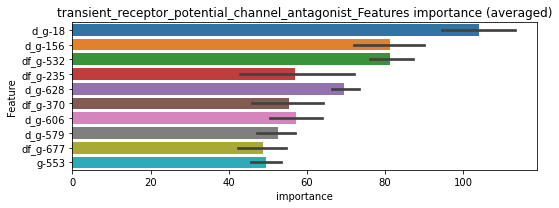

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119263	valid_1's binary_logloss: 0.0194218
[200]	training's binary_logloss: 0.00134385	valid_1's binary_logloss: 0.00775652
[300]	training's binary_logloss: 0.000367685	valid_1's binary_logloss: 0.00630442
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000269015	valid_1's binary_logloss: 0.0061559


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123603	valid_1's binary_logloss: 0.0158853
[200]	training's binary_logloss: 0.00142809	valid_1's binary_logloss: 0.00338534
[300]	training's binary_logloss: 0.000392	valid_1's binary_logloss: 0.00207784
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000223633	valid_1's binary_logloss: 0.00188727


transient_receptor_potential_channel_antagonist logloss: 0.004021861585109395


neg labels: 3289 → selected neg labels: 3288


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158141	valid_1's binary_logloss: 0.0174076
[200]	training's binary_logloss: 0.00132286	valid_1's binary_logloss: 0.00172492
[300]	training's binary_logloss: 0.000350239	valid_1's binary_logloss: 0.000508903
[400]	training's binary_logloss: 0.000213646	valid_1's binary_logloss: 0.000331614
[500]	training's binary_logloss: 0.000190435	valid_1's binary_logloss: 0.000300226
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000190435	valid_1's binary_logloss: 0.000300226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158675	valid_1's binary_logloss: 0.0172354
[200]	training's binary_logloss: 0.00131825	valid_1's binary_logloss: 0.00168834
[300]	training's binary_logloss: 0.000348643	valid_1's binary_logloss: 0.000491762
[400]	training's binary_logloss: 0.000212242	valid_1's binary_logloss: 0.00031217
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005515, Threshold: 0.0012050, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00108, conf_1:0.00133
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0012050
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0112050
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0212050
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0312050
threshold: 0.0312050, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161754	valid_1's binary_logloss: 0.0180398
[200]	training's binary_logloss: 0.00132077	valid_1's binary_logloss: 0.00211096
[300]	training's binary_logloss: 0.000343254	valid_1's binary_logloss: 0.000751642
[400]	training's binary_logloss: 0.000212009	valid_1's binary_logloss: 0.000518707
[500]	training's binary_logloss: 0.000189506	valid_1's binary_logloss: 0.000480865
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000188945	valid_1's binary_logloss: 0.000480382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162518	valid_1's binary_logloss: 0.0176269
[200]	training's binary_logloss: 0.0013228	valid_1's binary_logloss: 0.00156529
[300]	training's binary_logloss: 0.000345489	valid_1's binary_logloss: 0.00043604
[400]	training's binary_logloss: 0.000211125	valid_1's binary_logloss: 0.000274767
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1290984, Threshold: 0.0312050, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025
Num_p_label: 10.0, conf_0:0.02808, conf_1:0.03433
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.0312050
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0412050
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0512050
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0612050
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0712050
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.0812050
threshold: 0.0812050, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161754	valid_1's binary_logloss: 0.0180398
[200]	training's binary_logloss: 0.00132077	valid_1's binary_logloss: 0.00211096
[300]	training's binary_logloss: 0.000343254	valid_1's binary_logloss: 0.000751642
[400]	training's binary_logloss: 0.000212009	valid_1's binary_logloss: 0.000518707
[500]	training's binary_logloss: 0.000189506	valid_1's binary_logloss: 0.000480865
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000188945	valid_1's binary_logloss: 0.000480382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162518	valid_1's binary_logloss: 0.0176269
[200]	training's binary_logloss: 0.0013228	valid_1's binary_logloss: 0.00156529
[300]	training's binary_logloss: 0.000345489	valid_1's binary_logloss: 0.00043604
[400]	training's binary_logloss: 0.000211125	valid_1's binary_logloss: 0.000274767
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1290984, Threshold: 0.0812050, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.07308, conf_1:0.08933
threshold: 0.0812050, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00864223	valid_1's binary_logloss: 0.0104008
[200]	training's binary_logloss: 0.000699252	valid_1's binary_logloss: 0.00209284
[300]	training's binary_logloss: 0.00018004	valid_1's binary_logloss: 0.00158077
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00014351	valid_1's binary_logloss: 0.00155349


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00866112	valid_1's binary_logloss: 0.0101016
[200]	training's binary_logloss: 0.000708081	valid_1's binary_logloss: 0.00211134
[300]	training's binary_logloss: 0.000183971	valid_1's binary_logloss: 0.00159752
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000174736	valid_1's binary_logloss: 0.00159317


tropomyosin_receptor_kinase_inhibitor logloss: 0.0015733259671709516


neg labels: 3289 → selected neg labels: 3285


trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263425	valid_1's binary_logloss: 0.035814
[200]	training's binary_logloss: 0.00328101	valid_1's binary_logloss: 0.00655291
[300]	training's binary_logloss: 0.000935161	valid_1's binary_logloss: 0.00260403
[400]	training's binary_logloss: 0.000482974	valid_1's binary_logloss: 0.00165352
[500]	training's binary_logloss: 0.000365857	valid_1's binary_logloss: 0.00135196
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000353352	valid_1's binary_logloss: 0.00132435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253398	valid_1's binary_logloss: 0.0345957
[200]	training's binary_logloss: 0.00316778	valid_1's binary_logloss: 0.00628041
[300]	training's binary_logloss: 0.000905003	valid_1's binary_logloss: 0.0024906
[400]	training's binary_logloss: 0.000473922	valid_1's binary_logloss: 0.0015655
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0021238, Threshold: 0.0055176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00497, conf_1:0.00607
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0055176
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_2: 0.0155176
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_3: 0.0255176
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_4: 0.0355176
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_5: 0.0455176
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_6: 0.0555176
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.0655176
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.0755176
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.0855176
threshold: 0.0855176, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247908	valid_1's binary_logloss: 0.0332829
[200]	training's binary_logloss: 0.00298094	valid_1's binary_logloss: 0.0052222
[300]	training's binary_logloss: 0.000850423	valid_1's binary_logloss: 0.00178958
[400]	training's binary_logloss: 0.000453128	valid_1's binary_logloss: 0.00106464
[500]	training's binary_logloss: 0.000353724	valid_1's binary_logloss: 0.000877423
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000341432	valid_1's binary_logloss: 0.000857074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251787	valid_1's binary_logloss: 0.0341096
[200]	training's binary_logloss: 0.00301455	valid_1's binary_logloss: 0.00539304
[300]	training's binary_logloss: 0.000863654	valid_1's binary_logloss: 0.00193735
[400]	training's binary_logloss: 0.000455977	valid_1's binary_logloss: 0.00113412
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1930497, Threshold: 0.0855176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0085384 Vs.target_rate: 0.00105
Num_p_label: 34.0, conf_0:0.07697, conf_1:0.09407
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_1: 0.0855176
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.0955176
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_3: 0.1055176
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_4: 0.1155176
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_5: 0.1255176
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_6: 0.1355176
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_7: 0.1455176
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_8: 0.1555176
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_9: 0.1655176
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_10: 0.1755176
threshold: 0.1855176, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247908	valid_1's binary_logloss: 0.0332829
[200]	training's binary_logloss: 0.00298094	valid_1's binary_logloss: 0.0052222
[300]	training's binary_logloss: 0.000850423	valid_1's binary_logloss: 0.00178958
[400]	training's binary_logloss: 0.000453128	valid_1's binary_logloss: 0.00106464
[500]	training's binary_logloss: 0.000353724	valid_1's binary_logloss: 0.000877423
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000341432	valid_1's binary_logloss: 0.000857074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251787	valid_1's binary_logloss: 0.0341096
[200]	training's binary_logloss: 0.00301455	valid_1's binary_logloss: 0.00539304
[300]	training's binary_logloss: 0.000863654	valid_1's binary_logloss: 0.00193735
[400]	training's binary_logloss: 0.000455977	valid_1's binary_logloss: 0.00113412
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1930497, Threshold: 0.1855176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00105
Num_p_label: 21.0, conf_0:0.16697, conf_1:0.20407
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.1855176
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_2: 0.1955176
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.2055176
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.2155176
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_5: 0.2255176
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_6: 0.2355176
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_7: 0.2455176
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_8: 0.2555176
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_9: 0.2655176
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_10: 0.2755176
threshold: 0.2855176, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 675.0/7792, y_label_rate: 0.0866273


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135896	valid_1's binary_logloss: 0.0227043
[200]	training's binary_logloss: 0.00169674	valid_1's binary_logloss: 0.00750259
[300]	training's binary_logloss: 0.000486119	valid_1's binary_logloss: 0.00606419
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000409888	valid_1's binary_logloss: 0.00597316


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143648	valid_1's binary_logloss: 0.0215354
[200]	training's binary_logloss: 0.00176988	valid_1's binary_logloss: 0.00564603
[300]	training's binary_logloss: 0.000500136	valid_1's binary_logloss: 0.00344594
[400]	training's binary_logloss: 0.000262175	valid_1's binary_logloss: 0.00290632
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000200813	valid_1's binary_logloss: 0.0027383


trpv_agonist logloss: 0.004355728762722627


neg labels: 3289 → selected neg labels: 3281


trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454132	valid_1's binary_logloss: 0.093537
[200]	training's binary_logloss: 0.00811469	valid_1's binary_logloss: 0.0437195
[300]	training's binary_logloss: 0.00223501	valid_1's binary_logloss: 0.0309606
[400]	training's binary_logloss: 0.0010364	valid_1's binary_logloss: 0.0277969
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000990977	valid_1's binary_logloss: 0.0276181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482919	valid_1's binary_logloss: 0.0870416
[200]	training's binary_logloss: 0.00899161	valid_1's binary_logloss: 0.0360682
[300]	training's binary_logloss: 0.00244413	valid_1's binary_logloss: 0.0253427
[400]	training's binary_logloss: 0.00109756	valid_1's binary_logloss: 0.022148
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00106315	valid_1's binary_logloss: 0.0219165


1 / 3 AUC score:0.999
y_Threshold: 0.0070575, Threshold: 0.0112570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01013, conf_1:0.01238
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0112570
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_2: 0.0212570
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0312570
threshold: 0.0312570, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463443	valid_1's binary_logloss: 0.0828997
[200]	training's binary_logloss: 0.00830794	valid_1's binary_logloss: 0.0295261
[300]	training's binary_logloss: 0.00228693	valid_1's binary_logloss: 0.0175874
[400]	training's binary_logloss: 0.001058	valid_1's binary_logloss: 0.0145285
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00070179	valid_1's binary_logloss: 0.0134469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459758	valid_1's binary_logloss: 0.0895906
[200]	training's binary_logloss: 0.00757691	valid_1's binary_logloss: 0.0419772
[300]	training's binary_logloss: 0.00212911	valid_1's binary_logloss: 0.032234
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00138851	valid_1's binary_logloss: 0.0305787


2 / 3 AUC score:0.999
y_Threshold: 0.0243474, Threshold: 0.0312570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0060271 Vs.target_rate: 0.00202
Num_p_label: 24.0, conf_0:0.02813, conf_1:0.03438
threshold: 0.0312570, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434798	valid_1's binary_logloss: 0.0870031
[200]	training's binary_logloss: 0.00754498	valid_1's binary_logloss: 0.043087
[300]	training's binary_logloss: 0.00210954	valid_1's binary_logloss: 0.0331159
[400]	training's binary_logloss: 0.000982063	valid_1's binary_logloss: 0.0311304
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000900337	valid_1's binary_logloss: 0.030883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448954	valid_1's binary_logloss: 0.0851331
[200]	training's binary_logloss: 0.00784076	valid_1's binary_logloss: 0.0327248
[300]	training's binary_logloss: 0.00221429	valid_1's binary_logloss: 0.0209556
[400]	training's binary_logloss: 0.00102785	valid_1's binary_logloss: 0.0171731
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000800928	valid_1's binary_logloss: 0.0162838


3 / 3 AUC score:0.997
y_Threshold: 0.0207376, Threshold: 0.0312570, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0072828 Vs.target_rate: 0.00202
Num_p_label: 29.0, conf_0:0.02813, conf_1:0.03438
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.0312570
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.0412570
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_3: 0.0512570
threshold: 0.0512570, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/7753, y_label_rate: 0.0838385


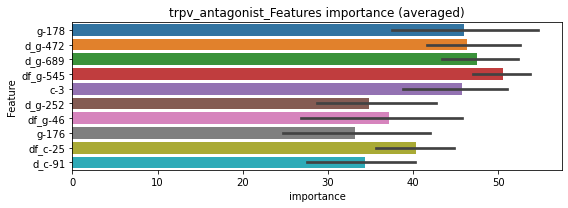

len(train_index) : 3876
len(valid_index) : 3877
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241478	valid_1's binary_logloss: 0.0527312
[200]	training's binary_logloss: 0.0042193	valid_1's binary_logloss: 0.0258438
[300]	training's binary_logloss: 0.00115945	valid_1's binary_logloss: 0.02002
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000805864	valid_1's binary_logloss: 0.0189914


len(train_index) : 3877
len(valid_index) : 3876
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257106	valid_1's binary_logloss: 0.0530744
[200]	training's binary_logloss: 0.00450404	valid_1's binary_logloss: 0.0291869
[300]	training's binary_logloss: 0.00121607	valid_1's binary_logloss: 0.0243703
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000881229	valid_1's binary_logloss: 0.0237475


trpv_antagonist logloss: 0.021369126239867017


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400674	valid_1's binary_logloss: 0.124521
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0112751	valid_1's binary_logloss: 0.113226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438616	valid_1's binary_logloss: 0.102566
[200]	training's binary_logloss: 0.00804722	valid_1's binary_logloss: 0.0793265
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00501389	valid_1's binary_logloss: 0.0777098


1 / 3 AUC score:0.981
y_Threshold: 0.0242248, Threshold: 0.1500895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 193 → Positive_corect_labels: 622/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.01327
Num_p_label: 80.0, conf_0:0.13508, conf_1:0.16510
threshold: 0.1500895, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307306	valid_1's binary_logloss: 0.0732726
[200]	training's binary_logloss: 0.00481843	valid_1's binary_logloss: 0.0538962
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00249598	valid_1's binary_logloss: 0.0518328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032443	valid_1's binary_logloss: 0.0829801
[200]	training's binary_logloss: 0.00479498	valid_1's binary_logloss: 0.0641031
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00411383	valid_1's binary_logloss: 0.0639501


2 / 3 AUC score:0.993
y_Threshold: 0.0452893, Threshold: 0.1500895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 597.0/3677
p_label_rate: 0.0278754 Vs.target_rate: 0.01327
Num_p_label: 111.0, conf_0:0.13508, conf_1:0.16510
threshold: 0.1500895, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 597.0/3677, y_label_rate: 0.1623606
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271124	valid_1's binary_logloss: 0.0709035
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00448128	valid_1's binary_logloss: 0.0557696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281999	valid_1's binary_logloss: 0.0568698
[200]	training's binary_logloss: 0.00382365	valid_1's binary_logloss: 0.0350238
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00198681	valid_1's binary_logloss: 0.034395


3 / 3 AUC score:0.991
y_Threshold: 0.0389471, Threshold: 0.1500895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 578.0/3639
p_label_rate: 0.0308890 Vs.target_rate: 0.01327
Num_p_label: 123.0, conf_0:0.13508, conf_1:0.16510
threshold: 0.1500895, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 701.0/7621, y_label_rate: 0.0919827


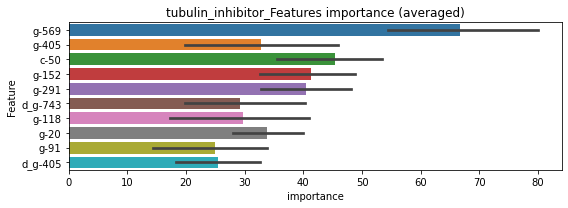

len(train_index) : 3810
len(valid_index) : 3811
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153999	valid_1's binary_logloss: 0.0459532
[200]	training's binary_logloss: 0.00204977	valid_1's binary_logloss: 0.0317815
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00204977	valid_1's binary_logloss: 0.0317815


len(train_index) : 3811
len(valid_index) : 3810
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154873	valid_1's binary_logloss: 0.0362224
[200]	training's binary_logloss: 0.0021657	valid_1's binary_logloss: 0.0229867
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000967848	valid_1's binary_logloss: 0.0216717


tubulin_inhibitor logloss: 0.02672722688858997


neg labels: 3289 → selected neg labels: 3276


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554654	valid_1's binary_logloss: 0.110871
[200]	training's binary_logloss: 0.0117911	valid_1's binary_logloss: 0.0572649
[300]	training's binary_logloss: 0.00340132	valid_1's binary_logloss: 0.043056
[400]	training's binary_logloss: 0.00153189	valid_1's binary_logloss: 0.036851
[500]	training's binary_logloss: 0.000939404	valid_1's binary_logloss: 0.035293
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000903131	valid_1's binary_logloss: 0.0351182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055756	valid_1's binary_logloss: 0.111846
[200]	training's binary_logloss: 0.011651	valid_1's binary_logloss: 0.0569868
[300]	training's binary_logloss: 0.00342426	valid_1's binary_logloss: 0.0424296
[400]	training's binary_logloss: 0.00155305	valid_1's binary_logloss: 0.0389285
Early stopping, best iteration is:
[472]	training's 

1 / 3 AUC score:0.996
y_Threshold: 0.0098244, Threshold: 0.0164430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01480, conf_1:0.01809
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0164430
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.0264430
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_3: 0.0364430
threshold: 0.0364430, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539422	valid_1's binary_logloss: 0.114489
[200]	training's binary_logloss: 0.0105602	valid_1's binary_logloss: 0.0612141
[300]	training's binary_logloss: 0.00311694	valid_1's binary_logloss: 0.0488099
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.001527	valid_1's binary_logloss: 0.0444612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053295	valid_1's binary_logloss: 0.112097
[200]	training's binary_logloss: 0.0105046	valid_1's binary_logloss: 0.0599471
[300]	training's binary_logloss: 0.00302495	valid_1's binary_logloss: 0.0511129
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0018059	valid_1's binary_logloss: 0.048776


2 / 3 AUC score:0.999
y_Threshold: 0.0420181, Threshold: 0.0364430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 632.0/3753
p_label_rate: 0.0198393 Vs.target_rate: 0.00307
Num_p_label: 79.0, conf_0:0.03280, conf_1:0.04009
Num_p_label: 79.0, Expected: 12.2, Adj_threshold_1: 0.0364430
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_2: 0.0464430
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_3: 0.0564430
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_4: 0.0664430
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_5: 0.0764430
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_6: 0.0864430
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.0964430
threshold: 0.0964430, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 632.0/3753, y_label_rate: 0.1683986
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513529	valid_1's binary_logloss: 0.109779
[200]	training's binary_logloss: 0.00982662	valid_1's binary_logloss: 0.0552521
[300]	training's binary_logloss: 0.00290958	valid_1's binary_logloss: 0.0413375
[400]	training's binary_logloss: 0.00133959	valid_1's binary_logloss: 0.0370299
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00102323	valid_1's binary_logloss: 0.0353783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513193	valid_1's binary_logloss: 0.0936023
[200]	training's binary_logloss: 0.0102914	valid_1's binary_logloss: 0.0415568
[300]	training's binary_logloss: 0.00300562	valid_1's binary_logloss: 0.0297674
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00160833	valid_1's binary_logloss: 0.0271044


3 / 3 AUC score:0.999
y_Threshold: 0.0598341, Threshold: 0.0964430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 626.0/3741
p_label_rate: 0.0052737 Vs.target_rate: 0.00307
Num_p_label: 21.0, conf_0:0.08680, conf_1:0.10609
threshold: 0.0964430, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 647.0/7723, y_label_rate: 0.0837757


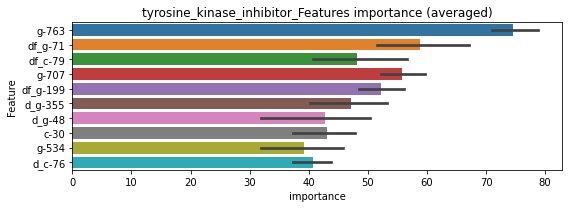

len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030128	valid_1's binary_logloss: 0.0703458
[200]	training's binary_logloss: 0.00592365	valid_1's binary_logloss: 0.0416696
[300]	training's binary_logloss: 0.00171115	valid_1's binary_logloss: 0.0345637
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000842342	valid_1's binary_logloss: 0.0327873


len(train_index) : 3862
len(valid_index) : 3861
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290131	valid_1's binary_logloss: 0.0727534
[200]	training's binary_logloss: 0.00570385	valid_1's binary_logloss: 0.043633
[300]	training's binary_logloss: 0.00162895	valid_1's binary_logloss: 0.0378091
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000903268	valid_1's binary_logloss: 0.0366094


tyrosine_kinase_inhibitor logloss: 0.03469814101032809


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174617	valid_1's binary_logloss: 0.020999
[200]	training's binary_logloss: 0.00169563	valid_1's binary_logloss: 0.00364574
[300]	training's binary_logloss: 0.000483289	valid_1's binary_logloss: 0.00171613
[400]	training's binary_logloss: 0.00028654	valid_1's binary_logloss: 0.0012458
[500]	training's binary_logloss: 0.000254066	valid_1's binary_logloss: 0.00118955
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000253563	valid_1's binary_logloss: 0.00118885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178795	valid_1's binary_logloss: 0.021391
[200]	training's binary_logloss: 0.00171486	valid_1's binary_logloss: 0.00311065
[300]	training's binary_logloss: 0.000480706	valid_1's binary_logloss: 0.00125951
[400]	training's binary_logloss: 0.000282696	valid_1's binary_logloss: 0.000853593
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0010863, Threshold: 0.0017362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00156, conf_1:0.00191
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017362
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0117362
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0217362
threshold: 0.0217362, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174743	valid_1's binary_logloss: 0.0200139
[200]	training's binary_logloss: 0.00162311	valid_1's binary_logloss: 0.00269509
[300]	training's binary_logloss: 0.000455109	valid_1's binary_logloss: 0.00108312
[400]	training's binary_logloss: 0.000275262	valid_1's binary_logloss: 0.000784164
[500]	training's binary_logloss: 0.000241321	valid_1's binary_logloss: 0.00072623
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000237076	valid_1's binary_logloss: 0.000718464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180013	valid_1's binary_logloss: 0.0216256
[200]	training's binary_logloss: 0.00167302	valid_1's binary_logloss: 0.00372618
[300]	training's binary_logloss: 0.000462275	valid_1's binary_logloss: 0.00222587
[400]	training's binary_logloss: 0.000272129	valid_1's binary_logloss: 0.00187133
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0402493, Threshold: 0.0217362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0095429 Vs.target_rate: 0.00050
Num_p_label: 38.0, conf_0:0.01956, conf_1:0.02391
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_1: 0.0217362
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_2: 0.0317362
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_3: 0.0417362
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_4: 0.0517362
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_5: 0.0617362
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_6: 0.0717362
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.0817362
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.0917362
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_9: 0.1017362
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_10: 0.1117362
threshold: 0.1217362, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174743	valid_1's binary_logloss: 0.0200139
[200]	training's binary_logloss: 0.00162311	valid_1's binary_logloss: 0.00269509
[300]	training's binary_logloss: 0.000455109	valid_1's binary_logloss: 0.00108312
[400]	training's binary_logloss: 0.000275262	valid_1's binary_logloss: 0.000784164
[500]	training's binary_logloss: 0.000241321	valid_1's binary_logloss: 0.00072623
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000237076	valid_1's binary_logloss: 0.000718464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180013	valid_1's binary_logloss: 0.0216256
[200]	training's binary_logloss: 0.00167302	valid_1's binary_logloss: 0.00372618
[300]	training's binary_logloss: 0.000462275	valid_1's binary_logloss: 0.00222587
[400]	training's binary_logloss: 0.000272129	valid_1's binary_logloss: 0.00187133
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0402493, Threshold: 0.1217362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.10956, conf_1:0.13391
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.1217362
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.1317362
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.1417362
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.1517362
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.1617362
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.1717362
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.1817362
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_8: 0.1917362
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.2017362
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.2117362
threshold: 0.2217362, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7794, y_label_rate: 0.0857070


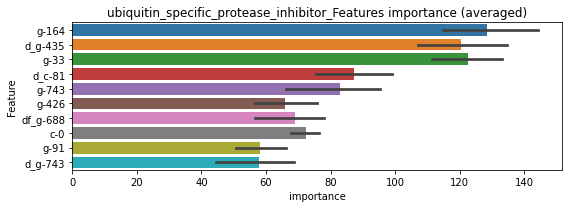

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00962198	valid_1's binary_logloss: 0.0166163
[200]	training's binary_logloss: 0.000888905	valid_1's binary_logloss: 0.00620901
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000496782	valid_1's binary_logloss: 0.00564491


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00962529	valid_1's binary_logloss: 0.0123352
[200]	training's binary_logloss: 0.000941822	valid_1's binary_logloss: 0.00361725
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000354446	valid_1's binary_logloss: 0.00299117


ubiquitin_specific_protease_inhibitor logloss: 0.004318041238035423


neg labels: 3289 → selected neg labels: 3258


vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547694	valid_1's binary_logloss: 0.140062
[200]	training's binary_logloss: 0.011955	valid_1's binary_logloss: 0.104507
[300]	training's binary_logloss: 0.00366845	valid_1's binary_logloss: 0.0980309
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00385278	valid_1's binary_logloss: 0.0978596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551313	valid_1's binary_logloss: 0.124268
[200]	training's binary_logloss: 0.0130059	valid_1's binary_logloss: 0.0813379
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00577331	valid_1's binary_logloss: 0.0708282


1 / 3 AUC score:0.986
y_Threshold: 0.0509931, Threshold: 0.1784660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 177 → Positive_corect_labels: 628/3732
p_label_rate: 0.0200904 Vs.target_rate: 0.00714
Num_p_label: 80.0, conf_0:0.16062, conf_1:0.19631
threshold: 0.1784660, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 628.0/3732, y_label_rate: 0.1682744
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458897	valid_1's binary_logloss: 0.1141
[200]	training's binary_logloss: 0.00988308	valid_1's binary_logloss: 0.0839931
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00835691	valid_1's binary_logloss: 0.0825252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443619	valid_1's binary_logloss: 0.112032
[200]	training's binary_logloss: 0.00863761	valid_1's binary_logloss: 0.071664
[300]	training's binary_logloss: 0.00276503	valid_1's binary_logloss: 0.0635116
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00199617	valid_1's binary_logloss: 0.0621239


2 / 3 AUC score:0.991
y_Threshold: 0.1152586, Threshold: 0.1784660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 587.0/3650
p_label_rate: 0.0441989 Vs.target_rate: 0.00714
Num_p_label: 176.0, conf_0:0.16062, conf_1:0.19631
Num_p_label: 176.0, Expected: 28.4, Adj_threshold_1: 0.1784660
Num_p_label: 170.0, Expected: 28.4, Adj_threshold_2: 0.1884660
Num_p_label: 162.0, Expected: 28.4, Adj_threshold_3: 0.1984660
Num_p_label: 154.0, Expected: 28.4, Adj_threshold_4: 0.2084660
Num_p_label: 151.0, Expected: 28.4, Adj_threshold_5: 0.2184660
Num_p_label: 144.0, Expected: 28.4, Adj_threshold_6: 0.2284660
Num_p_label: 142.0, Expected: 28.4, Adj_threshold_7: 0.2384660
Num_p_label: 139.0, Expected: 28.4, Adj_threshold_8: 0.2484660
Num_p_label: 137.0, Expected: 28.4, Adj_threshold_9: 0.2584660
Num_p_label: 136.0, Expected: 28.4, Adj_threshold_10: 0.2684660
threshold: 0.2784660, positive_p_label: 135.0/3982, p_label_rate: 0.0339026
positive_y_label: 587.0/3650, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381057	valid_1's binary_logloss: 0.091694
[200]	training's binary_logloss: 0.00657374	valid_1's binary_logloss: 0.0556001
[300]	training's binary_logloss: 0.00204848	valid_1's binary_logloss: 0.0464743
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00196671	valid_1's binary_logloss: 0.0459767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368112	valid_1's binary_logloss: 0.0929064
[200]	training's binary_logloss: 0.00622989	valid_1's binary_logloss: 0.0645781
[300]	training's binary_logloss: 0.00190763	valid_1's binary_logloss: 0.0616323
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00184175	valid_1's binary_logloss: 0.0615805


3 / 3 AUC score:0.992
y_Threshold: 0.1206446, Threshold: 0.2784660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 561.0/3598
p_label_rate: 0.0384229 Vs.target_rate: 0.00714
Num_p_label: 153.0, conf_0:0.25062, conf_1:0.30631
Num_p_label: 153.0, Expected: 28.4, Adj_threshold_1: 0.2784660
Num_p_label: 153.0, Expected: 28.4, Adj_threshold_2: 0.2884660
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_3: 0.2984660
Num_p_label: 147.0, Expected: 28.4, Adj_threshold_4: 0.3084660
Num_p_label: 147.0, Expected: 28.4, Adj_threshold_5: 0.3184660
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_6: 0.3284660
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_7: 0.3384660
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_8: 0.3484660
Num_p_label: 141.0, Expected: 28.4, Adj_threshold_9: 0.3584660
Num_p_label: 138.0, Expected: 28.4, Adj_threshold_10: 0.3684660
threshold: 0.3784660, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 695.0/7580, y_label_ra

len(train_index) : 3790
len(valid_index) : 3790
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218862	valid_1's binary_logloss: 0.0486992
[200]	training's binary_logloss: 0.00371636	valid_1's binary_logloss: 0.0278528
[300]	training's binary_logloss: 0.0011455	valid_1's binary_logloss: 0.0233136
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000641075	valid_1's binary_logloss: 0.0225047


len(train_index) : 3790
len(valid_index) : 3790
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212058	valid_1's binary_logloss: 0.0591245
[200]	training's binary_logloss: 0.00355103	valid_1's binary_logloss: 0.0430208
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0025041	valid_1's binary_logloss: 0.0419742


vegfr_inhibitor logloss: 0.032239436702866636


neg labels: 3289 → selected neg labels: 3285


vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289801	valid_1's binary_logloss: 0.0427117
[200]	training's binary_logloss: 0.00386541	valid_1's binary_logloss: 0.00915001
[300]	training's binary_logloss: 0.00109776	valid_1's binary_logloss: 0.00373449
[400]	training's binary_logloss: 0.000560616	valid_1's binary_logloss: 0.00242107
[500]	training's binary_logloss: 0.000401529	valid_1's binary_logloss: 0.00204258
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00038432	valid_1's binary_logloss: 0.0020148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290416	valid_1's binary_logloss: 0.0434138
[200]	training's binary_logloss: 0.00403215	valid_1's binary_logloss: 0.0101162
[300]	training's binary_logloss: 0.00112932	valid_1's binary_logloss: 0.00439453
[400]	training's binary_logloss: 0.000565356	valid_1's binary_logloss: 0.00283549
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0019764, Threshold: 0.0045417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00409, conf_1:0.00500
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0045417
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.0145417
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.0245417
threshold: 0.0245417, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282039	valid_1's binary_logloss: 0.041189
[200]	training's binary_logloss: 0.00369808	valid_1's binary_logloss: 0.00846479
[300]	training's binary_logloss: 0.00106051	valid_1's binary_logloss: 0.00336626
[400]	training's binary_logloss: 0.000546679	valid_1's binary_logloss: 0.00213177
[500]	training's binary_logloss: 0.000398062	valid_1's binary_logloss: 0.00181551
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000372702	valid_1's binary_logloss: 0.00174354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287026	valid_1's binary_logloss: 0.0442245
[200]	training's binary_logloss: 0.00382859	valid_1's binary_logloss: 0.0101578
[300]	training's binary_logloss: 0.00109012	valid_1's binary_logloss: 0.00465917
[400]	training's binary_logloss: 0.000552961	valid_1's binary_logloss: 0.0032625
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0776213, Threshold: 0.0245417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00109
Num_p_label: 17.0, conf_0:0.02209, conf_1:0.02700
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_1: 0.0245417
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_2: 0.0345417
threshold: 0.0345417, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282039	valid_1's binary_logloss: 0.041189
[200]	training's binary_logloss: 0.00369808	valid_1's binary_logloss: 0.00846479
[300]	training's binary_logloss: 0.00106051	valid_1's binary_logloss: 0.00336626
[400]	training's binary_logloss: 0.000546679	valid_1's binary_logloss: 0.00213177
[500]	training's binary_logloss: 0.000398062	valid_1's binary_logloss: 0.00181551
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000372702	valid_1's binary_logloss: 0.00174354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287026	valid_1's binary_logloss: 0.0442245
[200]	training's binary_logloss: 0.00382859	valid_1's binary_logloss: 0.0101578
[300]	training's binary_logloss: 0.00109012	valid_1's binary_logloss: 0.00465917
[400]	training's binary_logloss: 0.000552961	valid_1's binary_logloss: 0.0032625
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0776213, Threshold: 0.0345417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00109
Num_p_label: 7.0, conf_0:0.03109, conf_1:0.03800
threshold: 0.0345417, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


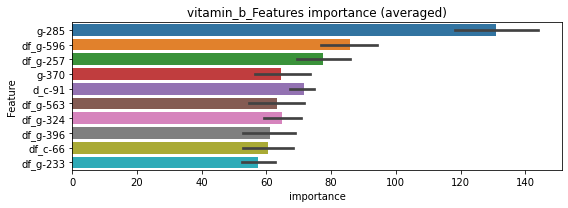

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164666	valid_1's binary_logloss: 0.0301078
[200]	training's binary_logloss: 0.00217785	valid_1's binary_logloss: 0.0104283
[300]	training's binary_logloss: 0.000594738	valid_1's binary_logloss: 0.00768772
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000331064	valid_1's binary_logloss: 0.00739336


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163662	valid_1's binary_logloss: 0.0280781
[200]	training's binary_logloss: 0.00226916	valid_1's binary_logloss: 0.0119949
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00163443	valid_1's binary_logloss: 0.0110077


vitamin_b logloss: 0.009200525952117974


neg labels: 3289 → selected neg labels: 3281


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274554	valid_1's binary_logloss: 0.0410743
[200]	training's binary_logloss: 0.00355353	valid_1's binary_logloss: 0.00894999
[300]	training's binary_logloss: 0.00100394	valid_1's binary_logloss: 0.00420438
[400]	training's binary_logloss: 0.000506221	valid_1's binary_logloss: 0.0027465
[500]	training's binary_logloss: 0.000361963	valid_1's binary_logloss: 0.00233091
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000337965	valid_1's binary_logloss: 0.00226251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267991	valid_1's binary_logloss: 0.0486714
[200]	training's binary_logloss: 0.00348255	valid_1's binary_logloss: 0.0158557
[300]	training's binary_logloss: 0.000989838	valid_1's binary_logloss: 0.00989382
[400]	training's binary_logloss: 0.000504915	valid_1's binary_logloss: 0.00796966
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0019741, Threshold: 0.0035450, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164
Num_p_label: 80.0, conf_0:0.00319, conf_1:0.00390
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0035450
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_2: 0.0135450
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_3: 0.0235450
Num_p_label: 12.0, Expected: 6.5, Adj_threshold_4: 0.0335450
threshold: 0.0335450, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277712	valid_1's binary_logloss: 0.0403496
[200]	training's binary_logloss: 0.00354696	valid_1's binary_logloss: 0.00892913
[300]	training's binary_logloss: 0.000996206	valid_1's binary_logloss: 0.00414019
[400]	training's binary_logloss: 0.000500456	valid_1's binary_logloss: 0.00278795
[500]	training's binary_logloss: 0.000362289	valid_1's binary_logloss: 0.00234051
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00034456	valid_1's binary_logloss: 0.00228271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267425	valid_1's binary_logloss: 0.0478899
[200]	training's binary_logloss: 0.00339692	valid_1's binary_logloss: 0.0162546
[300]	training's binary_logloss: 0.000955861	valid_1's binary_logloss: 0.0101743
[400]	training's binary_logloss: 0.000485607	valid_1's binary_logloss: 0.00852477
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0359069, Threshold: 0.0335450, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164
Num_p_label: 19.0, conf_0:0.03019, conf_1:0.03690
threshold: 0.0335450, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277712	valid_1's binary_logloss: 0.0403496
[200]	training's binary_logloss: 0.00354696	valid_1's binary_logloss: 0.00892913
[300]	training's binary_logloss: 0.000996206	valid_1's binary_logloss: 0.00414019
[400]	training's binary_logloss: 0.000500456	valid_1's binary_logloss: 0.00278795
[500]	training's binary_logloss: 0.000362289	valid_1's binary_logloss: 0.00234051
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00034456	valid_1's binary_logloss: 0.00228271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267425	valid_1's binary_logloss: 0.0478899
[200]	training's binary_logloss: 0.00339692	valid_1's binary_logloss: 0.0162546
[300]	training's binary_logloss: 0.000955861	valid_1's binary_logloss: 0.0101743
[400]	training's binary_logloss: 0.000485607	valid_1's binary_logloss: 0.00852477
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0359069, Threshold: 0.0335450, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164
Num_p_label: 19.0, conf_0:0.03019, conf_1:0.03690
threshold: 0.0335450, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 675.0/7787, y_label_rate: 0.0866829


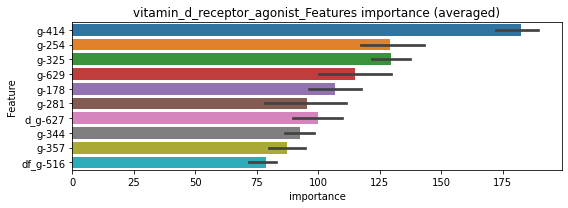

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145455	valid_1's binary_logloss: 0.0301777
[200]	training's binary_logloss: 0.00180717	valid_1's binary_logloss: 0.013653
[300]	training's binary_logloss: 0.000519485	valid_1's binary_logloss: 0.011188
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000519485	valid_1's binary_logloss: 0.011188


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151573	valid_1's binary_logloss: 0.0304485
[200]	training's binary_logloss: 0.00192696	valid_1's binary_logloss: 0.0125585
[300]	training's binary_logloss: 0.000544505	valid_1's binary_logloss: 0.00985402
[400]	training's binary_logloss: 0.000275978	valid_1's binary_logloss: 0.00922359
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000236626	valid_1's binary_logloss: 0.00903262


vitamin_d_receptor_agonist logloss: 0.010110470990342721


neg labels: 3289 → selected neg labels: 3284


wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303372	valid_1's binary_logloss: 0.0523636
[200]	training's binary_logloss: 0.00433659	valid_1's binary_logloss: 0.0157627
[300]	training's binary_logloss: 0.00123624	valid_1's binary_logloss: 0.00866758
[400]	training's binary_logloss: 0.000615255	valid_1's binary_logloss: 0.00647232
[500]	training's binary_logloss: 0.000426443	valid_1's binary_logloss: 0.00576884
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000433407	valid_1's binary_logloss: 0.0057348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311273	valid_1's binary_logloss: 0.0584384
[200]	training's binary_logloss: 0.00440128	valid_1's binary_logloss: 0.0221964
[300]	training's binary_logloss: 0.0012359	valid_1's binary_logloss: 0.0145685
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.001193	valid_1's binary_logloss: 0.0144401


1 / 3 AUC score:1.000
y_Threshold: 0.0039902, Threshold: 0.0046448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00418, conf_1:0.00511
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0046448
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_2: 0.0146448
threshold: 0.0146448, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310483	valid_1's binary_logloss: 0.052423
[200]	training's binary_logloss: 0.00433367	valid_1's binary_logloss: 0.0144255
[300]	training's binary_logloss: 0.00123135	valid_1's binary_logloss: 0.00738055
[400]	training's binary_logloss: 0.00061296	valid_1's binary_logloss: 0.00512126
[500]	training's binary_logloss: 0.000429762	valid_1's binary_logloss: 0.00455872
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000433445	valid_1's binary_logloss: 0.00454009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313624	valid_1's binary_logloss: 0.0573539
[200]	training's binary_logloss: 0.00439968	valid_1's binary_logloss: 0.021626
[300]	training's binary_logloss: 0.00123001	valid_1's binary_logloss: 0.0150373
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0011268	valid_1's binary_logloss: 0.0146838


2 / 3 AUC score:1.000
y_Threshold: 0.0326935, Threshold: 0.0146448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00126
Num_p_label: 18.0, conf_0:0.01318, conf_1:0.01611
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.0146448
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0246448
threshold: 0.0246448, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313169	valid_1's binary_logloss: 0.0519766
[200]	training's binary_logloss: 0.0043716	valid_1's binary_logloss: 0.0174502
[300]	training's binary_logloss: 0.00123763	valid_1's binary_logloss: 0.0120419
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000787012	valid_1's binary_logloss: 0.0109226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315563	valid_1's binary_logloss: 0.0575143
[200]	training's binary_logloss: 0.00454602	valid_1's binary_logloss: 0.0216015
[300]	training's binary_logloss: 0.00128362	valid_1's binary_logloss: 0.0159248
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00064526	valid_1's binary_logloss: 0.01377


3 / 3 AUC score:1.000
y_Threshold: 0.0105198, Threshold: 0.0246448, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0022602 Vs.target_rate: 0.00126
Num_p_label: 9.0, conf_0:0.02218, conf_1:0.02711
threshold: 0.0246448, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 663.0/7786, y_label_rate: 0.0851528


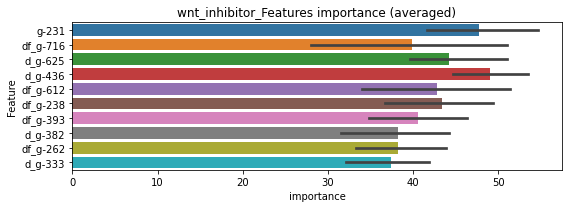

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174665	valid_1's binary_logloss: 0.0352977
[200]	training's binary_logloss: 0.00250125	valid_1's binary_logloss: 0.0155642
[300]	training's binary_logloss: 0.000683446	valid_1's binary_logloss: 0.0121157
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000358087	valid_1's binary_logloss: 0.0112113


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192708	valid_1's binary_logloss: 0.0262376
[200]	training's binary_logloss: 0.00277027	valid_1's binary_logloss: 0.00766891
[300]	training's binary_logloss: 0.000736207	valid_1's binary_logloss: 0.00512682
[400]	training's binary_logloss: 0.00035016	valid_1's binary_logloss: 0.00463693
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000284447	valid_1's binary_logloss: 0.00458621


wnt_inhibitor logloss: 0.007898748668364769


In [46]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.020668606736112313


In [49]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)